### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Country-specific network (with only non-zero data)

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged
* Not using difference between days

In [28]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import seaborn as sns
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [29]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [30]:
countries
df_csse.shape

(172, 86)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [31]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [32]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

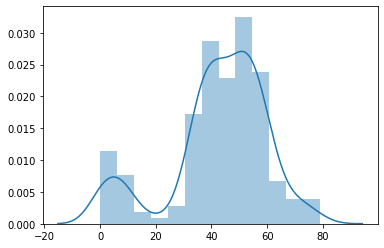

In [33]:
# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

sns.distplot(np.array(lstzero));

In [34]:
len(skip_countries)

149

From the distribution, 30 seems a reasonable cutoff (most countries still present)

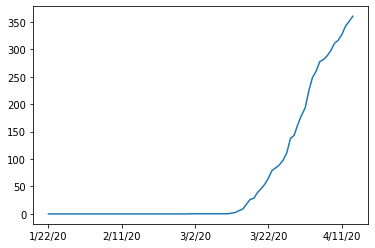

In [35]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [36]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.52296317e-01, 2.52296317e-01, 2.52296317e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.04858300e+01, 4.95951417e+01, 5.06072874e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.20342147e+00, 6.20342147e+00, 8.17723739e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        7.36435192e+02, 8.32579437e+02, 9.33083164e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.39667807e+03, 4.39667807e+03, 4.39667807e+03]])

In [37]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ..., -1.37715102,
        -1.37715102, -1.37715102],
       [       -inf,        -inf,        -inf, ...,  3.70095204,
         3.90389288,  3.92409559],
       [       -inf,        -inf,        -inf, ...,  1.82510099,
         1.82510099,  2.10135437],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  6.60182124,
         6.72452864,  6.83849433],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  8.38860455,
         8.38860455,  8.38860455]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [40]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days
case_train[3,5:8]

array([0., 0., 0.])

In [53]:
def clear_zero(nparray):
    # return the np array that contains only 1 0:
    lst = nparray.tolist()
    #print(len(lst))
    ind = 0
    splitInd = 0
    while(lst[ind]==0):
        splitInd += 1
        ind += 1
    #print(splitInd)
    return(np.array(lst[splitInd:]))

In [54]:
clear_zero(case_train[169,:]).shape[0]

74

In [55]:
t_days = 25 # number of days used to test 
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []


for i in range(len(countries)):
    print(countries[i] + " "+ str(i))
    
    if i in skip_countries:
        country_train_X.append(0)
        country_train_Y.append(0)

        country_valid_X.append(0)
        country_valid_Y.append(0)

        country_test_X.append(0)
        country_test_Y.append(0)
        continue # too little data 
        
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    newcase = clear_zero(case_train[i,:])
    total_days = newcase.shape[0]
    print(total_days)
    for j in range(total_days-pred_days*2-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(newcase[j:j+t_days])
        #print(str(j))
        out.append(newcase[j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(newcase[total_days-t_days-test_d*2:total_days-test_d*2])
    print(newcase[total_days-t_days-test_d*2:total_days-test_d*2].shape)
    country_valid_Y.append(newcase[total_days-test_d*2:total_days-test_d])
    print(newcase[total_days-test_d*2:total_days-test_d].shape)
    
    country_test_X.append(newcase[total_days-test_d-t_days:total_days-test_d])
    country_test_Y.append(newcase[total_days-test_d:])
    
    # the best way to check this
    #testlist = 


Burundi 0
Djibouti 1
Eritrea 2
Ethiopia 3
Kenya 4
Madagascar 5
Malawi 6
Mauritius 7
Mozambique 8
Rwanda 9
Seychelles 10
Somalia 11
South Sudan 12
Uganda 13
Tanzania 14
Zambia 15
Zimbabwe 16
Angola 17
Cameroon 18
Central African Republic 19
Chad 20
Equatorial Guinea 21
Gabon 22
Sao Tome and Principe 23
Botswana 24
Eswatini 25
Namibia 26
South Africa 27
Benin 28
Burkina Faso 29
Cabo Verde 30
Gambia 31
Ghana 32
Guinea 33
Guinea-Bissau 34
Liberia 35
Mali 36
Mauritania 37
Niger 38
Nigeria 39
Senegal 40
Sierra Leone 41
Togo 42
Algeria 43
Egypt 44
51
(25,)
(5,)
Libya 45
Morocco 46
Sudan 47
Tunisia 48
Western Sahara 49
Armenia 50
Azerbaijan 51
Bahrain 52
Cyprus 53
Georgia 54
Iraq 55
Israel 56
Jordan 57
Kuwait 58
Lebanon 59
Oman 60
Qatar 61
Saudi Arabia 62
Syria 63
Turkey 64
United Arab Emirates 65
67
(25,)
(5,)
Yemen 66
Kazakhstan 67
Kyrgyzstan 68
Uzbekistan 69
Afghanistan 70
Bangladesh 71
Bhutan 72
India 73
66
(25,)
(5,)
Iran 74
Maldives 75
Nepal 76
71
(25,)
(5,)
Pakistan 77
Sri Lanka 78
69
(

In [56]:
len(country_train_X)

172

In [57]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [59]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Discrete|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 5|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|

In [62]:
# Parameter
num_epochs = 50 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [63]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [64]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [65]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) +".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs, labels) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs, y)
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = test_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [66]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred, y)
            test_loss += loss.item() 
            
    return pred,test_loss

In [70]:
#dimension check
a = torch.tensor(country_train_X[81]) #torch.Size([19, 30, 1, 1])
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# #torch.tensor(country_train_Y[0])
# torch.tensor(country_train_X[0])
# a.size(-1)
# torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# #torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

In [72]:
# test if it runs
learning_rate = 0.01 # to be changed/optimized 
num_layers = 2
hidden_dim = 100

net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
print(net)
model = net.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[81]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[81]).unsqueeze_(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# load validation
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[81]).unsqueeze_(0).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# load test
test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[81]).unsqueeze_(0).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# mock trial
err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim, num_layers)



LSTM(
  (lstm): LSTM(25, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)
Saving the best model weights at Epoch [1], Best Valid Loss: 26.0650


/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Saving the best model weights at Epoch [3], Best Valid Loss: 16.7154
Saving the best model weights at Epoch [4], Best Valid Loss: 4.9237
train error: 4.238331275681655


In [20]:
torch.tensor(country_train_Y[0]).unsqueeze_(0).shape


torch.Size([1, 24, 5])

In [73]:
# optimization grid
lr_list = [0.1,0.01,0.001,0.005,1e-4,5e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst = [30,50,100,200,300]

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10
country_file_path = ("./country_file3.txt")
for i in range(len(countries)):
    if i in skip_countries:
        continue # too little data 
        
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./offline3/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    country_file = open(country_file_path,"a")
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                # train
                # specific parameters
                learning_rate = lr_list[j]
                hidden_dim = hState_lst[m]
                num_layers = hidden_lst[k]
                
                net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                #print(net)
                model = net.to(device)
                
                #
                optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
                # to be changed/optimized 
                
                model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers)
                print(err)
                if err < best_error:
                    best_error = err
                    best_param = [lr_list[j],hidden_lst[k],hState_lst[m]]
                    bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")
    
    print("%s, %s, %s, %s" % (countries[i], pred.tolist(), final_loss,best_param), file=country_file)
                   
    country_file.close()

Creating directory ./offline3/Egypt/training/
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0226
train error: 0.020525968007859774
0.022556299343705177
Saving the best model weights at Epoch [1], Best Valid Loss: 15.6656
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5210
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2064
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0212
train error: 0.030882886610925198
0.021189909428358078
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3801
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2874
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1064
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0481
Saving the best model w

Saving the best model weights at Epoch [11], Best Valid Loss: 6.0068
Saving the best model weights at Epoch [24], Best Valid Loss: 5.5557
Saving the best model weights at Epoch [36], Best Valid Loss: 5.4684
Saving the best model weights at Epoch [40], Best Valid Loss: 5.3827
train error: 2.3357565659098327
5.382728099822998
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9746
train error: 2.3385718999197707
2.9746220111846924
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9383
train error: 2.2644430216168985
2.9383111000061035
Saving the best model weights at Epoch [1], Best Valid Loss: 3.8957
train error: 2.4737530588172376
3.89567494392395
Saving the best model weights at Epoch [1], Best Valid Loss: 4.8281
train error: 2.2901840747799724
4.82808780670166
Saving the best model weights at Epoch [1], Best Valid Loss: 6.9794
Saving the best model weights at Epoch [6], Best Valid Loss: 6.2062
Saving the best model weights at Epoch [11], Best Valid Loss: 5.51

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0497
train error: 0.01877005078131333
0.049722861498594284
Saving the best model weights at Epoch [1], Best Valid Loss: 21.4651
Saving the best model weights at Epoch [2], Best Valid Loss: 10.6528
Saving the best model weights at Epoch [3], Best Valid Loss: 4.8413
Saving the best model weights at Epoch [4], Best Valid Loss: 2.9002
Saving the best model weights at Epoch [5], Best Valid Loss: 2.6560
Saving the best model weights at Epoch [6], Best Valid Loss: 1.5541
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2070
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1128
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0239
train error: 0.021937650904874317
0.023863522335886955
Saving the best model weights at Epoch [1], Best Valid Loss: 23.0659
Saving the best model weights at Epoch [2], Best Valid Loss: 12.8253
Saving the best model weights at Epoch [3], Best Valid Loss: 9.3801
Sa

Saving the best model weights at Epoch [8], Best Valid Loss: 8.1040
Saving the best model weights at Epoch [17], Best Valid Loss: 8.0640
Saving the best model weights at Epoch [38], Best Valid Loss: 7.9878
Saving the best model weights at Epoch [48], Best Valid Loss: 7.9080
train error: 2.029908935073763
7.907956123352051
Saving the best model weights at Epoch [1], Best Valid Loss: 22.7631
Saving the best model weights at Epoch [2], Best Valid Loss: 12.5464
Saving the best model weights at Epoch [3], Best Valid Loss: 7.6230
train error: 2.040135945077054
7.6229681968688965
Saving the best model weights at Epoch [1], Best Valid Loss: 22.1894
Saving the best model weights at Epoch [2], Best Valid Loss: 13.3130
Saving the best model weights at Epoch [3], Best Valid Loss: 7.8530
train error: 2.1171245996374637
7.853013038635254
Saving the best model weights at Epoch [1], Best Valid Loss: 22.1905
Saving the best model weights at Epoch [2], Best Valid Loss: 12.6343
Saving the best model weig

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1783
train error: 0.037950920610455796
0.17831145226955414
Saving the best model weights at Epoch [1], Best Valid Loss: 28.9924
Saving the best model weights at Epoch [2], Best Valid Loss: 24.9622
Saving the best model weights at Epoch [3], Best Valid Loss: 20.8655
Saving the best model weights at Epoch [4], Best Valid Loss: 15.9995
Saving the best model weights at Epoch [5], Best Valid Loss: 11.3883
Saving the best model weights at Epoch [6], Best Valid Loss: 7.1172
Saving the best model weights at Epoch [7], Best Valid Loss: 4.6466
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4917
Saving the best model weights at Epoch [9], Best Valid Loss: 1.4848
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0067
Saving the best model weights at Epoch [11], Best Valid Loss: 0.7840
Saving the best model weights at Epoch [12], Best Valid Loss: 0.7346
Saving the best model weights at Epoch [13], Best Val

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0481
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0452
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0360
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0354
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0330
train error: 0.03479758703906555
0.032972417771816254
Saving the best model weights at Epoch [1], Best Valid Loss: 29.4707
Saving the best model weights at Epoch [2], Best Valid Loss: 27.6320
Saving the best model weights at Epoch [3], Best Valid Loss: 25.9708
Saving the best model weights at Epoch [4], Best Valid Loss: 24.2353
Saving the best model weights at Epoch [5], Best Valid Loss: 22.8294
Saving the best model weights at Epoch [6], Best Valid Loss: 21.4665
Saving the best model weights at Epoch [7], Best Valid Loss: 20.1749
Saving the best model weights at Epoch [8], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 12.5267
Saving the best model weights at Epoch [15], Best Valid Loss: 11.5401
Saving the best model weights at Epoch [16], Best Valid Loss: 10.5891
Saving the best model weights at Epoch [17], Best Valid Loss: 9.7960
Saving the best model weights at Epoch [18], Best Valid Loss: 9.1136
Saving the best model weights at Epoch [19], Best Valid Loss: 8.2337
Saving the best model weights at Epoch [20], Best Valid Loss: 7.4927
Saving the best model weights at Epoch [21], Best Valid Loss: 7.0943
Saving the best model weights at Epoch [22], Best Valid Loss: 6.5945
Saving the best model weights at Epoch [23], Best Valid Loss: 6.1508
Saving the best model weights at Epoch [24], Best Valid Loss: 5.8666
Saving the best model weights at Epoch [25], Best Valid Loss: 5.3211
Saving the best model weights at Epoch [26], Best Valid Loss: 4.9741
Saving the best model weights at Epoch [27], Best Valid Loss: 4.6183
Saving the best model weights a

Saving the best model weights at Epoch [36], Best Valid Loss: 1.4975
Saving the best model weights at Epoch [37], Best Valid Loss: 1.3096
Saving the best model weights at Epoch [38], Best Valid Loss: 1.2024
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1559
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0496
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9038
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8975
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7713
Saving the best model weights at Epoch [44], Best Valid Loss: 0.6907
Saving the best model weights at Epoch [45], Best Valid Loss: 0.6335
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5858
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5069
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4769
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4091
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 11.4990
Saving the best model weights at Epoch [21], Best Valid Loss: 11.1077
Saving the best model weights at Epoch [22], Best Valid Loss: 10.8412
Saving the best model weights at Epoch [23], Best Valid Loss: 10.5740
Saving the best model weights at Epoch [24], Best Valid Loss: 10.2760
Saving the best model weights at Epoch [25], Best Valid Loss: 10.1193
Saving the best model weights at Epoch [26], Best Valid Loss: 9.8027
Saving the best model weights at Epoch [27], Best Valid Loss: 9.7676
Saving the best model weights at Epoch [28], Best Valid Loss: 9.6687
Saving the best model weights at Epoch [29], Best Valid Loss: 9.5291
Saving the best model weights at Epoch [30], Best Valid Loss: 9.3774
Saving the best model weights at Epoch [31], Best Valid Loss: 9.2633
Saving the best model weights at Epoch [32], Best Valid Loss: 9.1400
Saving the best model weights at Epoch [33], Best Valid Loss: 8.9489
Saving the best model weight

Saving the best model weights at Epoch [13], Best Valid Loss: 16.0117
Saving the best model weights at Epoch [14], Best Valid Loss: 15.3647
Saving the best model weights at Epoch [15], Best Valid Loss: 14.7495
Saving the best model weights at Epoch [16], Best Valid Loss: 14.1581
Saving the best model weights at Epoch [17], Best Valid Loss: 13.5295
Saving the best model weights at Epoch [18], Best Valid Loss: 13.1906
Saving the best model weights at Epoch [19], Best Valid Loss: 12.7275
Saving the best model weights at Epoch [20], Best Valid Loss: 12.3360
Saving the best model weights at Epoch [21], Best Valid Loss: 11.9206
Saving the best model weights at Epoch [22], Best Valid Loss: 11.5860
Saving the best model weights at Epoch [23], Best Valid Loss: 11.2730
Saving the best model weights at Epoch [24], Best Valid Loss: 11.0265
Saving the best model weights at Epoch [25], Best Valid Loss: 10.7870
Saving the best model weights at Epoch [26], Best Valid Loss: 10.7411
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 30.4353
Saving the best model weights at Epoch [2], Best Valid Loss: 28.6487
Saving the best model weights at Epoch [3], Best Valid Loss: 26.8643
Saving the best model weights at Epoch [4], Best Valid Loss: 25.2560
Saving the best model weights at Epoch [5], Best Valid Loss: 23.6174
Saving the best model weights at Epoch [6], Best Valid Loss: 22.4640
Saving the best model weights at Epoch [7], Best Valid Loss: 21.1972
Saving the best model weights at Epoch [8], Best Valid Loss: 20.0119
Saving the best model weights at Epoch [9], Best Valid Loss: 18.9342
Saving the best model weights at Epoch [10], Best Valid Loss: 17.9741
Saving the best model weights at Epoch [11], Best Valid Loss: 17.0211
Saving the best model weights at Epoch [12], Best Valid Loss: 16.2186
Saving the best model weights at Epoch [13], Best Valid Loss: 15.4970
Saving the best model weights at Epoch [14], Best Valid Loss: 14.8408
Saving the best model weights

Saving the best model weights at Epoch [31], Best Valid Loss: 9.8583
Saving the best model weights at Epoch [32], Best Valid Loss: 9.7691
Saving the best model weights at Epoch [33], Best Valid Loss: 9.6009
Saving the best model weights at Epoch [34], Best Valid Loss: 9.4152
Saving the best model weights at Epoch [36], Best Valid Loss: 9.3351
Saving the best model weights at Epoch [37], Best Valid Loss: 9.2769
Saving the best model weights at Epoch [38], Best Valid Loss: 9.2420
Saving the best model weights at Epoch [39], Best Valid Loss: 9.2300
Saving the best model weights at Epoch [40], Best Valid Loss: 9.1846
Saving the best model weights at Epoch [41], Best Valid Loss: 9.0420
Saving the best model weights at Epoch [42], Best Valid Loss: 9.0103
Saving the best model weights at Epoch [45], Best Valid Loss: 8.9428
Saving the best model weights at Epoch [46], Best Valid Loss: 8.9306
Saving the best model weights at Epoch [47], Best Valid Loss: 8.8983
Saving the best model weights at E

Saving the best model weights at Epoch [17], Best Valid Loss: 13.1372
Saving the best model weights at Epoch [18], Best Valid Loss: 12.6794
Saving the best model weights at Epoch [19], Best Valid Loss: 12.1906
Saving the best model weights at Epoch [20], Best Valid Loss: 11.8614
Saving the best model weights at Epoch [21], Best Valid Loss: 11.4272
Saving the best model weights at Epoch [22], Best Valid Loss: 11.0704
Saving the best model weights at Epoch [23], Best Valid Loss: 10.9274
Saving the best model weights at Epoch [24], Best Valid Loss: 10.6668
Saving the best model weights at Epoch [25], Best Valid Loss: 10.4781
Saving the best model weights at Epoch [26], Best Valid Loss: 10.2495
Saving the best model weights at Epoch [27], Best Valid Loss: 10.0464
Saving the best model weights at Epoch [28], Best Valid Loss: 9.8105
Saving the best model weights at Epoch [29], Best Valid Loss: 9.7736
Saving the best model weights at Epoch [30], Best Valid Loss: 9.6516
Saving the best model w

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0408
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0238
train error: 0.02208071414497681
0.023813186213374138
Saving the best model weights at Epoch [1], Best Valid Loss: 17.7770
Saving the best model weights at Epoch [2], Best Valid Loss: 0.7809
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0947
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0849
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0663
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0178
train error: 0.02326503102085553
0.01784958504140377
Saving the best model weights at Epoch [1], Best Valid Loss: 25.7882
Saving the best model weights at Epoch [2], Best Valid Loss: 19.0689
Sa

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3734
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1309
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0919
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0371
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0342
train error: 0.030906355816114228
0.034150220453739166
Saving the best model weights at Epoch [1], Best Valid Loss: 26.7882
Saving the best model weights at Epoch [2], Best Valid Loss: 19.9222
Saving the best model weights at Epoch [3], Best Valid Loss: 15.3087
Saving the best model weights at Epoch [4], Best Valid Loss: 13.0671
Saving the best model weights at Epoch [5], Best Valid Loss: 10.6856
Saving the best model weights at Epoch [6], Best Valid Loss: 9.5763
Saving the best model weights at Epoch [7], Best 

Saving the best model weights at Epoch [5], Best Valid Loss: 9.5973
Saving the best model weights at Epoch [6], Best Valid Loss: 9.0519
Saving the best model weights at Epoch [7], Best Valid Loss: 8.2854
Saving the best model weights at Epoch [14], Best Valid Loss: 8.2186
Saving the best model weights at Epoch [15], Best Valid Loss: 8.2042
Saving the best model weights at Epoch [18], Best Valid Loss: 7.7557
Saving the best model weights at Epoch [19], Best Valid Loss: 7.6632
Saving the best model weights at Epoch [20], Best Valid Loss: 7.3974
Saving the best model weights at Epoch [21], Best Valid Loss: 7.3769
Saving the best model weights at Epoch [22], Best Valid Loss: 6.8037
Saving the best model weights at Epoch [24], Best Valid Loss: 6.0400
Saving the best model weights at Epoch [25], Best Valid Loss: 5.4458
Saving the best model weights at Epoch [26], Best Valid Loss: 5.0619
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2407
Saving the best model weights at Epoc

Saving the best model weights at Epoch [4], Best Valid Loss: 11.7948
Saving the best model weights at Epoch [5], Best Valid Loss: 10.3477
Saving the best model weights at Epoch [6], Best Valid Loss: 9.8474
Saving the best model weights at Epoch [7], Best Valid Loss: 8.8604
Saving the best model weights at Epoch [8], Best Valid Loss: 8.5767
Saving the best model weights at Epoch [10], Best Valid Loss: 8.4904
Saving the best model weights at Epoch [12], Best Valid Loss: 8.4406
Saving the best model weights at Epoch [13], Best Valid Loss: 8.1410
train error: 2.066817393177189
8.141029357910156
Saving the best model weights at Epoch [1], Best Valid Loss: 26.3236
Saving the best model weights at Epoch [2], Best Valid Loss: 19.8061
Saving the best model weights at Epoch [3], Best Valid Loss: 14.9663
Saving the best model weights at Epoch [4], Best Valid Loss: 11.4009
Saving the best model weights at Epoch [5], Best Valid Loss: 10.1317
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [4], Best Valid Loss: 29.9486
Saving the best model weights at Epoch [5], Best Valid Loss: 29.5126
Saving the best model weights at Epoch [6], Best Valid Loss: 29.0740
Saving the best model weights at Epoch [7], Best Valid Loss: 28.6284
Saving the best model weights at Epoch [8], Best Valid Loss: 28.1659
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7148
Saving the best model weights at Epoch [10], Best Valid Loss: 27.2359
Saving the best model weights at Epoch [11], Best Valid Loss: 26.7820
Saving the best model weights at Epoch [12], Best Valid Loss: 26.3361
Saving the best model weights at Epoch [13], Best Valid Loss: 25.8532
Saving the best model weights at Epoch [14], Best Valid Loss: 25.4263
Saving the best model weights at Epoch [15], Best Valid Loss: 24.9428
Saving the best model weights at Epoch [16], Best Valid Loss: 24.4807
Saving the best model weights at Epoch [17], Best Valid Loss: 24.0182
Saving the best model weig

Saving the best model weights at Epoch [24], Best Valid Loss: 18.5539
Saving the best model weights at Epoch [25], Best Valid Loss: 17.8807
Saving the best model weights at Epoch [26], Best Valid Loss: 17.2851
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6634
Saving the best model weights at Epoch [28], Best Valid Loss: 15.9610
Saving the best model weights at Epoch [29], Best Valid Loss: 15.3598
Saving the best model weights at Epoch [30], Best Valid Loss: 14.7507
Saving the best model weights at Epoch [31], Best Valid Loss: 14.0755
Saving the best model weights at Epoch [32], Best Valid Loss: 13.5530
Saving the best model weights at Epoch [33], Best Valid Loss: 12.9437
Saving the best model weights at Epoch [34], Best Valid Loss: 12.2921
Saving the best model weights at Epoch [35], Best Valid Loss: 11.6987
Saving the best model weights at Epoch [36], Best Valid Loss: 11.0813
Saving the best model weights at Epoch [37], Best Valid Loss: 10.5537
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 23.9900
Saving the best model weights at Epoch [46], Best Valid Loss: 23.8234
Saving the best model weights at Epoch [47], Best Valid Loss: 23.6733
Saving the best model weights at Epoch [48], Best Valid Loss: 23.5188
Saving the best model weights at Epoch [49], Best Valid Loss: 23.3509
Saving the best model weights at Epoch [50], Best Valid Loss: 23.2072
train error: 5.590352800121764
23.2071590423584
Saving the best model weights at Epoch [1], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [2], Best Valid Loss: 31.3728
Saving the best model weights at Epoch [3], Best Valid Loss: 31.1539
Saving the best model weights at Epoch [4], Best Valid Loss: 30.9351
Saving the best model weights at Epoch [5], Best Valid Loss: 30.7296
Saving the best model weights at Epoch [6], Best Valid Loss: 30.5173
Saving the best model weights at Epoch [7], Best Valid Loss: 30.3032
Saving the best model weights at Epoch [8], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 28.9045
Saving the best model weights at Epoch [15], Best Valid Loss: 28.7156
Saving the best model weights at Epoch [16], Best Valid Loss: 28.5104
Saving the best model weights at Epoch [17], Best Valid Loss: 28.3086
Saving the best model weights at Epoch [18], Best Valid Loss: 28.1160
Saving the best model weights at Epoch [19], Best Valid Loss: 27.9255
Saving the best model weights at Epoch [20], Best Valid Loss: 27.7444
Saving the best model weights at Epoch [21], Best Valid Loss: 27.5577
Saving the best model weights at Epoch [22], Best Valid Loss: 27.3846
Saving the best model weights at Epoch [23], Best Valid Loss: 27.1940
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0240
Saving the best model weights at Epoch [25], Best Valid Loss: 26.8418
Saving the best model weights at Epoch [26], Best Valid Loss: 26.6662
Saving the best model weights at Epoch [27], Best Valid Loss: 26.4847
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 26.2671
Saving the best model weights at Epoch [31], Best Valid Loss: 26.1215
Saving the best model weights at Epoch [32], Best Valid Loss: 25.9616
Saving the best model weights at Epoch [33], Best Valid Loss: 25.8059
Saving the best model weights at Epoch [34], Best Valid Loss: 25.6505
Saving the best model weights at Epoch [35], Best Valid Loss: 25.5081
Saving the best model weights at Epoch [36], Best Valid Loss: 25.3545
Saving the best model weights at Epoch [37], Best Valid Loss: 25.2012
Saving the best model weights at Epoch [38], Best Valid Loss: 25.0684
Saving the best model weights at Epoch [39], Best Valid Loss: 24.9202
Saving the best model weights at Epoch [40], Best Valid Loss: 24.7730
Saving the best model weights at Epoch [41], Best Valid Loss: 24.6282
Saving the best model weights at Epoch [42], Best Valid Loss: 24.4968
Saving the best model weights at Epoch [43], Best Valid Loss: 24.3459
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 23.9348
Saving the best model weights at Epoch [47], Best Valid Loss: 23.7866
Saving the best model weights at Epoch [48], Best Valid Loss: 23.6579
Saving the best model weights at Epoch [49], Best Valid Loss: 23.5124
Saving the best model weights at Epoch [50], Best Valid Loss: 23.3759
train error: 5.597608094860334
23.375885009765625
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4690
Saving the best model weights at Epoch [2], Best Valid Loss: 31.2768
Saving the best model weights at Epoch [3], Best Valid Loss: 31.0645
Saving the best model weights at Epoch [4], Best Valid Loss: 30.8689
Saving the best model weights at Epoch [5], Best Valid Loss: 30.6759
Saving the best model weights at Epoch [6], Best Valid Loss: 30.4782
Saving the best model weights at Epoch [7], Best Valid Loss: 30.2784
Saving the best model weights at Epoch [8], Best Valid Loss: 30.0750
Saving the best model weights at Epoch [9], Best

Saving the best model weights at Epoch [14], Best Valid Loss: 28.8132
Saving the best model weights at Epoch [15], Best Valid Loss: 28.6212
Saving the best model weights at Epoch [16], Best Valid Loss: 28.4559
Saving the best model weights at Epoch [17], Best Valid Loss: 28.2794
Saving the best model weights at Epoch [18], Best Valid Loss: 28.1016
Saving the best model weights at Epoch [19], Best Valid Loss: 27.9321
Saving the best model weights at Epoch [20], Best Valid Loss: 27.7587
Saving the best model weights at Epoch [21], Best Valid Loss: 27.5895
Saving the best model weights at Epoch [22], Best Valid Loss: 27.4154
Saving the best model weights at Epoch [23], Best Valid Loss: 27.2373
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0671
Saving the best model weights at Epoch [25], Best Valid Loss: 26.9187
Saving the best model weights at Epoch [26], Best Valid Loss: 26.7499
Saving the best model weights at Epoch [27], Best Valid Loss: 26.5794
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 26.5996
Saving the best model weights at Epoch [32], Best Valid Loss: 26.4402
Saving the best model weights at Epoch [33], Best Valid Loss: 26.2874
Saving the best model weights at Epoch [34], Best Valid Loss: 26.1180
Saving the best model weights at Epoch [35], Best Valid Loss: 25.9711
Saving the best model weights at Epoch [36], Best Valid Loss: 25.8147
Saving the best model weights at Epoch [37], Best Valid Loss: 25.6568
Saving the best model weights at Epoch [38], Best Valid Loss: 25.5232
Saving the best model weights at Epoch [39], Best Valid Loss: 25.3576
Saving the best model weights at Epoch [40], Best Valid Loss: 25.2193
Saving the best model weights at Epoch [41], Best Valid Loss: 25.0711
Saving the best model weights at Epoch [42], Best Valid Loss: 24.9277
Saving the best model weights at Epoch [43], Best Valid Loss: 24.7674
Saving the best model weights at Epoch [44], Best Valid Loss: 24.6377
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 23.5538
Saving the best model weights at Epoch [48], Best Valid Loss: 23.4263
Saving the best model weights at Epoch [49], Best Valid Loss: 23.2853
Saving the best model weights at Epoch [50], Best Valid Loss: 23.1617
train error: 5.505411398538854
23.161684036254883
Saving the best model weights at Epoch [1], Best Valid Loss: 31.0202
Saving the best model weights at Epoch [2], Best Valid Loss: 30.8228
Saving the best model weights at Epoch [3], Best Valid Loss: 30.6326
Saving the best model weights at Epoch [4], Best Valid Loss: 30.4247
Saving the best model weights at Epoch [5], Best Valid Loss: 30.2368
Saving the best model weights at Epoch [6], Best Valid Loss: 30.0385
Saving the best model weights at Epoch [7], Best Valid Loss: 29.8365
Saving the best model weights at Epoch [8], Best Valid Loss: 29.6449
Saving the best model weights at Epoch [9], Best Valid Loss: 29.4701
Saving the best model weights at Epoch [10], Best

Saving the best model weights at Epoch [16], Best Valid Loss: 28.6201
Saving the best model weights at Epoch [17], Best Valid Loss: 28.4437
Saving the best model weights at Epoch [18], Best Valid Loss: 28.2765
Saving the best model weights at Epoch [19], Best Valid Loss: 28.1002
Saving the best model weights at Epoch [20], Best Valid Loss: 27.9325
Saving the best model weights at Epoch [21], Best Valid Loss: 27.7491
Saving the best model weights at Epoch [22], Best Valid Loss: 27.5837
Saving the best model weights at Epoch [23], Best Valid Loss: 27.4096
Saving the best model weights at Epoch [24], Best Valid Loss: 27.2508
Saving the best model weights at Epoch [25], Best Valid Loss: 27.0900
Saving the best model weights at Epoch [26], Best Valid Loss: 26.9156
Saving the best model weights at Epoch [27], Best Valid Loss: 26.7649
Saving the best model weights at Epoch [28], Best Valid Loss: 26.5986
Saving the best model weights at Epoch [29], Best Valid Loss: 26.4369
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 1.0232
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9857
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9600
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9453
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8989
Saving the best model weights at Epoch [46], Best Valid Loss: 0.8509
Saving the best model weights at Epoch [47], Best Valid Loss: 0.8323
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8005
Saving the best model weights at Epoch [49], Best Valid Loss: 0.7939
Saving the best model weights at Epoch [50], Best Valid Loss: 0.7604
train error: 0.07633917736529838
0.760407567024231
Saving the best model weights at Epoch [1], Best Valid Loss: 30.2578
Saving the best model weights at Epoch [2], Best Valid Loss: 28.5252
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [11], Best Valid Loss: 5.9092
Saving the best model weights at Epoch [12], Best Valid Loss: 4.2055
Saving the best model weights at Epoch [13], Best Valid Loss: 3.1606
Saving the best model weights at Epoch [14], Best Valid Loss: 2.1050
Saving the best model weights at Epoch [15], Best Valid Loss: 1.5597
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1657
Saving the best model weights at Epoch [17], Best Valid Loss: 0.8557
Saving the best model weights at Epoch [18], Best Valid Loss: 0.6717
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5357
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4656
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3974
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3583
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3305
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3107
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 7.6753
Saving the best model weights at Epoch [43], Best Valid Loss: 7.4822
Saving the best model weights at Epoch [44], Best Valid Loss: 7.1831
Saving the best model weights at Epoch [45], Best Valid Loss: 7.0716
Saving the best model weights at Epoch [46], Best Valid Loss: 6.7581
Saving the best model weights at Epoch [47], Best Valid Loss: 6.5710
Saving the best model weights at Epoch [48], Best Valid Loss: 6.4652
Saving the best model weights at Epoch [49], Best Valid Loss: 6.2754
Saving the best model weights at Epoch [50], Best Valid Loss: 6.1174
train error: 1.270620752708055
6.117380619049072
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4796
Saving the best model weights at Epoch [2], Best Valid Loss: 30.4409
Saving the best model weights at Epoch [3], Best Valid Loss: 29.4642
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5073
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 23.0936
Saving the best model weights at Epoch [11], Best Valid Loss: 22.3600
Saving the best model weights at Epoch [12], Best Valid Loss: 21.6158
Saving the best model weights at Epoch [13], Best Valid Loss: 20.8032
Saving the best model weights at Epoch [14], Best Valid Loss: 20.1190
Saving the best model weights at Epoch [15], Best Valid Loss: 19.4444
Saving the best model weights at Epoch [16], Best Valid Loss: 18.8090
Saving the best model weights at Epoch [17], Best Valid Loss: 18.1145
Saving the best model weights at Epoch [18], Best Valid Loss: 17.5100
Saving the best model weights at Epoch [19], Best Valid Loss: 16.8138
Saving the best model weights at Epoch [20], Best Valid Loss: 16.2365
Saving the best model weights at Epoch [21], Best Valid Loss: 15.6149
Saving the best model weights at Epoch [22], Best Valid Loss: 14.9784
Saving the best model weights at Epoch [23], Best Valid Loss: 14.3779
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 14.4473
Saving the best model weights at Epoch [31], Best Valid Loss: 14.1406
Saving the best model weights at Epoch [32], Best Valid Loss: 13.8854
Saving the best model weights at Epoch [33], Best Valid Loss: 13.5755
Saving the best model weights at Epoch [34], Best Valid Loss: 13.3853
Saving the best model weights at Epoch [35], Best Valid Loss: 13.1249
Saving the best model weights at Epoch [36], Best Valid Loss: 12.9092
Saving the best model weights at Epoch [37], Best Valid Loss: 12.6833
Saving the best model weights at Epoch [38], Best Valid Loss: 12.5315
Saving the best model weights at Epoch [39], Best Valid Loss: 12.2931
Saving the best model weights at Epoch [40], Best Valid Loss: 12.1592
Saving the best model weights at Epoch [41], Best Valid Loss: 11.9595
Saving the best model weights at Epoch [42], Best Valid Loss: 11.8111
Saving the best model weights at Epoch [43], Best Valid Loss: 11.6107
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 10.2830
train error: 2.0632037423783913
10.282980918884277
Saving the best model weights at Epoch [1], Best Valid Loss: 31.4501
Saving the best model weights at Epoch [2], Best Valid Loss: 30.4647
Saving the best model weights at Epoch [3], Best Valid Loss: 29.5052
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5487
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6708
Saving the best model weights at Epoch [6], Best Valid Loss: 26.8506
Saving the best model weights at Epoch [7], Best Valid Loss: 25.9584
Saving the best model weights at Epoch [8], Best Valid Loss: 25.2028
Saving the best model weights at Epoch [9], Best Valid Loss: 24.4451
Saving the best model weights at Epoch [10], Best Valid Loss: 23.8009
Saving the best model weights at Epoch [11], Best Valid Loss: 23.0960
Saving the best model weights at Epoch [12], Best Valid Loss: 22.4093
Saving the best model weights at Epoch [13], Bes

Saving the best model weights at Epoch [18], Best Valid Loss: 18.5007
Saving the best model weights at Epoch [19], Best Valid Loss: 17.9756
Saving the best model weights at Epoch [20], Best Valid Loss: 17.4852
Saving the best model weights at Epoch [21], Best Valid Loss: 17.0738
Saving the best model weights at Epoch [22], Best Valid Loss: 16.6085
Saving the best model weights at Epoch [23], Best Valid Loss: 16.2502
Saving the best model weights at Epoch [24], Best Valid Loss: 15.8479
Saving the best model weights at Epoch [25], Best Valid Loss: 15.5012
Saving the best model weights at Epoch [26], Best Valid Loss: 15.1140
Saving the best model weights at Epoch [27], Best Valid Loss: 14.8765
Saving the best model weights at Epoch [28], Best Valid Loss: 14.5322
Saving the best model weights at Epoch [29], Best Valid Loss: 14.2576
Saving the best model weights at Epoch [30], Best Valid Loss: 13.8936
Saving the best model weights at Epoch [31], Best Valid Loss: 13.6408
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 12.8125
Saving the best model weights at Epoch [36], Best Valid Loss: 12.5682
Saving the best model weights at Epoch [37], Best Valid Loss: 12.3722
Saving the best model weights at Epoch [38], Best Valid Loss: 12.1069
Saving the best model weights at Epoch [39], Best Valid Loss: 11.9861
Saving the best model weights at Epoch [40], Best Valid Loss: 11.8141
Saving the best model weights at Epoch [41], Best Valid Loss: 11.7173
Saving the best model weights at Epoch [42], Best Valid Loss: 11.5044
Saving the best model weights at Epoch [43], Best Valid Loss: 11.3679
Saving the best model weights at Epoch [44], Best Valid Loss: 11.2154
Saving the best model weights at Epoch [45], Best Valid Loss: 11.0105
Saving the best model weights at Epoch [46], Best Valid Loss: 10.9090
Saving the best model weights at Epoch [47], Best Valid Loss: 10.7841
Saving the best model weights at Epoch [48], Best Valid Loss: 10.6137
Saving the best mode

Saving the best model weights at Epoch [3], Best Valid Loss: 29.4906
Saving the best model weights at Epoch [4], Best Valid Loss: 28.5781
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6873
Saving the best model weights at Epoch [6], Best Valid Loss: 26.8193
Saving the best model weights at Epoch [7], Best Valid Loss: 26.0366
Saving the best model weights at Epoch [8], Best Valid Loss: 25.2664
Saving the best model weights at Epoch [9], Best Valid Loss: 24.5176
Saving the best model weights at Epoch [10], Best Valid Loss: 23.8077
Saving the best model weights at Epoch [11], Best Valid Loss: 23.2561
Saving the best model weights at Epoch [12], Best Valid Loss: 22.5669
Saving the best model weights at Epoch [13], Best Valid Loss: 21.9210
Saving the best model weights at Epoch [14], Best Valid Loss: 21.3637
Saving the best model weights at Epoch [15], Best Valid Loss: 20.7505
Saving the best model weights at Epoch [16], Best Valid Loss: 20.1982
Saving the best model weigh

Saving the best model weights at Epoch [19], Best Valid Loss: 18.5696
Saving the best model weights at Epoch [20], Best Valid Loss: 18.1484
Saving the best model weights at Epoch [21], Best Valid Loss: 17.6750
Saving the best model weights at Epoch [22], Best Valid Loss: 17.2544
Saving the best model weights at Epoch [23], Best Valid Loss: 16.8257
Saving the best model weights at Epoch [24], Best Valid Loss: 16.3933
Saving the best model weights at Epoch [25], Best Valid Loss: 15.9244
Saving the best model weights at Epoch [26], Best Valid Loss: 15.6298
Saving the best model weights at Epoch [27], Best Valid Loss: 15.2569
Saving the best model weights at Epoch [28], Best Valid Loss: 14.8845
Saving the best model weights at Epoch [29], Best Valid Loss: 14.6064
Saving the best model weights at Epoch [30], Best Valid Loss: 14.2646
Saving the best model weights at Epoch [31], Best Valid Loss: 14.0175
Saving the best model weights at Epoch [32], Best Valid Loss: 13.7372
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 12.9898
Saving the best model weights at Epoch [36], Best Valid Loss: 12.7579
Saving the best model weights at Epoch [37], Best Valid Loss: 12.5246
Saving the best model weights at Epoch [38], Best Valid Loss: 12.3713
Saving the best model weights at Epoch [39], Best Valid Loss: 12.1511
Saving the best model weights at Epoch [40], Best Valid Loss: 11.9765
Saving the best model weights at Epoch [41], Best Valid Loss: 11.7694
Saving the best model weights at Epoch [42], Best Valid Loss: 11.5824
Saving the best model weights at Epoch [43], Best Valid Loss: 11.4173
Saving the best model weights at Epoch [44], Best Valid Loss: 11.2696
Saving the best model weights at Epoch [45], Best Valid Loss: 11.2011
Saving the best model weights at Epoch [46], Best Valid Loss: 11.0105
Saving the best model weights at Epoch [47], Best Valid Loss: 10.8555
Saving the best model weights at Epoch [48], Best Valid Loss: 10.6941
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 31.1041
Saving the best model weights at Epoch [5], Best Valid Loss: 31.0549
Saving the best model weights at Epoch [6], Best Valid Loss: 31.0019
Saving the best model weights at Epoch [7], Best Valid Loss: 30.9526
Saving the best model weights at Epoch [8], Best Valid Loss: 30.9018
Saving the best model weights at Epoch [9], Best Valid Loss: 30.8546
Saving the best model weights at Epoch [10], Best Valid Loss: 30.8037
Saving the best model weights at Epoch [11], Best Valid Loss: 30.7526
Saving the best model weights at Epoch [12], Best Valid Loss: 30.7067
Saving the best model weights at Epoch [13], Best Valid Loss: 30.6583
Saving the best model weights at Epoch [14], Best Valid Loss: 30.6026
Saving the best model weights at Epoch [15], Best Valid Loss: 30.5531
Saving the best model weights at Epoch [16], Best Valid Loss: 30.5059
Saving the best model weights at Epoch [17], Best Valid Loss: 30.4548
Saving the best model weig

Saving the best model weights at Epoch [21], Best Valid Loss: 30.6998
Saving the best model weights at Epoch [22], Best Valid Loss: 30.6429
Saving the best model weights at Epoch [23], Best Valid Loss: 30.5843
Saving the best model weights at Epoch [24], Best Valid Loss: 30.5297
Saving the best model weights at Epoch [25], Best Valid Loss: 30.4793
Saving the best model weights at Epoch [26], Best Valid Loss: 30.4274
Saving the best model weights at Epoch [27], Best Valid Loss: 30.3728
Saving the best model weights at Epoch [28], Best Valid Loss: 30.3151
Saving the best model weights at Epoch [29], Best Valid Loss: 30.2603
Saving the best model weights at Epoch [30], Best Valid Loss: 30.2111
Saving the best model weights at Epoch [31], Best Valid Loss: 30.1568
Saving the best model weights at Epoch [32], Best Valid Loss: 30.1036
Saving the best model weights at Epoch [33], Best Valid Loss: 30.0497
Saving the best model weights at Epoch [34], Best Valid Loss: 29.9947
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 30.9177
Saving the best model weights at Epoch [41], Best Valid Loss: 30.8965
Saving the best model weights at Epoch [42], Best Valid Loss: 30.8743
Saving the best model weights at Epoch [43], Best Valid Loss: 30.8545
Saving the best model weights at Epoch [44], Best Valid Loss: 30.8346
Saving the best model weights at Epoch [45], Best Valid Loss: 30.8144
Saving the best model weights at Epoch [46], Best Valid Loss: 30.7930
Saving the best model weights at Epoch [47], Best Valid Loss: 30.7716
Saving the best model weights at Epoch [48], Best Valid Loss: 30.7510
Saving the best model weights at Epoch [49], Best Valid Loss: 30.7310
Saving the best model weights at Epoch [50], Best Valid Loss: 30.7108
train error: 8.767980327829719
30.71082878112793
Saving the best model weights at Epoch [1], Best Valid Loss: 32.1721
Saving the best model weights at Epoch [2], Best Valid Loss: 32.1507
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [10], Best Valid Loss: 31.3583
Saving the best model weights at Epoch [11], Best Valid Loss: 31.3380
Saving the best model weights at Epoch [12], Best Valid Loss: 31.3169
Saving the best model weights at Epoch [13], Best Valid Loss: 31.2938
Saving the best model weights at Epoch [14], Best Valid Loss: 31.2732
Saving the best model weights at Epoch [15], Best Valid Loss: 31.2512
Saving the best model weights at Epoch [16], Best Valid Loss: 31.2296
Saving the best model weights at Epoch [17], Best Valid Loss: 31.2080
Saving the best model weights at Epoch [18], Best Valid Loss: 31.1865
Saving the best model weights at Epoch [19], Best Valid Loss: 31.1640
Saving the best model weights at Epoch [20], Best Valid Loss: 31.1440
Saving the best model weights at Epoch [21], Best Valid Loss: 31.1211
Saving the best model weights at Epoch [22], Best Valid Loss: 31.0989
Saving the best model weights at Epoch [23], Best Valid Loss: 31.0786
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 31.0211
Saving the best model weights at Epoch [31], Best Valid Loss: 31.0001
Saving the best model weights at Epoch [32], Best Valid Loss: 30.9804
Saving the best model weights at Epoch [33], Best Valid Loss: 30.9601
Saving the best model weights at Epoch [34], Best Valid Loss: 30.9389
Saving the best model weights at Epoch [35], Best Valid Loss: 30.9204
Saving the best model weights at Epoch [36], Best Valid Loss: 30.9009
Saving the best model weights at Epoch [37], Best Valid Loss: 30.8793
Saving the best model weights at Epoch [38], Best Valid Loss: 30.8599
Saving the best model weights at Epoch [39], Best Valid Loss: 30.8403
Saving the best model weights at Epoch [40], Best Valid Loss: 30.8195
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7984
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7787
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7588
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 30.9107
train error: 8.841907400637865
30.91072654724121
Saving the best model weights at Epoch [1], Best Valid Loss: 31.7442
Saving the best model weights at Epoch [2], Best Valid Loss: 31.7239
Saving the best model weights at Epoch [3], Best Valid Loss: 31.7037
Saving the best model weights at Epoch [4], Best Valid Loss: 31.6835
Saving the best model weights at Epoch [5], Best Valid Loss: 31.6614
Saving the best model weights at Epoch [6], Best Valid Loss: 31.6411
Saving the best model weights at Epoch [7], Best Valid Loss: 31.6204
Saving the best model weights at Epoch [8], Best Valid Loss: 31.5989
Saving the best model weights at Epoch [9], Best Valid Loss: 31.5793
Saving the best model weights at Epoch [10], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [11], Best Valid Loss: 31.5377
Saving the best model weights at Epoch [12], Best Valid Loss: 31.5169
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [18], Best Valid Loss: 31.1980
Saving the best model weights at Epoch [19], Best Valid Loss: 31.1774
Saving the best model weights at Epoch [20], Best Valid Loss: 31.1565
Saving the best model weights at Epoch [21], Best Valid Loss: 31.1355
Saving the best model weights at Epoch [22], Best Valid Loss: 31.1151
Saving the best model weights at Epoch [23], Best Valid Loss: 31.0939
Saving the best model weights at Epoch [24], Best Valid Loss: 31.0723
Saving the best model weights at Epoch [25], Best Valid Loss: 31.0519
Saving the best model weights at Epoch [26], Best Valid Loss: 31.0305
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0094
Saving the best model weights at Epoch [28], Best Valid Loss: 30.9899
Saving the best model weights at Epoch [29], Best Valid Loss: 30.9680
Saving the best model weights at Epoch [30], Best Valid Loss: 30.9476
Saving the best model weights at Epoch [31], Best Valid Loss: 30.9266
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 30.8609
Saving the best model weights at Epoch [36], Best Valid Loss: 30.8399
Saving the best model weights at Epoch [37], Best Valid Loss: 30.8208
Saving the best model weights at Epoch [38], Best Valid Loss: 30.8014
Saving the best model weights at Epoch [39], Best Valid Loss: 30.7817
Saving the best model weights at Epoch [40], Best Valid Loss: 30.7603
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7405
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7210
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7000
Saving the best model weights at Epoch [44], Best Valid Loss: 30.6817
Saving the best model weights at Epoch [45], Best Valid Loss: 30.6601
Saving the best model weights at Epoch [46], Best Valid Loss: 30.6414
Saving the best model weights at Epoch [47], Best Valid Loss: 30.6220
Saving the best model weights at Epoch [48], Best Valid Loss: 30.6017
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 31.0920
Saving the best model weights at Epoch [5], Best Valid Loss: 31.0721
Saving the best model weights at Epoch [6], Best Valid Loss: 31.0519
Saving the best model weights at Epoch [7], Best Valid Loss: 31.0315
Saving the best model weights at Epoch [8], Best Valid Loss: 31.0100
Saving the best model weights at Epoch [9], Best Valid Loss: 30.9897
Saving the best model weights at Epoch [10], Best Valid Loss: 30.9698
Saving the best model weights at Epoch [11], Best Valid Loss: 30.9501
Saving the best model weights at Epoch [12], Best Valid Loss: 30.9298
Saving the best model weights at Epoch [13], Best Valid Loss: 30.9103
Saving the best model weights at Epoch [14], Best Valid Loss: 30.8893
Saving the best model weights at Epoch [15], Best Valid Loss: 30.8686
Saving the best model weights at Epoch [16], Best Valid Loss: 30.8482
Saving the best model weights at Epoch [17], Best Valid Loss: 30.8292
Saving the best model weig

Saving the best model weights at Epoch [23], Best Valid Loss: 31.1454
Saving the best model weights at Epoch [24], Best Valid Loss: 31.1249
Saving the best model weights at Epoch [25], Best Valid Loss: 31.1039
Saving the best model weights at Epoch [26], Best Valid Loss: 31.0829
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0639
Saving the best model weights at Epoch [28], Best Valid Loss: 31.0430
Saving the best model weights at Epoch [29], Best Valid Loss: 31.0233
Saving the best model weights at Epoch [30], Best Valid Loss: 31.0024
Saving the best model weights at Epoch [31], Best Valid Loss: 30.9832
Saving the best model weights at Epoch [32], Best Valid Loss: 30.9636
Saving the best model weights at Epoch [33], Best Valid Loss: 30.9429
Saving the best model weights at Epoch [34], Best Valid Loss: 30.9228
Saving the best model weights at Epoch [35], Best Valid Loss: 30.9013
Saving the best model weights at Epoch [36], Best Valid Loss: 30.8828
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 33.2113
Saving the best model weights at Epoch [47], Best Valid Loss: 33.2069
Saving the best model weights at Epoch [48], Best Valid Loss: 33.2027
Saving the best model weights at Epoch [49], Best Valid Loss: 33.1981
Saving the best model weights at Epoch [50], Best Valid Loss: 33.1939
train error: 9.723992459475994
33.19392013549805
Saving the best model weights at Epoch [1], Best Valid Loss: 30.6922
Saving the best model weights at Epoch [2], Best Valid Loss: 30.6883
Saving the best model weights at Epoch [3], Best Valid Loss: 30.6845
Saving the best model weights at Epoch [4], Best Valid Loss: 30.6803
Saving the best model weights at Epoch [5], Best Valid Loss: 30.6763
Saving the best model weights at Epoch [6], Best Valid Loss: 30.6720
Saving the best model weights at Epoch [7], Best Valid Loss: 30.6680
Saving the best model weights at Epoch [8], Best Valid Loss: 30.6636
Saving the best model weights at Epoch [9], Best 

Saving the best model weights at Epoch [13], Best Valid Loss: 31.8465
Saving the best model weights at Epoch [14], Best Valid Loss: 31.8412
Saving the best model weights at Epoch [15], Best Valid Loss: 31.8361
Saving the best model weights at Epoch [16], Best Valid Loss: 31.8304
Saving the best model weights at Epoch [17], Best Valid Loss: 31.8255
Saving the best model weights at Epoch [18], Best Valid Loss: 31.8197
Saving the best model weights at Epoch [19], Best Valid Loss: 31.8142
Saving the best model weights at Epoch [20], Best Valid Loss: 31.8086
Saving the best model weights at Epoch [21], Best Valid Loss: 31.8028
Saving the best model weights at Epoch [22], Best Valid Loss: 31.7973
Saving the best model weights at Epoch [23], Best Valid Loss: 31.7920
Saving the best model weights at Epoch [24], Best Valid Loss: 31.7863
Saving the best model weights at Epoch [25], Best Valid Loss: 31.7815
Saving the best model weights at Epoch [26], Best Valid Loss: 31.7758
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 30.7882
Saving the best model weights at Epoch [34], Best Valid Loss: 30.7862
Saving the best model weights at Epoch [35], Best Valid Loss: 30.7842
Saving the best model weights at Epoch [36], Best Valid Loss: 30.7822
Saving the best model weights at Epoch [37], Best Valid Loss: 30.7800
Saving the best model weights at Epoch [38], Best Valid Loss: 30.7779
Saving the best model weights at Epoch [39], Best Valid Loss: 30.7759
Saving the best model weights at Epoch [40], Best Valid Loss: 30.7739
Saving the best model weights at Epoch [41], Best Valid Loss: 30.7718
Saving the best model weights at Epoch [42], Best Valid Loss: 30.7697
Saving the best model weights at Epoch [43], Best Valid Loss: 30.7679
Saving the best model weights at Epoch [44], Best Valid Loss: 30.7658
Saving the best model weights at Epoch [45], Best Valid Loss: 30.7636
Saving the best model weights at Epoch [46], Best Valid Loss: 30.7615
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 31.6442
train error: 9.206508249044418
31.644214630126953
Saving the best model weights at Epoch [1], Best Valid Loss: 31.8685
Saving the best model weights at Epoch [2], Best Valid Loss: 31.8666
Saving the best model weights at Epoch [3], Best Valid Loss: 31.8644
Saving the best model weights at Epoch [4], Best Valid Loss: 31.8622
Saving the best model weights at Epoch [5], Best Valid Loss: 31.8599
Saving the best model weights at Epoch [6], Best Valid Loss: 31.8578
Saving the best model weights at Epoch [7], Best Valid Loss: 31.8557
Saving the best model weights at Epoch [8], Best Valid Loss: 31.8534
Saving the best model weights at Epoch [9], Best Valid Loss: 31.8511
Saving the best model weights at Epoch [10], Best Valid Loss: 31.8490
Saving the best model weights at Epoch [11], Best Valid Loss: 31.8468
Saving the best model weights at Epoch [12], Best Valid Loss: 31.8446
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [16], Best Valid Loss: 32.2840
Saving the best model weights at Epoch [17], Best Valid Loss: 32.2818
Saving the best model weights at Epoch [18], Best Valid Loss: 32.2798
Saving the best model weights at Epoch [19], Best Valid Loss: 32.2776
Saving the best model weights at Epoch [20], Best Valid Loss: 32.2754
Saving the best model weights at Epoch [21], Best Valid Loss: 32.2735
Saving the best model weights at Epoch [22], Best Valid Loss: 32.2713
Saving the best model weights at Epoch [23], Best Valid Loss: 32.2691
Saving the best model weights at Epoch [24], Best Valid Loss: 32.2670
Saving the best model weights at Epoch [25], Best Valid Loss: 32.2648
Saving the best model weights at Epoch [26], Best Valid Loss: 32.2627
Saving the best model weights at Epoch [27], Best Valid Loss: 32.2604
Saving the best model weights at Epoch [28], Best Valid Loss: 32.2585
Saving the best model weights at Epoch [29], Best Valid Loss: 32.2562
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 32.0108
Saving the best model weights at Epoch [37], Best Valid Loss: 32.0087
Saving the best model weights at Epoch [38], Best Valid Loss: 32.0065
Saving the best model weights at Epoch [39], Best Valid Loss: 32.0044
Saving the best model weights at Epoch [40], Best Valid Loss: 32.0023
Saving the best model weights at Epoch [41], Best Valid Loss: 32.0003
Saving the best model weights at Epoch [42], Best Valid Loss: 31.9981
Saving the best model weights at Epoch [43], Best Valid Loss: 31.9960
Saving the best model weights at Epoch [44], Best Valid Loss: 31.9938
Saving the best model weights at Epoch [45], Best Valid Loss: 31.9917
Saving the best model weights at Epoch [46], Best Valid Loss: 31.9895
Saving the best model weights at Epoch [47], Best Valid Loss: 31.9874
Saving the best model weights at Epoch [48], Best Valid Loss: 31.9853
Saving the best model weights at Epoch [49], Best Valid Loss: 31.9831
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 31.7838
Saving the best model weights at Epoch [7], Best Valid Loss: 31.7817
Saving the best model weights at Epoch [8], Best Valid Loss: 31.7797
Saving the best model weights at Epoch [9], Best Valid Loss: 31.7775
Saving the best model weights at Epoch [10], Best Valid Loss: 31.7753
Saving the best model weights at Epoch [11], Best Valid Loss: 31.7733
Saving the best model weights at Epoch [12], Best Valid Loss: 31.7712
Saving the best model weights at Epoch [13], Best Valid Loss: 31.7691
Saving the best model weights at Epoch [14], Best Valid Loss: 31.7669
Saving the best model weights at Epoch [15], Best Valid Loss: 31.7649
Saving the best model weights at Epoch [16], Best Valid Loss: 31.7628
Saving the best model weights at Epoch [17], Best Valid Loss: 31.7607
Saving the best model weights at Epoch [18], Best Valid Loss: 31.7587
Saving the best model weights at Epoch [19], Best Valid Loss: 31.7565
Saving the best model we

Saving the best model weights at Epoch [24], Best Valid Loss: 31.8341
Saving the best model weights at Epoch [25], Best Valid Loss: 31.8320
Saving the best model weights at Epoch [26], Best Valid Loss: 31.8300
Saving the best model weights at Epoch [27], Best Valid Loss: 31.8280
Saving the best model weights at Epoch [28], Best Valid Loss: 31.8257
Saving the best model weights at Epoch [29], Best Valid Loss: 31.8238
Saving the best model weights at Epoch [30], Best Valid Loss: 31.8216
Saving the best model weights at Epoch [31], Best Valid Loss: 31.8197
Saving the best model weights at Epoch [32], Best Valid Loss: 31.8176
Saving the best model weights at Epoch [33], Best Valid Loss: 31.8155
Saving the best model weights at Epoch [34], Best Valid Loss: 31.8134
Saving the best model weights at Epoch [35], Best Valid Loss: 31.8115
Saving the best model weights at Epoch [36], Best Valid Loss: 31.8093
Saving the best model weights at Epoch [37], Best Valid Loss: 31.8072
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 31.5193
Saving the best model weights at Epoch [45], Best Valid Loss: 31.5171
Saving the best model weights at Epoch [46], Best Valid Loss: 31.5149
Saving the best model weights at Epoch [47], Best Valid Loss: 31.5130
Saving the best model weights at Epoch [48], Best Valid Loss: 31.5109
Saving the best model weights at Epoch [49], Best Valid Loss: 31.5087
Saving the best model weights at Epoch [50], Best Valid Loss: 31.5066
train error: 9.122835710644722
31.506591796875
Saving the best model weights at Epoch [1], Best Valid Loss: 31.6443
Saving the best model weights at Epoch [2], Best Valid Loss: 31.6424
Saving the best model weights at Epoch [3], Best Valid Loss: 31.6402
Saving the best model weights at Epoch [4], Best Valid Loss: 31.6382
Saving the best model weights at Epoch [5], Best Valid Loss: 31.6361
Saving the best model weights at Epoch [6], Best Valid Loss: 31.6341
Saving the best model weights at Epoch [7], Best 

Saving the best model weights at Epoch [13], Best Valid Loss: 31.5743
Saving the best model weights at Epoch [14], Best Valid Loss: 31.5723
Saving the best model weights at Epoch [15], Best Valid Loss: 31.5703
Saving the best model weights at Epoch [16], Best Valid Loss: 31.5681
Saving the best model weights at Epoch [17], Best Valid Loss: 31.5660
Saving the best model weights at Epoch [18], Best Valid Loss: 31.5639
Saving the best model weights at Epoch [19], Best Valid Loss: 31.5618
Saving the best model weights at Epoch [20], Best Valid Loss: 31.5596
Saving the best model weights at Epoch [21], Best Valid Loss: 31.5576
Saving the best model weights at Epoch [22], Best Valid Loss: 31.5554
Saving the best model weights at Epoch [23], Best Valid Loss: 31.5534
Saving the best model weights at Epoch [24], Best Valid Loss: 31.5513
Saving the best model weights at Epoch [25], Best Valid Loss: 31.5493
Saving the best model weights at Epoch [26], Best Valid Loss: 31.5472
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 31.7485
Saving the best model weights at Epoch [30], Best Valid Loss: 31.7463
Saving the best model weights at Epoch [31], Best Valid Loss: 31.7442
Saving the best model weights at Epoch [32], Best Valid Loss: 31.7421
Saving the best model weights at Epoch [33], Best Valid Loss: 31.7402
Saving the best model weights at Epoch [34], Best Valid Loss: 31.7380
Saving the best model weights at Epoch [35], Best Valid Loss: 31.7358
Saving the best model weights at Epoch [36], Best Valid Loss: 31.7337
Saving the best model weights at Epoch [37], Best Valid Loss: 31.7315
Saving the best model weights at Epoch [38], Best Valid Loss: 31.7294
Saving the best model weights at Epoch [39], Best Valid Loss: 31.7274
Saving the best model weights at Epoch [40], Best Valid Loss: 31.7254
Saving the best model weights at Epoch [41], Best Valid Loss: 31.7233
Saving the best model weights at Epoch [42], Best Valid Loss: 31.7212
Saving the best mode

train error: 155.69388903677464
842.4198608398438
Saving the best model weights at Epoch [1], Best Valid Loss: 1381.1815
Saving the best model weights at Epoch [7], Best Valid Loss: 1240.8107
Saving the best model weights at Epoch [13], Best Valid Loss: 975.7768
Saving the best model weights at Epoch [16], Best Valid Loss: 886.0127
Saving the best model weights at Epoch [42], Best Valid Loss: 865.4879
train error: 141.5839708596468
865.4879150390625
Saving the best model weights at Epoch [1], Best Valid Loss: 1523.3411
Saving the best model weights at Epoch [3], Best Valid Loss: 1152.5001
Saving the best model weights at Epoch [9], Best Valid Loss: 967.7624
Saving the best model weights at Epoch [28], Best Valid Loss: 966.3205
Saving the best model weights at Epoch [48], Best Valid Loss: 766.7872
train error: 130.1175812855363
766.7871704101562
Saving the best model weights at Epoch [1], Best Valid Loss: 1126.1498
Saving the best model weights at Epoch [3], Best Valid Loss: 1100.9092
S

train error: 115.30376846902072
1171.985107421875
Saving the best model weights at Epoch [1], Best Valid Loss: 1498.2435
Saving the best model weights at Epoch [2], Best Valid Loss: 1263.6443
Saving the best model weights at Epoch [49], Best Valid Loss: 1200.9698
train error: 119.92269970104098
1200.9698486328125
Saving the best model weights at Epoch [1], Best Valid Loss: 1416.3999
Saving the best model weights at Epoch [7], Best Valid Loss: 1231.0370
train error: 116.20571032911539
1231.0369873046875
Saving the best model weights at Epoch [1], Best Valid Loss: 1515.4895
Saving the best model weights at Epoch [2], Best Valid Loss: 1490.1244
Saving the best model weights at Epoch [8], Best Valid Loss: 1432.7678
Saving the best model weights at Epoch [20], Best Valid Loss: 1429.5023
Saving the best model weights at Epoch [31], Best Valid Loss: 1422.7522
train error: 117.52707683481276
1422.752197265625
Saving the best model weights at Epoch [1], Best Valid Loss: 1531.9955
Saving the bes

Saving the best model weights at Epoch [2], Best Valid Loss: 2202.7668
Saving the best model weights at Epoch [3], Best Valid Loss: 2045.8887
Saving the best model weights at Epoch [4], Best Valid Loss: 1860.8085
Saving the best model weights at Epoch [5], Best Valid Loss: 1693.6770
Saving the best model weights at Epoch [6], Best Valid Loss: 1558.4365
Saving the best model weights at Epoch [7], Best Valid Loss: 1516.7719
Saving the best model weights at Epoch [8], Best Valid Loss: 1440.3380
Saving the best model weights at Epoch [16], Best Valid Loss: 1365.2334
Saving the best model weights at Epoch [18], Best Valid Loss: 1361.6986
train error: 119.40884685516357
1361.6986083984375
Saving the best model weights at Epoch [1], Best Valid Loss: 2348.6775
Saving the best model weights at Epoch [2], Best Valid Loss: 2211.2234
Saving the best model weights at Epoch [3], Best Valid Loss: 2022.9766
Saving the best model weights at Epoch [4], Best Valid Loss: 1833.8672
Saving the best model we

Saving the best model weights at Epoch [10], Best Valid Loss: 1422.8993
Saving the best model weights at Epoch [14], Best Valid Loss: 1324.5891
Saving the best model weights at Epoch [16], Best Valid Loss: 1084.8911
Saving the best model weights at Epoch [17], Best Valid Loss: 1054.8469
Saving the best model weights at Epoch [18], Best Valid Loss: 950.3760
Saving the best model weights at Epoch [22], Best Valid Loss: 843.1131
train error: 69.0978247821331
843.1130981445312
Saving the best model weights at Epoch [1], Best Valid Loss: 1235.8094
Saving the best model weights at Epoch [10], Best Valid Loss: 1193.6808
Saving the best model weights at Epoch [26], Best Valid Loss: 1186.0073
train error: 124.4824044117704
1186.00732421875
Saving the best model weights at Epoch [1], Best Valid Loss: 1327.0137
Saving the best model weights at Epoch [12], Best Valid Loss: 1278.0951
train error: 118.82757560908794
1278.0950927734375
Saving the best model weights at Epoch [1], Best Valid Loss: 2109

Saving the best model weights at Epoch [8], Best Valid Loss: 1936.4922
Saving the best model weights at Epoch [9], Best Valid Loss: 1875.9834
Saving the best model weights at Epoch [10], Best Valid Loss: 1821.1738
Saving the best model weights at Epoch [11], Best Valid Loss: 1766.4032
Saving the best model weights at Epoch [12], Best Valid Loss: 1705.8743
Saving the best model weights at Epoch [13], Best Valid Loss: 1659.2285
Saving the best model weights at Epoch [14], Best Valid Loss: 1621.8636
Saving the best model weights at Epoch [15], Best Valid Loss: 1573.7776
Saving the best model weights at Epoch [16], Best Valid Loss: 1522.8835
Saving the best model weights at Epoch [17], Best Valid Loss: 1483.9420
Saving the best model weights at Epoch [18], Best Valid Loss: 1448.0585
Saving the best model weights at Epoch [19], Best Valid Loss: 1410.4772
Saving the best model weights at Epoch [20], Best Valid Loss: 1376.7302
Saving the best model weights at Epoch [21], Best Valid Loss: 1340

Saving the best model weights at Epoch [4], Best Valid Loss: 846.6673
Saving the best model weights at Epoch [5], Best Valid Loss: 797.6545
Saving the best model weights at Epoch [6], Best Valid Loss: 671.6841
Saving the best model weights at Epoch [7], Best Valid Loss: 558.1032
Saving the best model weights at Epoch [8], Best Valid Loss: 533.7305
Saving the best model weights at Epoch [9], Best Valid Loss: 509.3890
Saving the best model weights at Epoch [10], Best Valid Loss: 449.5683
Saving the best model weights at Epoch [11], Best Valid Loss: 410.0180
Saving the best model weights at Epoch [39], Best Valid Loss: 348.1865
Saving the best model weights at Epoch [41], Best Valid Loss: 331.0398
Saving the best model weights at Epoch [42], Best Valid Loss: 319.9601
Saving the best model weights at Epoch [43], Best Valid Loss: 278.4498
Saving the best model weights at Epoch [47], Best Valid Loss: 273.8343
train error: 10.392336850985885
273.83428955078125
Saving the best model weights at

Saving the best model weights at Epoch [28], Best Valid Loss: 906.1435
Saving the best model weights at Epoch [29], Best Valid Loss: 866.2228
Saving the best model weights at Epoch [30], Best Valid Loss: 832.1328
Saving the best model weights at Epoch [31], Best Valid Loss: 818.9059
Saving the best model weights at Epoch [32], Best Valid Loss: 790.3755
Saving the best model weights at Epoch [33], Best Valid Loss: 721.1345
Saving the best model weights at Epoch [35], Best Valid Loss: 702.8987
Saving the best model weights at Epoch [37], Best Valid Loss: 639.8647
Saving the best model weights at Epoch [38], Best Valid Loss: 604.2272
Saving the best model weights at Epoch [40], Best Valid Loss: 523.9793
Saving the best model weights at Epoch [41], Best Valid Loss: 501.2529
Saving the best model weights at Epoch [43], Best Valid Loss: 470.4104
Saving the best model weights at Epoch [48], Best Valid Loss: 465.4616
Saving the best model weights at Epoch [49], Best Valid Loss: 433.1312
Saving

Saving the best model weights at Epoch [36], Best Valid Loss: 1580.3601
Saving the best model weights at Epoch [37], Best Valid Loss: 1548.9075
Saving the best model weights at Epoch [38], Best Valid Loss: 1518.3064
Saving the best model weights at Epoch [39], Best Valid Loss: 1488.9886
Saving the best model weights at Epoch [41], Best Valid Loss: 1444.1038
Saving the best model weights at Epoch [42], Best Valid Loss: 1405.8832
Saving the best model weights at Epoch [43], Best Valid Loss: 1387.9803
Saving the best model weights at Epoch [44], Best Valid Loss: 1346.8502
Saving the best model weights at Epoch [46], Best Valid Loss: 1298.2681
Saving the best model weights at Epoch [47], Best Valid Loss: 1271.2146
Saving the best model weights at Epoch [48], Best Valid Loss: 1254.3951
Saving the best model weights at Epoch [50], Best Valid Loss: 1212.3782
train error: 66.79415194038302
1212.378173828125
Saving the best model weights at Epoch [1], Best Valid Loss: 2431.4412
Saving the best 

Saving the best model weights at Epoch [10], Best Valid Loss: 2288.4590
Saving the best model weights at Epoch [11], Best Valid Loss: 2269.1934
Saving the best model weights at Epoch [12], Best Valid Loss: 2248.0623
Saving the best model weights at Epoch [13], Best Valid Loss: 2224.9353
Saving the best model weights at Epoch [14], Best Valid Loss: 2198.8508
Saving the best model weights at Epoch [15], Best Valid Loss: 2165.1228
Saving the best model weights at Epoch [16], Best Valid Loss: 2131.9490
Saving the best model weights at Epoch [17], Best Valid Loss: 2080.7161
Saving the best model weights at Epoch [18], Best Valid Loss: 2021.5380
Saving the best model weights at Epoch [19], Best Valid Loss: 1959.9891
Saving the best model weights at Epoch [20], Best Valid Loss: 1875.7411
Saving the best model weights at Epoch [21], Best Valid Loss: 1763.8691
Saving the best model weights at Epoch [22], Best Valid Loss: 1655.8340
Saving the best model weights at Epoch [23], Best Valid Loss: 15

Saving the best model weights at Epoch [44], Best Valid Loss: 1674.5836
Saving the best model weights at Epoch [45], Best Valid Loss: 1664.7045
Saving the best model weights at Epoch [46], Best Valid Loss: 1650.7617
Saving the best model weights at Epoch [47], Best Valid Loss: 1635.6747
Saving the best model weights at Epoch [48], Best Valid Loss: 1621.7562
Saving the best model weights at Epoch [49], Best Valid Loss: 1616.7246
Saving the best model weights at Epoch [50], Best Valid Loss: 1606.3588
train error: 117.33032961562276
1606.3587646484375
Saving the best model weights at Epoch [1], Best Valid Loss: 2427.7283
Saving the best model weights at Epoch [2], Best Valid Loss: 2413.2996
Saving the best model weights at Epoch [3], Best Valid Loss: 2398.3513
Saving the best model weights at Epoch [4], Best Valid Loss: 2384.5847
Saving the best model weights at Epoch [5], Best Valid Loss: 2371.0417
Saving the best model weights at Epoch [6], Best Valid Loss: 2357.2153
Saving the best mod

Saving the best model weights at Epoch [6], Best Valid Loss: 2355.5054
Saving the best model weights at Epoch [7], Best Valid Loss: 2341.3188
Saving the best model weights at Epoch [8], Best Valid Loss: 2326.8174
Saving the best model weights at Epoch [9], Best Valid Loss: 2312.9426
Saving the best model weights at Epoch [10], Best Valid Loss: 2295.7498
Saving the best model weights at Epoch [11], Best Valid Loss: 2280.8230
Saving the best model weights at Epoch [12], Best Valid Loss: 2266.2400
Saving the best model weights at Epoch [13], Best Valid Loss: 2247.9463
Saving the best model weights at Epoch [14], Best Valid Loss: 2233.2988
Saving the best model weights at Epoch [15], Best Valid Loss: 2212.6353
Saving the best model weights at Epoch [16], Best Valid Loss: 2196.3113
Saving the best model weights at Epoch [17], Best Valid Loss: 2176.3718
Saving the best model weights at Epoch [18], Best Valid Loss: 2155.4277
Saving the best model weights at Epoch [19], Best Valid Loss: 2134.3

Saving the best model weights at Epoch [19], Best Valid Loss: 2177.8821
Saving the best model weights at Epoch [20], Best Valid Loss: 2161.9893
Saving the best model weights at Epoch [21], Best Valid Loss: 2145.8633
Saving the best model weights at Epoch [22], Best Valid Loss: 2130.6855
Saving the best model weights at Epoch [23], Best Valid Loss: 2114.3799
Saving the best model weights at Epoch [24], Best Valid Loss: 2094.9753
Saving the best model weights at Epoch [25], Best Valid Loss: 2078.2224
Saving the best model weights at Epoch [26], Best Valid Loss: 2059.6138
Saving the best model weights at Epoch [27], Best Valid Loss: 2041.2445
Saving the best model weights at Epoch [28], Best Valid Loss: 2022.7227
Saving the best model weights at Epoch [29], Best Valid Loss: 2006.7260
Saving the best model weights at Epoch [30], Best Valid Loss: 1984.7926
Saving the best model weights at Epoch [31], Best Valid Loss: 1964.7480
Saving the best model weights at Epoch [32], Best Valid Loss: 19

Saving the best model weights at Epoch [33], Best Valid Loss: 1825.3928
Saving the best model weights at Epoch [34], Best Valid Loss: 1808.3505
Saving the best model weights at Epoch [35], Best Valid Loss: 1779.7812
Saving the best model weights at Epoch [36], Best Valid Loss: 1759.6237
Saving the best model weights at Epoch [37], Best Valid Loss: 1735.3090
Saving the best model weights at Epoch [38], Best Valid Loss: 1715.3828
Saving the best model weights at Epoch [39], Best Valid Loss: 1692.4788
Saving the best model weights at Epoch [40], Best Valid Loss: 1671.1630
Saving the best model weights at Epoch [41], Best Valid Loss: 1657.9844
Saving the best model weights at Epoch [42], Best Valid Loss: 1639.9504
Saving the best model weights at Epoch [43], Best Valid Loss: 1626.7556
Saving the best model weights at Epoch [44], Best Valid Loss: 1617.0081
Saving the best model weights at Epoch [45], Best Valid Loss: 1601.2549
Saving the best model weights at Epoch [46], Best Valid Loss: 15

Saving the best model weights at Epoch [48], Best Valid Loss: 1534.1182
Saving the best model weights at Epoch [49], Best Valid Loss: 1524.1725
train error: 115.3051082007587
1524.1724853515625
Saving the best model weights at Epoch [1], Best Valid Loss: 2066.3855
Saving the best model weights at Epoch [2], Best Valid Loss: 1624.8715
Saving the best model weights at Epoch [3], Best Valid Loss: 1586.4847
Saving the best model weights at Epoch [4], Best Valid Loss: 1316.3993
Saving the best model weights at Epoch [5], Best Valid Loss: 1169.6310
train error: 94.32926029898226
1169.6309814453125
Saving the best model weights at Epoch [1], Best Valid Loss: 2025.4182
Saving the best model weights at Epoch [2], Best Valid Loss: 1584.0546
Saving the best model weights at Epoch [3], Best Valid Loss: 1352.4255
Saving the best model weights at Epoch [4], Best Valid Loss: 1226.1136
Saving the best model weights at Epoch [5], Best Valid Loss: 1099.5944
train error: 90.4751642588526
1099.59436035156

Saving the best model weights at Epoch [3], Best Valid Loss: 2214.8403
Saving the best model weights at Epoch [4], Best Valid Loss: 2023.3213
Saving the best model weights at Epoch [5], Best Valid Loss: 1574.7930
Saving the best model weights at Epoch [6], Best Valid Loss: 896.1325
Saving the best model weights at Epoch [10], Best Valid Loss: 687.5777
Saving the best model weights at Epoch [11], Best Valid Loss: 595.9062
Saving the best model weights at Epoch [12], Best Valid Loss: 516.4367
Saving the best model weights at Epoch [18], Best Valid Loss: 515.4168
train error: 85.59055004455149
515.4168090820312
Saving the best model weights at Epoch [1], Best Valid Loss: 2378.1938
Saving the best model weights at Epoch [2], Best Valid Loss: 2317.5583
Saving the best model weights at Epoch [3], Best Valid Loss: 2242.0669
Saving the best model weights at Epoch [4], Best Valid Loss: 2161.6538
Saving the best model weights at Epoch [5], Best Valid Loss: 2086.2595
Saving the best model weights

Saving the best model weights at Epoch [16], Best Valid Loss: 1487.5370
Saving the best model weights at Epoch [17], Best Valid Loss: 1482.0563
Saving the best model weights at Epoch [19], Best Valid Loss: 1461.1322
train error: 115.73346494138241
1461.1322021484375
Saving the best model weights at Epoch [1], Best Valid Loss: 2386.0125
Saving the best model weights at Epoch [2], Best Valid Loss: 2316.7708
Saving the best model weights at Epoch [3], Best Valid Loss: 2250.4009
Saving the best model weights at Epoch [4], Best Valid Loss: 2167.8308
Saving the best model weights at Epoch [5], Best Valid Loss: 2075.0027
Saving the best model weights at Epoch [6], Best Valid Loss: 1986.1254
Saving the best model weights at Epoch [7], Best Valid Loss: 1887.0071
Saving the best model weights at Epoch [8], Best Valid Loss: 1768.8251
Saving the best model weights at Epoch [9], Best Valid Loss: 1662.7375
Saving the best model weights at Epoch [10], Best Valid Loss: 1622.8802
Saving the best model 

Saving the best model weights at Epoch [20], Best Valid Loss: 2236.4329
Saving the best model weights at Epoch [21], Best Valid Loss: 2226.1829
Saving the best model weights at Epoch [22], Best Valid Loss: 2214.6250
Saving the best model weights at Epoch [23], Best Valid Loss: 2203.1582
Saving the best model weights at Epoch [24], Best Valid Loss: 2191.6223
Saving the best model weights at Epoch [25], Best Valid Loss: 2180.4973
Saving the best model weights at Epoch [26], Best Valid Loss: 2169.9812
Saving the best model weights at Epoch [27], Best Valid Loss: 2158.5247
Saving the best model weights at Epoch [28], Best Valid Loss: 2147.9199
Saving the best model weights at Epoch [29], Best Valid Loss: 2138.1912
Saving the best model weights at Epoch [30], Best Valid Loss: 2126.5017
Saving the best model weights at Epoch [31], Best Valid Loss: 2115.0847
Saving the best model weights at Epoch [32], Best Valid Loss: 2104.9333
Saving the best model weights at Epoch [33], Best Valid Loss: 20

Saving the best model weights at Epoch [34], Best Valid Loss: 1592.1620
Saving the best model weights at Epoch [35], Best Valid Loss: 1572.1631
Saving the best model weights at Epoch [36], Best Valid Loss: 1558.6774
Saving the best model weights at Epoch [37], Best Valid Loss: 1538.6553
Saving the best model weights at Epoch [38], Best Valid Loss: 1521.5276
Saving the best model weights at Epoch [39], Best Valid Loss: 1506.0760
Saving the best model weights at Epoch [40], Best Valid Loss: 1491.1367
Saving the best model weights at Epoch [41], Best Valid Loss: 1474.1885
Saving the best model weights at Epoch [42], Best Valid Loss: 1459.4039
Saving the best model weights at Epoch [43], Best Valid Loss: 1448.0270
Saving the best model weights at Epoch [44], Best Valid Loss: 1428.8867
Saving the best model weights at Epoch [45], Best Valid Loss: 1416.7318
Saving the best model weights at Epoch [46], Best Valid Loss: 1399.8046
Saving the best model weights at Epoch [47], Best Valid Loss: 13

Saving the best model weights at Epoch [48], Best Valid Loss: 753.9922
Saving the best model weights at Epoch [49], Best Valid Loss: 744.9911
Saving the best model weights at Epoch [50], Best Valid Loss: 734.8039
train error: 31.18087958963588
734.8038940429688
Saving the best model weights at Epoch [1], Best Valid Loss: 2431.0964
Saving the best model weights at Epoch [2], Best Valid Loss: 2429.1243
Saving the best model weights at Epoch [3], Best Valid Loss: 2427.4468
Saving the best model weights at Epoch [4], Best Valid Loss: 2425.6086
Saving the best model weights at Epoch [5], Best Valid Loss: 2424.0684
Saving the best model weights at Epoch [6], Best Valid Loss: 2422.2812
Saving the best model weights at Epoch [7], Best Valid Loss: 2420.5027
Saving the best model weights at Epoch [8], Best Valid Loss: 2418.6731
Saving the best model weights at Epoch [9], Best Valid Loss: 2417.0564
Saving the best model weights at Epoch [10], Best Valid Loss: 2415.2954
Saving the best model weigh

Saving the best model weights at Epoch [11], Best Valid Loss: 2418.8809
Saving the best model weights at Epoch [12], Best Valid Loss: 2416.8250
Saving the best model weights at Epoch [13], Best Valid Loss: 2414.9431
Saving the best model weights at Epoch [14], Best Valid Loss: 2412.8691
Saving the best model weights at Epoch [15], Best Valid Loss: 2410.9524
Saving the best model weights at Epoch [16], Best Valid Loss: 2408.8962
Saving the best model weights at Epoch [17], Best Valid Loss: 2406.9497
Saving the best model weights at Epoch [18], Best Valid Loss: 2404.7148
Saving the best model weights at Epoch [19], Best Valid Loss: 2402.5759
Saving the best model weights at Epoch [20], Best Valid Loss: 2400.3438
Saving the best model weights at Epoch [21], Best Valid Loss: 2398.3201
Saving the best model weights at Epoch [22], Best Valid Loss: 2395.6760
Saving the best model weights at Epoch [23], Best Valid Loss: 2393.6338
Saving the best model weights at Epoch [24], Best Valid Loss: 23

Saving the best model weights at Epoch [26], Best Valid Loss: 2356.3738
Saving the best model weights at Epoch [27], Best Valid Loss: 2351.6133
Saving the best model weights at Epoch [28], Best Valid Loss: 2346.9895
Saving the best model weights at Epoch [29], Best Valid Loss: 2341.2742
Saving the best model weights at Epoch [30], Best Valid Loss: 2335.3877
Saving the best model weights at Epoch [31], Best Valid Loss: 2329.1082
Saving the best model weights at Epoch [32], Best Valid Loss: 2322.8630
Saving the best model weights at Epoch [33], Best Valid Loss: 2315.1755
Saving the best model weights at Epoch [34], Best Valid Loss: 2308.5579
Saving the best model weights at Epoch [35], Best Valid Loss: 2300.1738
Saving the best model weights at Epoch [36], Best Valid Loss: 2291.7761
Saving the best model weights at Epoch [37], Best Valid Loss: 2283.3191
Saving the best model weights at Epoch [38], Best Valid Loss: 2275.1743
Saving the best model weights at Epoch [39], Best Valid Loss: 22

Saving the best model weights at Epoch [41], Best Valid Loss: 2377.4868
Saving the best model weights at Epoch [42], Best Valid Loss: 2376.0356
Saving the best model weights at Epoch [43], Best Valid Loss: 2374.5273
Saving the best model weights at Epoch [44], Best Valid Loss: 2373.0945
Saving the best model weights at Epoch [45], Best Valid Loss: 2371.6746
Saving the best model weights at Epoch [46], Best Valid Loss: 2370.3770
Saving the best model weights at Epoch [47], Best Valid Loss: 2368.8611
Saving the best model weights at Epoch [48], Best Valid Loss: 2367.4011
Saving the best model weights at Epoch [49], Best Valid Loss: 2366.0383
Saving the best model weights at Epoch [50], Best Valid Loss: 2364.7000
train error: 215.66649159230292
2364.699951171875
Saving the best model weights at Epoch [1], Best Valid Loss: 2442.9238
Saving the best model weights at Epoch [2], Best Valid Loss: 2441.3484
Saving the best model weights at Epoch [3], Best Valid Loss: 2440.0396
Saving the best m

Saving the best model weights at Epoch [5], Best Valid Loss: 2431.4138
Saving the best model weights at Epoch [6], Best Valid Loss: 2429.7668
Saving the best model weights at Epoch [7], Best Valid Loss: 2428.3188
Saving the best model weights at Epoch [8], Best Valid Loss: 2426.7891
Saving the best model weights at Epoch [9], Best Valid Loss: 2425.4790
Saving the best model weights at Epoch [10], Best Valid Loss: 2423.8999
Saving the best model weights at Epoch [11], Best Valid Loss: 2422.4302
Saving the best model weights at Epoch [12], Best Valid Loss: 2421.0027
Saving the best model weights at Epoch [13], Best Valid Loss: 2419.5938
Saving the best model weights at Epoch [14], Best Valid Loss: 2418.0452
Saving the best model weights at Epoch [15], Best Valid Loss: 2416.4927
Saving the best model weights at Epoch [16], Best Valid Loss: 2415.0776
Saving the best model weights at Epoch [17], Best Valid Loss: 2413.4763
Saving the best model weights at Epoch [18], Best Valid Loss: 2412.13

Saving the best model weights at Epoch [19], Best Valid Loss: 2410.4011
Saving the best model weights at Epoch [20], Best Valid Loss: 2408.8501
Saving the best model weights at Epoch [21], Best Valid Loss: 2407.3706
Saving the best model weights at Epoch [22], Best Valid Loss: 2406.0474
Saving the best model weights at Epoch [23], Best Valid Loss: 2404.4541
Saving the best model weights at Epoch [24], Best Valid Loss: 2402.9722
Saving the best model weights at Epoch [25], Best Valid Loss: 2401.6443
Saving the best model weights at Epoch [26], Best Valid Loss: 2400.0757
Saving the best model weights at Epoch [27], Best Valid Loss: 2398.6843
Saving the best model weights at Epoch [28], Best Valid Loss: 2397.2639
Saving the best model weights at Epoch [29], Best Valid Loss: 2395.8103
Saving the best model weights at Epoch [30], Best Valid Loss: 2394.2117
Saving the best model weights at Epoch [31], Best Valid Loss: 2392.7573
Saving the best model weights at Epoch [32], Best Valid Loss: 23

Saving the best model weights at Epoch [32], Best Valid Loss: 2389.6267
Saving the best model weights at Epoch [33], Best Valid Loss: 2388.1704
Saving the best model weights at Epoch [34], Best Valid Loss: 2386.8010
Saving the best model weights at Epoch [35], Best Valid Loss: 2385.2969
Saving the best model weights at Epoch [36], Best Valid Loss: 2383.9590
Saving the best model weights at Epoch [37], Best Valid Loss: 2382.3943
Saving the best model weights at Epoch [38], Best Valid Loss: 2381.0837
Saving the best model weights at Epoch [39], Best Valid Loss: 2379.5728
Saving the best model weights at Epoch [40], Best Valid Loss: 2378.1567
Saving the best model weights at Epoch [41], Best Valid Loss: 2376.8958
Saving the best model weights at Epoch [42], Best Valid Loss: 2375.4189
Saving the best model weights at Epoch [43], Best Valid Loss: 2373.8806
Saving the best model weights at Epoch [44], Best Valid Loss: 2372.4944
Saving the best model weights at Epoch [45], Best Valid Loss: 23

Saving the best model weights at Epoch [46], Best Valid Loss: 2367.4631
Saving the best model weights at Epoch [47], Best Valid Loss: 2366.1228
Saving the best model weights at Epoch [48], Best Valid Loss: 2364.5818
Saving the best model weights at Epoch [49], Best Valid Loss: 2363.1665
Saving the best model weights at Epoch [50], Best Valid Loss: 2361.7324
train error: 215.0489814095199
2361.732421875
Saving the best model weights at Epoch [1], Best Valid Loss: 2437.3616
Saving the best model weights at Epoch [2], Best Valid Loss: 2435.8264
Saving the best model weights at Epoch [3], Best Valid Loss: 2434.3704
Saving the best model weights at Epoch [4], Best Valid Loss: 2432.9111
Saving the best model weights at Epoch [5], Best Valid Loss: 2431.4255
Saving the best model weights at Epoch [6], Best Valid Loss: 2429.9031
Saving the best model weights at Epoch [7], Best Valid Loss: 2428.3914
Saving the best model weights at Epoch [8], Best Valid Loss: 2427.0996
Saving the best model weig

Saving the best model weights at Epoch [10], Best Valid Loss: 2422.0244
Saving the best model weights at Epoch [11], Best Valid Loss: 2420.5664
Saving the best model weights at Epoch [12], Best Valid Loss: 2419.0876
Saving the best model weights at Epoch [13], Best Valid Loss: 2417.6580
Saving the best model weights at Epoch [14], Best Valid Loss: 2416.2000
Saving the best model weights at Epoch [15], Best Valid Loss: 2414.7297
Saving the best model weights at Epoch [16], Best Valid Loss: 2413.3418
Saving the best model weights at Epoch [17], Best Valid Loss: 2411.9197
Saving the best model weights at Epoch [18], Best Valid Loss: 2410.4963
Saving the best model weights at Epoch [19], Best Valid Loss: 2409.0376
Saving the best model weights at Epoch [20], Best Valid Loss: 2407.5398
Saving the best model weights at Epoch [21], Best Valid Loss: 2406.0759
Saving the best model weights at Epoch [22], Best Valid Loss: 2404.6978
Saving the best model weights at Epoch [23], Best Valid Loss: 24

Saving the best model weights at Epoch [24], Best Valid Loss: 2427.9128
Saving the best model weights at Epoch [25], Best Valid Loss: 2427.3467
Saving the best model weights at Epoch [26], Best Valid Loss: 2426.7134
Saving the best model weights at Epoch [27], Best Valid Loss: 2426.1228
Saving the best model weights at Epoch [28], Best Valid Loss: 2425.3750
Saving the best model weights at Epoch [29], Best Valid Loss: 2424.5520
Saving the best model weights at Epoch [30], Best Valid Loss: 2423.5981
Saving the best model weights at Epoch [31], Best Valid Loss: 2422.4734
Saving the best model weights at Epoch [32], Best Valid Loss: 2421.2595
Saving the best model weights at Epoch [33], Best Valid Loss: 2420.3496
Saving the best model weights at Epoch [34], Best Valid Loss: 2419.6365
Saving the best model weights at Epoch [35], Best Valid Loss: 2418.9353
Saving the best model weights at Epoch [36], Best Valid Loss: 2418.2812
Saving the best model weights at Epoch [37], Best Valid Loss: 24

Saving the best model weights at Epoch [37], Best Valid Loss: 2355.9417
Saving the best model weights at Epoch [38], Best Valid Loss: 2353.9265
Saving the best model weights at Epoch [39], Best Valid Loss: 2351.4221
Saving the best model weights at Epoch [40], Best Valid Loss: 2349.0305
Saving the best model weights at Epoch [41], Best Valid Loss: 2346.5422
Saving the best model weights at Epoch [42], Best Valid Loss: 2344.4460
Saving the best model weights at Epoch [43], Best Valid Loss: 2341.7205
Saving the best model weights at Epoch [44], Best Valid Loss: 2339.1580
Saving the best model weights at Epoch [45], Best Valid Loss: 2336.7090
Saving the best model weights at Epoch [46], Best Valid Loss: 2334.4153
Saving the best model weights at Epoch [47], Best Valid Loss: 2332.0862
Saving the best model weights at Epoch [48], Best Valid Loss: 2329.3398
Saving the best model weights at Epoch [49], Best Valid Loss: 2326.9460
Saving the best model weights at Epoch [50], Best Valid Loss: 23

Saving the best model weights at Epoch [3], Best Valid Loss: 2432.3762
Saving the best model weights at Epoch [4], Best Valid Loss: 2432.1980
Saving the best model weights at Epoch [5], Best Valid Loss: 2432.0120
Saving the best model weights at Epoch [6], Best Valid Loss: 2431.8484
Saving the best model weights at Epoch [7], Best Valid Loss: 2431.6628
Saving the best model weights at Epoch [8], Best Valid Loss: 2431.4856
Saving the best model weights at Epoch [9], Best Valid Loss: 2431.2993
Saving the best model weights at Epoch [10], Best Valid Loss: 2431.1196
Saving the best model weights at Epoch [11], Best Valid Loss: 2430.9529
Saving the best model weights at Epoch [12], Best Valid Loss: 2430.7798
Saving the best model weights at Epoch [13], Best Valid Loss: 2430.5962
Saving the best model weights at Epoch [14], Best Valid Loss: 2430.4128
Saving the best model weights at Epoch [15], Best Valid Loss: 2430.2371
Saving the best model weights at Epoch [16], Best Valid Loss: 2430.0591

Saving the best model weights at Epoch [17], Best Valid Loss: 2433.9453
Saving the best model weights at Epoch [18], Best Valid Loss: 2433.6960
Saving the best model weights at Epoch [19], Best Valid Loss: 2433.4265
Saving the best model weights at Epoch [20], Best Valid Loss: 2433.1238
Saving the best model weights at Epoch [21], Best Valid Loss: 2432.8555
Saving the best model weights at Epoch [22], Best Valid Loss: 2432.5605
Saving the best model weights at Epoch [23], Best Valid Loss: 2432.3152
Saving the best model weights at Epoch [24], Best Valid Loss: 2432.0234
Saving the best model weights at Epoch [25], Best Valid Loss: 2431.7576
Saving the best model weights at Epoch [26], Best Valid Loss: 2431.4929
Saving the best model weights at Epoch [27], Best Valid Loss: 2431.2222
Saving the best model weights at Epoch [28], Best Valid Loss: 2430.9834
Saving the best model weights at Epoch [29], Best Valid Loss: 2430.7231
Saving the best model weights at Epoch [30], Best Valid Loss: 24

Saving the best model weights at Epoch [31], Best Valid Loss: 2429.6155
Saving the best model weights at Epoch [32], Best Valid Loss: 2429.3445
Saving the best model weights at Epoch [33], Best Valid Loss: 2429.0857
Saving the best model weights at Epoch [34], Best Valid Loss: 2428.8445
Saving the best model weights at Epoch [35], Best Valid Loss: 2428.5591
Saving the best model weights at Epoch [36], Best Valid Loss: 2428.2830
Saving the best model weights at Epoch [37], Best Valid Loss: 2428.0442
Saving the best model weights at Epoch [38], Best Valid Loss: 2427.7615
Saving the best model weights at Epoch [39], Best Valid Loss: 2427.5063
Saving the best model weights at Epoch [40], Best Valid Loss: 2427.2402
Saving the best model weights at Epoch [41], Best Valid Loss: 2426.9792
Saving the best model weights at Epoch [42], Best Valid Loss: 2426.7039
Saving the best model weights at Epoch [43], Best Valid Loss: 2426.4514
Saving the best model weights at Epoch [44], Best Valid Loss: 24

Saving the best model weights at Epoch [46], Best Valid Loss: 2439.6658
Saving the best model weights at Epoch [47], Best Valid Loss: 2439.5242
Saving the best model weights at Epoch [48], Best Valid Loss: 2439.3669
Saving the best model weights at Epoch [49], Best Valid Loss: 2439.2261
Saving the best model weights at Epoch [50], Best Valid Loss: 2439.0659
train error: 231.30517422035336
2439.06591796875
Saving the best model weights at Epoch [1], Best Valid Loss: 2436.8357
Saving the best model weights at Epoch [2], Best Valid Loss: 2436.6960
Saving the best model weights at Epoch [3], Best Valid Loss: 2436.5569
Saving the best model weights at Epoch [4], Best Valid Loss: 2436.3894
Saving the best model weights at Epoch [5], Best Valid Loss: 2436.2498
Saving the best model weights at Epoch [6], Best Valid Loss: 2436.1055
Saving the best model weights at Epoch [7], Best Valid Loss: 2435.9609
Saving the best model weights at Epoch [8], Best Valid Loss: 2435.8123
Saving the best model w

Saving the best model weights at Epoch [10], Best Valid Loss: 2435.7529
Saving the best model weights at Epoch [11], Best Valid Loss: 2435.6145
Saving the best model weights at Epoch [12], Best Valid Loss: 2435.4597
Saving the best model weights at Epoch [13], Best Valid Loss: 2435.3091
Saving the best model weights at Epoch [14], Best Valid Loss: 2435.1687
Saving the best model weights at Epoch [15], Best Valid Loss: 2435.0137
Saving the best model weights at Epoch [16], Best Valid Loss: 2434.8770
Saving the best model weights at Epoch [17], Best Valid Loss: 2434.7173
Saving the best model weights at Epoch [18], Best Valid Loss: 2434.5742
Saving the best model weights at Epoch [19], Best Valid Loss: 2434.4119
Saving the best model weights at Epoch [20], Best Valid Loss: 2434.2749
Saving the best model weights at Epoch [21], Best Valid Loss: 2434.1133
Saving the best model weights at Epoch [22], Best Valid Loss: 2433.9758
Saving the best model weights at Epoch [23], Best Valid Loss: 24

Saving the best model weights at Epoch [24], Best Valid Loss: 2431.5967
Saving the best model weights at Epoch [25], Best Valid Loss: 2431.4407
Saving the best model weights at Epoch [26], Best Valid Loss: 2431.3025
Saving the best model weights at Epoch [27], Best Valid Loss: 2431.1548
Saving the best model weights at Epoch [28], Best Valid Loss: 2431.0112
Saving the best model weights at Epoch [29], Best Valid Loss: 2430.8682
Saving the best model weights at Epoch [30], Best Valid Loss: 2430.7124
Saving the best model weights at Epoch [31], Best Valid Loss: 2430.5574
Saving the best model weights at Epoch [32], Best Valid Loss: 2430.4060
Saving the best model weights at Epoch [33], Best Valid Loss: 2430.2578
Saving the best model weights at Epoch [34], Best Valid Loss: 2430.1174
Saving the best model weights at Epoch [35], Best Valid Loss: 2429.9785
Saving the best model weights at Epoch [36], Best Valid Loss: 2429.8250
Saving the best model weights at Epoch [37], Best Valid Loss: 24

Saving the best model weights at Epoch [37], Best Valid Loss: 2431.7405
Saving the best model weights at Epoch [38], Best Valid Loss: 2431.5886
Saving the best model weights at Epoch [39], Best Valid Loss: 2431.4392
Saving the best model weights at Epoch [40], Best Valid Loss: 2431.2939
Saving the best model weights at Epoch [41], Best Valid Loss: 2431.1497
Saving the best model weights at Epoch [42], Best Valid Loss: 2431.0056
Saving the best model weights at Epoch [43], Best Valid Loss: 2430.8591
Saving the best model weights at Epoch [44], Best Valid Loss: 2430.6970
Saving the best model weights at Epoch [45], Best Valid Loss: 2430.5652
Saving the best model weights at Epoch [46], Best Valid Loss: 2430.4194
Saving the best model weights at Epoch [47], Best Valid Loss: 2430.2703
Saving the best model weights at Epoch [48], Best Valid Loss: 2430.1206
Saving the best model weights at Epoch [49], Best Valid Loss: 2429.9695
Saving the best model weights at Epoch [50], Best Valid Loss: 24

Saving the best model weights at Epoch [50], Best Valid Loss: 2432.9272
train error: 230.06575040146708
2432.92724609375
Saving the best model weights at Epoch [1], Best Valid Loss: 2437.0134
Saving the best model weights at Epoch [2], Best Valid Loss: 2436.8716
Saving the best model weights at Epoch [3], Best Valid Loss: 2436.7268
Saving the best model weights at Epoch [4], Best Valid Loss: 2436.5833
Saving the best model weights at Epoch [5], Best Valid Loss: 2436.4402
Saving the best model weights at Epoch [6], Best Valid Loss: 2436.2732
Saving the best model weights at Epoch [7], Best Valid Loss: 2436.1533
Saving the best model weights at Epoch [8], Best Valid Loss: 2435.9927
Saving the best model weights at Epoch [9], Best Valid Loss: 2435.8333
Saving the best model weights at Epoch [10], Best Valid Loss: 2435.6887
Saving the best model weights at Epoch [11], Best Valid Loss: 2435.5457
Saving the best model weights at Epoch [12], Best Valid Loss: 2435.4102
Saving the best model we

Saving the best model weights at Epoch [14], Best Valid Loss: 2438.1934
Saving the best model weights at Epoch [15], Best Valid Loss: 2438.0508
Saving the best model weights at Epoch [16], Best Valid Loss: 2437.8821
Saving the best model weights at Epoch [17], Best Valid Loss: 2437.7358
Saving the best model weights at Epoch [18], Best Valid Loss: 2437.5930
Saving the best model weights at Epoch [19], Best Valid Loss: 2437.4419
Saving the best model weights at Epoch [20], Best Valid Loss: 2437.2947
Saving the best model weights at Epoch [21], Best Valid Loss: 2437.1592
Saving the best model weights at Epoch [22], Best Valid Loss: 2437.0046
Saving the best model weights at Epoch [23], Best Valid Loss: 2436.8621
Saving the best model weights at Epoch [24], Best Valid Loss: 2436.7188
Saving the best model weights at Epoch [25], Best Valid Loss: 2436.5544
Saving the best model weights at Epoch [26], Best Valid Loss: 2436.4099
Saving the best model weights at Epoch [27], Best Valid Loss: 24

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0599
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0020
train error: 0.0005833331976147395
0.0020212852396070957
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3274
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2820
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2343
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2113
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1156
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0862
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0523
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [13], Best Va

Saving the best model weights at Epoch [4], Best Valid Loss: 0.2167
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1246
train error: 0.03822006390621555
0.12464489787817001
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3144
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3041
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2617
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1563
train error: 0.034730116990695316
0.15633881092071533
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5274
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4234
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2773
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2608
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2591
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1735
trai

Saving the best model weights at Epoch [2], Best Valid Loss: 0.3202
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3129
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3098
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3081
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2954
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2932
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2911
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2884
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2880
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2841
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2793
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2686
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2615
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2531
Saving the best model weights at Epo

Saving the best model weights at Epoch [2], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3167
train error: 0.03224722416264065
0.3167071044445038
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3812
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3245
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3243
train error: 0.03163819733280463
0.3243177533149719
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5601
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5235
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4954
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4750
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4534
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4378
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4188
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4055
Saving the

Saving the best model weights at Epoch [19], Best Valid Loss: 0.3475
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3443
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3429
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3413
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3348
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3346
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3327
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3311
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3307
train error: 0.03057590803561447
0.33065494894981384
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5175
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [18], Best Valid Loss: 0.3474
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3455
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3416
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3404
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3384
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3374
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3373
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3366
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3354
train error: 0.030977484600190373
0.3354204297065735
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4699
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4522
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [21], Best Valid Loss: 0.3450
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3436
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3432
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3411
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3408
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3394
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3382
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3362
train error: 0.031049798080329632
0.3361971378326416
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5585
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5292
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5007
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [15], Best Valid Loss: 0.3541
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3517
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3511
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3483
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3451
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3447
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3429
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3407
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3397
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3388
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3372
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3367
train error: 0.031097920426081175


Saving the best model weights at Epoch [13], Best Valid Loss: 0.3642
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3594
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3544
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3469
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3445
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3433
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3421
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3419
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3404
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3387
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3386
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3380
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.3555
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3528
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3503
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3481
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3452
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3448
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3428
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3426
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3422
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3413
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3408
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3385
Saving the best model weights at E

train error: 0.02839885933433599
0.29327642917633057
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4242
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3848
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3323
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3314
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3224
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3190
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3172
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3163
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3149
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3044
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3036
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3010
Saving the best model weights at Epoch [40], Best Valid

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3559
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3283
train error: 0.0319980152548411
0.32832178473472595
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4223
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3758
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3522
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3492
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3386
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3304
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3283
train error: 0.03124465549391912
0.3283322751522064
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4257
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3707
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3561
Saving the

Saving the best model weights at Epoch [45], Best Valid Loss: 0.4491
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4480
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4460
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4445
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4429
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4416
train error: 0.039951925947060506
0.4416213035583496
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4546
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4526
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4509
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4491
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4476
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4456
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4444
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [12], Best Valid Loss: 0.5081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5057
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5033
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5006
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4984
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4962
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4940
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4914
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4892
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4867
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4848
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4828
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4809
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4788
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.5189
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5163
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5114
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5032
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5011
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4988
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4964
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4940
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4915
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4896
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4871
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.4570
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4553
train error: 0.04070351501896737
0.4552708566188812
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5110
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5058
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5034
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5009
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4986
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4963
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4938
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4914
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4892
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.4076
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4069
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4058
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4048
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4039
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4029
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4021
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4009
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4001
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3992
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3983
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3973
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3967
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3956
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.4471
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4453
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4438
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4423
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4409
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4395
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4379
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4363
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4349
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4337
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4323
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4307
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4296
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4281
train error: 0.03723106405419868
0

Saving the best model weights at Epoch [5], Best Valid Loss: 0.5154
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5127
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5099
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5046
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4996
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4973
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4951
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4925
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4902
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4881
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4854
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4834
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [24], Best Valid Loss: 0.4516
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4501
Saving the best model weights at Epoch [26], Best Valid Loss: 0.4486
Saving the best model weights at Epoch [27], Best Valid Loss: 0.4469
Saving the best model weights at Epoch [28], Best Valid Loss: 0.4455
Saving the best model weights at Epoch [29], Best Valid Loss: 0.4438
Saving the best model weights at Epoch [30], Best Valid Loss: 0.4421
Saving the best model weights at Epoch [31], Best Valid Loss: 0.4405
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4388
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4378
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4360
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4335
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4320
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.4367
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4355
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4336
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4326
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4297
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4285
train error: 0.036620374621106164
0.4285220801830292
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5522
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5489
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5458
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5427
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5392
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5364
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.4849
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4831
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4808
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4787
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4767
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4749
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4727
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4705
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4687
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4668
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4649
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4632
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4612
Saving the best model weights at Epoch [25], Best Valid Loss: 0.4596
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.4477
Saving the best model weights at Epoch [32], Best Valid Loss: 0.4462
Saving the best model weights at Epoch [33], Best Valid Loss: 0.4446
Saving the best model weights at Epoch [34], Best Valid Loss: 0.4433
Saving the best model weights at Epoch [35], Best Valid Loss: 0.4416
Saving the best model weights at Epoch [36], Best Valid Loss: 0.4403
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4385
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4371
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4355
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4345
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4329
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4315
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4300
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4286
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.4835
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4734
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4624
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4523
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4448
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4375
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4311
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4233
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4184
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4119
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4063
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4023
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3990
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3940
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [35], Best Valid Loss: 0.3453
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3423
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3423
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3411
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3406
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3394
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3376
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3369
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3352
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3342
train error: 0.03046902078518366
0.3341756761074066
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4893
Saving the best model weights at Epoch [2], Best Val

Saving the best model weights at Epoch [13], Best Valid Loss: 0.4175
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4109
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4070
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4017
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3975
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3936
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3894
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3862
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3819
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3805
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3779
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3733
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3716
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3703
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.3416
train error: 0.031024488306889732
0.3416222035884857
Saving the best model weights at Epoch [1], Best Valid Loss: 0.6214
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5984
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5799
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5608
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5455
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5271
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5147
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5007
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4885
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4792
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4686
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4580
Saving the best model weights at Epoch [13], Best Valid Los

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3758
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3745
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3723
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3705
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3680
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3654
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3632
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3618
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3607
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3581
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3521
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.4803
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4695
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4601
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4504
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4422
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4353
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4271
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4210
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4151
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4103
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4046
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3986
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3953
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3919
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [36], Best Valid Loss: 0.3532
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3512
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3478
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3462
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3457
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3433
train error: 0.03105656694946623
0.34333914518356323
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5159
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5013
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4902
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4794
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4692
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [22], Best Valid Loss: 0.3760
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3714
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3703
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3690
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3651
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3638
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3626
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3615
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3575
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3562
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3546
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3543
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3520
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.5086
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4966
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4855
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4756
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4635
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4550
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4473
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4402
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4328
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4267
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4193
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4134
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4081
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4040
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5673
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5669
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5665
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5662
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5658
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5654
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5651
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5647
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5643
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5640
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5636
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5632
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5629
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5625
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.4599
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4597
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4595
train error: 0.04373393427850979
0.45950132608413696
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4831
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4829
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4827
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4825
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4822
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4820
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4818
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4816
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4814
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4812
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5049
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5046
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5043
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5041
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5038
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5035
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5033
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5027
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5024
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5019
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5016
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.4797
Saving the best model weights at Epoch [37], Best Valid Loss: 0.4794
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4792
Saving the best model weights at Epoch [39], Best Valid Loss: 0.4791
Saving the best model weights at Epoch [40], Best Valid Loss: 0.4788
Saving the best model weights at Epoch [41], Best Valid Loss: 0.4786
Saving the best model weights at Epoch [42], Best Valid Loss: 0.4784
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4782
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4780
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4778
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4776
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4774
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4771
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4770
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.5262
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5259
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5256
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5253
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5250
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5248
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5245
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5242
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5239
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5236
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5233
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5230
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5227
Saving the best model weights at Epoch [16], Best Valid Loss: 0.5224
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [23], Best Valid Loss: 0.5359
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5356
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5353
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5350
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5347
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5344
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5341
Saving the best model weights at Epoch [30], Best Valid Loss: 0.5338
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5335
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5332
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5329
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5326
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5323
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5320
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.4876
Saving the best model weights at Epoch [43], Best Valid Loss: 0.4874
Saving the best model weights at Epoch [44], Best Valid Loss: 0.4872
Saving the best model weights at Epoch [45], Best Valid Loss: 0.4870
Saving the best model weights at Epoch [46], Best Valid Loss: 0.4868
Saving the best model weights at Epoch [47], Best Valid Loss: 0.4866
Saving the best model weights at Epoch [48], Best Valid Loss: 0.4863
Saving the best model weights at Epoch [49], Best Valid Loss: 0.4861
Saving the best model weights at Epoch [50], Best Valid Loss: 0.4859
train error: 0.04592704783088618
0.4859115779399872
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5025
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5022
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5020
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5017
Saving the best model weights at Epoch [5], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.4862
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4860
Saving the best model weights at Epoch [13], Best Valid Loss: 0.4858
Saving the best model weights at Epoch [14], Best Valid Loss: 0.4856
Saving the best model weights at Epoch [15], Best Valid Loss: 0.4854
Saving the best model weights at Epoch [16], Best Valid Loss: 0.4852
Saving the best model weights at Epoch [17], Best Valid Loss: 0.4849
Saving the best model weights at Epoch [18], Best Valid Loss: 0.4847
Saving the best model weights at Epoch [19], Best Valid Loss: 0.4845
Saving the best model weights at Epoch [20], Best Valid Loss: 0.4843
Saving the best model weights at Epoch [21], Best Valid Loss: 0.4841
Saving the best model weights at Epoch [22], Best Valid Loss: 0.4839
Saving the best model weights at Epoch [23], Best Valid Loss: 0.4837
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4834
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5177
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5175
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5172
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5169
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5167
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5164
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5161
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5159
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5156
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5153
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5151
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5148
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5146
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5143
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3980
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3979
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3978
train error: 0.03573907389786215
0.39783820509910583
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5427
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5424
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5421
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5418
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5415
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5412
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5408
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5405
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5399
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5154
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5151
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5149
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5146
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5143
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5141
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5138
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5136
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5133
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5130
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5127
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5125
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5122
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5120
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5204
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5203
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [44], Best Valid Loss: 0.5202
Saving the best model weights at Epoch [45], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5201
Saving the best model weights at Epoch [48], Best Valid Loss: 0.5201
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5283
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5282
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5281
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5280
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5031
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5030
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [30], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5029
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5028
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5028
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5028
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5704
Saving the best model weights at Epoch [44], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [45], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5703
Saving the best model weights at Epoch [47], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [48], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [49], Best Valid Loss: 0.5702
Saving the best model weights at Epoch [50], Best Valid Loss: 0.5701
train error: 0.06205502186991995
0.5701234340667725
Saving the best model weights at Epoch [1], Best Valid Loss: 0.5039
Saving the best model weights at Epoch [2], Best Valid Loss: 0.5039
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5038
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 0.5270
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5270
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5269
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [16], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5268
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5267
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5266
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5266
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [31], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [32], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [33], Best Valid Loss: 0.5403
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5402
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [39], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [42], Best Valid Loss: 0.5400
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5399
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.6220
Saving the best model weights at Epoch [50], Best Valid Loss: 0.6220
train error: 0.08675375148173302
0.6219550371170044
Saving the best model weights at Epoch [1], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [2], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [3], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [4], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4762
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [9], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [10], Best Valid Loss: 0.4761
Saving the best model weights at Epoch [11], Best Valid Loss: 0.4760
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.5063
Saving the best model weights at Epoch [17], Best Valid Loss: 0.5063
Saving the best model weights at Epoch [18], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [19], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [20], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [21], Best Valid Loss: 0.5062
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [23], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [24], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [25], Best Valid Loss: 0.5061
Saving the best model weights at Epoch [26], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [27], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5060
Saving the best model weights at Epoch [29], Best Valid Loss: 0.5060
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.6055
Saving the best model weights at Epoch [36], Best Valid Loss: 0.6055
Saving the best model weights at Epoch [37], Best Valid Loss: 0.6054
Saving the best model weights at Epoch [38], Best Valid Loss: 0.6054
Saving the best model weights at Epoch [39], Best Valid Loss: 0.6053
Saving the best model weights at Epoch [40], Best Valid Loss: 0.6053
Saving the best model weights at Epoch [41], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [42], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [43], Best Valid Loss: 0.6052
Saving the best model weights at Epoch [44], Best Valid Loss: 0.6051
Saving the best model weights at Epoch [45], Best Valid Loss: 0.6051
Saving the best model weights at Epoch [46], Best Valid Loss: 0.6050
Saving the best model weights at Epoch [47], Best Valid Loss: 0.6050
Saving the best model weights at Epoch [48], Best Valid Loss: 0.6049
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [3], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [4], Best Valid Loss: 0.5077
Saving the best model weights at Epoch [5], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [6], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [8], Best Valid Loss: 0.5076
Saving the best model weights at Epoch [9], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [12], Best Valid Loss: 0.5075
Saving the best model weights at Epoch [13], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [14], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5074
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0076
train error: 0.0006310384822446243
0.007558183278888464
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0073
train error: 0.0008028261934972155
0.007272377610206604
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0085
train error: 0.0007983479967303234
0.00846942700445652
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0068
train error

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0114
train error: 0.0006990932518723033
0.011364164762198925
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0116
train error: 0.0006953053820729514
0.011555974371731281
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0115
train error: 0.0007003525463207754
0.01149345375597477
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0117
Saving the bes

train error: 0.0006959048356899681
0.011631722562015057
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0117
train error: 0.0007130252965402582
0.011679141782224178
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0116
train error: 0.0007190846435049833
0.011579059064388275
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0116
train error: 0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0121
train error: 0.0006870430930171602
0.012081761844456196
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [4], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0126
Saving the best model weights at Epoch

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0121
train error: 0.0006878051083024022
0.01206969190388918
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0143
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0120
train error: 0.0006855783481619761
0.012046122923493385
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0121
train error: 0.0006852857857463985
0.012071848846971989
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0118
train error: 0.0006896784966051604
0.011782688088715076
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0119
train error: 0.0006952643244504644
0.011877892538905144
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0120
Sav

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0118
train error: 0.0006882736225735345
0.011800628155469894
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [9], Best Valid Lo

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0152
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0146
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0153
train error: 0.0010596683455838098
0.015303470194339752
Saving the best model weights at Epoch [1], Bes

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0223
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0224
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0203
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0184
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0181
train error: 0.0013894493272851428
0.018100209534168243
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0187
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0185
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0261
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0250
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0218
train error: 0.0026604322839476583
0.021766651421785355
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0225
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0223
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0201
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0191
train error: 0.0017277894011284742
0.019132813438773155
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0359
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0210
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [13], Best Valid 

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0122
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0334
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0196
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0184
Saving the best model weights at Epoc

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0137
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0127
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0191
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0142
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0139
Saving the best model weights at Ep

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0123
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0125
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0123
train error: 0.0006895462696168883

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0171
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0163
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0146
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0142
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0137
Saving the best model weights at Epoch

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0137
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0133
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0129
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0128
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0173
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0277
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0276
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0274
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0206
train error: 0.0029475941620249716
0.020554035902023315
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0224
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0220
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0304
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0249
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0250
train error: 0.009890699681515494
0.024975130334496498
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [4], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0230
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0230
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0232
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0411
train error: 0.012469614235063394
0.041114822030067444
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [8], Best Valid 

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0280
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0208
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0218
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0242
train error: 0.003159730756629465
0.024224070832133293
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0303
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0229
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0229
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0580
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0580
train error: 0.01822651490672595
0.0580192394554615
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0147
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0460
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0460
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0301
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [8], Best Valid Loss: 2.2088
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0098
train error: 0.6536175025051788
0.009760706685483456
Saving the best model weights at Epoch [1], Best Valid Loss: 18.1503
Saving the best model weights at Epoch [2], Best Valid Loss: 7.5245
Saving the best model weights at Epoch [4], Best Valid Loss: 7.0424
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3824
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0759
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0516
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0121
train error: 0.06555414813748725
0.012051720172166824
Saving the best model weights at Epoch [1], Best Valid Loss: 8.1200
Saving the best model weights at Epoch [3], Best Valid Loss: 8.0603
Savi

Saving the best model weights at Epoch [3], Best Valid Loss: 8.6244
Saving the best model weights at Epoch [4], Best Valid Loss: 2.1746
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2100
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1170
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0946
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0765
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0384
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0224
train error: 0.05148924303049331
0.02235179767012596
Saving the best model weights at Epoch [1], Best Valid Loss: 17.8030
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 10.1952
Saving the best model weights at Epoch [9], Best Valid Loss: 4.6815
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0296
train error: 0.09992375612423263
0.029628811404109
Saving the best model weights at Epoch [1], Best Valid Loss: 16.6942
Saving the best model weights at Epoch [2], Best Valid Loss: 15.0757
Saving the best model weights at Epoch [5], Best Valid Loss: 14.3741
Saving the best model weights at Epoch [15], Best Valid Loss: 14.3120
Saving the best model weights at Epoch [22], Best Valid Loss: 13.9776
train error: 3.4190312084906243
13.977633476257324
Saving the best model weights at Epoch [1], Best Valid Loss: 17.4649
Saving the best model weights at Epoch [2], Best Valid Loss: 14.9404
Saving the best model weights at Epoch [10], Best Valid Loss: 13.9339
Saving the best model weights at Epoch [12], Best Valid Loss: 13.6217
train error: 3.4750453961246155
13.621652603149414
Saving the best 

Saving the best model weights at Epoch [1], Best Valid Loss: 23.7987
Saving the best model weights at Epoch [2], Best Valid Loss: 17.7115
Saving the best model weights at Epoch [3], Best Valid Loss: 12.8545
Saving the best model weights at Epoch [4], Best Valid Loss: 6.8475
Saving the best model weights at Epoch [5], Best Valid Loss: 3.0588
Saving the best model weights at Epoch [6], Best Valid Loss: 0.7336
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1425
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0193
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0181
train error: 0.20817384762032068
0.018108060583472252
Saving the best model weights at Epoch [1], Best Valid Loss: 24.0925
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [4], Best Valid Loss: 21.6856
Saving the best model weights at Epoch [5], Best Valid Loss: 20.3282
Saving the best model weights at Epoch [6], Best Valid Loss: 19.3729
Saving the best model weights at Epoch [7], Best Valid Loss: 18.4857
Saving the best model weights at Epoch [8], Best Valid Loss: 17.4614
Saving the best model weights at Epoch [9], Best Valid Loss: 16.7815
Saving the best model weights at Epoch [10], Best Valid Loss: 15.9524
Saving the best model weights at Epoch [11], Best Valid Loss: 15.2192
Saving the best model weights at Epoch [12], Best Valid Loss: 14.5306
Saving the best model weights at Epoch [13], Best Valid Loss: 14.0048
Saving the best model weights at Epoch [14], Best Valid Loss: 13.0921
Saving the best model weights at Epoch [15], Best Valid Loss: 12.2989
Saving the best model weights at Epoch [16], Best Valid Loss: 11.6597
Saving the best model weights at Epoch [17], Best Valid Loss: 10.6461
Saving the best model weig

Saving the best model weights at Epoch [32], Best Valid Loss: 15.1956
Saving the best model weights at Epoch [33], Best Valid Loss: 15.1351
Saving the best model weights at Epoch [41], Best Valid Loss: 15.0872
Saving the best model weights at Epoch [45], Best Valid Loss: 15.0758
train error: 3.3212689441793106
15.075799942016602
Saving the best model weights at Epoch [1], Best Valid Loss: 26.3239
Saving the best model weights at Epoch [2], Best Valid Loss: 24.6102
Saving the best model weights at Epoch [3], Best Valid Loss: 23.1360
Saving the best model weights at Epoch [4], Best Valid Loss: 21.8186
Saving the best model weights at Epoch [5], Best Valid Loss: 20.8970
Saving the best model weights at Epoch [6], Best Valid Loss: 19.9943
Saving the best model weights at Epoch [7], Best Valid Loss: 19.0736
Saving the best model weights at Epoch [8], Best Valid Loss: 18.4441
Saving the best model weights at Epoch [9], Best Valid Loss: 17.9949
Saving the best model weights at Epoch [10], Bes

Saving the best model weights at Epoch [24], Best Valid Loss: 15.2568
Saving the best model weights at Epoch [26], Best Valid Loss: 15.1539
Saving the best model weights at Epoch [27], Best Valid Loss: 15.0513
Saving the best model weights at Epoch [37], Best Valid Loss: 14.9670
Saving the best model weights at Epoch [38], Best Valid Loss: 14.9562
Saving the best model weights at Epoch [39], Best Valid Loss: 14.8037
Saving the best model weights at Epoch [42], Best Valid Loss: 14.6422
Saving the best model weights at Epoch [48], Best Valid Loss: 14.5321
Saving the best model weights at Epoch [49], Best Valid Loss: 14.1757
train error: 3.204012029311236
14.175738334655762
Saving the best model weights at Epoch [1], Best Valid Loss: 25.6110
Saving the best model weights at Epoch [2], Best Valid Loss: 23.7982
Saving the best model weights at Epoch [3], Best Valid Loss: 22.5542
Saving the best model weights at Epoch [4], Best Valid Loss: 21.5593
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [6], Best Valid Loss: 19.7600
Saving the best model weights at Epoch [7], Best Valid Loss: 19.2343
Saving the best model weights at Epoch [8], Best Valid Loss: 18.6534
Saving the best model weights at Epoch [9], Best Valid Loss: 17.9965
Saving the best model weights at Epoch [10], Best Valid Loss: 17.6792
Saving the best model weights at Epoch [11], Best Valid Loss: 17.2446
Saving the best model weights at Epoch [12], Best Valid Loss: 17.0716
Saving the best model weights at Epoch [13], Best Valid Loss: 16.4920
Saving the best model weights at Epoch [14], Best Valid Loss: 16.2437
Saving the best model weights at Epoch [15], Best Valid Loss: 16.2053
Saving the best model weights at Epoch [16], Best Valid Loss: 15.9357
Saving the best model weights at Epoch [17], Best Valid Loss: 15.7863
Saving the best model weights at Epoch [19], Best Valid Loss: 15.7583
Saving the best model weights at Epoch [21], Best Valid Loss: 15.5491
Saving the best model we

Saving the best model weights at Epoch [27], Best Valid Loss: 15.3339
Saving the best model weights at Epoch [28], Best Valid Loss: 15.2994
Saving the best model weights at Epoch [30], Best Valid Loss: 15.2912
Saving the best model weights at Epoch [40], Best Valid Loss: 15.2482
Saving the best model weights at Epoch [44], Best Valid Loss: 15.1444
train error: 3.324740008396261
15.144449234008789
Saving the best model weights at Epoch [1], Best Valid Loss: 26.5513
Saving the best model weights at Epoch [2], Best Valid Loss: 24.6096
Saving the best model weights at Epoch [3], Best Valid Loss: 22.8905
Saving the best model weights at Epoch [4], Best Valid Loss: 21.8649
Saving the best model weights at Epoch [5], Best Valid Loss: 20.7749
Saving the best model weights at Epoch [6], Best Valid Loss: 19.9915
Saving the best model weights at Epoch [7], Best Valid Loss: 19.0749
Saving the best model weights at Epoch [8], Best Valid Loss: 18.6708
Saving the best model weights at Epoch [9], Best

Saving the best model weights at Epoch [3], Best Valid Loss: 13.1960
Saving the best model weights at Epoch [4], Best Valid Loss: 8.3124
Saving the best model weights at Epoch [5], Best Valid Loss: 2.2539
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0713
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0306
train error: 0.11325104230576578
0.03057183139026165
Saving the best model weights at Epoch [1], Best Valid Loss: 21.6942
Saving the best model weights at Epoch [2], Best Valid Loss: 16.5927
Saving the best model weights at Epoch [3], Best Valid Loss: 11.2556
Saving the best model weights at Epoch [4], Best Valid Loss: 9.6803
Saving the best model weights at Epoch [5], Best Valid Loss: 1.2900
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0584
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [7], Best Valid Loss: 14.9596
Saving the best model weights at Epoch [11], Best Valid Loss: 14.3839
train error: 3.3546558934099533
14.383895874023438
Saving the best model weights at Epoch [1], Best Valid Loss: 21.1886
Saving the best model weights at Epoch [2], Best Valid Loss: 17.9434
Saving the best model weights at Epoch [3], Best Valid Loss: 16.0234
Saving the best model weights at Epoch [4], Best Valid Loss: 15.1673
Saving the best model weights at Epoch [5], Best Valid Loss: 15.1056
Saving the best model weights at Epoch [9], Best Valid Loss: 14.3924
train error: 3.360718499211704
14.3923978805542
Saving the best model weights at Epoch [1], Best Valid Loss: 21.2015
Saving the best model weights at Epoch [2], Best Valid Loss: 17.8467
Saving the best model weights at Epoch [3], Best Valid Loss: 15.4097
Saving the best model weights at Epoch [4], Best Valid Loss: 15.3300
Saving the best model weights at Epoch [5], Best Valid Loss: 15.0794
Sav

Saving the best model weights at Epoch [48], Best Valid Loss: 9.7773
Saving the best model weights at Epoch [49], Best Valid Loss: 9.5261
Saving the best model weights at Epoch [50], Best Valid Loss: 9.2147
train error: 1.9915381135309445
9.214747428894043
Saving the best model weights at Epoch [1], Best Valid Loss: 27.0126
Saving the best model weights at Epoch [2], Best Valid Loss: 26.6010
Saving the best model weights at Epoch [3], Best Valid Loss: 26.0497
Saving the best model weights at Epoch [4], Best Valid Loss: 25.6342
Saving the best model weights at Epoch [5], Best Valid Loss: 25.1037
Saving the best model weights at Epoch [6], Best Valid Loss: 24.6907
Saving the best model weights at Epoch [7], Best Valid Loss: 24.2641
Saving the best model weights at Epoch [8], Best Valid Loss: 23.8546
Saving the best model weights at Epoch [9], Best Valid Loss: 23.4156
Saving the best model weights at Epoch [10], Best Valid Loss: 23.0195
Saving the best model weights at Epoch [11], Best Va

Saving the best model weights at Epoch [14], Best Valid Loss: 21.5850
Saving the best model weights at Epoch [15], Best Valid Loss: 21.1239
Saving the best model weights at Epoch [16], Best Valid Loss: 20.5348
Saving the best model weights at Epoch [17], Best Valid Loss: 20.0196
Saving the best model weights at Epoch [18], Best Valid Loss: 19.5142
Saving the best model weights at Epoch [19], Best Valid Loss: 18.9132
Saving the best model weights at Epoch [20], Best Valid Loss: 18.3909
Saving the best model weights at Epoch [21], Best Valid Loss: 17.8863
Saving the best model weights at Epoch [22], Best Valid Loss: 17.1665
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6120
Saving the best model weights at Epoch [24], Best Valid Loss: 16.0083
Saving the best model weights at Epoch [25], Best Valid Loss: 15.3981
Saving the best model weights at Epoch [26], Best Valid Loss: 14.7729
Saving the best model weights at Epoch [27], Best Valid Loss: 14.2848
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 22.1152
Saving the best model weights at Epoch [34], Best Valid Loss: 22.0332
Saving the best model weights at Epoch [35], Best Valid Loss: 21.8695
Saving the best model weights at Epoch [36], Best Valid Loss: 21.7712
Saving the best model weights at Epoch [37], Best Valid Loss: 21.6758
Saving the best model weights at Epoch [38], Best Valid Loss: 21.5286
Saving the best model weights at Epoch [39], Best Valid Loss: 21.4104
Saving the best model weights at Epoch [40], Best Valid Loss: 21.3016
Saving the best model weights at Epoch [41], Best Valid Loss: 21.1711
Saving the best model weights at Epoch [42], Best Valid Loss: 21.0576
Saving the best model weights at Epoch [43], Best Valid Loss: 20.9362
Saving the best model weights at Epoch [44], Best Valid Loss: 20.8461
Saving the best model weights at Epoch [45], Best Valid Loss: 20.7320
Saving the best model weights at Epoch [46], Best Valid Loss: 20.6033
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 20.1147
train error: 3.663612308090224
20.114656448364258
Saving the best model weights at Epoch [1], Best Valid Loss: 27.8553
Saving the best model weights at Epoch [2], Best Valid Loss: 27.6176
Saving the best model weights at Epoch [3], Best Valid Loss: 27.4134
Saving the best model weights at Epoch [4], Best Valid Loss: 27.1965
Saving the best model weights at Epoch [5], Best Valid Loss: 27.0071
Saving the best model weights at Epoch [6], Best Valid Loss: 26.7796
Saving the best model weights at Epoch [7], Best Valid Loss: 26.5981
Saving the best model weights at Epoch [8], Best Valid Loss: 26.3835
Saving the best model weights at Epoch [9], Best Valid Loss: 26.1838
Saving the best model weights at Epoch [10], Best Valid Loss: 26.0021
Saving the best model weights at Epoch [11], Best Valid Loss: 25.8219
Saving the best model weights at Epoch [12], Best Valid Loss: 25.6445
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [17], Best Valid Loss: 23.7058
Saving the best model weights at Epoch [18], Best Valid Loss: 23.5623
Saving the best model weights at Epoch [19], Best Valid Loss: 23.4115
Saving the best model weights at Epoch [20], Best Valid Loss: 23.2954
Saving the best model weights at Epoch [21], Best Valid Loss: 23.1551
Saving the best model weights at Epoch [22], Best Valid Loss: 23.0433
Saving the best model weights at Epoch [23], Best Valid Loss: 22.9021
Saving the best model weights at Epoch [24], Best Valid Loss: 22.7873
Saving the best model weights at Epoch [25], Best Valid Loss: 22.6577
Saving the best model weights at Epoch [26], Best Valid Loss: 22.5544
Saving the best model weights at Epoch [27], Best Valid Loss: 22.4389
Saving the best model weights at Epoch [28], Best Valid Loss: 22.3144
Saving the best model weights at Epoch [29], Best Valid Loss: 22.1833
Saving the best model weights at Epoch [30], Best Valid Loss: 22.0849
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 22.2083
Saving the best model weights at Epoch [35], Best Valid Loss: 22.0951
Saving the best model weights at Epoch [36], Best Valid Loss: 21.9736
Saving the best model weights at Epoch [37], Best Valid Loss: 21.8840
Saving the best model weights at Epoch [38], Best Valid Loss: 21.7727
Saving the best model weights at Epoch [39], Best Valid Loss: 21.6551
Saving the best model weights at Epoch [40], Best Valid Loss: 21.5475
Saving the best model weights at Epoch [41], Best Valid Loss: 21.4603
Saving the best model weights at Epoch [42], Best Valid Loss: 21.3490
Saving the best model weights at Epoch [43], Best Valid Loss: 21.2516
Saving the best model weights at Epoch [44], Best Valid Loss: 21.1524
Saving the best model weights at Epoch [45], Best Valid Loss: 21.0614
Saving the best model weights at Epoch [46], Best Valid Loss: 20.9727
Saving the best model weights at Epoch [47], Best Valid Loss: 20.8628
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.9163
Saving the best model weights at Epoch [2], Best Valid Loss: 27.7029
Saving the best model weights at Epoch [3], Best Valid Loss: 27.5131
Saving the best model weights at Epoch [4], Best Valid Loss: 27.3316
Saving the best model weights at Epoch [5], Best Valid Loss: 27.0918
Saving the best model weights at Epoch [6], Best Valid Loss: 26.9066
Saving the best model weights at Epoch [7], Best Valid Loss: 26.6921
Saving the best model weights at Epoch [8], Best Valid Loss: 26.5175
Saving the best model weights at Epoch [9], Best Valid Loss: 26.3370
Saving the best model weights at Epoch [10], Best Valid Loss: 26.1689
Saving the best model weights at Epoch [11], Best Valid Loss: 25.9725
Saving the best model weights at Epoch [12], Best Valid Loss: 25.8156
Saving the best model weights at Epoch [13], Best Valid Loss: 25.6387
Saving the best model weights at Epoch [14], Best Valid Loss: 25.4641
Saving the best model weights

Saving the best model weights at Epoch [18], Best Valid Loss: 24.3973
Saving the best model weights at Epoch [19], Best Valid Loss: 24.2502
Saving the best model weights at Epoch [20], Best Valid Loss: 24.0988
Saving the best model weights at Epoch [21], Best Valid Loss: 23.9579
Saving the best model weights at Epoch [22], Best Valid Loss: 23.8198
Saving the best model weights at Epoch [23], Best Valid Loss: 23.7045
Saving the best model weights at Epoch [24], Best Valid Loss: 23.5476
Saving the best model weights at Epoch [25], Best Valid Loss: 23.4008
Saving the best model weights at Epoch [26], Best Valid Loss: 23.2592
Saving the best model weights at Epoch [27], Best Valid Loss: 23.1287
Saving the best model weights at Epoch [28], Best Valid Loss: 23.0095
Saving the best model weights at Epoch [29], Best Valid Loss: 22.8859
Saving the best model weights at Epoch [30], Best Valid Loss: 22.7389
Saving the best model weights at Epoch [31], Best Valid Loss: 22.6280
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 22.1925
Saving the best model weights at Epoch [36], Best Valid Loss: 22.0541
Saving the best model weights at Epoch [37], Best Valid Loss: 21.9737
Saving the best model weights at Epoch [38], Best Valid Loss: 21.8660
Saving the best model weights at Epoch [39], Best Valid Loss: 21.7511
Saving the best model weights at Epoch [40], Best Valid Loss: 21.6260
Saving the best model weights at Epoch [41], Best Valid Loss: 21.5591
Saving the best model weights at Epoch [42], Best Valid Loss: 21.4373
Saving the best model weights at Epoch [43], Best Valid Loss: 21.3258
Saving the best model weights at Epoch [44], Best Valid Loss: 21.2088
Saving the best model weights at Epoch [45], Best Valid Loss: 21.1329
Saving the best model weights at Epoch [46], Best Valid Loss: 21.0426
Saving the best model weights at Epoch [47], Best Valid Loss: 20.9501
Saving the best model weights at Epoch [48], Best Valid Loss: 20.8366
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.4481
Saving the best model weights at Epoch [3], Best Valid Loss: 27.2497
Saving the best model weights at Epoch [4], Best Valid Loss: 27.0478
Saving the best model weights at Epoch [5], Best Valid Loss: 26.8406
Saving the best model weights at Epoch [6], Best Valid Loss: 26.6481
Saving the best model weights at Epoch [7], Best Valid Loss: 26.4749
Saving the best model weights at Epoch [8], Best Valid Loss: 26.2796
Saving the best model weights at Epoch [9], Best Valid Loss: 26.1051
Saving the best model weights at Epoch [10], Best Valid Loss: 25.9272
Saving the best model weights at Epoch [11], Best Valid Loss: 25.7514
Saving the best model weights at Epoch [12], Best Valid Loss: 25.5747
Saving the best model weights at Epoch [13], Best Valid Loss: 25.3992
Saving the best model weights at Epoch [14], Best Valid Loss: 25.2265
Saving the best model weights at Epoch [15], Best Valid Loss: 25.0710
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 24.3906
Saving the best model weights at Epoch [19], Best Valid Loss: 24.2439
Saving the best model weights at Epoch [20], Best Valid Loss: 24.0872
Saving the best model weights at Epoch [21], Best Valid Loss: 23.9451
Saving the best model weights at Epoch [22], Best Valid Loss: 23.7997
Saving the best model weights at Epoch [23], Best Valid Loss: 23.6672
Saving the best model weights at Epoch [24], Best Valid Loss: 23.5320
Saving the best model weights at Epoch [25], Best Valid Loss: 23.4037
Saving the best model weights at Epoch [26], Best Valid Loss: 23.2488
Saving the best model weights at Epoch [27], Best Valid Loss: 23.1209
Saving the best model weights at Epoch [28], Best Valid Loss: 22.9981
Saving the best model weights at Epoch [29], Best Valid Loss: 22.8448
Saving the best model weights at Epoch [30], Best Valid Loss: 22.7329
Saving the best model weights at Epoch [31], Best Valid Loss: 22.6127
Saving the best mode

Saving the best model weights at Epoch [12], Best Valid Loss: 2.2928
Saving the best model weights at Epoch [13], Best Valid Loss: 1.5662
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9284
Saving the best model weights at Epoch [15], Best Valid Loss: 0.5386
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2886
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0729
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0451
train error: 0.28164834572988395
0.045066773891448975
Saving the best model weights at Epoch [1], Best Valid Loss: 25.0687
Saving the best model weights at Epoch [2], Best Valid Loss: 22.8698
Saving the best model weights at Epoch [3], Best Valid Loss: 20.0227
Saving the best model weights at Epoch [4], Best Valid Loss: 16.7767
Saving the best model weights at Epoch [5], Best Valid Loss: 14.2048
Saving the best model weights at Epoch [6], Best 

Saving the best model weights at Epoch [31], Best Valid Loss: 13.6828
Saving the best model weights at Epoch [32], Best Valid Loss: 13.4770
Saving the best model weights at Epoch [33], Best Valid Loss: 13.1706
Saving the best model weights at Epoch [34], Best Valid Loss: 12.8715
Saving the best model weights at Epoch [35], Best Valid Loss: 12.4068
Saving the best model weights at Epoch [36], Best Valid Loss: 12.2020
Saving the best model weights at Epoch [37], Best Valid Loss: 11.7616
Saving the best model weights at Epoch [38], Best Valid Loss: 11.1866
Saving the best model weights at Epoch [39], Best Valid Loss: 10.9583
Saving the best model weights at Epoch [40], Best Valid Loss: 10.4383
Saving the best model weights at Epoch [41], Best Valid Loss: 10.0567
Saving the best model weights at Epoch [42], Best Valid Loss: 9.5000
Saving the best model weights at Epoch [43], Best Valid Loss: 9.0228
Saving the best model weights at Epoch [44], Best Valid Loss: 8.4927
Saving the best model w

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0933
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0498
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0362
train error: 0.406379589372698
0.03617178276181221
Saving the best model weights at Epoch [1], Best Valid Loss: 27.0641
Saving the best model weights at Epoch [2], Best Valid Loss: 26.0826
Saving the best model weights at Epoch [3], Best Valid Loss: 25.1944
Saving the best model weights at Epoch [4], Best Valid Loss: 24.2132
Saving the best model weights at Epoch [5], Best Valid Loss: 23.5384
Saving the best model weights at Epoch [6], Best Valid Loss: 22.7061
Saving the best model weights at Epoch [7], Best Valid Loss: 22.0173
Saving the best model weights at Epoch [8], Best Valid Loss: 21.3914
Saving the best model weights at Epoch [9], Best Valid Loss: 20.6974
Saving the best model weights at Epoch [10], Best Valid Loss: 20.1965
Saving the best model weights at Epoch [11], Best V

Saving the best model weights at Epoch [21], Best Valid Loss: 17.5817
Saving the best model weights at Epoch [22], Best Valid Loss: 17.2546
Saving the best model weights at Epoch [23], Best Valid Loss: 17.1101
Saving the best model weights at Epoch [24], Best Valid Loss: 17.0347
Saving the best model weights at Epoch [25], Best Valid Loss: 16.7909
Saving the best model weights at Epoch [26], Best Valid Loss: 16.6553
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6059
Saving the best model weights at Epoch [29], Best Valid Loss: 16.3418
Saving the best model weights at Epoch [30], Best Valid Loss: 16.3163
Saving the best model weights at Epoch [31], Best Valid Loss: 16.2515
Saving the best model weights at Epoch [32], Best Valid Loss: 16.2056
Saving the best model weights at Epoch [33], Best Valid Loss: 16.0488
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9197
Saving the best model weights at Epoch [37], Best Valid Loss: 15.7342
Saving the best mode

Saving the best model weights at Epoch [14], Best Valid Loss: 19.1763
Saving the best model weights at Epoch [15], Best Valid Loss: 18.8290
Saving the best model weights at Epoch [16], Best Valid Loss: 18.4780
Saving the best model weights at Epoch [17], Best Valid Loss: 18.2057
Saving the best model weights at Epoch [18], Best Valid Loss: 18.0748
Saving the best model weights at Epoch [19], Best Valid Loss: 17.7074
Saving the best model weights at Epoch [20], Best Valid Loss: 17.5006
Saving the best model weights at Epoch [21], Best Valid Loss: 17.3095
Saving the best model weights at Epoch [22], Best Valid Loss: 17.1369
Saving the best model weights at Epoch [23], Best Valid Loss: 17.0010
Saving the best model weights at Epoch [24], Best Valid Loss: 16.7947
Saving the best model weights at Epoch [25], Best Valid Loss: 16.6846
Saving the best model weights at Epoch [26], Best Valid Loss: 16.5812
Saving the best model weights at Epoch [27], Best Valid Loss: 16.4284
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 25.8902
Saving the best model weights at Epoch [3], Best Valid Loss: 25.0384
Saving the best model weights at Epoch [4], Best Valid Loss: 24.3403
Saving the best model weights at Epoch [5], Best Valid Loss: 23.6311
Saving the best model weights at Epoch [6], Best Valid Loss: 22.8617
Saving the best model weights at Epoch [7], Best Valid Loss: 22.1911
Saving the best model weights at Epoch [8], Best Valid Loss: 21.7395
Saving the best model weights at Epoch [9], Best Valid Loss: 21.2362
Saving the best model weights at Epoch [10], Best Valid Loss: 20.6829
Saving the best model weights at Epoch [11], Best Valid Loss: 20.2654
Saving the best model weights at Epoch [12], Best Valid Loss: 19.7917
Saving the best model weights at Epoch [13], Best Valid Loss: 19.6715
Saving the best model weights at Epoch [14], Best Valid Loss: 19.1844
Saving the best model weights at Epoch [15], Best Valid Loss: 18.9122
Saving the best model weight

Saving the best model weights at Epoch [32], Best Valid Loss: 16.1170
Saving the best model weights at Epoch [33], Best Valid Loss: 15.9945
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9938
Saving the best model weights at Epoch [35], Best Valid Loss: 15.8889
Saving the best model weights at Epoch [37], Best Valid Loss: 15.8734
Saving the best model weights at Epoch [38], Best Valid Loss: 15.7181
Saving the best model weights at Epoch [40], Best Valid Loss: 15.6949
Saving the best model weights at Epoch [43], Best Valid Loss: 15.5901
Saving the best model weights at Epoch [44], Best Valid Loss: 15.5797
Saving the best model weights at Epoch [46], Best Valid Loss: 15.4281
train error: 3.321979637531673
15.428135871887207
Saving the best model weights at Epoch [1], Best Valid Loss: 26.1633
Saving the best model weights at Epoch [2], Best Valid Loss: 25.3380
Saving the best model weights at Epoch [3], Best Valid Loss: 24.4505
Saving the best model weights at Epoch [4],

Saving the best model weights at Epoch [28], Best Valid Loss: 16.5617
Saving the best model weights at Epoch [29], Best Valid Loss: 16.4676
Saving the best model weights at Epoch [30], Best Valid Loss: 16.3768
Saving the best model weights at Epoch [31], Best Valid Loss: 16.2566
Saving the best model weights at Epoch [32], Best Valid Loss: 16.0905
Saving the best model weights at Epoch [33], Best Valid Loss: 16.0436
Saving the best model weights at Epoch [34], Best Valid Loss: 16.0266
Saving the best model weights at Epoch [35], Best Valid Loss: 15.9891
Saving the best model weights at Epoch [36], Best Valid Loss: 15.9799
Saving the best model weights at Epoch [37], Best Valid Loss: 15.8272
Saving the best model weights at Epoch [38], Best Valid Loss: 15.8212
Saving the best model weights at Epoch [39], Best Valid Loss: 15.7581
Saving the best model weights at Epoch [41], Best Valid Loss: 15.7577
Saving the best model weights at Epoch [42], Best Valid Loss: 15.6477
Saving the best mode

Saving the best model weights at Epoch [18], Best Valid Loss: 28.1027
Saving the best model weights at Epoch [19], Best Valid Loss: 28.0633
Saving the best model weights at Epoch [20], Best Valid Loss: 28.0300
Saving the best model weights at Epoch [21], Best Valid Loss: 27.9897
Saving the best model weights at Epoch [22], Best Valid Loss: 27.9536
Saving the best model weights at Epoch [23], Best Valid Loss: 27.9192
Saving the best model weights at Epoch [24], Best Valid Loss: 27.8813
Saving the best model weights at Epoch [25], Best Valid Loss: 27.8432
Saving the best model weights at Epoch [26], Best Valid Loss: 27.8045
Saving the best model weights at Epoch [27], Best Valid Loss: 27.7717
Saving the best model weights at Epoch [28], Best Valid Loss: 27.7374
Saving the best model weights at Epoch [29], Best Valid Loss: 27.6977
Saving the best model weights at Epoch [30], Best Valid Loss: 27.6671
Saving the best model weights at Epoch [31], Best Valid Loss: 27.6280
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 25.2558
Saving the best model weights at Epoch [35], Best Valid Loss: 25.2026
Saving the best model weights at Epoch [36], Best Valid Loss: 25.1665
Saving the best model weights at Epoch [37], Best Valid Loss: 25.1114
Saving the best model weights at Epoch [38], Best Valid Loss: 25.0615
Saving the best model weights at Epoch [39], Best Valid Loss: 25.0162
Saving the best model weights at Epoch [40], Best Valid Loss: 24.9733
Saving the best model weights at Epoch [41], Best Valid Loss: 24.9196
Saving the best model weights at Epoch [42], Best Valid Loss: 24.8675
Saving the best model weights at Epoch [43], Best Valid Loss: 24.8287
Saving the best model weights at Epoch [44], Best Valid Loss: 24.7786
Saving the best model weights at Epoch [45], Best Valid Loss: 24.7291
Saving the best model weights at Epoch [46], Best Valid Loss: 24.6747
Saving the best model weights at Epoch [47], Best Valid Loss: 24.6254
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 28.1571
Saving the best model weights at Epoch [3], Best Valid Loss: 28.1328
Saving the best model weights at Epoch [4], Best Valid Loss: 28.1115
Saving the best model weights at Epoch [5], Best Valid Loss: 28.0877
Saving the best model weights at Epoch [6], Best Valid Loss: 28.0656
Saving the best model weights at Epoch [7], Best Valid Loss: 28.0432
Saving the best model weights at Epoch [8], Best Valid Loss: 28.0198
Saving the best model weights at Epoch [9], Best Valid Loss: 27.9959
Saving the best model weights at Epoch [10], Best Valid Loss: 27.9737
Saving the best model weights at Epoch [11], Best Valid Loss: 27.9500
Saving the best model weights at Epoch [12], Best Valid Loss: 27.9283
Saving the best model weights at Epoch [13], Best Valid Loss: 27.9049
Saving the best model weights at Epoch [14], Best Valid Loss: 27.8807
Saving the best model weights at Epoch [15], Best Valid Loss: 27.8602
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 27.2366
Saving the best model weights at Epoch [19], Best Valid Loss: 27.2175
Saving the best model weights at Epoch [20], Best Valid Loss: 27.1952
Saving the best model weights at Epoch [21], Best Valid Loss: 27.1731
Saving the best model weights at Epoch [22], Best Valid Loss: 27.1531
Saving the best model weights at Epoch [23], Best Valid Loss: 27.1324
Saving the best model weights at Epoch [24], Best Valid Loss: 27.1104
Saving the best model weights at Epoch [25], Best Valid Loss: 27.0912
Saving the best model weights at Epoch [26], Best Valid Loss: 27.0670
Saving the best model weights at Epoch [27], Best Valid Loss: 27.0477
Saving the best model weights at Epoch [28], Best Valid Loss: 27.0265
Saving the best model weights at Epoch [29], Best Valid Loss: 27.0063
Saving the best model weights at Epoch [30], Best Valid Loss: 26.9856
Saving the best model weights at Epoch [31], Best Valid Loss: 26.9644
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.1689
Saving the best model weights at Epoch [36], Best Valid Loss: 27.1482
Saving the best model weights at Epoch [37], Best Valid Loss: 27.1262
Saving the best model weights at Epoch [38], Best Valid Loss: 27.1029
Saving the best model weights at Epoch [39], Best Valid Loss: 27.0826
Saving the best model weights at Epoch [40], Best Valid Loss: 27.0614
Saving the best model weights at Epoch [41], Best Valid Loss: 27.0407
Saving the best model weights at Epoch [42], Best Valid Loss: 27.0186
Saving the best model weights at Epoch [43], Best Valid Loss: 26.9986
Saving the best model weights at Epoch [44], Best Valid Loss: 26.9810
Saving the best model weights at Epoch [45], Best Valid Loss: 26.9567
Saving the best model weights at Epoch [46], Best Valid Loss: 26.9366
Saving the best model weights at Epoch [47], Best Valid Loss: 26.9190
Saving the best model weights at Epoch [48], Best Valid Loss: 26.8954
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.9567
Saving the best model weights at Epoch [2], Best Valid Loss: 27.9373
Saving the best model weights at Epoch [3], Best Valid Loss: 27.9140
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8925
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8720
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8519
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8275
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8081
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7855
Saving the best model weights at Epoch [10], Best Valid Loss: 27.7659
Saving the best model weights at Epoch [11], Best Valid Loss: 27.7443
Saving the best model weights at Epoch [12], Best Valid Loss: 27.7215
Saving the best model weights at Epoch [13], Best Valid Loss: 27.7009
Saving the best model weights at Epoch [14], Best Valid Loss: 27.6791
Saving the best model weights

Saving the best model weights at Epoch [19], Best Valid Loss: 27.3411
Saving the best model weights at Epoch [20], Best Valid Loss: 27.3205
Saving the best model weights at Epoch [21], Best Valid Loss: 27.3002
Saving the best model weights at Epoch [22], Best Valid Loss: 27.2790
Saving the best model weights at Epoch [23], Best Valid Loss: 27.2590
Saving the best model weights at Epoch [24], Best Valid Loss: 27.2371
Saving the best model weights at Epoch [25], Best Valid Loss: 27.2177
Saving the best model weights at Epoch [26], Best Valid Loss: 27.1975
Saving the best model weights at Epoch [27], Best Valid Loss: 27.1772
Saving the best model weights at Epoch [28], Best Valid Loss: 27.1594
Saving the best model weights at Epoch [29], Best Valid Loss: 27.1394
Saving the best model weights at Epoch [30], Best Valid Loss: 27.1188
Saving the best model weights at Epoch [31], Best Valid Loss: 27.0992
Saving the best model weights at Epoch [32], Best Valid Loss: 27.0764
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 26.9440
Saving the best model weights at Epoch [37], Best Valid Loss: 26.9229
Saving the best model weights at Epoch [38], Best Valid Loss: 26.9041
Saving the best model weights at Epoch [39], Best Valid Loss: 26.8838
Saving the best model weights at Epoch [40], Best Valid Loss: 26.8654
Saving the best model weights at Epoch [41], Best Valid Loss: 26.8448
Saving the best model weights at Epoch [42], Best Valid Loss: 26.8255
Saving the best model weights at Epoch [43], Best Valid Loss: 26.8060
Saving the best model weights at Epoch [44], Best Valid Loss: 26.7843
Saving the best model weights at Epoch [45], Best Valid Loss: 26.7649
Saving the best model weights at Epoch [46], Best Valid Loss: 26.7448
Saving the best model weights at Epoch [47], Best Valid Loss: 26.7273
Saving the best model weights at Epoch [48], Best Valid Loss: 26.7077
Saving the best model weights at Epoch [49], Best Valid Loss: 26.6873
Saving the best mode

Saving the best model weights at Epoch [3], Best Valid Loss: 27.6714
Saving the best model weights at Epoch [4], Best Valid Loss: 27.6508
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6285
Saving the best model weights at Epoch [6], Best Valid Loss: 27.6095
Saving the best model weights at Epoch [7], Best Valid Loss: 27.5856
Saving the best model weights at Epoch [8], Best Valid Loss: 27.5663
Saving the best model weights at Epoch [9], Best Valid Loss: 27.5464
Saving the best model weights at Epoch [10], Best Valid Loss: 27.5250
Saving the best model weights at Epoch [11], Best Valid Loss: 27.5055
Saving the best model weights at Epoch [12], Best Valid Loss: 27.4858
Saving the best model weights at Epoch [13], Best Valid Loss: 27.4637
Saving the best model weights at Epoch [14], Best Valid Loss: 27.4459
Saving the best model weights at Epoch [15], Best Valid Loss: 27.4243
Saving the best model weights at Epoch [16], Best Valid Loss: 27.4043
Saving the best model weigh

Saving the best model weights at Epoch [19], Best Valid Loss: 27.1172
Saving the best model weights at Epoch [20], Best Valid Loss: 27.0940
Saving the best model weights at Epoch [21], Best Valid Loss: 27.0767
Saving the best model weights at Epoch [22], Best Valid Loss: 27.0576
Saving the best model weights at Epoch [23], Best Valid Loss: 27.0367
Saving the best model weights at Epoch [24], Best Valid Loss: 27.0196
Saving the best model weights at Epoch [25], Best Valid Loss: 26.9985
Saving the best model weights at Epoch [26], Best Valid Loss: 26.9784
Saving the best model weights at Epoch [27], Best Valid Loss: 26.9591
Saving the best model weights at Epoch [28], Best Valid Loss: 26.9386
Saving the best model weights at Epoch [29], Best Valid Loss: 26.9216
Saving the best model weights at Epoch [30], Best Valid Loss: 26.8997
Saving the best model weights at Epoch [31], Best Valid Loss: 26.8786
Saving the best model weights at Epoch [32], Best Valid Loss: 26.8621
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 27.4168
Saving the best model weights at Epoch [37], Best Valid Loss: 27.3959
Saving the best model weights at Epoch [38], Best Valid Loss: 27.3738
Saving the best model weights at Epoch [39], Best Valid Loss: 27.3534
Saving the best model weights at Epoch [40], Best Valid Loss: 27.3337
Saving the best model weights at Epoch [41], Best Valid Loss: 27.3128
Saving the best model weights at Epoch [42], Best Valid Loss: 27.2912
Saving the best model weights at Epoch [43], Best Valid Loss: 27.2729
Saving the best model weights at Epoch [44], Best Valid Loss: 27.2524
Saving the best model weights at Epoch [45], Best Valid Loss: 27.2322
Saving the best model weights at Epoch [46], Best Valid Loss: 27.2120
Saving the best model weights at Epoch [47], Best Valid Loss: 27.1915
Saving the best model weights at Epoch [48], Best Valid Loss: 27.1723
Saving the best model weights at Epoch [49], Best Valid Loss: 27.1509
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 28.4675
Saving the best model weights at Epoch [3], Best Valid Loss: 28.4625
Saving the best model weights at Epoch [4], Best Valid Loss: 28.4579
Saving the best model weights at Epoch [5], Best Valid Loss: 28.4535
Saving the best model weights at Epoch [6], Best Valid Loss: 28.4478
Saving the best model weights at Epoch [7], Best Valid Loss: 28.4434
Saving the best model weights at Epoch [8], Best Valid Loss: 28.4389
Saving the best model weights at Epoch [9], Best Valid Loss: 28.4340
Saving the best model weights at Epoch [10], Best Valid Loss: 28.4283
Saving the best model weights at Epoch [11], Best Valid Loss: 28.4238
Saving the best model weights at Epoch [12], Best Valid Loss: 28.4190
Saving the best model weights at Epoch [13], Best Valid Loss: 28.4150
Saving the best model weights at Epoch [14], Best Valid Loss: 28.4097
Saving the best model weights at Epoch [15], Best Valid Loss: 28.4050
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 27.4872
Saving the best model weights at Epoch [19], Best Valid Loss: 27.4814
Saving the best model weights at Epoch [20], Best Valid Loss: 27.4756
Saving the best model weights at Epoch [21], Best Valid Loss: 27.4695
Saving the best model weights at Epoch [22], Best Valid Loss: 27.4628
Saving the best model weights at Epoch [23], Best Valid Loss: 27.4579
Saving the best model weights at Epoch [24], Best Valid Loss: 27.4514
Saving the best model weights at Epoch [25], Best Valid Loss: 27.4469
Saving the best model weights at Epoch [26], Best Valid Loss: 27.4412
Saving the best model weights at Epoch [27], Best Valid Loss: 27.4346
Saving the best model weights at Epoch [28], Best Valid Loss: 27.4291
Saving the best model weights at Epoch [29], Best Valid Loss: 27.4225
Saving the best model weights at Epoch [30], Best Valid Loss: 27.4163
Saving the best model weights at Epoch [31], Best Valid Loss: 27.4107
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.8406
Saving the best model weights at Epoch [36], Best Valid Loss: 27.8381
Saving the best model weights at Epoch [37], Best Valid Loss: 27.8362
Saving the best model weights at Epoch [38], Best Valid Loss: 27.8339
Saving the best model weights at Epoch [39], Best Valid Loss: 27.8318
Saving the best model weights at Epoch [40], Best Valid Loss: 27.8296
Saving the best model weights at Epoch [41], Best Valid Loss: 27.8275
Saving the best model weights at Epoch [42], Best Valid Loss: 27.8254
Saving the best model weights at Epoch [43], Best Valid Loss: 27.8233
Saving the best model weights at Epoch [44], Best Valid Loss: 27.8209
Saving the best model weights at Epoch [45], Best Valid Loss: 27.8191
Saving the best model weights at Epoch [46], Best Valid Loss: 27.8168
Saving the best model weights at Epoch [47], Best Valid Loss: 27.8147
Saving the best model weights at Epoch [48], Best Valid Loss: 27.8126
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.8576
Saving the best model weights at Epoch [3], Best Valid Loss: 27.8550
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8529
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8507
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8484
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8461
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8438
Saving the best model weights at Epoch [9], Best Valid Loss: 27.8418
Saving the best model weights at Epoch [10], Best Valid Loss: 27.8395
Saving the best model weights at Epoch [11], Best Valid Loss: 27.8372
Saving the best model weights at Epoch [12], Best Valid Loss: 27.8350
Saving the best model weights at Epoch [13], Best Valid Loss: 27.8326
Saving the best model weights at Epoch [14], Best Valid Loss: 27.8306
Saving the best model weights at Epoch [15], Best Valid Loss: 27.8284
Saving the best model weight

Saving the best model weights at Epoch [19], Best Valid Loss: 27.3981
Saving the best model weights at Epoch [20], Best Valid Loss: 27.3962
Saving the best model weights at Epoch [21], Best Valid Loss: 27.3940
Saving the best model weights at Epoch [22], Best Valid Loss: 27.3922
Saving the best model weights at Epoch [23], Best Valid Loss: 27.3899
Saving the best model weights at Epoch [24], Best Valid Loss: 27.3878
Saving the best model weights at Epoch [25], Best Valid Loss: 27.3859
Saving the best model weights at Epoch [26], Best Valid Loss: 27.3837
Saving the best model weights at Epoch [27], Best Valid Loss: 27.3817
Saving the best model weights at Epoch [28], Best Valid Loss: 27.3798
Saving the best model weights at Epoch [29], Best Valid Loss: 27.3776
Saving the best model weights at Epoch [30], Best Valid Loss: 27.3756
Saving the best model weights at Epoch [31], Best Valid Loss: 27.3733
Saving the best model weights at Epoch [32], Best Valid Loss: 27.3716
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 28.0898
Saving the best model weights at Epoch [37], Best Valid Loss: 28.0877
Saving the best model weights at Epoch [38], Best Valid Loss: 28.0854
Saving the best model weights at Epoch [39], Best Valid Loss: 28.0833
Saving the best model weights at Epoch [40], Best Valid Loss: 28.0810
Saving the best model weights at Epoch [41], Best Valid Loss: 28.0789
Saving the best model weights at Epoch [42], Best Valid Loss: 28.0769
Saving the best model weights at Epoch [43], Best Valid Loss: 28.0747
Saving the best model weights at Epoch [44], Best Valid Loss: 28.0723
Saving the best model weights at Epoch [45], Best Valid Loss: 28.0700
Saving the best model weights at Epoch [46], Best Valid Loss: 28.0679
Saving the best model weights at Epoch [47], Best Valid Loss: 28.0659
Saving the best model weights at Epoch [48], Best Valid Loss: 28.0635
Saving the best model weights at Epoch [49], Best Valid Loss: 28.0614
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 27.6260
Saving the best model weights at Epoch [3], Best Valid Loss: 27.6242
Saving the best model weights at Epoch [4], Best Valid Loss: 27.6220
Saving the best model weights at Epoch [5], Best Valid Loss: 27.6198
Saving the best model weights at Epoch [6], Best Valid Loss: 27.6180
Saving the best model weights at Epoch [7], Best Valid Loss: 27.6156
Saving the best model weights at Epoch [8], Best Valid Loss: 27.6137
Saving the best model weights at Epoch [9], Best Valid Loss: 27.6118
Saving the best model weights at Epoch [10], Best Valid Loss: 27.6096
Saving the best model weights at Epoch [11], Best Valid Loss: 27.6077
Saving the best model weights at Epoch [12], Best Valid Loss: 27.6054
Saving the best model weights at Epoch [13], Best Valid Loss: 27.6034
Saving the best model weights at Epoch [14], Best Valid Loss: 27.6016
Saving the best model weights at Epoch [15], Best Valid Loss: 27.5992
Saving the best model weight

Saving the best model weights at Epoch [19], Best Valid Loss: 27.9271
Saving the best model weights at Epoch [20], Best Valid Loss: 27.9247
Saving the best model weights at Epoch [21], Best Valid Loss: 27.9228
Saving the best model weights at Epoch [22], Best Valid Loss: 27.9206
Saving the best model weights at Epoch [23], Best Valid Loss: 27.9186
Saving the best model weights at Epoch [24], Best Valid Loss: 27.9162
Saving the best model weights at Epoch [25], Best Valid Loss: 27.9142
Saving the best model weights at Epoch [26], Best Valid Loss: 27.9120
Saving the best model weights at Epoch [27], Best Valid Loss: 27.9101
Saving the best model weights at Epoch [28], Best Valid Loss: 27.9076
Saving the best model weights at Epoch [29], Best Valid Loss: 27.9057
Saving the best model weights at Epoch [30], Best Valid Loss: 27.9034
Saving the best model weights at Epoch [31], Best Valid Loss: 27.9012
Saving the best model weights at Epoch [32], Best Valid Loss: 27.8993
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 27.9647
Saving the best model weights at Epoch [36], Best Valid Loss: 27.9628
Saving the best model weights at Epoch [37], Best Valid Loss: 27.9605
Saving the best model weights at Epoch [38], Best Valid Loss: 27.9586
Saving the best model weights at Epoch [39], Best Valid Loss: 27.9561
Saving the best model weights at Epoch [40], Best Valid Loss: 27.9540
Saving the best model weights at Epoch [41], Best Valid Loss: 27.9521
Saving the best model weights at Epoch [42], Best Valid Loss: 27.9499
Saving the best model weights at Epoch [43], Best Valid Loss: 27.9476
Saving the best model weights at Epoch [44], Best Valid Loss: 27.9455
Saving the best model weights at Epoch [45], Best Valid Loss: 27.9432
Saving the best model weights at Epoch [46], Best Valid Loss: 27.9412
Saving the best model weights at Epoch [47], Best Valid Loss: 27.9392
Saving the best model weights at Epoch [48], Best Valid Loss: 27.9370
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 27.8161
Saving the best model weights at Epoch [2], Best Valid Loss: 27.8141
Saving the best model weights at Epoch [3], Best Valid Loss: 27.8117
Saving the best model weights at Epoch [4], Best Valid Loss: 27.8098
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8076
Saving the best model weights at Epoch [6], Best Valid Loss: 27.8053
Saving the best model weights at Epoch [7], Best Valid Loss: 27.8033
Saving the best model weights at Epoch [8], Best Valid Loss: 27.8011
Saving the best model weights at Epoch [9], Best Valid Loss: 27.7992
Saving the best model weights at Epoch [10], Best Valid Loss: 27.7969
Saving the best model weights at Epoch [11], Best Valid Loss: 27.7949
Saving the best model weights at Epoch [12], Best Valid Loss: 27.7928
Saving the best model weights at Epoch [13], Best Valid Loss: 27.7904
Saving the best model weights at Epoch [14], Best Valid Loss: 27.7884
Saving the best model weights

Saving the best model weights at Epoch [17], Best Valid Loss: 27.7693
Saving the best model weights at Epoch [18], Best Valid Loss: 27.7673
Saving the best model weights at Epoch [19], Best Valid Loss: 27.7648
Saving the best model weights at Epoch [20], Best Valid Loss: 27.7629
Saving the best model weights at Epoch [21], Best Valid Loss: 27.7607
Saving the best model weights at Epoch [22], Best Valid Loss: 27.7586
Saving the best model weights at Epoch [23], Best Valid Loss: 27.7567
Saving the best model weights at Epoch [24], Best Valid Loss: 27.7545
Saving the best model weights at Epoch [25], Best Valid Loss: 27.7525
Saving the best model weights at Epoch [26], Best Valid Loss: 27.7503
Saving the best model weights at Epoch [27], Best Valid Loss: 27.7480
Saving the best model weights at Epoch [28], Best Valid Loss: 27.7461
Saving the best model weights at Epoch [29], Best Valid Loss: 27.7438
Saving the best model weights at Epoch [30], Best Valid Loss: 27.7418
Saving the best mode

Saving the best model weights at Epoch [12], Best Valid Loss: 40.5655
Saving the best model weights at Epoch [42], Best Valid Loss: 36.7198
train error: 12.088587605895905
36.71980667114258
Saving the best model weights at Epoch [1], Best Valid Loss: 79.7317
Saving the best model weights at Epoch [4], Best Valid Loss: 49.6936
Saving the best model weights at Epoch [9], Best Valid Loss: 38.0303
train error: 12.334742667583319
38.03025436401367
Saving the best model weights at Epoch [1], Best Valid Loss: 86.0282
Saving the best model weights at Epoch [2], Best Valid Loss: 22.3893
train error: 13.253034417565244
22.389345169067383
Saving the best model weights at Epoch [1], Best Valid Loss: 135.1870
Saving the best model weights at Epoch [2], Best Valid Loss: 98.0847
Saving the best model weights at Epoch [3], Best Valid Loss: 74.6083
Saving the best model weights at Epoch [4], Best Valid Loss: 57.8830
Saving the best model weights at Epoch [13], Best Valid Loss: 57.8714
Saving the best m

Saving the best model weights at Epoch [37], Best Valid Loss: 0.4746
Saving the best model weights at Epoch [38], Best Valid Loss: 0.4246
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3674
train error: 0.05637347337622673
0.36740705370903015
Saving the best model weights at Epoch [1], Best Valid Loss: 49.2870
Saving the best model weights at Epoch [2], Best Valid Loss: 46.8833
Saving the best model weights at Epoch [3], Best Valid Loss: 14.2620
Saving the best model weights at Epoch [4], Best Valid Loss: 2.6519
Saving the best model weights at Epoch [5], Best Valid Loss: 1.8897
Saving the best model weights at Epoch [7], Best Valid Loss: 0.8701
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2214
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0825
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0185
train error: 0.11710268831573045
0.018524764105677605
Saving the best model weights at Epoch [1], Best Valid Loss: 77.9112

train error: 8.743484921180285
68.64580535888672
Saving the best model weights at Epoch [1], Best Valid Loss: 80.4847
Saving the best model weights at Epoch [2], Best Valid Loss: 78.1275
Saving the best model weights at Epoch [3], Best Valid Loss: 73.1595
Saving the best model weights at Epoch [6], Best Valid Loss: 71.1422
Saving the best model weights at Epoch [21], Best Valid Loss: 70.9007
Saving the best model weights at Epoch [26], Best Valid Loss: 69.3612
Saving the best model weights at Epoch [37], Best Valid Loss: 69.0650
train error: 9.091312928841663
69.06500244140625
Saving the best model weights at Epoch [1], Best Valid Loss: 77.8597
Saving the best model weights at Epoch [2], Best Valid Loss: 71.9936
Saving the best model weights at Epoch [3], Best Valid Loss: 67.8711
train error: 8.827177535838041
67.8710708618164
Saving the best model weights at Epoch [1], Best Valid Loss: 105.5404
Saving the best model weights at Epoch [2], Best Valid Loss: 70.1911
Saving the best model 

Saving the best model weights at Epoch [12], Best Valid Loss: 26.9634
Saving the best model weights at Epoch [13], Best Valid Loss: 23.1961
Saving the best model weights at Epoch [14], Best Valid Loss: 18.2614
Saving the best model weights at Epoch [15], Best Valid Loss: 15.0018
Saving the best model weights at Epoch [16], Best Valid Loss: 11.9701
Saving the best model weights at Epoch [17], Best Valid Loss: 10.3082
Saving the best model weights at Epoch [18], Best Valid Loss: 8.7374
Saving the best model weights at Epoch [19], Best Valid Loss: 8.0549
Saving the best model weights at Epoch [20], Best Valid Loss: 6.9789
Saving the best model weights at Epoch [21], Best Valid Loss: 6.1739
Saving the best model weights at Epoch [22], Best Valid Loss: 5.9434
Saving the best model weights at Epoch [24], Best Valid Loss: 5.0935
Saving the best model weights at Epoch [25], Best Valid Loss: 4.6765
Saving the best model weights at Epoch [26], Best Valid Loss: 4.2581
Saving the best model weight

Saving the best model weights at Epoch [2], Best Valid Loss: 120.6871
Saving the best model weights at Epoch [3], Best Valid Loss: 111.2231
Saving the best model weights at Epoch [4], Best Valid Loss: 104.5063
Saving the best model weights at Epoch [5], Best Valid Loss: 97.9687
Saving the best model weights at Epoch [6], Best Valid Loss: 92.1417
Saving the best model weights at Epoch [7], Best Valid Loss: 88.1368
Saving the best model weights at Epoch [8], Best Valid Loss: 84.0830
Saving the best model weights at Epoch [9], Best Valid Loss: 80.6930
Saving the best model weights at Epoch [10], Best Valid Loss: 79.3010
Saving the best model weights at Epoch [11], Best Valid Loss: 76.8375
Saving the best model weights at Epoch [12], Best Valid Loss: 76.3366
Saving the best model weights at Epoch [13], Best Valid Loss: 75.4741
Saving the best model weights at Epoch [14], Best Valid Loss: 75.0960
Saving the best model weights at Epoch [15], Best Valid Loss: 74.3553
Saving the best model wei

Saving the best model weights at Epoch [35], Best Valid Loss: 3.2784
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4972
Saving the best model weights at Epoch [40], Best Valid Loss: 2.2856
Saving the best model weights at Epoch [41], Best Valid Loss: 2.2627
Saving the best model weights at Epoch [44], Best Valid Loss: 1.9442
Saving the best model weights at Epoch [45], Best Valid Loss: 1.7695
Saving the best model weights at Epoch [47], Best Valid Loss: 1.6655
Saving the best model weights at Epoch [50], Best Valid Loss: 1.6033
train error: 0.13681258854623407
1.6032971143722534
Saving the best model weights at Epoch [1], Best Valid Loss: 130.4028
Saving the best model weights at Epoch [2], Best Valid Loss: 120.0593
Saving the best model weights at Epoch [3], Best Valid Loss: 111.0913
Saving the best model weights at Epoch [4], Best Valid Loss: 102.7222
Saving the best model weights at Epoch [5], Best Valid Loss: 96.3361
Saving the best model weights at Epoch [6], Bes

Saving the best model weights at Epoch [4], Best Valid Loss: 103.6107
Saving the best model weights at Epoch [5], Best Valid Loss: 97.2819
Saving the best model weights at Epoch [6], Best Valid Loss: 90.4252
Saving the best model weights at Epoch [7], Best Valid Loss: 86.4834
Saving the best model weights at Epoch [8], Best Valid Loss: 83.0423
Saving the best model weights at Epoch [9], Best Valid Loss: 79.9770
Saving the best model weights at Epoch [10], Best Valid Loss: 76.9892
Saving the best model weights at Epoch [12], Best Valid Loss: 74.9206
Saving the best model weights at Epoch [14], Best Valid Loss: 74.8355
Saving the best model weights at Epoch [15], Best Valid Loss: 73.5665
Saving the best model weights at Epoch [16], Best Valid Loss: 73.4760
Saving the best model weights at Epoch [19], Best Valid Loss: 73.0228
Saving the best model weights at Epoch [22], Best Valid Loss: 72.7873
Saving the best model weights at Epoch [24], Best Valid Loss: 72.4305
Saving the best model wei

Saving the best model weights at Epoch [6], Best Valid Loss: 90.5538
Saving the best model weights at Epoch [7], Best Valid Loss: 86.1596
Saving the best model weights at Epoch [8], Best Valid Loss: 83.2908
Saving the best model weights at Epoch [9], Best Valid Loss: 79.9564
Saving the best model weights at Epoch [10], Best Valid Loss: 77.1663
Saving the best model weights at Epoch [12], Best Valid Loss: 74.6501
Saving the best model weights at Epoch [13], Best Valid Loss: 74.3692
Saving the best model weights at Epoch [14], Best Valid Loss: 74.1074
Saving the best model weights at Epoch [16], Best Valid Loss: 73.4492
Saving the best model weights at Epoch [18], Best Valid Loss: 72.2559
Saving the best model weights at Epoch [49], Best Valid Loss: 72.0707
train error: 8.668929872986597
72.07073974609375
Saving the best model weights at Epoch [1], Best Valid Loss: 131.0411
Saving the best model weights at Epoch [2], Best Valid Loss: 119.3570
Saving the best model weights at Epoch [3], B

Saving the best model weights at Epoch [3], Best Valid Loss: 6.3457
Saving the best model weights at Epoch [4], Best Valid Loss: 2.7995
Saving the best model weights at Epoch [5], Best Valid Loss: 0.6224
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5198
Saving the best model weights at Epoch [22], Best Valid Loss: 0.5006
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3135
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1354
train error: 0.10578347975835921
0.13544367253780365
Saving the best model weights at Epoch [1], Best Valid Loss: 74.6503
Saving the best model weights at Epoch [2], Best Valid Loss: 15.6683
Saving the best model weights at Epoch [3], Best Valid Loss: 3.6938
Saving the best model weights at Epoch [4], Best Valid Loss: 2.0706
Saving the best model weights at Epoch [5], Best Valid Loss: 1.5625
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4382
Saving the best model weights at Epoch [12], Best Valid Lo

Saving the best model weights at Epoch [21], Best Valid Loss: 6.7977
Saving the best model weights at Epoch [22], Best Valid Loss: 2.5074
train error: 0.7145164876889724
2.507413148880005
Saving the best model weights at Epoch [1], Best Valid Loss: 98.8217
Saving the best model weights at Epoch [2], Best Valid Loss: 81.2934
Saving the best model weights at Epoch [3], Best Valid Loss: 74.1412
Saving the best model weights at Epoch [4], Best Valid Loss: 69.3050
Saving the best model weights at Epoch [14], Best Valid Loss: 67.5983
Saving the best model weights at Epoch [17], Best Valid Loss: 57.1401
Saving the best model weights at Epoch [18], Best Valid Loss: 36.2642
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3408
Saving the best model weights at Epoch [24], Best Valid Loss: 2.6595
Saving the best model weights at Epoch [25], Best Valid Loss: 1.4762
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0749
Saving the best model weights at Epoch [46], Best 

Saving the best model weights at Epoch [8], Best Valid Loss: 90.2982
Saving the best model weights at Epoch [9], Best Valid Loss: 83.8296
Saving the best model weights at Epoch [10], Best Valid Loss: 77.9118
Saving the best model weights at Epoch [11], Best Valid Loss: 71.7074
Saving the best model weights at Epoch [12], Best Valid Loss: 67.1220
Saving the best model weights at Epoch [13], Best Valid Loss: 62.3751
Saving the best model weights at Epoch [14], Best Valid Loss: 59.0839
Saving the best model weights at Epoch [15], Best Valid Loss: 55.4861
Saving the best model weights at Epoch [16], Best Valid Loss: 52.4351
Saving the best model weights at Epoch [17], Best Valid Loss: 50.1686
Saving the best model weights at Epoch [18], Best Valid Loss: 47.6978
Saving the best model weights at Epoch [19], Best Valid Loss: 45.7001
Saving the best model weights at Epoch [20], Best Valid Loss: 44.0497
Saving the best model weights at Epoch [21], Best Valid Loss: 41.9410
Saving the best model 

Saving the best model weights at Epoch [26], Best Valid Loss: 6.5806
Saving the best model weights at Epoch [27], Best Valid Loss: 5.6688
Saving the best model weights at Epoch [28], Best Valid Loss: 5.0674
Saving the best model weights at Epoch [29], Best Valid Loss: 4.6213
Saving the best model weights at Epoch [30], Best Valid Loss: 4.3137
Saving the best model weights at Epoch [31], Best Valid Loss: 3.5903
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2075
Saving the best model weights at Epoch [33], Best Valid Loss: 2.8843
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4706
Saving the best model weights at Epoch [35], Best Valid Loss: 2.2786
Saving the best model weights at Epoch [36], Best Valid Loss: 1.9114
Saving the best model weights at Epoch [37], Best Valid Loss: 1.7695
Saving the best model weights at Epoch [38], Best Valid Loss: 1.6063
Saving the best model weights at Epoch [39], Best Valid Loss: 1.3806
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 84.6397
Saving the best model weights at Epoch [47], Best Valid Loss: 83.3607
Saving the best model weights at Epoch [48], Best Valid Loss: 82.2628
Saving the best model weights at Epoch [49], Best Valid Loss: 81.1461
Saving the best model weights at Epoch [50], Best Valid Loss: 79.8224
train error: 8.218902985708645
79.8223648071289
Saving the best model weights at Epoch [1], Best Valid Loss: 139.0278
Saving the best model weights at Epoch [2], Best Valid Loss: 137.5542
Saving the best model weights at Epoch [3], Best Valid Loss: 136.3531
Saving the best model weights at Epoch [4], Best Valid Loss: 135.0550
Saving the best model weights at Epoch [5], Best Valid Loss: 133.7143
Saving the best model weights at Epoch [6], Best Valid Loss: 132.4707
Saving the best model weights at Epoch [7], Best Valid Loss: 131.3413
Saving the best model weights at Epoch [8], Best Valid Loss: 129.9551
Saving the best model weights at Epoch [9]

Saving the best model weights at Epoch [12], Best Valid Loss: 122.8158
Saving the best model weights at Epoch [13], Best Valid Loss: 121.1234
Saving the best model weights at Epoch [14], Best Valid Loss: 119.3951
Saving the best model weights at Epoch [15], Best Valid Loss: 117.7116
Saving the best model weights at Epoch [16], Best Valid Loss: 115.6908
Saving the best model weights at Epoch [17], Best Valid Loss: 113.5657
Saving the best model weights at Epoch [18], Best Valid Loss: 111.4470
Saving the best model weights at Epoch [19], Best Valid Loss: 109.1536
Saving the best model weights at Epoch [20], Best Valid Loss: 106.8133
Saving the best model weights at Epoch [21], Best Valid Loss: 104.4237
Saving the best model weights at Epoch [22], Best Valid Loss: 101.9865
Saving the best model weights at Epoch [23], Best Valid Loss: 99.2715
Saving the best model weights at Epoch [24], Best Valid Loss: 96.3466
Saving the best model weights at Epoch [25], Best Valid Loss: 93.4681
Saving th

Saving the best model weights at Epoch [29], Best Valid Loss: 111.3020
Saving the best model weights at Epoch [30], Best Valid Loss: 110.4042
Saving the best model weights at Epoch [31], Best Valid Loss: 109.5954
Saving the best model weights at Epoch [32], Best Valid Loss: 108.7390
Saving the best model weights at Epoch [33], Best Valid Loss: 108.0842
Saving the best model weights at Epoch [34], Best Valid Loss: 107.2453
Saving the best model weights at Epoch [35], Best Valid Loss: 106.4594
Saving the best model weights at Epoch [36], Best Valid Loss: 105.8496
Saving the best model weights at Epoch [37], Best Valid Loss: 105.0033
Saving the best model weights at Epoch [38], Best Valid Loss: 104.2742
Saving the best model weights at Epoch [39], Best Valid Loss: 103.5973
Saving the best model weights at Epoch [40], Best Valid Loss: 102.8768
Saving the best model weights at Epoch [41], Best Valid Loss: 102.1814
Saving the best model weights at Epoch [42], Best Valid Loss: 101.6185
Saving

Saving the best model weights at Epoch [44], Best Valid Loss: 99.2424
Saving the best model weights at Epoch [45], Best Valid Loss: 98.5580
Saving the best model weights at Epoch [46], Best Valid Loss: 97.8915
Saving the best model weights at Epoch [47], Best Valid Loss: 97.0903
Saving the best model weights at Epoch [48], Best Valid Loss: 96.6336
Saving the best model weights at Epoch [49], Best Valid Loss: 95.8997
Saving the best model weights at Epoch [50], Best Valid Loss: 95.3675
train error: 10.063408478807945
95.36747741699219
Saving the best model weights at Epoch [1], Best Valid Loss: 138.1673
Saving the best model weights at Epoch [2], Best Valid Loss: 136.9808
Saving the best model weights at Epoch [3], Best Valid Loss: 135.5776
Saving the best model weights at Epoch [4], Best Valid Loss: 134.3453
Saving the best model weights at Epoch [5], Best Valid Loss: 133.2085
Saving the best model weights at Epoch [6], Best Valid Loss: 132.0616
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [10], Best Valid Loss: 127.4547
Saving the best model weights at Epoch [11], Best Valid Loss: 126.4439
Saving the best model weights at Epoch [12], Best Valid Loss: 125.4534
Saving the best model weights at Epoch [13], Best Valid Loss: 124.4354
Saving the best model weights at Epoch [14], Best Valid Loss: 123.4612
Saving the best model weights at Epoch [15], Best Valid Loss: 122.4652
Saving the best model weights at Epoch [16], Best Valid Loss: 121.5311
Saving the best model weights at Epoch [17], Best Valid Loss: 120.5643
Saving the best model weights at Epoch [18], Best Valid Loss: 119.5613
Saving the best model weights at Epoch [19], Best Valid Loss: 118.8380
Saving the best model weights at Epoch [20], Best Valid Loss: 117.7869
Saving the best model weights at Epoch [21], Best Valid Loss: 116.9698
Saving the best model weights at Epoch [22], Best Valid Loss: 116.0403
Saving the best model weights at Epoch [23], Best Valid Loss: 115.3109
Saving

Saving the best model weights at Epoch [26], Best Valid Loss: 112.6312
Saving the best model weights at Epoch [27], Best Valid Loss: 111.7112
Saving the best model weights at Epoch [28], Best Valid Loss: 110.8750
Saving the best model weights at Epoch [29], Best Valid Loss: 110.1645
Saving the best model weights at Epoch [30], Best Valid Loss: 109.2295
Saving the best model weights at Epoch [31], Best Valid Loss: 108.3672
Saving the best model weights at Epoch [32], Best Valid Loss: 107.5433
Saving the best model weights at Epoch [33], Best Valid Loss: 106.7733
Saving the best model weights at Epoch [34], Best Valid Loss: 106.0880
Saving the best model weights at Epoch [35], Best Valid Loss: 105.1909
Saving the best model weights at Epoch [36], Best Valid Loss: 104.4270
Saving the best model weights at Epoch [37], Best Valid Loss: 103.6327
Saving the best model weights at Epoch [38], Best Valid Loss: 102.8132
Saving the best model weights at Epoch [39], Best Valid Loss: 102.2599
Saving

Saving the best model weights at Epoch [42], Best Valid Loss: 100.2269
Saving the best model weights at Epoch [43], Best Valid Loss: 99.4515
Saving the best model weights at Epoch [44], Best Valid Loss: 98.8732
Saving the best model weights at Epoch [45], Best Valid Loss: 98.1788
Saving the best model weights at Epoch [46], Best Valid Loss: 97.4897
Saving the best model weights at Epoch [47], Best Valid Loss: 96.8415
Saving the best model weights at Epoch [48], Best Valid Loss: 96.3489
Saving the best model weights at Epoch [49], Best Valid Loss: 95.6986
Saving the best model weights at Epoch [50], Best Valid Loss: 95.0049
train error: 10.035469853868468
95.00494384765625
Saving the best model weights at Epoch [1], Best Valid Loss: 139.2629
Saving the best model weights at Epoch [2], Best Valid Loss: 137.9583
Saving the best model weights at Epoch [3], Best Valid Loss: 136.7875
Saving the best model weights at Epoch [4], Best Valid Loss: 135.4130
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [6], Best Valid Loss: 132.7895
Saving the best model weights at Epoch [7], Best Valid Loss: 131.7054
Saving the best model weights at Epoch [8], Best Valid Loss: 130.5318
Saving the best model weights at Epoch [9], Best Valid Loss: 129.4870
Saving the best model weights at Epoch [10], Best Valid Loss: 128.3809
Saving the best model weights at Epoch [11], Best Valid Loss: 127.3170
Saving the best model weights at Epoch [12], Best Valid Loss: 126.2095
Saving the best model weights at Epoch [13], Best Valid Loss: 125.0690
Saving the best model weights at Epoch [14], Best Valid Loss: 124.0341
Saving the best model weights at Epoch [15], Best Valid Loss: 123.0863
Saving the best model weights at Epoch [16], Best Valid Loss: 122.1656
Saving the best model weights at Epoch [17], Best Valid Loss: 121.1055
Saving the best model weights at Epoch [18], Best Valid Loss: 120.2779
Saving the best model weights at Epoch [19], Best Valid Loss: 119.2932
Saving the

Saving the best model weights at Epoch [22], Best Valid Loss: 116.6282
Saving the best model weights at Epoch [23], Best Valid Loss: 115.8297
Saving the best model weights at Epoch [24], Best Valid Loss: 114.9430
Saving the best model weights at Epoch [25], Best Valid Loss: 114.1151
Saving the best model weights at Epoch [26], Best Valid Loss: 113.1798
Saving the best model weights at Epoch [27], Best Valid Loss: 112.2657
Saving the best model weights at Epoch [28], Best Valid Loss: 111.5260
Saving the best model weights at Epoch [29], Best Valid Loss: 110.7531
Saving the best model weights at Epoch [30], Best Valid Loss: 109.8566
Saving the best model weights at Epoch [31], Best Valid Loss: 109.0858
Saving the best model weights at Epoch [32], Best Valid Loss: 108.2797
Saving the best model weights at Epoch [33], Best Valid Loss: 107.4858
Saving the best model weights at Epoch [34], Best Valid Loss: 106.8643
Saving the best model weights at Epoch [35], Best Valid Loss: 106.0157
Saving

Saving the best model weights at Epoch [3], Best Valid Loss: 19.9551
Saving the best model weights at Epoch [4], Best Valid Loss: 14.1710
Saving the best model weights at Epoch [5], Best Valid Loss: 7.8404
Saving the best model weights at Epoch [6], Best Valid Loss: 4.7302
Saving the best model weights at Epoch [7], Best Valid Loss: 2.4239
Saving the best model weights at Epoch [8], Best Valid Loss: 1.6661
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1234
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5728
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3900
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3843
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3839
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3504
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3416
train error: 0.16396608241857627
0.3415

Saving the best model weights at Epoch [50], Best Valid Loss: 2.4343
train error: 0.14122673083180323
2.4343466758728027
Saving the best model weights at Epoch [1], Best Valid Loss: 135.2108
Saving the best model weights at Epoch [2], Best Valid Loss: 128.3813
Saving the best model weights at Epoch [3], Best Valid Loss: 122.0879
Saving the best model weights at Epoch [4], Best Valid Loss: 115.3412
Saving the best model weights at Epoch [5], Best Valid Loss: 108.8248
Saving the best model weights at Epoch [6], Best Valid Loss: 100.4070
Saving the best model weights at Epoch [7], Best Valid Loss: 91.9842
Saving the best model weights at Epoch [8], Best Valid Loss: 83.0806
Saving the best model weights at Epoch [9], Best Valid Loss: 71.7850
Saving the best model weights at Epoch [10], Best Valid Loss: 62.2436
Saving the best model weights at Epoch [11], Best Valid Loss: 56.5214
Saving the best model weights at Epoch [12], Best Valid Loss: 49.8061
Saving the best model weights at Epoch [13

Saving the best model weights at Epoch [32], Best Valid Loss: 71.9257
Saving the best model weights at Epoch [34], Best Valid Loss: 71.4030
Saving the best model weights at Epoch [35], Best Valid Loss: 71.2997
Saving the best model weights at Epoch [36], Best Valid Loss: 71.1537
Saving the best model weights at Epoch [37], Best Valid Loss: 70.2043
Saving the best model weights at Epoch [39], Best Valid Loss: 69.6483
Saving the best model weights at Epoch [40], Best Valid Loss: 69.1280
Saving the best model weights at Epoch [41], Best Valid Loss: 68.3192
Saving the best model weights at Epoch [43], Best Valid Loss: 67.2502
Saving the best model weights at Epoch [45], Best Valid Loss: 66.1533
Saving the best model weights at Epoch [46], Best Valid Loss: 65.0645
Saving the best model weights at Epoch [47], Best Valid Loss: 63.5106
Saving the best model weights at Epoch [48], Best Valid Loss: 62.4850
Saving the best model weights at Epoch [49], Best Valid Loss: 60.2205
Saving the best mode

Saving the best model weights at Epoch [5], Best Valid Loss: 114.3479
Saving the best model weights at Epoch [6], Best Valid Loss: 109.8491
Saving the best model weights at Epoch [7], Best Valid Loss: 105.3881
Saving the best model weights at Epoch [8], Best Valid Loss: 102.0825
Saving the best model weights at Epoch [9], Best Valid Loss: 98.5711
Saving the best model weights at Epoch [10], Best Valid Loss: 94.7761
Saving the best model weights at Epoch [11], Best Valid Loss: 90.9147
Saving the best model weights at Epoch [12], Best Valid Loss: 87.8611
Saving the best model weights at Epoch [13], Best Valid Loss: 85.7145
Saving the best model weights at Epoch [14], Best Valid Loss: 84.0237
Saving the best model weights at Epoch [15], Best Valid Loss: 81.4879
Saving the best model weights at Epoch [16], Best Valid Loss: 79.0683
Saving the best model weights at Epoch [17], Best Valid Loss: 76.5184
Saving the best model weights at Epoch [18], Best Valid Loss: 75.3346
Saving the best model

Saving the best model weights at Epoch [29], Best Valid Loss: 74.7965
Saving the best model weights at Epoch [30], Best Valid Loss: 74.5849
Saving the best model weights at Epoch [31], Best Valid Loss: 74.1760
Saving the best model weights at Epoch [34], Best Valid Loss: 73.6791
Saving the best model weights at Epoch [36], Best Valid Loss: 73.4504
Saving the best model weights at Epoch [37], Best Valid Loss: 73.3658
Saving the best model weights at Epoch [42], Best Valid Loss: 72.9321
Saving the best model weights at Epoch [45], Best Valid Loss: 72.8636
train error: 8.59196472626466
72.86361694335938
Saving the best model weights at Epoch [1], Best Valid Loss: 134.6869
Saving the best model weights at Epoch [2], Best Valid Loss: 128.5113
Saving the best model weights at Epoch [3], Best Valid Loss: 123.4678
Saving the best model weights at Epoch [4], Best Valid Loss: 118.6766
Saving the best model weights at Epoch [5], Best Valid Loss: 113.9881
Saving the best model weights at Epoch [6]

Saving the best model weights at Epoch [14], Best Valid Loss: 86.1413
Saving the best model weights at Epoch [15], Best Valid Loss: 84.4154
Saving the best model weights at Epoch [16], Best Valid Loss: 82.6623
Saving the best model weights at Epoch [17], Best Valid Loss: 80.8045
Saving the best model weights at Epoch [18], Best Valid Loss: 79.5252
Saving the best model weights at Epoch [19], Best Valid Loss: 78.0371
Saving the best model weights at Epoch [20], Best Valid Loss: 77.9312
Saving the best model weights at Epoch [21], Best Valid Loss: 76.1529
Saving the best model weights at Epoch [22], Best Valid Loss: 76.1453
Saving the best model weights at Epoch [23], Best Valid Loss: 75.4931
Saving the best model weights at Epoch [25], Best Valid Loss: 75.0953
Saving the best model weights at Epoch [26], Best Valid Loss: 73.7827
Saving the best model weights at Epoch [31], Best Valid Loss: 73.2339
Saving the best model weights at Epoch [33], Best Valid Loss: 73.1330
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 73.2128
Saving the best model weights at Epoch [43], Best Valid Loss: 72.9822
Saving the best model weights at Epoch [47], Best Valid Loss: 72.7358
Saving the best model weights at Epoch [50], Best Valid Loss: 72.6130
train error: 8.596073896456987
72.61296844482422
Saving the best model weights at Epoch [1], Best Valid Loss: 135.0416
Saving the best model weights at Epoch [2], Best Valid Loss: 128.8259
Saving the best model weights at Epoch [3], Best Valid Loss: 123.6716
Saving the best model weights at Epoch [4], Best Valid Loss: 118.6639
Saving the best model weights at Epoch [5], Best Valid Loss: 114.3108
Saving the best model weights at Epoch [6], Best Valid Loss: 110.1286
Saving the best model weights at Epoch [7], Best Valid Loss: 105.7176
Saving the best model weights at Epoch [8], Best Valid Loss: 102.0809
Saving the best model weights at Epoch [9], Best Valid Loss: 98.7152
Saving the best model weights at Epoch [10

Saving the best model weights at Epoch [48], Best Valid Loss: 112.4212
Saving the best model weights at Epoch [49], Best Valid Loss: 111.8704
Saving the best model weights at Epoch [50], Best Valid Loss: 111.2698
train error: 13.908334628129618
111.26981353759766
Saving the best model weights at Epoch [1], Best Valid Loss: 141.1965
Saving the best model weights at Epoch [2], Best Valid Loss: 140.6158
Saving the best model weights at Epoch [3], Best Valid Loss: 139.9135
Saving the best model weights at Epoch [4], Best Valid Loss: 139.3105
Saving the best model weights at Epoch [5], Best Valid Loss: 138.6396
Saving the best model weights at Epoch [6], Best Valid Loss: 137.9395
Saving the best model weights at Epoch [7], Best Valid Loss: 137.2915
Saving the best model weights at Epoch [8], Best Valid Loss: 136.6367
Saving the best model weights at Epoch [9], Best Valid Loss: 135.9981
Saving the best model weights at Epoch [10], Best Valid Loss: 135.2870
Saving the best model weights at Ep

Saving the best model weights at Epoch [12], Best Valid Loss: 131.9391
Saving the best model weights at Epoch [13], Best Valid Loss: 131.0380
Saving the best model weights at Epoch [14], Best Valid Loss: 130.1100
Saving the best model weights at Epoch [15], Best Valid Loss: 129.2958
Saving the best model weights at Epoch [16], Best Valid Loss: 128.5171
Saving the best model weights at Epoch [17], Best Valid Loss: 127.5260
Saving the best model weights at Epoch [18], Best Valid Loss: 126.6405
Saving the best model weights at Epoch [19], Best Valid Loss: 125.7571
Saving the best model weights at Epoch [20], Best Valid Loss: 124.9799
Saving the best model weights at Epoch [21], Best Valid Loss: 123.9491
Saving the best model weights at Epoch [22], Best Valid Loss: 122.9969
Saving the best model weights at Epoch [23], Best Valid Loss: 122.2195
Saving the best model weights at Epoch [24], Best Valid Loss: 121.1800
Saving the best model weights at Epoch [25], Best Valid Loss: 120.2866
Saving

Saving the best model weights at Epoch [28], Best Valid Loss: 135.4704
Saving the best model weights at Epoch [29], Best Valid Loss: 135.3411
Saving the best model weights at Epoch [30], Best Valid Loss: 135.1936
Saving the best model weights at Epoch [31], Best Valid Loss: 135.0688
Saving the best model weights at Epoch [32], Best Valid Loss: 134.9268
Saving the best model weights at Epoch [33], Best Valid Loss: 134.7903
Saving the best model weights at Epoch [34], Best Valid Loss: 134.6565
Saving the best model weights at Epoch [35], Best Valid Loss: 134.5240
Saving the best model weights at Epoch [36], Best Valid Loss: 134.3844
Saving the best model weights at Epoch [37], Best Valid Loss: 134.2532
Saving the best model weights at Epoch [38], Best Valid Loss: 134.1298
Saving the best model weights at Epoch [39], Best Valid Loss: 133.9924
Saving the best model weights at Epoch [40], Best Valid Loss: 133.8625
Saving the best model weights at Epoch [41], Best Valid Loss: 133.7300
Saving

Saving the best model weights at Epoch [45], Best Valid Loss: 134.4367
Saving the best model weights at Epoch [46], Best Valid Loss: 134.2979
Saving the best model weights at Epoch [47], Best Valid Loss: 134.1511
Saving the best model weights at Epoch [48], Best Valid Loss: 134.0094
Saving the best model weights at Epoch [49], Best Valid Loss: 133.8697
Saving the best model weights at Epoch [50], Best Valid Loss: 133.7299
train error: 17.741141867179138
133.72988891601562
Saving the best model weights at Epoch [1], Best Valid Loss: 140.5687
Saving the best model weights at Epoch [2], Best Valid Loss: 140.4055
Saving the best model weights at Epoch [3], Best Valid Loss: 140.2459
Saving the best model weights at Epoch [4], Best Valid Loss: 140.0865
Saving the best model weights at Epoch [5], Best Valid Loss: 139.9409
Saving the best model weights at Epoch [6], Best Valid Loss: 139.7811
Saving the best model weights at Epoch [7], Best Valid Loss: 139.6463
Saving the best model weights at 

Saving the best model weights at Epoch [9], Best Valid Loss: 137.0395
Saving the best model weights at Epoch [10], Best Valid Loss: 136.9141
Saving the best model weights at Epoch [11], Best Valid Loss: 136.8041
Saving the best model weights at Epoch [12], Best Valid Loss: 136.6681
Saving the best model weights at Epoch [13], Best Valid Loss: 136.5479
Saving the best model weights at Epoch [14], Best Valid Loss: 136.4213
Saving the best model weights at Epoch [15], Best Valid Loss: 136.2937
Saving the best model weights at Epoch [16], Best Valid Loss: 136.1789
Saving the best model weights at Epoch [17], Best Valid Loss: 136.0581
Saving the best model weights at Epoch [18], Best Valid Loss: 135.9338
Saving the best model weights at Epoch [19], Best Valid Loss: 135.8088
Saving the best model weights at Epoch [20], Best Valid Loss: 135.6959
Saving the best model weights at Epoch [21], Best Valid Loss: 135.5807
Saving the best model weights at Epoch [22], Best Valid Loss: 135.4456
Saving 

Saving the best model weights at Epoch [24], Best Valid Loss: 136.5438
Saving the best model weights at Epoch [25], Best Valid Loss: 136.4166
Saving the best model weights at Epoch [26], Best Valid Loss: 136.2963
Saving the best model weights at Epoch [27], Best Valid Loss: 136.1779
Saving the best model weights at Epoch [28], Best Valid Loss: 136.0512
Saving the best model weights at Epoch [29], Best Valid Loss: 135.9358
Saving the best model weights at Epoch [30], Best Valid Loss: 135.8034
Saving the best model weights at Epoch [31], Best Valid Loss: 135.6822
Saving the best model weights at Epoch [32], Best Valid Loss: 135.5601
Saving the best model weights at Epoch [33], Best Valid Loss: 135.4385
Saving the best model weights at Epoch [34], Best Valid Loss: 135.3155
Saving the best model weights at Epoch [35], Best Valid Loss: 135.1985
Saving the best model weights at Epoch [36], Best Valid Loss: 135.0834
Saving the best model weights at Epoch [37], Best Valid Loss: 134.9583
Saving

Saving the best model weights at Epoch [39], Best Valid Loss: 134.7886
Saving the best model weights at Epoch [40], Best Valid Loss: 134.6664
Saving the best model weights at Epoch [41], Best Valid Loss: 134.5434
Saving the best model weights at Epoch [42], Best Valid Loss: 134.4234
Saving the best model weights at Epoch [43], Best Valid Loss: 134.3002
Saving the best model weights at Epoch [44], Best Valid Loss: 134.1855
Saving the best model weights at Epoch [45], Best Valid Loss: 134.0577
Saving the best model weights at Epoch [46], Best Valid Loss: 133.9426
Saving the best model weights at Epoch [47], Best Valid Loss: 133.8246
Saving the best model weights at Epoch [48], Best Valid Loss: 133.6985
Saving the best model weights at Epoch [49], Best Valid Loss: 133.5791
Saving the best model weights at Epoch [50], Best Valid Loss: 133.4618
train error: 17.58031879632901
133.4618377685547
Saving the best model weights at Epoch [1], Best Valid Loss: 141.0301
Saving the best model weights

Saving the best model weights at Epoch [3], Best Valid Loss: 140.8052
Saving the best model weights at Epoch [4], Best Valid Loss: 140.6806
Saving the best model weights at Epoch [5], Best Valid Loss: 140.5438
Saving the best model weights at Epoch [6], Best Valid Loss: 140.4073
Saving the best model weights at Epoch [7], Best Valid Loss: 140.2879
Saving the best model weights at Epoch [8], Best Valid Loss: 140.1550
Saving the best model weights at Epoch [9], Best Valid Loss: 140.0178
Saving the best model weights at Epoch [10], Best Valid Loss: 139.8851
Saving the best model weights at Epoch [11], Best Valid Loss: 139.7585
Saving the best model weights at Epoch [12], Best Valid Loss: 139.6301
Saving the best model weights at Epoch [13], Best Valid Loss: 139.4958
Saving the best model weights at Epoch [14], Best Valid Loss: 139.3745
Saving the best model weights at Epoch [15], Best Valid Loss: 139.2348
Saving the best model weights at Epoch [16], Best Valid Loss: 139.1226
Saving the be

Saving the best model weights at Epoch [19], Best Valid Loss: 137.2682
Saving the best model weights at Epoch [20], Best Valid Loss: 137.1457
Saving the best model weights at Epoch [21], Best Valid Loss: 137.0180
Saving the best model weights at Epoch [22], Best Valid Loss: 136.8894
Saving the best model weights at Epoch [23], Best Valid Loss: 136.7702
Saving the best model weights at Epoch [24], Best Valid Loss: 136.6447
Saving the best model weights at Epoch [25], Best Valid Loss: 136.5245
Saving the best model weights at Epoch [26], Best Valid Loss: 136.3933
Saving the best model weights at Epoch [27], Best Valid Loss: 136.2716
Saving the best model weights at Epoch [28], Best Valid Loss: 136.1459
Saving the best model weights at Epoch [29], Best Valid Loss: 136.0193
Saving the best model weights at Epoch [30], Best Valid Loss: 135.8979
Saving the best model weights at Epoch [31], Best Valid Loss: 135.7810
Saving the best model weights at Epoch [32], Best Valid Loss: 135.6521
Saving

Saving the best model weights at Epoch [35], Best Valid Loss: 135.5373
Saving the best model weights at Epoch [36], Best Valid Loss: 135.4106
Saving the best model weights at Epoch [37], Best Valid Loss: 135.2883
Saving the best model weights at Epoch [38], Best Valid Loss: 135.1637
Saving the best model weights at Epoch [39], Best Valid Loss: 135.0492
Saving the best model weights at Epoch [40], Best Valid Loss: 134.9181
Saving the best model weights at Epoch [41], Best Valid Loss: 134.8040
Saving the best model weights at Epoch [42], Best Valid Loss: 134.6712
Saving the best model weights at Epoch [43], Best Valid Loss: 134.5540
Saving the best model weights at Epoch [44], Best Valid Loss: 134.4462
Saving the best model weights at Epoch [45], Best Valid Loss: 134.3200
Saving the best model weights at Epoch [46], Best Valid Loss: 134.1967
Saving the best model weights at Epoch [47], Best Valid Loss: 134.0689
Saving the best model weights at Epoch [48], Best Valid Loss: 133.9465
Saving

Saving the best model weights at Epoch [1], Best Valid Loss: 140.1583
Saving the best model weights at Epoch [2], Best Valid Loss: 140.0271
Saving the best model weights at Epoch [3], Best Valid Loss: 139.8905
Saving the best model weights at Epoch [4], Best Valid Loss: 139.7622
Saving the best model weights at Epoch [5], Best Valid Loss: 139.6354
Saving the best model weights at Epoch [6], Best Valid Loss: 139.5054
Saving the best model weights at Epoch [7], Best Valid Loss: 139.3705
Saving the best model weights at Epoch [8], Best Valid Loss: 139.2372
Saving the best model weights at Epoch [9], Best Valid Loss: 139.1060
Saving the best model weights at Epoch [10], Best Valid Loss: 138.9805
Saving the best model weights at Epoch [11], Best Valid Loss: 138.8501
Saving the best model weights at Epoch [12], Best Valid Loss: 138.7270
Saving the best model weights at Epoch [13], Best Valid Loss: 138.5965
Saving the best model weights at Epoch [14], Best Valid Loss: 138.4704
Saving the best

Saving the best model weights at Epoch [19], Best Valid Loss: 139.0118
Saving the best model weights at Epoch [20], Best Valid Loss: 138.9404
Saving the best model weights at Epoch [21], Best Valid Loss: 138.8689
Saving the best model weights at Epoch [22], Best Valid Loss: 138.7945
Saving the best model weights at Epoch [23], Best Valid Loss: 138.7248
Saving the best model weights at Epoch [24], Best Valid Loss: 138.6503
Saving the best model weights at Epoch [25], Best Valid Loss: 138.5935
Saving the best model weights at Epoch [26], Best Valid Loss: 138.5109
Saving the best model weights at Epoch [27], Best Valid Loss: 138.4404
Saving the best model weights at Epoch [28], Best Valid Loss: 138.3759
Saving the best model weights at Epoch [29], Best Valid Loss: 138.3034
Saving the best model weights at Epoch [30], Best Valid Loss: 138.2307
Saving the best model weights at Epoch [31], Best Valid Loss: 138.1742
Saving the best model weights at Epoch [32], Best Valid Loss: 138.0953
Saving

Saving the best model weights at Epoch [36], Best Valid Loss: 136.0130
Saving the best model weights at Epoch [37], Best Valid Loss: 135.9263
Saving the best model weights at Epoch [38], Best Valid Loss: 135.8409
Saving the best model weights at Epoch [39], Best Valid Loss: 135.7530
Saving the best model weights at Epoch [40], Best Valid Loss: 135.6709
Saving the best model weights at Epoch [41], Best Valid Loss: 135.5739
Saving the best model weights at Epoch [42], Best Valid Loss: 135.4923
Saving the best model weights at Epoch [43], Best Valid Loss: 135.4032
Saving the best model weights at Epoch [44], Best Valid Loss: 135.3140
Saving the best model weights at Epoch [45], Best Valid Loss: 135.2298
Saving the best model weights at Epoch [46], Best Valid Loss: 135.1542
Saving the best model weights at Epoch [47], Best Valid Loss: 135.0622
Saving the best model weights at Epoch [48], Best Valid Loss: 134.9681
Saving the best model weights at Epoch [49], Best Valid Loss: 134.8812
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 140.8538
Saving the best model weights at Epoch [3], Best Valid Loss: 140.8393
Saving the best model weights at Epoch [4], Best Valid Loss: 140.8229
Saving the best model weights at Epoch [5], Best Valid Loss: 140.8074
Saving the best model weights at Epoch [6], Best Valid Loss: 140.7928
Saving the best model weights at Epoch [7], Best Valid Loss: 140.7761
Saving the best model weights at Epoch [8], Best Valid Loss: 140.7619
Saving the best model weights at Epoch [9], Best Valid Loss: 140.7462
Saving the best model weights at Epoch [10], Best Valid Loss: 140.7308
Saving the best model weights at Epoch [11], Best Valid Loss: 140.7162
Saving the best model weights at Epoch [12], Best Valid Loss: 140.6996
Saving the best model weights at Epoch [13], Best Valid Loss: 140.6850
Saving the best model weights at Epoch [14], Best Valid Loss: 140.6689
Saving the best model weights at Epoch [15], Best Valid Loss: 140.6538
Saving the bes

Saving the best model weights at Epoch [18], Best Valid Loss: 139.1618
Saving the best model weights at Epoch [19], Best Valid Loss: 139.1473
Saving the best model weights at Epoch [20], Best Valid Loss: 139.1318
Saving the best model weights at Epoch [21], Best Valid Loss: 139.1167
Saving the best model weights at Epoch [22], Best Valid Loss: 139.1005
Saving the best model weights at Epoch [23], Best Valid Loss: 139.0856
Saving the best model weights at Epoch [24], Best Valid Loss: 139.0701
Saving the best model weights at Epoch [25], Best Valid Loss: 139.0555
Saving the best model weights at Epoch [26], Best Valid Loss: 139.0395
Saving the best model weights at Epoch [27], Best Valid Loss: 139.0249
Saving the best model weights at Epoch [28], Best Valid Loss: 139.0089
Saving the best model weights at Epoch [29], Best Valid Loss: 138.9941
Saving the best model weights at Epoch [30], Best Valid Loss: 138.9792
Saving the best model weights at Epoch [31], Best Valid Loss: 138.9632
Saving

Saving the best model weights at Epoch [34], Best Valid Loss: 139.5057
Saving the best model weights at Epoch [35], Best Valid Loss: 139.4924
Saving the best model weights at Epoch [36], Best Valid Loss: 139.4807
Saving the best model weights at Epoch [37], Best Valid Loss: 139.4671
Saving the best model weights at Epoch [38], Best Valid Loss: 139.4531
Saving the best model weights at Epoch [39], Best Valid Loss: 139.4410
Saving the best model weights at Epoch [40], Best Valid Loss: 139.4280
Saving the best model weights at Epoch [41], Best Valid Loss: 139.4151
Saving the best model weights at Epoch [42], Best Valid Loss: 139.4017
Saving the best model weights at Epoch [43], Best Valid Loss: 139.3886
Saving the best model weights at Epoch [44], Best Valid Loss: 139.3752
Saving the best model weights at Epoch [45], Best Valid Loss: 139.3632
Saving the best model weights at Epoch [46], Best Valid Loss: 139.3497
Saving the best model weights at Epoch [47], Best Valid Loss: 139.3361
Saving

Saving the best model weights at Epoch [50], Best Valid Loss: 139.0632
train error: 19.062472091271328
139.06317138671875
Saving the best model weights at Epoch [1], Best Valid Loss: 139.5836
Saving the best model weights at Epoch [2], Best Valid Loss: 139.5703
Saving the best model weights at Epoch [3], Best Valid Loss: 139.5585
Saving the best model weights at Epoch [4], Best Valid Loss: 139.5457
Saving the best model weights at Epoch [5], Best Valid Loss: 139.5329
Saving the best model weights at Epoch [6], Best Valid Loss: 139.5186
Saving the best model weights at Epoch [7], Best Valid Loss: 139.5050
Saving the best model weights at Epoch [8], Best Valid Loss: 139.4925
Saving the best model weights at Epoch [9], Best Valid Loss: 139.4786
Saving the best model weights at Epoch [10], Best Valid Loss: 139.4659
Saving the best model weights at Epoch [11], Best Valid Loss: 139.4522
Saving the best model weights at Epoch [12], Best Valid Loss: 139.4395
Saving the best model weights at Ep

Saving the best model weights at Epoch [15], Best Valid Loss: 141.3572
Saving the best model weights at Epoch [16], Best Valid Loss: 141.3431
Saving the best model weights at Epoch [17], Best Valid Loss: 141.3295
Saving the best model weights at Epoch [18], Best Valid Loss: 141.3167
Saving the best model weights at Epoch [19], Best Valid Loss: 141.3024
Saving the best model weights at Epoch [20], Best Valid Loss: 141.2887
Saving the best model weights at Epoch [21], Best Valid Loss: 141.2758
Saving the best model weights at Epoch [22], Best Valid Loss: 141.2618
Saving the best model weights at Epoch [23], Best Valid Loss: 141.2476
Saving the best model weights at Epoch [24], Best Valid Loss: 141.2346
Saving the best model weights at Epoch [25], Best Valid Loss: 141.2223
Saving the best model weights at Epoch [26], Best Valid Loss: 141.2068
Saving the best model weights at Epoch [27], Best Valid Loss: 141.1941
Saving the best model weights at Epoch [28], Best Valid Loss: 141.1799
Saving

Saving the best model weights at Epoch [31], Best Valid Loss: 140.6772
Saving the best model weights at Epoch [32], Best Valid Loss: 140.6644
Saving the best model weights at Epoch [33], Best Valid Loss: 140.6510
Saving the best model weights at Epoch [34], Best Valid Loss: 140.6380
Saving the best model weights at Epoch [35], Best Valid Loss: 140.6251
Saving the best model weights at Epoch [36], Best Valid Loss: 140.6128
Saving the best model weights at Epoch [37], Best Valid Loss: 140.5984
Saving the best model weights at Epoch [38], Best Valid Loss: 140.5851
Saving the best model weights at Epoch [39], Best Valid Loss: 140.5733
Saving the best model weights at Epoch [40], Best Valid Loss: 140.5589
Saving the best model weights at Epoch [41], Best Valid Loss: 140.5459
Saving the best model weights at Epoch [42], Best Valid Loss: 140.5332
Saving the best model weights at Epoch [43], Best Valid Loss: 140.5194
Saving the best model weights at Epoch [44], Best Valid Loss: 140.5063
Saving

Saving the best model weights at Epoch [47], Best Valid Loss: 139.5756
Saving the best model weights at Epoch [48], Best Valid Loss: 139.5625
Saving the best model weights at Epoch [49], Best Valid Loss: 139.5502
Saving the best model weights at Epoch [50], Best Valid Loss: 139.5367
train error: 19.194406035618904
139.53665161132812
Saving the best model weights at Epoch [1], Best Valid Loss: 140.2727
Saving the best model weights at Epoch [2], Best Valid Loss: 140.2600
Saving the best model weights at Epoch [3], Best Valid Loss: 140.2476
Saving the best model weights at Epoch [4], Best Valid Loss: 140.2344
Saving the best model weights at Epoch [5], Best Valid Loss: 140.2213
Saving the best model weights at Epoch [6], Best Valid Loss: 140.2078
Saving the best model weights at Epoch [7], Best Valid Loss: 140.1958
Saving the best model weights at Epoch [8], Best Valid Loss: 140.1822
Saving the best model weights at Epoch [9], Best Valid Loss: 140.1696
Saving the best model weights at Ep

Saving the best model weights at Epoch [11], Best Valid Loss: 140.6633
Saving the best model weights at Epoch [12], Best Valid Loss: 140.6508
Saving the best model weights at Epoch [13], Best Valid Loss: 140.6365
Saving the best model weights at Epoch [14], Best Valid Loss: 140.6232
Saving the best model weights at Epoch [15], Best Valid Loss: 140.6109
Saving the best model weights at Epoch [16], Best Valid Loss: 140.5977
Saving the best model weights at Epoch [17], Best Valid Loss: 140.5841
Saving the best model weights at Epoch [18], Best Valid Loss: 140.5709
Saving the best model weights at Epoch [19], Best Valid Loss: 140.5574
Saving the best model weights at Epoch [20], Best Valid Loss: 140.5453
Saving the best model weights at Epoch [21], Best Valid Loss: 140.5305
Saving the best model weights at Epoch [22], Best Valid Loss: 140.5170
Saving the best model weights at Epoch [23], Best Valid Loss: 140.5052
Saving the best model weights at Epoch [24], Best Valid Loss: 140.4924
Saving

Saving the best model weights at Epoch [27], Best Valid Loss: 139.5919
Saving the best model weights at Epoch [28], Best Valid Loss: 139.5784
Saving the best model weights at Epoch [29], Best Valid Loss: 139.5657
Saving the best model weights at Epoch [30], Best Valid Loss: 139.5532
Saving the best model weights at Epoch [31], Best Valid Loss: 139.5404
Saving the best model weights at Epoch [32], Best Valid Loss: 139.5269
Saving the best model weights at Epoch [33], Best Valid Loss: 139.5127
Saving the best model weights at Epoch [34], Best Valid Loss: 139.4999
Saving the best model weights at Epoch [35], Best Valid Loss: 139.4871
Saving the best model weights at Epoch [36], Best Valid Loss: 139.4739
Saving the best model weights at Epoch [37], Best Valid Loss: 139.4603
Saving the best model weights at Epoch [38], Best Valid Loss: 139.4472
Saving the best model weights at Epoch [39], Best Valid Loss: 139.4344
Saving the best model weights at Epoch [40], Best Valid Loss: 139.4207
Saving

train error: 55671.7323412773
241.8556671142578
Saving the best model weights at Epoch [1], Best Valid Loss: 82556.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 40852.4492
Saving the best model weights at Epoch [6], Best Valid Loss: 13815.0576
Saving the best model weights at Epoch [16], Best Valid Loss: 10727.2959
Saving the best model weights at Epoch [27], Best Valid Loss: 848.4293
Saving the best model weights at Epoch [43], Best Valid Loss: 101.9784
train error: 118679.22980831831
101.97840118408203
Saving the best model weights at Epoch [1], Best Valid Loss: 960104.4375
Saving the best model weights at Epoch [2], Best Valid Loss: 82209.4922
Saving the best model weights at Epoch [4], Best Valid Loss: 5421.2515
Saving the best model weights at Epoch [19], Best Valid Loss: 1418.1783
Saving the best model weights at Epoch [24], Best Valid Loss: 1202.1943
Saving the best model weights at Epoch [45], Best Valid Loss: 436.3607
train error: 131050.24376032903
436.360

Saving the best model weights at Epoch [21], Best Valid Loss: 17.0882
train error: 20383.806471604566
17.08816146850586
Saving the best model weights at Epoch [1], Best Valid Loss: 443.9586
Saving the best model weights at Epoch [8], Best Valid Loss: 103.6179
Saving the best model weights at Epoch [42], Best Valid Loss: 81.9148
Saving the best model weights at Epoch [46], Best Valid Loss: 35.3098
train error: 131887.39845784506
35.30975341796875
Saving the best model weights at Epoch [1], Best Valid Loss: 40203.5859
Saving the best model weights at Epoch [2], Best Valid Loss: 82.5920
train error: 45017.87959172176
82.59197235107422
Saving the best model weights at Epoch [1], Best Valid Loss: 44083.8945
Saving the best model weights at Epoch [2], Best Valid Loss: 9841.9893
Saving the best model weights at Epoch [5], Best Valid Loss: 1183.0240
Saving the best model weights at Epoch [12], Best Valid Loss: 239.5121
Saving the best model weights at Epoch [17], Best Valid Loss: 104.4571
trai

Saving the best model weights at Epoch [36], Best Valid Loss: 22064.3730
train error: 17013.43456248748
22064.373046875
Saving the best model weights at Epoch [1], Best Valid Loss: 831.1766
train error: 18526.27582413111
831.1765747070312
Saving the best model weights at Epoch [1], Best Valid Loss: 82598.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 16004.5771
Saving the best model weights at Epoch [12], Best Valid Loss: 15393.0186
Saving the best model weights at Epoch [17], Best Valid Loss: 14418.1006
train error: 17789.094767252605
14418.1005859375
Saving the best model weights at Epoch [1], Best Valid Loss: 39387.1875
Saving the best model weights at Epoch [2], Best Valid Loss: 20631.7832
Saving the best model weights at Epoch [5], Best Valid Loss: 20106.9355
Saving the best model weights at Epoch [6], Best Valid Loss: 19069.5820
Saving the best model weights at Epoch [18], Best Valid Loss: 17722.7012
Saving the best model weights at Epoch [21], Best Valid Loss:

Saving the best model weights at Epoch [3], Best Valid Loss: 31860.3184
Saving the best model weights at Epoch [4], Best Valid Loss: 23645.2520
Saving the best model weights at Epoch [6], Best Valid Loss: 23239.0098
Saving the best model weights at Epoch [7], Best Valid Loss: 21351.1719
Saving the best model weights at Epoch [13], Best Valid Loss: 21204.5527
Saving the best model weights at Epoch [18], Best Valid Loss: 20741.1152
Saving the best model weights at Epoch [45], Best Valid Loss: 20575.3340
Saving the best model weights at Epoch [48], Best Valid Loss: 20073.7656
train error: 17093.870435665816
20073.765625
Saving the best model weights at Epoch [1], Best Valid Loss: 40574.1133
Saving the best model weights at Epoch [2], Best Valid Loss: 7677.6147
train error: 19444.3253502479
7677.61474609375
Saving the best model weights at Epoch [1], Best Valid Loss: 34721.6992
Saving the best model weights at Epoch [2], Best Valid Loss: 29552.4258
Saving the best model weights at Epoch [3

Saving the best model weights at Epoch [5], Best Valid Loss: 304.4458
Saving the best model weights at Epoch [31], Best Valid Loss: 10.6743
train error: 27095.80780068422
10.674302101135254
Saving the best model weights at Epoch [1], Best Valid Loss: 121766.9297
Saving the best model weights at Epoch [2], Best Valid Loss: 117323.1250
Saving the best model weights at Epoch [3], Best Valid Loss: 111427.6484
Saving the best model weights at Epoch [4], Best Valid Loss: 106191.8984
Saving the best model weights at Epoch [5], Best Valid Loss: 90439.6406
Saving the best model weights at Epoch [6], Best Valid Loss: 82964.6016
Saving the best model weights at Epoch [7], Best Valid Loss: 79226.7891
Saving the best model weights at Epoch [8], Best Valid Loss: 75306.8516
Saving the best model weights at Epoch [9], Best Valid Loss: 73857.5781
Saving the best model weights at Epoch [10], Best Valid Loss: 66813.4297
Saving the best model weights at Epoch [11], Best Valid Loss: 63857.8008
Saving the b

Saving the best model weights at Epoch [13], Best Valid Loss: 29130.4160
Saving the best model weights at Epoch [21], Best Valid Loss: 28396.8164
Saving the best model weights at Epoch [22], Best Valid Loss: 26875.8574
Saving the best model weights at Epoch [23], Best Valid Loss: 26041.3926
Saving the best model weights at Epoch [24], Best Valid Loss: 26036.9648
Saving the best model weights at Epoch [25], Best Valid Loss: 24604.2656
Saving the best model weights at Epoch [26], Best Valid Loss: 23436.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 22828.3496
train error: 17100.90537125025
22828.349609375
Saving the best model weights at Epoch [1], Best Valid Loss: 65456.2891
Saving the best model weights at Epoch [4], Best Valid Loss: 54065.0820
Saving the best model weights at Epoch [5], Best Valid Loss: 53421.3867
Saving the best model weights at Epoch [7], Best Valid Loss: 44892.7188
Saving the best model weights at Epoch [8], Best Valid Loss: 37499.4297
Saving th

Saving the best model weights at Epoch [6], Best Valid Loss: 31398.5000
Saving the best model weights at Epoch [7], Best Valid Loss: 28357.3008
Saving the best model weights at Epoch [8], Best Valid Loss: 24498.7598
Saving the best model weights at Epoch [10], Best Valid Loss: 22646.7422
Saving the best model weights at Epoch [12], Best Valid Loss: 21530.7422
Saving the best model weights at Epoch [18], Best Valid Loss: 21424.2168
Saving the best model weights at Epoch [26], Best Valid Loss: 21236.8906
train error: 16981.579138340094
21236.890625
Saving the best model weights at Epoch [1], Best Valid Loss: 132252.6719
Saving the best model weights at Epoch [2], Best Valid Loss: 102811.9766
Saving the best model weights at Epoch [3], Best Valid Loss: 44700.4609
Saving the best model weights at Epoch [4], Best Valid Loss: 28337.1699
Saving the best model weights at Epoch [5], Best Valid Loss: 23878.0371
Saving the best model weights at Epoch [6], Best Valid Loss: 23565.5195
Saving the be

Saving the best model weights at Epoch [2], Best Valid Loss: 123731.8906
Saving the best model weights at Epoch [3], Best Valid Loss: 90941.6719
Saving the best model weights at Epoch [4], Best Valid Loss: 57341.0703
Saving the best model weights at Epoch [5], Best Valid Loss: 41071.0195
Saving the best model weights at Epoch [6], Best Valid Loss: 32439.2188
Saving the best model weights at Epoch [7], Best Valid Loss: 28328.4199
Saving the best model weights at Epoch [8], Best Valid Loss: 25586.0781
Saving the best model weights at Epoch [9], Best Valid Loss: 24490.3926
Saving the best model weights at Epoch [10], Best Valid Loss: 23542.9434
Saving the best model weights at Epoch [11], Best Valid Loss: 23246.1387
Saving the best model weights at Epoch [13], Best Valid Loss: 22475.7520
Saving the best model weights at Epoch [14], Best Valid Loss: 21820.4941
Saving the best model weights at Epoch [21], Best Valid Loss: 21799.5254
Saving the best model weights at Epoch [22], Best Valid Lo

Saving the best model weights at Epoch [27], Best Valid Loss: 21458.4062
Saving the best model weights at Epoch [28], Best Valid Loss: 19673.1758
train error: 17136.690231714492
19673.17578125
Saving the best model weights at Epoch [1], Best Valid Loss: 77625.1719
Saving the best model weights at Epoch [2], Best Valid Loss: 27536.3438
Saving the best model weights at Epoch [3], Best Valid Loss: 20936.1953
Saving the best model weights at Epoch [11], Best Valid Loss: 18630.8711
train error: 16910.06145379482
18630.87109375
Saving the best model weights at Epoch [1], Best Valid Loss: 57847.7305
Saving the best model weights at Epoch [2], Best Valid Loss: 18413.8320
Saving the best model weights at Epoch [7], Best Valid Loss: 16210.0801
train error: 17192.26157007462
16210.080078125
Saving the best model weights at Epoch [1], Best Valid Loss: 37150.4336
Saving the best model weights at Epoch [2], Best Valid Loss: 19692.5527
Saving the best model weights at Epoch [3], Best Valid Loss: 1602

Saving the best model weights at Epoch [10], Best Valid Loss: 13130.8115
train error: 17515.429310334035
13130.8115234375
Saving the best model weights at Epoch [1], Best Valid Loss: 45109.1953
Saving the best model weights at Epoch [2], Best Valid Loss: 20292.3965
Saving the best model weights at Epoch [3], Best Valid Loss: 16940.0840
Saving the best model weights at Epoch [6], Best Valid Loss: 14806.6377
Saving the best model weights at Epoch [10], Best Valid Loss: 11936.2607
Saving the best model weights at Epoch [23], Best Valid Loss: 7717.8960
train error: 17828.05946780474
7717.89599609375
Saving the best model weights at Epoch [1], Best Valid Loss: 30015.6309
Saving the best model weights at Epoch [2], Best Valid Loss: 15482.8936
Saving the best model weights at Epoch [3], Best Valid Loss: 7115.6694
Saving the best model weights at Epoch [20], Best Valid Loss: 4278.3745
Saving the best model weights at Epoch [48], Best Valid Loss: 3750.8660
train error: 17672.346138587363
3750.8

train error: 22381.988702236078
48197.13671875
Saving the best model weights at Epoch [1], Best Valid Loss: 127913.1875
Saving the best model weights at Epoch [2], Best Valid Loss: 116818.8047
Saving the best model weights at Epoch [3], Best Valid Loss: 106064.7734
Saving the best model weights at Epoch [4], Best Valid Loss: 96476.5703
Saving the best model weights at Epoch [5], Best Valid Loss: 86986.0547
Saving the best model weights at Epoch [6], Best Valid Loss: 79290.8359
Saving the best model weights at Epoch [7], Best Valid Loss: 72887.4297
Saving the best model weights at Epoch [8], Best Valid Loss: 67498.3906
Saving the best model weights at Epoch [9], Best Valid Loss: 65912.0859
Saving the best model weights at Epoch [10], Best Valid Loss: 65104.5000
Saving the best model weights at Epoch [24], Best Valid Loss: 64807.1641
Saving the best model weights at Epoch [25], Best Valid Loss: 62732.4492
Saving the best model weights at Epoch [26], Best Valid Loss: 62108.2500
Saving the

Saving the best model weights at Epoch [13], Best Valid Loss: 96178.2422
Saving the best model weights at Epoch [14], Best Valid Loss: 91201.5859
Saving the best model weights at Epoch [15], Best Valid Loss: 88850.5156
Saving the best model weights at Epoch [16], Best Valid Loss: 83569.6797
Saving the best model weights at Epoch [17], Best Valid Loss: 79823.0781
Saving the best model weights at Epoch [18], Best Valid Loss: 76528.4531
Saving the best model weights at Epoch [19], Best Valid Loss: 73130.8047
Saving the best model weights at Epoch [20], Best Valid Loss: 70718.5859
Saving the best model weights at Epoch [21], Best Valid Loss: 67328.4062
Saving the best model weights at Epoch [22], Best Valid Loss: 64948.3711
Saving the best model weights at Epoch [23], Best Valid Loss: 62375.9258
Saving the best model weights at Epoch [24], Best Valid Loss: 59870.7070
Saving the best model weights at Epoch [25], Best Valid Loss: 58026.6523
Saving the best model weights at Epoch [26], Best V

Saving the best model weights at Epoch [14], Best Valid Loss: 31966.7285
Saving the best model weights at Epoch [15], Best Valid Loss: 28148.4785
Saving the best model weights at Epoch [16], Best Valid Loss: 26188.9023
Saving the best model weights at Epoch [17], Best Valid Loss: 22374.5039
Saving the best model weights at Epoch [22], Best Valid Loss: 20863.5137
Saving the best model weights at Epoch [28], Best Valid Loss: 20608.5449
Saving the best model weights at Epoch [31], Best Valid Loss: 20534.1191
Saving the best model weights at Epoch [32], Best Valid Loss: 19867.6387
train error: 17417.959936679938
19867.638671875
Saving the best model weights at Epoch [1], Best Valid Loss: 134469.8906
Saving the best model weights at Epoch [2], Best Valid Loss: 134207.3438
Saving the best model weights at Epoch [3], Best Valid Loss: 133909.1406
Saving the best model weights at Epoch [4], Best Valid Loss: 133597.1562
Saving the best model weights at Epoch [5], Best Valid Loss: 133249.9375
Sav

Saving the best model weights at Epoch [5], Best Valid Loss: 133099.0312
Saving the best model weights at Epoch [6], Best Valid Loss: 132539.9844
Saving the best model weights at Epoch [7], Best Valid Loss: 131656.3906
Saving the best model weights at Epoch [8], Best Valid Loss: 129976.9531
Saving the best model weights at Epoch [9], Best Valid Loss: 126516.6250
Saving the best model weights at Epoch [10], Best Valid Loss: 119632.0547
Saving the best model weights at Epoch [11], Best Valid Loss: 110818.7422
Saving the best model weights at Epoch [12], Best Valid Loss: 100948.8438
Saving the best model weights at Epoch [13], Best Valid Loss: 92526.2188
Saving the best model weights at Epoch [14], Best Valid Loss: 85332.9609
Saving the best model weights at Epoch [15], Best Valid Loss: 77615.0547
Saving the best model weights at Epoch [16], Best Valid Loss: 71616.0078
Saving the best model weights at Epoch [17], Best Valid Loss: 65944.8125
Saving the best model weights at Epoch [18], Bes

Saving the best model weights at Epoch [24], Best Valid Loss: 101933.8984
Saving the best model weights at Epoch [25], Best Valid Loss: 98884.1094
Saving the best model weights at Epoch [26], Best Valid Loss: 95919.3047
Saving the best model weights at Epoch [27], Best Valid Loss: 93079.3359
Saving the best model weights at Epoch [28], Best Valid Loss: 90450.3359
Saving the best model weights at Epoch [29], Best Valid Loss: 87914.8750
Saving the best model weights at Epoch [30], Best Valid Loss: 85319.4922
Saving the best model weights at Epoch [31], Best Valid Loss: 83064.6484
Saving the best model weights at Epoch [32], Best Valid Loss: 80736.8516
Saving the best model weights at Epoch [33], Best Valid Loss: 78560.4297
Saving the best model weights at Epoch [34], Best Valid Loss: 76411.2422
Saving the best model weights at Epoch [35], Best Valid Loss: 74441.5625
Saving the best model weights at Epoch [36], Best Valid Loss: 72601.0859
Saving the best model weights at Epoch [37], Best 

Saving the best model weights at Epoch [37], Best Valid Loss: 29999.9316
Saving the best model weights at Epoch [38], Best Valid Loss: 29171.0293
Saving the best model weights at Epoch [39], Best Valid Loss: 28517.2695
Saving the best model weights at Epoch [40], Best Valid Loss: 28139.3105
Saving the best model weights at Epoch [41], Best Valid Loss: 27108.1719
Saving the best model weights at Epoch [44], Best Valid Loss: 25807.4707
Saving the best model weights at Epoch [45], Best Valid Loss: 25593.2715
Saving the best model weights at Epoch [46], Best Valid Loss: 24927.5996
Saving the best model weights at Epoch [47], Best Valid Loss: 24922.4375
Saving the best model weights at Epoch [50], Best Valid Loss: 24122.1328
train error: 16602.703186035156
24122.1328125
Saving the best model weights at Epoch [1], Best Valid Loss: 134438.1094
Saving the best model weights at Epoch [2], Best Valid Loss: 134177.8750
Saving the best model weights at Epoch [3], Best Valid Loss: 133904.5781
Savin

Saving the best model weights at Epoch [44], Best Valid Loss: 58237.2891
Saving the best model weights at Epoch [45], Best Valid Loss: 56863.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 55712.6875
Saving the best model weights at Epoch [47], Best Valid Loss: 54589.0703
Saving the best model weights at Epoch [48], Best Valid Loss: 53489.1523
Saving the best model weights at Epoch [49], Best Valid Loss: 52287.0352
Saving the best model weights at Epoch [50], Best Valid Loss: 51315.2617
train error: 22884.984151204426
51315.26171875
Saving the best model weights at Epoch [1], Best Valid Loss: 134393.8281
Saving the best model weights at Epoch [2], Best Valid Loss: 134118.9531
Saving the best model weights at Epoch [3], Best Valid Loss: 133832.0312
Saving the best model weights at Epoch [4], Best Valid Loss: 133517.7969
Saving the best model weights at Epoch [5], Best Valid Loss: 133188.0781
Saving the best model weights at Epoch [6], Best Valid Loss: 132821.3594
Savi

Saving the best model weights at Epoch [8], Best Valid Loss: 131882.1719
Saving the best model weights at Epoch [9], Best Valid Loss: 131125.5156
Saving the best model weights at Epoch [10], Best Valid Loss: 130151.1016
Saving the best model weights at Epoch [11], Best Valid Loss: 128657.1250
Saving the best model weights at Epoch [12], Best Valid Loss: 126715.1250
Saving the best model weights at Epoch [13], Best Valid Loss: 123955.6250
Saving the best model weights at Epoch [14], Best Valid Loss: 119610.3984
Saving the best model weights at Epoch [15], Best Valid Loss: 112878.3984
Saving the best model weights at Epoch [16], Best Valid Loss: 101533.0625
Saving the best model weights at Epoch [17], Best Valid Loss: 85775.7734
Saving the best model weights at Epoch [18], Best Valid Loss: 72536.7188
Saving the best model weights at Epoch [19], Best Valid Loss: 61143.6953
Saving the best model weights at Epoch [20], Best Valid Loss: 53383.5078
Saving the best model weights at Epoch [21],

Saving the best model weights at Epoch [7], Best Valid Loss: 132928.9219
Saving the best model weights at Epoch [8], Best Valid Loss: 132628.7031
Saving the best model weights at Epoch [9], Best Valid Loss: 132364.1094
Saving the best model weights at Epoch [10], Best Valid Loss: 132082.1094
Saving the best model weights at Epoch [11], Best Valid Loss: 131807.5781
Saving the best model weights at Epoch [12], Best Valid Loss: 131522.6719
Saving the best model weights at Epoch [13], Best Valid Loss: 131251.8750
Saving the best model weights at Epoch [14], Best Valid Loss: 130997.6797
Saving the best model weights at Epoch [15], Best Valid Loss: 130731.1016
Saving the best model weights at Epoch [16], Best Valid Loss: 130444.6172
Saving the best model weights at Epoch [17], Best Valid Loss: 130157.8750
Saving the best model weights at Epoch [18], Best Valid Loss: 129894.0859
Saving the best model weights at Epoch [19], Best Valid Loss: 129582.9766
Saving the best model weights at Epoch [2

Saving the best model weights at Epoch [18], Best Valid Loss: 115110.7891
Saving the best model weights at Epoch [19], Best Valid Loss: 114004.7734
Saving the best model weights at Epoch [20], Best Valid Loss: 112895.7891
Saving the best model weights at Epoch [21], Best Valid Loss: 111714.6484
Saving the best model weights at Epoch [22], Best Valid Loss: 110592.7109
Saving the best model weights at Epoch [23], Best Valid Loss: 109506.1641
Saving the best model weights at Epoch [24], Best Valid Loss: 108446.5625
Saving the best model weights at Epoch [25], Best Valid Loss: 107354.1797
Saving the best model weights at Epoch [26], Best Valid Loss: 106311.9922
Saving the best model weights at Epoch [27], Best Valid Loss: 105248.3750
Saving the best model weights at Epoch [28], Best Valid Loss: 104225.2031
Saving the best model weights at Epoch [29], Best Valid Loss: 103227.6953
Saving the best model weights at Epoch [30], Best Valid Loss: 102227.8906
Saving the best model weights at Epoch

Saving the best model weights at Epoch [29], Best Valid Loss: 133665.0781
Saving the best model weights at Epoch [30], Best Valid Loss: 133614.4062
Saving the best model weights at Epoch [31], Best Valid Loss: 133558.0781
Saving the best model weights at Epoch [32], Best Valid Loss: 133502.5156
Saving the best model weights at Epoch [33], Best Valid Loss: 133443.2344
Saving the best model weights at Epoch [34], Best Valid Loss: 133380.6719
Saving the best model weights at Epoch [35], Best Valid Loss: 133316.1094
Saving the best model weights at Epoch [36], Best Valid Loss: 133251.2031
Saving the best model weights at Epoch [37], Best Valid Loss: 133183.1406
Saving the best model weights at Epoch [38], Best Valid Loss: 133108.0312
Saving the best model weights at Epoch [39], Best Valid Loss: 133037.7969
Saving the best model weights at Epoch [40], Best Valid Loss: 132959.9062
Saving the best model weights at Epoch [41], Best Valid Loss: 132865.2969
Saving the best model weights at Epoch

Saving the best model weights at Epoch [40], Best Valid Loss: 122251.3125
Saving the best model weights at Epoch [41], Best Valid Loss: 121455.5234
Saving the best model weights at Epoch [42], Best Valid Loss: 120552.5625
Saving the best model weights at Epoch [43], Best Valid Loss: 119604.6406
Saving the best model weights at Epoch [44], Best Valid Loss: 118698.5234
Saving the best model weights at Epoch [45], Best Valid Loss: 117788.6406
Saving the best model weights at Epoch [46], Best Valid Loss: 116798.0625
Saving the best model weights at Epoch [47], Best Valid Loss: 115892.4375
Saving the best model weights at Epoch [48], Best Valid Loss: 114937.7734
Saving the best model weights at Epoch [49], Best Valid Loss: 113981.6484
Saving the best model weights at Epoch [50], Best Valid Loss: 113006.9766
train error: 51876.53689751258
113006.9765625
Saving the best model weights at Epoch [1], Best Valid Loss: 134622.2969
Saving the best model weights at Epoch [2], Best Valid Loss: 134570

Saving the best model weights at Epoch [1], Best Valid Loss: 134652.8906
Saving the best model weights at Epoch [2], Best Valid Loss: 134624.7344
Saving the best model weights at Epoch [3], Best Valid Loss: 134597.6875
Saving the best model weights at Epoch [4], Best Valid Loss: 134570.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 134543.1094
Saving the best model weights at Epoch [6], Best Valid Loss: 134517.2500
Saving the best model weights at Epoch [7], Best Valid Loss: 134490.6875
Saving the best model weights at Epoch [8], Best Valid Loss: 134462.8594
Saving the best model weights at Epoch [9], Best Valid Loss: 134435.3125
Saving the best model weights at Epoch [10], Best Valid Loss: 134409.0312
Saving the best model weights at Epoch [11], Best Valid Loss: 134382.4688
Saving the best model weights at Epoch [12], Best Valid Loss: 134353.7188
Saving the best model weights at Epoch [13], Best Valid Loss: 134326.2500
Saving the best model weights at Epoch [14], Be

Saving the best model weights at Epoch [11], Best Valid Loss: 134376.0625
Saving the best model weights at Epoch [12], Best Valid Loss: 134347.9688
Saving the best model weights at Epoch [13], Best Valid Loss: 134318.6562
Saving the best model weights at Epoch [14], Best Valid Loss: 134290.8594
Saving the best model weights at Epoch [15], Best Valid Loss: 134261.6719
Saving the best model weights at Epoch [16], Best Valid Loss: 134234.8594
Saving the best model weights at Epoch [17], Best Valid Loss: 134204.9219
Saving the best model weights at Epoch [18], Best Valid Loss: 134175.6094
Saving the best model weights at Epoch [19], Best Valid Loss: 134144.4219
Saving the best model weights at Epoch [20], Best Valid Loss: 134115.4062
Saving the best model weights at Epoch [21], Best Valid Loss: 134085.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 134055.7344
Saving the best model weights at Epoch [23], Best Valid Loss: 134026.1094
Saving the best model weights at Epoch

Saving the best model weights at Epoch [21], Best Valid Loss: 134045.7969
Saving the best model weights at Epoch [22], Best Valid Loss: 134010.4531
Saving the best model weights at Epoch [23], Best Valid Loss: 133977.0312
Saving the best model weights at Epoch [24], Best Valid Loss: 133937.9531
Saving the best model weights at Epoch [25], Best Valid Loss: 133900.9531
Saving the best model weights at Epoch [26], Best Valid Loss: 133861.7500
Saving the best model weights at Epoch [27], Best Valid Loss: 133817.8281
Saving the best model weights at Epoch [28], Best Valid Loss: 133774.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 133730.7344
Saving the best model weights at Epoch [30], Best Valid Loss: 133679.9219
Saving the best model weights at Epoch [31], Best Valid Loss: 133630.9531
Saving the best model weights at Epoch [32], Best Valid Loss: 133578.9062
Saving the best model weights at Epoch [33], Best Valid Loss: 133523.5469
Saving the best model weights at Epoch

Saving the best model weights at Epoch [31], Best Valid Loss: 133852.8750
Saving the best model weights at Epoch [32], Best Valid Loss: 133822.6562
Saving the best model weights at Epoch [33], Best Valid Loss: 133794.0469
Saving the best model weights at Epoch [34], Best Valid Loss: 133764.0938
Saving the best model weights at Epoch [35], Best Valid Loss: 133734.1562
Saving the best model weights at Epoch [36], Best Valid Loss: 133703.3281
Saving the best model weights at Epoch [37], Best Valid Loss: 133671.9844
Saving the best model weights at Epoch [38], Best Valid Loss: 133641.7812
Saving the best model weights at Epoch [39], Best Valid Loss: 133611.2656
Saving the best model weights at Epoch [40], Best Valid Loss: 133579.6719
Saving the best model weights at Epoch [41], Best Valid Loss: 133548.1719
Saving the best model weights at Epoch [42], Best Valid Loss: 133515.7344
Saving the best model weights at Epoch [43], Best Valid Loss: 133485.2344
Saving the best model weights at Epoch

Saving the best model weights at Epoch [41], Best Valid Loss: 133496.7500
Saving the best model weights at Epoch [42], Best Valid Loss: 133462.2188
Saving the best model weights at Epoch [43], Best Valid Loss: 133428.7969
Saving the best model weights at Epoch [44], Best Valid Loss: 133392.7969
Saving the best model weights at Epoch [45], Best Valid Loss: 133356.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 133320.9688
Saving the best model weights at Epoch [47], Best Valid Loss: 133283.1094
Saving the best model weights at Epoch [48], Best Valid Loss: 133244.7031
Saving the best model weights at Epoch [49], Best Valid Loss: 133205.9531
Saving the best model weights at Epoch [50], Best Valid Loss: 133167.0938
train error: 63222.39710306816
133167.09375
Saving the best model weights at Epoch [1], Best Valid Loss: 134647.3750
Saving the best model weights at Epoch [2], Best Valid Loss: 134618.7812
Saving the best model weights at Epoch [3], Best Valid Loss: 134593.40

Saving the best model weights at Epoch [1], Best Valid Loss: 134669.2969
Saving the best model weights at Epoch [2], Best Valid Loss: 134643.4844
Saving the best model weights at Epoch [3], Best Valid Loss: 134615.7969
Saving the best model weights at Epoch [4], Best Valid Loss: 134589.4375
Saving the best model weights at Epoch [5], Best Valid Loss: 134561.4062
Saving the best model weights at Epoch [6], Best Valid Loss: 134535.8750
Saving the best model weights at Epoch [7], Best Valid Loss: 134507.3281
Saving the best model weights at Epoch [8], Best Valid Loss: 134481.5625
Saving the best model weights at Epoch [9], Best Valid Loss: 134455.1719
Saving the best model weights at Epoch [10], Best Valid Loss: 134427.6875
Saving the best model weights at Epoch [11], Best Valid Loss: 134399.4844
Saving the best model weights at Epoch [12], Best Valid Loss: 134372.3594
Saving the best model weights at Epoch [13], Best Valid Loss: 134344.3750
Saving the best model weights at Epoch [14], Be

Saving the best model weights at Epoch [11], Best Valid Loss: 134364.1719
Saving the best model weights at Epoch [12], Best Valid Loss: 134338.4062
Saving the best model weights at Epoch [13], Best Valid Loss: 134309.3125
Saving the best model weights at Epoch [14], Best Valid Loss: 134283.2031
Saving the best model weights at Epoch [15], Best Valid Loss: 134255.0312
Saving the best model weights at Epoch [16], Best Valid Loss: 134227.4844
Saving the best model weights at Epoch [17], Best Valid Loss: 134198.4219
Saving the best model weights at Epoch [18], Best Valid Loss: 134171.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 134144.0469
Saving the best model weights at Epoch [20], Best Valid Loss: 134114.9844
Saving the best model weights at Epoch [21], Best Valid Loss: 134086.9375
Saving the best model weights at Epoch [22], Best Valid Loss: 134057.2188
Saving the best model weights at Epoch [23], Best Valid Loss: 134030.5469
Saving the best model weights at Epoch

Saving the best model weights at Epoch [5], Best Valid Loss: 38.2312
Saving the best model weights at Epoch [6], Best Valid Loss: 6.5480
Saving the best model weights at Epoch [11], Best Valid Loss: 1.3333
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1023
Saving the best model weights at Epoch [34], Best Valid Loss: 0.5929
train error: 290.4317284165285
0.5928652882575989
Saving the best model weights at Epoch [1], Best Valid Loss: 77.0176
Saving the best model weights at Epoch [2], Best Valid Loss: 31.0434
Saving the best model weights at Epoch [30], Best Valid Loss: 30.9167
Saving the best model weights at Epoch [35], Best Valid Loss: 30.2274
Saving the best model weights at Epoch [40], Best Valid Loss: 24.9866
Saving the best model weights at Epoch [48], Best Valid Loss: 23.4628
train error: 13.765427107898853
23.46284294128418
Saving the best model weights at Epoch [1], Best Valid Loss: 91.4132
Saving the best model weights at Epoch [2], Best Valid Loss: 90.5772


Saving the best model weights at Epoch [16], Best Valid Loss: 33.5676
Saving the best model weights at Epoch [22], Best Valid Loss: 25.4703
train error: 13.373952330305027
25.47031593322754
Saving the best model weights at Epoch [1], Best Valid Loss: 26.7961
train error: 12.897261766191477
26.79608154296875
Saving the best model weights at Epoch [1], Best Valid Loss: 86.0583
Saving the best model weights at Epoch [2], Best Valid Loss: 63.7350
Saving the best model weights at Epoch [4], Best Valid Loss: 31.7974
Saving the best model weights at Epoch [24], Best Valid Loss: 28.4177
train error: 13.370600022471104
28.41768455505371
Saving the best model weights at Epoch [1], Best Valid Loss: 125.4316
Saving the best model weights at Epoch [2], Best Valid Loss: 76.4235
Saving the best model weights at Epoch [3], Best Valid Loss: 56.6600
Saving the best model weights at Epoch [4], Best Valid Loss: 42.0672
Saving the best model weights at Epoch [18], Best Valid Loss: 40.2941
Saving the best m

Saving the best model weights at Epoch [7], Best Valid Loss: 21.1906
Saving the best model weights at Epoch [14], Best Valid Loss: 19.5633
Saving the best model weights at Epoch [16], Best Valid Loss: 18.8915
Saving the best model weights at Epoch [17], Best Valid Loss: 14.5075
train error: 3.7286772002370503
14.507492065429688
Saving the best model weights at Epoch [1], Best Valid Loss: 71.3484
Saving the best model weights at Epoch [4], Best Valid Loss: 64.0779
Saving the best model weights at Epoch [5], Best Valid Loss: 56.8447
Saving the best model weights at Epoch [6], Best Valid Loss: 18.7466
Saving the best model weights at Epoch [8], Best Valid Loss: 14.0161
Saving the best model weights at Epoch [9], Best Valid Loss: 7.3177
Saving the best model weights at Epoch [16], Best Valid Loss: 6.3320
Saving the best model weights at Epoch [25], Best Valid Loss: 5.9465
train error: 2.989833908674952
5.946453094482422
Saving the best model weights at Epoch [1], Best Valid Loss: 64.2742
S

Saving the best model weights at Epoch [48], Best Valid Loss: 1.8392
train error: 0.0825559626488636
1.839162826538086
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3860
Saving the best model weights at Epoch [2], Best Valid Loss: 12.1216
Saving the best model weights at Epoch [3], Best Valid Loss: 11.1234
Saving the best model weights at Epoch [4], Best Valid Loss: 5.8792
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2903
Saving the best model weights at Epoch [15], Best Valid Loss: 3.1286
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9853
train error: 0.11664661312869821
0.9852942824363708
Saving the best model weights at Epoch [1], Best Valid Loss: 155.5954
Saving the best model weights at Epoch [2], Best Valid Loss: 132.6400
Saving the best model weights at Epoch [3], Best Valid Loss: 106.0118
Saving the best model weights at Epoch [4], Best Valid Loss: 73.7225
Saving the best model weights at Epoch [5], Best Valid Loss: 53.4238

Saving the best model weights at Epoch [15], Best Valid Loss: 55.3739
Saving the best model weights at Epoch [16], Best Valid Loss: 49.0417
Saving the best model weights at Epoch [17], Best Valid Loss: 42.7375
Saving the best model weights at Epoch [18], Best Valid Loss: 33.5443
Saving the best model weights at Epoch [19], Best Valid Loss: 29.7906
Saving the best model weights at Epoch [20], Best Valid Loss: 28.5809
Saving the best model weights at Epoch [21], Best Valid Loss: 24.1204
Saving the best model weights at Epoch [23], Best Valid Loss: 20.2274
Saving the best model weights at Epoch [25], Best Valid Loss: 18.9601
Saving the best model weights at Epoch [27], Best Valid Loss: 17.0513
Saving the best model weights at Epoch [28], Best Valid Loss: 15.3376
Saving the best model weights at Epoch [30], Best Valid Loss: 13.3951
Saving the best model weights at Epoch [31], Best Valid Loss: 11.8726
Saving the best model weights at Epoch [34], Best Valid Loss: 11.8026
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 2.9036
Saving the best model weights at Epoch [49], Best Valid Loss: 2.3633
train error: 0.11663004913582252
2.363271474838257
Saving the best model weights at Epoch [1], Best Valid Loss: 158.1242
Saving the best model weights at Epoch [2], Best Valid Loss: 139.2126
Saving the best model weights at Epoch [3], Best Valid Loss: 125.2570
Saving the best model weights at Epoch [4], Best Valid Loss: 110.9425
Saving the best model weights at Epoch [5], Best Valid Loss: 99.1735
Saving the best model weights at Epoch [6], Best Valid Loss: 92.3703
Saving the best model weights at Epoch [7], Best Valid Loss: 84.1903
Saving the best model weights at Epoch [8], Best Valid Loss: 82.0036
Saving the best model weights at Epoch [9], Best Valid Loss: 77.2882
Saving the best model weights at Epoch [10], Best Valid Loss: 76.0843
Saving the best model weights at Epoch [11], Best Valid Loss: 74.5371
Saving the best model weights at Epoch [13], B

Saving the best model weights at Epoch [46], Best Valid Loss: 5.7434
Saving the best model weights at Epoch [47], Best Valid Loss: 5.5616
Saving the best model weights at Epoch [48], Best Valid Loss: 4.5166
Saving the best model weights at Epoch [49], Best Valid Loss: 4.3457
train error: 0.18379040631967095
4.345666408538818
Saving the best model weights at Epoch [1], Best Valid Loss: 158.7065
Saving the best model weights at Epoch [2], Best Valid Loss: 141.2850
Saving the best model weights at Epoch [3], Best Valid Loss: 126.8615
Saving the best model weights at Epoch [4], Best Valid Loss: 113.3082
Saving the best model weights at Epoch [5], Best Valid Loss: 99.8851
Saving the best model weights at Epoch [6], Best Valid Loss: 92.4464
Saving the best model weights at Epoch [7], Best Valid Loss: 83.9951
Saving the best model weights at Epoch [8], Best Valid Loss: 80.5737
Saving the best model weights at Epoch [9], Best Valid Loss: 76.4562
Saving the best model weights at Epoch [10], Bes

Saving the best model weights at Epoch [10], Best Valid Loss: 8.4061
Saving the best model weights at Epoch [33], Best Valid Loss: 7.7092
train error: 2.098951430991292
7.709153175354004
Saving the best model weights at Epoch [1], Best Valid Loss: 43.7331
Saving the best model weights at Epoch [2], Best Valid Loss: 26.3890
Saving the best model weights at Epoch [3], Best Valid Loss: 23.8183
Saving the best model weights at Epoch [5], Best Valid Loss: 12.4131
Saving the best model weights at Epoch [6], Best Valid Loss: 11.0528
Saving the best model weights at Epoch [7], Best Valid Loss: 8.6800
Saving the best model weights at Epoch [38], Best Valid Loss: 6.9830
train error: 0.6061248182772826
6.983013153076172
Saving the best model weights at Epoch [1], Best Valid Loss: 17.2143
Saving the best model weights at Epoch [2], Best Valid Loss: 15.7638
Saving the best model weights at Epoch [3], Best Valid Loss: 10.8034
Saving the best model weights at Epoch [5], Best Valid Loss: 8.7695
Saving

Saving the best model weights at Epoch [10], Best Valid Loss: 67.5281
Saving the best model weights at Epoch [11], Best Valid Loss: 51.9398
Saving the best model weights at Epoch [12], Best Valid Loss: 29.3803
Saving the best model weights at Epoch [19], Best Valid Loss: 25.4900
Saving the best model weights at Epoch [20], Best Valid Loss: 21.3108
Saving the best model weights at Epoch [21], Best Valid Loss: 18.7151
train error: 10.868512485319606
18.7150821685791
Saving the best model weights at Epoch [1], Best Valid Loss: 112.1446
Saving the best model weights at Epoch [2], Best Valid Loss: 74.8125
Saving the best model weights at Epoch [3], Best Valid Loss: 71.2463
Saving the best model weights at Epoch [5], Best Valid Loss: 68.2570
Saving the best model weights at Epoch [10], Best Valid Loss: 51.4149
Saving the best model weights at Epoch [13], Best Valid Loss: 37.3432
Saving the best model weights at Epoch [15], Best Valid Loss: 18.2373
Saving the best model weights at Epoch [45],

Saving the best model weights at Epoch [12], Best Valid Loss: 77.5242
Saving the best model weights at Epoch [13], Best Valid Loss: 72.9291
Saving the best model weights at Epoch [14], Best Valid Loss: 69.2473
Saving the best model weights at Epoch [15], Best Valid Loss: 65.9923
Saving the best model weights at Epoch [16], Best Valid Loss: 62.7359
Saving the best model weights at Epoch [17], Best Valid Loss: 60.0126
Saving the best model weights at Epoch [18], Best Valid Loss: 57.8119
Saving the best model weights at Epoch [19], Best Valid Loss: 55.2004
Saving the best model weights at Epoch [20], Best Valid Loss: 53.1873
Saving the best model weights at Epoch [21], Best Valid Loss: 50.9093
Saving the best model weights at Epoch [22], Best Valid Loss: 49.2411
Saving the best model weights at Epoch [23], Best Valid Loss: 47.4500
Saving the best model weights at Epoch [24], Best Valid Loss: 45.8802
Saving the best model weights at Epoch [25], Best Valid Loss: 44.3791
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 14.5478
Saving the best model weights at Epoch [30], Best Valid Loss: 14.2552
Saving the best model weights at Epoch [31], Best Valid Loss: 13.6989
Saving the best model weights at Epoch [32], Best Valid Loss: 13.4946
Saving the best model weights at Epoch [33], Best Valid Loss: 13.1202
Saving the best model weights at Epoch [34], Best Valid Loss: 12.9982
Saving the best model weights at Epoch [35], Best Valid Loss: 12.8159
Saving the best model weights at Epoch [36], Best Valid Loss: 12.5290
Saving the best model weights at Epoch [37], Best Valid Loss: 11.9963
Saving the best model weights at Epoch [39], Best Valid Loss: 11.8735
Saving the best model weights at Epoch [40], Best Valid Loss: 11.8325
Saving the best model weights at Epoch [41], Best Valid Loss: 11.3323
Saving the best model weights at Epoch [43], Best Valid Loss: 10.7212
Saving the best model weights at Epoch [45], Best Valid Loss: 10.5358
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 113.0354
Saving the best model weights at Epoch [27], Best Valid Loss: 109.9489
Saving the best model weights at Epoch [28], Best Valid Loss: 106.8323
Saving the best model weights at Epoch [29], Best Valid Loss: 103.7757
Saving the best model weights at Epoch [30], Best Valid Loss: 100.6718
Saving the best model weights at Epoch [31], Best Valid Loss: 97.6996
Saving the best model weights at Epoch [32], Best Valid Loss: 94.6912
Saving the best model weights at Epoch [33], Best Valid Loss: 91.6009
Saving the best model weights at Epoch [34], Best Valid Loss: 88.4247
Saving the best model weights at Epoch [35], Best Valid Loss: 85.7207
Saving the best model weights at Epoch [36], Best Valid Loss: 83.2077
Saving the best model weights at Epoch [37], Best Valid Loss: 80.3326
Saving the best model weights at Epoch [38], Best Valid Loss: 77.9521
Saving the best model weights at Epoch [39], Best Valid Loss: 75.2223
Saving the best

Saving the best model weights at Epoch [43], Best Valid Loss: 25.2657
Saving the best model weights at Epoch [44], Best Valid Loss: 24.6315
Saving the best model weights at Epoch [45], Best Valid Loss: 23.2075
Saving the best model weights at Epoch [46], Best Valid Loss: 22.6623
Saving the best model weights at Epoch [47], Best Valid Loss: 21.4504
Saving the best model weights at Epoch [48], Best Valid Loss: 20.8245
Saving the best model weights at Epoch [49], Best Valid Loss: 19.9029
Saving the best model weights at Epoch [50], Best Valid Loss: 19.4298
train error: 0.8746483194617889
19.429807662963867
Saving the best model weights at Epoch [1], Best Valid Loss: 171.4654
Saving the best model weights at Epoch [2], Best Valid Loss: 168.8976
Saving the best model weights at Epoch [3], Best Valid Loss: 166.5452
Saving the best model weights at Epoch [4], Best Valid Loss: 163.9238
Saving the best model weights at Epoch [5], Best Valid Loss: 161.2686
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [10], Best Valid Loss: 155.6455
Saving the best model weights at Epoch [11], Best Valid Loss: 153.9680
Saving the best model weights at Epoch [12], Best Valid Loss: 152.4253
Saving the best model weights at Epoch [13], Best Valid Loss: 150.6531
Saving the best model weights at Epoch [14], Best Valid Loss: 149.0152
Saving the best model weights at Epoch [15], Best Valid Loss: 147.4160
Saving the best model weights at Epoch [16], Best Valid Loss: 145.8504
Saving the best model weights at Epoch [17], Best Valid Loss: 144.2859
Saving the best model weights at Epoch [18], Best Valid Loss: 142.7697
Saving the best model weights at Epoch [19], Best Valid Loss: 141.2614
Saving the best model weights at Epoch [20], Best Valid Loss: 139.6394
Saving the best model weights at Epoch [21], Best Valid Loss: 138.2521
Saving the best model weights at Epoch [22], Best Valid Loss: 136.6576
Saving the best model weights at Epoch [23], Best Valid Loss: 135.2350
Saving

Saving the best model weights at Epoch [26], Best Valid Loss: 129.9685
Saving the best model weights at Epoch [27], Best Valid Loss: 128.4700
Saving the best model weights at Epoch [28], Best Valid Loss: 126.9000
Saving the best model weights at Epoch [29], Best Valid Loss: 125.5344
Saving the best model weights at Epoch [30], Best Valid Loss: 124.0419
Saving the best model weights at Epoch [31], Best Valid Loss: 122.3765
Saving the best model weights at Epoch [32], Best Valid Loss: 121.0423
Saving the best model weights at Epoch [33], Best Valid Loss: 119.4993
Saving the best model weights at Epoch [34], Best Valid Loss: 118.0352
Saving the best model weights at Epoch [35], Best Valid Loss: 116.5396
Saving the best model weights at Epoch [36], Best Valid Loss: 115.3435
Saving the best model weights at Epoch [37], Best Valid Loss: 113.7248
Saving the best model weights at Epoch [38], Best Valid Loss: 112.2007
Saving the best model weights at Epoch [39], Best Valid Loss: 110.6997
Saving

Saving the best model weights at Epoch [41], Best Valid Loss: 101.9734
Saving the best model weights at Epoch [42], Best Valid Loss: 100.0993
Saving the best model weights at Epoch [43], Best Valid Loss: 97.3961
Saving the best model weights at Epoch [44], Best Valid Loss: 95.7195
Saving the best model weights at Epoch [45], Best Valid Loss: 92.7025
Saving the best model weights at Epoch [46], Best Valid Loss: 90.5890
Saving the best model weights at Epoch [47], Best Valid Loss: 88.3074
Saving the best model weights at Epoch [48], Best Valid Loss: 85.2050
Saving the best model weights at Epoch [49], Best Valid Loss: 82.6327
Saving the best model weights at Epoch [50], Best Valid Loss: 79.6235
train error: 9.857405812789997
79.62346649169922
Saving the best model weights at Epoch [1], Best Valid Loss: 173.7539
Saving the best model weights at Epoch [2], Best Valid Loss: 171.5522
Saving the best model weights at Epoch [3], Best Valid Loss: 169.5470
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [5], Best Valid Loss: 164.9568
Saving the best model weights at Epoch [6], Best Valid Loss: 163.2286
Saving the best model weights at Epoch [7], Best Valid Loss: 161.4213
Saving the best model weights at Epoch [8], Best Valid Loss: 159.5684
Saving the best model weights at Epoch [9], Best Valid Loss: 157.8389
Saving the best model weights at Epoch [10], Best Valid Loss: 156.0043
Saving the best model weights at Epoch [11], Best Valid Loss: 154.2934
Saving the best model weights at Epoch [12], Best Valid Loss: 152.5964
Saving the best model weights at Epoch [13], Best Valid Loss: 151.0422
Saving the best model weights at Epoch [14], Best Valid Loss: 149.3074
Saving the best model weights at Epoch [15], Best Valid Loss: 147.7931
Saving the best model weights at Epoch [16], Best Valid Loss: 146.2150
Saving the best model weights at Epoch [17], Best Valid Loss: 144.6694
Saving the best model weights at Epoch [18], Best Valid Loss: 143.1172
Saving the 

Saving the best model weights at Epoch [21], Best Valid Loss: 137.5368
Saving the best model weights at Epoch [22], Best Valid Loss: 136.0284
Saving the best model weights at Epoch [23], Best Valid Loss: 134.4991
Saving the best model weights at Epoch [24], Best Valid Loss: 133.0031
Saving the best model weights at Epoch [25], Best Valid Loss: 131.6162
Saving the best model weights at Epoch [26], Best Valid Loss: 130.1786
Saving the best model weights at Epoch [27], Best Valid Loss: 128.6789
Saving the best model weights at Epoch [28], Best Valid Loss: 127.2857
Saving the best model weights at Epoch [29], Best Valid Loss: 125.8431
Saving the best model weights at Epoch [30], Best Valid Loss: 124.4229
Saving the best model weights at Epoch [31], Best Valid Loss: 123.0058
Saving the best model weights at Epoch [32], Best Valid Loss: 121.5426
Saving the best model weights at Epoch [33], Best Valid Loss: 120.1189
Saving the best model weights at Epoch [34], Best Valid Loss: 118.8032
Saving

Saving the best model weights at Epoch [37], Best Valid Loss: 117.8742
Saving the best model weights at Epoch [38], Best Valid Loss: 116.5976
Saving the best model weights at Epoch [39], Best Valid Loss: 115.4650
Saving the best model weights at Epoch [40], Best Valid Loss: 114.4502
Saving the best model weights at Epoch [41], Best Valid Loss: 113.1953
Saving the best model weights at Epoch [42], Best Valid Loss: 111.9793
Saving the best model weights at Epoch [43], Best Valid Loss: 110.9054
Saving the best model weights at Epoch [44], Best Valid Loss: 109.7723
Saving the best model weights at Epoch [45], Best Valid Loss: 108.8061
Saving the best model weights at Epoch [46], Best Valid Loss: 107.5910
Saving the best model weights at Epoch [47], Best Valid Loss: 106.6572
Saving the best model weights at Epoch [48], Best Valid Loss: 105.6567
Saving the best model weights at Epoch [49], Best Valid Loss: 104.5998
Saving the best model weights at Epoch [50], Best Valid Loss: 103.5117
train 

Saving the best model weights at Epoch [1], Best Valid Loss: 172.3798
Saving the best model weights at Epoch [2], Best Valid Loss: 170.2692
Saving the best model weights at Epoch [3], Best Valid Loss: 168.2897
Saving the best model weights at Epoch [4], Best Valid Loss: 166.3807
Saving the best model weights at Epoch [5], Best Valid Loss: 164.5089
Saving the best model weights at Epoch [6], Best Valid Loss: 162.6023
Saving the best model weights at Epoch [7], Best Valid Loss: 160.9109
Saving the best model weights at Epoch [8], Best Valid Loss: 159.0289
Saving the best model weights at Epoch [9], Best Valid Loss: 157.2529
Saving the best model weights at Epoch [10], Best Valid Loss: 155.5625
Saving the best model weights at Epoch [11], Best Valid Loss: 153.7839
Saving the best model weights at Epoch [12], Best Valid Loss: 152.2287
Saving the best model weights at Epoch [13], Best Valid Loss: 150.4569
Saving the best model weights at Epoch [14], Best Valid Loss: 148.7508
Saving the best

Saving the best model weights at Epoch [29], Best Valid Loss: 5.0625
Saving the best model weights at Epoch [30], Best Valid Loss: 5.0260
Saving the best model weights at Epoch [31], Best Valid Loss: 4.1878
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1399
Saving the best model weights at Epoch [50], Best Valid Loss: 2.8520
train error: 0.32619647588580847
2.851992130279541
Saving the best model weights at Epoch [1], Best Valid Loss: 77.0212
Saving the best model weights at Epoch [2], Best Valid Loss: 19.7527
Saving the best model weights at Epoch [3], Best Valid Loss: 13.8891
Saving the best model weights at Epoch [5], Best Valid Loss: 11.5657
Saving the best model weights at Epoch [6], Best Valid Loss: 10.7926
Saving the best model weights at Epoch [7], Best Valid Loss: 9.8842
Saving the best model weights at Epoch [8], Best Valid Loss: 8.6002
Saving the best model weights at Epoch [9], Best Valid Loss: 8.5334
Saving the best model weights at Epoch [10], Best Valid

Saving the best model weights at Epoch [15], Best Valid Loss: 10.9283
Saving the best model weights at Epoch [18], Best Valid Loss: 9.5774
Saving the best model weights at Epoch [19], Best Valid Loss: 9.2740
Saving the best model weights at Epoch [20], Best Valid Loss: 8.4158
Saving the best model weights at Epoch [21], Best Valid Loss: 7.6350
Saving the best model weights at Epoch [24], Best Valid Loss: 7.4320
Saving the best model weights at Epoch [31], Best Valid Loss: 6.6398
Saving the best model weights at Epoch [32], Best Valid Loss: 5.5231
Saving the best model weights at Epoch [34], Best Valid Loss: 5.4102
Saving the best model weights at Epoch [42], Best Valid Loss: 4.7302
Saving the best model weights at Epoch [44], Best Valid Loss: 3.4697
train error: 0.15114871796686202
3.4697060585021973
Saving the best model weights at Epoch [1], Best Valid Loss: 163.4809
Saving the best model weights at Epoch [2], Best Valid Loss: 147.8935
Saving the best model weights at Epoch [3], Best

Saving the best model weights at Epoch [15], Best Valid Loss: 78.8059
Saving the best model weights at Epoch [16], Best Valid Loss: 75.3078
Saving the best model weights at Epoch [17], Best Valid Loss: 73.0726
Saving the best model weights at Epoch [18], Best Valid Loss: 71.0593
Saving the best model weights at Epoch [19], Best Valid Loss: 68.0207
Saving the best model weights at Epoch [20], Best Valid Loss: 65.9441
Saving the best model weights at Epoch [21], Best Valid Loss: 63.8880
Saving the best model weights at Epoch [22], Best Valid Loss: 60.1492
Saving the best model weights at Epoch [23], Best Valid Loss: 56.3681
Saving the best model weights at Epoch [24], Best Valid Loss: 53.4889
Saving the best model weights at Epoch [25], Best Valid Loss: 48.7025
Saving the best model weights at Epoch [26], Best Valid Loss: 42.6223
Saving the best model weights at Epoch [27], Best Valid Loss: 39.5072
Saving the best model weights at Epoch [28], Best Valid Loss: 33.7063
Saving the best mode

Saving the best model weights at Epoch [19], Best Valid Loss: 12.5475
Saving the best model weights at Epoch [20], Best Valid Loss: 10.7454
Saving the best model weights at Epoch [21], Best Valid Loss: 9.7733
Saving the best model weights at Epoch [23], Best Valid Loss: 8.8456
Saving the best model weights at Epoch [24], Best Valid Loss: 7.8920
Saving the best model weights at Epoch [27], Best Valid Loss: 7.5734
Saving the best model weights at Epoch [29], Best Valid Loss: 7.4324
Saving the best model weights at Epoch [32], Best Valid Loss: 6.0115
Saving the best model weights at Epoch [45], Best Valid Loss: 4.4904
Saving the best model weights at Epoch [50], Best Valid Loss: 4.3049
train error: 0.28905669123662686
4.304932117462158
Saving the best model weights at Epoch [1], Best Valid Loss: 165.7118
Saving the best model weights at Epoch [2], Best Valid Loss: 156.2049
Saving the best model weights at Epoch [3], Best Valid Loss: 147.5879
Saving the best model weights at Epoch [4], Bes

Saving the best model weights at Epoch [12], Best Valid Loss: 91.2190
Saving the best model weights at Epoch [13], Best Valid Loss: 87.3862
Saving the best model weights at Epoch [14], Best Valid Loss: 83.6154
Saving the best model weights at Epoch [15], Best Valid Loss: 80.6892
Saving the best model weights at Epoch [16], Best Valid Loss: 79.8440
Saving the best model weights at Epoch [17], Best Valid Loss: 77.1427
Saving the best model weights at Epoch [18], Best Valid Loss: 76.7425
Saving the best model weights at Epoch [19], Best Valid Loss: 75.9633
Saving the best model weights at Epoch [21], Best Valid Loss: 75.5418
Saving the best model weights at Epoch [22], Best Valid Loss: 75.3864
Saving the best model weights at Epoch [23], Best Valid Loss: 74.2954
Saving the best model weights at Epoch [24], Best Valid Loss: 73.2630
Saving the best model weights at Epoch [25], Best Valid Loss: 72.8917
Saving the best model weights at Epoch [26], Best Valid Loss: 72.7303
Saving the best mode

Saving the best model weights at Epoch [12], Best Valid Loss: 91.9976
Saving the best model weights at Epoch [13], Best Valid Loss: 88.6003
Saving the best model weights at Epoch [14], Best Valid Loss: 85.0664
Saving the best model weights at Epoch [15], Best Valid Loss: 83.5978
Saving the best model weights at Epoch [16], Best Valid Loss: 81.3208
Saving the best model weights at Epoch [17], Best Valid Loss: 79.6692
Saving the best model weights at Epoch [18], Best Valid Loss: 78.2695
Saving the best model weights at Epoch [19], Best Valid Loss: 77.2744
Saving the best model weights at Epoch [20], Best Valid Loss: 76.3889
Saving the best model weights at Epoch [21], Best Valid Loss: 75.6517
Saving the best model weights at Epoch [22], Best Valid Loss: 75.2975
Saving the best model weights at Epoch [23], Best Valid Loss: 74.6892
Saving the best model weights at Epoch [24], Best Valid Loss: 73.9256
Saving the best model weights at Epoch [27], Best Valid Loss: 73.1168
Saving the best mode

Saving the best model weights at Epoch [24], Best Valid Loss: 153.9661
Saving the best model weights at Epoch [25], Best Valid Loss: 153.1633
Saving the best model weights at Epoch [26], Best Valid Loss: 152.3686
Saving the best model weights at Epoch [27], Best Valid Loss: 151.6050
Saving the best model weights at Epoch [28], Best Valid Loss: 150.8212
Saving the best model weights at Epoch [29], Best Valid Loss: 150.0156
Saving the best model weights at Epoch [30], Best Valid Loss: 149.1921
Saving the best model weights at Epoch [31], Best Valid Loss: 148.4499
Saving the best model weights at Epoch [32], Best Valid Loss: 147.6973
Saving the best model weights at Epoch [33], Best Valid Loss: 146.8566
Saving the best model weights at Epoch [34], Best Valid Loss: 145.9929
Saving the best model weights at Epoch [35], Best Valid Loss: 145.2236
Saving the best model weights at Epoch [36], Best Valid Loss: 144.3593
Saving the best model weights at Epoch [37], Best Valid Loss: 143.5339
Saving

Saving the best model weights at Epoch [41], Best Valid Loss: 103.8097
Saving the best model weights at Epoch [42], Best Valid Loss: 101.9934
Saving the best model weights at Epoch [43], Best Valid Loss: 100.1941
Saving the best model weights at Epoch [44], Best Valid Loss: 98.0493
Saving the best model weights at Epoch [45], Best Valid Loss: 96.2201
Saving the best model weights at Epoch [46], Best Valid Loss: 94.1779
Saving the best model weights at Epoch [47], Best Valid Loss: 92.3403
Saving the best model weights at Epoch [48], Best Valid Loss: 90.5766
Saving the best model weights at Epoch [49], Best Valid Loss: 88.7181
Saving the best model weights at Epoch [50], Best Valid Loss: 86.8009
train error: 11.304741317979419
86.8009033203125
Saving the best model weights at Epoch [1], Best Valid Loss: 172.4027
Saving the best model weights at Epoch [2], Best Valid Loss: 169.4145
Saving the best model weights at Epoch [3], Best Valid Loss: 166.5608
Saving the best model weights at Epoch

Saving the best model weights at Epoch [7], Best Valid Loss: 171.9803
Saving the best model weights at Epoch [8], Best Valid Loss: 171.7719
Saving the best model weights at Epoch [9], Best Valid Loss: 171.5554
Saving the best model weights at Epoch [10], Best Valid Loss: 171.3474
Saving the best model weights at Epoch [11], Best Valid Loss: 171.1436
Saving the best model weights at Epoch [12], Best Valid Loss: 170.9371
Saving the best model weights at Epoch [13], Best Valid Loss: 170.7200
Saving the best model weights at Epoch [14], Best Valid Loss: 170.5231
Saving the best model weights at Epoch [15], Best Valid Loss: 170.3093
Saving the best model weights at Epoch [16], Best Valid Loss: 170.1078
Saving the best model weights at Epoch [17], Best Valid Loss: 169.8991
Saving the best model weights at Epoch [18], Best Valid Loss: 169.6992
Saving the best model weights at Epoch [19], Best Valid Loss: 169.4953
Saving the best model weights at Epoch [20], Best Valid Loss: 169.2844
Saving th

Saving the best model weights at Epoch [24], Best Valid Loss: 168.3302
Saving the best model weights at Epoch [25], Best Valid Loss: 168.0930
Saving the best model weights at Epoch [26], Best Valid Loss: 167.8626
Saving the best model weights at Epoch [27], Best Valid Loss: 167.6050
Saving the best model weights at Epoch [28], Best Valid Loss: 167.3501
Saving the best model weights at Epoch [29], Best Valid Loss: 167.1234
Saving the best model weights at Epoch [30], Best Valid Loss: 166.8795
Saving the best model weights at Epoch [31], Best Valid Loss: 166.6201
Saving the best model weights at Epoch [32], Best Valid Loss: 166.3897
Saving the best model weights at Epoch [33], Best Valid Loss: 166.1442
Saving the best model weights at Epoch [34], Best Valid Loss: 165.8988
Saving the best model weights at Epoch [35], Best Valid Loss: 165.6523
Saving the best model weights at Epoch [36], Best Valid Loss: 165.4126
Saving the best model weights at Epoch [37], Best Valid Loss: 165.1727
Saving

Saving the best model weights at Epoch [39], Best Valid Loss: 162.4831
Saving the best model weights at Epoch [40], Best Valid Loss: 162.1761
Saving the best model weights at Epoch [41], Best Valid Loss: 161.8638
Saving the best model weights at Epoch [42], Best Valid Loss: 161.5509
Saving the best model weights at Epoch [43], Best Valid Loss: 161.2324
Saving the best model weights at Epoch [44], Best Valid Loss: 160.9061
Saving the best model weights at Epoch [45], Best Valid Loss: 160.6027
Saving the best model weights at Epoch [46], Best Valid Loss: 160.2972
Saving the best model weights at Epoch [47], Best Valid Loss: 159.9484
Saving the best model weights at Epoch [48], Best Valid Loss: 159.6290
Saving the best model weights at Epoch [49], Best Valid Loss: 159.2983
Saving the best model weights at Epoch [50], Best Valid Loss: 158.9845
train error: 27.632167259661053
158.98452758789062
Saving the best model weights at Epoch [1], Best Valid Loss: 176.2607
Saving the best model weigh

Saving the best model weights at Epoch [3], Best Valid Loss: 173.8401
Saving the best model weights at Epoch [4], Best Valid Loss: 173.6366
Saving the best model weights at Epoch [5], Best Valid Loss: 173.4239
Saving the best model weights at Epoch [6], Best Valid Loss: 173.2129
Saving the best model weights at Epoch [7], Best Valid Loss: 173.0084
Saving the best model weights at Epoch [8], Best Valid Loss: 172.8103
Saving the best model weights at Epoch [9], Best Valid Loss: 172.5981
Saving the best model weights at Epoch [10], Best Valid Loss: 172.3875
Saving the best model weights at Epoch [11], Best Valid Loss: 172.1836
Saving the best model weights at Epoch [12], Best Valid Loss: 171.9749
Saving the best model weights at Epoch [13], Best Valid Loss: 171.7677
Saving the best model weights at Epoch [14], Best Valid Loss: 171.5626
Saving the best model weights at Epoch [15], Best Valid Loss: 171.3570
Saving the best model weights at Epoch [16], Best Valid Loss: 171.1441
Saving the be

Saving the best model weights at Epoch [19], Best Valid Loss: 170.5396
Saving the best model weights at Epoch [20], Best Valid Loss: 170.3356
Saving the best model weights at Epoch [21], Best Valid Loss: 170.1347
Saving the best model weights at Epoch [22], Best Valid Loss: 169.9371
Saving the best model weights at Epoch [23], Best Valid Loss: 169.7333
Saving the best model weights at Epoch [24], Best Valid Loss: 169.5274
Saving the best model weights at Epoch [25], Best Valid Loss: 169.3285
Saving the best model weights at Epoch [26], Best Valid Loss: 169.1436
Saving the best model weights at Epoch [27], Best Valid Loss: 168.9373
Saving the best model weights at Epoch [28], Best Valid Loss: 168.7423
Saving the best model weights at Epoch [29], Best Valid Loss: 168.5493
Saving the best model weights at Epoch [30], Best Valid Loss: 168.3536
Saving the best model weights at Epoch [31], Best Valid Loss: 168.1537
Saving the best model weights at Epoch [32], Best Valid Loss: 167.9566
Saving

Saving the best model weights at Epoch [35], Best Valid Loss: 167.2411
Saving the best model weights at Epoch [36], Best Valid Loss: 167.0537
Saving the best model weights at Epoch [37], Best Valid Loss: 166.8671
Saving the best model weights at Epoch [38], Best Valid Loss: 166.6581
Saving the best model weights at Epoch [39], Best Valid Loss: 166.4807
Saving the best model weights at Epoch [40], Best Valid Loss: 166.2911
Saving the best model weights at Epoch [41], Best Valid Loss: 166.0992
Saving the best model weights at Epoch [42], Best Valid Loss: 165.9120
Saving the best model weights at Epoch [43], Best Valid Loss: 165.7333
Saving the best model weights at Epoch [44], Best Valid Loss: 165.5418
Saving the best model weights at Epoch [45], Best Valid Loss: 165.3466
Saving the best model weights at Epoch [46], Best Valid Loss: 165.1617
Saving the best model weights at Epoch [47], Best Valid Loss: 164.9778
Saving the best model weights at Epoch [48], Best Valid Loss: 164.7920
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 173.4940
Saving the best model weights at Epoch [3], Best Valid Loss: 173.2934
Saving the best model weights at Epoch [4], Best Valid Loss: 173.0958
Saving the best model weights at Epoch [5], Best Valid Loss: 172.8800
Saving the best model weights at Epoch [6], Best Valid Loss: 172.6838
Saving the best model weights at Epoch [7], Best Valid Loss: 172.4743
Saving the best model weights at Epoch [8], Best Valid Loss: 172.2783
Saving the best model weights at Epoch [9], Best Valid Loss: 172.0698
Saving the best model weights at Epoch [10], Best Valid Loss: 171.8723
Saving the best model weights at Epoch [11], Best Valid Loss: 171.6656
Saving the best model weights at Epoch [12], Best Valid Loss: 171.4739
Saving the best model weights at Epoch [13], Best Valid Loss: 171.2618
Saving the best model weights at Epoch [14], Best Valid Loss: 171.0661
Saving the best model weights at Epoch [15], Best Valid Loss: 170.8669
Saving the bes

Saving the best model weights at Epoch [18], Best Valid Loss: 169.5900
Saving the best model weights at Epoch [19], Best Valid Loss: 169.3758
Saving the best model weights at Epoch [20], Best Valid Loss: 169.1827
Saving the best model weights at Epoch [21], Best Valid Loss: 168.9795
Saving the best model weights at Epoch [22], Best Valid Loss: 168.7908
Saving the best model weights at Epoch [23], Best Valid Loss: 168.5896
Saving the best model weights at Epoch [24], Best Valid Loss: 168.4023
Saving the best model weights at Epoch [25], Best Valid Loss: 168.2099
Saving the best model weights at Epoch [26], Best Valid Loss: 168.0056
Saving the best model weights at Epoch [27], Best Valid Loss: 167.8053
Saving the best model weights at Epoch [28], Best Valid Loss: 167.6190
Saving the best model weights at Epoch [29], Best Valid Loss: 167.4249
Saving the best model weights at Epoch [30], Best Valid Loss: 167.2321
Saving the best model weights at Epoch [31], Best Valid Loss: 167.0349
Saving

Saving the best model weights at Epoch [34], Best Valid Loss: 166.4404
Saving the best model weights at Epoch [35], Best Valid Loss: 166.2669
Saving the best model weights at Epoch [36], Best Valid Loss: 166.0643
Saving the best model weights at Epoch [37], Best Valid Loss: 165.8689
Saving the best model weights at Epoch [38], Best Valid Loss: 165.6818
Saving the best model weights at Epoch [39], Best Valid Loss: 165.5034
Saving the best model weights at Epoch [40], Best Valid Loss: 165.3086
Saving the best model weights at Epoch [41], Best Valid Loss: 165.1201
Saving the best model weights at Epoch [42], Best Valid Loss: 164.9404
Saving the best model weights at Epoch [43], Best Valid Loss: 164.7332
Saving the best model weights at Epoch [44], Best Valid Loss: 164.5536
Saving the best model weights at Epoch [45], Best Valid Loss: 164.3762
Saving the best model weights at Epoch [46], Best Valid Loss: 164.1776
Saving the best model weights at Epoch [47], Best Valid Loss: 163.9956
Saving

Saving the best model weights at Epoch [50], Best Valid Loss: 170.8275
train error: 31.38059112123954
170.82749938964844
Saving the best model weights at Epoch [1], Best Valid Loss: 172.8375
Saving the best model weights at Epoch [2], Best Valid Loss: 172.6917
Saving the best model weights at Epoch [3], Best Valid Loss: 172.5675
Saving the best model weights at Epoch [4], Best Valid Loss: 172.4416
Saving the best model weights at Epoch [5], Best Valid Loss: 172.2883
Saving the best model weights at Epoch [6], Best Valid Loss: 172.1393
Saving the best model weights at Epoch [7], Best Valid Loss: 172.0016
Saving the best model weights at Epoch [8], Best Valid Loss: 171.8568
Saving the best model weights at Epoch [9], Best Valid Loss: 171.7050
Saving the best model weights at Epoch [10], Best Valid Loss: 171.5651
Saving the best model weights at Epoch [11], Best Valid Loss: 171.4178
Saving the best model weights at Epoch [12], Best Valid Loss: 171.2626
Saving the best model weights at Epo

Saving the best model weights at Epoch [15], Best Valid Loss: 169.8049
Saving the best model weights at Epoch [16], Best Valid Loss: 169.5603
Saving the best model weights at Epoch [17], Best Valid Loss: 169.3378
Saving the best model weights at Epoch [18], Best Valid Loss: 169.1363
Saving the best model weights at Epoch [19], Best Valid Loss: 168.9034
Saving the best model weights at Epoch [20], Best Valid Loss: 168.6694
Saving the best model weights at Epoch [21], Best Valid Loss: 168.4537
Saving the best model weights at Epoch [22], Best Valid Loss: 168.2077
Saving the best model weights at Epoch [23], Best Valid Loss: 168.0279
Saving the best model weights at Epoch [24], Best Valid Loss: 167.8051
Saving the best model weights at Epoch [25], Best Valid Loss: 167.5829
Saving the best model weights at Epoch [26], Best Valid Loss: 167.3579
Saving the best model weights at Epoch [27], Best Valid Loss: 167.1491
Saving the best model weights at Epoch [28], Best Valid Loss: 166.9447
Saving

Saving the best model weights at Epoch [31], Best Valid Loss: 174.6064
Saving the best model weights at Epoch [32], Best Valid Loss: 174.5860
Saving the best model weights at Epoch [33], Best Valid Loss: 174.5647
Saving the best model weights at Epoch [34], Best Valid Loss: 174.5430
Saving the best model weights at Epoch [35], Best Valid Loss: 174.5227
Saving the best model weights at Epoch [36], Best Valid Loss: 174.5015
Saving the best model weights at Epoch [37], Best Valid Loss: 174.4785
Saving the best model weights at Epoch [38], Best Valid Loss: 174.4585
Saving the best model weights at Epoch [39], Best Valid Loss: 174.4363
Saving the best model weights at Epoch [40], Best Valid Loss: 174.4155
Saving the best model weights at Epoch [41], Best Valid Loss: 174.3946
Saving the best model weights at Epoch [42], Best Valid Loss: 174.3731
Saving the best model weights at Epoch [43], Best Valid Loss: 174.3520
Saving the best model weights at Epoch [44], Best Valid Loss: 174.3308
Saving

Saving the best model weights at Epoch [48], Best Valid Loss: 172.4879
Saving the best model weights at Epoch [49], Best Valid Loss: 172.4609
Saving the best model weights at Epoch [50], Best Valid Loss: 172.4355
train error: 31.52565961312025
172.4354705810547
Saving the best model weights at Epoch [1], Best Valid Loss: 173.7831
Saving the best model weights at Epoch [2], Best Valid Loss: 173.7568
Saving the best model weights at Epoch [3], Best Valid Loss: 173.7280
Saving the best model weights at Epoch [4], Best Valid Loss: 173.7001
Saving the best model weights at Epoch [5], Best Valid Loss: 173.6708
Saving the best model weights at Epoch [6], Best Valid Loss: 173.6434
Saving the best model weights at Epoch [7], Best Valid Loss: 173.6149
Saving the best model weights at Epoch [8], Best Valid Loss: 173.5865
Saving the best model weights at Epoch [9], Best Valid Loss: 173.5600
Saving the best model weights at Epoch [10], Best Valid Loss: 173.5311
Saving the best model weights at Epoc

Saving the best model weights at Epoch [13], Best Valid Loss: 171.9395
Saving the best model weights at Epoch [14], Best Valid Loss: 171.9188
Saving the best model weights at Epoch [15], Best Valid Loss: 171.8984
Saving the best model weights at Epoch [16], Best Valid Loss: 171.8778
Saving the best model weights at Epoch [17], Best Valid Loss: 171.8582
Saving the best model weights at Epoch [18], Best Valid Loss: 171.8376
Saving the best model weights at Epoch [19], Best Valid Loss: 171.8172
Saving the best model weights at Epoch [20], Best Valid Loss: 171.7978
Saving the best model weights at Epoch [21], Best Valid Loss: 171.7767
Saving the best model weights at Epoch [22], Best Valid Loss: 171.7574
Saving the best model weights at Epoch [23], Best Valid Loss: 171.7370
Saving the best model weights at Epoch [24], Best Valid Loss: 171.7176
Saving the best model weights at Epoch [25], Best Valid Loss: 171.6978
Saving the best model weights at Epoch [26], Best Valid Loss: 171.6764
Saving

Saving the best model weights at Epoch [29], Best Valid Loss: 174.1591
Saving the best model weights at Epoch [30], Best Valid Loss: 174.1402
Saving the best model weights at Epoch [31], Best Valid Loss: 174.1181
Saving the best model weights at Epoch [32], Best Valid Loss: 174.0981
Saving the best model weights at Epoch [33], Best Valid Loss: 174.0773
Saving the best model weights at Epoch [34], Best Valid Loss: 174.0561
Saving the best model weights at Epoch [35], Best Valid Loss: 174.0371
Saving the best model weights at Epoch [36], Best Valid Loss: 174.0152
Saving the best model weights at Epoch [37], Best Valid Loss: 173.9950
Saving the best model weights at Epoch [38], Best Valid Loss: 173.9746
Saving the best model weights at Epoch [39], Best Valid Loss: 173.9543
Saving the best model weights at Epoch [40], Best Valid Loss: 173.9348
Saving the best model weights at Epoch [41], Best Valid Loss: 173.9135
Saving the best model weights at Epoch [42], Best Valid Loss: 173.8922
Saving

Saving the best model weights at Epoch [45], Best Valid Loss: 172.4370
Saving the best model weights at Epoch [46], Best Valid Loss: 172.4174
Saving the best model weights at Epoch [47], Best Valid Loss: 172.3966
Saving the best model weights at Epoch [48], Best Valid Loss: 172.3759
Saving the best model weights at Epoch [49], Best Valid Loss: 172.3556
Saving the best model weights at Epoch [50], Best Valid Loss: 172.3353
train error: 31.480692200171642
172.3353271484375
Saving the best model weights at Epoch [1], Best Valid Loss: 171.8940
Saving the best model weights at Epoch [2], Best Valid Loss: 171.8737
Saving the best model weights at Epoch [3], Best Valid Loss: 171.8534
Saving the best model weights at Epoch [4], Best Valid Loss: 171.8341
Saving the best model weights at Epoch [5], Best Valid Loss: 171.8135
Saving the best model weights at Epoch [6], Best Valid Loss: 171.7930
Saving the best model weights at Epoch [7], Best Valid Loss: 171.7725
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 172.0651
Saving the best model weights at Epoch [10], Best Valid Loss: 172.0458
Saving the best model weights at Epoch [11], Best Valid Loss: 172.0260
Saving the best model weights at Epoch [12], Best Valid Loss: 172.0063
Saving the best model weights at Epoch [13], Best Valid Loss: 171.9853
Saving the best model weights at Epoch [14], Best Valid Loss: 171.9664
Saving the best model weights at Epoch [15], Best Valid Loss: 171.9456
Saving the best model weights at Epoch [16], Best Valid Loss: 171.9255
Saving the best model weights at Epoch [17], Best Valid Loss: 171.9054
Saving the best model weights at Epoch [18], Best Valid Loss: 171.8855
Saving the best model weights at Epoch [19], Best Valid Loss: 171.8670
Saving the best model weights at Epoch [20], Best Valid Loss: 171.8475
Saving the best model weights at Epoch [21], Best Valid Loss: 171.8263
Saving the best model weights at Epoch [22], Best Valid Loss: 171.8071
Saving 

Saving the best model weights at Epoch [25], Best Valid Loss: 173.2897
Saving the best model weights at Epoch [26], Best Valid Loss: 173.2681
Saving the best model weights at Epoch [27], Best Valid Loss: 173.2484
Saving the best model weights at Epoch [28], Best Valid Loss: 173.2267
Saving the best model weights at Epoch [29], Best Valid Loss: 173.2074
Saving the best model weights at Epoch [30], Best Valid Loss: 173.1864
Saving the best model weights at Epoch [31], Best Valid Loss: 173.1665
Saving the best model weights at Epoch [32], Best Valid Loss: 173.1462
Saving the best model weights at Epoch [33], Best Valid Loss: 173.1250
Saving the best model weights at Epoch [34], Best Valid Loss: 173.1052
Saving the best model weights at Epoch [35], Best Valid Loss: 173.0846
Saving the best model weights at Epoch [36], Best Valid Loss: 173.0639
Saving the best model weights at Epoch [37], Best Valid Loss: 173.0441
Saving the best model weights at Epoch [38], Best Valid Loss: 173.0242
Saving

Saving the best model weights at Epoch [41], Best Valid Loss: 173.8362
Saving the best model weights at Epoch [42], Best Valid Loss: 173.8164
Saving the best model weights at Epoch [43], Best Valid Loss: 173.7957
Saving the best model weights at Epoch [44], Best Valid Loss: 173.7750
Saving the best model weights at Epoch [45], Best Valid Loss: 173.7543
Saving the best model weights at Epoch [46], Best Valid Loss: 173.7341
Saving the best model weights at Epoch [47], Best Valid Loss: 173.7139
Saving the best model weights at Epoch [48], Best Valid Loss: 173.6928
Saving the best model weights at Epoch [49], Best Valid Loss: 173.6726
Saving the best model weights at Epoch [50], Best Valid Loss: 173.6514
train error: 31.931053929604015
173.6514434814453
Saving the best model weights at Epoch [1], Best Valid Loss: 173.1335
Saving the best model weights at Epoch [2], Best Valid Loss: 173.1141
Saving the best model weights at Epoch [3], Best Valid Loss: 173.0924
Saving the best model weights 

Saving the best model weights at Epoch [5], Best Valid Loss: 174.0320
Saving the best model weights at Epoch [6], Best Valid Loss: 174.0111
Saving the best model weights at Epoch [7], Best Valid Loss: 173.9903
Saving the best model weights at Epoch [8], Best Valid Loss: 173.9702
Saving the best model weights at Epoch [9], Best Valid Loss: 173.9503
Saving the best model weights at Epoch [10], Best Valid Loss: 173.9279
Saving the best model weights at Epoch [11], Best Valid Loss: 173.9077
Saving the best model weights at Epoch [12], Best Valid Loss: 173.8870
Saving the best model weights at Epoch [13], Best Valid Loss: 173.8661
Saving the best model weights at Epoch [14], Best Valid Loss: 173.8461
Saving the best model weights at Epoch [15], Best Valid Loss: 173.8245
Saving the best model weights at Epoch [16], Best Valid Loss: 173.8035
Saving the best model weights at Epoch [17], Best Valid Loss: 173.7831
Saving the best model weights at Epoch [18], Best Valid Loss: 173.7630
Saving the 

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0256
train error: 0.08201199657667209
0.025586849078536034
Saving the best model weights at Epoch [1], Best Valid Loss: 7.6531
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4605
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0617
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0276
train error: 0.6173572659163791
0.02763214521110058
Saving the best model weights at Epoch [1], Best Valid Loss: 19.3153
Saving the best model weights at Epoch [4], Best Valid Loss: 5.3574
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0135
t

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0144
train error: 0.05525170647717245
0.014412909746170044
Saving the best model weights at Epoch [1], Best Valid Loss: 1.2226
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2531
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1340
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0124
train error: 0.059814001495182956
0.012405048124492168
Saving the best model weights at Epoch [1], Best Valid Loss: 0.8108
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0945
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0907
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0204
train error: 0.06505694981623332
0.02036152593791485
Saving the best model weights at Epoch [1], Best Valid Loss: 22.7699
Saving the best model weights at Epoch [2], Best Valid Loss: 17.4342
Saving the best m

Saving the best model weights at Epoch [21], Best Valid Loss: 0.2101
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1166
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0946
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0807
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0557
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0542
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0302
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0194
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0095
train error: 0.06496840368559145
0.009508084505796432
Saving the best model weights at Epoch [1], Best Valid Loss: 23.4250
Saving the best model weights at Epoch [2], Best Valid Loss: 22.1162
Saving the best model weights at Epoch [3], Best 

Saving the best model weights at Epoch [15], Best Valid Loss: 19.6975
Saving the best model weights at Epoch [17], Best Valid Loss: 19.5661
Saving the best model weights at Epoch [42], Best Valid Loss: 19.2160
train error: 4.523424714803696
19.21600341796875
Saving the best model weights at Epoch [1], Best Valid Loss: 29.6732
Saving the best model weights at Epoch [2], Best Valid Loss: 21.8330
Saving the best model weights at Epoch [3], Best Valid Loss: 15.9459
Saving the best model weights at Epoch [4], Best Valid Loss: 11.1912
Saving the best model weights at Epoch [5], Best Valid Loss: 7.0082
Saving the best model weights at Epoch [6], Best Valid Loss: 4.0616
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5307
Saving the best model weights at Epoch [8], Best Valid Loss: 1.4432
Saving the best model weights at Epoch [9], Best Valid Loss: 0.7737
Saving the best model weights at Epoch [10], Best Valid Loss: 0.5092
Saving the best model weights at Epoch [11], Best Valid 

train error: 0.22591611112960996
0.34184062480926514
Saving the best model weights at Epoch [1], Best Valid Loss: 34.1636
Saving the best model weights at Epoch [2], Best Valid Loss: 32.0736
Saving the best model weights at Epoch [3], Best Valid Loss: 30.4404
Saving the best model weights at Epoch [4], Best Valid Loss: 28.3190
Saving the best model weights at Epoch [5], Best Valid Loss: 26.7965
Saving the best model weights at Epoch [6], Best Valid Loss: 25.5196
Saving the best model weights at Epoch [7], Best Valid Loss: 24.5072
Saving the best model weights at Epoch [8], Best Valid Loss: 23.5860
Saving the best model weights at Epoch [9], Best Valid Loss: 22.6228
Saving the best model weights at Epoch [10], Best Valid Loss: 21.2912
Saving the best model weights at Epoch [11], Best Valid Loss: 20.4065
Saving the best model weights at Epoch [12], Best Valid Loss: 19.9017
Saving the best model weights at Epoch [13], Best Valid Loss: 18.5304
Saving the best model weights at Epoch [14], B

Saving the best model weights at Epoch [11], Best Valid Loss: 23.3570
Saving the best model weights at Epoch [12], Best Valid Loss: 22.8762
Saving the best model weights at Epoch [13], Best Valid Loss: 22.3981
Saving the best model weights at Epoch [15], Best Valid Loss: 22.0984
Saving the best model weights at Epoch [17], Best Valid Loss: 21.6390
Saving the best model weights at Epoch [18], Best Valid Loss: 21.4875
Saving the best model weights at Epoch [20], Best Valid Loss: 21.4708
Saving the best model weights at Epoch [21], Best Valid Loss: 21.2325
Saving the best model weights at Epoch [25], Best Valid Loss: 21.1967
Saving the best model weights at Epoch [26], Best Valid Loss: 20.9869
Saving the best model weights at Epoch [28], Best Valid Loss: 20.9580
Saving the best model weights at Epoch [31], Best Valid Loss: 20.9560
Saving the best model weights at Epoch [32], Best Valid Loss: 20.9526
Saving the best model weights at Epoch [33], Best Valid Loss: 20.9471
Saving the best mode

Saving the best model weights at Epoch [4], Best Valid Loss: 29.1354
Saving the best model weights at Epoch [5], Best Valid Loss: 27.9515
Saving the best model weights at Epoch [6], Best Valid Loss: 26.7504
Saving the best model weights at Epoch [7], Best Valid Loss: 25.9849
Saving the best model weights at Epoch [8], Best Valid Loss: 25.0109
Saving the best model weights at Epoch [9], Best Valid Loss: 24.5510
Saving the best model weights at Epoch [10], Best Valid Loss: 23.9661
Saving the best model weights at Epoch [11], Best Valid Loss: 23.3872
Saving the best model weights at Epoch [12], Best Valid Loss: 23.1039
Saving the best model weights at Epoch [13], Best Valid Loss: 22.5389
Saving the best model weights at Epoch [14], Best Valid Loss: 22.4261
Saving the best model weights at Epoch [15], Best Valid Loss: 22.1413
Saving the best model weights at Epoch [16], Best Valid Loss: 21.8525
Saving the best model weights at Epoch [18], Best Valid Loss: 21.5986
Saving the best model weig

Saving the best model weights at Epoch [10], Best Valid Loss: 24.0585
Saving the best model weights at Epoch [11], Best Valid Loss: 23.8701
Saving the best model weights at Epoch [12], Best Valid Loss: 23.2630
Saving the best model weights at Epoch [13], Best Valid Loss: 22.6725
Saving the best model weights at Epoch [14], Best Valid Loss: 22.5412
Saving the best model weights at Epoch [15], Best Valid Loss: 22.2365
Saving the best model weights at Epoch [16], Best Valid Loss: 22.0257
Saving the best model weights at Epoch [17], Best Valid Loss: 21.8306
Saving the best model weights at Epoch [18], Best Valid Loss: 21.7584
Saving the best model weights at Epoch [19], Best Valid Loss: 21.7449
Saving the best model weights at Epoch [20], Best Valid Loss: 21.5551
Saving the best model weights at Epoch [21], Best Valid Loss: 21.4126
Saving the best model weights at Epoch [24], Best Valid Loss: 21.4030
Saving the best model weights at Epoch [26], Best Valid Loss: 21.2556
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 21.3029
Saving the best model weights at Epoch [28], Best Valid Loss: 21.2752
Saving the best model weights at Epoch [29], Best Valid Loss: 20.9868
Saving the best model weights at Epoch [34], Best Valid Loss: 20.9296
Saving the best model weights at Epoch [45], Best Valid Loss: 20.8569
train error: 4.27753211645519
20.856908798217773
Saving the best model weights at Epoch [1], Best Valid Loss: 34.3129
Saving the best model weights at Epoch [2], Best Valid Loss: 32.2282
Saving the best model weights at Epoch [3], Best Valid Loss: 30.4219
Saving the best model weights at Epoch [4], Best Valid Loss: 29.0442
Saving the best model weights at Epoch [5], Best Valid Loss: 27.8832
Saving the best model weights at Epoch [6], Best Valid Loss: 26.8123
Saving the best model weights at Epoch [7], Best Valid Loss: 25.9710
Saving the best model weights at Epoch [8], Best Valid Loss: 25.1827
Saving the best model weights at Epoch [9], Best 

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0457
train error: 0.09053256746847183
0.04569888859987259
Saving the best model weights at Epoch [1], Best Valid Loss: 28.6454
Saving the best model weights at Epoch [2], Best Valid Loss: 22.3760
Saving the best model weights at Epoch [3], Best Valid Loss: 19.3301
Saving the best model weights at Epoch [4], Best Valid Loss: 16.2112
Saving the best model weights at Epoch [5], Best Valid Loss: 11.2968
Saving the best model weights at Epoch [6], Best Valid Loss: 4.8063
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0593
Saving the best model weights at Epoch [8], Best Valid Loss: 0.4948
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3919
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3815
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3797
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2497
Saving the best model weights at Epoch [19], Best Vali

Saving the best model weights at Epoch [45], Best Valid Loss: 0.1684
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1481
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1462
train error: 0.10346889314721064
0.14622586965560913
Saving the best model weights at Epoch [1], Best Valid Loss: 28.4245
Saving the best model weights at Epoch [2], Best Valid Loss: 23.8987
Saving the best model weights at Epoch [3], Best Valid Loss: 22.3645
Saving the best model weights at Epoch [4], Best Valid Loss: 21.2645
Saving the best model weights at Epoch [5], Best Valid Loss: 20.2633
Saving the best model weights at Epoch [12], Best Valid Loss: 20.2165
Saving the best model weights at Epoch [15], Best Valid Loss: 19.7766
Saving the best model weights at Epoch [19], Best Valid Loss: 18.8656
Saving the best model weights at Epoch [20], Best Valid Loss: 18.0657
Saving the best model weights at Epoch [21], Best Valid Loss: 14.9841
Saving the best model weights at Epoch [22], 

Saving the best model weights at Epoch [2], Best Valid Loss: 25.1689
Saving the best model weights at Epoch [3], Best Valid Loss: 22.6667
Saving the best model weights at Epoch [4], Best Valid Loss: 20.9732
Saving the best model weights at Epoch [5], Best Valid Loss: 20.8175
Saving the best model weights at Epoch [7], Best Valid Loss: 20.7778
Saving the best model weights at Epoch [9], Best Valid Loss: 20.2057
Saving the best model weights at Epoch [40], Best Valid Loss: 20.0478
train error: 4.320691533824977
20.047780990600586
Saving the best model weights at Epoch [1], Best Valid Loss: 29.5698
Saving the best model weights at Epoch [2], Best Valid Loss: 23.0023
Saving the best model weights at Epoch [3], Best Valid Loss: 21.5576
Saving the best model weights at Epoch [4], Best Valid Loss: 20.8652
Saving the best model weights at Epoch [7], Best Valid Loss: 20.5213
Saving the best model weights at Epoch [23], Best Valid Loss: 20.3780
Saving the best model weights at Epoch [27], Best V

Saving the best model weights at Epoch [30], Best Valid Loss: 20.1863
Saving the best model weights at Epoch [31], Best Valid Loss: 19.5770
Saving the best model weights at Epoch [32], Best Valid Loss: 18.8346
Saving the best model weights at Epoch [33], Best Valid Loss: 18.1155
Saving the best model weights at Epoch [34], Best Valid Loss: 17.5989
Saving the best model weights at Epoch [35], Best Valid Loss: 16.8368
Saving the best model weights at Epoch [36], Best Valid Loss: 16.1882
Saving the best model weights at Epoch [37], Best Valid Loss: 15.5675
Saving the best model weights at Epoch [38], Best Valid Loss: 14.9003
Saving the best model weights at Epoch [39], Best Valid Loss: 14.2785
Saving the best model weights at Epoch [40], Best Valid Loss: 13.6600
Saving the best model weights at Epoch [41], Best Valid Loss: 13.0559
Saving the best model weights at Epoch [42], Best Valid Loss: 12.4082
Saving the best model weights at Epoch [43], Best Valid Loss: 11.8704
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 1.8361
train error: 1.314235532108475
1.8360626697540283
Saving the best model weights at Epoch [1], Best Valid Loss: 35.8238
Saving the best model weights at Epoch [2], Best Valid Loss: 35.0535
Saving the best model weights at Epoch [3], Best Valid Loss: 34.3206
Saving the best model weights at Epoch [4], Best Valid Loss: 33.6125
Saving the best model weights at Epoch [5], Best Valid Loss: 32.8428
Saving the best model weights at Epoch [6], Best Valid Loss: 31.9891
Saving the best model weights at Epoch [7], Best Valid Loss: 31.1998
Saving the best model weights at Epoch [8], Best Valid Loss: 30.4195
Saving the best model weights at Epoch [9], Best Valid Loss: 29.7404
Saving the best model weights at Epoch [10], Best Valid Loss: 29.0154
Saving the best model weights at Epoch [11], Best Valid Loss: 28.0599
Saving the best model weights at Epoch [12], Best Valid Loss: 27.3175
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [18], Best Valid Loss: 32.7991
Saving the best model weights at Epoch [19], Best Valid Loss: 32.6095
Saving the best model weights at Epoch [20], Best Valid Loss: 32.3909
Saving the best model weights at Epoch [21], Best Valid Loss: 32.2233
Saving the best model weights at Epoch [22], Best Valid Loss: 32.0097
Saving the best model weights at Epoch [23], Best Valid Loss: 31.8204
Saving the best model weights at Epoch [24], Best Valid Loss: 31.6272
Saving the best model weights at Epoch [25], Best Valid Loss: 31.4415
Saving the best model weights at Epoch [26], Best Valid Loss: 31.2510
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0563
Saving the best model weights at Epoch [28], Best Valid Loss: 30.8841
Saving the best model weights at Epoch [29], Best Valid Loss: 30.7153
Saving the best model weights at Epoch [30], Best Valid Loss: 30.5370
Saving the best model weights at Epoch [31], Best Valid Loss: 30.3497
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 29.1579
Saving the best model weights at Epoch [36], Best Valid Loss: 28.9714
Saving the best model weights at Epoch [37], Best Valid Loss: 28.8214
Saving the best model weights at Epoch [38], Best Valid Loss: 28.6602
Saving the best model weights at Epoch [39], Best Valid Loss: 28.4880
Saving the best model weights at Epoch [40], Best Valid Loss: 28.3274
Saving the best model weights at Epoch [41], Best Valid Loss: 28.1739
Saving the best model weights at Epoch [42], Best Valid Loss: 28.0178
Saving the best model weights at Epoch [43], Best Valid Loss: 27.8890
Saving the best model weights at Epoch [44], Best Valid Loss: 27.7151
Saving the best model weights at Epoch [45], Best Valid Loss: 27.5449
Saving the best model weights at Epoch [46], Best Valid Loss: 27.4056
Saving the best model weights at Epoch [47], Best Valid Loss: 27.2812
Saving the best model weights at Epoch [48], Best Valid Loss: 27.1115
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 36.4379
Saving the best model weights at Epoch [2], Best Valid Loss: 36.1992
Saving the best model weights at Epoch [3], Best Valid Loss: 35.9439
Saving the best model weights at Epoch [4], Best Valid Loss: 35.6930
Saving the best model weights at Epoch [5], Best Valid Loss: 35.4371
Saving the best model weights at Epoch [6], Best Valid Loss: 35.1971
Saving the best model weights at Epoch [7], Best Valid Loss: 34.9748
Saving the best model weights at Epoch [8], Best Valid Loss: 34.7736
Saving the best model weights at Epoch [9], Best Valid Loss: 34.5365
Saving the best model weights at Epoch [10], Best Valid Loss: 34.2778
Saving the best model weights at Epoch [11], Best Valid Loss: 34.1106
Saving the best model weights at Epoch [12], Best Valid Loss: 33.8595
Saving the best model weights at Epoch [13], Best Valid Loss: 33.6198
Saving the best model weights at Epoch [14], Best Valid Loss: 33.4251
Saving the best model weights

Saving the best model weights at Epoch [18], Best Valid Loss: 32.4612
Saving the best model weights at Epoch [19], Best Valid Loss: 32.2608
Saving the best model weights at Epoch [20], Best Valid Loss: 32.0932
Saving the best model weights at Epoch [21], Best Valid Loss: 31.9115
Saving the best model weights at Epoch [22], Best Valid Loss: 31.7307
Saving the best model weights at Epoch [23], Best Valid Loss: 31.5350
Saving the best model weights at Epoch [24], Best Valid Loss: 31.3501
Saving the best model weights at Epoch [25], Best Valid Loss: 31.2125
Saving the best model weights at Epoch [26], Best Valid Loss: 31.0310
Saving the best model weights at Epoch [27], Best Valid Loss: 30.8650
Saving the best model weights at Epoch [28], Best Valid Loss: 30.7055
Saving the best model weights at Epoch [29], Best Valid Loss: 30.5582
Saving the best model weights at Epoch [30], Best Valid Loss: 30.3704
Saving the best model weights at Epoch [31], Best Valid Loss: 30.2480
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 29.6902
Saving the best model weights at Epoch [36], Best Valid Loss: 29.5379
Saving the best model weights at Epoch [37], Best Valid Loss: 29.4038
Saving the best model weights at Epoch [38], Best Valid Loss: 29.2849
Saving the best model weights at Epoch [39], Best Valid Loss: 29.1548
Saving the best model weights at Epoch [40], Best Valid Loss: 29.0110
Saving the best model weights at Epoch [41], Best Valid Loss: 28.8695
Saving the best model weights at Epoch [42], Best Valid Loss: 28.7488
Saving the best model weights at Epoch [43], Best Valid Loss: 28.6354
Saving the best model weights at Epoch [44], Best Valid Loss: 28.4968
Saving the best model weights at Epoch [45], Best Valid Loss: 28.3804
Saving the best model weights at Epoch [46], Best Valid Loss: 28.2475
Saving the best model weights at Epoch [47], Best Valid Loss: 28.1099
Saving the best model weights at Epoch [48], Best Valid Loss: 28.0149
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 36.0052
Saving the best model weights at Epoch [3], Best Valid Loss: 35.7698
Saving the best model weights at Epoch [4], Best Valid Loss: 35.5048
Saving the best model weights at Epoch [5], Best Valid Loss: 35.2756
Saving the best model weights at Epoch [6], Best Valid Loss: 35.0470
Saving the best model weights at Epoch [7], Best Valid Loss: 34.8351
Saving the best model weights at Epoch [8], Best Valid Loss: 34.5891
Saving the best model weights at Epoch [9], Best Valid Loss: 34.3466
Saving the best model weights at Epoch [10], Best Valid Loss: 34.1342
Saving the best model weights at Epoch [11], Best Valid Loss: 33.9595
Saving the best model weights at Epoch [12], Best Valid Loss: 33.6951
Saving the best model weights at Epoch [13], Best Valid Loss: 33.5472
Saving the best model weights at Epoch [14], Best Valid Loss: 33.3056
Saving the best model weights at Epoch [15], Best Valid Loss: 33.1101
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 32.6578
Saving the best model weights at Epoch [19], Best Valid Loss: 32.4741
Saving the best model weights at Epoch [20], Best Valid Loss: 32.2810
Saving the best model weights at Epoch [21], Best Valid Loss: 32.0749
Saving the best model weights at Epoch [22], Best Valid Loss: 31.9113
Saving the best model weights at Epoch [23], Best Valid Loss: 31.7521
Saving the best model weights at Epoch [24], Best Valid Loss: 31.5676
Saving the best model weights at Epoch [25], Best Valid Loss: 31.3908
Saving the best model weights at Epoch [26], Best Valid Loss: 31.2142
Saving the best model weights at Epoch [27], Best Valid Loss: 31.0498
Saving the best model weights at Epoch [28], Best Valid Loss: 30.8765
Saving the best model weights at Epoch [29], Best Valid Loss: 30.7352
Saving the best model weights at Epoch [30], Best Valid Loss: 30.5651
Saving the best model weights at Epoch [31], Best Valid Loss: 30.4024
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 29.9852
Saving the best model weights at Epoch [35], Best Valid Loss: 29.8233
Saving the best model weights at Epoch [36], Best Valid Loss: 29.6856
Saving the best model weights at Epoch [37], Best Valid Loss: 29.5491
Saving the best model weights at Epoch [38], Best Valid Loss: 29.4151
Saving the best model weights at Epoch [39], Best Valid Loss: 29.2651
Saving the best model weights at Epoch [40], Best Valid Loss: 29.1336
Saving the best model weights at Epoch [41], Best Valid Loss: 29.0185
Saving the best model weights at Epoch [42], Best Valid Loss: 28.8823
Saving the best model weights at Epoch [43], Best Valid Loss: 28.7637
Saving the best model weights at Epoch [44], Best Valid Loss: 28.6448
Saving the best model weights at Epoch [45], Best Valid Loss: 28.4981
Saving the best model weights at Epoch [46], Best Valid Loss: 28.3425
Saving the best model weights at Epoch [47], Best Valid Loss: 28.2455
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 27.7784
train error: 4.750567714081091
27.77835464477539
Saving the best model weights at Epoch [1], Best Valid Loss: 34.7353
Saving the best model weights at Epoch [2], Best Valid Loss: 32.2057
Saving the best model weights at Epoch [3], Best Valid Loss: 30.0427
Saving the best model weights at Epoch [4], Best Valid Loss: 28.3360
Saving the best model weights at Epoch [5], Best Valid Loss: 24.9602
Saving the best model weights at Epoch [6], Best Valid Loss: 22.6486
Saving the best model weights at Epoch [7], Best Valid Loss: 19.5385
Saving the best model weights at Epoch [8], Best Valid Loss: 16.8079
Saving the best model weights at Epoch [9], Best Valid Loss: 14.1004
Saving the best model weights at Epoch [10], Best Valid Loss: 11.6161
Saving the best model weights at Epoch [11], Best Valid Loss: 9.3900
Saving the best model weights at Epoch [12], Best Valid Loss: 7.4100
Saving the best model weights at Epoch [13], Best Va

Saving the best model weights at Epoch [21], Best Valid Loss: 22.3921
Saving the best model weights at Epoch [22], Best Valid Loss: 22.1383
Saving the best model weights at Epoch [23], Best Valid Loss: 21.8260
Saving the best model weights at Epoch [24], Best Valid Loss: 21.4224
Saving the best model weights at Epoch [25], Best Valid Loss: 21.2729
Saving the best model weights at Epoch [26], Best Valid Loss: 20.9869
Saving the best model weights at Epoch [27], Best Valid Loss: 20.4947
Saving the best model weights at Epoch [28], Best Valid Loss: 20.2410
Saving the best model weights at Epoch [29], Best Valid Loss: 19.9270
Saving the best model weights at Epoch [30], Best Valid Loss: 19.7439
Saving the best model weights at Epoch [31], Best Valid Loss: 19.3783
Saving the best model weights at Epoch [32], Best Valid Loss: 19.1278
Saving the best model weights at Epoch [33], Best Valid Loss: 18.6883
Saving the best model weights at Epoch [34], Best Valid Loss: 18.1914
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 5.9513
Saving the best model weights at Epoch [41], Best Valid Loss: 4.8406
Saving the best model weights at Epoch [42], Best Valid Loss: 3.9246
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1455
Saving the best model weights at Epoch [44], Best Valid Loss: 2.6139
Saving the best model weights at Epoch [45], Best Valid Loss: 1.9077
Saving the best model weights at Epoch [46], Best Valid Loss: 1.4537
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0758
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8241
Saving the best model weights at Epoch [49], Best Valid Loss: 0.5620
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3974
train error: 0.5528007566052324
0.39735648036003113
Saving the best model weights at Epoch [1], Best Valid Loss: 35.2577
Saving the best model weights at Epoch [2], Best Valid Loss: 34.1900
Saving the best model weights at Epoch [3], Best Va

Saving the best model weights at Epoch [15], Best Valid Loss: 25.5866
Saving the best model weights at Epoch [16], Best Valid Loss: 25.2389
Saving the best model weights at Epoch [17], Best Valid Loss: 24.9144
Saving the best model weights at Epoch [18], Best Valid Loss: 24.5043
Saving the best model weights at Epoch [19], Best Valid Loss: 24.3168
Saving the best model weights at Epoch [20], Best Valid Loss: 23.9753
Saving the best model weights at Epoch [21], Best Valid Loss: 23.7055
Saving the best model weights at Epoch [22], Best Valid Loss: 23.5725
Saving the best model weights at Epoch [23], Best Valid Loss: 23.3931
Saving the best model weights at Epoch [24], Best Valid Loss: 23.2566
Saving the best model weights at Epoch [25], Best Valid Loss: 22.9551
Saving the best model weights at Epoch [26], Best Valid Loss: 22.8051
Saving the best model weights at Epoch [27], Best Valid Loss: 22.5503
Saving the best model weights at Epoch [28], Best Valid Loss: 22.4964
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 30.6009
Saving the best model weights at Epoch [7], Best Valid Loss: 29.9263
Saving the best model weights at Epoch [8], Best Valid Loss: 29.0800
Saving the best model weights at Epoch [9], Best Valid Loss: 28.4986
Saving the best model weights at Epoch [10], Best Valid Loss: 27.7525
Saving the best model weights at Epoch [11], Best Valid Loss: 27.1646
Saving the best model weights at Epoch [12], Best Valid Loss: 26.8924
Saving the best model weights at Epoch [13], Best Valid Loss: 26.3451
Saving the best model weights at Epoch [14], Best Valid Loss: 25.7950
Saving the best model weights at Epoch [15], Best Valid Loss: 25.4381
Saving the best model weights at Epoch [16], Best Valid Loss: 25.1847
Saving the best model weights at Epoch [17], Best Valid Loss: 24.7291
Saving the best model weights at Epoch [18], Best Valid Loss: 24.3643
Saving the best model weights at Epoch [19], Best Valid Loss: 24.2328
Saving the best model we

Saving the best model weights at Epoch [50], Best Valid Loss: 21.2783
train error: 4.280774276922731
21.278257369995117
Saving the best model weights at Epoch [1], Best Valid Loss: 35.9156
Saving the best model weights at Epoch [2], Best Valid Loss: 34.9426
Saving the best model weights at Epoch [3], Best Valid Loss: 33.6359
Saving the best model weights at Epoch [4], Best Valid Loss: 32.6554
Saving the best model weights at Epoch [5], Best Valid Loss: 31.6813
Saving the best model weights at Epoch [6], Best Valid Loss: 30.8992
Saving the best model weights at Epoch [7], Best Valid Loss: 30.1063
Saving the best model weights at Epoch [8], Best Valid Loss: 29.4530
Saving the best model weights at Epoch [9], Best Valid Loss: 28.8129
Saving the best model weights at Epoch [10], Best Valid Loss: 28.0983
Saving the best model weights at Epoch [11], Best Valid Loss: 27.5520
Saving the best model weights at Epoch [12], Best Valid Loss: 26.9678
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [36], Best Valid Loss: 21.8816
Saving the best model weights at Epoch [37], Best Valid Loss: 21.6983
Saving the best model weights at Epoch [38], Best Valid Loss: 21.6422
Saving the best model weights at Epoch [40], Best Valid Loss: 21.6174
Saving the best model weights at Epoch [43], Best Valid Loss: 21.3793
Saving the best model weights at Epoch [47], Best Valid Loss: 21.2575
train error: 4.277238028890946
21.257455825805664
Saving the best model weights at Epoch [1], Best Valid Loss: 35.4381
Saving the best model weights at Epoch [2], Best Valid Loss: 34.2113
Saving the best model weights at Epoch [3], Best Valid Loss: 33.2005
Saving the best model weights at Epoch [4], Best Valid Loss: 32.2081
Saving the best model weights at Epoch [5], Best Valid Loss: 31.2801
Saving the best model weights at Epoch [6], Best Valid Loss: 30.3839
Saving the best model weights at Epoch [7], Best Valid Loss: 29.8240
Saving the best model weights at Epoch [8], Bes

Saving the best model weights at Epoch [28], Best Valid Loss: 22.4048
Saving the best model weights at Epoch [29], Best Valid Loss: 22.3638
Saving the best model weights at Epoch [30], Best Valid Loss: 22.1852
Saving the best model weights at Epoch [31], Best Valid Loss: 22.1564
Saving the best model weights at Epoch [32], Best Valid Loss: 22.0666
Saving the best model weights at Epoch [33], Best Valid Loss: 21.9916
Saving the best model weights at Epoch [34], Best Valid Loss: 21.8802
Saving the best model weights at Epoch [35], Best Valid Loss: 21.8736
Saving the best model weights at Epoch [36], Best Valid Loss: 21.7489
Saving the best model weights at Epoch [37], Best Valid Loss: 21.7233
Saving the best model weights at Epoch [38], Best Valid Loss: 21.6659
Saving the best model weights at Epoch [39], Best Valid Loss: 21.5896
Saving the best model weights at Epoch [40], Best Valid Loss: 21.5252
Saving the best model weights at Epoch [42], Best Valid Loss: 21.4953
Saving the best mode

Saving the best model weights at Epoch [14], Best Valid Loss: 25.9892
Saving the best model weights at Epoch [15], Best Valid Loss: 25.4719
Saving the best model weights at Epoch [16], Best Valid Loss: 25.1998
Saving the best model weights at Epoch [17], Best Valid Loss: 24.7587
Saving the best model weights at Epoch [18], Best Valid Loss: 24.5174
Saving the best model weights at Epoch [19], Best Valid Loss: 24.1981
Saving the best model weights at Epoch [20], Best Valid Loss: 23.8761
Saving the best model weights at Epoch [21], Best Valid Loss: 23.8148
Saving the best model weights at Epoch [22], Best Valid Loss: 23.4212
Saving the best model weights at Epoch [23], Best Valid Loss: 23.1696
Saving the best model weights at Epoch [25], Best Valid Loss: 22.9188
Saving the best model weights at Epoch [26], Best Valid Loss: 22.8679
Saving the best model weights at Epoch [27], Best Valid Loss: 22.5911
Saving the best model weights at Epoch [28], Best Valid Loss: 22.5328
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 32.4499
Saving the best model weights at Epoch [43], Best Valid Loss: 32.3910
Saving the best model weights at Epoch [44], Best Valid Loss: 32.3345
Saving the best model weights at Epoch [45], Best Valid Loss: 32.2791
Saving the best model weights at Epoch [46], Best Valid Loss: 32.2025
Saving the best model weights at Epoch [47], Best Valid Loss: 32.1491
Saving the best model weights at Epoch [48], Best Valid Loss: 32.0880
Saving the best model weights at Epoch [49], Best Valid Loss: 32.0189
Saving the best model weights at Epoch [50], Best Valid Loss: 31.9720
train error: 5.664746343801894
31.971973419189453
Saving the best model weights at Epoch [1], Best Valid Loss: 37.0075
Saving the best model weights at Epoch [2], Best Valid Loss: 36.9428
Saving the best model weights at Epoch [3], Best Valid Loss: 36.8724
Saving the best model weights at Epoch [4], Best Valid Loss: 36.8048
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [8], Best Valid Loss: 35.7476
Saving the best model weights at Epoch [9], Best Valid Loss: 35.6716
Saving the best model weights at Epoch [10], Best Valid Loss: 35.6075
Saving the best model weights at Epoch [11], Best Valid Loss: 35.5238
Saving the best model weights at Epoch [12], Best Valid Loss: 35.4465
Saving the best model weights at Epoch [13], Best Valid Loss: 35.3872
Saving the best model weights at Epoch [14], Best Valid Loss: 35.3098
Saving the best model weights at Epoch [15], Best Valid Loss: 35.2345
Saving the best model weights at Epoch [16], Best Valid Loss: 35.1626
Saving the best model weights at Epoch [17], Best Valid Loss: 35.1122
Saving the best model weights at Epoch [18], Best Valid Loss: 35.0278
Saving the best model weights at Epoch [19], Best Valid Loss: 34.9464
Saving the best model weights at Epoch [20], Best Valid Loss: 34.8834
Saving the best model weights at Epoch [21], Best Valid Loss: 34.8062
Saving the best model 

Saving the best model weights at Epoch [26], Best Valid Loss: 35.9034
Saving the best model weights at Epoch [27], Best Valid Loss: 35.8759
Saving the best model weights at Epoch [28], Best Valid Loss: 35.8495
Saving the best model weights at Epoch [29], Best Valid Loss: 35.8216
Saving the best model weights at Epoch [30], Best Valid Loss: 35.7978
Saving the best model weights at Epoch [31], Best Valid Loss: 35.7722
Saving the best model weights at Epoch [32], Best Valid Loss: 35.7443
Saving the best model weights at Epoch [33], Best Valid Loss: 35.7205
Saving the best model weights at Epoch [34], Best Valid Loss: 35.6898
Saving the best model weights at Epoch [35], Best Valid Loss: 35.6641
Saving the best model weights at Epoch [36], Best Valid Loss: 35.6419
Saving the best model weights at Epoch [37], Best Valid Loss: 35.6119
Saving the best model weights at Epoch [38], Best Valid Loss: 35.5842
Saving the best model weights at Epoch [39], Best Valid Loss: 35.5636
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 35.3483
Saving the best model weights at Epoch [44], Best Valid Loss: 35.3234
Saving the best model weights at Epoch [45], Best Valid Loss: 35.2964
Saving the best model weights at Epoch [46], Best Valid Loss: 35.2718
Saving the best model weights at Epoch [47], Best Valid Loss: 35.2460
Saving the best model weights at Epoch [48], Best Valid Loss: 35.2208
Saving the best model weights at Epoch [49], Best Valid Loss: 35.1967
Saving the best model weights at Epoch [50], Best Valid Loss: 35.1702
train error: 6.099826370075628
35.170230865478516
Saving the best model weights at Epoch [1], Best Valid Loss: 36.7217
Saving the best model weights at Epoch [2], Best Valid Loss: 36.6925
Saving the best model weights at Epoch [3], Best Valid Loss: 36.6661
Saving the best model weights at Epoch [4], Best Valid Loss: 36.6373
Saving the best model weights at Epoch [5], Best Valid Loss: 36.6124
Saving the best model weights at Epoch [6], B

Saving the best model weights at Epoch [10], Best Valid Loss: 35.9144
Saving the best model weights at Epoch [11], Best Valid Loss: 35.8919
Saving the best model weights at Epoch [12], Best Valid Loss: 35.8652
Saving the best model weights at Epoch [13], Best Valid Loss: 35.8409
Saving the best model weights at Epoch [14], Best Valid Loss: 35.8153
Saving the best model weights at Epoch [15], Best Valid Loss: 35.7946
Saving the best model weights at Epoch [16], Best Valid Loss: 35.7685
Saving the best model weights at Epoch [17], Best Valid Loss: 35.7468
Saving the best model weights at Epoch [18], Best Valid Loss: 35.7212
Saving the best model weights at Epoch [19], Best Valid Loss: 35.6954
Saving the best model weights at Epoch [20], Best Valid Loss: 35.6749
Saving the best model weights at Epoch [21], Best Valid Loss: 35.6495
Saving the best model weights at Epoch [22], Best Valid Loss: 35.6239
Saving the best model weights at Epoch [23], Best Valid Loss: 35.5983
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 35.4261
Saving the best model weights at Epoch [28], Best Valid Loss: 35.4030
Saving the best model weights at Epoch [29], Best Valid Loss: 35.3823
Saving the best model weights at Epoch [30], Best Valid Loss: 35.3568
Saving the best model weights at Epoch [31], Best Valid Loss: 35.3320
Saving the best model weights at Epoch [32], Best Valid Loss: 35.3104
Saving the best model weights at Epoch [33], Best Valid Loss: 35.2835
Saving the best model weights at Epoch [34], Best Valid Loss: 35.2613
Saving the best model weights at Epoch [35], Best Valid Loss: 35.2367
Saving the best model weights at Epoch [36], Best Valid Loss: 35.2132
Saving the best model weights at Epoch [37], Best Valid Loss: 35.1899
Saving the best model weights at Epoch [38], Best Valid Loss: 35.1693
Saving the best model weights at Epoch [39], Best Valid Loss: 35.1473
Saving the best model weights at Epoch [40], Best Valid Loss: 35.1233
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 35.4977
Saving the best model weights at Epoch [45], Best Valid Loss: 35.4741
Saving the best model weights at Epoch [46], Best Valid Loss: 35.4525
Saving the best model weights at Epoch [47], Best Valid Loss: 35.4309
Saving the best model weights at Epoch [48], Best Valid Loss: 35.4019
Saving the best model weights at Epoch [49], Best Valid Loss: 35.3789
Saving the best model weights at Epoch [50], Best Valid Loss: 35.3561
train error: 6.1238734442946114
35.3560676574707
Saving the best model weights at Epoch [1], Best Valid Loss: 36.6351
Saving the best model weights at Epoch [2], Best Valid Loss: 36.6080
Saving the best model weights at Epoch [3], Best Valid Loss: 36.5854
Saving the best model weights at Epoch [4], Best Valid Loss: 36.5597
Saving the best model weights at Epoch [5], Best Valid Loss: 36.5297
Saving the best model weights at Epoch [6], Best Valid Loss: 36.5046
Saving the best model weights at Epoch [7], Bes

Saving the best model weights at Epoch [10], Best Valid Loss: 36.2390
Saving the best model weights at Epoch [11], Best Valid Loss: 36.2122
Saving the best model weights at Epoch [12], Best Valid Loss: 36.1901
Saving the best model weights at Epoch [13], Best Valid Loss: 36.1638
Saving the best model weights at Epoch [14], Best Valid Loss: 36.1356
Saving the best model weights at Epoch [15], Best Valid Loss: 36.1138
Saving the best model weights at Epoch [16], Best Valid Loss: 36.0869
Saving the best model weights at Epoch [17], Best Valid Loss: 36.0624
Saving the best model weights at Epoch [18], Best Valid Loss: 36.0407
Saving the best model weights at Epoch [19], Best Valid Loss: 36.0156
Saving the best model weights at Epoch [20], Best Valid Loss: 35.9877
Saving the best model weights at Epoch [21], Best Valid Loss: 35.9639
Saving the best model weights at Epoch [22], Best Valid Loss: 35.9379
Saving the best model weights at Epoch [23], Best Valid Loss: 35.9152
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 36.4724
Saving the best model weights at Epoch [28], Best Valid Loss: 36.4453
Saving the best model weights at Epoch [29], Best Valid Loss: 36.4230
Saving the best model weights at Epoch [30], Best Valid Loss: 36.3993
Saving the best model weights at Epoch [31], Best Valid Loss: 36.3718
Saving the best model weights at Epoch [32], Best Valid Loss: 36.3453
Saving the best model weights at Epoch [33], Best Valid Loss: 36.3218
Saving the best model weights at Epoch [34], Best Valid Loss: 36.2984
Saving the best model weights at Epoch [35], Best Valid Loss: 36.2699
Saving the best model weights at Epoch [36], Best Valid Loss: 36.2491
Saving the best model weights at Epoch [37], Best Valid Loss: 36.2238
Saving the best model weights at Epoch [38], Best Valid Loss: 36.2000
Saving the best model weights at Epoch [39], Best Valid Loss: 36.1750
Saving the best model weights at Epoch [40], Best Valid Loss: 36.1477
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 35.1124
Saving the best model weights at Epoch [44], Best Valid Loss: 35.0871
Saving the best model weights at Epoch [45], Best Valid Loss: 35.0641
Saving the best model weights at Epoch [46], Best Valid Loss: 35.0418
Saving the best model weights at Epoch [47], Best Valid Loss: 35.0153
Saving the best model weights at Epoch [48], Best Valid Loss: 34.9968
Saving the best model weights at Epoch [49], Best Valid Loss: 34.9713
Saving the best model weights at Epoch [50], Best Valid Loss: 34.9506
train error: 6.051071872215664
34.95060348510742
Saving the best model weights at Epoch [1], Best Valid Loss: 36.4012
Saving the best model weights at Epoch [2], Best Valid Loss: 36.3821
Saving the best model weights at Epoch [3], Best Valid Loss: 36.3536
Saving the best model weights at Epoch [4], Best Valid Loss: 36.3262
Saving the best model weights at Epoch [5], Best Valid Loss: 36.3028
Saving the best model weights at Epoch [6], Be

Saving the best model weights at Epoch [9], Best Valid Loss: 37.5534
Saving the best model weights at Epoch [10], Best Valid Loss: 37.5482
Saving the best model weights at Epoch [11], Best Valid Loss: 37.5445
Saving the best model weights at Epoch [12], Best Valid Loss: 37.5392
Saving the best model weights at Epoch [13], Best Valid Loss: 37.5342
Saving the best model weights at Epoch [14], Best Valid Loss: 37.5294
Saving the best model weights at Epoch [15], Best Valid Loss: 37.5245
Saving the best model weights at Epoch [16], Best Valid Loss: 37.5199
Saving the best model weights at Epoch [17], Best Valid Loss: 37.5150
Saving the best model weights at Epoch [18], Best Valid Loss: 37.5100
Saving the best model weights at Epoch [19], Best Valid Loss: 37.5056
Saving the best model weights at Epoch [20], Best Valid Loss: 37.5009
Saving the best model weights at Epoch [21], Best Valid Loss: 37.4962
Saving the best model weights at Epoch [22], Best Valid Loss: 37.4916
Saving the best model

Saving the best model weights at Epoch [25], Best Valid Loss: 36.7564
Saving the best model weights at Epoch [26], Best Valid Loss: 36.7488
Saving the best model weights at Epoch [27], Best Valid Loss: 36.7431
Saving the best model weights at Epoch [28], Best Valid Loss: 36.7354
Saving the best model weights at Epoch [29], Best Valid Loss: 36.7281
Saving the best model weights at Epoch [30], Best Valid Loss: 36.7217
Saving the best model weights at Epoch [31], Best Valid Loss: 36.7148
Saving the best model weights at Epoch [32], Best Valid Loss: 36.7080
Saving the best model weights at Epoch [33], Best Valid Loss: 36.7016
Saving the best model weights at Epoch [34], Best Valid Loss: 36.6947
Saving the best model weights at Epoch [35], Best Valid Loss: 36.6881
Saving the best model weights at Epoch [36], Best Valid Loss: 36.6812
Saving the best model weights at Epoch [37], Best Valid Loss: 36.6733
Saving the best model weights at Epoch [38], Best Valid Loss: 36.6675
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 35.8078
Saving the best model weights at Epoch [43], Best Valid Loss: 35.7990
Saving the best model weights at Epoch [44], Best Valid Loss: 35.7908
Saving the best model weights at Epoch [45], Best Valid Loss: 35.7841
Saving the best model weights at Epoch [46], Best Valid Loss: 35.7766
Saving the best model weights at Epoch [47], Best Valid Loss: 35.7681
Saving the best model weights at Epoch [48], Best Valid Loss: 35.7606
Saving the best model weights at Epoch [49], Best Valid Loss: 35.7541
Saving the best model weights at Epoch [50], Best Valid Loss: 35.7467
train error: 6.286483711638378
35.74673080444336
Saving the best model weights at Epoch [1], Best Valid Loss: 37.0119
Saving the best model weights at Epoch [2], Best Valid Loss: 37.0087
Saving the best model weights at Epoch [3], Best Valid Loss: 37.0064
Saving the best model weights at Epoch [4], Best Valid Loss: 37.0036
Saving the best model weights at Epoch [5], B

Saving the best model weights at Epoch [9], Best Valid Loss: 36.3999
Saving the best model weights at Epoch [10], Best Valid Loss: 36.3973
Saving the best model weights at Epoch [11], Best Valid Loss: 36.3944
Saving the best model weights at Epoch [12], Best Valid Loss: 36.3920
Saving the best model weights at Epoch [13], Best Valid Loss: 36.3889
Saving the best model weights at Epoch [14], Best Valid Loss: 36.3861
Saving the best model weights at Epoch [15], Best Valid Loss: 36.3835
Saving the best model weights at Epoch [16], Best Valid Loss: 36.3810
Saving the best model weights at Epoch [17], Best Valid Loss: 36.3782
Saving the best model weights at Epoch [18], Best Valid Loss: 36.3752
Saving the best model weights at Epoch [19], Best Valid Loss: 36.3727
Saving the best model weights at Epoch [20], Best Valid Loss: 36.3701
Saving the best model weights at Epoch [21], Best Valid Loss: 36.3669
Saving the best model weights at Epoch [22], Best Valid Loss: 36.3645
Saving the best model

Saving the best model weights at Epoch [26], Best Valid Loss: 36.1760
Saving the best model weights at Epoch [27], Best Valid Loss: 36.1733
Saving the best model weights at Epoch [28], Best Valid Loss: 36.1705
Saving the best model weights at Epoch [29], Best Valid Loss: 36.1676
Saving the best model weights at Epoch [30], Best Valid Loss: 36.1651
Saving the best model weights at Epoch [31], Best Valid Loss: 36.1627
Saving the best model weights at Epoch [32], Best Valid Loss: 36.1597
Saving the best model weights at Epoch [33], Best Valid Loss: 36.1570
Saving the best model weights at Epoch [34], Best Valid Loss: 36.1544
Saving the best model weights at Epoch [35], Best Valid Loss: 36.1514
Saving the best model weights at Epoch [36], Best Valid Loss: 36.1488
Saving the best model weights at Epoch [37], Best Valid Loss: 36.1460
Saving the best model weights at Epoch [38], Best Valid Loss: 36.1435
Saving the best model weights at Epoch [39], Best Valid Loss: 36.1408
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 36.4774
Saving the best model weights at Epoch [44], Best Valid Loss: 36.4749
Saving the best model weights at Epoch [45], Best Valid Loss: 36.4723
Saving the best model weights at Epoch [46], Best Valid Loss: 36.4700
Saving the best model weights at Epoch [47], Best Valid Loss: 36.4675
Saving the best model weights at Epoch [48], Best Valid Loss: 36.4644
Saving the best model weights at Epoch [49], Best Valid Loss: 36.4619
Saving the best model weights at Epoch [50], Best Valid Loss: 36.4595
train error: 6.389171391629668
36.45949172973633
Saving the best model weights at Epoch [1], Best Valid Loss: 36.1974
Saving the best model weights at Epoch [2], Best Valid Loss: 36.1950
Saving the best model weights at Epoch [3], Best Valid Loss: 36.1924
Saving the best model weights at Epoch [4], Best Valid Loss: 36.1899
Saving the best model weights at Epoch [5], Best Valid Loss: 36.1873
Saving the best model weights at Epoch [6], Be

Saving the best model weights at Epoch [10], Best Valid Loss: 36.2032
Saving the best model weights at Epoch [11], Best Valid Loss: 36.2009
Saving the best model weights at Epoch [12], Best Valid Loss: 36.1985
Saving the best model weights at Epoch [13], Best Valid Loss: 36.1957
Saving the best model weights at Epoch [14], Best Valid Loss: 36.1933
Saving the best model weights at Epoch [15], Best Valid Loss: 36.1905
Saving the best model weights at Epoch [16], Best Valid Loss: 36.1881
Saving the best model weights at Epoch [17], Best Valid Loss: 36.1856
Saving the best model weights at Epoch [18], Best Valid Loss: 36.1827
Saving the best model weights at Epoch [19], Best Valid Loss: 36.1804
Saving the best model weights at Epoch [20], Best Valid Loss: 36.1777
Saving the best model weights at Epoch [21], Best Valid Loss: 36.1756
Saving the best model weights at Epoch [22], Best Valid Loss: 36.1728
Saving the best model weights at Epoch [23], Best Valid Loss: 36.1705
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 36.6493
Saving the best model weights at Epoch [27], Best Valid Loss: 36.6466
Saving the best model weights at Epoch [28], Best Valid Loss: 36.6440
Saving the best model weights at Epoch [29], Best Valid Loss: 36.6413
Saving the best model weights at Epoch [30], Best Valid Loss: 36.6384
Saving the best model weights at Epoch [31], Best Valid Loss: 36.6359
Saving the best model weights at Epoch [32], Best Valid Loss: 36.6334
Saving the best model weights at Epoch [33], Best Valid Loss: 36.6307
Saving the best model weights at Epoch [34], Best Valid Loss: 36.6282
Saving the best model weights at Epoch [35], Best Valid Loss: 36.6257
Saving the best model weights at Epoch [36], Best Valid Loss: 36.6225
Saving the best model weights at Epoch [37], Best Valid Loss: 36.6198
Saving the best model weights at Epoch [38], Best Valid Loss: 36.6172
Saving the best model weights at Epoch [39], Best Valid Loss: 36.6147
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 36.0495
Saving the best model weights at Epoch [44], Best Valid Loss: 36.0467
Saving the best model weights at Epoch [45], Best Valid Loss: 36.0444
Saving the best model weights at Epoch [46], Best Valid Loss: 36.0419
Saving the best model weights at Epoch [47], Best Valid Loss: 36.0391
Saving the best model weights at Epoch [48], Best Valid Loss: 36.0369
Saving the best model weights at Epoch [49], Best Valid Loss: 36.0344
Saving the best model weights at Epoch [50], Best Valid Loss: 36.0317
train error: 6.31187647289035
36.03167724609375
Saving the best model weights at Epoch [1], Best Valid Loss: 36.4138
Saving the best model weights at Epoch [2], Best Valid Loss: 36.4115
Saving the best model weights at Epoch [3], Best Valid Loss: 36.4087
Saving the best model weights at Epoch [4], Best Valid Loss: 36.4063
Saving the best model weights at Epoch [5], Best Valid Loss: 36.4038
Saving the best model weights at Epoch [6], Bes

Saving the best model weights at Epoch [9], Best Valid Loss: 36.8365
Saving the best model weights at Epoch [10], Best Valid Loss: 36.8340
Saving the best model weights at Epoch [11], Best Valid Loss: 36.8311
Saving the best model weights at Epoch [12], Best Valid Loss: 36.8287
Saving the best model weights at Epoch [13], Best Valid Loss: 36.8259
Saving the best model weights at Epoch [14], Best Valid Loss: 36.8234
Saving the best model weights at Epoch [15], Best Valid Loss: 36.8209
Saving the best model weights at Epoch [16], Best Valid Loss: 36.8180
Saving the best model weights at Epoch [17], Best Valid Loss: 36.8155
Saving the best model weights at Epoch [18], Best Valid Loss: 36.8129
Saving the best model weights at Epoch [19], Best Valid Loss: 36.8105
Saving the best model weights at Epoch [20], Best Valid Loss: 36.8077
Saving the best model weights at Epoch [21], Best Valid Loss: 36.8050
Saving the best model weights at Epoch [22], Best Valid Loss: 36.8023
Saving the best model

Saving the best model weights at Epoch [25], Best Valid Loss: 36.5565
Saving the best model weights at Epoch [26], Best Valid Loss: 36.5537
Saving the best model weights at Epoch [27], Best Valid Loss: 36.5514
Saving the best model weights at Epoch [28], Best Valid Loss: 36.5487
Saving the best model weights at Epoch [29], Best Valid Loss: 36.5462
Saving the best model weights at Epoch [30], Best Valid Loss: 36.5435
Saving the best model weights at Epoch [31], Best Valid Loss: 36.5409
Saving the best model weights at Epoch [32], Best Valid Loss: 36.5383
Saving the best model weights at Epoch [33], Best Valid Loss: 36.5359
Saving the best model weights at Epoch [34], Best Valid Loss: 36.5331
Saving the best model weights at Epoch [35], Best Valid Loss: 36.5307
Saving the best model weights at Epoch [36], Best Valid Loss: 36.5279
Saving the best model weights at Epoch [37], Best Valid Loss: 36.5256
Saving the best model weights at Epoch [38], Best Valid Loss: 36.5228
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 243.8033
Saving the best model weights at Epoch [42], Best Valid Loss: 225.1456
train error: 1140.0546854866875
225.14561462402344
Saving the best model weights at Epoch [1], Best Valid Loss: 2470.6821
Saving the best model weights at Epoch [6], Best Valid Loss: 549.7955
Saving the best model weights at Epoch [27], Best Valid Loss: 459.5092
Saving the best model weights at Epoch [28], Best Valid Loss: 270.6628
Saving the best model weights at Epoch [41], Best Valid Loss: 213.7404
Saving the best model weights at Epoch [45], Best Valid Loss: 117.9947
train error: 25038.388472133214
117.99468994140625
Saving the best model weights at Epoch [1], Best Valid Loss: 5092.5039
Saving the best model weights at Epoch [2], Best Valid Loss: 3304.3606
Saving the best model weights at Epoch [3], Best Valid Loss: 1736.6161
Saving the best model weights at Epoch [4], Best Valid Loss: 658.3083
Saving the best model weights at Epoch [9], Best

Saving the best model weights at Epoch [17], Best Valid Loss: 762.6586
train error: 624.8287900793883
762.6586303710938
Saving the best model weights at Epoch [1], Best Valid Loss: 2670.5808
Saving the best model weights at Epoch [4], Best Valid Loss: 2630.1296
Saving the best model weights at Epoch [5], Best Valid Loss: 1084.3717
Saving the best model weights at Epoch [20], Best Valid Loss: 565.6598
train error: 503.20614911946984
565.6597900390625
Saving the best model weights at Epoch [1], Best Valid Loss: 3277.3125
Saving the best model weights at Epoch [2], Best Valid Loss: 1665.1672
Saving the best model weights at Epoch [23], Best Valid Loss: 1473.5579
Saving the best model weights at Epoch [24], Best Valid Loss: 1080.5847
Saving the best model weights at Epoch [25], Best Valid Loss: 231.1219
train error: 601.4974905351797
231.12193298339844
Saving the best model weights at Epoch [1], Best Valid Loss: 3570.9309
Saving the best model weights at Epoch [3], Best Valid Loss: 3102.22

Saving the best model weights at Epoch [7], Best Valid Loss: 2950.0144
Saving the best model weights at Epoch [16], Best Valid Loss: 2220.7441
Saving the best model weights at Epoch [26], Best Valid Loss: 2111.0720
train error: 416.9135016600291
2111.072021484375
Saving the best model weights at Epoch [1], Best Valid Loss: 4156.5723
Saving the best model weights at Epoch [2], Best Valid Loss: 3545.7603
Saving the best model weights at Epoch [3], Best Valid Loss: 2846.4890
Saving the best model weights at Epoch [7], Best Valid Loss: 2682.6772
Saving the best model weights at Epoch [8], Best Valid Loss: 2387.2449
Saving the best model weights at Epoch [9], Best Valid Loss: 2264.3240
Saving the best model weights at Epoch [10], Best Valid Loss: 1922.9196
Saving the best model weights at Epoch [11], Best Valid Loss: 1600.3289
Saving the best model weights at Epoch [21], Best Valid Loss: 1543.0873
train error: 409.89022331767615
1543.0872802734375
Saving the best model weights at Epoch [1],

Saving the best model weights at Epoch [4], Best Valid Loss: 3528.4473
Saving the best model weights at Epoch [5], Best Valid Loss: 3187.8923
Saving the best model weights at Epoch [6], Best Valid Loss: 3083.2771
Saving the best model weights at Epoch [8], Best Valid Loss: 2245.6003
train error: 408.8836634423998
2245.600341796875
Saving the best model weights at Epoch [1], Best Valid Loss: 4920.5464
Saving the best model weights at Epoch [2], Best Valid Loss: 4482.2700
Saving the best model weights at Epoch [3], Best Valid Loss: 3829.4399
Saving the best model weights at Epoch [4], Best Valid Loss: 3242.6121
Saving the best model weights at Epoch [5], Best Valid Loss: 3044.2041
Saving the best model weights at Epoch [8], Best Valid Loss: 2616.4121
Saving the best model weights at Epoch [9], Best Valid Loss: 2250.3896
Saving the best model weights at Epoch [21], Best Valid Loss: 1864.7327
train error: 408.94912285274927
1864.732666015625
Saving the best model weights at Epoch [1], Best

train error: 658.8186841186964
1490.7615966796875
Saving the best model weights at Epoch [1], Best Valid Loss: 4266.4321
Saving the best model weights at Epoch [2], Best Valid Loss: 3808.5671
Saving the best model weights at Epoch [3], Best Valid Loss: 3088.9255
Saving the best model weights at Epoch [6], Best Valid Loss: 2967.0508
Saving the best model weights at Epoch [12], Best Valid Loss: 2371.2546
Saving the best model weights at Epoch [14], Best Valid Loss: 2344.1377
train error: 425.6010303232405
2344.1376953125
Saving the best model weights at Epoch [1], Best Valid Loss: 1187.0548
train error: 425.8765988085005
1187.0548095703125
Saving the best model weights at Epoch [1], Best Valid Loss: 3560.6003
Saving the best model weights at Epoch [3], Best Valid Loss: 2475.1914
Saving the best model weights at Epoch [4], Best Valid Loss: 2248.0593
Saving the best model weights at Epoch [6], Best Valid Loss: 1656.1122
train error: 480.72177157468263
1656.1121826171875
Saving the best mod

Saving the best model weights at Epoch [25], Best Valid Loss: 1827.2040
Saving the best model weights at Epoch [26], Best Valid Loss: 1761.2766
Saving the best model weights at Epoch [27], Best Valid Loss: 1696.2051
Saving the best model weights at Epoch [32], Best Valid Loss: 1692.4467
Saving the best model weights at Epoch [33], Best Valid Loss: 1640.4778
Saving the best model weights at Epoch [34], Best Valid Loss: 1587.8735
Saving the best model weights at Epoch [35], Best Valid Loss: 1539.3895
Saving the best model weights at Epoch [36], Best Valid Loss: 1498.5143
Saving the best model weights at Epoch [37], Best Valid Loss: 1450.9784
Saving the best model weights at Epoch [38], Best Valid Loss: 1405.8092
Saving the best model weights at Epoch [39], Best Valid Loss: 1371.8684
Saving the best model weights at Epoch [40], Best Valid Loss: 1350.1039
Saving the best model weights at Epoch [47], Best Valid Loss: 1342.2786
Saving the best model weights at Epoch [48], Best Valid Loss: 13

Saving the best model weights at Epoch [6], Best Valid Loss: 730.4001
Saving the best model weights at Epoch [7], Best Valid Loss: 564.3613
Saving the best model weights at Epoch [12], Best Valid Loss: 538.4957
Saving the best model weights at Epoch [13], Best Valid Loss: 457.4438
Saving the best model weights at Epoch [15], Best Valid Loss: 442.6006
Saving the best model weights at Epoch [16], Best Valid Loss: 402.4131
Saving the best model weights at Epoch [17], Best Valid Loss: 360.4622
Saving the best model weights at Epoch [18], Best Valid Loss: 324.9624
Saving the best model weights at Epoch [19], Best Valid Loss: 314.1549
Saving the best model weights at Epoch [20], Best Valid Loss: 280.7490
Saving the best model weights at Epoch [21], Best Valid Loss: 266.7233
Saving the best model weights at Epoch [22], Best Valid Loss: 231.5520
Saving the best model weights at Epoch [23], Best Valid Loss: 213.8381
Saving the best model weights at Epoch [24], Best Valid Loss: 194.4078
Saving t

Saving the best model weights at Epoch [9], Best Valid Loss: 1395.6804
Saving the best model weights at Epoch [10], Best Valid Loss: 1100.8046
Saving the best model weights at Epoch [11], Best Valid Loss: 894.8859
Saving the best model weights at Epoch [13], Best Valid Loss: 858.8135
Saving the best model weights at Epoch [17], Best Valid Loss: 694.6270
Saving the best model weights at Epoch [18], Best Valid Loss: 576.0701
Saving the best model weights at Epoch [19], Best Valid Loss: 465.8777
Saving the best model weights at Epoch [20], Best Valid Loss: 404.0677
Saving the best model weights at Epoch [24], Best Valid Loss: 380.7832
Saving the best model weights at Epoch [25], Best Valid Loss: 361.5307
Saving the best model weights at Epoch [26], Best Valid Loss: 360.3894
train error: 136.3251294725471
360.3893737792969
Saving the best model weights at Epoch [1], Best Valid Loss: 5125.3369
Saving the best model weights at Epoch [2], Best Valid Loss: 5024.1924
Saving the best model weigh

Saving the best model weights at Epoch [4], Best Valid Loss: 5061.9302
Saving the best model weights at Epoch [5], Best Valid Loss: 5027.9365
Saving the best model weights at Epoch [6], Best Valid Loss: 4992.6250
Saving the best model weights at Epoch [7], Best Valid Loss: 4950.9976
Saving the best model weights at Epoch [8], Best Valid Loss: 4912.4087
Saving the best model weights at Epoch [9], Best Valid Loss: 4864.9819
Saving the best model weights at Epoch [10], Best Valid Loss: 4811.7417
Saving the best model weights at Epoch [11], Best Valid Loss: 4757.9473
Saving the best model weights at Epoch [12], Best Valid Loss: 4692.9194
Saving the best model weights at Epoch [13], Best Valid Loss: 4589.8745
Saving the best model weights at Epoch [14], Best Valid Loss: 4478.0601
Saving the best model weights at Epoch [15], Best Valid Loss: 4320.3008
Saving the best model weights at Epoch [16], Best Valid Loss: 4087.9419
Saving the best model weights at Epoch [17], Best Valid Loss: 3753.607

Saving the best model weights at Epoch [32], Best Valid Loss: 3559.9570
Saving the best model weights at Epoch [33], Best Valid Loss: 3512.0500
Saving the best model weights at Epoch [34], Best Valid Loss: 3472.8718
Saving the best model weights at Epoch [35], Best Valid Loss: 3439.1289
Saving the best model weights at Epoch [36], Best Valid Loss: 3394.2141
Saving the best model weights at Epoch [37], Best Valid Loss: 3369.3523
Saving the best model weights at Epoch [38], Best Valid Loss: 3346.1028
Saving the best model weights at Epoch [39], Best Valid Loss: 3294.9160
Saving the best model weights at Epoch [40], Best Valid Loss: 3276.6299
Saving the best model weights at Epoch [41], Best Valid Loss: 3263.2043
Saving the best model weights at Epoch [42], Best Valid Loss: 3218.9380
Saving the best model weights at Epoch [43], Best Valid Loss: 3167.5759
Saving the best model weights at Epoch [44], Best Valid Loss: 3143.9680
Saving the best model weights at Epoch [45], Best Valid Loss: 30

Saving the best model weights at Epoch [10], Best Valid Loss: 4822.5776
Saving the best model weights at Epoch [11], Best Valid Loss: 4780.2842
Saving the best model weights at Epoch [12], Best Valid Loss: 4727.1729
Saving the best model weights at Epoch [13], Best Valid Loss: 4662.9624
Saving the best model weights at Epoch [14], Best Valid Loss: 4591.3398
Saving the best model weights at Epoch [15], Best Valid Loss: 4520.0327
Saving the best model weights at Epoch [16], Best Valid Loss: 4437.0874
Saving the best model weights at Epoch [17], Best Valid Loss: 4336.1162
Saving the best model weights at Epoch [18], Best Valid Loss: 4235.1494
Saving the best model weights at Epoch [19], Best Valid Loss: 4113.5898
Saving the best model weights at Epoch [20], Best Valid Loss: 3968.2329
Saving the best model weights at Epoch [21], Best Valid Loss: 3816.0442
Saving the best model weights at Epoch [22], Best Valid Loss: 3640.8274
Saving the best model weights at Epoch [23], Best Valid Loss: 33

Saving the best model weights at Epoch [7], Best Valid Loss: 4948.0869
Saving the best model weights at Epoch [8], Best Valid Loss: 4908.2783
Saving the best model weights at Epoch [9], Best Valid Loss: 4871.3237
Saving the best model weights at Epoch [10], Best Valid Loss: 4830.1870
Saving the best model weights at Epoch [11], Best Valid Loss: 4779.1641
Saving the best model weights at Epoch [12], Best Valid Loss: 4726.1587
Saving the best model weights at Epoch [13], Best Valid Loss: 4675.0229
Saving the best model weights at Epoch [14], Best Valid Loss: 4620.1274
Saving the best model weights at Epoch [15], Best Valid Loss: 4562.1040
Saving the best model weights at Epoch [16], Best Valid Loss: 4488.0190
Saving the best model weights at Epoch [17], Best Valid Loss: 4432.2109
Saving the best model weights at Epoch [18], Best Valid Loss: 4344.2876
Saving the best model weights at Epoch [19], Best Valid Loss: 4253.8413
Saving the best model weights at Epoch [20], Best Valid Loss: 4191.

Saving the best model weights at Epoch [34], Best Valid Loss: 3211.8359
Saving the best model weights at Epoch [35], Best Valid Loss: 3198.9802
Saving the best model weights at Epoch [37], Best Valid Loss: 3152.9302
Saving the best model weights at Epoch [38], Best Valid Loss: 3129.7659
Saving the best model weights at Epoch [40], Best Valid Loss: 3029.5735
Saving the best model weights at Epoch [41], Best Valid Loss: 2959.4558
Saving the best model weights at Epoch [42], Best Valid Loss: 2826.7329
Saving the best model weights at Epoch [43], Best Valid Loss: 2548.2419
Saving the best model weights at Epoch [44], Best Valid Loss: 2210.0076
Saving the best model weights at Epoch [45], Best Valid Loss: 1791.3555
Saving the best model weights at Epoch [46], Best Valid Loss: 1455.0609
Saving the best model weights at Epoch [47], Best Valid Loss: 1195.7426
Saving the best model weights at Epoch [48], Best Valid Loss: 1002.3286
Saving the best model weights at Epoch [49], Best Valid Loss: 88

Saving the best model weights at Epoch [6], Best Valid Loss: 1169.2389
Saving the best model weights at Epoch [29], Best Valid Loss: 1046.4042
Saving the best model weights at Epoch [33], Best Valid Loss: 951.4047
train error: 94.77798438403342
951.4047241210938
Saving the best model weights at Epoch [1], Best Valid Loss: 4817.1758
Saving the best model weights at Epoch [2], Best Valid Loss: 2141.8325
Saving the best model weights at Epoch [3], Best Valid Loss: 1288.8448
Saving the best model weights at Epoch [6], Best Valid Loss: 1118.9291
Saving the best model weights at Epoch [22], Best Valid Loss: 847.4506
train error: 323.3327287269963
847.4506225585938
Saving the best model weights at Epoch [1], Best Valid Loss: 4707.2261
Saving the best model weights at Epoch [2], Best Valid Loss: 1666.2670
Saving the best model weights at Epoch [3], Best Valid Loss: 713.2861
Saving the best model weights at Epoch [5], Best Valid Loss: 504.6780
train error: 216.38009337087473
504.67803955078125


Saving the best model weights at Epoch [6], Best Valid Loss: 1638.4657
Saving the best model weights at Epoch [12], Best Valid Loss: 747.5480
train error: 415.39034538798865
747.5480346679688
Saving the best model weights at Epoch [1], Best Valid Loss: 5075.8882
Saving the best model weights at Epoch [2], Best Valid Loss: 4870.9521
Saving the best model weights at Epoch [3], Best Valid Loss: 4674.2900
Saving the best model weights at Epoch [4], Best Valid Loss: 4361.8662
Saving the best model weights at Epoch [5], Best Valid Loss: 4028.0540
Saving the best model weights at Epoch [6], Best Valid Loss: 3658.8298
Saving the best model weights at Epoch [7], Best Valid Loss: 3425.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 3288.9626
Saving the best model weights at Epoch [10], Best Valid Loss: 3193.5488
Saving the best model weights at Epoch [11], Best Valid Loss: 3187.0830
Saving the best model weights at Epoch [16], Best Valid Loss: 3172.4851
Saving the best model we

Saving the best model weights at Epoch [46], Best Valid Loss: 4020.0625
Saving the best model weights at Epoch [47], Best Valid Loss: 4001.8586
Saving the best model weights at Epoch [48], Best Valid Loss: 3970.9578
Saving the best model weights at Epoch [49], Best Valid Loss: 3947.5266
Saving the best model weights at Epoch [50], Best Valid Loss: 3921.8633
train error: 414.066926408973
3921.86328125
Saving the best model weights at Epoch [1], Best Valid Loss: 5158.7271
Saving the best model weights at Epoch [2], Best Valid Loss: 5106.7095
Saving the best model weights at Epoch [3], Best Valid Loss: 5072.4702
Saving the best model weights at Epoch [4], Best Valid Loss: 5036.7939
Saving the best model weights at Epoch [5], Best Valid Loss: 4997.9634
Saving the best model weights at Epoch [6], Best Valid Loss: 4963.9180
Saving the best model weights at Epoch [7], Best Valid Loss: 4929.3647
Saving the best model weights at Epoch [8], Best Valid Loss: 4901.9927
Saving the best model weight

Saving the best model weights at Epoch [9], Best Valid Loss: 4075.3806
Saving the best model weights at Epoch [10], Best Valid Loss: 3933.7214
Saving the best model weights at Epoch [11], Best Valid Loss: 3796.3601
Saving the best model weights at Epoch [12], Best Valid Loss: 3657.4087
Saving the best model weights at Epoch [13], Best Valid Loss: 3532.4258
Saving the best model weights at Epoch [14], Best Valid Loss: 3399.7136
Saving the best model weights at Epoch [15], Best Valid Loss: 3275.4563
Saving the best model weights at Epoch [16], Best Valid Loss: 3157.3953
Saving the best model weights at Epoch [17], Best Valid Loss: 3042.3477
Saving the best model weights at Epoch [18], Best Valid Loss: 2945.8108
Saving the best model weights at Epoch [19], Best Valid Loss: 2830.8469
Saving the best model weights at Epoch [20], Best Valid Loss: 2726.5305
Saving the best model weights at Epoch [21], Best Valid Loss: 2658.1863
Saving the best model weights at Epoch [22], Best Valid Loss: 256

Saving the best model weights at Epoch [22], Best Valid Loss: 5103.6631
Saving the best model weights at Epoch [23], Best Valid Loss: 5099.9033
Saving the best model weights at Epoch [24], Best Valid Loss: 5094.7197
Saving the best model weights at Epoch [25], Best Valid Loss: 5090.0767
Saving the best model weights at Epoch [26], Best Valid Loss: 5085.4165
Saving the best model weights at Epoch [27], Best Valid Loss: 5080.6870
Saving the best model weights at Epoch [28], Best Valid Loss: 5076.2671
Saving the best model weights at Epoch [29], Best Valid Loss: 5070.5366
Saving the best model weights at Epoch [30], Best Valid Loss: 5065.7300
Saving the best model weights at Epoch [31], Best Valid Loss: 5060.8711
Saving the best model weights at Epoch [32], Best Valid Loss: 5055.9907
Saving the best model weights at Epoch [33], Best Valid Loss: 5050.7744
Saving the best model weights at Epoch [34], Best Valid Loss: 5045.1108
Saving the best model weights at Epoch [35], Best Valid Loss: 50

Saving the best model weights at Epoch [36], Best Valid Loss: 4843.9448
Saving the best model weights at Epoch [37], Best Valid Loss: 4823.9072
Saving the best model weights at Epoch [38], Best Valid Loss: 4800.1050
Saving the best model weights at Epoch [39], Best Valid Loss: 4775.0503
Saving the best model weights at Epoch [40], Best Valid Loss: 4751.3789
Saving the best model weights at Epoch [41], Best Valid Loss: 4722.9609
Saving the best model weights at Epoch [42], Best Valid Loss: 4694.9448
Saving the best model weights at Epoch [43], Best Valid Loss: 4662.5688
Saving the best model weights at Epoch [44], Best Valid Loss: 4636.6499
Saving the best model weights at Epoch [45], Best Valid Loss: 4597.8472
Saving the best model weights at Epoch [46], Best Valid Loss: 4566.1045
Saving the best model weights at Epoch [47], Best Valid Loss: 4534.5654
Saving the best model weights at Epoch [48], Best Valid Loss: 4493.5210
Saving the best model weights at Epoch [49], Best Valid Loss: 44

Saving the best model weights at Epoch [50], Best Valid Loss: 2170.4373
train error: 168.531645807955
2170.437255859375
Saving the best model weights at Epoch [1], Best Valid Loss: 5182.6182
Saving the best model weights at Epoch [2], Best Valid Loss: 5178.7300
Saving the best model weights at Epoch [3], Best Valid Loss: 5175.4038
Saving the best model weights at Epoch [4], Best Valid Loss: 5171.6426
Saving the best model weights at Epoch [5], Best Valid Loss: 5167.9736
Saving the best model weights at Epoch [6], Best Valid Loss: 5164.4082
Saving the best model weights at Epoch [7], Best Valid Loss: 5161.0024
Saving the best model weights at Epoch [8], Best Valid Loss: 5157.2290
Saving the best model weights at Epoch [9], Best Valid Loss: 5153.8159
Saving the best model weights at Epoch [10], Best Valid Loss: 5149.9839
Saving the best model weights at Epoch [11], Best Valid Loss: 5146.7861
Saving the best model weights at Epoch [12], Best Valid Loss: 5143.0542
Saving the best model wei

Saving the best model weights at Epoch [15], Best Valid Loss: 5135.1587
Saving the best model weights at Epoch [16], Best Valid Loss: 5131.8794
Saving the best model weights at Epoch [17], Best Valid Loss: 5128.2939
Saving the best model weights at Epoch [18], Best Valid Loss: 5124.9478
Saving the best model weights at Epoch [19], Best Valid Loss: 5121.4351
Saving the best model weights at Epoch [20], Best Valid Loss: 5118.2847
Saving the best model weights at Epoch [21], Best Valid Loss: 5115.2954
Saving the best model weights at Epoch [22], Best Valid Loss: 5111.4507
Saving the best model weights at Epoch [23], Best Valid Loss: 5108.2578
Saving the best model weights at Epoch [24], Best Valid Loss: 5105.1455
Saving the best model weights at Epoch [25], Best Valid Loss: 5101.8823
Saving the best model weights at Epoch [26], Best Valid Loss: 5098.4272
Saving the best model weights at Epoch [27], Best Valid Loss: 5094.9004
Saving the best model weights at Epoch [28], Best Valid Loss: 50

Saving the best model weights at Epoch [28], Best Valid Loss: 5088.7412
Saving the best model weights at Epoch [29], Best Valid Loss: 5084.5879
Saving the best model weights at Epoch [30], Best Valid Loss: 5080.5596
Saving the best model weights at Epoch [31], Best Valid Loss: 5076.6929
Saving the best model weights at Epoch [32], Best Valid Loss: 5072.5503
Saving the best model weights at Epoch [33], Best Valid Loss: 5068.9150
Saving the best model weights at Epoch [34], Best Valid Loss: 5064.4941
Saving the best model weights at Epoch [35], Best Valid Loss: 5060.8042
Saving the best model weights at Epoch [36], Best Valid Loss: 5056.2935
Saving the best model weights at Epoch [37], Best Valid Loss: 5052.2085
Saving the best model weights at Epoch [38], Best Valid Loss: 5048.2480
Saving the best model weights at Epoch [39], Best Valid Loss: 5044.3882
Saving the best model weights at Epoch [40], Best Valid Loss: 5039.9297
Saving the best model weights at Epoch [41], Best Valid Loss: 50

Saving the best model weights at Epoch [41], Best Valid Loss: 5051.5640
Saving the best model weights at Epoch [42], Best Valid Loss: 5048.4302
Saving the best model weights at Epoch [43], Best Valid Loss: 5045.1562
Saving the best model weights at Epoch [44], Best Valid Loss: 5041.4712
Saving the best model weights at Epoch [45], Best Valid Loss: 5038.5288
Saving the best model weights at Epoch [46], Best Valid Loss: 5034.6304
Saving the best model weights at Epoch [47], Best Valid Loss: 5030.7251
Saving the best model weights at Epoch [48], Best Valid Loss: 5027.5405
Saving the best model weights at Epoch [49], Best Valid Loss: 5024.3882
Saving the best model weights at Epoch [50], Best Valid Loss: 5020.5361
train error: 612.4018398028178
5020.5361328125
Saving the best model weights at Epoch [1], Best Valid Loss: 5180.2769
Saving the best model weights at Epoch [2], Best Valid Loss: 5177.0737
Saving the best model weights at Epoch [3], Best Valid Loss: 5173.7070
Saving the best mode

Saving the best model weights at Epoch [5], Best Valid Loss: 5174.4507
Saving the best model weights at Epoch [6], Best Valid Loss: 5170.9370
Saving the best model weights at Epoch [7], Best Valid Loss: 5167.8218
Saving the best model weights at Epoch [8], Best Valid Loss: 5163.8740
Saving the best model weights at Epoch [9], Best Valid Loss: 5160.9351
Saving the best model weights at Epoch [10], Best Valid Loss: 5157.2642
Saving the best model weights at Epoch [11], Best Valid Loss: 5153.9697
Saving the best model weights at Epoch [12], Best Valid Loss: 5150.7944
Saving the best model weights at Epoch [13], Best Valid Loss: 5147.3120
Saving the best model weights at Epoch [14], Best Valid Loss: 5143.5063
Saving the best model weights at Epoch [15], Best Valid Loss: 5140.4487
Saving the best model weights at Epoch [16], Best Valid Loss: 5136.7202
Saving the best model weights at Epoch [17], Best Valid Loss: 5133.8530
Saving the best model weights at Epoch [18], Best Valid Loss: 5130.34

Saving the best model weights at Epoch [19], Best Valid Loss: 5112.5640
Saving the best model weights at Epoch [20], Best Valid Loss: 5109.2549
Saving the best model weights at Epoch [21], Best Valid Loss: 5105.7061
Saving the best model weights at Epoch [22], Best Valid Loss: 5102.0288
Saving the best model weights at Epoch [23], Best Valid Loss: 5099.0649
Saving the best model weights at Epoch [24], Best Valid Loss: 5095.1768
Saving the best model weights at Epoch [25], Best Valid Loss: 5091.8706
Saving the best model weights at Epoch [26], Best Valid Loss: 5088.8125
Saving the best model weights at Epoch [27], Best Valid Loss: 5085.0640
Saving the best model weights at Epoch [28], Best Valid Loss: 5081.8633
Saving the best model weights at Epoch [29], Best Valid Loss: 5078.4736
Saving the best model weights at Epoch [30], Best Valid Loss: 5074.9800
Saving the best model weights at Epoch [31], Best Valid Loss: 5071.6367
Saving the best model weights at Epoch [32], Best Valid Loss: 50

Saving the best model weights at Epoch [33], Best Valid Loss: 5070.0073
Saving the best model weights at Epoch [34], Best Valid Loss: 5066.1460
Saving the best model weights at Epoch [35], Best Valid Loss: 5062.7749
Saving the best model weights at Epoch [36], Best Valid Loss: 5059.2227
Saving the best model weights at Epoch [37], Best Valid Loss: 5055.7788
Saving the best model weights at Epoch [38], Best Valid Loss: 5052.7222
Saving the best model weights at Epoch [39], Best Valid Loss: 5049.0083
Saving the best model weights at Epoch [40], Best Valid Loss: 5045.6611
Saving the best model weights at Epoch [41], Best Valid Loss: 5042.4409
Saving the best model weights at Epoch [42], Best Valid Loss: 5038.5620
Saving the best model weights at Epoch [43], Best Valid Loss: 5035.0034
Saving the best model weights at Epoch [44], Best Valid Loss: 5031.8545
Saving the best model weights at Epoch [45], Best Valid Loss: 5027.9624
Saving the best model weights at Epoch [46], Best Valid Loss: 50

Saving the best model weights at Epoch [47], Best Valid Loss: 5100.0156
Saving the best model weights at Epoch [48], Best Valid Loss: 5098.2314
Saving the best model weights at Epoch [49], Best Valid Loss: 5096.6479
Saving the best model weights at Epoch [50], Best Valid Loss: 5094.9487
train error: 630.0376438341207
5094.94873046875
Saving the best model weights at Epoch [1], Best Valid Loss: 5195.1772
Saving the best model weights at Epoch [2], Best Valid Loss: 5191.3052
Saving the best model weights at Epoch [3], Best Valid Loss: 5188.8457
Saving the best model weights at Epoch [4], Best Valid Loss: 5186.8398
Saving the best model weights at Epoch [5], Best Valid Loss: 5185.2461
Saving the best model weights at Epoch [6], Best Valid Loss: 5183.3765
Saving the best model weights at Epoch [7], Best Valid Loss: 5181.8813
Saving the best model weights at Epoch [8], Best Valid Loss: 5179.8306
Saving the best model weights at Epoch [9], Best Valid Loss: 5177.8613
Saving the best model wei

Saving the best model weights at Epoch [10], Best Valid Loss: 5027.0684
Saving the best model weights at Epoch [11], Best Valid Loss: 5015.3682
Saving the best model weights at Epoch [12], Best Valid Loss: 5001.8960
Saving the best model weights at Epoch [13], Best Valid Loss: 4986.6362
Saving the best model weights at Epoch [14], Best Valid Loss: 4975.4844
Saving the best model weights at Epoch [15], Best Valid Loss: 4959.6572
Saving the best model weights at Epoch [16], Best Valid Loss: 4947.1104
Saving the best model weights at Epoch [17], Best Valid Loss: 4934.4800
Saving the best model weights at Epoch [18], Best Valid Loss: 4923.9858
Saving the best model weights at Epoch [19], Best Valid Loss: 4909.3975
Saving the best model weights at Epoch [20], Best Valid Loss: 4896.1172
Saving the best model weights at Epoch [21], Best Valid Loss: 4886.7197
Saving the best model weights at Epoch [22], Best Valid Loss: 4874.3169
Saving the best model weights at Epoch [23], Best Valid Loss: 48

Saving the best model weights at Epoch [25], Best Valid Loss: 5178.7070
Saving the best model weights at Epoch [26], Best Valid Loss: 5178.3179
Saving the best model weights at Epoch [27], Best Valid Loss: 5177.8750
Saving the best model weights at Epoch [28], Best Valid Loss: 5177.5659
Saving the best model weights at Epoch [29], Best Valid Loss: 5177.1338
Saving the best model weights at Epoch [30], Best Valid Loss: 5176.7788
Saving the best model weights at Epoch [31], Best Valid Loss: 5176.3979
Saving the best model weights at Epoch [32], Best Valid Loss: 5175.9878
Saving the best model weights at Epoch [33], Best Valid Loss: 5175.5962
Saving the best model weights at Epoch [34], Best Valid Loss: 5175.2017
Saving the best model weights at Epoch [35], Best Valid Loss: 5174.8696
Saving the best model weights at Epoch [36], Best Valid Loss: 5174.4580
Saving the best model weights at Epoch [37], Best Valid Loss: 5174.0796
Saving the best model weights at Epoch [38], Best Valid Loss: 51

Saving the best model weights at Epoch [39], Best Valid Loss: 5164.2183
Saving the best model weights at Epoch [40], Best Valid Loss: 5163.7397
Saving the best model weights at Epoch [41], Best Valid Loss: 5163.2515
Saving the best model weights at Epoch [42], Best Valid Loss: 5162.7832
Saving the best model weights at Epoch [43], Best Valid Loss: 5162.1982
Saving the best model weights at Epoch [44], Best Valid Loss: 5161.7266
Saving the best model weights at Epoch [45], Best Valid Loss: 5161.2432
Saving the best model weights at Epoch [46], Best Valid Loss: 5160.6909
Saving the best model weights at Epoch [47], Best Valid Loss: 5160.2695
Saving the best model weights at Epoch [48], Best Valid Loss: 5159.7651
Saving the best model weights at Epoch [49], Best Valid Loss: 5159.2041
Saving the best model weights at Epoch [50], Best Valid Loss: 5158.7588
train error: 641.3440459710029
5158.7587890625
Saving the best model weights at Epoch [1], Best Valid Loss: 5183.2368
Saving the best mo

Saving the best model weights at Epoch [2], Best Valid Loss: 5189.5054
Saving the best model weights at Epoch [3], Best Valid Loss: 5189.1968
Saving the best model weights at Epoch [4], Best Valid Loss: 5188.8081
Saving the best model weights at Epoch [5], Best Valid Loss: 5188.4663
Saving the best model weights at Epoch [6], Best Valid Loss: 5188.0796
Saving the best model weights at Epoch [7], Best Valid Loss: 5187.7676
Saving the best model weights at Epoch [8], Best Valid Loss: 5187.4453
Saving the best model weights at Epoch [9], Best Valid Loss: 5187.0361
Saving the best model weights at Epoch [10], Best Valid Loss: 5186.7192
Saving the best model weights at Epoch [11], Best Valid Loss: 5186.3945
Saving the best model weights at Epoch [12], Best Valid Loss: 5186.0078
Saving the best model weights at Epoch [13], Best Valid Loss: 5185.6479
Saving the best model weights at Epoch [14], Best Valid Loss: 5185.2788
Saving the best model weights at Epoch [15], Best Valid Loss: 5184.9736


Saving the best model weights at Epoch [15], Best Valid Loss: 5178.1753
Saving the best model weights at Epoch [16], Best Valid Loss: 5177.8164
Saving the best model weights at Epoch [17], Best Valid Loss: 5177.4546
Saving the best model weights at Epoch [18], Best Valid Loss: 5177.1226
Saving the best model weights at Epoch [19], Best Valid Loss: 5176.7485
Saving the best model weights at Epoch [20], Best Valid Loss: 5176.4229
Saving the best model weights at Epoch [21], Best Valid Loss: 5176.0210
Saving the best model weights at Epoch [22], Best Valid Loss: 5175.6636
Saving the best model weights at Epoch [23], Best Valid Loss: 5175.2847
Saving the best model weights at Epoch [24], Best Valid Loss: 5174.9399
Saving the best model weights at Epoch [25], Best Valid Loss: 5174.6050
Saving the best model weights at Epoch [26], Best Valid Loss: 5174.2441
Saving the best model weights at Epoch [27], Best Valid Loss: 5173.8711
Saving the best model weights at Epoch [28], Best Valid Loss: 51

Saving the best model weights at Epoch [28], Best Valid Loss: 5179.2554
Saving the best model weights at Epoch [29], Best Valid Loss: 5178.8940
Saving the best model weights at Epoch [30], Best Valid Loss: 5178.5093
Saving the best model weights at Epoch [31], Best Valid Loss: 5178.1528
Saving the best model weights at Epoch [32], Best Valid Loss: 5177.8047
Saving the best model weights at Epoch [33], Best Valid Loss: 5177.4785
Saving the best model weights at Epoch [34], Best Valid Loss: 5177.1206
Saving the best model weights at Epoch [35], Best Valid Loss: 5176.7412
Saving the best model weights at Epoch [36], Best Valid Loss: 5176.3569
Saving the best model weights at Epoch [37], Best Valid Loss: 5176.0269
Saving the best model weights at Epoch [38], Best Valid Loss: 5175.6772
Saving the best model weights at Epoch [39], Best Valid Loss: 5175.3149
Saving the best model weights at Epoch [40], Best Valid Loss: 5174.9736
Saving the best model weights at Epoch [41], Best Valid Loss: 51

Saving the best model weights at Epoch [42], Best Valid Loss: 5175.2964
Saving the best model weights at Epoch [43], Best Valid Loss: 5174.9893
Saving the best model weights at Epoch [44], Best Valid Loss: 5174.6431
Saving the best model weights at Epoch [45], Best Valid Loss: 5174.2891
Saving the best model weights at Epoch [46], Best Valid Loss: 5173.9531
Saving the best model weights at Epoch [47], Best Valid Loss: 5173.6226
Saving the best model weights at Epoch [48], Best Valid Loss: 5173.2363
Saving the best model weights at Epoch [49], Best Valid Loss: 5172.8784
Saving the best model weights at Epoch [50], Best Valid Loss: 5172.5298
train error: 643.8695609379146
5172.52978515625
Saving the best model weights at Epoch [1], Best Valid Loss: 5188.4844
Saving the best model weights at Epoch [2], Best Valid Loss: 5188.1323
Saving the best model weights at Epoch [3], Best Valid Loss: 5187.7822
Saving the best model weights at Epoch [4], Best Valid Loss: 5187.4463
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 5184.9136
Saving the best model weights at Epoch [7], Best Valid Loss: 5184.5674
Saving the best model weights at Epoch [8], Best Valid Loss: 5184.1909
Saving the best model weights at Epoch [9], Best Valid Loss: 5183.8188
Saving the best model weights at Epoch [10], Best Valid Loss: 5183.4854
Saving the best model weights at Epoch [11], Best Valid Loss: 5183.1655
Saving the best model weights at Epoch [12], Best Valid Loss: 5182.7793
Saving the best model weights at Epoch [13], Best Valid Loss: 5182.4385
Saving the best model weights at Epoch [14], Best Valid Loss: 5182.0874
Saving the best model weights at Epoch [15], Best Valid Loss: 5181.7358
Saving the best model weights at Epoch [16], Best Valid Loss: 5181.4448
Saving the best model weights at Epoch [17], Best Valid Loss: 5181.0801
Saving the best model weights at Epoch [18], Best Valid Loss: 5180.7515
Saving the best model weights at Epoch [19], Best Valid Loss: 5180.3

Saving the best model weights at Epoch [20], Best Valid Loss: 5181.6147
Saving the best model weights at Epoch [21], Best Valid Loss: 5181.2095
Saving the best model weights at Epoch [22], Best Valid Loss: 5180.8926
Saving the best model weights at Epoch [23], Best Valid Loss: 5180.5181
Saving the best model weights at Epoch [24], Best Valid Loss: 5180.1938
Saving the best model weights at Epoch [25], Best Valid Loss: 5179.8369
Saving the best model weights at Epoch [26], Best Valid Loss: 5179.4937
Saving the best model weights at Epoch [27], Best Valid Loss: 5179.1284
Saving the best model weights at Epoch [28], Best Valid Loss: 5178.7861
Saving the best model weights at Epoch [29], Best Valid Loss: 5178.4346
Saving the best model weights at Epoch [30], Best Valid Loss: 5178.0835
Saving the best model weights at Epoch [31], Best Valid Loss: 5177.7305
Saving the best model weights at Epoch [32], Best Valid Loss: 5177.3984
Saving the best model weights at Epoch [33], Best Valid Loss: 51

Saving the best model weights at Epoch [34], Best Valid Loss: 5169.5908
Saving the best model weights at Epoch [35], Best Valid Loss: 5169.2148
Saving the best model weights at Epoch [36], Best Valid Loss: 5168.8687
Saving the best model weights at Epoch [37], Best Valid Loss: 5168.5088
Saving the best model weights at Epoch [38], Best Valid Loss: 5168.1953
Saving the best model weights at Epoch [39], Best Valid Loss: 5167.8804
Saving the best model weights at Epoch [40], Best Valid Loss: 5167.4844
Saving the best model weights at Epoch [41], Best Valid Loss: 5167.1812
Saving the best model weights at Epoch [42], Best Valid Loss: 5166.7808
Saving the best model weights at Epoch [43], Best Valid Loss: 5166.4585
Saving the best model weights at Epoch [44], Best Valid Loss: 5166.1006
Saving the best model weights at Epoch [45], Best Valid Loss: 5165.7344
Saving the best model weights at Epoch [46], Best Valid Loss: 5165.4165
Saving the best model weights at Epoch [47], Best Valid Loss: 51

Saving the best model weights at Epoch [14], Best Valid Loss: 34.9266
Saving the best model weights at Epoch [17], Best Valid Loss: 21.7489
Saving the best model weights at Epoch [22], Best Valid Loss: 16.4546
train error: 1.5740521041255804
16.454574584960938
Saving the best model weights at Epoch [1], Best Valid Loss: 75.9573
Saving the best model weights at Epoch [5], Best Valid Loss: 74.7995
Saving the best model weights at Epoch [6], Best Valid Loss: 9.4298
train error: 5.8101704780973735
9.429800033569336
Saving the best model weights at Epoch [1], Best Valid Loss: 77.5531
Saving the best model weights at Epoch [2], Best Valid Loss: 66.5330
Saving the best model weights at Epoch [4], Best Valid Loss: 61.7139
Saving the best model weights at Epoch [5], Best Valid Loss: 40.2623
Saving the best model weights at Epoch [6], Best Valid Loss: 18.1315
Saving the best model weights at Epoch [23], Best Valid Loss: 17.4853
Saving the best model weights at Epoch [29], Best Valid Loss: 12.806

Saving the best model weights at Epoch [13], Best Valid Loss: 6.3246
Saving the best model weights at Epoch [16], Best Valid Loss: 3.9397
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1592
Saving the best model weights at Epoch [39], Best Valid Loss: 2.7272
train error: 0.13907978913536476
2.7271602153778076
Saving the best model weights at Epoch [1], Best Valid Loss: 84.2024
Saving the best model weights at Epoch [2], Best Valid Loss: 69.2857
Saving the best model weights at Epoch [3], Best Valid Loss: 58.5420
Saving the best model weights at Epoch [4], Best Valid Loss: 20.3419
Saving the best model weights at Epoch [5], Best Valid Loss: 15.3776
Saving the best model weights at Epoch [6], Best Valid Loss: 9.6885
Saving the best model weights at Epoch [7], Best Valid Loss: 8.9261
Saving the best model weights at Epoch [8], Best Valid Loss: 6.1997
Saving the best model weights at Epoch [14], Best Valid Loss: 6.0861
Saving the best model weights at Epoch [17], Best Vali

Saving the best model weights at Epoch [2], Best Valid Loss: 77.3219
Saving the best model weights at Epoch [5], Best Valid Loss: 76.4175
Saving the best model weights at Epoch [7], Best Valid Loss: 67.3427
Saving the best model weights at Epoch [8], Best Valid Loss: 55.1925
Saving the best model weights at Epoch [9], Best Valid Loss: 14.2808
Saving the best model weights at Epoch [10], Best Valid Loss: 6.1725
Saving the best model weights at Epoch [12], Best Valid Loss: 5.1909
Saving the best model weights at Epoch [14], Best Valid Loss: 4.5208
Saving the best model weights at Epoch [17], Best Valid Loss: 2.4205
Saving the best model weights at Epoch [27], Best Valid Loss: 2.2104
Saving the best model weights at Epoch [28], Best Valid Loss: 1.6154
Saving the best model weights at Epoch [46], Best Valid Loss: 1.4255
train error: 0.19786648809038584
1.4255133867263794
Saving the best model weights at Epoch [1], Best Valid Loss: 87.7156
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [44], Best Valid Loss: 6.2325
Saving the best model weights at Epoch [45], Best Valid Loss: 5.9793
Saving the best model weights at Epoch [47], Best Valid Loss: 5.6983
Saving the best model weights at Epoch [49], Best Valid Loss: 5.6140
train error: 0.14417472041602578
5.614003658294678
Saving the best model weights at Epoch [1], Best Valid Loss: 107.8071
Saving the best model weights at Epoch [2], Best Valid Loss: 98.1569
Saving the best model weights at Epoch [3], Best Valid Loss: 88.6206
Saving the best model weights at Epoch [4], Best Valid Loss: 75.6639
Saving the best model weights at Epoch [5], Best Valid Loss: 62.6020
Saving the best model weights at Epoch [6], Best Valid Loss: 47.7523
Saving the best model weights at Epoch [7], Best Valid Loss: 38.0988
Saving the best model weights at Epoch [8], Best Valid Loss: 30.0792
Saving the best model weights at Epoch [9], Best Valid Loss: 24.0457
Saving the best model weights at Epoch [10], Best V

Saving the best model weights at Epoch [4], Best Valid Loss: 52.1877
Saving the best model weights at Epoch [5], Best Valid Loss: 33.5029
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7520
Saving the best model weights at Epoch [7], Best Valid Loss: 11.4770
Saving the best model weights at Epoch [8], Best Valid Loss: 8.2824
Saving the best model weights at Epoch [9], Best Valid Loss: 7.1257
Saving the best model weights at Epoch [10], Best Valid Loss: 6.0415
Saving the best model weights at Epoch [11], Best Valid Loss: 5.1337
Saving the best model weights at Epoch [12], Best Valid Loss: 4.8910
Saving the best model weights at Epoch [13], Best Valid Loss: 4.4676
Saving the best model weights at Epoch [14], Best Valid Loss: 3.7355
Saving the best model weights at Epoch [15], Best Valid Loss: 3.6953
Saving the best model weights at Epoch [16], Best Valid Loss: 3.5116
Saving the best model weights at Epoch [18], Best Valid Loss: 3.0817
Saving the best model weights at Epo

Saving the best model weights at Epoch [41], Best Valid Loss: 9.8227
Saving the best model weights at Epoch [42], Best Valid Loss: 9.7442
Saving the best model weights at Epoch [43], Best Valid Loss: 9.2821
Saving the best model weights at Epoch [44], Best Valid Loss: 8.8694
Saving the best model weights at Epoch [45], Best Valid Loss: 8.7384
Saving the best model weights at Epoch [46], Best Valid Loss: 8.3859
Saving the best model weights at Epoch [48], Best Valid Loss: 7.9974
Saving the best model weights at Epoch [50], Best Valid Loss: 7.7267
train error: 0.20178459584712982
7.7267351150512695
Saving the best model weights at Epoch [1], Best Valid Loss: 108.6113
Saving the best model weights at Epoch [2], Best Valid Loss: 104.6426
Saving the best model weights at Epoch [3], Best Valid Loss: 100.0288
Saving the best model weights at Epoch [4], Best Valid Loss: 96.5114
Saving the best model weights at Epoch [5], Best Valid Loss: 93.4798
Saving the best model weights at Epoch [6], Best

Saving the best model weights at Epoch [20], Best Valid Loss: 22.9992
Saving the best model weights at Epoch [21], Best Valid Loss: 16.2926
Saving the best model weights at Epoch [22], Best Valid Loss: 13.6210
Saving the best model weights at Epoch [23], Best Valid Loss: 11.8904
Saving the best model weights at Epoch [24], Best Valid Loss: 9.4968
Saving the best model weights at Epoch [25], Best Valid Loss: 8.7384
Saving the best model weights at Epoch [26], Best Valid Loss: 8.5425
Saving the best model weights at Epoch [27], Best Valid Loss: 7.0218
Saving the best model weights at Epoch [28], Best Valid Loss: 6.9612
Saving the best model weights at Epoch [29], Best Valid Loss: 6.8541
Saving the best model weights at Epoch [30], Best Valid Loss: 6.0534
Saving the best model weights at Epoch [31], Best Valid Loss: 5.8035
Saving the best model weights at Epoch [32], Best Valid Loss: 5.6495
Saving the best model weights at Epoch [34], Best Valid Loss: 5.4225
Saving the best model weights 

Saving the best model weights at Epoch [45], Best Valid Loss: 73.1741
Saving the best model weights at Epoch [46], Best Valid Loss: 72.5953
Saving the best model weights at Epoch [47], Best Valid Loss: 71.0471
Saving the best model weights at Epoch [48], Best Valid Loss: 69.7895
Saving the best model weights at Epoch [49], Best Valid Loss: 69.3774
Saving the best model weights at Epoch [50], Best Valid Loss: 67.3676
train error: 4.427813678739533
67.3675765991211
Saving the best model weights at Epoch [1], Best Valid Loss: 109.0109
Saving the best model weights at Epoch [2], Best Valid Loss: 104.5192
Saving the best model weights at Epoch [3], Best Valid Loss: 100.8130
Saving the best model weights at Epoch [4], Best Valid Loss: 97.6450
Saving the best model weights at Epoch [5], Best Valid Loss: 94.8634
Saving the best model weights at Epoch [6], Best Valid Loss: 92.3432
Saving the best model weights at Epoch [7], Best Valid Loss: 91.0915
Saving the best model weights at Epoch [8], Be

Saving the best model weights at Epoch [2], Best Valid Loss: 104.3368
Saving the best model weights at Epoch [3], Best Valid Loss: 100.7017
Saving the best model weights at Epoch [4], Best Valid Loss: 97.4808
Saving the best model weights at Epoch [5], Best Valid Loss: 95.3782
Saving the best model weights at Epoch [6], Best Valid Loss: 92.6028
Saving the best model weights at Epoch [7], Best Valid Loss: 90.9119
Saving the best model weights at Epoch [8], Best Valid Loss: 89.1916
Saving the best model weights at Epoch [9], Best Valid Loss: 87.4833
Saving the best model weights at Epoch [10], Best Valid Loss: 86.7524
Saving the best model weights at Epoch [11], Best Valid Loss: 85.1167
Saving the best model weights at Epoch [12], Best Valid Loss: 84.0136
Saving the best model weights at Epoch [13], Best Valid Loss: 82.9389
Saving the best model weights at Epoch [14], Best Valid Loss: 82.6388
Saving the best model weights at Epoch [15], Best Valid Loss: 82.3207
Saving the best model weig

Saving the best model weights at Epoch [21], Best Valid Loss: 80.1405
Saving the best model weights at Epoch [22], Best Valid Loss: 79.7798
Saving the best model weights at Epoch [23], Best Valid Loss: 79.3871
Saving the best model weights at Epoch [25], Best Valid Loss: 79.2425
Saving the best model weights at Epoch [27], Best Valid Loss: 78.5873
Saving the best model weights at Epoch [28], Best Valid Loss: 78.5308
Saving the best model weights at Epoch [39], Best Valid Loss: 78.4669
Saving the best model weights at Epoch [44], Best Valid Loss: 78.3369
train error: 5.32666681556692
78.33686828613281
Saving the best model weights at Epoch [1], Best Valid Loss: 108.6208
Saving the best model weights at Epoch [2], Best Valid Loss: 104.1836
Saving the best model weights at Epoch [3], Best Valid Loss: 101.0329
Saving the best model weights at Epoch [4], Best Valid Loss: 97.4872
Saving the best model weights at Epoch [5], Best Valid Loss: 95.1766
Saving the best model weights at Epoch [6], 

Saving the best model weights at Epoch [8], Best Valid Loss: 7.7959
Saving the best model weights at Epoch [10], Best Valid Loss: 6.9619
Saving the best model weights at Epoch [11], Best Valid Loss: 6.0700
Saving the best model weights at Epoch [12], Best Valid Loss: 5.3555
Saving the best model weights at Epoch [13], Best Valid Loss: 5.0183
Saving the best model weights at Epoch [19], Best Valid Loss: 3.9712
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3065
Saving the best model weights at Epoch [32], Best Valid Loss: 2.6685
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4301
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3388
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2810
train error: 0.08598093837199192
2.280954360961914
Saving the best model weights at Epoch [1], Best Valid Loss: 74.5860
Saving the best model weights at Epoch [2], Best Valid Loss: 22.7833
Saving the best model weights at Epoch [3], Best Vali

Saving the best model weights at Epoch [4], Best Valid Loss: 60.7831
Saving the best model weights at Epoch [5], Best Valid Loss: 38.6436
Saving the best model weights at Epoch [6], Best Valid Loss: 15.8578
Saving the best model weights at Epoch [7], Best Valid Loss: 10.0270
Saving the best model weights at Epoch [8], Best Valid Loss: 9.4596
Saving the best model weights at Epoch [9], Best Valid Loss: 7.1576
Saving the best model weights at Epoch [10], Best Valid Loss: 6.5641
Saving the best model weights at Epoch [11], Best Valid Loss: 4.4865
Saving the best model weights at Epoch [21], Best Valid Loss: 4.3872
Saving the best model weights at Epoch [22], Best Valid Loss: 3.9830
Saving the best model weights at Epoch [23], Best Valid Loss: 3.9334
Saving the best model weights at Epoch [24], Best Valid Loss: 3.8528
Saving the best model weights at Epoch [25], Best Valid Loss: 3.5053
Saving the best model weights at Epoch [28], Best Valid Loss: 3.0384
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 6.2289
Saving the best model weights at Epoch [29], Best Valid Loss: 5.6256
Saving the best model weights at Epoch [32], Best Valid Loss: 4.6310
Saving the best model weights at Epoch [34], Best Valid Loss: 3.8713
Saving the best model weights at Epoch [43], Best Valid Loss: 3.5417
Saving the best model weights at Epoch [44], Best Valid Loss: 3.3249
train error: 0.1424003318853436
3.324908494949341
Saving the best model weights at Epoch [1], Best Valid Loss: 97.6292
Saving the best model weights at Epoch [2], Best Valid Loss: 85.2976
Saving the best model weights at Epoch [3], Best Valid Loss: 80.7631
Saving the best model weights at Epoch [4], Best Valid Loss: 79.8083
Saving the best model weights at Epoch [6], Best Valid Loss: 78.6666
Saving the best model weights at Epoch [8], Best Valid Loss: 77.5287
Saving the best model weights at Epoch [9], Best Valid Loss: 75.9513
Saving the best model weights at Epoch [12], Best Val

Saving the best model weights at Epoch [2], Best Valid Loss: 85.2001
Saving the best model weights at Epoch [3], Best Valid Loss: 80.6427
Saving the best model weights at Epoch [4], Best Valid Loss: 80.1453
Saving the best model weights at Epoch [5], Best Valid Loss: 78.8393
Saving the best model weights at Epoch [6], Best Valid Loss: 77.8081
Saving the best model weights at Epoch [10], Best Valid Loss: 77.2925
Saving the best model weights at Epoch [16], Best Valid Loss: 77.0770
Saving the best model weights at Epoch [33], Best Valid Loss: 76.8708
train error: 5.417125564489153
76.8707504272461
Saving the best model weights at Epoch [1], Best Valid Loss: 111.7207
Saving the best model weights at Epoch [2], Best Valid Loss: 110.6547
Saving the best model weights at Epoch [3], Best Valid Loss: 109.8603
Saving the best model weights at Epoch [4], Best Valid Loss: 108.9784
Saving the best model weights at Epoch [5], Best Valid Loss: 108.1297
Saving the best model weights at Epoch [6], Bes

Saving the best model weights at Epoch [11], Best Valid Loss: 98.7222
Saving the best model weights at Epoch [12], Best Valid Loss: 97.8081
Saving the best model weights at Epoch [13], Best Valid Loss: 96.2262
Saving the best model weights at Epoch [14], Best Valid Loss: 95.2473
Saving the best model weights at Epoch [15], Best Valid Loss: 93.7838
Saving the best model weights at Epoch [16], Best Valid Loss: 92.2489
Saving the best model weights at Epoch [17], Best Valid Loss: 90.9923
Saving the best model weights at Epoch [18], Best Valid Loss: 89.3836
Saving the best model weights at Epoch [19], Best Valid Loss: 88.3587
Saving the best model weights at Epoch [20], Best Valid Loss: 86.6066
Saving the best model weights at Epoch [21], Best Valid Loss: 85.3747
Saving the best model weights at Epoch [22], Best Valid Loss: 83.3709
Saving the best model weights at Epoch [23], Best Valid Loss: 81.8609
Saving the best model weights at Epoch [24], Best Valid Loss: 80.5001
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 65.6631
Saving the best model weights at Epoch [28], Best Valid Loss: 63.3754
Saving the best model weights at Epoch [29], Best Valid Loss: 61.3638
Saving the best model weights at Epoch [30], Best Valid Loss: 59.1244
Saving the best model weights at Epoch [31], Best Valid Loss: 56.6705
Saving the best model weights at Epoch [32], Best Valid Loss: 54.7465
Saving the best model weights at Epoch [33], Best Valid Loss: 52.1476
Saving the best model weights at Epoch [34], Best Valid Loss: 50.3477
Saving the best model weights at Epoch [35], Best Valid Loss: 48.2858
Saving the best model weights at Epoch [36], Best Valid Loss: 45.8046
Saving the best model weights at Epoch [37], Best Valid Loss: 44.3460
Saving the best model weights at Epoch [38], Best Valid Loss: 42.0254
Saving the best model weights at Epoch [39], Best Valid Loss: 39.9879
Saving the best model weights at Epoch [40], Best Valid Loss: 38.3143
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 96.1233
Saving the best model weights at Epoch [45], Best Valid Loss: 95.8833
Saving the best model weights at Epoch [46], Best Valid Loss: 95.5922
Saving the best model weights at Epoch [47], Best Valid Loss: 95.2841
Saving the best model weights at Epoch [48], Best Valid Loss: 94.9769
Saving the best model weights at Epoch [49], Best Valid Loss: 94.7056
Saving the best model weights at Epoch [50], Best Valid Loss: 94.4280
train error: 6.0586207217627
94.42800903320312
Saving the best model weights at Epoch [1], Best Valid Loss: 111.8180
Saving the best model weights at Epoch [2], Best Valid Loss: 111.3583
Saving the best model weights at Epoch [3], Best Valid Loss: 110.8478
Saving the best model weights at Epoch [4], Best Valid Loss: 110.3304
Saving the best model weights at Epoch [5], Best Valid Loss: 109.8934
Saving the best model weights at Epoch [6], Best Valid Loss: 109.4000
Saving the best model weights at Epoch [7],

Saving the best model weights at Epoch [11], Best Valid Loss: 106.7556
Saving the best model weights at Epoch [12], Best Valid Loss: 106.2712
Saving the best model weights at Epoch [13], Best Valid Loss: 105.9571
Saving the best model weights at Epoch [14], Best Valid Loss: 105.4382
Saving the best model weights at Epoch [15], Best Valid Loss: 105.0802
Saving the best model weights at Epoch [16], Best Valid Loss: 104.6480
Saving the best model weights at Epoch [17], Best Valid Loss: 104.2698
Saving the best model weights at Epoch [18], Best Valid Loss: 103.8262
Saving the best model weights at Epoch [19], Best Valid Loss: 103.4286
Saving the best model weights at Epoch [20], Best Valid Loss: 103.0553
Saving the best model weights at Epoch [21], Best Valid Loss: 102.6543
Saving the best model weights at Epoch [22], Best Valid Loss: 102.2837
Saving the best model weights at Epoch [23], Best Valid Loss: 101.8515
Saving the best model weights at Epoch [24], Best Valid Loss: 101.5120
Saving

Saving the best model weights at Epoch [27], Best Valid Loss: 100.8227
Saving the best model weights at Epoch [28], Best Valid Loss: 100.4908
Saving the best model weights at Epoch [29], Best Valid Loss: 100.2019
Saving the best model weights at Epoch [30], Best Valid Loss: 99.8268
Saving the best model weights at Epoch [31], Best Valid Loss: 99.5322
Saving the best model weights at Epoch [32], Best Valid Loss: 99.2121
Saving the best model weights at Epoch [33], Best Valid Loss: 98.9528
Saving the best model weights at Epoch [34], Best Valid Loss: 98.6352
Saving the best model weights at Epoch [35], Best Valid Loss: 98.3182
Saving the best model weights at Epoch [36], Best Valid Loss: 98.0993
Saving the best model weights at Epoch [37], Best Valid Loss: 97.7815
Saving the best model weights at Epoch [38], Best Valid Loss: 97.5006
Saving the best model weights at Epoch [39], Best Valid Loss: 97.1686
Saving the best model weights at Epoch [40], Best Valid Loss: 96.8876
Saving the best m

Saving the best model weights at Epoch [43], Best Valid Loss: 96.6233
Saving the best model weights at Epoch [44], Best Valid Loss: 96.3211
Saving the best model weights at Epoch [45], Best Valid Loss: 96.0896
Saving the best model weights at Epoch [46], Best Valid Loss: 95.8224
Saving the best model weights at Epoch [47], Best Valid Loss: 95.5727
Saving the best model weights at Epoch [48], Best Valid Loss: 95.3414
Saving the best model weights at Epoch [49], Best Valid Loss: 95.0962
Saving the best model weights at Epoch [50], Best Valid Loss: 94.7974
train error: 6.0810617137580145
94.79737854003906
Saving the best model weights at Epoch [1], Best Valid Loss: 111.2391
Saving the best model weights at Epoch [2], Best Valid Loss: 110.7254
Saving the best model weights at Epoch [3], Best Valid Loss: 110.2579
Saving the best model weights at Epoch [4], Best Valid Loss: 109.8738
Saving the best model weights at Epoch [5], Best Valid Loss: 109.3695
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [8], Best Valid Loss: 107.5571
Saving the best model weights at Epoch [9], Best Valid Loss: 107.0458
Saving the best model weights at Epoch [10], Best Valid Loss: 106.6819
Saving the best model weights at Epoch [11], Best Valid Loss: 106.3090
Saving the best model weights at Epoch [12], Best Valid Loss: 105.8740
Saving the best model weights at Epoch [13], Best Valid Loss: 105.5417
Saving the best model weights at Epoch [14], Best Valid Loss: 105.1035
Saving the best model weights at Epoch [15], Best Valid Loss: 104.7581
Saving the best model weights at Epoch [16], Best Valid Loss: 104.3455
Saving the best model weights at Epoch [17], Best Valid Loss: 103.9700
Saving the best model weights at Epoch [18], Best Valid Loss: 103.5819
Saving the best model weights at Epoch [19], Best Valid Loss: 103.2465
Saving the best model weights at Epoch [20], Best Valid Loss: 102.9272
Saving the best model weights at Epoch [21], Best Valid Loss: 102.5324
Saving t

Saving the best model weights at Epoch [24], Best Valid Loss: 101.9283
Saving the best model weights at Epoch [25], Best Valid Loss: 101.6450
Saving the best model weights at Epoch [26], Best Valid Loss: 101.2480
Saving the best model weights at Epoch [27], Best Valid Loss: 100.9389
Saving the best model weights at Epoch [28], Best Valid Loss: 100.6109
Saving the best model weights at Epoch [29], Best Valid Loss: 100.3507
Saving the best model weights at Epoch [30], Best Valid Loss: 99.9870
Saving the best model weights at Epoch [31], Best Valid Loss: 99.6756
Saving the best model weights at Epoch [32], Best Valid Loss: 99.3921
Saving the best model weights at Epoch [33], Best Valid Loss: 99.1200
Saving the best model weights at Epoch [34], Best Valid Loss: 98.7767
Saving the best model weights at Epoch [35], Best Valid Loss: 98.4753
Saving the best model weights at Epoch [36], Best Valid Loss: 98.1766
Saving the best model weights at Epoch [37], Best Valid Loss: 97.9631
Saving the bes

Saving the best model weights at Epoch [40], Best Valid Loss: 96.6234
Saving the best model weights at Epoch [41], Best Valid Loss: 96.3537
Saving the best model weights at Epoch [42], Best Valid Loss: 96.0976
Saving the best model weights at Epoch [43], Best Valid Loss: 95.8324
Saving the best model weights at Epoch [44], Best Valid Loss: 95.5856
Saving the best model weights at Epoch [45], Best Valid Loss: 95.3487
Saving the best model weights at Epoch [46], Best Valid Loss: 95.1110
Saving the best model weights at Epoch [47], Best Valid Loss: 94.8694
Saving the best model weights at Epoch [48], Best Valid Loss: 94.6460
Saving the best model weights at Epoch [49], Best Valid Loss: 94.3855
Saving the best model weights at Epoch [50], Best Valid Loss: 94.1257
train error: 6.027626385101147
94.1257095336914
Saving the best model weights at Epoch [1], Best Valid Loss: 111.9274
Saving the best model weights at Epoch [2], Best Valid Loss: 111.4927
Saving the best model weights at Epoch [3]

Saving the best model weights at Epoch [5], Best Valid Loss: 110.0191
Saving the best model weights at Epoch [6], Best Valid Loss: 109.5592
Saving the best model weights at Epoch [7], Best Valid Loss: 109.1048
Saving the best model weights at Epoch [8], Best Valid Loss: 108.6501
Saving the best model weights at Epoch [9], Best Valid Loss: 108.2076
Saving the best model weights at Epoch [10], Best Valid Loss: 107.8006
Saving the best model weights at Epoch [11], Best Valid Loss: 107.3905
Saving the best model weights at Epoch [12], Best Valid Loss: 106.9026
Saving the best model weights at Epoch [13], Best Valid Loss: 106.5499
Saving the best model weights at Epoch [14], Best Valid Loss: 106.1218
Saving the best model weights at Epoch [15], Best Valid Loss: 105.7591
Saving the best model weights at Epoch [16], Best Valid Loss: 105.3298
Saving the best model weights at Epoch [17], Best Valid Loss: 104.9409
Saving the best model weights at Epoch [18], Best Valid Loss: 104.5766
Saving the 

Saving the best model weights at Epoch [22], Best Valid Loss: 20.9290
Saving the best model weights at Epoch [23], Best Valid Loss: 19.9089
Saving the best model weights at Epoch [24], Best Valid Loss: 19.3360
Saving the best model weights at Epoch [25], Best Valid Loss: 18.4481
Saving the best model weights at Epoch [26], Best Valid Loss: 17.6567
Saving the best model weights at Epoch [27], Best Valid Loss: 17.0986
Saving the best model weights at Epoch [28], Best Valid Loss: 16.2454
Saving the best model weights at Epoch [29], Best Valid Loss: 15.8479
Saving the best model weights at Epoch [30], Best Valid Loss: 15.3491
Saving the best model weights at Epoch [31], Best Valid Loss: 14.9579
Saving the best model weights at Epoch [32], Best Valid Loss: 14.3144
Saving the best model weights at Epoch [33], Best Valid Loss: 13.9194
Saving the best model weights at Epoch [34], Best Valid Loss: 13.6501
Saving the best model weights at Epoch [35], Best Valid Loss: 13.4240
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 4.7256
Saving the best model weights at Epoch [48], Best Valid Loss: 4.5844
Saving the best model weights at Epoch [49], Best Valid Loss: 4.5807
train error: 0.13255456744903518
4.580723285675049
Saving the best model weights at Epoch [1], Best Valid Loss: 107.4033
Saving the best model weights at Epoch [2], Best Valid Loss: 101.4572
Saving the best model weights at Epoch [3], Best Valid Loss: 94.3049
Saving the best model weights at Epoch [4], Best Valid Loss: 85.1740
Saving the best model weights at Epoch [5], Best Valid Loss: 77.1193
Saving the best model weights at Epoch [6], Best Valid Loss: 68.1815
Saving the best model weights at Epoch [7], Best Valid Loss: 57.8091
Saving the best model weights at Epoch [8], Best Valid Loss: 46.3180
Saving the best model weights at Epoch [9], Best Valid Loss: 37.5334
Saving the best model weights at Epoch [10], Best Valid Loss: 29.5104
Saving the best model weights at Epoch [11], Best

Saving the best model weights at Epoch [27], Best Valid Loss: 75.5543
Saving the best model weights at Epoch [28], Best Valid Loss: 74.1087
Saving the best model weights at Epoch [29], Best Valid Loss: 73.5527
Saving the best model weights at Epoch [30], Best Valid Loss: 72.2839
Saving the best model weights at Epoch [31], Best Valid Loss: 70.5361
Saving the best model weights at Epoch [32], Best Valid Loss: 69.2430
Saving the best model weights at Epoch [33], Best Valid Loss: 67.9855
Saving the best model weights at Epoch [34], Best Valid Loss: 66.4848
Saving the best model weights at Epoch [35], Best Valid Loss: 64.9628
Saving the best model weights at Epoch [36], Best Valid Loss: 64.0805
Saving the best model weights at Epoch [37], Best Valid Loss: 61.7900
Saving the best model weights at Epoch [38], Best Valid Loss: 59.9999
Saving the best model weights at Epoch [39], Best Valid Loss: 58.3659
Saving the best model weights at Epoch [40], Best Valid Loss: 56.5349
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 25.8680
Saving the best model weights at Epoch [45], Best Valid Loss: 23.3951
Saving the best model weights at Epoch [46], Best Valid Loss: 21.4769
Saving the best model weights at Epoch [47], Best Valid Loss: 20.3951
Saving the best model weights at Epoch [48], Best Valid Loss: 19.5032
Saving the best model weights at Epoch [49], Best Valid Loss: 18.4375
Saving the best model weights at Epoch [50], Best Valid Loss: 16.8985
train error: 0.42007958600597994
16.89845085144043
Saving the best model weights at Epoch [1], Best Valid Loss: 109.9497
Saving the best model weights at Epoch [2], Best Valid Loss: 107.7575
Saving the best model weights at Epoch [3], Best Valid Loss: 105.4936
Saving the best model weights at Epoch [4], Best Valid Loss: 103.6098
Saving the best model weights at Epoch [5], Best Valid Loss: 101.4515
Saving the best model weights at Epoch [6], Best Valid Loss: 99.7211
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [10], Best Valid Loss: 94.5619
Saving the best model weights at Epoch [11], Best Valid Loss: 93.2844
Saving the best model weights at Epoch [12], Best Valid Loss: 92.2294
Saving the best model weights at Epoch [13], Best Valid Loss: 91.1835
Saving the best model weights at Epoch [14], Best Valid Loss: 90.4859
Saving the best model weights at Epoch [15], Best Valid Loss: 89.2603
Saving the best model weights at Epoch [16], Best Valid Loss: 88.3904
Saving the best model weights at Epoch [17], Best Valid Loss: 87.9209
Saving the best model weights at Epoch [18], Best Valid Loss: 87.1273
Saving the best model weights at Epoch [19], Best Valid Loss: 86.6752
Saving the best model weights at Epoch [20], Best Valid Loss: 85.5475
Saving the best model weights at Epoch [21], Best Valid Loss: 85.3510
Saving the best model weights at Epoch [22], Best Valid Loss: 84.8280
Saving the best model weights at Epoch [23], Best Valid Loss: 84.1242
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 78.8987
train error: 5.298730035763113
78.89872741699219
Saving the best model weights at Epoch [1], Best Valid Loss: 110.1401
Saving the best model weights at Epoch [2], Best Valid Loss: 108.0946
Saving the best model weights at Epoch [3], Best Valid Loss: 105.7041
Saving the best model weights at Epoch [4], Best Valid Loss: 103.7254
Saving the best model weights at Epoch [5], Best Valid Loss: 102.0282
Saving the best model weights at Epoch [6], Best Valid Loss: 100.3058
Saving the best model weights at Epoch [7], Best Valid Loss: 98.6390
Saving the best model weights at Epoch [8], Best Valid Loss: 97.0126
Saving the best model weights at Epoch [9], Best Valid Loss: 95.8534
Saving the best model weights at Epoch [10], Best Valid Loss: 95.0354
Saving the best model weights at Epoch [11], Best Valid Loss: 93.4725
Saving the best model weights at Epoch [12], Best Valid Loss: 92.3192
Saving the best model weights at Epoch [13],

Saving the best model weights at Epoch [30], Best Valid Loss: 82.1038
Saving the best model weights at Epoch [31], Best Valid Loss: 82.0742
Saving the best model weights at Epoch [32], Best Valid Loss: 81.4995
Saving the best model weights at Epoch [33], Best Valid Loss: 81.3716
Saving the best model weights at Epoch [34], Best Valid Loss: 81.3213
Saving the best model weights at Epoch [35], Best Valid Loss: 81.0946
Saving the best model weights at Epoch [36], Best Valid Loss: 80.8825
Saving the best model weights at Epoch [37], Best Valid Loss: 80.5370
Saving the best model weights at Epoch [38], Best Valid Loss: 80.4738
Saving the best model weights at Epoch [39], Best Valid Loss: 80.3537
Saving the best model weights at Epoch [40], Best Valid Loss: 79.9941
Saving the best model weights at Epoch [44], Best Valid Loss: 79.7632
Saving the best model weights at Epoch [46], Best Valid Loss: 79.5688
Saving the best model weights at Epoch [48], Best Valid Loss: 79.2249
train error: 5.31877

Saving the best model weights at Epoch [22], Best Valid Loss: 84.9159
Saving the best model weights at Epoch [23], Best Valid Loss: 84.3525
Saving the best model weights at Epoch [24], Best Valid Loss: 83.6319
Saving the best model weights at Epoch [25], Best Valid Loss: 83.2917
Saving the best model weights at Epoch [26], Best Valid Loss: 83.0875
Saving the best model weights at Epoch [27], Best Valid Loss: 82.6186
Saving the best model weights at Epoch [28], Best Valid Loss: 82.5537
Saving the best model weights at Epoch [29], Best Valid Loss: 82.3707
Saving the best model weights at Epoch [30], Best Valid Loss: 81.6387
Saving the best model weights at Epoch [31], Best Valid Loss: 81.5649
Saving the best model weights at Epoch [32], Best Valid Loss: 81.2986
Saving the best model weights at Epoch [33], Best Valid Loss: 81.0387
Saving the best model weights at Epoch [35], Best Valid Loss: 80.6582
Saving the best model weights at Epoch [36], Best Valid Loss: 80.3374
Saving the best mode

Saving the best model weights at Epoch [11], Best Valid Loss: 93.2928
Saving the best model weights at Epoch [12], Best Valid Loss: 92.4439
Saving the best model weights at Epoch [13], Best Valid Loss: 91.3302
Saving the best model weights at Epoch [14], Best Valid Loss: 90.1655
Saving the best model weights at Epoch [15], Best Valid Loss: 89.4250
Saving the best model weights at Epoch [16], Best Valid Loss: 88.6875
Saving the best model weights at Epoch [17], Best Valid Loss: 87.9297
Saving the best model weights at Epoch [18], Best Valid Loss: 86.9893
Saving the best model weights at Epoch [19], Best Valid Loss: 86.4292
Saving the best model weights at Epoch [20], Best Valid Loss: 85.9063
Saving the best model weights at Epoch [21], Best Valid Loss: 85.5365
Saving the best model weights at Epoch [22], Best Valid Loss: 84.5860
Saving the best model weights at Epoch [23], Best Valid Loss: 84.3545
Saving the best model weights at Epoch [24], Best Valid Loss: 83.8586
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 79.1003
train error: 5.321180561076729
79.10031127929688
Saving the best model weights at Epoch [1], Best Valid Loss: 110.2189
Saving the best model weights at Epoch [2], Best Valid Loss: 107.7561
Saving the best model weights at Epoch [3], Best Valid Loss: 106.0928
Saving the best model weights at Epoch [4], Best Valid Loss: 103.9289
Saving the best model weights at Epoch [5], Best Valid Loss: 101.9972
Saving the best model weights at Epoch [6], Best Valid Loss: 100.4854
Saving the best model weights at Epoch [7], Best Valid Loss: 98.5703
Saving the best model weights at Epoch [8], Best Valid Loss: 97.3284
Saving the best model weights at Epoch [9], Best Valid Loss: 96.0890
Saving the best model weights at Epoch [10], Best Valid Loss: 94.6323
Saving the best model weights at Epoch [11], Best Valid Loss: 93.5102
Saving the best model weights at Epoch [12], Best Valid Loss: 92.2831
Saving the best model weights at Epoch [13],

Saving the best model weights at Epoch [24], Best Valid Loss: 110.3965
Saving the best model weights at Epoch [25], Best Valid Loss: 110.2730
Saving the best model weights at Epoch [26], Best Valid Loss: 110.1506
Saving the best model weights at Epoch [27], Best Valid Loss: 110.0479
Saving the best model weights at Epoch [28], Best Valid Loss: 109.9147
Saving the best model weights at Epoch [29], Best Valid Loss: 109.8036
Saving the best model weights at Epoch [30], Best Valid Loss: 109.6753
Saving the best model weights at Epoch [31], Best Valid Loss: 109.5737
Saving the best model weights at Epoch [32], Best Valid Loss: 109.4383
Saving the best model weights at Epoch [33], Best Valid Loss: 109.3575
Saving the best model weights at Epoch [34], Best Valid Loss: 109.2393
Saving the best model weights at Epoch [35], Best Valid Loss: 109.0959
Saving the best model weights at Epoch [36], Best Valid Loss: 108.9832
Saving the best model weights at Epoch [37], Best Valid Loss: 108.8751
Saving

Saving the best model weights at Epoch [40], Best Valid Loss: 106.8443
Saving the best model weights at Epoch [41], Best Valid Loss: 106.6973
Saving the best model weights at Epoch [42], Best Valid Loss: 106.6112
Saving the best model weights at Epoch [43], Best Valid Loss: 106.4555
Saving the best model weights at Epoch [44], Best Valid Loss: 106.3658
Saving the best model weights at Epoch [45], Best Valid Loss: 106.2131
Saving the best model weights at Epoch [46], Best Valid Loss: 106.0932
Saving the best model weights at Epoch [47], Best Valid Loss: 105.9567
Saving the best model weights at Epoch [48], Best Valid Loss: 105.8559
Saving the best model weights at Epoch [49], Best Valid Loss: 105.7351
Saving the best model weights at Epoch [50], Best Valid Loss: 105.5954
train error: 7.546094681609482
105.5954360961914
Saving the best model weights at Epoch [1], Best Valid Loss: 111.3849
Saving the best model weights at Epoch [2], Best Valid Loss: 111.2948
Saving the best model weights 

Saving the best model weights at Epoch [5], Best Valid Loss: 111.4520
Saving the best model weights at Epoch [6], Best Valid Loss: 111.4076
Saving the best model weights at Epoch [7], Best Valid Loss: 111.3650
Saving the best model weights at Epoch [8], Best Valid Loss: 111.3084
Saving the best model weights at Epoch [9], Best Valid Loss: 111.2562
Saving the best model weights at Epoch [10], Best Valid Loss: 111.2139
Saving the best model weights at Epoch [11], Best Valid Loss: 111.1598
Saving the best model weights at Epoch [12], Best Valid Loss: 111.1137
Saving the best model weights at Epoch [13], Best Valid Loss: 111.0667
Saving the best model weights at Epoch [14], Best Valid Loss: 111.0218
Saving the best model weights at Epoch [15], Best Valid Loss: 110.9726
Saving the best model weights at Epoch [16], Best Valid Loss: 110.9190
Saving the best model weights at Epoch [17], Best Valid Loss: 110.8736
Saving the best model weights at Epoch [18], Best Valid Loss: 110.8234
Saving the 

Saving the best model weights at Epoch [20], Best Valid Loss: 111.1038
Saving the best model weights at Epoch [21], Best Valid Loss: 111.0529
Saving the best model weights at Epoch [22], Best Valid Loss: 111.0091
Saving the best model weights at Epoch [23], Best Valid Loss: 110.9507
Saving the best model weights at Epoch [24], Best Valid Loss: 110.8997
Saving the best model weights at Epoch [25], Best Valid Loss: 110.8545
Saving the best model weights at Epoch [26], Best Valid Loss: 110.8027
Saving the best model weights at Epoch [27], Best Valid Loss: 110.7512
Saving the best model weights at Epoch [28], Best Valid Loss: 110.7073
Saving the best model weights at Epoch [29], Best Valid Loss: 110.6602
Saving the best model weights at Epoch [30], Best Valid Loss: 110.6000
Saving the best model weights at Epoch [31], Best Valid Loss: 110.5531
Saving the best model weights at Epoch [32], Best Valid Loss: 110.5049
Saving the best model weights at Epoch [33], Best Valid Loss: 110.4583
Saving

Saving the best model weights at Epoch [37], Best Valid Loss: 109.1486
Saving the best model weights at Epoch [38], Best Valid Loss: 109.1040
Saving the best model weights at Epoch [39], Best Valid Loss: 109.0662
Saving the best model weights at Epoch [40], Best Valid Loss: 109.0197
Saving the best model weights at Epoch [41], Best Valid Loss: 108.9745
Saving the best model weights at Epoch [42], Best Valid Loss: 108.9330
Saving the best model weights at Epoch [43], Best Valid Loss: 108.8902
Saving the best model weights at Epoch [44], Best Valid Loss: 108.8406
Saving the best model weights at Epoch [45], Best Valid Loss: 108.8006
Saving the best model weights at Epoch [46], Best Valid Loss: 108.7578
Saving the best model weights at Epoch [47], Best Valid Loss: 108.7122
Saving the best model weights at Epoch [48], Best Valid Loss: 108.6700
Saving the best model weights at Epoch [49], Best Valid Loss: 108.6280
Saving the best model weights at Epoch [50], Best Valid Loss: 108.5827
train 

Saving the best model weights at Epoch [2], Best Valid Loss: 112.0285
Saving the best model weights at Epoch [3], Best Valid Loss: 111.9767
Saving the best model weights at Epoch [4], Best Valid Loss: 111.9338
Saving the best model weights at Epoch [5], Best Valid Loss: 111.8829
Saving the best model weights at Epoch [6], Best Valid Loss: 111.8379
Saving the best model weights at Epoch [7], Best Valid Loss: 111.7870
Saving the best model weights at Epoch [8], Best Valid Loss: 111.7332
Saving the best model weights at Epoch [9], Best Valid Loss: 111.6906
Saving the best model weights at Epoch [10], Best Valid Loss: 111.6403
Saving the best model weights at Epoch [11], Best Valid Loss: 111.5922
Saving the best model weights at Epoch [12], Best Valid Loss: 111.5415
Saving the best model weights at Epoch [13], Best Valid Loss: 111.4951
Saving the best model weights at Epoch [14], Best Valid Loss: 111.4466
Saving the best model weights at Epoch [15], Best Valid Loss: 111.4001
Saving the bes

Saving the best model weights at Epoch [17], Best Valid Loss: 109.9836
Saving the best model weights at Epoch [18], Best Valid Loss: 109.9366
Saving the best model weights at Epoch [19], Best Valid Loss: 109.8902
Saving the best model weights at Epoch [20], Best Valid Loss: 109.8475
Saving the best model weights at Epoch [21], Best Valid Loss: 109.7930
Saving the best model weights at Epoch [22], Best Valid Loss: 109.7535
Saving the best model weights at Epoch [23], Best Valid Loss: 109.7057
Saving the best model weights at Epoch [24], Best Valid Loss: 109.6627
Saving the best model weights at Epoch [25], Best Valid Loss: 109.6116
Saving the best model weights at Epoch [26], Best Valid Loss: 109.5706
Saving the best model weights at Epoch [27], Best Valid Loss: 109.5229
Saving the best model weights at Epoch [28], Best Valid Loss: 109.4795
Saving the best model weights at Epoch [29], Best Valid Loss: 109.4312
Saving the best model weights at Epoch [30], Best Valid Loss: 109.3861
Saving

Saving the best model weights at Epoch [33], Best Valid Loss: 110.2501
Saving the best model weights at Epoch [34], Best Valid Loss: 110.1967
Saving the best model weights at Epoch [35], Best Valid Loss: 110.1539
Saving the best model weights at Epoch [36], Best Valid Loss: 110.1097
Saving the best model weights at Epoch [37], Best Valid Loss: 110.0668
Saving the best model weights at Epoch [38], Best Valid Loss: 110.0253
Saving the best model weights at Epoch [39], Best Valid Loss: 109.9710
Saving the best model weights at Epoch [40], Best Valid Loss: 109.9256
Saving the best model weights at Epoch [41], Best Valid Loss: 109.8817
Saving the best model weights at Epoch [42], Best Valid Loss: 109.8439
Saving the best model weights at Epoch [43], Best Valid Loss: 109.7893
Saving the best model weights at Epoch [44], Best Valid Loss: 109.7430
Saving the best model weights at Epoch [45], Best Valid Loss: 109.7043
Saving the best model weights at Epoch [46], Best Valid Loss: 109.6563
Saving

Saving the best model weights at Epoch [48], Best Valid Loss: 109.6871
Saving the best model weights at Epoch [49], Best Valid Loss: 109.6468
Saving the best model weights at Epoch [50], Best Valid Loss: 109.6041
train error: 7.885972329956149
109.6041488647461
Saving the best model weights at Epoch [1], Best Valid Loss: 111.6950
Saving the best model weights at Epoch [2], Best Valid Loss: 111.6502
Saving the best model weights at Epoch [3], Best Valid Loss: 111.5951
Saving the best model weights at Epoch [4], Best Valid Loss: 111.5534
Saving the best model weights at Epoch [5], Best Valid Loss: 111.4968
Saving the best model weights at Epoch [6], Best Valid Loss: 111.4478
Saving the best model weights at Epoch [7], Best Valid Loss: 111.3991
Saving the best model weights at Epoch [8], Best Valid Loss: 111.3559
Saving the best model weights at Epoch [9], Best Valid Loss: 111.3014
Saving the best model weights at Epoch [10], Best Valid Loss: 111.2663
Saving the best model weights at Epoc

Saving the best model weights at Epoch [12], Best Valid Loss: 111.1890
Saving the best model weights at Epoch [13], Best Valid Loss: 111.1380
Saving the best model weights at Epoch [14], Best Valid Loss: 111.0948
Saving the best model weights at Epoch [15], Best Valid Loss: 111.0452
Saving the best model weights at Epoch [16], Best Valid Loss: 111.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 110.9544
Saving the best model weights at Epoch [18], Best Valid Loss: 110.9062
Saving the best model weights at Epoch [19], Best Valid Loss: 110.8581
Saving the best model weights at Epoch [20], Best Valid Loss: 110.8085
Saving the best model weights at Epoch [21], Best Valid Loss: 110.7677
Saving the best model weights at Epoch [22], Best Valid Loss: 110.7229
Saving the best model weights at Epoch [23], Best Valid Loss: 110.6755
Saving the best model weights at Epoch [24], Best Valid Loss: 110.6281
Saving the best model weights at Epoch [25], Best Valid Loss: 110.5807
Saving

Saving the best model weights at Epoch [28], Best Valid Loss: 110.3682
Saving the best model weights at Epoch [29], Best Valid Loss: 110.3189
Saving the best model weights at Epoch [30], Best Valid Loss: 110.2751
Saving the best model weights at Epoch [31], Best Valid Loss: 110.2298
Saving the best model weights at Epoch [32], Best Valid Loss: 110.1852
Saving the best model weights at Epoch [33], Best Valid Loss: 110.1382
Saving the best model weights at Epoch [34], Best Valid Loss: 110.0849
Saving the best model weights at Epoch [35], Best Valid Loss: 110.0406
Saving the best model weights at Epoch [36], Best Valid Loss: 109.9957
Saving the best model weights at Epoch [37], Best Valid Loss: 109.9471
Saving the best model weights at Epoch [38], Best Valid Loss: 109.9098
Saving the best model weights at Epoch [39], Best Valid Loss: 109.8554
Saving the best model weights at Epoch [40], Best Valid Loss: 109.8126
Saving the best model weights at Epoch [41], Best Valid Loss: 109.7686
Saving

Saving the best model weights at Epoch [46], Best Valid Loss: 112.1229
Saving the best model weights at Epoch [47], Best Valid Loss: 112.1119
Saving the best model weights at Epoch [48], Best Valid Loss: 112.0991
Saving the best model weights at Epoch [49], Best Valid Loss: 112.0873
Saving the best model weights at Epoch [50], Best Valid Loss: 112.0778
train error: 8.30204240310817
112.07781982421875
Saving the best model weights at Epoch [1], Best Valid Loss: 111.6661
Saving the best model weights at Epoch [2], Best Valid Loss: 111.6564
Saving the best model weights at Epoch [3], Best Valid Loss: 111.6437
Saving the best model weights at Epoch [4], Best Valid Loss: 111.6307
Saving the best model weights at Epoch [5], Best Valid Loss: 111.6200
Saving the best model weights at Epoch [6], Best Valid Loss: 111.6080
Saving the best model weights at Epoch [7], Best Valid Loss: 111.5961
Saving the best model weights at Epoch [8], Best Valid Loss: 111.5832
Saving the best model weights at Epo

Saving the best model weights at Epoch [12], Best Valid Loss: 111.5294
Saving the best model weights at Epoch [13], Best Valid Loss: 111.5143
Saving the best model weights at Epoch [14], Best Valid Loss: 111.4997
Saving the best model weights at Epoch [15], Best Valid Loss: 111.4859
Saving the best model weights at Epoch [16], Best Valid Loss: 111.4747
Saving the best model weights at Epoch [17], Best Valid Loss: 111.4604
Saving the best model weights at Epoch [18], Best Valid Loss: 111.4437
Saving the best model weights at Epoch [19], Best Valid Loss: 111.4310
Saving the best model weights at Epoch [20], Best Valid Loss: 111.4151
Saving the best model weights at Epoch [21], Best Valid Loss: 111.4000
Saving the best model weights at Epoch [22], Best Valid Loss: 111.3871
Saving the best model weights at Epoch [23], Best Valid Loss: 111.3757
Saving the best model weights at Epoch [24], Best Valid Loss: 111.3599
Saving the best model weights at Epoch [25], Best Valid Loss: 111.3463
Saving

Saving the best model weights at Epoch [29], Best Valid Loss: 113.1356
Saving the best model weights at Epoch [30], Best Valid Loss: 113.1303
Saving the best model weights at Epoch [31], Best Valid Loss: 113.1251
Saving the best model weights at Epoch [32], Best Valid Loss: 113.1193
Saving the best model weights at Epoch [33], Best Valid Loss: 113.1141
Saving the best model weights at Epoch [34], Best Valid Loss: 113.1092
Saving the best model weights at Epoch [35], Best Valid Loss: 113.1038
Saving the best model weights at Epoch [36], Best Valid Loss: 113.0982
Saving the best model weights at Epoch [37], Best Valid Loss: 113.0933
Saving the best model weights at Epoch [38], Best Valid Loss: 113.0882
Saving the best model weights at Epoch [39], Best Valid Loss: 113.0824
Saving the best model weights at Epoch [40], Best Valid Loss: 113.0780
Saving the best model weights at Epoch [41], Best Valid Loss: 113.0723
Saving the best model weights at Epoch [42], Best Valid Loss: 113.0678
Saving

Saving the best model weights at Epoch [46], Best Valid Loss: 111.3322
Saving the best model weights at Epoch [47], Best Valid Loss: 111.3266
Saving the best model weights at Epoch [48], Best Valid Loss: 111.3216
Saving the best model weights at Epoch [49], Best Valid Loss: 111.3171
Saving the best model weights at Epoch [50], Best Valid Loss: 111.3112
train error: 8.153066355402716
111.3111801147461
Saving the best model weights at Epoch [1], Best Valid Loss: 111.5683
Saving the best model weights at Epoch [2], Best Valid Loss: 111.5627
Saving the best model weights at Epoch [3], Best Valid Loss: 111.5573
Saving the best model weights at Epoch [4], Best Valid Loss: 111.5528
Saving the best model weights at Epoch [5], Best Valid Loss: 111.5475
Saving the best model weights at Epoch [6], Best Valid Loss: 111.5427
Saving the best model weights at Epoch [7], Best Valid Loss: 111.5372
Saving the best model weights at Epoch [8], Best Valid Loss: 111.5318
Saving the best model weights at Epo

Saving the best model weights at Epoch [12], Best Valid Loss: 111.3259
Saving the best model weights at Epoch [13], Best Valid Loss: 111.3214
Saving the best model weights at Epoch [14], Best Valid Loss: 111.3168
Saving the best model weights at Epoch [15], Best Valid Loss: 111.3124
Saving the best model weights at Epoch [16], Best Valid Loss: 111.3075
Saving the best model weights at Epoch [17], Best Valid Loss: 111.3032
Saving the best model weights at Epoch [18], Best Valid Loss: 111.2975
Saving the best model weights at Epoch [19], Best Valid Loss: 111.2932
Saving the best model weights at Epoch [20], Best Valid Loss: 111.2887
Saving the best model weights at Epoch [21], Best Valid Loss: 111.2840
Saving the best model weights at Epoch [22], Best Valid Loss: 111.2788
Saving the best model weights at Epoch [23], Best Valid Loss: 111.2744
Saving the best model weights at Epoch [24], Best Valid Loss: 111.2702
Saving the best model weights at Epoch [25], Best Valid Loss: 111.2652
Saving

Saving the best model weights at Epoch [28], Best Valid Loss: 111.8123
Saving the best model weights at Epoch [29], Best Valid Loss: 111.8071
Saving the best model weights at Epoch [30], Best Valid Loss: 111.8021
Saving the best model weights at Epoch [31], Best Valid Loss: 111.7979
Saving the best model weights at Epoch [32], Best Valid Loss: 111.7937
Saving the best model weights at Epoch [33], Best Valid Loss: 111.7885
Saving the best model weights at Epoch [34], Best Valid Loss: 111.7830
Saving the best model weights at Epoch [35], Best Valid Loss: 111.7783
Saving the best model weights at Epoch [36], Best Valid Loss: 111.7732
Saving the best model weights at Epoch [37], Best Valid Loss: 111.7680
Saving the best model weights at Epoch [38], Best Valid Loss: 111.7631
Saving the best model weights at Epoch [39], Best Valid Loss: 111.7588
Saving the best model weights at Epoch [40], Best Valid Loss: 111.7538
Saving the best model weights at Epoch [41], Best Valid Loss: 111.7491
Saving

Saving the best model weights at Epoch [43], Best Valid Loss: 111.0595
Saving the best model weights at Epoch [44], Best Valid Loss: 111.0542
Saving the best model weights at Epoch [45], Best Valid Loss: 111.0506
Saving the best model weights at Epoch [46], Best Valid Loss: 111.0454
Saving the best model weights at Epoch [47], Best Valid Loss: 111.0411
Saving the best model weights at Epoch [48], Best Valid Loss: 111.0364
Saving the best model weights at Epoch [49], Best Valid Loss: 111.0319
Saving the best model weights at Epoch [50], Best Valid Loss: 111.0277
train error: 8.110739780169341
111.0277328491211
Saving the best model weights at Epoch [1], Best Valid Loss: 111.4715
Saving the best model weights at Epoch [2], Best Valid Loss: 111.4661
Saving the best model weights at Epoch [3], Best Valid Loss: 111.4613
Saving the best model weights at Epoch [4], Best Valid Loss: 111.4573
Saving the best model weights at Epoch [5], Best Valid Loss: 111.4520
Saving the best model weights at 

Saving the best model weights at Epoch [7], Best Valid Loss: 112.5411
Saving the best model weights at Epoch [8], Best Valid Loss: 112.5366
Saving the best model weights at Epoch [9], Best Valid Loss: 112.5318
Saving the best model weights at Epoch [10], Best Valid Loss: 112.5267
Saving the best model weights at Epoch [11], Best Valid Loss: 112.5224
Saving the best model weights at Epoch [12], Best Valid Loss: 112.5168
Saving the best model weights at Epoch [13], Best Valid Loss: 112.5117
Saving the best model weights at Epoch [14], Best Valid Loss: 112.5068
Saving the best model weights at Epoch [15], Best Valid Loss: 112.5021
Saving the best model weights at Epoch [16], Best Valid Loss: 112.4969
Saving the best model weights at Epoch [17], Best Valid Loss: 112.4919
Saving the best model weights at Epoch [18], Best Valid Loss: 112.4867
Saving the best model weights at Epoch [19], Best Valid Loss: 112.4823
Saving the best model weights at Epoch [20], Best Valid Loss: 112.4769
Saving th

Saving the best model weights at Epoch [23], Best Valid Loss: 111.2007
Saving the best model weights at Epoch [24], Best Valid Loss: 111.1961
Saving the best model weights at Epoch [25], Best Valid Loss: 111.1910
Saving the best model weights at Epoch [26], Best Valid Loss: 111.1869
Saving the best model weights at Epoch [27], Best Valid Loss: 111.1822
Saving the best model weights at Epoch [28], Best Valid Loss: 111.1774
Saving the best model weights at Epoch [29], Best Valid Loss: 111.1726
Saving the best model weights at Epoch [30], Best Valid Loss: 111.1684
Saving the best model weights at Epoch [31], Best Valid Loss: 111.1632
Saving the best model weights at Epoch [32], Best Valid Loss: 111.1590
Saving the best model weights at Epoch [33], Best Valid Loss: 111.1542
Saving the best model weights at Epoch [34], Best Valid Loss: 111.1495
Saving the best model weights at Epoch [35], Best Valid Loss: 111.1448
Saving the best model weights at Epoch [36], Best Valid Loss: 111.1402
Saving

Saving the best model weights at Epoch [39], Best Valid Loss: 111.8156
Saving the best model weights at Epoch [40], Best Valid Loss: 111.8113
Saving the best model weights at Epoch [41], Best Valid Loss: 111.8059
Saving the best model weights at Epoch [42], Best Valid Loss: 111.8012
Saving the best model weights at Epoch [43], Best Valid Loss: 111.7969
Saving the best model weights at Epoch [44], Best Valid Loss: 111.7923
Saving the best model weights at Epoch [45], Best Valid Loss: 111.7871
Saving the best model weights at Epoch [46], Best Valid Loss: 111.7825
Saving the best model weights at Epoch [47], Best Valid Loss: 111.7775
Saving the best model weights at Epoch [48], Best Valid Loss: 111.7727
Saving the best model weights at Epoch [49], Best Valid Loss: 111.7677
Saving the best model weights at Epoch [50], Best Valid Loss: 111.7630
train error: 8.219405090195998
111.76301574707031
Saving the best model weights at Epoch [1], Best Valid Loss: 111.1795
Saving the best model weight

Saving the best model weights at Epoch [1], Best Valid Loss: 19477.5371
Saving the best model weights at Epoch [2], Best Valid Loss: 18112.4414
Saving the best model weights at Epoch [3], Best Valid Loss: 15879.0723
Saving the best model weights at Epoch [4], Best Valid Loss: 12592.6143
Saving the best model weights at Epoch [5], Best Valid Loss: 2552.5308
Saving the best model weights at Epoch [6], Best Valid Loss: 612.7151
Saving the best model weights at Epoch [17], Best Valid Loss: 586.5242
Saving the best model weights at Epoch [39], Best Valid Loss: 34.1804
train error: 1932.6228065208386
34.1804313659668
Saving the best model weights at Epoch [1], Best Valid Loss: 26500.8809
Saving the best model weights at Epoch [2], Best Valid Loss: 2149.1067
Saving the best model weights at Epoch [7], Best Valid Loss: 188.5638
Saving the best model weights at Epoch [26], Best Valid Loss: 40.0504
train error: 2903.6270055535592
40.05040740966797
Saving the best model weights at Epoch [1], Best

Saving the best model weights at Epoch [14], Best Valid Loss: 80.1385
train error: 2479.716426623495
80.13851165771484
Saving the best model weights at Epoch [1], Best Valid Loss: 13703.3857
Saving the best model weights at Epoch [2], Best Valid Loss: 7336.0625
Saving the best model weights at Epoch [3], Best Valid Loss: 3706.4353
Saving the best model weights at Epoch [5], Best Valid Loss: 49.5506
train error: 3329.099900917003
49.55059814453125
Saving the best model weights at Epoch [1], Best Valid Loss: 15965.2441
Saving the best model weights at Epoch [2], Best Valid Loss: 12812.6270
Saving the best model weights at Epoch [5], Best Valid Loss: 7308.8296
Saving the best model weights at Epoch [6], Best Valid Loss: 6204.5830
Saving the best model weights at Epoch [7], Best Valid Loss: 3673.6978
Saving the best model weights at Epoch [17], Best Valid Loss: 1936.6591
Saving the best model weights at Epoch [32], Best Valid Loss: 806.6550
train error: 1885.2635714380365
806.6549682617188

Saving the best model weights at Epoch [6], Best Valid Loss: 6863.4893
Saving the best model weights at Epoch [7], Best Valid Loss: 5493.5854
train error: 1076.9487931728363
5493.58544921875
Saving the best model weights at Epoch [1], Best Valid Loss: 7804.6626
Saving the best model weights at Epoch [2], Best Valid Loss: 6910.0269
Saving the best model weights at Epoch [5], Best Valid Loss: 6455.3945
Saving the best model weights at Epoch [10], Best Valid Loss: 6164.9307
Saving the best model weights at Epoch [27], Best Valid Loss: 3372.5383
train error: 1217.8246958679274
3372.538330078125
Saving the best model weights at Epoch [1], Best Valid Loss: 6675.3413
Saving the best model weights at Epoch [25], Best Valid Loss: 5881.0308
Saving the best model weights at Epoch [35], Best Valid Loss: 4656.9580
train error: 1060.7250704388869
4656.9580078125
Saving the best model weights at Epoch [1], Best Valid Loss: 8116.3174
Saving the best model weights at Epoch [3], Best Valid Loss: 6241.33

Saving the best model weights at Epoch [24], Best Valid Loss: 8378.9814
Saving the best model weights at Epoch [32], Best Valid Loss: 8284.9639
train error: 1035.0262803247101
8284.9638671875
Saving the best model weights at Epoch [1], Best Valid Loss: 16194.1377
Saving the best model weights at Epoch [2], Best Valid Loss: 10471.9600
Saving the best model weights at Epoch [3], Best Valid Loss: 7518.7939
train error: 1049.2244303602922
7518.7939453125
Saving the best model weights at Epoch [1], Best Valid Loss: 16294.3203
Saving the best model weights at Epoch [2], Best Valid Loss: 10432.8740
Saving the best model weights at Epoch [3], Best Valid Loss: 8480.8115
Saving the best model weights at Epoch [5], Best Valid Loss: 8134.9204
train error: 1046.0136213114388
8134.92041015625
Saving the best model weights at Epoch [1], Best Valid Loss: 16133.3779
Saving the best model weights at Epoch [2], Best Valid Loss: 7455.9526
train error: 1056.4681932079166
7455.95263671875
Saving the best mo

Saving the best model weights at Epoch [3], Best Valid Loss: 6398.7280
train error: 1076.9552722243886
6398.72802734375
Saving the best model weights at Epoch [1], Best Valid Loss: 5636.3999
train error: 1056.1582512981013
5636.39990234375
Saving the best model weights at Epoch [1], Best Valid Loss: 11052.4209
Saving the best model weights at Epoch [2], Best Valid Loss: 9314.8438
Saving the best model weights at Epoch [3], Best Valid Loss: 7868.3003
Saving the best model weights at Epoch [5], Best Valid Loss: 6406.2466
train error: 1054.9554127266533
6406.24658203125
Saving the best model weights at Epoch [1], Best Valid Loss: 11331.8223
Saving the best model weights at Epoch [2], Best Valid Loss: 4004.3025
train error: 1092.3508550524712
4004.302490234375
Saving the best model weights at Epoch [1], Best Valid Loss: 5701.1558
train error: 1075.517362483238
5701.15576171875
Saving the best model weights at Epoch [1], Best Valid Loss: 8100.4360
Saving the best model weights at Epoch [6],

Saving the best model weights at Epoch [9], Best Valid Loss: 9568.3975
Saving the best model weights at Epoch [15], Best Valid Loss: 9487.0410
Saving the best model weights at Epoch [16], Best Valid Loss: 9440.2578
Saving the best model weights at Epoch [17], Best Valid Loss: 9099.4004
Saving the best model weights at Epoch [25], Best Valid Loss: 8974.0645
train error: 1017.1530713117436
8974.064453125
Saving the best model weights at Epoch [1], Best Valid Loss: 18113.4590
Saving the best model weights at Epoch [2], Best Valid Loss: 17822.0195
Saving the best model weights at Epoch [3], Best Valid Loss: 17233.0195
Saving the best model weights at Epoch [4], Best Valid Loss: 16260.4424
Saving the best model weights at Epoch [5], Best Valid Loss: 15028.2314
Saving the best model weights at Epoch [6], Best Valid Loss: 13511.0693
Saving the best model weights at Epoch [7], Best Valid Loss: 12418.5391
Saving the best model weights at Epoch [8], Best Valid Loss: 11505.8643
Saving the best mo

Saving the best model weights at Epoch [5], Best Valid Loss: 16525.3164
Saving the best model weights at Epoch [6], Best Valid Loss: 14483.6904
Saving the best model weights at Epoch [7], Best Valid Loss: 11701.2031
Saving the best model weights at Epoch [9], Best Valid Loss: 10433.0850
Saving the best model weights at Epoch [10], Best Valid Loss: 9060.0381
Saving the best model weights at Epoch [11], Best Valid Loss: 8875.6807
Saving the best model weights at Epoch [16], Best Valid Loss: 8543.9033
train error: 1030.7317396057279
8543.9033203125
Saving the best model weights at Epoch [1], Best Valid Loss: 18152.7207
Saving the best model weights at Epoch [2], Best Valid Loss: 17922.3887
Saving the best model weights at Epoch [3], Best Valid Loss: 17557.3184
Saving the best model weights at Epoch [4], Best Valid Loss: 16490.8750
Saving the best model weights at Epoch [5], Best Valid Loss: 12927.3232
Saving the best model weights at Epoch [6], Best Valid Loss: 10705.6768
Saving the best 

Saving the best model weights at Epoch [10], Best Valid Loss: 8958.2930
Saving the best model weights at Epoch [11], Best Valid Loss: 8303.6348
train error: 1016.4934319571445
8303.634765625
Saving the best model weights at Epoch [1], Best Valid Loss: 18151.5273
Saving the best model weights at Epoch [2], Best Valid Loss: 17977.8887
Saving the best model weights at Epoch [3], Best Valid Loss: 17793.5332
Saving the best model weights at Epoch [4], Best Valid Loss: 17586.4219
Saving the best model weights at Epoch [5], Best Valid Loss: 17341.7285
Saving the best model weights at Epoch [6], Best Valid Loss: 17016.1230
Saving the best model weights at Epoch [7], Best Valid Loss: 16573.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 16019.8750
Saving the best model weights at Epoch [9], Best Valid Loss: 15293.6748
Saving the best model weights at Epoch [10], Best Valid Loss: 14419.7471
Saving the best model weights at Epoch [11], Best Valid Loss: 13565.0615
Saving the best

Saving the best model weights at Epoch [14], Best Valid Loss: 9994.2646
Saving the best model weights at Epoch [15], Best Valid Loss: 9821.5000
Saving the best model weights at Epoch [16], Best Valid Loss: 9645.9053
Saving the best model weights at Epoch [17], Best Valid Loss: 9467.2930
Saving the best model weights at Epoch [18], Best Valid Loss: 9364.3271
Saving the best model weights at Epoch [19], Best Valid Loss: 9318.5850
Saving the best model weights at Epoch [20], Best Valid Loss: 9269.3633
Saving the best model weights at Epoch [21], Best Valid Loss: 9233.6885
Saving the best model weights at Epoch [22], Best Valid Loss: 9219.0967
Saving the best model weights at Epoch [23], Best Valid Loss: 9123.5000
Saving the best model weights at Epoch [24], Best Valid Loss: 9118.1484
Saving the best model weights at Epoch [25], Best Valid Loss: 9083.6660
Saving the best model weights at Epoch [26], Best Valid Loss: 9076.2500
Saving the best model weights at Epoch [28], Best Valid Loss: 89

train error: 1039.930407451956
8610.9716796875
Saving the best model weights at Epoch [1], Best Valid Loss: 17574.9277
Saving the best model weights at Epoch [2], Best Valid Loss: 15884.8779
Saving the best model weights at Epoch [3], Best Valid Loss: 11088.9502
Saving the best model weights at Epoch [4], Best Valid Loss: 9829.1436
Saving the best model weights at Epoch [5], Best Valid Loss: 8941.0381
Saving the best model weights at Epoch [7], Best Valid Loss: 8881.3643
Saving the best model weights at Epoch [9], Best Valid Loss: 8826.3438
Saving the best model weights at Epoch [10], Best Valid Loss: 8800.2891
Saving the best model weights at Epoch [17], Best Valid Loss: 8738.7549
Saving the best model weights at Epoch [42], Best Valid Loss: 8659.1299
train error: 1026.1016481424633
8659.1298828125
Saving the best model weights at Epoch [1], Best Valid Loss: 17555.8105
Saving the best model weights at Epoch [2], Best Valid Loss: 14960.8906
Saving the best model weights at Epoch [3], B

Saving the best model weights at Epoch [1], Best Valid Loss: 18156.7383
Saving the best model weights at Epoch [2], Best Valid Loss: 18000.5430
Saving the best model weights at Epoch [3], Best Valid Loss: 17800.2715
Saving the best model weights at Epoch [4], Best Valid Loss: 17621.3223
Saving the best model weights at Epoch [5], Best Valid Loss: 17421.3535
Saving the best model weights at Epoch [6], Best Valid Loss: 17248.5449
Saving the best model weights at Epoch [7], Best Valid Loss: 17048.0664
Saving the best model weights at Epoch [8], Best Valid Loss: 16859.3105
Saving the best model weights at Epoch [9], Best Valid Loss: 16682.6289
Saving the best model weights at Epoch [10], Best Valid Loss: 16517.3203
Saving the best model weights at Epoch [11], Best Valid Loss: 16329.2764
Saving the best model weights at Epoch [12], Best Valid Loss: 16144.3818
Saving the best model weights at Epoch [13], Best Valid Loss: 15965.9404
Saving the best model weights at Epoch [14], Best Valid Loss

Saving the best model weights at Epoch [21], Best Valid Loss: 9783.3691
Saving the best model weights at Epoch [22], Best Valid Loss: 9574.0303
Saving the best model weights at Epoch [24], Best Valid Loss: 9393.8672
Saving the best model weights at Epoch [26], Best Valid Loss: 8923.6338
Saving the best model weights at Epoch [27], Best Valid Loss: 8822.4072
Saving the best model weights at Epoch [28], Best Valid Loss: 8603.7529
Saving the best model weights at Epoch [29], Best Valid Loss: 8534.0332
Saving the best model weights at Epoch [30], Best Valid Loss: 8319.8232
Saving the best model weights at Epoch [31], Best Valid Loss: 8276.6484
Saving the best model weights at Epoch [32], Best Valid Loss: 8097.6250
Saving the best model weights at Epoch [33], Best Valid Loss: 7894.2476
Saving the best model weights at Epoch [34], Best Valid Loss: 7725.4878
Saving the best model weights at Epoch [35], Best Valid Loss: 7719.5698
Saving the best model weights at Epoch [36], Best Valid Loss: 74

Saving the best model weights at Epoch [1], Best Valid Loss: 18278.2148
Saving the best model weights at Epoch [2], Best Valid Loss: 18255.7598
Saving the best model weights at Epoch [3], Best Valid Loss: 18231.6230
Saving the best model weights at Epoch [4], Best Valid Loss: 18209.0723
Saving the best model weights at Epoch [5], Best Valid Loss: 18180.6621
Saving the best model weights at Epoch [6], Best Valid Loss: 18154.2324
Saving the best model weights at Epoch [7], Best Valid Loss: 18125.8965
Saving the best model weights at Epoch [8], Best Valid Loss: 18093.8945
Saving the best model weights at Epoch [9], Best Valid Loss: 18057.3867
Saving the best model weights at Epoch [10], Best Valid Loss: 18024.5762
Saving the best model weights at Epoch [11], Best Valid Loss: 17982.4922
Saving the best model weights at Epoch [12], Best Valid Loss: 17938.1582
Saving the best model weights at Epoch [13], Best Valid Loss: 17889.4316
Saving the best model weights at Epoch [14], Best Valid Loss

Saving the best model weights at Epoch [21], Best Valid Loss: 11794.6895
Saving the best model weights at Epoch [22], Best Valid Loss: 11508.3594
Saving the best model weights at Epoch [24], Best Valid Loss: 11084.0322
Saving the best model weights at Epoch [25], Best Valid Loss: 10710.5596
Saving the best model weights at Epoch [26], Best Valid Loss: 10591.2520
Saving the best model weights at Epoch [27], Best Valid Loss: 10241.6016
Saving the best model weights at Epoch [28], Best Valid Loss: 9853.4697
Saving the best model weights at Epoch [29], Best Valid Loss: 9511.1162
Saving the best model weights at Epoch [30], Best Valid Loss: 9381.0020
Saving the best model weights at Epoch [31], Best Valid Loss: 9304.9561
Saving the best model weights at Epoch [32], Best Valid Loss: 9204.6357
Saving the best model weights at Epoch [33], Best Valid Loss: 9203.0303
train error: 1084.2539463247124
9203.0302734375
Saving the best model weights at Epoch [1], Best Valid Loss: 18254.6230
Saving the

Saving the best model weights at Epoch [21], Best Valid Loss: 17891.4551
Saving the best model weights at Epoch [22], Best Valid Loss: 17870.1191
Saving the best model weights at Epoch [23], Best Valid Loss: 17844.8281
Saving the best model weights at Epoch [24], Best Valid Loss: 17821.9316
Saving the best model weights at Epoch [25], Best Valid Loss: 17797.7480
Saving the best model weights at Epoch [26], Best Valid Loss: 17773.0391
Saving the best model weights at Epoch [27], Best Valid Loss: 17747.7910
Saving the best model weights at Epoch [28], Best Valid Loss: 17720.3516
Saving the best model weights at Epoch [29], Best Valid Loss: 17692.8750
Saving the best model weights at Epoch [30], Best Valid Loss: 17663.1035
Saving the best model weights at Epoch [31], Best Valid Loss: 17633.3398
Saving the best model weights at Epoch [32], Best Valid Loss: 17603.8301
Saving the best model weights at Epoch [33], Best Valid Loss: 17570.1543
Saving the best model weights at Epoch [34], Best V

Saving the best model weights at Epoch [34], Best Valid Loss: 16366.3535
Saving the best model weights at Epoch [35], Best Valid Loss: 16078.1377
Saving the best model weights at Epoch [36], Best Valid Loss: 15715.3975
Saving the best model weights at Epoch [37], Best Valid Loss: 15317.9424
Saving the best model weights at Epoch [38], Best Valid Loss: 14881.8545
Saving the best model weights at Epoch [39], Best Valid Loss: 14387.6943
Saving the best model weights at Epoch [40], Best Valid Loss: 13842.4502
Saving the best model weights at Epoch [41], Best Valid Loss: 13326.2969
Saving the best model weights at Epoch [42], Best Valid Loss: 12860.9521
Saving the best model weights at Epoch [43], Best Valid Loss: 12410.7139
Saving the best model weights at Epoch [44], Best Valid Loss: 11989.2646
Saving the best model weights at Epoch [45], Best Valid Loss: 11597.1709
Saving the best model weights at Epoch [46], Best Valid Loss: 11311.0352
Saving the best model weights at Epoch [47], Best V

Saving the best model weights at Epoch [47], Best Valid Loss: 17253.7715
Saving the best model weights at Epoch [48], Best Valid Loss: 17219.4902
Saving the best model weights at Epoch [49], Best Valid Loss: 17181.4355
Saving the best model weights at Epoch [50], Best Valid Loss: 17145.8438
train error: 2296.995638596384
17145.84375
Saving the best model weights at Epoch [1], Best Valid Loss: 18291.3164
Saving the best model weights at Epoch [2], Best Valid Loss: 18273.4512
Saving the best model weights at Epoch [3], Best Valid Loss: 18256.1641
Saving the best model weights at Epoch [4], Best Valid Loss: 18236.6816
Saving the best model weights at Epoch [5], Best Valid Loss: 18218.0547
Saving the best model weights at Epoch [6], Best Valid Loss: 18201.2090
Saving the best model weights at Epoch [7], Best Valid Loss: 18182.4531
Saving the best model weights at Epoch [8], Best Valid Loss: 18165.0156
Saving the best model weights at Epoch [9], Best Valid Loss: 18146.0801
Saving the best m

Saving the best model weights at Epoch [9], Best Valid Loss: 18139.7129
Saving the best model weights at Epoch [10], Best Valid Loss: 18122.1152
Saving the best model weights at Epoch [11], Best Valid Loss: 18103.1855
Saving the best model weights at Epoch [12], Best Valid Loss: 18085.1934
Saving the best model weights at Epoch [13], Best Valid Loss: 18066.8398
Saving the best model weights at Epoch [14], Best Valid Loss: 18047.7285
Saving the best model weights at Epoch [15], Best Valid Loss: 18029.1426
Saving the best model weights at Epoch [16], Best Valid Loss: 18010.5195
Saving the best model weights at Epoch [17], Best Valid Loss: 17992.1816
Saving the best model weights at Epoch [18], Best Valid Loss: 17971.6855
Saving the best model weights at Epoch [19], Best Valid Loss: 17953.0371
Saving the best model weights at Epoch [20], Best Valid Loss: 17931.2539
Saving the best model weights at Epoch [21], Best Valid Loss: 17912.0781
Saving the best model weights at Epoch [22], Best Va

Saving the best model weights at Epoch [21], Best Valid Loss: 17904.5547
Saving the best model weights at Epoch [22], Best Valid Loss: 17882.3340
Saving the best model weights at Epoch [23], Best Valid Loss: 17860.6074
Saving the best model weights at Epoch [24], Best Valid Loss: 17840.3320
Saving the best model weights at Epoch [25], Best Valid Loss: 17815.1504
Saving the best model weights at Epoch [26], Best Valid Loss: 17792.4746
Saving the best model weights at Epoch [27], Best Valid Loss: 17770.3789
Saving the best model weights at Epoch [28], Best Valid Loss: 17745.6289
Saving the best model weights at Epoch [29], Best Valid Loss: 17720.6172
Saving the best model weights at Epoch [30], Best Valid Loss: 17696.6699
Saving the best model weights at Epoch [31], Best Valid Loss: 17670.3789
Saving the best model weights at Epoch [32], Best Valid Loss: 17644.3691
Saving the best model weights at Epoch [33], Best Valid Loss: 17619.4199
Saving the best model weights at Epoch [34], Best V

Saving the best model weights at Epoch [33], Best Valid Loss: 17656.3262
Saving the best model weights at Epoch [34], Best Valid Loss: 17631.3262
Saving the best model weights at Epoch [35], Best Valid Loss: 17604.4590
Saving the best model weights at Epoch [36], Best Valid Loss: 17578.8887
Saving the best model weights at Epoch [37], Best Valid Loss: 17550.4355
Saving the best model weights at Epoch [38], Best Valid Loss: 17524.2070
Saving the best model weights at Epoch [39], Best Valid Loss: 17494.2402
Saving the best model weights at Epoch [40], Best Valid Loss: 17464.0547
Saving the best model weights at Epoch [41], Best Valid Loss: 17433.2188
Saving the best model weights at Epoch [42], Best Valid Loss: 17400.3848
Saving the best model weights at Epoch [43], Best Valid Loss: 17366.7656
Saving the best model weights at Epoch [44], Best Valid Loss: 17331.5625
Saving the best model weights at Epoch [45], Best Valid Loss: 17296.4746
Saving the best model weights at Epoch [46], Best V

Saving the best model weights at Epoch [45], Best Valid Loss: 17202.8574
Saving the best model weights at Epoch [46], Best Valid Loss: 17156.0566
Saving the best model weights at Epoch [47], Best Valid Loss: 17108.3887
Saving the best model weights at Epoch [48], Best Valid Loss: 17057.1387
Saving the best model weights at Epoch [49], Best Valid Loss: 17000.5996
Saving the best model weights at Epoch [50], Best Valid Loss: 16941.3184
train error: 2245.7543690330103
16941.318359375
Saving the best model weights at Epoch [1], Best Valid Loss: 18298.1230
Saving the best model weights at Epoch [2], Best Valid Loss: 18273.9316
Saving the best model weights at Epoch [3], Best Valid Loss: 18264.6289
Saving the best model weights at Epoch [4], Best Valid Loss: 18249.4531
Saving the best model weights at Epoch [5], Best Valid Loss: 18239.0156
Saving the best model weights at Epoch [6], Best Valid Loss: 18230.5254
Saving the best model weights at Epoch [7], Best Valid Loss: 18221.7754
Saving the

Saving the best model weights at Epoch [6], Best Valid Loss: 18165.9648
Saving the best model weights at Epoch [7], Best Valid Loss: 18142.3086
Saving the best model weights at Epoch [8], Best Valid Loss: 18115.3184
Saving the best model weights at Epoch [9], Best Valid Loss: 18088.5977
Saving the best model weights at Epoch [10], Best Valid Loss: 18065.6230
Saving the best model weights at Epoch [11], Best Valid Loss: 18041.3848
Saving the best model weights at Epoch [12], Best Valid Loss: 18013.4004
Saving the best model weights at Epoch [13], Best Valid Loss: 17983.2344
Saving the best model weights at Epoch [14], Best Valid Loss: 17956.8281
Saving the best model weights at Epoch [15], Best Valid Loss: 17930.5996
Saving the best model weights at Epoch [16], Best Valid Loss: 17903.2500
Saving the best model weights at Epoch [17], Best Valid Loss: 17876.9355
Saving the best model weights at Epoch [18], Best Valid Loss: 17850.4727
Saving the best model weights at Epoch [19], Best Valid

Saving the best model weights at Epoch [20], Best Valid Loss: 16142.4404
Saving the best model weights at Epoch [21], Best Valid Loss: 16037.9941
Saving the best model weights at Epoch [22], Best Valid Loss: 15915.6533
Saving the best model weights at Epoch [23], Best Valid Loss: 15813.2832
Saving the best model weights at Epoch [24], Best Valid Loss: 15699.9248
Saving the best model weights at Epoch [25], Best Valid Loss: 15601.4111
Saving the best model weights at Epoch [26], Best Valid Loss: 15482.5127
Saving the best model weights at Epoch [27], Best Valid Loss: 15380.2002
Saving the best model weights at Epoch [28], Best Valid Loss: 15263.6689
Saving the best model weights at Epoch [29], Best Valid Loss: 15167.6816
Saving the best model weights at Epoch [30], Best Valid Loss: 15060.8984
Saving the best model weights at Epoch [31], Best Valid Loss: 14952.5283
Saving the best model weights at Epoch [32], Best Valid Loss: 14841.1377
Saving the best model weights at Epoch [33], Best V

Saving the best model weights at Epoch [33], Best Valid Loss: 18234.3086
Saving the best model weights at Epoch [34], Best Valid Loss: 18232.1387
Saving the best model weights at Epoch [35], Best Valid Loss: 18229.8867
Saving the best model weights at Epoch [36], Best Valid Loss: 18227.8164
Saving the best model weights at Epoch [37], Best Valid Loss: 18225.5293
Saving the best model weights at Epoch [38], Best Valid Loss: 18223.2402
Saving the best model weights at Epoch [39], Best Valid Loss: 18221.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 18218.7285
Saving the best model weights at Epoch [41], Best Valid Loss: 18216.6465
Saving the best model weights at Epoch [42], Best Valid Loss: 18214.3555
Saving the best model weights at Epoch [43], Best Valid Loss: 18212.0137
Saving the best model weights at Epoch [44], Best Valid Loss: 18209.6406
Saving the best model weights at Epoch [45], Best Valid Loss: 18207.5508
Saving the best model weights at Epoch [46], Best V

Saving the best model weights at Epoch [46], Best Valid Loss: 17994.1191
Saving the best model weights at Epoch [47], Best Valid Loss: 17982.9785
Saving the best model weights at Epoch [48], Best Valid Loss: 17973.7852
Saving the best model weights at Epoch [49], Best Valid Loss: 17962.5625
Saving the best model weights at Epoch [50], Best Valid Loss: 17950.5137
train error: 2524.5251067312142
17950.513671875
Saving the best model weights at Epoch [1], Best Valid Loss: 18283.2441
Saving the best model weights at Epoch [2], Best Valid Loss: 18277.6973
Saving the best model weights at Epoch [3], Best Valid Loss: 18272.6719
Saving the best model weights at Epoch [4], Best Valid Loss: 18267.6914
Saving the best model weights at Epoch [5], Best Valid Loss: 18262.4590
Saving the best model weights at Epoch [6], Best Valid Loss: 18257.6289
Saving the best model weights at Epoch [7], Best Valid Loss: 18253.3438
Saving the best model weights at Epoch [8], Best Valid Loss: 18247.9570
Saving the 

Saving the best model weights at Epoch [8], Best Valid Loss: 18254.1973
Saving the best model weights at Epoch [9], Best Valid Loss: 18252.3984
Saving the best model weights at Epoch [10], Best Valid Loss: 18250.5996
Saving the best model weights at Epoch [11], Best Valid Loss: 18248.8535
Saving the best model weights at Epoch [12], Best Valid Loss: 18247.1777
Saving the best model weights at Epoch [13], Best Valid Loss: 18245.2305
Saving the best model weights at Epoch [14], Best Valid Loss: 18243.4766
Saving the best model weights at Epoch [15], Best Valid Loss: 18241.6973
Saving the best model weights at Epoch [16], Best Valid Loss: 18239.8887
Saving the best model weights at Epoch [17], Best Valid Loss: 18238.1230
Saving the best model weights at Epoch [18], Best Valid Loss: 18236.4668
Saving the best model weights at Epoch [19], Best Valid Loss: 18234.5273
Saving the best model weights at Epoch [20], Best Valid Loss: 18232.8125
Saving the best model weights at Epoch [21], Best Val

Saving the best model weights at Epoch [20], Best Valid Loss: 18257.0605
Saving the best model weights at Epoch [21], Best Valid Loss: 18255.2324
Saving the best model weights at Epoch [22], Best Valid Loss: 18253.4922
Saving the best model weights at Epoch [23], Best Valid Loss: 18251.5508
Saving the best model weights at Epoch [24], Best Valid Loss: 18249.6406
Saving the best model weights at Epoch [25], Best Valid Loss: 18247.8887
Saving the best model weights at Epoch [26], Best Valid Loss: 18245.9570
Saving the best model weights at Epoch [27], Best Valid Loss: 18244.2090
Saving the best model weights at Epoch [28], Best Valid Loss: 18242.4023
Saving the best model weights at Epoch [29], Best Valid Loss: 18240.6641
Saving the best model weights at Epoch [30], Best Valid Loss: 18238.6602
Saving the best model weights at Epoch [31], Best Valid Loss: 18236.9688
Saving the best model weights at Epoch [32], Best Valid Loss: 18235.0078
Saving the best model weights at Epoch [33], Best V

Saving the best model weights at Epoch [32], Best Valid Loss: 18253.9902
Saving the best model weights at Epoch [33], Best Valid Loss: 18252.1680
Saving the best model weights at Epoch [34], Best Valid Loss: 18250.5352
Saving the best model weights at Epoch [35], Best Valid Loss: 18248.7168
Saving the best model weights at Epoch [36], Best Valid Loss: 18246.8945
Saving the best model weights at Epoch [37], Best Valid Loss: 18245.1914
Saving the best model weights at Epoch [38], Best Valid Loss: 18243.4180
Saving the best model weights at Epoch [39], Best Valid Loss: 18241.6406
Saving the best model weights at Epoch [40], Best Valid Loss: 18239.9805
Saving the best model weights at Epoch [41], Best Valid Loss: 18238.1621
Saving the best model weights at Epoch [42], Best Valid Loss: 18236.4355
Saving the best model weights at Epoch [43], Best Valid Loss: 18234.6621
Saving the best model weights at Epoch [44], Best Valid Loss: 18232.9258
Saving the best model weights at Epoch [45], Best V

Saving the best model weights at Epoch [44], Best Valid Loss: 18219.7402
Saving the best model weights at Epoch [45], Best Valid Loss: 18218.0039
Saving the best model weights at Epoch [46], Best Valid Loss: 18216.2090
Saving the best model weights at Epoch [47], Best Valid Loss: 18214.4727
Saving the best model weights at Epoch [48], Best Valid Loss: 18212.7480
Saving the best model weights at Epoch [49], Best Valid Loss: 18210.8418
Saving the best model weights at Epoch [50], Best Valid Loss: 18209.1777
train error: 2594.983045076069
18209.177734375
Saving the best model weights at Epoch [1], Best Valid Loss: 18295.8730
Saving the best model weights at Epoch [2], Best Valid Loss: 18294.1992
Saving the best model weights at Epoch [3], Best Valid Loss: 18292.3535
Saving the best model weights at Epoch [4], Best Valid Loss: 18290.5703
Saving the best model weights at Epoch [5], Best Valid Loss: 18288.8223
Saving the best model weights at Epoch [6], Best Valid Loss: 18287.0293
Saving the

Saving the best model weights at Epoch [6], Best Valid Loss: 18278.5195
Saving the best model weights at Epoch [7], Best Valid Loss: 18276.8184
Saving the best model weights at Epoch [8], Best Valid Loss: 18275.1016
Saving the best model weights at Epoch [9], Best Valid Loss: 18273.3457
Saving the best model weights at Epoch [10], Best Valid Loss: 18271.4395
Saving the best model weights at Epoch [11], Best Valid Loss: 18269.6406
Saving the best model weights at Epoch [12], Best Valid Loss: 18267.8848
Saving the best model weights at Epoch [13], Best Valid Loss: 18266.1445
Saving the best model weights at Epoch [14], Best Valid Loss: 18264.2676
Saving the best model weights at Epoch [15], Best Valid Loss: 18262.5137
Saving the best model weights at Epoch [16], Best Valid Loss: 18260.6699
Saving the best model weights at Epoch [17], Best Valid Loss: 18258.9238
Saving the best model weights at Epoch [18], Best Valid Loss: 18257.2266
Saving the best model weights at Epoch [19], Best Valid

Saving the best model weights at Epoch [18], Best Valid Loss: 18251.4082
Saving the best model weights at Epoch [19], Best Valid Loss: 18249.5254
Saving the best model weights at Epoch [20], Best Valid Loss: 18247.7949
Saving the best model weights at Epoch [21], Best Valid Loss: 18246.0410
Saving the best model weights at Epoch [22], Best Valid Loss: 18244.2930
Saving the best model weights at Epoch [23], Best Valid Loss: 18242.4570
Saving the best model weights at Epoch [24], Best Valid Loss: 18240.6934
Saving the best model weights at Epoch [25], Best Valid Loss: 18239.0039
Saving the best model weights at Epoch [26], Best Valid Loss: 18237.1016
Saving the best model weights at Epoch [27], Best Valid Loss: 18235.4043
Saving the best model weights at Epoch [28], Best Valid Loss: 18233.6465
Saving the best model weights at Epoch [29], Best Valid Loss: 18231.9668
Saving the best model weights at Epoch [30], Best Valid Loss: 18230.2383
Saving the best model weights at Epoch [31], Best V

Saving the best model weights at Epoch [30], Best Valid Loss: 18243.3730
Saving the best model weights at Epoch [31], Best Valid Loss: 18241.7168
Saving the best model weights at Epoch [32], Best Valid Loss: 18239.7793
Saving the best model weights at Epoch [33], Best Valid Loss: 18238.0059
Saving the best model weights at Epoch [34], Best Valid Loss: 18236.2637
Saving the best model weights at Epoch [35], Best Valid Loss: 18234.4004
Saving the best model weights at Epoch [36], Best Valid Loss: 18232.6250
Saving the best model weights at Epoch [37], Best Valid Loss: 18230.9238
Saving the best model weights at Epoch [38], Best Valid Loss: 18229.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 18227.3477
Saving the best model weights at Epoch [40], Best Valid Loss: 18225.5176
Saving the best model weights at Epoch [41], Best Valid Loss: 18223.7754
Saving the best model weights at Epoch [42], Best Valid Loss: 18221.9668
Saving the best model weights at Epoch [43], Best V

Saving the best model weights at Epoch [4], Best Valid Loss: 173.4512
Saving the best model weights at Epoch [8], Best Valid Loss: 105.6609
Saving the best model weights at Epoch [11], Best Valid Loss: 36.9195
Saving the best model weights at Epoch [15], Best Valid Loss: 6.4923
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1681
train error: 67.29581058904147
1.168147087097168
Saving the best model weights at Epoch [1], Best Valid Loss: 186.1991
Saving the best model weights at Epoch [6], Best Valid Loss: 125.7991
Saving the best model weights at Epoch [14], Best Valid Loss: 113.4626
Saving the best model weights at Epoch [17], Best Valid Loss: 38.2515
Saving the best model weights at Epoch [32], Best Valid Loss: 6.6221
train error: 26.730031011482843
6.622067928314209
Saving the best model weights at Epoch [1], Best Valid Loss: 137.2863
Saving the best model weights at Epoch [18], Best Valid Loss: 116.0759
train error: 28.019180805446247
116.07588195800781
Saving the 

Saving the best model weights at Epoch [4], Best Valid Loss: 29.4819
Saving the best model weights at Epoch [7], Best Valid Loss: 16.2335
Saving the best model weights at Epoch [15], Best Valid Loss: 12.8583
Saving the best model weights at Epoch [16], Best Valid Loss: 8.8046
Saving the best model weights at Epoch [30], Best Valid Loss: 7.2355
Saving the best model weights at Epoch [32], Best Valid Loss: 3.7059
Saving the best model weights at Epoch [34], Best Valid Loss: 2.2677
Saving the best model weights at Epoch [39], Best Valid Loss: 1.3384
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0282
train error: 0.16512942161614028
1.028246283531189
Saving the best model weights at Epoch [1], Best Valid Loss: 244.9110
Saving the best model weights at Epoch [2], Best Valid Loss: 217.2573
Saving the best model weights at Epoch [3], Best Valid Loss: 4.8256
Saving the best model weights at Epoch [7], Best Valid Loss: 2.7518
Saving the best model weights at Epoch [16], Best V

Saving the best model weights at Epoch [25], Best Valid Loss: 9.5901
Saving the best model weights at Epoch [26], Best Valid Loss: 9.2773
Saving the best model weights at Epoch [27], Best Valid Loss: 8.7265
Saving the best model weights at Epoch [28], Best Valid Loss: 8.4551
Saving the best model weights at Epoch [29], Best Valid Loss: 8.2506
Saving the best model weights at Epoch [31], Best Valid Loss: 7.7350
Saving the best model weights at Epoch [34], Best Valid Loss: 7.6081
Saving the best model weights at Epoch [35], Best Valid Loss: 7.2282
Saving the best model weights at Epoch [36], Best Valid Loss: 7.0063
Saving the best model weights at Epoch [39], Best Valid Loss: 6.2985
Saving the best model weights at Epoch [41], Best Valid Loss: 6.2854
Saving the best model weights at Epoch [42], Best Valid Loss: 6.1166
Saving the best model weights at Epoch [43], Best Valid Loss: 5.8575
Saving the best model weights at Epoch [44], Best Valid Loss: 5.7969
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 13.6778
Saving the best model weights at Epoch [28], Best Valid Loss: 12.6410
Saving the best model weights at Epoch [29], Best Valid Loss: 12.1649
Saving the best model weights at Epoch [30], Best Valid Loss: 11.7317
Saving the best model weights at Epoch [31], Best Valid Loss: 11.4497
Saving the best model weights at Epoch [32], Best Valid Loss: 10.7726
Saving the best model weights at Epoch [34], Best Valid Loss: 10.6487
Saving the best model weights at Epoch [35], Best Valid Loss: 9.6901
Saving the best model weights at Epoch [37], Best Valid Loss: 9.1125
Saving the best model weights at Epoch [39], Best Valid Loss: 8.5102
Saving the best model weights at Epoch [41], Best Valid Loss: 8.3000
Saving the best model weights at Epoch [50], Best Valid Loss: 7.8742
train error: 0.18197302950116304
7.87420654296875
Saving the best model weights at Epoch [1], Best Valid Loss: 322.5474
Saving the best model weights at Epoch [2], B

Saving the best model weights at Epoch [36], Best Valid Loss: 3.6695
Saving the best model weights at Epoch [38], Best Valid Loss: 3.4509
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1027
Saving the best model weights at Epoch [43], Best Valid Loss: 3.0878
Saving the best model weights at Epoch [45], Best Valid Loss: 3.0617
Saving the best model weights at Epoch [46], Best Valid Loss: 3.0171
Saving the best model weights at Epoch [48], Best Valid Loss: 2.7800
Saving the best model weights at Epoch [50], Best Valid Loss: 2.7409
train error: 0.1719774771720553
2.740898609161377
Saving the best model weights at Epoch [1], Best Valid Loss: 321.6942
Saving the best model weights at Epoch [2], Best Valid Loss: 308.3785
Saving the best model weights at Epoch [3], Best Valid Loss: 293.5928
Saving the best model weights at Epoch [4], Best Valid Loss: 283.1341
Saving the best model weights at Epoch [5], Best Valid Loss: 274.0357
Saving the best model weights at Epoch [6], Best

Saving the best model weights at Epoch [28], Best Valid Loss: 14.1599
Saving the best model weights at Epoch [29], Best Valid Loss: 12.7717
Saving the best model weights at Epoch [30], Best Valid Loss: 10.4797
Saving the best model weights at Epoch [31], Best Valid Loss: 9.7718
Saving the best model weights at Epoch [32], Best Valid Loss: 8.8141
Saving the best model weights at Epoch [33], Best Valid Loss: 8.8038
Saving the best model weights at Epoch [34], Best Valid Loss: 7.8516
Saving the best model weights at Epoch [36], Best Valid Loss: 6.6092
Saving the best model weights at Epoch [39], Best Valid Loss: 6.3294
Saving the best model weights at Epoch [42], Best Valid Loss: 6.0505
Saving the best model weights at Epoch [44], Best Valid Loss: 5.3884
Saving the best model weights at Epoch [45], Best Valid Loss: 5.3073
Saving the best model weights at Epoch [47], Best Valid Loss: 5.0527
Saving the best model weights at Epoch [49], Best Valid Loss: 5.0492
train error: 0.2491906074544367

Saving the best model weights at Epoch [10], Best Valid Loss: 241.6474
Saving the best model weights at Epoch [11], Best Valid Loss: 240.1905
Saving the best model weights at Epoch [12], Best Valid Loss: 236.6829
Saving the best model weights at Epoch [13], Best Valid Loss: 236.4887
Saving the best model weights at Epoch [15], Best Valid Loss: 235.6147
Saving the best model weights at Epoch [16], Best Valid Loss: 232.4787
Saving the best model weights at Epoch [22], Best Valid Loss: 231.1987
Saving the best model weights at Epoch [23], Best Valid Loss: 229.9726
Saving the best model weights at Epoch [37], Best Valid Loss: 229.0792
Saving the best model weights at Epoch [49], Best Valid Loss: 228.2132
train error: 20.01015249467813
228.2131805419922
Saving the best model weights at Epoch [1], Best Valid Loss: 323.7159
Saving the best model weights at Epoch [2], Best Valid Loss: 305.4704
Saving the best model weights at Epoch [3], Best Valid Loss: 292.5670
Saving the best model weights a

Saving the best model weights at Epoch [28], Best Valid Loss: 230.8835
Saving the best model weights at Epoch [43], Best Valid Loss: 230.1197
train error: 20.061885192990303
230.11973571777344
Saving the best model weights at Epoch [1], Best Valid Loss: 321.2959
Saving the best model weights at Epoch [2], Best Valid Loss: 306.2270
Saving the best model weights at Epoch [3], Best Valid Loss: 292.2475
Saving the best model weights at Epoch [4], Best Valid Loss: 282.0001
Saving the best model weights at Epoch [5], Best Valid Loss: 272.6440
Saving the best model weights at Epoch [6], Best Valid Loss: 263.6902
Saving the best model weights at Epoch [7], Best Valid Loss: 255.7841
Saving the best model weights at Epoch [8], Best Valid Loss: 249.8641
Saving the best model weights at Epoch [9], Best Valid Loss: 247.2063
Saving the best model weights at Epoch [10], Best Valid Loss: 246.7282
Saving the best model weights at Epoch [11], Best Valid Loss: 240.3269
Saving the best model weights at Ep

Saving the best model weights at Epoch [17], Best Valid Loss: 9.4930
Saving the best model weights at Epoch [18], Best Valid Loss: 6.3529
train error: 0.9431241194789226
6.352882385253906
Saving the best model weights at Epoch [1], Best Valid Loss: 267.0141
Saving the best model weights at Epoch [2], Best Valid Loss: 160.1685
Saving the best model weights at Epoch [3], Best Valid Loss: 33.3759
Saving the best model weights at Epoch [4], Best Valid Loss: 27.4055
Saving the best model weights at Epoch [5], Best Valid Loss: 11.1498
Saving the best model weights at Epoch [9], Best Valid Loss: 10.4849
Saving the best model weights at Epoch [27], Best Valid Loss: 7.0723
Saving the best model weights at Epoch [30], Best Valid Loss: 6.0822
Saving the best model weights at Epoch [41], Best Valid Loss: 4.0867
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1769
train error: 1.277849362560142
3.1769120693206787
Saving the best model weights at Epoch [1], Best Valid Loss: 255.7118


Saving the best model weights at Epoch [27], Best Valid Loss: 68.9943
Saving the best model weights at Epoch [28], Best Valid Loss: 39.8173
train error: 4.972279008716727
39.81732177734375
Saving the best model weights at Epoch [1], Best Valid Loss: 274.6327
Saving the best model weights at Epoch [2], Best Valid Loss: 245.1859
Saving the best model weights at Epoch [3], Best Valid Loss: 241.7116
Saving the best model weights at Epoch [4], Best Valid Loss: 229.8133
Saving the best model weights at Epoch [7], Best Valid Loss: 228.8284
Saving the best model weights at Epoch [17], Best Valid Loss: 193.5088
Saving the best model weights at Epoch [18], Best Valid Loss: 87.0854
Saving the best model weights at Epoch [19], Best Valid Loss: 69.2220
Saving the best model weights at Epoch [20], Best Valid Loss: 29.7495
train error: 18.794442511521854
29.74945640563965
Saving the best model weights at Epoch [1], Best Valid Loss: 284.3572
Saving the best model weights at Epoch [2], Best Valid Loss:

Saving the best model weights at Epoch [24], Best Valid Loss: 169.5766
Saving the best model weights at Epoch [25], Best Valid Loss: 162.7363
Saving the best model weights at Epoch [26], Best Valid Loss: 158.1513
Saving the best model weights at Epoch [27], Best Valid Loss: 153.6765
Saving the best model weights at Epoch [28], Best Valid Loss: 148.3747
Saving the best model weights at Epoch [29], Best Valid Loss: 143.7571
Saving the best model weights at Epoch [30], Best Valid Loss: 138.6481
Saving the best model weights at Epoch [31], Best Valid Loss: 134.2483
Saving the best model weights at Epoch [32], Best Valid Loss: 129.6577
Saving the best model weights at Epoch [33], Best Valid Loss: 125.4223
Saving the best model weights at Epoch [34], Best Valid Loss: 121.3959
Saving the best model weights at Epoch [35], Best Valid Loss: 116.4461
Saving the best model weights at Epoch [36], Best Valid Loss: 113.6750
Saving the best model weights at Epoch [37], Best Valid Loss: 109.3063
Saving

Saving the best model weights at Epoch [41], Best Valid Loss: 17.2175
Saving the best model weights at Epoch [42], Best Valid Loss: 16.4792
Saving the best model weights at Epoch [43], Best Valid Loss: 15.9427
Saving the best model weights at Epoch [44], Best Valid Loss: 15.3678
Saving the best model weights at Epoch [45], Best Valid Loss: 14.6992
Saving the best model weights at Epoch [46], Best Valid Loss: 14.1783
Saving the best model weights at Epoch [47], Best Valid Loss: 13.9762
Saving the best model weights at Epoch [48], Best Valid Loss: 13.2973
Saving the best model weights at Epoch [49], Best Valid Loss: 12.9660
Saving the best model weights at Epoch [50], Best Valid Loss: 12.5964
train error: 0.32646884071903354
12.596392631530762
Saving the best model weights at Epoch [1], Best Valid Loss: 328.9244
Saving the best model weights at Epoch [2], Best Valid Loss: 319.0667
Saving the best model weights at Epoch [3], Best Valid Loss: 307.1963
Saving the best model weights at Epoch

Saving the best model weights at Epoch [8], Best Valid Loss: 319.3577
Saving the best model weights at Epoch [9], Best Valid Loss: 317.4772
Saving the best model weights at Epoch [10], Best Valid Loss: 315.4751
Saving the best model weights at Epoch [11], Best Valid Loss: 314.3106
Saving the best model weights at Epoch [12], Best Valid Loss: 312.0957
Saving the best model weights at Epoch [13], Best Valid Loss: 310.4608
Saving the best model weights at Epoch [14], Best Valid Loss: 308.6683
Saving the best model weights at Epoch [15], Best Valid Loss: 306.6188
Saving the best model weights at Epoch [16], Best Valid Loss: 305.0148
Saving the best model weights at Epoch [17], Best Valid Loss: 303.0743
Saving the best model weights at Epoch [18], Best Valid Loss: 301.2673
Saving the best model weights at Epoch [19], Best Valid Loss: 299.6797
Saving the best model weights at Epoch [20], Best Valid Loss: 297.5957
Saving the best model weights at Epoch [21], Best Valid Loss: 295.8026
Saving t

Saving the best model weights at Epoch [24], Best Valid Loss: 282.3282
Saving the best model weights at Epoch [25], Best Valid Loss: 279.0077
Saving the best model weights at Epoch [26], Best Valid Loss: 275.7349
Saving the best model weights at Epoch [27], Best Valid Loss: 272.0523
Saving the best model weights at Epoch [28], Best Valid Loss: 269.3013
Saving the best model weights at Epoch [29], Best Valid Loss: 264.9794
Saving the best model weights at Epoch [30], Best Valid Loss: 261.2712
Saving the best model weights at Epoch [31], Best Valid Loss: 257.2155
Saving the best model weights at Epoch [32], Best Valid Loss: 253.7768
Saving the best model weights at Epoch [33], Best Valid Loss: 248.9864
Saving the best model weights at Epoch [34], Best Valid Loss: 245.1254
Saving the best model weights at Epoch [35], Best Valid Loss: 239.8513
Saving the best model weights at Epoch [36], Best Valid Loss: 235.1065
Saving the best model weights at Epoch [37], Best Valid Loss: 230.0043
Saving

Saving the best model weights at Epoch [40], Best Valid Loss: 127.8107
Saving the best model weights at Epoch [41], Best Valid Loss: 120.0140
Saving the best model weights at Epoch [42], Best Valid Loss: 107.4667
Saving the best model weights at Epoch [43], Best Valid Loss: 99.9122
Saving the best model weights at Epoch [44], Best Valid Loss: 89.0954
Saving the best model weights at Epoch [45], Best Valid Loss: 80.7043
Saving the best model weights at Epoch [46], Best Valid Loss: 73.2650
Saving the best model weights at Epoch [47], Best Valid Loss: 66.5493
Saving the best model weights at Epoch [48], Best Valid Loss: 60.4239
Saving the best model weights at Epoch [49], Best Valid Loss: 53.1945
Saving the best model weights at Epoch [50], Best Valid Loss: 46.8509
train error: 4.060398168670825
46.850929260253906
Saving the best model weights at Epoch [1], Best Valid Loss: 336.1417
Saving the best model weights at Epoch [2], Best Valid Loss: 334.3893
Saving the best model weights at Epoc

Saving the best model weights at Epoch [4], Best Valid Loss: 328.7584
Saving the best model weights at Epoch [5], Best Valid Loss: 326.6932
Saving the best model weights at Epoch [6], Best Valid Loss: 325.1595
Saving the best model weights at Epoch [7], Best Valid Loss: 323.5557
Saving the best model weights at Epoch [8], Best Valid Loss: 321.7011
Saving the best model weights at Epoch [9], Best Valid Loss: 320.2487
Saving the best model weights at Epoch [10], Best Valid Loss: 318.6369
Saving the best model weights at Epoch [11], Best Valid Loss: 317.1067
Saving the best model weights at Epoch [12], Best Valid Loss: 315.3388
Saving the best model weights at Epoch [13], Best Valid Loss: 313.8724
Saving the best model weights at Epoch [14], Best Valid Loss: 312.5609
Saving the best model weights at Epoch [15], Best Valid Loss: 310.9763
Saving the best model weights at Epoch [16], Best Valid Loss: 309.5994
Saving the best model weights at Epoch [17], Best Valid Loss: 308.0195
Saving the b

Saving the best model weights at Epoch [20], Best Valid Loss: 303.3884
Saving the best model weights at Epoch [21], Best Valid Loss: 302.0283
Saving the best model weights at Epoch [22], Best Valid Loss: 300.6132
Saving the best model weights at Epoch [23], Best Valid Loss: 299.1588
Saving the best model weights at Epoch [24], Best Valid Loss: 297.9791
Saving the best model weights at Epoch [25], Best Valid Loss: 296.5627
Saving the best model weights at Epoch [26], Best Valid Loss: 295.3308
Saving the best model weights at Epoch [27], Best Valid Loss: 293.9126
Saving the best model weights at Epoch [28], Best Valid Loss: 292.6534
Saving the best model weights at Epoch [29], Best Valid Loss: 291.1495
Saving the best model weights at Epoch [30], Best Valid Loss: 290.1402
Saving the best model weights at Epoch [31], Best Valid Loss: 288.8385
Saving the best model weights at Epoch [32], Best Valid Loss: 287.5666
Saving the best model weights at Epoch [33], Best Valid Loss: 286.1114
Saving

Saving the best model weights at Epoch [36], Best Valid Loss: 283.2124
Saving the best model weights at Epoch [37], Best Valid Loss: 282.5644
Saving the best model weights at Epoch [38], Best Valid Loss: 281.1510
Saving the best model weights at Epoch [39], Best Valid Loss: 280.1726
Saving the best model weights at Epoch [40], Best Valid Loss: 279.2286
Saving the best model weights at Epoch [41], Best Valid Loss: 278.0811
Saving the best model weights at Epoch [42], Best Valid Loss: 277.0634
Saving the best model weights at Epoch [43], Best Valid Loss: 276.2027
Saving the best model weights at Epoch [44], Best Valid Loss: 275.3723
Saving the best model weights at Epoch [45], Best Valid Loss: 274.3939
Saving the best model weights at Epoch [46], Best Valid Loss: 273.1342
Saving the best model weights at Epoch [47], Best Valid Loss: 272.2820
Saving the best model weights at Epoch [48], Best Valid Loss: 271.4944
Saving the best model weights at Epoch [49], Best Valid Loss: 270.6433
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 333.1840
Saving the best model weights at Epoch [3], Best Valid Loss: 331.6484
Saving the best model weights at Epoch [4], Best Valid Loss: 329.7781
Saving the best model weights at Epoch [5], Best Valid Loss: 327.7093
Saving the best model weights at Epoch [6], Best Valid Loss: 325.8905
Saving the best model weights at Epoch [7], Best Valid Loss: 324.1461
Saving the best model weights at Epoch [8], Best Valid Loss: 322.4425
Saving the best model weights at Epoch [9], Best Valid Loss: 320.9333
Saving the best model weights at Epoch [10], Best Valid Loss: 319.6276
Saving the best model weights at Epoch [11], Best Valid Loss: 317.7199
Saving the best model weights at Epoch [12], Best Valid Loss: 316.0529
Saving the best model weights at Epoch [13], Best Valid Loss: 314.6255
Saving the best model weights at Epoch [14], Best Valid Loss: 312.9010
Saving the best model weights at Epoch [15], Best Valid Loss: 311.3342
Saving the bes

Saving the best model weights at Epoch [18], Best Valid Loss: 306.9115
Saving the best model weights at Epoch [19], Best Valid Loss: 305.4994
Saving the best model weights at Epoch [20], Best Valid Loss: 303.9270
Saving the best model weights at Epoch [21], Best Valid Loss: 302.5023
Saving the best model weights at Epoch [22], Best Valid Loss: 301.3459
Saving the best model weights at Epoch [23], Best Valid Loss: 300.1092
Saving the best model weights at Epoch [24], Best Valid Loss: 298.5819
Saving the best model weights at Epoch [25], Best Valid Loss: 297.4359
Saving the best model weights at Epoch [26], Best Valid Loss: 296.0013
Saving the best model weights at Epoch [27], Best Valid Loss: 294.7412
Saving the best model weights at Epoch [28], Best Valid Loss: 293.5045
Saving the best model weights at Epoch [29], Best Valid Loss: 292.5362
Saving the best model weights at Epoch [30], Best Valid Loss: 291.4183
Saving the best model weights at Epoch [31], Best Valid Loss: 290.1353
Saving

Saving the best model weights at Epoch [34], Best Valid Loss: 285.9483
Saving the best model weights at Epoch [35], Best Valid Loss: 285.0496
Saving the best model weights at Epoch [36], Best Valid Loss: 283.6769
Saving the best model weights at Epoch [37], Best Valid Loss: 282.6122
Saving the best model weights at Epoch [38], Best Valid Loss: 281.4173
Saving the best model weights at Epoch [39], Best Valid Loss: 280.3795
Saving the best model weights at Epoch [40], Best Valid Loss: 279.3634
Saving the best model weights at Epoch [41], Best Valid Loss: 278.3184
Saving the best model weights at Epoch [42], Best Valid Loss: 277.4796
Saving the best model weights at Epoch [43], Best Valid Loss: 276.3553
Saving the best model weights at Epoch [44], Best Valid Loss: 275.3510
Saving the best model weights at Epoch [45], Best Valid Loss: 274.3888
Saving the best model weights at Epoch [46], Best Valid Loss: 273.3885
Saving the best model weights at Epoch [47], Best Valid Loss: 272.6128
Saving

Saving the best model weights at Epoch [6], Best Valid Loss: 80.4763
Saving the best model weights at Epoch [7], Best Valid Loss: 61.9222
Saving the best model weights at Epoch [8], Best Valid Loss: 49.3204
Saving the best model weights at Epoch [9], Best Valid Loss: 41.2263
Saving the best model weights at Epoch [10], Best Valid Loss: 33.6348
Saving the best model weights at Epoch [11], Best Valid Loss: 29.0187
Saving the best model weights at Epoch [12], Best Valid Loss: 25.6840
Saving the best model weights at Epoch [13], Best Valid Loss: 23.4310
Saving the best model weights at Epoch [14], Best Valid Loss: 21.4395
Saving the best model weights at Epoch [15], Best Valid Loss: 19.8516
Saving the best model weights at Epoch [16], Best Valid Loss: 18.5364
Saving the best model weights at Epoch [17], Best Valid Loss: 16.9247
Saving the best model weights at Epoch [18], Best Valid Loss: 16.3876
Saving the best model weights at Epoch [19], Best Valid Loss: 15.4267
Saving the best model we

Saving the best model weights at Epoch [10], Best Valid Loss: 249.8657
Saving the best model weights at Epoch [11], Best Valid Loss: 240.7901
Saving the best model weights at Epoch [12], Best Valid Loss: 227.6522
Saving the best model weights at Epoch [13], Best Valid Loss: 216.7872
Saving the best model weights at Epoch [14], Best Valid Loss: 201.6615
Saving the best model weights at Epoch [15], Best Valid Loss: 184.2680
Saving the best model weights at Epoch [16], Best Valid Loss: 167.0669
Saving the best model weights at Epoch [17], Best Valid Loss: 151.8703
Saving the best model weights at Epoch [18], Best Valid Loss: 135.4198
Saving the best model weights at Epoch [19], Best Valid Loss: 116.6988
Saving the best model weights at Epoch [20], Best Valid Loss: 103.7686
Saving the best model weights at Epoch [21], Best Valid Loss: 89.5789
Saving the best model weights at Epoch [22], Best Valid Loss: 79.5804
Saving the best model weights at Epoch [23], Best Valid Loss: 72.6242
Saving th

Saving the best model weights at Epoch [32], Best Valid Loss: 11.6151
Saving the best model weights at Epoch [33], Best Valid Loss: 11.1245
Saving the best model weights at Epoch [34], Best Valid Loss: 11.0187
Saving the best model weights at Epoch [35], Best Valid Loss: 10.0090
Saving the best model weights at Epoch [36], Best Valid Loss: 9.6634
Saving the best model weights at Epoch [37], Best Valid Loss: 9.3962
Saving the best model weights at Epoch [39], Best Valid Loss: 8.5736
Saving the best model weights at Epoch [41], Best Valid Loss: 8.5236
Saving the best model weights at Epoch [42], Best Valid Loss: 8.0730
Saving the best model weights at Epoch [44], Best Valid Loss: 8.0697
Saving the best model weights at Epoch [45], Best Valid Loss: 7.7652
Saving the best model weights at Epoch [47], Best Valid Loss: 7.7215
Saving the best model weights at Epoch [48], Best Valid Loss: 7.3715
Saving the best model weights at Epoch [49], Best Valid Loss: 6.9014
Saving the best model weights 

Saving the best model weights at Epoch [1], Best Valid Loss: 327.4342
Saving the best model weights at Epoch [2], Best Valid Loss: 318.9415
Saving the best model weights at Epoch [3], Best Valid Loss: 313.0200
Saving the best model weights at Epoch [4], Best Valid Loss: 303.9723
Saving the best model weights at Epoch [5], Best Valid Loss: 296.9299
Saving the best model weights at Epoch [6], Best Valid Loss: 292.3551
Saving the best model weights at Epoch [7], Best Valid Loss: 285.7112
Saving the best model weights at Epoch [8], Best Valid Loss: 279.7590
Saving the best model weights at Epoch [9], Best Valid Loss: 276.2537
Saving the best model weights at Epoch [10], Best Valid Loss: 270.5924
Saving the best model weights at Epoch [11], Best Valid Loss: 266.8029
Saving the best model weights at Epoch [12], Best Valid Loss: 260.8124
Saving the best model weights at Epoch [13], Best Valid Loss: 257.2430
Saving the best model weights at Epoch [14], Best Valid Loss: 254.7719
Saving the best

Saving the best model weights at Epoch [19], Best Valid Loss: 230.3186
Saving the best model weights at Epoch [20], Best Valid Loss: 222.7102
Saving the best model weights at Epoch [21], Best Valid Loss: 220.1779
Saving the best model weights at Epoch [22], Best Valid Loss: 213.3024
Saving the best model weights at Epoch [23], Best Valid Loss: 206.8789
Saving the best model weights at Epoch [24], Best Valid Loss: 193.0467
Saving the best model weights at Epoch [25], Best Valid Loss: 184.9458
Saving the best model weights at Epoch [26], Best Valid Loss: 164.3505
Saving the best model weights at Epoch [27], Best Valid Loss: 149.4128
Saving the best model weights at Epoch [28], Best Valid Loss: 120.3556
Saving the best model weights at Epoch [29], Best Valid Loss: 85.2119
Saving the best model weights at Epoch [30], Best Valid Loss: 62.2885
Saving the best model weights at Epoch [31], Best Valid Loss: 44.0970
Saving the best model weights at Epoch [32], Best Valid Loss: 35.4524
Saving the

Saving the best model weights at Epoch [8], Best Valid Loss: 280.1959
Saving the best model weights at Epoch [9], Best Valid Loss: 274.6840
Saving the best model weights at Epoch [10], Best Valid Loss: 269.3673
Saving the best model weights at Epoch [11], Best Valid Loss: 265.7638
Saving the best model weights at Epoch [12], Best Valid Loss: 261.4962
Saving the best model weights at Epoch [13], Best Valid Loss: 257.7551
Saving the best model weights at Epoch [14], Best Valid Loss: 254.2173
Saving the best model weights at Epoch [15], Best Valid Loss: 252.1167
Saving the best model weights at Epoch [16], Best Valid Loss: 249.8455
Saving the best model weights at Epoch [17], Best Valid Loss: 248.8896
Saving the best model weights at Epoch [18], Best Valid Loss: 244.4700
Saving the best model weights at Epoch [19], Best Valid Loss: 243.7703
Saving the best model weights at Epoch [20], Best Valid Loss: 242.0163
Saving the best model weights at Epoch [21], Best Valid Loss: 239.9471
Saving t

Saving the best model weights at Epoch [28], Best Valid Loss: 233.6171
Saving the best model weights at Epoch [32], Best Valid Loss: 232.6141
Saving the best model weights at Epoch [34], Best Valid Loss: 232.5901
Saving the best model weights at Epoch [35], Best Valid Loss: 231.6879
Saving the best model weights at Epoch [36], Best Valid Loss: 231.2031
Saving the best model weights at Epoch [38], Best Valid Loss: 231.1120
Saving the best model weights at Epoch [44], Best Valid Loss: 230.9246
Saving the best model weights at Epoch [47], Best Valid Loss: 230.5013
train error: 19.965731516480446
230.5012664794922
Saving the best model weights at Epoch [1], Best Valid Loss: 330.6518
Saving the best model weights at Epoch [2], Best Valid Loss: 322.1469
Saving the best model weights at Epoch [3], Best Valid Loss: 313.1128
Saving the best model weights at Epoch [4], Best Valid Loss: 306.3149
Saving the best model weights at Epoch [5], Best Valid Loss: 300.0171
Saving the best model weights at

Saving the best model weights at Epoch [5], Best Valid Loss: 298.2308
Saving the best model weights at Epoch [6], Best Valid Loss: 290.6825
Saving the best model weights at Epoch [7], Best Valid Loss: 285.5001
Saving the best model weights at Epoch [8], Best Valid Loss: 279.5302
Saving the best model weights at Epoch [9], Best Valid Loss: 273.9100
Saving the best model weights at Epoch [10], Best Valid Loss: 270.0002
Saving the best model weights at Epoch [11], Best Valid Loss: 265.4163
Saving the best model weights at Epoch [12], Best Valid Loss: 261.0194
Saving the best model weights at Epoch [13], Best Valid Loss: 258.3757
Saving the best model weights at Epoch [14], Best Valid Loss: 253.4223
Saving the best model weights at Epoch [15], Best Valid Loss: 250.6137
Saving the best model weights at Epoch [16], Best Valid Loss: 247.6708
Saving the best model weights at Epoch [17], Best Valid Loss: 246.9997
Saving the best model weights at Epoch [18], Best Valid Loss: 244.0844
Saving the 

Saving the best model weights at Epoch [10], Best Valid Loss: 324.8570
Saving the best model weights at Epoch [11], Best Valid Loss: 323.9792
Saving the best model weights at Epoch [12], Best Valid Loss: 322.9558
Saving the best model weights at Epoch [13], Best Valid Loss: 322.1234
Saving the best model weights at Epoch [14], Best Valid Loss: 321.2032
Saving the best model weights at Epoch [15], Best Valid Loss: 320.4818
Saving the best model weights at Epoch [16], Best Valid Loss: 319.4958
Saving the best model weights at Epoch [17], Best Valid Loss: 318.7605
Saving the best model weights at Epoch [18], Best Valid Loss: 317.9101
Saving the best model weights at Epoch [19], Best Valid Loss: 317.1579
Saving the best model weights at Epoch [20], Best Valid Loss: 316.1718
Saving the best model weights at Epoch [21], Best Valid Loss: 315.3777
Saving the best model weights at Epoch [22], Best Valid Loss: 314.5093
Saving the best model weights at Epoch [23], Best Valid Loss: 313.7036
Saving

Saving the best model weights at Epoch [27], Best Valid Loss: 299.2342
Saving the best model weights at Epoch [28], Best Valid Loss: 297.7939
Saving the best model weights at Epoch [29], Best Valid Loss: 296.2919
Saving the best model weights at Epoch [30], Best Valid Loss: 294.5909
Saving the best model weights at Epoch [31], Best Valid Loss: 293.1609
Saving the best model weights at Epoch [32], Best Valid Loss: 291.5724
Saving the best model weights at Epoch [33], Best Valid Loss: 290.0697
Saving the best model weights at Epoch [34], Best Valid Loss: 288.4122
Saving the best model weights at Epoch [35], Best Valid Loss: 286.7380
Saving the best model weights at Epoch [36], Best Valid Loss: 285.1162
Saving the best model weights at Epoch [37], Best Valid Loss: 283.5976
Saving the best model weights at Epoch [38], Best Valid Loss: 281.9441
Saving the best model weights at Epoch [39], Best Valid Loss: 279.8873
Saving the best model weights at Epoch [40], Best Valid Loss: 278.3405
Saving

Saving the best model weights at Epoch [43], Best Valid Loss: 327.8605
Saving the best model weights at Epoch [44], Best Valid Loss: 327.7014
Saving the best model weights at Epoch [45], Best Valid Loss: 327.5062
Saving the best model weights at Epoch [46], Best Valid Loss: 327.3620
Saving the best model weights at Epoch [47], Best Valid Loss: 327.1425
Saving the best model weights at Epoch [48], Best Valid Loss: 326.9701
Saving the best model weights at Epoch [49], Best Valid Loss: 326.7932
Saving the best model weights at Epoch [50], Best Valid Loss: 326.6205
train error: 27.978544903298218
326.6205139160156
Saving the best model weights at Epoch [1], Best Valid Loss: 336.0403
Saving the best model weights at Epoch [2], Best Valid Loss: 335.8258
Saving the best model weights at Epoch [3], Best Valid Loss: 335.6182
Saving the best model weights at Epoch [4], Best Valid Loss: 335.4096
Saving the best model weights at Epoch [5], Best Valid Loss: 335.1993
Saving the best model weights at

Saving the best model weights at Epoch [8], Best Valid Loss: 334.7600
Saving the best model weights at Epoch [9], Best Valid Loss: 334.5761
Saving the best model weights at Epoch [10], Best Valid Loss: 334.3385
Saving the best model weights at Epoch [11], Best Valid Loss: 334.1056
Saving the best model weights at Epoch [12], Best Valid Loss: 333.8801
Saving the best model weights at Epoch [13], Best Valid Loss: 333.6677
Saving the best model weights at Epoch [14], Best Valid Loss: 333.4697
Saving the best model weights at Epoch [15], Best Valid Loss: 333.2578
Saving the best model weights at Epoch [16], Best Valid Loss: 333.0681
Saving the best model weights at Epoch [17], Best Valid Loss: 332.8144
Saving the best model weights at Epoch [18], Best Valid Loss: 332.6346
Saving the best model weights at Epoch [19], Best Valid Loss: 332.4112
Saving the best model weights at Epoch [20], Best Valid Loss: 332.2058
Saving the best model weights at Epoch [21], Best Valid Loss: 331.9790
Saving t

Saving the best model weights at Epoch [24], Best Valid Loss: 331.3297
Saving the best model weights at Epoch [25], Best Valid Loss: 331.1702
Saving the best model weights at Epoch [26], Best Valid Loss: 330.9853
Saving the best model weights at Epoch [27], Best Valid Loss: 330.7968
Saving the best model weights at Epoch [28], Best Valid Loss: 330.6264
Saving the best model weights at Epoch [29], Best Valid Loss: 330.4433
Saving the best model weights at Epoch [30], Best Valid Loss: 330.2788
Saving the best model weights at Epoch [31], Best Valid Loss: 330.1044
Saving the best model weights at Epoch [32], Best Valid Loss: 329.9568
Saving the best model weights at Epoch [33], Best Valid Loss: 329.7481
Saving the best model weights at Epoch [34], Best Valid Loss: 329.5801
Saving the best model weights at Epoch [35], Best Valid Loss: 329.4197
Saving the best model weights at Epoch [36], Best Valid Loss: 329.2159
Saving the best model weights at Epoch [37], Best Valid Loss: 329.0574
Saving

Saving the best model weights at Epoch [40], Best Valid Loss: 328.0115
Saving the best model weights at Epoch [41], Best Valid Loss: 327.8237
Saving the best model weights at Epoch [42], Best Valid Loss: 327.6575
Saving the best model weights at Epoch [43], Best Valid Loss: 327.4704
Saving the best model weights at Epoch [44], Best Valid Loss: 327.3035
Saving the best model weights at Epoch [45], Best Valid Loss: 327.1198
Saving the best model weights at Epoch [46], Best Valid Loss: 326.9428
Saving the best model weights at Epoch [47], Best Valid Loss: 326.7887
Saving the best model weights at Epoch [48], Best Valid Loss: 326.6110
Saving the best model weights at Epoch [49], Best Valid Loss: 326.4344
Saving the best model weights at Epoch [50], Best Valid Loss: 326.2672
train error: 27.970614650692696
326.2672119140625
Saving the best model weights at Epoch [1], Best Valid Loss: 334.2570
Saving the best model weights at Epoch [2], Best Valid Loss: 334.0378
Saving the best model weights

Saving the best model weights at Epoch [4], Best Valid Loss: 333.6893
Saving the best model weights at Epoch [5], Best Valid Loss: 333.5043
Saving the best model weights at Epoch [6], Best Valid Loss: 333.3385
Saving the best model weights at Epoch [7], Best Valid Loss: 333.1639
Saving the best model weights at Epoch [8], Best Valid Loss: 332.9723
Saving the best model weights at Epoch [9], Best Valid Loss: 332.7811
Saving the best model weights at Epoch [10], Best Valid Loss: 332.6146
Saving the best model weights at Epoch [11], Best Valid Loss: 332.4226
Saving the best model weights at Epoch [12], Best Valid Loss: 332.2562
Saving the best model weights at Epoch [13], Best Valid Loss: 332.0623
Saving the best model weights at Epoch [14], Best Valid Loss: 331.8945
Saving the best model weights at Epoch [15], Best Valid Loss: 331.7035
Saving the best model weights at Epoch [16], Best Valid Loss: 331.5086
Saving the best model weights at Epoch [17], Best Valid Loss: 331.3511
Saving the b

Saving the best model weights at Epoch [20], Best Valid Loss: 332.0681
Saving the best model weights at Epoch [21], Best Valid Loss: 331.8749
Saving the best model weights at Epoch [22], Best Valid Loss: 331.6953
Saving the best model weights at Epoch [23], Best Valid Loss: 331.5105
Saving the best model weights at Epoch [24], Best Valid Loss: 331.3283
Saving the best model weights at Epoch [25], Best Valid Loss: 331.1638
Saving the best model weights at Epoch [26], Best Valid Loss: 330.9603
Saving the best model weights at Epoch [27], Best Valid Loss: 330.7867
Saving the best model weights at Epoch [28], Best Valid Loss: 330.6155
Saving the best model weights at Epoch [29], Best Valid Loss: 330.4490
Saving the best model weights at Epoch [30], Best Valid Loss: 330.2260
Saving the best model weights at Epoch [31], Best Valid Loss: 330.0514
Saving the best model weights at Epoch [32], Best Valid Loss: 329.8719
Saving the best model weights at Epoch [33], Best Valid Loss: 329.7191
Saving

Saving the best model weights at Epoch [36], Best Valid Loss: 328.4738
Saving the best model weights at Epoch [37], Best Valid Loss: 328.2637
Saving the best model weights at Epoch [38], Best Valid Loss: 328.1196
Saving the best model weights at Epoch [39], Best Valid Loss: 327.9297
Saving the best model weights at Epoch [40], Best Valid Loss: 327.7497
Saving the best model weights at Epoch [41], Best Valid Loss: 327.5680
Saving the best model weights at Epoch [42], Best Valid Loss: 327.4040
Saving the best model weights at Epoch [43], Best Valid Loss: 327.2234
Saving the best model weights at Epoch [44], Best Valid Loss: 327.0535
Saving the best model weights at Epoch [45], Best Valid Loss: 326.8784
Saving the best model weights at Epoch [46], Best Valid Loss: 326.7168
Saving the best model weights at Epoch [47], Best Valid Loss: 326.5254
Saving the best model weights at Epoch [48], Best Valid Loss: 326.3703
Saving the best model weights at Epoch [49], Best Valid Loss: 326.1905
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 335.6288
Saving the best model weights at Epoch [3], Best Valid Loss: 335.4494
Saving the best model weights at Epoch [4], Best Valid Loss: 335.2473
Saving the best model weights at Epoch [5], Best Valid Loss: 335.0727
Saving the best model weights at Epoch [6], Best Valid Loss: 334.8823
Saving the best model weights at Epoch [7], Best Valid Loss: 334.7138
Saving the best model weights at Epoch [8], Best Valid Loss: 334.5044
Saving the best model weights at Epoch [9], Best Valid Loss: 334.3089
Saving the best model weights at Epoch [10], Best Valid Loss: 334.1395
Saving the best model weights at Epoch [11], Best Valid Loss: 333.9341
Saving the best model weights at Epoch [12], Best Valid Loss: 333.7458
Saving the best model weights at Epoch [13], Best Valid Loss: 333.5631
Saving the best model weights at Epoch [14], Best Valid Loss: 333.3898
Saving the best model weights at Epoch [15], Best Valid Loss: 333.2123
Saving the bes

Saving the best model weights at Epoch [18], Best Valid Loss: 332.4037
Saving the best model weights at Epoch [19], Best Valid Loss: 332.2354
Saving the best model weights at Epoch [20], Best Valid Loss: 332.0435
Saving the best model weights at Epoch [21], Best Valid Loss: 331.8608
Saving the best model weights at Epoch [22], Best Valid Loss: 331.6815
Saving the best model weights at Epoch [23], Best Valid Loss: 331.4908
Saving the best model weights at Epoch [24], Best Valid Loss: 331.3089
Saving the best model weights at Epoch [25], Best Valid Loss: 331.1316
Saving the best model weights at Epoch [26], Best Valid Loss: 330.9409
Saving the best model weights at Epoch [27], Best Valid Loss: 330.7703
Saving the best model weights at Epoch [28], Best Valid Loss: 330.5835
Saving the best model weights at Epoch [29], Best Valid Loss: 330.4087
Saving the best model weights at Epoch [30], Best Valid Loss: 330.2276
Saving the best model weights at Epoch [31], Best Valid Loss: 330.0399
Saving

Saving the best model weights at Epoch [34], Best Valid Loss: 331.8828
Saving the best model weights at Epoch [35], Best Valid Loss: 331.8102
Saving the best model weights at Epoch [36], Best Valid Loss: 331.7362
Saving the best model weights at Epoch [37], Best Valid Loss: 331.6663
Saving the best model weights at Epoch [38], Best Valid Loss: 331.5948
Saving the best model weights at Epoch [39], Best Valid Loss: 331.5224
Saving the best model weights at Epoch [40], Best Valid Loss: 331.4410
Saving the best model weights at Epoch [41], Best Valid Loss: 331.3677
Saving the best model weights at Epoch [42], Best Valid Loss: 331.2877
Saving the best model weights at Epoch [43], Best Valid Loss: 331.2271
Saving the best model weights at Epoch [44], Best Valid Loss: 331.1427
Saving the best model weights at Epoch [45], Best Valid Loss: 331.0747
Saving the best model weights at Epoch [46], Best Valid Loss: 330.9950
Saving the best model weights at Epoch [47], Best Valid Loss: 330.9141
Saving

Saving the best model weights at Epoch [1], Best Valid Loss: 336.9908
Saving the best model weights at Epoch [2], Best Valid Loss: 336.8250
Saving the best model weights at Epoch [3], Best Valid Loss: 336.6850
Saving the best model weights at Epoch [4], Best Valid Loss: 336.5471
Saving the best model weights at Epoch [5], Best Valid Loss: 336.4156
Saving the best model weights at Epoch [6], Best Valid Loss: 336.2799
Saving the best model weights at Epoch [7], Best Valid Loss: 336.1472
Saving the best model weights at Epoch [8], Best Valid Loss: 335.9865
Saving the best model weights at Epoch [9], Best Valid Loss: 335.8635
Saving the best model weights at Epoch [10], Best Valid Loss: 335.7231
Saving the best model weights at Epoch [11], Best Valid Loss: 335.6003
Saving the best model weights at Epoch [12], Best Valid Loss: 335.4414
Saving the best model weights at Epoch [13], Best Valid Loss: 335.2865
Saving the best model weights at Epoch [14], Best Valid Loss: 335.2016
Saving the best

Saving the best model weights at Epoch [17], Best Valid Loss: 333.9648
Saving the best model weights at Epoch [18], Best Valid Loss: 333.9429
Saving the best model weights at Epoch [19], Best Valid Loss: 333.9243
Saving the best model weights at Epoch [20], Best Valid Loss: 333.9025
Saving the best model weights at Epoch [21], Best Valid Loss: 333.8847
Saving the best model weights at Epoch [22], Best Valid Loss: 333.8614
Saving the best model weights at Epoch [23], Best Valid Loss: 333.8438
Saving the best model weights at Epoch [24], Best Valid Loss: 333.8222
Saving the best model weights at Epoch [25], Best Valid Loss: 333.8058
Saving the best model weights at Epoch [26], Best Valid Loss: 333.7832
Saving the best model weights at Epoch [27], Best Valid Loss: 333.7624
Saving the best model weights at Epoch [28], Best Valid Loss: 333.7414
Saving the best model weights at Epoch [29], Best Valid Loss: 333.7198
Saving the best model weights at Epoch [30], Best Valid Loss: 333.7036
Saving

Saving the best model weights at Epoch [32], Best Valid Loss: 335.3089
Saving the best model weights at Epoch [33], Best Valid Loss: 335.2883
Saving the best model weights at Epoch [34], Best Valid Loss: 335.2640
Saving the best model weights at Epoch [35], Best Valid Loss: 335.2423
Saving the best model weights at Epoch [36], Best Valid Loss: 335.2188
Saving the best model weights at Epoch [37], Best Valid Loss: 335.1965
Saving the best model weights at Epoch [38], Best Valid Loss: 335.1741
Saving the best model weights at Epoch [39], Best Valid Loss: 335.1504
Saving the best model weights at Epoch [40], Best Valid Loss: 335.1273
Saving the best model weights at Epoch [41], Best Valid Loss: 335.1046
Saving the best model weights at Epoch [42], Best Valid Loss: 335.0824
Saving the best model weights at Epoch [43], Best Valid Loss: 335.0619
Saving the best model weights at Epoch [44], Best Valid Loss: 335.0383
Saving the best model weights at Epoch [45], Best Valid Loss: 335.0151
Saving

Saving the best model weights at Epoch [47], Best Valid Loss: 333.5031
Saving the best model weights at Epoch [48], Best Valid Loss: 333.4837
Saving the best model weights at Epoch [49], Best Valid Loss: 333.4666
Saving the best model weights at Epoch [50], Best Valid Loss: 333.4499
train error: 29.1110775524225
333.4499206542969
Saving the best model weights at Epoch [1], Best Valid Loss: 333.7582
Saving the best model weights at Epoch [2], Best Valid Loss: 333.7403
Saving the best model weights at Epoch [3], Best Valid Loss: 333.7212
Saving the best model weights at Epoch [4], Best Valid Loss: 333.7018
Saving the best model weights at Epoch [5], Best Valid Loss: 333.6849
Saving the best model weights at Epoch [6], Best Valid Loss: 333.6658
Saving the best model weights at Epoch [7], Best Valid Loss: 333.6486
Saving the best model weights at Epoch [8], Best Valid Loss: 333.6297
Saving the best model weights at Epoch [9], Best Valid Loss: 333.6103
Saving the best model weights at Epoch

Saving the best model weights at Epoch [11], Best Valid Loss: 336.4161
Saving the best model weights at Epoch [12], Best Valid Loss: 336.3944
Saving the best model weights at Epoch [13], Best Valid Loss: 336.3765
Saving the best model weights at Epoch [14], Best Valid Loss: 336.3574
Saving the best model weights at Epoch [15], Best Valid Loss: 336.3379
Saving the best model weights at Epoch [16], Best Valid Loss: 336.3177
Saving the best model weights at Epoch [17], Best Valid Loss: 336.3017
Saving the best model weights at Epoch [18], Best Valid Loss: 336.2787
Saving the best model weights at Epoch [19], Best Valid Loss: 336.2596
Saving the best model weights at Epoch [20], Best Valid Loss: 336.2401
Saving the best model weights at Epoch [21], Best Valid Loss: 336.2212
Saving the best model weights at Epoch [22], Best Valid Loss: 336.2037
Saving the best model weights at Epoch [23], Best Valid Loss: 336.1818
Saving the best model weights at Epoch [24], Best Valid Loss: 336.1638
Saving

Saving the best model weights at Epoch [27], Best Valid Loss: 338.2502
Saving the best model weights at Epoch [28], Best Valid Loss: 338.2274
Saving the best model weights at Epoch [29], Best Valid Loss: 338.2096
Saving the best model weights at Epoch [30], Best Valid Loss: 338.1908
Saving the best model weights at Epoch [31], Best Valid Loss: 338.1697
Saving the best model weights at Epoch [32], Best Valid Loss: 338.1523
Saving the best model weights at Epoch [33], Best Valid Loss: 338.1316
Saving the best model weights at Epoch [34], Best Valid Loss: 338.1125
Saving the best model weights at Epoch [35], Best Valid Loss: 338.0929
Saving the best model weights at Epoch [36], Best Valid Loss: 338.0735
Saving the best model weights at Epoch [37], Best Valid Loss: 338.0570
Saving the best model weights at Epoch [38], Best Valid Loss: 338.0362
Saving the best model weights at Epoch [39], Best Valid Loss: 338.0175
Saving the best model weights at Epoch [40], Best Valid Loss: 337.9954
Saving

Saving the best model weights at Epoch [43], Best Valid Loss: 335.8789
Saving the best model weights at Epoch [44], Best Valid Loss: 335.8558
Saving the best model weights at Epoch [45], Best Valid Loss: 335.8371
Saving the best model weights at Epoch [46], Best Valid Loss: 335.8181
Saving the best model weights at Epoch [47], Best Valid Loss: 335.7998
Saving the best model weights at Epoch [48], Best Valid Loss: 335.7821
Saving the best model weights at Epoch [49], Best Valid Loss: 335.7628
Saving the best model weights at Epoch [50], Best Valid Loss: 335.7440
train error: 29.48447717114901
335.7439880371094
Saving the best model weights at Epoch [1], Best Valid Loss: 335.9049
Saving the best model weights at Epoch [2], Best Valid Loss: 335.8873
Saving the best model weights at Epoch [3], Best Valid Loss: 335.8684
Saving the best model weights at Epoch [4], Best Valid Loss: 335.8495
Saving the best model weights at Epoch [5], Best Valid Loss: 335.8288
Saving the best model weights at 

Saving the best model weights at Epoch [7], Best Valid Loss: 335.8255
Saving the best model weights at Epoch [8], Best Valid Loss: 335.8070
Saving the best model weights at Epoch [9], Best Valid Loss: 335.7897
Saving the best model weights at Epoch [10], Best Valid Loss: 335.7705
Saving the best model weights at Epoch [11], Best Valid Loss: 335.7527
Saving the best model weights at Epoch [12], Best Valid Loss: 335.7317
Saving the best model weights at Epoch [13], Best Valid Loss: 335.7141
Saving the best model weights at Epoch [14], Best Valid Loss: 335.6972
Saving the best model weights at Epoch [15], Best Valid Loss: 335.6771
Saving the best model weights at Epoch [16], Best Valid Loss: 335.6570
Saving the best model weights at Epoch [17], Best Valid Loss: 335.6405
Saving the best model weights at Epoch [18], Best Valid Loss: 335.6215
Saving the best model weights at Epoch [19], Best Valid Loss: 335.6056
Saving the best model weights at Epoch [20], Best Valid Loss: 335.5841
Saving th

Saving the best model weights at Epoch [23], Best Valid Loss: 335.7562
Saving the best model weights at Epoch [24], Best Valid Loss: 335.7371
Saving the best model weights at Epoch [25], Best Valid Loss: 335.7178
Saving the best model weights at Epoch [26], Best Valid Loss: 335.6990
Saving the best model weights at Epoch [27], Best Valid Loss: 335.6795
Saving the best model weights at Epoch [28], Best Valid Loss: 335.6615
Saving the best model weights at Epoch [29], Best Valid Loss: 335.6419
Saving the best model weights at Epoch [30], Best Valid Loss: 335.6243
Saving the best model weights at Epoch [31], Best Valid Loss: 335.6026
Saving the best model weights at Epoch [32], Best Valid Loss: 335.5858
Saving the best model weights at Epoch [33], Best Valid Loss: 335.5670
Saving the best model weights at Epoch [34], Best Valid Loss: 335.5469
Saving the best model weights at Epoch [35], Best Valid Loss: 335.5289
Saving the best model weights at Epoch [36], Best Valid Loss: 335.5106
Saving

Saving the best model weights at Epoch [39], Best Valid Loss: 334.3333
Saving the best model weights at Epoch [40], Best Valid Loss: 334.3163
Saving the best model weights at Epoch [41], Best Valid Loss: 334.2975
Saving the best model weights at Epoch [42], Best Valid Loss: 334.2801
Saving the best model weights at Epoch [43], Best Valid Loss: 334.2579
Saving the best model weights at Epoch [44], Best Valid Loss: 334.2415
Saving the best model weights at Epoch [45], Best Valid Loss: 334.2239
Saving the best model weights at Epoch [46], Best Valid Loss: 334.2038
Saving the best model weights at Epoch [47], Best Valid Loss: 334.1848
Saving the best model weights at Epoch [48], Best Valid Loss: 334.1649
Saving the best model weights at Epoch [49], Best Valid Loss: 334.1469
Saving the best model weights at Epoch [50], Best Valid Loss: 334.1280
train error: 29.206887987943794
334.1280212402344
tensor([[23.6533, 25.3725, 26.8625, 28.3381, 29.6132]], device='cuda:0')
tensor([ 3.7100,  5.4383,

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0024
train error: 0.0030674621963331255
0.002351643517613411
Saving the best model weights at Epoch [1], Best Valid Loss: 1.4094
Saving the best model weights at Epoch [4], Best Valid Loss: 1.4016
Saving the best model weights at Epoch [5], Best Valid Loss: 1.3306
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1536
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1415
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0145
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0137
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0008
train error: 0.00409051163526448
0.0008192198583856225
Saving the best model weights at Epoch [1], Best Valid Loss: 1.2503
Saving the best model weights at Epoch [16], Best Valid Loss: 0.75

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3641
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1634
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0616
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0022
train error: 0.0030309596010116174
0.002226242795586586
Saving the best model weights at Epoch [1], Best Valid Loss: 1.5269
Saving the best model weights at Epoch [2], Best Valid Loss: 1.2050
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0532
Saving the best model weights at Epoch [4], Best Valid Loss: 0.8658
Saving the best model weights at Epoch [5], Best Valid Loss: 0.4944
Saving the best model weights at Epoch [6], Best Valid Loss: 0.4042
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1717
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [20], Best Valid Loss: 1.1809
Saving the best model weights at Epoch [21], Best Valid Loss: 0.9585
Saving the best model weights at Epoch [22], Best Valid Loss: 0.8703
Saving the best model weights at Epoch [23], Best Valid Loss: 0.7179
Saving the best model weights at Epoch [24], Best Valid Loss: 0.4964
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1735
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0721
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0228
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0012
train error: 0.0036385131204856166
0.0012237627524882555
Saving the best model weights at Epoch [1], Best Valid Loss: 1.9037
Saving the best model weights at Epoch [2], Best Valid Loss: 1.6675
Saving the best model weights at Epoch [4], Best

Saving the best model weights at Epoch [24], Best Valid Loss: 1.1834
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1716
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1460
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0985
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0954
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0573
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0400
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0273
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9931
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9811
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9705
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9237
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9144
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9018
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.6738
Saving the best model weights at Epoch [46], Best Valid Loss: 0.6396
Saving the best model weights at Epoch [47], Best Valid Loss: 0.6172
Saving the best model weights at Epoch [48], Best Valid Loss: 0.6030
Saving the best model weights at Epoch [49], Best Valid Loss: 0.5736
Saving the best model weights at Epoch [50], Best Valid Loss: 0.5535
train error: 0.09218163342723672
0.5534626841545105
Saving the best model weights at Epoch [1], Best Valid Loss: 2.9761
Saving the best model weights at Epoch [2], Best Valid Loss: 2.6920
Saving the best model weights at Epoch [3], Best Valid Loss: 2.4331
Saving the best model weights at Epoch [4], Best Valid Loss: 2.2454
Saving the best model weights at Epoch [5], Best Valid Loss: 2.0747
Saving the best model weights at Epoch [6], Best Valid Loss: 1.9276
Saving the best model weights at Epoch [7], Best Valid Loss: 1.8420
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [14], Best Valid Loss: 1.8076
Saving the best model weights at Epoch [15], Best Valid Loss: 1.7826
Saving the best model weights at Epoch [16], Best Valid Loss: 1.7582
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7526
Saving the best model weights at Epoch [18], Best Valid Loss: 1.7290
Saving the best model weights at Epoch [20], Best Valid Loss: 1.7134
Saving the best model weights at Epoch [21], Best Valid Loss: 1.7049
Saving the best model weights at Epoch [24], Best Valid Loss: 1.6908
Saving the best model weights at Epoch [25], Best Valid Loss: 1.6773
Saving the best model weights at Epoch [29], Best Valid Loss: 1.6712
Saving the best model weights at Epoch [32], Best Valid Loss: 1.6606
Saving the best model weights at Epoch [35], Best Valid Loss: 1.6584
Saving the best model weights at Epoch [44], Best Valid Loss: 1.6567
Saving the best model weights at Epoch [45], Best Valid Loss: 1.6555
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 1.8698
Saving the best model weights at Epoch [13], Best Valid Loss: 1.8257
Saving the best model weights at Epoch [14], Best Valid Loss: 1.7970
Saving the best model weights at Epoch [15], Best Valid Loss: 1.7623
Saving the best model weights at Epoch [16], Best Valid Loss: 1.7528
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7488
Saving the best model weights at Epoch [18], Best Valid Loss: 1.7433
Saving the best model weights at Epoch [19], Best Valid Loss: 1.7001
Saving the best model weights at Epoch [22], Best Valid Loss: 1.6872
Saving the best model weights at Epoch [23], Best Valid Loss: 1.6851
Saving the best model weights at Epoch [25], Best Valid Loss: 1.6720
Saving the best model weights at Epoch [26], Best Valid Loss: 1.6643
Saving the best model weights at Epoch [29], Best Valid Loss: 1.6628
Saving the best model weights at Epoch [32], Best Valid Loss: 1.6525
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 1.7712
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7548
Saving the best model weights at Epoch [18], Best Valid Loss: 1.7348
Saving the best model weights at Epoch [19], Best Valid Loss: 1.7302
Saving the best model weights at Epoch [21], Best Valid Loss: 1.7168
Saving the best model weights at Epoch [22], Best Valid Loss: 1.7118
Saving the best model weights at Epoch [23], Best Valid Loss: 1.6911
Saving the best model weights at Epoch [25], Best Valid Loss: 1.6874
Saving the best model weights at Epoch [27], Best Valid Loss: 1.6874
Saving the best model weights at Epoch [28], Best Valid Loss: 1.6855
Saving the best model weights at Epoch [30], Best Valid Loss: 1.6838
Saving the best model weights at Epoch [33], Best Valid Loss: 1.6826
Saving the best model weights at Epoch [34], Best Valid Loss: 1.6737
Saving the best model weights at Epoch [41], Best Valid Loss: 1.6674
Saving the best model weights at E

Saving the best model weights at Epoch [24], Best Valid Loss: 1.6891
Saving the best model weights at Epoch [27], Best Valid Loss: 1.6839
Saving the best model weights at Epoch [34], Best Valid Loss: 1.6775
Saving the best model weights at Epoch [35], Best Valid Loss: 1.6768
Saving the best model weights at Epoch [40], Best Valid Loss: 1.6762
Saving the best model weights at Epoch [43], Best Valid Loss: 1.6734
Saving the best model weights at Epoch [44], Best Valid Loss: 1.6675
Saving the best model weights at Epoch [45], Best Valid Loss: 1.6650
train error: 0.21559027925066307
1.6650047302246094
Saving the best model weights at Epoch [1], Best Valid Loss: 3.0707
Saving the best model weights at Epoch [2], Best Valid Loss: 2.8257
Saving the best model weights at Epoch [3], Best Valid Loss: 2.6347
Saving the best model weights at Epoch [4], Best Valid Loss: 2.4569
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3262
Saving the best model weights at Epoch [6], Best Valid L

Saving the best model weights at Epoch [4], Best Valid Loss: 2.4126
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3099
Saving the best model weights at Epoch [6], Best Valid Loss: 2.1968
Saving the best model weights at Epoch [7], Best Valid Loss: 2.1085
Saving the best model weights at Epoch [8], Best Valid Loss: 2.0378
Saving the best model weights at Epoch [9], Best Valid Loss: 1.9896
Saving the best model weights at Epoch [10], Best Valid Loss: 1.9421
Saving the best model weights at Epoch [11], Best Valid Loss: 1.8842
Saving the best model weights at Epoch [12], Best Valid Loss: 1.8478
Saving the best model weights at Epoch [13], Best Valid Loss: 1.8384
Saving the best model weights at Epoch [14], Best Valid Loss: 1.7786
Saving the best model weights at Epoch [16], Best Valid Loss: 1.7741
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7463
Saving the best model weights at Epoch [18], Best Valid Loss: 1.7419
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [6], Best Valid Loss: 1.0836
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0051
Saving the best model weights at Epoch [8], Best Valid Loss: 0.8765
Saving the best model weights at Epoch [9], Best Valid Loss: 0.8083
Saving the best model weights at Epoch [10], Best Valid Loss: 0.6511
Saving the best model weights at Epoch [11], Best Valid Loss: 0.5413
Saving the best model weights at Epoch [12], Best Valid Loss: 0.4306
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3248
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2345
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1600
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0686
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0407
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0216
Saving the best model weights at Epoch

Saving the best model weights at Epoch [20], Best Valid Loss: 1.5642
Saving the best model weights at Epoch [25], Best Valid Loss: 1.5410
Saving the best model weights at Epoch [28], Best Valid Loss: 1.5112
Saving the best model weights at Epoch [31], Best Valid Loss: 1.4872
Saving the best model weights at Epoch [32], Best Valid Loss: 1.4660
Saving the best model weights at Epoch [35], Best Valid Loss: 1.4318
Saving the best model weights at Epoch [36], Best Valid Loss: 1.4060
Saving the best model weights at Epoch [37], Best Valid Loss: 1.3496
Saving the best model weights at Epoch [38], Best Valid Loss: 1.3343
Saving the best model weights at Epoch [40], Best Valid Loss: 1.2477
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1800
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1799
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1086
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0358
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 1.9143
Saving the best model weights at Epoch [3], Best Valid Loss: 1.7753
Saving the best model weights at Epoch [4], Best Valid Loss: 1.6988
Saving the best model weights at Epoch [5], Best Valid Loss: 1.6727
Saving the best model weights at Epoch [6], Best Valid Loss: 1.6411
Saving the best model weights at Epoch [16], Best Valid Loss: 1.6119
Saving the best model weights at Epoch [30], Best Valid Loss: 1.5842
train error: 0.21937372475727707
1.584185242652893
Saving the best model weights at Epoch [1], Best Valid Loss: 2.4629
Saving the best model weights at Epoch [2], Best Valid Loss: 1.8958
Saving the best model weights at Epoch [3], Best Valid Loss: 1.7712
Saving the best model weights at Epoch [4], Best Valid Loss: 1.6969
Saving the best model weights at Epoch [5], Best Valid Loss: 1.6267
Saving the best model weights at Epoch [18], Best Valid Loss: 1.6129
train error: 0.21904223973979242
1.6129493713378906
Saving the

Saving the best model weights at Epoch [6], Best Valid Loss: 2.8845
Saving the best model weights at Epoch [7], Best Valid Loss: 2.8520
Saving the best model weights at Epoch [8], Best Valid Loss: 2.8197
Saving the best model weights at Epoch [9], Best Valid Loss: 2.7940
Saving the best model weights at Epoch [10], Best Valid Loss: 2.7659
Saving the best model weights at Epoch [11], Best Valid Loss: 2.7326
Saving the best model weights at Epoch [12], Best Valid Loss: 2.7032
Saving the best model weights at Epoch [13], Best Valid Loss: 2.6777
Saving the best model weights at Epoch [14], Best Valid Loss: 2.6494
Saving the best model weights at Epoch [15], Best Valid Loss: 2.6227
Saving the best model weights at Epoch [16], Best Valid Loss: 2.5973
Saving the best model weights at Epoch [17], Best Valid Loss: 2.5736
Saving the best model weights at Epoch [18], Best Valid Loss: 2.5478
Saving the best model weights at Epoch [19], Best Valid Loss: 2.5243
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 2.4945
Saving the best model weights at Epoch [26], Best Valid Loss: 2.4712
Saving the best model weights at Epoch [27], Best Valid Loss: 2.4510
Saving the best model weights at Epoch [28], Best Valid Loss: 2.4254
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4024
Saving the best model weights at Epoch [30], Best Valid Loss: 2.3797
Saving the best model weights at Epoch [31], Best Valid Loss: 2.3602
Saving the best model weights at Epoch [32], Best Valid Loss: 2.3387
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3160
Saving the best model weights at Epoch [34], Best Valid Loss: 2.2969
Saving the best model weights at Epoch [35], Best Valid Loss: 2.2773
Saving the best model weights at Epoch [36], Best Valid Loss: 2.2594
Saving the best model weights at Epoch [37], Best Valid Loss: 2.2398
Saving the best model weights at Epoch [38], Best Valid Loss: 2.2212
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 2.1463
Saving the best model weights at Epoch [46], Best Valid Loss: 2.1309
Saving the best model weights at Epoch [47], Best Valid Loss: 2.1193
Saving the best model weights at Epoch [48], Best Valid Loss: 2.1005
Saving the best model weights at Epoch [49], Best Valid Loss: 2.0861
Saving the best model weights at Epoch [50], Best Valid Loss: 2.0720
train error: 0.242273725633583
2.0719845294952393
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2638
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2332
Saving the best model weights at Epoch [3], Best Valid Loss: 3.2035
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1744
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1461
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1179
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0898
Saving the best model weights at Epoch [8], Best Valid Loss:

Saving the best model weights at Epoch [13], Best Valid Loss: 2.9390
Saving the best model weights at Epoch [14], Best Valid Loss: 2.9137
Saving the best model weights at Epoch [15], Best Valid Loss: 2.8899
Saving the best model weights at Epoch [16], Best Valid Loss: 2.8682
Saving the best model weights at Epoch [17], Best Valid Loss: 2.8474
Saving the best model weights at Epoch [18], Best Valid Loss: 2.8268
Saving the best model weights at Epoch [19], Best Valid Loss: 2.8015
Saving the best model weights at Epoch [20], Best Valid Loss: 2.7818
Saving the best model weights at Epoch [21], Best Valid Loss: 2.7612
Saving the best model weights at Epoch [22], Best Valid Loss: 2.7425
Saving the best model weights at Epoch [23], Best Valid Loss: 2.7212
Saving the best model weights at Epoch [24], Best Valid Loss: 2.7026
Saving the best model weights at Epoch [25], Best Valid Loss: 2.6831
Saving the best model weights at Epoch [26], Best Valid Loss: 2.6625
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 2.5445
Saving the best model weights at Epoch [32], Best Valid Loss: 2.5284
Saving the best model weights at Epoch [33], Best Valid Loss: 2.5135
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4966
Saving the best model weights at Epoch [35], Best Valid Loss: 2.4831
Saving the best model weights at Epoch [36], Best Valid Loss: 2.4698
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4532
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4385
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4234
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4137
Saving the best model weights at Epoch [41], Best Valid Loss: 2.3991
Saving the best model weights at Epoch [42], Best Valid Loss: 2.3861
Saving the best model weights at Epoch [43], Best Valid Loss: 2.3723
Saving the best model weights at Epoch [44], Best Valid Loss: 2.3594
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 2.2879
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2790
train error: 0.2623254725936261
2.279005765914917
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2562
Saving the best model weights at Epoch [2], Best Valid Loss: 3.2243
Saving the best model weights at Epoch [3], Best Valid Loss: 3.1950
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1669
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1382
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1102
Saving the best model weights at Epoch [7], Best Valid Loss: 3.0842
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0570
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0296
Saving the best model weights at Epoch [10], Best Valid Loss: 3.0050
Saving the best model weights at Epoch [11], Best Valid Loss: 2.9798
Saving the best model weights at Epoch [12], Best Valid Loss: 

Saving the best model weights at Epoch [17], Best Valid Loss: 2.7599
Saving the best model weights at Epoch [18], Best Valid Loss: 2.7391
Saving the best model weights at Epoch [19], Best Valid Loss: 2.7222
Saving the best model weights at Epoch [20], Best Valid Loss: 2.7019
Saving the best model weights at Epoch [21], Best Valid Loss: 2.6821
Saving the best model weights at Epoch [22], Best Valid Loss: 2.6645
Saving the best model weights at Epoch [23], Best Valid Loss: 2.6475
Saving the best model weights at Epoch [24], Best Valid Loss: 2.6282
Saving the best model weights at Epoch [25], Best Valid Loss: 2.6107
Saving the best model weights at Epoch [26], Best Valid Loss: 2.5924
Saving the best model weights at Epoch [27], Best Valid Loss: 2.5756
Saving the best model weights at Epoch [28], Best Valid Loss: 2.5608
Saving the best model weights at Epoch [29], Best Valid Loss: 2.5436
Saving the best model weights at Epoch [30], Best Valid Loss: 2.5290
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 2.5200
Saving the best model weights at Epoch [36], Best Valid Loss: 2.5038
Saving the best model weights at Epoch [37], Best Valid Loss: 2.4867
Saving the best model weights at Epoch [38], Best Valid Loss: 2.4737
Saving the best model weights at Epoch [39], Best Valid Loss: 2.4592
Saving the best model weights at Epoch [40], Best Valid Loss: 2.4433
Saving the best model weights at Epoch [41], Best Valid Loss: 2.4279
Saving the best model weights at Epoch [42], Best Valid Loss: 2.4156
Saving the best model weights at Epoch [43], Best Valid Loss: 2.4003
Saving the best model weights at Epoch [44], Best Valid Loss: 2.3881
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3766
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3620
Saving the best model weights at Epoch [47], Best Valid Loss: 2.3511
Saving the best model weights at Epoch [48], Best Valid Loss: 2.3391
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 3.2470
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2149
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1831
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1569
Saving the best model weights at Epoch [7], Best Valid Loss: 3.1273
Saving the best model weights at Epoch [8], Best Valid Loss: 3.0994
Saving the best model weights at Epoch [9], Best Valid Loss: 3.0724
Saving the best model weights at Epoch [10], Best Valid Loss: 3.0468
Saving the best model weights at Epoch [11], Best Valid Loss: 3.0192
Saving the best model weights at Epoch [12], Best Valid Loss: 2.9926
Saving the best model weights at Epoch [13], Best Valid Loss: 2.9689
Saving the best model weights at Epoch [14], Best Valid Loss: 2.9449
Saving the best model weights at Epoch [15], Best Valid Loss: 2.9247
Saving the best model weights at Epoch [16], Best Valid Loss: 2.8979
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 2.6201
Saving the best model weights at Epoch [22], Best Valid Loss: 2.6011
Saving the best model weights at Epoch [23], Best Valid Loss: 2.5843
Saving the best model weights at Epoch [24], Best Valid Loss: 2.5673
Saving the best model weights at Epoch [25], Best Valid Loss: 2.5521
Saving the best model weights at Epoch [26], Best Valid Loss: 2.5353
Saving the best model weights at Epoch [27], Best Valid Loss: 2.5217
Saving the best model weights at Epoch [28], Best Valid Loss: 2.5031
Saving the best model weights at Epoch [29], Best Valid Loss: 2.4900
Saving the best model weights at Epoch [30], Best Valid Loss: 2.4752
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4600
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4446
Saving the best model weights at Epoch [33], Best Valid Loss: 2.4317
Saving the best model weights at Epoch [34], Best Valid Loss: 2.4205
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 2.3947
Saving the best model weights at Epoch [40], Best Valid Loss: 2.3830
Saving the best model weights at Epoch [41], Best Valid Loss: 2.3680
Saving the best model weights at Epoch [42], Best Valid Loss: 2.3562
Saving the best model weights at Epoch [43], Best Valid Loss: 2.3444
Saving the best model weights at Epoch [44], Best Valid Loss: 2.3341
Saving the best model weights at Epoch [45], Best Valid Loss: 2.3221
Saving the best model weights at Epoch [46], Best Valid Loss: 2.3084
Saving the best model weights at Epoch [47], Best Valid Loss: 2.2984
Saving the best model weights at Epoch [48], Best Valid Loss: 2.2865
Saving the best model weights at Epoch [49], Best Valid Loss: 2.2764
Saving the best model weights at Epoch [50], Best Valid Loss: 2.2671
train error: 0.2601027743259788
2.2671210765838623
Saving the best model weights at Epoch [1], Best Valid Loss: 3.2951
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 2.3369
Saving the best model weights at Epoch [9], Best Valid Loss: 2.2517
Saving the best model weights at Epoch [10], Best Valid Loss: 2.1772
Saving the best model weights at Epoch [11], Best Valid Loss: 2.0918
Saving the best model weights at Epoch [12], Best Valid Loss: 2.0318
Saving the best model weights at Epoch [13], Best Valid Loss: 1.9582
Saving the best model weights at Epoch [14], Best Valid Loss: 1.9045
Saving the best model weights at Epoch [15], Best Valid Loss: 1.8671
Saving the best model weights at Epoch [16], Best Valid Loss: 1.8019
Saving the best model weights at Epoch [17], Best Valid Loss: 1.7555
Saving the best model weights at Epoch [18], Best Valid Loss: 1.7103
Saving the best model weights at Epoch [19], Best Valid Loss: 1.6819
Saving the best model weights at Epoch [20], Best Valid Loss: 1.6498
Saving the best model weights at Epoch [21], Best Valid Loss: 1.6121
Saving the best model weights at Epo

Saving the best model weights at Epoch [28], Best Valid Loss: 1.4199
Saving the best model weights at Epoch [29], Best Valid Loss: 1.4020
Saving the best model weights at Epoch [30], Best Valid Loss: 1.3757
Saving the best model weights at Epoch [31], Best Valid Loss: 1.3563
Saving the best model weights at Epoch [32], Best Valid Loss: 1.3526
Saving the best model weights at Epoch [33], Best Valid Loss: 1.3307
Saving the best model weights at Epoch [34], Best Valid Loss: 1.2992
Saving the best model weights at Epoch [35], Best Valid Loss: 1.2944
Saving the best model weights at Epoch [36], Best Valid Loss: 1.2732
Saving the best model weights at Epoch [37], Best Valid Loss: 1.2581
Saving the best model weights at Epoch [38], Best Valid Loss: 1.2489
Saving the best model weights at Epoch [39], Best Valid Loss: 1.2414
Saving the best model weights at Epoch [40], Best Valid Loss: 1.2104
Saving the best model weights at Epoch [41], Best Valid Loss: 1.2039
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.0496
Saving the best model weights at Epoch [3], Best Valid Loss: 2.9169
Saving the best model weights at Epoch [4], Best Valid Loss: 2.8063
Saving the best model weights at Epoch [5], Best Valid Loss: 2.7130
Saving the best model weights at Epoch [6], Best Valid Loss: 2.6114
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5280
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4532
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3853
Saving the best model weights at Epoch [10], Best Valid Loss: 2.3212
Saving the best model weights at Epoch [11], Best Valid Loss: 2.2741
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2095
Saving the best model weights at Epoch [13], Best Valid Loss: 2.1671
Saving the best model weights at Epoch [14], Best Valid Loss: 2.1310
Saving the best model weights at Epoch [15], Best Valid Loss: 2.0857
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [34], Best Valid Loss: 1.7430
Saving the best model weights at Epoch [35], Best Valid Loss: 1.7301
Saving the best model weights at Epoch [37], Best Valid Loss: 1.7211
Saving the best model weights at Epoch [38], Best Valid Loss: 1.7143
Saving the best model weights at Epoch [39], Best Valid Loss: 1.7085
Saving the best model weights at Epoch [40], Best Valid Loss: 1.7064
Saving the best model weights at Epoch [41], Best Valid Loss: 1.6978
Saving the best model weights at Epoch [43], Best Valid Loss: 1.6968
Saving the best model weights at Epoch [44], Best Valid Loss: 1.6902
Saving the best model weights at Epoch [45], Best Valid Loss: 1.6873
Saving the best model weights at Epoch [48], Best Valid Loss: 1.6831
Saving the best model weights at Epoch [49], Best Valid Loss: 1.6795
train error: 0.2138839451684984
1.6795122623443604
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1890
Saving the best model weights at Epoch [2], Best Vali

Saving the best model weights at Epoch [16], Best Valid Loss: 2.0876
Saving the best model weights at Epoch [17], Best Valid Loss: 2.0528
Saving the best model weights at Epoch [18], Best Valid Loss: 2.0282
Saving the best model weights at Epoch [19], Best Valid Loss: 1.9898
Saving the best model weights at Epoch [20], Best Valid Loss: 1.9703
Saving the best model weights at Epoch [21], Best Valid Loss: 1.9410
Saving the best model weights at Epoch [22], Best Valid Loss: 1.9242
Saving the best model weights at Epoch [23], Best Valid Loss: 1.9010
Saving the best model weights at Epoch [24], Best Valid Loss: 1.8838
Saving the best model weights at Epoch [25], Best Valid Loss: 1.8664
Saving the best model weights at Epoch [26], Best Valid Loss: 1.8483
Saving the best model weights at Epoch [27], Best Valid Loss: 1.8331
Saving the best model weights at Epoch [28], Best Valid Loss: 1.8208
Saving the best model weights at Epoch [29], Best Valid Loss: 1.8095
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.0332
Saving the best model weights at Epoch [3], Best Valid Loss: 2.9108
Saving the best model weights at Epoch [4], Best Valid Loss: 2.7973
Saving the best model weights at Epoch [5], Best Valid Loss: 2.6955
Saving the best model weights at Epoch [6], Best Valid Loss: 2.6048
Saving the best model weights at Epoch [7], Best Valid Loss: 2.5228
Saving the best model weights at Epoch [8], Best Valid Loss: 2.4487
Saving the best model weights at Epoch [9], Best Valid Loss: 2.3805
Saving the best model weights at Epoch [10], Best Valid Loss: 2.3157
Saving the best model weights at Epoch [11], Best Valid Loss: 2.2742
Saving the best model weights at Epoch [12], Best Valid Loss: 2.2145
Saving the best model weights at Epoch [13], Best Valid Loss: 2.1660
Saving the best model weights at Epoch [14], Best Valid Loss: 2.1215
Saving the best model weights at Epoch [15], Best Valid Loss: 2.0866
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [30], Best Valid Loss: 1.8084
Saving the best model weights at Epoch [31], Best Valid Loss: 1.7923
Saving the best model weights at Epoch [32], Best Valid Loss: 1.7894
Saving the best model weights at Epoch [33], Best Valid Loss: 1.7736
Saving the best model weights at Epoch [34], Best Valid Loss: 1.7708
Saving the best model weights at Epoch [35], Best Valid Loss: 1.7630
Saving the best model weights at Epoch [36], Best Valid Loss: 1.7567
Saving the best model weights at Epoch [37], Best Valid Loss: 1.7517
Saving the best model weights at Epoch [38], Best Valid Loss: 1.7479
Saving the best model weights at Epoch [39], Best Valid Loss: 1.7464
Saving the best model weights at Epoch [40], Best Valid Loss: 1.7389
Saving the best model weights at Epoch [41], Best Valid Loss: 1.7204
Saving the best model weights at Epoch [43], Best Valid Loss: 1.7110
Saving the best model weights at Epoch [45], Best Valid Loss: 1.7076
Saving the best model weights at E

Saving the best model weights at Epoch [13], Best Valid Loss: 2.1540
Saving the best model weights at Epoch [14], Best Valid Loss: 2.1134
Saving the best model weights at Epoch [15], Best Valid Loss: 2.0735
Saving the best model weights at Epoch [16], Best Valid Loss: 2.0362
Saving the best model weights at Epoch [17], Best Valid Loss: 2.0042
Saving the best model weights at Epoch [18], Best Valid Loss: 1.9807
Saving the best model weights at Epoch [19], Best Valid Loss: 1.9671
Saving the best model weights at Epoch [20], Best Valid Loss: 1.9300
Saving the best model weights at Epoch [21], Best Valid Loss: 1.9165
Saving the best model weights at Epoch [22], Best Valid Loss: 1.8873
Saving the best model weights at Epoch [23], Best Valid Loss: 1.8737
Saving the best model weights at Epoch [24], Best Valid Loss: 1.8530
Saving the best model weights at Epoch [25], Best Valid Loss: 1.8441
Saving the best model weights at Epoch [26], Best Valid Loss: 1.8226
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 1.7240
Saving the best model weights at Epoch [41], Best Valid Loss: 1.7162
Saving the best model weights at Epoch [44], Best Valid Loss: 1.7138
Saving the best model weights at Epoch [45], Best Valid Loss: 1.7091
Saving the best model weights at Epoch [46], Best Valid Loss: 1.7059
Saving the best model weights at Epoch [48], Best Valid Loss: 1.6956
Saving the best model weights at Epoch [50], Best Valid Loss: 1.6921
train error: 0.2156974288625765
1.69206964969635
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1074
Saving the best model weights at Epoch [2], Best Valid Loss: 2.9903
Saving the best model weights at Epoch [3], Best Valid Loss: 2.8674
Saving the best model weights at Epoch [4], Best Valid Loss: 2.7644
Saving the best model weights at Epoch [5], Best Valid Loss: 2.6595
Saving the best model weights at Epoch [6], Best Valid Loss: 2.5718
Saving the best model weights at Epoch [7], Best Valid Loss:

Saving the best model weights at Epoch [21], Best Valid Loss: 1.9080
Saving the best model weights at Epoch [22], Best Valid Loss: 1.8924
Saving the best model weights at Epoch [23], Best Valid Loss: 1.8682
Saving the best model weights at Epoch [24], Best Valid Loss: 1.8595
Saving the best model weights at Epoch [25], Best Valid Loss: 1.8415
Saving the best model weights at Epoch [26], Best Valid Loss: 1.8354
Saving the best model weights at Epoch [27], Best Valid Loss: 1.8138
Saving the best model weights at Epoch [28], Best Valid Loss: 1.7987
Saving the best model weights at Epoch [29], Best Valid Loss: 1.7958
Saving the best model weights at Epoch [30], Best Valid Loss: 1.7841
Saving the best model weights at Epoch [31], Best Valid Loss: 1.7717
Saving the best model weights at Epoch [32], Best Valid Loss: 1.7629
Saving the best model weights at Epoch [33], Best Valid Loss: 1.7529
Saving the best model weights at Epoch [34], Best Valid Loss: 1.7477
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 3.2242
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2205
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2169
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2134
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2096
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2062
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2024
train error: 0.47276550394139794
3.202425479888916
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3364
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3325
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3285
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3249
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3214
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3177
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [11], Best Valid Loss: 3.1151
Saving the best model weights at Epoch [12], Best Valid Loss: 3.1118
Saving the best model weights at Epoch [13], Best Valid Loss: 3.1085
Saving the best model weights at Epoch [14], Best Valid Loss: 3.1049
Saving the best model weights at Epoch [15], Best Valid Loss: 3.1016
Saving the best model weights at Epoch [16], Best Valid Loss: 3.0984
Saving the best model weights at Epoch [17], Best Valid Loss: 3.0950
Saving the best model weights at Epoch [18], Best Valid Loss: 3.0918
Saving the best model weights at Epoch [19], Best Valid Loss: 3.0881
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0849
Saving the best model weights at Epoch [21], Best Valid Loss: 3.0814
Saving the best model weights at Epoch [22], Best Valid Loss: 3.0782
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0749
Saving the best model weights at Epoch [24], Best Valid Loss: 3.0716
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 3.1573
Saving the best model weights at Epoch [31], Best Valid Loss: 3.1543
Saving the best model weights at Epoch [32], Best Valid Loss: 3.1516
Saving the best model weights at Epoch [33], Best Valid Loss: 3.1485
Saving the best model weights at Epoch [34], Best Valid Loss: 3.1457
Saving the best model weights at Epoch [35], Best Valid Loss: 3.1429
Saving the best model weights at Epoch [36], Best Valid Loss: 3.1400
Saving the best model weights at Epoch [37], Best Valid Loss: 3.1372
Saving the best model weights at Epoch [38], Best Valid Loss: 3.1342
Saving the best model weights at Epoch [39], Best Valid Loss: 3.1315
Saving the best model weights at Epoch [40], Best Valid Loss: 3.1287
Saving the best model weights at Epoch [41], Best Valid Loss: 3.1257
Saving the best model weights at Epoch [42], Best Valid Loss: 3.1233
Saving the best model weights at Epoch [43], Best Valid Loss: 3.1202
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 3.1243
Saving the best model weights at Epoch [49], Best Valid Loss: 3.1214
Saving the best model weights at Epoch [50], Best Valid Loss: 3.1185
train error: 0.4386469656601548
3.1185431480407715
Saving the best model weights at Epoch [1], Best Valid Loss: 3.3711
Saving the best model weights at Epoch [2], Best Valid Loss: 3.3682
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3646
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3612
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3581
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3547
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3516
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3484
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3450
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3416
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [16], Best Valid Loss: 2.9473
Saving the best model weights at Epoch [17], Best Valid Loss: 2.9451
Saving the best model weights at Epoch [18], Best Valid Loss: 2.9426
Saving the best model weights at Epoch [19], Best Valid Loss: 2.9405
Saving the best model weights at Epoch [20], Best Valid Loss: 2.9379
Saving the best model weights at Epoch [21], Best Valid Loss: 2.9357
Saving the best model weights at Epoch [22], Best Valid Loss: 2.9334
Saving the best model weights at Epoch [23], Best Valid Loss: 2.9309
Saving the best model weights at Epoch [24], Best Valid Loss: 2.9287
Saving the best model weights at Epoch [25], Best Valid Loss: 2.9266
Saving the best model weights at Epoch [26], Best Valid Loss: 2.9241
Saving the best model weights at Epoch [27], Best Valid Loss: 2.9217
Saving the best model weights at Epoch [28], Best Valid Loss: 2.9194
Saving the best model weights at Epoch [29], Best Valid Loss: 2.9172
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 3.2573
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2542
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2513
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2481
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2452
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2421
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2392
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2364
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2331
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2300
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2271
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2241
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2210
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2181
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3039
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3008
Saving the best model weights at Epoch [4], Best Valid Loss: 3.2978
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2946
Saving the best model weights at Epoch [6], Best Valid Loss: 3.2915
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2883
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2855
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2822
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2791
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2762
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2729
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2699
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2672
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2639
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 3.3177
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3146
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3115
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3083
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3053
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3022
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2992
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2958
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2927
Saving the best model weights at Epoch [29], Best Valid Loss: 3.2898
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2867
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2837
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2805
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2774
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 2.9672
Saving the best model weights at Epoch [39], Best Valid Loss: 2.9648
Saving the best model weights at Epoch [40], Best Valid Loss: 2.9624
Saving the best model weights at Epoch [41], Best Valid Loss: 2.9601
Saving the best model weights at Epoch [42], Best Valid Loss: 2.9577
Saving the best model weights at Epoch [43], Best Valid Loss: 2.9554
Saving the best model weights at Epoch [44], Best Valid Loss: 2.9532
Saving the best model weights at Epoch [45], Best Valid Loss: 2.9510
Saving the best model weights at Epoch [46], Best Valid Loss: 2.9486
Saving the best model weights at Epoch [47], Best Valid Loss: 2.9462
Saving the best model weights at Epoch [48], Best Valid Loss: 2.9440
Saving the best model weights at Epoch [49], Best Valid Loss: 2.9417
Saving the best model weights at Epoch [50], Best Valid Loss: 2.9395
train error: 0.3943967237382343
2.93945574760437
Saving the best model weights at Epoch [1], Best Valid

Saving the best model weights at Epoch [6], Best Valid Loss: 3.2806
Saving the best model weights at Epoch [7], Best Valid Loss: 3.2772
Saving the best model weights at Epoch [8], Best Valid Loss: 3.2743
Saving the best model weights at Epoch [9], Best Valid Loss: 3.2712
Saving the best model weights at Epoch [10], Best Valid Loss: 3.2681
Saving the best model weights at Epoch [11], Best Valid Loss: 3.2651
Saving the best model weights at Epoch [12], Best Valid Loss: 3.2619
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2589
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2559
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2531
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2499
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2469
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2437
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2407
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 3.2650
Saving the best model weights at Epoch [26], Best Valid Loss: 3.2646
Saving the best model weights at Epoch [27], Best Valid Loss: 3.2642
Saving the best model weights at Epoch [28], Best Valid Loss: 3.2639
Saving the best model weights at Epoch [29], Best Valid Loss: 3.2635
Saving the best model weights at Epoch [30], Best Valid Loss: 3.2631
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2628
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2624
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2620
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2617
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2613
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2609
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2606
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2602
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 3.3545
Saving the best model weights at Epoch [46], Best Valid Loss: 3.3541
Saving the best model weights at Epoch [47], Best Valid Loss: 3.3537
Saving the best model weights at Epoch [48], Best Valid Loss: 3.3533
Saving the best model weights at Epoch [49], Best Valid Loss: 3.3529
Saving the best model weights at Epoch [50], Best Valid Loss: 3.3525
train error: 0.504294882185365
3.352529287338257
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1997
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1993
Saving the best model weights at Epoch [3], Best Valid Loss: 3.1990
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1986
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1983
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1979
Saving the best model weights at Epoch [7], Best Valid Loss: 3.1976
Saving the best model weights at Epoch [8], Best Valid Loss: 

Saving the best model weights at Epoch [12], Best Valid Loss: 3.2065
Saving the best model weights at Epoch [13], Best Valid Loss: 3.2062
Saving the best model weights at Epoch [14], Best Valid Loss: 3.2060
Saving the best model weights at Epoch [15], Best Valid Loss: 3.2056
Saving the best model weights at Epoch [16], Best Valid Loss: 3.2053
Saving the best model weights at Epoch [17], Best Valid Loss: 3.2050
Saving the best model weights at Epoch [18], Best Valid Loss: 3.2047
Saving the best model weights at Epoch [19], Best Valid Loss: 3.2044
Saving the best model weights at Epoch [20], Best Valid Loss: 3.2042
Saving the best model weights at Epoch [21], Best Valid Loss: 3.2039
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2036
Saving the best model weights at Epoch [23], Best Valid Loss: 3.2033
Saving the best model weights at Epoch [24], Best Valid Loss: 3.2030
Saving the best model weights at Epoch [25], Best Valid Loss: 3.2027
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 3.2250
Saving the best model weights at Epoch [31], Best Valid Loss: 3.2247
Saving the best model weights at Epoch [32], Best Valid Loss: 3.2244
Saving the best model weights at Epoch [33], Best Valid Loss: 3.2241
Saving the best model weights at Epoch [34], Best Valid Loss: 3.2239
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2235
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2232
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2229
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2227
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2223
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2220
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2217
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2214
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2211
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 3.2488
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2485
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2482
train error: 0.47193755209445953
3.248181104660034
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1131
Saving the best model weights at Epoch [2], Best Valid Loss: 3.1129
Saving the best model weights at Epoch [3], Best Valid Loss: 3.1126
Saving the best model weights at Epoch [4], Best Valid Loss: 3.1123
Saving the best model weights at Epoch [5], Best Valid Loss: 3.1121
Saving the best model weights at Epoch [6], Best Valid Loss: 3.1118
Saving the best model weights at Epoch [7], Best Valid Loss: 3.1115
Saving the best model weights at Epoch [8], Best Valid Loss: 3.1112
Saving the best model weights at Epoch [9], Best Valid Loss: 3.1110
Saving the best model weights at Epoch [10], Best Valid Loss: 3.1107
Saving the best model weights at Epoch [11], Best Valid Loss:

Saving the best model weights at Epoch [16], Best Valid Loss: 3.3716
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3713
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3710
Saving the best model weights at Epoch [19], Best Valid Loss: 3.3706
Saving the best model weights at Epoch [20], Best Valid Loss: 3.3703
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3700
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3696
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3693
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3690
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3687
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3683
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3680
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3677
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3673
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 3.2990
Saving the best model weights at Epoch [35], Best Valid Loss: 3.2987
Saving the best model weights at Epoch [36], Best Valid Loss: 3.2984
Saving the best model weights at Epoch [37], Best Valid Loss: 3.2981
Saving the best model weights at Epoch [38], Best Valid Loss: 3.2978
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2975
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2972
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2969
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2966
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2962
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2959
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2956
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2953
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2950
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 3.3828
Saving the best model weights at Epoch [3], Best Valid Loss: 3.3825
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3821
Saving the best model weights at Epoch [5], Best Valid Loss: 3.3818
Saving the best model weights at Epoch [6], Best Valid Loss: 3.3815
Saving the best model weights at Epoch [7], Best Valid Loss: 3.3812
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3808
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3805
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3802
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3798
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3795
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3792
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3789
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3785
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 3.3442
Saving the best model weights at Epoch [21], Best Valid Loss: 3.3438
Saving the best model weights at Epoch [22], Best Valid Loss: 3.3435
Saving the best model weights at Epoch [23], Best Valid Loss: 3.3432
Saving the best model weights at Epoch [24], Best Valid Loss: 3.3429
Saving the best model weights at Epoch [25], Best Valid Loss: 3.3426
Saving the best model weights at Epoch [26], Best Valid Loss: 3.3422
Saving the best model weights at Epoch [27], Best Valid Loss: 3.3419
Saving the best model weights at Epoch [28], Best Valid Loss: 3.3416
Saving the best model weights at Epoch [29], Best Valid Loss: 3.3412
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3409
Saving the best model weights at Epoch [31], Best Valid Loss: 3.3406
Saving the best model weights at Epoch [32], Best Valid Loss: 3.3403
Saving the best model weights at Epoch [33], Best Valid Loss: 3.3400
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 3.2110
Saving the best model weights at Epoch [39], Best Valid Loss: 3.2107
Saving the best model weights at Epoch [40], Best Valid Loss: 3.2104
Saving the best model weights at Epoch [41], Best Valid Loss: 3.2101
Saving the best model weights at Epoch [42], Best Valid Loss: 3.2098
Saving the best model weights at Epoch [43], Best Valid Loss: 3.2095
Saving the best model weights at Epoch [44], Best Valid Loss: 3.2092
Saving the best model weights at Epoch [45], Best Valid Loss: 3.2089
Saving the best model weights at Epoch [46], Best Valid Loss: 3.2086
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2083
Saving the best model weights at Epoch [48], Best Valid Loss: 3.2080
Saving the best model weights at Epoch [49], Best Valid Loss: 3.2077
Saving the best model weights at Epoch [50], Best Valid Loss: 3.2074
train error: 0.4663380154065396
3.2074477672576904
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [5], Best Valid Loss: 3.4008
Saving the best model weights at Epoch [6], Best Valid Loss: 3.4005
Saving the best model weights at Epoch [7], Best Valid Loss: 3.4001
Saving the best model weights at Epoch [8], Best Valid Loss: 3.3998
Saving the best model weights at Epoch [9], Best Valid Loss: 3.3995
Saving the best model weights at Epoch [10], Best Valid Loss: 3.3991
Saving the best model weights at Epoch [11], Best Valid Loss: 3.3988
Saving the best model weights at Epoch [12], Best Valid Loss: 3.3985
Saving the best model weights at Epoch [13], Best Valid Loss: 3.3981
Saving the best model weights at Epoch [14], Best Valid Loss: 3.3978
Saving the best model weights at Epoch [15], Best Valid Loss: 3.3975
Saving the best model weights at Epoch [16], Best Valid Loss: 3.3971
Saving the best model weights at Epoch [17], Best Valid Loss: 3.3968
Saving the best model weights at Epoch [18], Best Valid Loss: 3.3965
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [9], Best Valid Loss: 8.7062
Saving the best model weights at Epoch [12], Best Valid Loss: 6.6089
train error: 0.46166175440497076
6.6089324951171875
Saving the best model weights at Epoch [1], Best Valid Loss: 57.5113
Saving the best model weights at Epoch [4], Best Valid Loss: 52.2482
Saving the best model weights at Epoch [8], Best Valid Loss: 41.7158
Saving the best model weights at Epoch [9], Best Valid Loss: 4.5861
Saving the best model weights at Epoch [41], Best Valid Loss: 3.7671
train error: 3.200751332317789
3.7671241760253906
Saving the best model weights at Epoch [1], Best Valid Loss: 48.4288
Saving the best model weights at Epoch [5], Best Valid Loss: 4.3715
Saving the best model weights at Epoch [15], Best Valid Loss: 2.6927
Saving the best model weights at Epoch [25], Best Valid Loss: 2.0061
Saving the best model weights at Epoch [27], Best Valid Loss: 1.7615
Saving the best model weights at Epoch [28], Best Valid Loss: 0.7153
trai

Saving the best model weights at Epoch [3], Best Valid Loss: 2.6482
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2596
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1540
train error: 0.033744198799831794
0.1540141999721527
Saving the best model weights at Epoch [1], Best Valid Loss: 52.5558
Saving the best model weights at Epoch [2], Best Valid Loss: 1.5881
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0912
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0505
Saving the best model weights at Epoch [8], Best Valid Loss: 0.8858
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2908
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1094
train error: 0.03812292559305206
0.10941099375486374
Saving the best model weights at Epoch [1], Best Valid Loss: 69.0998
Saving the best model weights at Epoch [2], Best Valid Loss: 60.9395
Saving the best model weights at Epoch [3], Best Valid Loss: 55.7324
Savi

Saving the best model weights at Epoch [8], Best Valid Loss: 61.0251
Saving the best model weights at Epoch [9], Best Valid Loss: 60.8915
Saving the best model weights at Epoch [11], Best Valid Loss: 58.2230
Saving the best model weights at Epoch [13], Best Valid Loss: 57.8176
Saving the best model weights at Epoch [14], Best Valid Loss: 52.2161
Saving the best model weights at Epoch [15], Best Valid Loss: 32.6543
Saving the best model weights at Epoch [16], Best Valid Loss: 19.1424
Saving the best model weights at Epoch [17], Best Valid Loss: 14.8463
Saving the best model weights at Epoch [18], Best Valid Loss: 12.2560
Saving the best model weights at Epoch [19], Best Valid Loss: 11.2221
Saving the best model weights at Epoch [20], Best Valid Loss: 9.1157
Saving the best model weights at Epoch [22], Best Valid Loss: 8.3206
Saving the best model weights at Epoch [23], Best Valid Loss: 6.3748
Saving the best model weights at Epoch [24], Best Valid Loss: 5.9164
Saving the best model weig

Saving the best model weights at Epoch [8], Best Valid Loss: 60.7333
Saving the best model weights at Epoch [23], Best Valid Loss: 59.6414
Saving the best model weights at Epoch [32], Best Valid Loss: 59.2900
train error: 4.005768962871904
59.2900390625
Saving the best model weights at Epoch [1], Best Valid Loss: 68.3080
Saving the best model weights at Epoch [2], Best Valid Loss: 65.1524
Saving the best model weights at Epoch [4], Best Valid Loss: 61.8150
Saving the best model weights at Epoch [8], Best Valid Loss: 60.5892
Saving the best model weights at Epoch [38], Best Valid Loss: 59.8037
train error: 3.9975208920737106
59.803707122802734
Saving the best model weights at Epoch [1], Best Valid Loss: 80.6288
Saving the best model weights at Epoch [2], Best Valid Loss: 76.8928
Saving the best model weights at Epoch [3], Best Valid Loss: 71.9482
Saving the best model weights at Epoch [4], Best Valid Loss: 67.7429
Saving the best model weights at Epoch [5], Best Valid Loss: 64.3551
Savi

Saving the best model weights at Epoch [21], Best Valid Loss: 3.5572
Saving the best model weights at Epoch [22], Best Valid Loss: 3.2036
Saving the best model weights at Epoch [23], Best Valid Loss: 3.0234
Saving the best model weights at Epoch [25], Best Valid Loss: 2.8282
Saving the best model weights at Epoch [26], Best Valid Loss: 2.7857
Saving the best model weights at Epoch [27], Best Valid Loss: 2.5521
Saving the best model weights at Epoch [29], Best Valid Loss: 2.5345
Saving the best model weights at Epoch [31], Best Valid Loss: 2.4719
Saving the best model weights at Epoch [32], Best Valid Loss: 2.4042
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3386
Saving the best model weights at Epoch [35], Best Valid Loss: 2.3383
Saving the best model weights at Epoch [37], Best Valid Loss: 2.3191
Saving the best model weights at Epoch [38], Best Valid Loss: 2.2598
Saving the best model weights at Epoch [39], Best Valid Loss: 2.1845
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 54.4992
Saving the best model weights at Epoch [31], Best Valid Loss: 52.9060
Saving the best model weights at Epoch [32], Best Valid Loss: 51.7848
Saving the best model weights at Epoch [33], Best Valid Loss: 50.0674
Saving the best model weights at Epoch [34], Best Valid Loss: 48.4633
Saving the best model weights at Epoch [35], Best Valid Loss: 45.8687
Saving the best model weights at Epoch [36], Best Valid Loss: 43.2360
Saving the best model weights at Epoch [37], Best Valid Loss: 41.7498
Saving the best model weights at Epoch [38], Best Valid Loss: 38.1069
Saving the best model weights at Epoch [39], Best Valid Loss: 36.1619
Saving the best model weights at Epoch [40], Best Valid Loss: 33.3950
Saving the best model weights at Epoch [41], Best Valid Loss: 30.5258
Saving the best model weights at Epoch [42], Best Valid Loss: 27.6795
Saving the best model weights at Epoch [43], Best Valid Loss: 25.7049
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 7.8184
Saving the best model weights at Epoch [48], Best Valid Loss: 7.6384
Saving the best model weights at Epoch [49], Best Valid Loss: 7.4385
Saving the best model weights at Epoch [50], Best Valid Loss: 7.3020
train error: 0.1399952777098709
7.301980495452881
Saving the best model weights at Epoch [1], Best Valid Loss: 83.4643
Saving the best model weights at Epoch [2], Best Valid Loss: 81.0790
Saving the best model weights at Epoch [3], Best Valid Loss: 78.1574
Saving the best model weights at Epoch [4], Best Valid Loss: 76.2106
Saving the best model weights at Epoch [5], Best Valid Loss: 74.2996
Saving the best model weights at Epoch [6], Best Valid Loss: 72.7788
Saving the best model weights at Epoch [7], Best Valid Loss: 71.0844
Saving the best model weights at Epoch [8], Best Valid Loss: 69.3231
Saving the best model weights at Epoch [9], Best Valid Loss: 68.1872
Saving the best model weights at Epoch [10], Best Val

Saving the best model weights at Epoch [16], Best Valid Loss: 65.1435
Saving the best model weights at Epoch [17], Best Valid Loss: 64.9650
Saving the best model weights at Epoch [18], Best Valid Loss: 64.1957
Saving the best model weights at Epoch [20], Best Valid Loss: 64.0690
Saving the best model weights at Epoch [21], Best Valid Loss: 63.6516
Saving the best model weights at Epoch [23], Best Valid Loss: 63.5520
Saving the best model weights at Epoch [25], Best Valid Loss: 63.4870
Saving the best model weights at Epoch [26], Best Valid Loss: 63.4608
Saving the best model weights at Epoch [27], Best Valid Loss: 63.3898
Saving the best model weights at Epoch [29], Best Valid Loss: 63.2078
Saving the best model weights at Epoch [30], Best Valid Loss: 63.1247
Saving the best model weights at Epoch [31], Best Valid Loss: 62.9026
Saving the best model weights at Epoch [33], Best Valid Loss: 62.8637
Saving the best model weights at Epoch [38], Best Valid Loss: 62.6705
Saving the best mode

Saving the best model weights at Epoch [18], Best Valid Loss: 64.5154
Saving the best model weights at Epoch [19], Best Valid Loss: 63.7640
Saving the best model weights at Epoch [22], Best Valid Loss: 63.3691
Saving the best model weights at Epoch [24], Best Valid Loss: 63.1250
Saving the best model weights at Epoch [25], Best Valid Loss: 63.1125
Saving the best model weights at Epoch [26], Best Valid Loss: 63.0874
Saving the best model weights at Epoch [30], Best Valid Loss: 63.0546
Saving the best model weights at Epoch [31], Best Valid Loss: 62.8342
Saving the best model weights at Epoch [34], Best Valid Loss: 62.7237
Saving the best model weights at Epoch [35], Best Valid Loss: 62.5578
Saving the best model weights at Epoch [45], Best Valid Loss: 62.4836
Saving the best model weights at Epoch [46], Best Valid Loss: 62.3477
train error: 3.8635303186873595
62.34769821166992
Saving the best model weights at Epoch [1], Best Valid Loss: 82.0452
Saving the best model weights at Epoch [2

Saving the best model weights at Epoch [24], Best Valid Loss: 63.6971
Saving the best model weights at Epoch [25], Best Valid Loss: 63.4222
Saving the best model weights at Epoch [27], Best Valid Loss: 63.2622
Saving the best model weights at Epoch [28], Best Valid Loss: 63.2266
Saving the best model weights at Epoch [32], Best Valid Loss: 63.0971
Saving the best model weights at Epoch [38], Best Valid Loss: 62.8087
Saving the best model weights at Epoch [43], Best Valid Loss: 62.7351
Saving the best model weights at Epoch [46], Best Valid Loss: 62.6417
train error: 3.8850936009859045
62.64165115356445
Saving the best model weights at Epoch [1], Best Valid Loss: 82.6182
Saving the best model weights at Epoch [2], Best Valid Loss: 80.2995
Saving the best model weights at Epoch [3], Best Valid Loss: 78.4715
Saving the best model weights at Epoch [4], Best Valid Loss: 76.3406
Saving the best model weights at Epoch [5], Best Valid Loss: 74.2117
Saving the best model weights at Epoch [6], B

Saving the best model weights at Epoch [36], Best Valid Loss: 62.8682
Saving the best model weights at Epoch [39], Best Valid Loss: 62.7917
Saving the best model weights at Epoch [47], Best Valid Loss: 62.7898
train error: 3.888745828345418
62.78984451293945
Saving the best model weights at Epoch [1], Best Valid Loss: 83.2239
Saving the best model weights at Epoch [2], Best Valid Loss: 80.4012
Saving the best model weights at Epoch [3], Best Valid Loss: 78.3363
Saving the best model weights at Epoch [4], Best Valid Loss: 76.6902
Saving the best model weights at Epoch [5], Best Valid Loss: 74.1596
Saving the best model weights at Epoch [6], Best Valid Loss: 72.6811
Saving the best model weights at Epoch [7], Best Valid Loss: 71.0366
Saving the best model weights at Epoch [8], Best Valid Loss: 70.2359
Saving the best model weights at Epoch [9], Best Valid Loss: 69.1538
Saving the best model weights at Epoch [10], Best Valid Loss: 68.4330
Saving the best model weights at Epoch [11], Best 

Saving the best model weights at Epoch [31], Best Valid Loss: 1.2775
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9097
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7830
Saving the best model weights at Epoch [49], Best Valid Loss: 0.6396
train error: 0.04022246191743761
0.639553964138031
Saving the best model weights at Epoch [1], Best Valid Loss: 66.8391
Saving the best model weights at Epoch [2], Best Valid Loss: 32.4406
Saving the best model weights at Epoch [3], Best Valid Loss: 9.7302
Saving the best model weights at Epoch [4], Best Valid Loss: 3.3631
Saving the best model weights at Epoch [5], Best Valid Loss: 1.9003
Saving the best model weights at Epoch [6], Best Valid Loss: 1.4750
Saving the best model weights at Epoch [8], Best Valid Loss: 1.4151
Saving the best model weights at Epoch [14], Best Valid Loss: 1.2433
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1937
Saving the best model weights at Epoch [20], Best Valid L

Saving the best model weights at Epoch [28], Best Valid Loss: 2.9919
Saving the best model weights at Epoch [29], Best Valid Loss: 2.5921
Saving the best model weights at Epoch [31], Best Valid Loss: 1.9286
Saving the best model weights at Epoch [41], Best Valid Loss: 1.8593
Saving the best model weights at Epoch [42], Best Valid Loss: 1.7074
Saving the best model weights at Epoch [45], Best Valid Loss: 1.5020
train error: 0.061036178941139954
1.5019735097885132
Saving the best model weights at Epoch [1], Best Valid Loss: 74.8682
Saving the best model weights at Epoch [2], Best Valid Loss: 66.3920
Saving the best model weights at Epoch [3], Best Valid Loss: 63.6620
Saving the best model weights at Epoch [4], Best Valid Loss: 60.2998
Saving the best model weights at Epoch [5], Best Valid Loss: 57.0535
Saving the best model weights at Epoch [6], Best Valid Loss: 50.2123
Saving the best model weights at Epoch [7], Best Valid Loss: 41.3502
Saving the best model weights at Epoch [8], Best V

Saving the best model weights at Epoch [31], Best Valid Loss: 9.5580
Saving the best model weights at Epoch [32], Best Valid Loss: 8.2275
Saving the best model weights at Epoch [33], Best Valid Loss: 8.2071
Saving the best model weights at Epoch [34], Best Valid Loss: 7.4615
Saving the best model weights at Epoch [36], Best Valid Loss: 6.5764
Saving the best model weights at Epoch [37], Best Valid Loss: 6.0227
Saving the best model weights at Epoch [38], Best Valid Loss: 5.7595
Saving the best model weights at Epoch [39], Best Valid Loss: 4.4628
Saving the best model weights at Epoch [40], Best Valid Loss: 4.4220
Saving the best model weights at Epoch [42], Best Valid Loss: 3.9706
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3800
train error: 0.09904210316599346
3.3800086975097656
Saving the best model weights at Epoch [1], Best Valid Loss: 75.3600
Saving the best model weights at Epoch [2], Best Valid Loss: 67.5040
Saving the best model weights at Epoch [3], Best Va

Saving the best model weights at Epoch [10], Best Valid Loss: 61.3525
Saving the best model weights at Epoch [18], Best Valid Loss: 61.1434
train error: 3.948228114657104
61.1434211730957
Saving the best model weights at Epoch [1], Best Valid Loss: 76.3494
Saving the best model weights at Epoch [2], Best Valid Loss: 67.5184
Saving the best model weights at Epoch [3], Best Valid Loss: 64.5591
Saving the best model weights at Epoch [5], Best Valid Loss: 62.7863
Saving the best model weights at Epoch [8], Best Valid Loss: 61.3238
train error: 3.9113061132530373
61.323787689208984
Saving the best model weights at Epoch [1], Best Valid Loss: 77.5707
Saving the best model weights at Epoch [2], Best Valid Loss: 67.3144
Saving the best model weights at Epoch [3], Best Valid Loss: 65.1107
Saving the best model weights at Epoch [4], Best Valid Loss: 64.1696
Saving the best model weights at Epoch [5], Best Valid Loss: 63.7839
Saving the best model weights at Epoch [7], Best Valid Loss: 62.4539
Sa

Saving the best model weights at Epoch [45], Best Valid Loss: 59.7403
Saving the best model weights at Epoch [46], Best Valid Loss: 59.1540
Saving the best model weights at Epoch [47], Best Valid Loss: 58.4064
Saving the best model weights at Epoch [48], Best Valid Loss: 57.8797
Saving the best model weights at Epoch [49], Best Valid Loss: 57.1829
Saving the best model weights at Epoch [50], Best Valid Loss: 56.6690
train error: 3.1473931610273818
56.66903305053711
Saving the best model weights at Epoch [1], Best Valid Loss: 85.2780
Saving the best model weights at Epoch [2], Best Valid Loss: 84.7029
Saving the best model weights at Epoch [3], Best Valid Loss: 84.2208
Saving the best model weights at Epoch [4], Best Valid Loss: 83.6112
Saving the best model weights at Epoch [5], Best Valid Loss: 82.9603
Saving the best model weights at Epoch [6], Best Valid Loss: 82.4088
Saving the best model weights at Epoch [7], Best Valid Loss: 81.8344
Saving the best model weights at Epoch [8], Bes

Saving the best model weights at Epoch [13], Best Valid Loss: 77.2798
Saving the best model weights at Epoch [14], Best Valid Loss: 76.5930
Saving the best model weights at Epoch [15], Best Valid Loss: 76.0110
Saving the best model weights at Epoch [16], Best Valid Loss: 75.5194
Saving the best model weights at Epoch [17], Best Valid Loss: 74.7339
Saving the best model weights at Epoch [18], Best Valid Loss: 74.1878
Saving the best model weights at Epoch [19], Best Valid Loss: 73.6481
Saving the best model weights at Epoch [20], Best Valid Loss: 72.8849
Saving the best model weights at Epoch [21], Best Valid Loss: 72.2336
Saving the best model weights at Epoch [22], Best Valid Loss: 71.5575
Saving the best model weights at Epoch [23], Best Valid Loss: 71.0208
Saving the best model weights at Epoch [24], Best Valid Loss: 70.4044
Saving the best model weights at Epoch [25], Best Valid Loss: 69.5894
Saving the best model weights at Epoch [26], Best Valid Loss: 69.1310
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 76.6829
Saving the best model weights at Epoch [32], Best Valid Loss: 76.5254
Saving the best model weights at Epoch [33], Best Valid Loss: 76.3712
Saving the best model weights at Epoch [34], Best Valid Loss: 76.1333
Saving the best model weights at Epoch [35], Best Valid Loss: 75.9066
Saving the best model weights at Epoch [36], Best Valid Loss: 75.7719
Saving the best model weights at Epoch [37], Best Valid Loss: 75.5169
Saving the best model weights at Epoch [38], Best Valid Loss: 75.3772
Saving the best model weights at Epoch [39], Best Valid Loss: 75.2105
Saving the best model weights at Epoch [40], Best Valid Loss: 75.0031
Saving the best model weights at Epoch [41], Best Valid Loss: 74.8189
Saving the best model weights at Epoch [42], Best Valid Loss: 74.6613
Saving the best model weights at Epoch [43], Best Valid Loss: 74.5137
Saving the best model weights at Epoch [44], Best Valid Loss: 74.2873
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 74.4097
Saving the best model weights at Epoch [49], Best Valid Loss: 74.2184
Saving the best model weights at Epoch [50], Best Valid Loss: 74.0062
train error: 4.344228667393327
74.0062255859375
Saving the best model weights at Epoch [1], Best Valid Loss: 84.8354
Saving the best model weights at Epoch [2], Best Valid Loss: 84.4578
Saving the best model weights at Epoch [3], Best Valid Loss: 84.1988
Saving the best model weights at Epoch [4], Best Valid Loss: 83.9060
Saving the best model weights at Epoch [5], Best Valid Loss: 83.5953
Saving the best model weights at Epoch [6], Best Valid Loss: 83.2497
Saving the best model weights at Epoch [7], Best Valid Loss: 82.9512
Saving the best model weights at Epoch [8], Best Valid Loss: 82.7138
Saving the best model weights at Epoch [9], Best Valid Loss: 82.4108
Saving the best model weights at Epoch [10], Best Valid Loss: 82.0945
Saving the best model weights at Epoch [11], Best V

Saving the best model weights at Epoch [15], Best Valid Loss: 80.8805
Saving the best model weights at Epoch [16], Best Valid Loss: 80.6850
Saving the best model weights at Epoch [17], Best Valid Loss: 80.4066
Saving the best model weights at Epoch [18], Best Valid Loss: 80.2125
Saving the best model weights at Epoch [19], Best Valid Loss: 79.9369
Saving the best model weights at Epoch [20], Best Valid Loss: 79.7129
Saving the best model weights at Epoch [21], Best Valid Loss: 79.4639
Saving the best model weights at Epoch [22], Best Valid Loss: 79.2359
Saving the best model weights at Epoch [23], Best Valid Loss: 78.9772
Saving the best model weights at Epoch [24], Best Valid Loss: 78.7731
Saving the best model weights at Epoch [25], Best Valid Loss: 78.5593
Saving the best model weights at Epoch [26], Best Valid Loss: 78.3936
Saving the best model weights at Epoch [27], Best Valid Loss: 78.1497
Saving the best model weights at Epoch [28], Best Valid Loss: 77.9243
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 77.4442
Saving the best model weights at Epoch [32], Best Valid Loss: 77.2685
Saving the best model weights at Epoch [33], Best Valid Loss: 77.0675
Saving the best model weights at Epoch [34], Best Valid Loss: 76.8874
Saving the best model weights at Epoch [35], Best Valid Loss: 76.7011
Saving the best model weights at Epoch [36], Best Valid Loss: 76.4839
Saving the best model weights at Epoch [37], Best Valid Loss: 76.2873
Saving the best model weights at Epoch [38], Best Valid Loss: 76.1202
Saving the best model weights at Epoch [39], Best Valid Loss: 75.9502
Saving the best model weights at Epoch [40], Best Valid Loss: 75.8041
Saving the best model weights at Epoch [41], Best Valid Loss: 75.5613
Saving the best model weights at Epoch [42], Best Valid Loss: 75.4197
Saving the best model weights at Epoch [43], Best Valid Loss: 75.2500
Saving the best model weights at Epoch [44], Best Valid Loss: 75.0606
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 74.7485
Saving the best model weights at Epoch [49], Best Valid Loss: 74.5793
Saving the best model weights at Epoch [50], Best Valid Loss: 74.4400
train error: 4.368521993188187
74.44000244140625
Saving the best model weights at Epoch [1], Best Valid Loss: 84.7364
Saving the best model weights at Epoch [2], Best Valid Loss: 84.4233
Saving the best model weights at Epoch [3], Best Valid Loss: 84.1508
Saving the best model weights at Epoch [4], Best Valid Loss: 83.8387
Saving the best model weights at Epoch [5], Best Valid Loss: 83.5413
Saving the best model weights at Epoch [6], Best Valid Loss: 83.2543
Saving the best model weights at Epoch [7], Best Valid Loss: 82.9667
Saving the best model weights at Epoch [8], Best Valid Loss: 82.6700
Saving the best model weights at Epoch [9], Best Valid Loss: 82.4056
Saving the best model weights at Epoch [10], Best Valid Loss: 82.1411
Saving the best model weights at Epoch [11], Best 

Saving the best model weights at Epoch [15], Best Valid Loss: 81.1948
Saving the best model weights at Epoch [16], Best Valid Loss: 80.9278
Saving the best model weights at Epoch [17], Best Valid Loss: 80.7312
Saving the best model weights at Epoch [18], Best Valid Loss: 80.4667
Saving the best model weights at Epoch [19], Best Valid Loss: 80.2403
Saving the best model weights at Epoch [20], Best Valid Loss: 79.9682
Saving the best model weights at Epoch [21], Best Valid Loss: 79.7103
Saving the best model weights at Epoch [22], Best Valid Loss: 79.4809
Saving the best model weights at Epoch [23], Best Valid Loss: 79.2666
Saving the best model weights at Epoch [24], Best Valid Loss: 79.0325
Saving the best model weights at Epoch [25], Best Valid Loss: 78.8210
Saving the best model weights at Epoch [26], Best Valid Loss: 78.6083
Saving the best model weights at Epoch [27], Best Valid Loss: 78.4245
Saving the best model weights at Epoch [28], Best Valid Loss: 78.1515
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 77.1154
Saving the best model weights at Epoch [32], Best Valid Loss: 76.9320
Saving the best model weights at Epoch [33], Best Valid Loss: 76.7194
Saving the best model weights at Epoch [34], Best Valid Loss: 76.5558
Saving the best model weights at Epoch [35], Best Valid Loss: 76.4137
Saving the best model weights at Epoch [36], Best Valid Loss: 76.2185
Saving the best model weights at Epoch [37], Best Valid Loss: 75.9740
Saving the best model weights at Epoch [38], Best Valid Loss: 75.8453
Saving the best model weights at Epoch [39], Best Valid Loss: 75.6233
Saving the best model weights at Epoch [40], Best Valid Loss: 75.4752
Saving the best model weights at Epoch [41], Best Valid Loss: 75.2774
Saving the best model weights at Epoch [42], Best Valid Loss: 75.1201
Saving the best model weights at Epoch [43], Best Valid Loss: 74.9105
Saving the best model weights at Epoch [44], Best Valid Loss: 74.7830
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 74.5120
Saving the best model weights at Epoch [48], Best Valid Loss: 74.3392
Saving the best model weights at Epoch [49], Best Valid Loss: 74.1982
Saving the best model weights at Epoch [50], Best Valid Loss: 74.0052
train error: 4.335882150521502
74.00518035888672
Saving the best model weights at Epoch [1], Best Valid Loss: 85.4970
Saving the best model weights at Epoch [2], Best Valid Loss: 85.2285
Saving the best model weights at Epoch [3], Best Valid Loss: 84.8615
Saving the best model weights at Epoch [4], Best Valid Loss: 84.5743
Saving the best model weights at Epoch [5], Best Valid Loss: 84.2398
Saving the best model weights at Epoch [6], Best Valid Loss: 83.9979
Saving the best model weights at Epoch [7], Best Valid Loss: 83.6969
Saving the best model weights at Epoch [8], Best Valid Loss: 83.3657
Saving the best model weights at Epoch [9], Best Valid Loss: 83.0990
Saving the best model weights at Epoch [10], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 49.4048
Saving the best model weights at Epoch [15], Best Valid Loss: 47.3040
Saving the best model weights at Epoch [16], Best Valid Loss: 44.2942
Saving the best model weights at Epoch [17], Best Valid Loss: 41.3829
Saving the best model weights at Epoch [18], Best Valid Loss: 39.1735
Saving the best model weights at Epoch [19], Best Valid Loss: 36.9152
Saving the best model weights at Epoch [20], Best Valid Loss: 34.3553
Saving the best model weights at Epoch [21], Best Valid Loss: 32.1766
Saving the best model weights at Epoch [22], Best Valid Loss: 30.4252
Saving the best model weights at Epoch [23], Best Valid Loss: 28.0806
Saving the best model weights at Epoch [24], Best Valid Loss: 26.5127
Saving the best model weights at Epoch [25], Best Valid Loss: 24.7324
Saving the best model weights at Epoch [26], Best Valid Loss: 23.8634
Saving the best model weights at Epoch [27], Best Valid Loss: 21.7660
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 6.0276
Saving the best model weights at Epoch [34], Best Valid Loss: 5.7823
Saving the best model weights at Epoch [35], Best Valid Loss: 5.2909
Saving the best model weights at Epoch [36], Best Valid Loss: 4.9472
Saving the best model weights at Epoch [37], Best Valid Loss: 4.7023
Saving the best model weights at Epoch [38], Best Valid Loss: 4.4310
Saving the best model weights at Epoch [39], Best Valid Loss: 4.2779
Saving the best model weights at Epoch [40], Best Valid Loss: 4.0271
Saving the best model weights at Epoch [41], Best Valid Loss: 3.8611
Saving the best model weights at Epoch [42], Best Valid Loss: 3.7145
Saving the best model weights at Epoch [43], Best Valid Loss: 3.6100
Saving the best model weights at Epoch [44], Best Valid Loss: 3.5052
Saving the best model weights at Epoch [45], Best Valid Loss: 3.3536
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2111
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 81.5865
Saving the best model weights at Epoch [4], Best Valid Loss: 80.5598
Saving the best model weights at Epoch [5], Best Valid Loss: 79.4192
Saving the best model weights at Epoch [6], Best Valid Loss: 78.0992
Saving the best model weights at Epoch [7], Best Valid Loss: 76.8565
Saving the best model weights at Epoch [8], Best Valid Loss: 75.7669
Saving the best model weights at Epoch [9], Best Valid Loss: 74.9095
Saving the best model weights at Epoch [10], Best Valid Loss: 74.2295
Saving the best model weights at Epoch [11], Best Valid Loss: 73.3040
Saving the best model weights at Epoch [12], Best Valid Loss: 72.3955
Saving the best model weights at Epoch [13], Best Valid Loss: 71.6896
Saving the best model weights at Epoch [14], Best Valid Loss: 70.9604
Saving the best model weights at Epoch [15], Best Valid Loss: 70.4616
Saving the best model weights at Epoch [16], Best Valid Loss: 69.7979
Saving the best model weigh

Saving the best model weights at Epoch [26], Best Valid Loss: 64.1172
Saving the best model weights at Epoch [27], Best Valid Loss: 63.8195
Saving the best model weights at Epoch [28], Best Valid Loss: 63.2343
Saving the best model weights at Epoch [29], Best Valid Loss: 62.9082
Saving the best model weights at Epoch [30], Best Valid Loss: 62.5949
Saving the best model weights at Epoch [31], Best Valid Loss: 62.1109
Saving the best model weights at Epoch [32], Best Valid Loss: 61.9755
Saving the best model weights at Epoch [33], Best Valid Loss: 61.1164
Saving the best model weights at Epoch [34], Best Valid Loss: 60.7852
Saving the best model weights at Epoch [35], Best Valid Loss: 60.2635
Saving the best model weights at Epoch [36], Best Valid Loss: 60.0328
Saving the best model weights at Epoch [37], Best Valid Loss: 59.5524
Saving the best model weights at Epoch [38], Best Valid Loss: 59.3019
Saving the best model weights at Epoch [39], Best Valid Loss: 58.5345
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 55.2679
Saving the best model weights at Epoch [44], Best Valid Loss: 54.3988
Saving the best model weights at Epoch [45], Best Valid Loss: 53.7536
Saving the best model weights at Epoch [46], Best Valid Loss: 52.5363
Saving the best model weights at Epoch [47], Best Valid Loss: 51.8724
Saving the best model weights at Epoch [48], Best Valid Loss: 51.0873
Saving the best model weights at Epoch [49], Best Valid Loss: 49.1758
Saving the best model weights at Epoch [50], Best Valid Loss: 48.3240
train error: 2.970943109660099
48.32395553588867
Saving the best model weights at Epoch [1], Best Valid Loss: 83.3428
Saving the best model weights at Epoch [2], Best Valid Loss: 81.9209
Saving the best model weights at Epoch [3], Best Valid Loss: 80.7059
Saving the best model weights at Epoch [4], Best Valid Loss: 79.5395
Saving the best model weights at Epoch [5], Best Valid Loss: 78.2941
Saving the best model weights at Epoch [6], Be

Saving the best model weights at Epoch [22], Best Valid Loss: 67.7761
Saving the best model weights at Epoch [23], Best Valid Loss: 67.5399
Saving the best model weights at Epoch [24], Best Valid Loss: 67.0904
Saving the best model weights at Epoch [25], Best Valid Loss: 66.9350
Saving the best model weights at Epoch [26], Best Valid Loss: 66.3760
Saving the best model weights at Epoch [28], Best Valid Loss: 65.8668
Saving the best model weights at Epoch [29], Best Valid Loss: 65.6755
Saving the best model weights at Epoch [31], Best Valid Loss: 65.3470
Saving the best model weights at Epoch [32], Best Valid Loss: 65.2714
Saving the best model weights at Epoch [33], Best Valid Loss: 64.9129
Saving the best model weights at Epoch [34], Best Valid Loss: 64.8945
Saving the best model weights at Epoch [35], Best Valid Loss: 64.5682
Saving the best model weights at Epoch [38], Best Valid Loss: 64.2911
Saving the best model weights at Epoch [39], Best Valid Loss: 64.2208
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 77.1693
Saving the best model weights at Epoch [7], Best Valid Loss: 76.2242
Saving the best model weights at Epoch [8], Best Valid Loss: 75.5951
Saving the best model weights at Epoch [9], Best Valid Loss: 74.5534
Saving the best model weights at Epoch [10], Best Valid Loss: 73.7501
Saving the best model weights at Epoch [11], Best Valid Loss: 73.1640
Saving the best model weights at Epoch [12], Best Valid Loss: 72.4218
Saving the best model weights at Epoch [13], Best Valid Loss: 71.8545
Saving the best model weights at Epoch [14], Best Valid Loss: 71.1917
Saving the best model weights at Epoch [15], Best Valid Loss: 70.6538
Saving the best model weights at Epoch [16], Best Valid Loss: 70.1581
Saving the best model weights at Epoch [17], Best Valid Loss: 69.5006
Saving the best model weights at Epoch [18], Best Valid Loss: 69.0617
Saving the best model weights at Epoch [19], Best Valid Loss: 68.7478
Saving the best model we

Saving the best model weights at Epoch [34], Best Valid Loss: 64.8303
Saving the best model weights at Epoch [36], Best Valid Loss: 64.5419
Saving the best model weights at Epoch [37], Best Valid Loss: 64.5078
Saving the best model weights at Epoch [38], Best Valid Loss: 64.3438
Saving the best model weights at Epoch [39], Best Valid Loss: 64.3405
Saving the best model weights at Epoch [40], Best Valid Loss: 64.1936
Saving the best model weights at Epoch [41], Best Valid Loss: 64.1166
Saving the best model weights at Epoch [42], Best Valid Loss: 64.0804
Saving the best model weights at Epoch [43], Best Valid Loss: 63.8670
Saving the best model weights at Epoch [45], Best Valid Loss: 63.8157
Saving the best model weights at Epoch [47], Best Valid Loss: 63.5630
Saving the best model weights at Epoch [48], Best Valid Loss: 63.5601
Saving the best model weights at Epoch [49], Best Valid Loss: 63.5406
train error: 3.8840691248575845
63.5406379699707
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [17], Best Valid Loss: 69.4565
Saving the best model weights at Epoch [18], Best Valid Loss: 69.0435
Saving the best model weights at Epoch [19], Best Valid Loss: 68.5923
Saving the best model weights at Epoch [20], Best Valid Loss: 68.2185
Saving the best model weights at Epoch [21], Best Valid Loss: 67.7815
Saving the best model weights at Epoch [22], Best Valid Loss: 67.5006
Saving the best model weights at Epoch [23], Best Valid Loss: 67.1362
Saving the best model weights at Epoch [24], Best Valid Loss: 66.7720
Saving the best model weights at Epoch [26], Best Valid Loss: 66.3555
Saving the best model weights at Epoch [27], Best Valid Loss: 66.0922
Saving the best model weights at Epoch [28], Best Valid Loss: 65.8059
Saving the best model weights at Epoch [30], Best Valid Loss: 65.3210
Saving the best model weights at Epoch [31], Best Valid Loss: 65.1615
Saving the best model weights at Epoch [32], Best Valid Loss: 65.1423
Saving the best mode

Saving the best model weights at Epoch [11], Best Valid Loss: 73.6165
Saving the best model weights at Epoch [12], Best Valid Loss: 73.1176
Saving the best model weights at Epoch [13], Best Valid Loss: 72.2393
Saving the best model weights at Epoch [14], Best Valid Loss: 71.4185
Saving the best model weights at Epoch [15], Best Valid Loss: 70.9858
Saving the best model weights at Epoch [16], Best Valid Loss: 70.1508
Saving the best model weights at Epoch [17], Best Valid Loss: 69.8921
Saving the best model weights at Epoch [18], Best Valid Loss: 69.4229
Saving the best model weights at Epoch [19], Best Valid Loss: 68.8552
Saving the best model weights at Epoch [20], Best Valid Loss: 68.5470
Saving the best model weights at Epoch [21], Best Valid Loss: 68.0731
Saving the best model weights at Epoch [22], Best Valid Loss: 67.7988
Saving the best model weights at Epoch [23], Best Valid Loss: 67.3656
Saving the best model weights at Epoch [24], Best Valid Loss: 67.2508
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 83.3634
Saving the best model weights at Epoch [43], Best Valid Loss: 83.2924
Saving the best model weights at Epoch [44], Best Valid Loss: 83.2369
Saving the best model weights at Epoch [45], Best Valid Loss: 83.1700
Saving the best model weights at Epoch [46], Best Valid Loss: 83.1104
Saving the best model weights at Epoch [47], Best Valid Loss: 83.0430
Saving the best model weights at Epoch [48], Best Valid Loss: 82.9823
Saving the best model weights at Epoch [49], Best Valid Loss: 82.9197
Saving the best model weights at Epoch [50], Best Valid Loss: 82.8724
train error: 5.28984311548993
82.87242889404297
Saving the best model weights at Epoch [1], Best Valid Loss: 86.8861
Saving the best model weights at Epoch [2], Best Valid Loss: 86.8103
Saving the best model weights at Epoch [3], Best Valid Loss: 86.7570
Saving the best model weights at Epoch [4], Best Valid Loss: 86.7047
Saving the best model weights at Epoch [5], Be

Saving the best model weights at Epoch [8], Best Valid Loss: 84.6392
Saving the best model weights at Epoch [9], Best Valid Loss: 84.5917
Saving the best model weights at Epoch [10], Best Valid Loss: 84.5430
Saving the best model weights at Epoch [11], Best Valid Loss: 84.4847
Saving the best model weights at Epoch [12], Best Valid Loss: 84.4266
Saving the best model weights at Epoch [13], Best Valid Loss: 84.3735
Saving the best model weights at Epoch [14], Best Valid Loss: 84.3140
Saving the best model weights at Epoch [15], Best Valid Loss: 84.2645
Saving the best model weights at Epoch [16], Best Valid Loss: 84.2028
Saving the best model weights at Epoch [17], Best Valid Loss: 84.1569
Saving the best model weights at Epoch [18], Best Valid Loss: 84.0937
Saving the best model weights at Epoch [19], Best Valid Loss: 84.0425
Saving the best model weights at Epoch [20], Best Valid Loss: 83.9835
Saving the best model weights at Epoch [21], Best Valid Loss: 83.9316
Saving the best model 

Saving the best model weights at Epoch [25], Best Valid Loss: 84.9241
Saving the best model weights at Epoch [26], Best Valid Loss: 84.8953
Saving the best model weights at Epoch [27], Best Valid Loss: 84.8632
Saving the best model weights at Epoch [28], Best Valid Loss: 84.8292
Saving the best model weights at Epoch [29], Best Valid Loss: 84.8037
Saving the best model weights at Epoch [30], Best Valid Loss: 84.7699
Saving the best model weights at Epoch [31], Best Valid Loss: 84.7373
Saving the best model weights at Epoch [32], Best Valid Loss: 84.7080
Saving the best model weights at Epoch [33], Best Valid Loss: 84.6782
Saving the best model weights at Epoch [34], Best Valid Loss: 84.6475
Saving the best model weights at Epoch [35], Best Valid Loss: 84.6209
Saving the best model weights at Epoch [36], Best Valid Loss: 84.5868
Saving the best model weights at Epoch [37], Best Valid Loss: 84.5547
Saving the best model weights at Epoch [38], Best Valid Loss: 84.5287
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 84.3513
Saving the best model weights at Epoch [43], Best Valid Loss: 84.3212
Saving the best model weights at Epoch [44], Best Valid Loss: 84.2855
Saving the best model weights at Epoch [45], Best Valid Loss: 84.2545
Saving the best model weights at Epoch [46], Best Valid Loss: 84.2243
Saving the best model weights at Epoch [47], Best Valid Loss: 84.1914
Saving the best model weights at Epoch [48], Best Valid Loss: 84.1606
Saving the best model weights at Epoch [49], Best Valid Loss: 84.1325
Saving the best model weights at Epoch [50], Best Valid Loss: 84.1064
train error: 5.41508990714016
84.10639190673828
Saving the best model weights at Epoch [1], Best Valid Loss: 85.1833
Saving the best model weights at Epoch [2], Best Valid Loss: 85.1463
Saving the best model weights at Epoch [3], Best Valid Loss: 85.1137
Saving the best model weights at Epoch [4], Best Valid Loss: 85.0830
Saving the best model weights at Epoch [5], Be

Saving the best model weights at Epoch [8], Best Valid Loss: 85.2839
Saving the best model weights at Epoch [9], Best Valid Loss: 85.2566
Saving the best model weights at Epoch [10], Best Valid Loss: 85.2213
Saving the best model weights at Epoch [11], Best Valid Loss: 85.1930
Saving the best model weights at Epoch [12], Best Valid Loss: 85.1615
Saving the best model weights at Epoch [13], Best Valid Loss: 85.1287
Saving the best model weights at Epoch [14], Best Valid Loss: 85.1022
Saving the best model weights at Epoch [15], Best Valid Loss: 85.0731
Saving the best model weights at Epoch [16], Best Valid Loss: 85.0365
Saving the best model weights at Epoch [17], Best Valid Loss: 85.0060
Saving the best model weights at Epoch [18], Best Valid Loss: 84.9743
Saving the best model weights at Epoch [19], Best Valid Loss: 84.9446
Saving the best model weights at Epoch [20], Best Valid Loss: 84.9182
Saving the best model weights at Epoch [21], Best Valid Loss: 84.8848
Saving the best model 

Saving the best model weights at Epoch [24], Best Valid Loss: 84.3723
Saving the best model weights at Epoch [25], Best Valid Loss: 84.3403
Saving the best model weights at Epoch [26], Best Valid Loss: 84.3092
Saving the best model weights at Epoch [27], Best Valid Loss: 84.2813
Saving the best model weights at Epoch [28], Best Valid Loss: 84.2481
Saving the best model weights at Epoch [29], Best Valid Loss: 84.2201
Saving the best model weights at Epoch [30], Best Valid Loss: 84.1885
Saving the best model weights at Epoch [31], Best Valid Loss: 84.1618
Saving the best model weights at Epoch [32], Best Valid Loss: 84.1356
Saving the best model weights at Epoch [33], Best Valid Loss: 84.1041
Saving the best model weights at Epoch [34], Best Valid Loss: 84.0743
Saving the best model weights at Epoch [35], Best Valid Loss: 84.0443
Saving the best model weights at Epoch [36], Best Valid Loss: 84.0151
Saving the best model weights at Epoch [37], Best Valid Loss: 83.9857
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 84.2813
Saving the best model weights at Epoch [43], Best Valid Loss: 84.2523
Saving the best model weights at Epoch [44], Best Valid Loss: 84.2239
Saving the best model weights at Epoch [45], Best Valid Loss: 84.1917
Saving the best model weights at Epoch [46], Best Valid Loss: 84.1598
Saving the best model weights at Epoch [47], Best Valid Loss: 84.1324
Saving the best model weights at Epoch [48], Best Valid Loss: 84.1025
Saving the best model weights at Epoch [49], Best Valid Loss: 84.0715
Saving the best model weights at Epoch [50], Best Valid Loss: 84.0395
train error: 5.4026744497435475
84.03948211669922
Saving the best model weights at Epoch [1], Best Valid Loss: 84.8652
Saving the best model weights at Epoch [2], Best Valid Loss: 84.8328
Saving the best model weights at Epoch [3], Best Valid Loss: 84.8036
Saving the best model weights at Epoch [4], Best Valid Loss: 84.7744
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [9], Best Valid Loss: 85.6281
Saving the best model weights at Epoch [10], Best Valid Loss: 85.5946
Saving the best model weights at Epoch [11], Best Valid Loss: 85.5657
Saving the best model weights at Epoch [12], Best Valid Loss: 85.5327
Saving the best model weights at Epoch [13], Best Valid Loss: 85.5024
Saving the best model weights at Epoch [14], Best Valid Loss: 85.4711
Saving the best model weights at Epoch [15], Best Valid Loss: 85.4389
Saving the best model weights at Epoch [16], Best Valid Loss: 85.4099
Saving the best model weights at Epoch [17], Best Valid Loss: 85.3770
Saving the best model weights at Epoch [18], Best Valid Loss: 85.3439
Saving the best model weights at Epoch [19], Best Valid Loss: 85.3163
Saving the best model weights at Epoch [20], Best Valid Loss: 85.2860
Saving the best model weights at Epoch [21], Best Valid Loss: 85.2537
Saving the best model weights at Epoch [22], Best Valid Loss: 85.2248
Saving the best model

Saving the best model weights at Epoch [25], Best Valid Loss: 84.4118
Saving the best model weights at Epoch [26], Best Valid Loss: 84.3812
Saving the best model weights at Epoch [27], Best Valid Loss: 84.3531
Saving the best model weights at Epoch [28], Best Valid Loss: 84.3221
Saving the best model weights at Epoch [29], Best Valid Loss: 84.2941
Saving the best model weights at Epoch [30], Best Valid Loss: 84.2592
Saving the best model weights at Epoch [31], Best Valid Loss: 84.2342
Saving the best model weights at Epoch [32], Best Valid Loss: 84.2033
Saving the best model weights at Epoch [33], Best Valid Loss: 84.1758
Saving the best model weights at Epoch [34], Best Valid Loss: 84.1446
Saving the best model weights at Epoch [35], Best Valid Loss: 84.1147
Saving the best model weights at Epoch [36], Best Valid Loss: 84.0871
Saving the best model weights at Epoch [37], Best Valid Loss: 84.0565
Saving the best model weights at Epoch [38], Best Valid Loss: 84.0301
Saving the best mode

Saving the best model weights at Epoch [41], Best Valid Loss: 84.5023
Saving the best model weights at Epoch [42], Best Valid Loss: 84.4717
Saving the best model weights at Epoch [43], Best Valid Loss: 84.4435
Saving the best model weights at Epoch [44], Best Valid Loss: 84.4127
Saving the best model weights at Epoch [45], Best Valid Loss: 84.3804
Saving the best model weights at Epoch [46], Best Valid Loss: 84.3525
Saving the best model weights at Epoch [47], Best Valid Loss: 84.3219
Saving the best model weights at Epoch [48], Best Valid Loss: 84.2923
Saving the best model weights at Epoch [49], Best Valid Loss: 84.2659
Saving the best model weights at Epoch [50], Best Valid Loss: 84.2333
train error: 5.427928276468689
84.23331451416016
Saving the best model weights at Epoch [1], Best Valid Loss: 85.3289
Saving the best model weights at Epoch [2], Best Valid Loss: 85.2937
Saving the best model weights at Epoch [3], Best Valid Loss: 85.2678
Saving the best model weights at Epoch [4], 

Saving the best model weights at Epoch [7], Best Valid Loss: 85.0537
Saving the best model weights at Epoch [8], Best Valid Loss: 85.0221
Saving the best model weights at Epoch [9], Best Valid Loss: 84.9858
Saving the best model weights at Epoch [10], Best Valid Loss: 84.9548
Saving the best model weights at Epoch [11], Best Valid Loss: 84.9252
Saving the best model weights at Epoch [12], Best Valid Loss: 84.8969
Saving the best model weights at Epoch [13], Best Valid Loss: 84.8655
Saving the best model weights at Epoch [14], Best Valid Loss: 84.8365
Saving the best model weights at Epoch [15], Best Valid Loss: 84.8049
Saving the best model weights at Epoch [16], Best Valid Loss: 84.7733
Saving the best model weights at Epoch [17], Best Valid Loss: 84.7441
Saving the best model weights at Epoch [18], Best Valid Loss: 84.7133
Saving the best model weights at Epoch [19], Best Valid Loss: 84.6819
Saving the best model weights at Epoch [20], Best Valid Loss: 84.6586
Saving the best model w

Saving the best model weights at Epoch [25], Best Valid Loss: 84.1679
Saving the best model weights at Epoch [26], Best Valid Loss: 84.1625
Saving the best model weights at Epoch [27], Best Valid Loss: 84.1570
Saving the best model weights at Epoch [28], Best Valid Loss: 84.1516
Saving the best model weights at Epoch [29], Best Valid Loss: 84.1454
Saving the best model weights at Epoch [30], Best Valid Loss: 84.1403
Saving the best model weights at Epoch [31], Best Valid Loss: 84.1356
Saving the best model weights at Epoch [32], Best Valid Loss: 84.1303
Saving the best model weights at Epoch [33], Best Valid Loss: 84.1245
Saving the best model weights at Epoch [34], Best Valid Loss: 84.1191
Saving the best model weights at Epoch [35], Best Valid Loss: 84.1138
Saving the best model weights at Epoch [36], Best Valid Loss: 84.1093
Saving the best model weights at Epoch [37], Best Valid Loss: 84.1044
Saving the best model weights at Epoch [38], Best Valid Loss: 84.0993
Saving the best mode

Saving the best model weights at Epoch [41], Best Valid Loss: 85.0180
Saving the best model weights at Epoch [42], Best Valid Loss: 85.0130
Saving the best model weights at Epoch [43], Best Valid Loss: 85.0059
Saving the best model weights at Epoch [44], Best Valid Loss: 85.0003
Saving the best model weights at Epoch [45], Best Valid Loss: 84.9938
Saving the best model weights at Epoch [46], Best Valid Loss: 84.9878
Saving the best model weights at Epoch [47], Best Valid Loss: 84.9820
Saving the best model weights at Epoch [48], Best Valid Loss: 84.9748
Saving the best model weights at Epoch [49], Best Valid Loss: 84.9700
Saving the best model weights at Epoch [50], Best Valid Loss: 84.9634
train error: 5.5419557547856435
84.9634017944336
Saving the best model weights at Epoch [1], Best Valid Loss: 85.6794
Saving the best model weights at Epoch [2], Best Valid Loss: 85.6728
Saving the best model weights at Epoch [3], Best Valid Loss: 85.6659
Saving the best model weights at Epoch [4], 

Saving the best model weights at Epoch [9], Best Valid Loss: 85.2555
Saving the best model weights at Epoch [10], Best Valid Loss: 85.2517
Saving the best model weights at Epoch [11], Best Valid Loss: 85.2490
Saving the best model weights at Epoch [12], Best Valid Loss: 85.2455
Saving the best model weights at Epoch [13], Best Valid Loss: 85.2422
Saving the best model weights at Epoch [14], Best Valid Loss: 85.2400
Saving the best model weights at Epoch [15], Best Valid Loss: 85.2362
Saving the best model weights at Epoch [16], Best Valid Loss: 85.2328
Saving the best model weights at Epoch [17], Best Valid Loss: 85.2300
Saving the best model weights at Epoch [18], Best Valid Loss: 85.2268
Saving the best model weights at Epoch [19], Best Valid Loss: 85.2241
Saving the best model weights at Epoch [20], Best Valid Loss: 85.2204
Saving the best model weights at Epoch [21], Best Valid Loss: 85.2174
Saving the best model weights at Epoch [22], Best Valid Loss: 85.2146
Saving the best model

Saving the best model weights at Epoch [26], Best Valid Loss: 85.7502
Saving the best model weights at Epoch [27], Best Valid Loss: 85.7465
Saving the best model weights at Epoch [28], Best Valid Loss: 85.7434
Saving the best model weights at Epoch [29], Best Valid Loss: 85.7401
Saving the best model weights at Epoch [30], Best Valid Loss: 85.7367
Saving the best model weights at Epoch [31], Best Valid Loss: 85.7331
Saving the best model weights at Epoch [32], Best Valid Loss: 85.7304
Saving the best model weights at Epoch [33], Best Valid Loss: 85.7264
Saving the best model weights at Epoch [34], Best Valid Loss: 85.7233
Saving the best model weights at Epoch [35], Best Valid Loss: 85.7198
Saving the best model weights at Epoch [36], Best Valid Loss: 85.7167
Saving the best model weights at Epoch [37], Best Valid Loss: 85.7131
Saving the best model weights at Epoch [38], Best Valid Loss: 85.7103
Saving the best model weights at Epoch [39], Best Valid Loss: 85.7071
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 85.5181
Saving the best model weights at Epoch [43], Best Valid Loss: 85.5152
Saving the best model weights at Epoch [44], Best Valid Loss: 85.5118
Saving the best model weights at Epoch [45], Best Valid Loss: 85.5084
Saving the best model weights at Epoch [46], Best Valid Loss: 85.5055
Saving the best model weights at Epoch [47], Best Valid Loss: 85.5026
Saving the best model weights at Epoch [48], Best Valid Loss: 85.4989
Saving the best model weights at Epoch [49], Best Valid Loss: 85.4957
Saving the best model weights at Epoch [50], Best Valid Loss: 85.4929
train error: 5.602544670614104
85.492919921875
Saving the best model weights at Epoch [1], Best Valid Loss: 84.8390
Saving the best model weights at Epoch [2], Best Valid Loss: 84.8357
Saving the best model weights at Epoch [3], Best Valid Loss: 84.8327
Saving the best model weights at Epoch [4], Best Valid Loss: 84.8302
Saving the best model weights at Epoch [5], Bes

Saving the best model weights at Epoch [8], Best Valid Loss: 85.2266
Saving the best model weights at Epoch [9], Best Valid Loss: 85.2231
Saving the best model weights at Epoch [10], Best Valid Loss: 85.2197
Saving the best model weights at Epoch [11], Best Valid Loss: 85.2167
Saving the best model weights at Epoch [12], Best Valid Loss: 85.2140
Saving the best model weights at Epoch [13], Best Valid Loss: 85.2107
Saving the best model weights at Epoch [14], Best Valid Loss: 85.2075
Saving the best model weights at Epoch [15], Best Valid Loss: 85.2041
Saving the best model weights at Epoch [16], Best Valid Loss: 85.2014
Saving the best model weights at Epoch [17], Best Valid Loss: 85.1977
Saving the best model weights at Epoch [18], Best Valid Loss: 85.1946
Saving the best model weights at Epoch [19], Best Valid Loss: 85.1915
Saving the best model weights at Epoch [20], Best Valid Loss: 85.1885
Saving the best model weights at Epoch [21], Best Valid Loss: 85.1856
Saving the best model 

Saving the best model weights at Epoch [24], Best Valid Loss: 85.3336
Saving the best model weights at Epoch [25], Best Valid Loss: 85.3306
Saving the best model weights at Epoch [26], Best Valid Loss: 85.3267
Saving the best model weights at Epoch [27], Best Valid Loss: 85.3240
Saving the best model weights at Epoch [28], Best Valid Loss: 85.3208
Saving the best model weights at Epoch [29], Best Valid Loss: 85.3178
Saving the best model weights at Epoch [30], Best Valid Loss: 85.3140
Saving the best model weights at Epoch [31], Best Valid Loss: 85.3110
Saving the best model weights at Epoch [32], Best Valid Loss: 85.3080
Saving the best model weights at Epoch [33], Best Valid Loss: 85.3048
Saving the best model weights at Epoch [34], Best Valid Loss: 85.3016
Saving the best model weights at Epoch [35], Best Valid Loss: 85.2989
Saving the best model weights at Epoch [36], Best Valid Loss: 85.2954
Saving the best model weights at Epoch [37], Best Valid Loss: 85.2926
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 85.7303
Saving the best model weights at Epoch [41], Best Valid Loss: 85.7274
Saving the best model weights at Epoch [42], Best Valid Loss: 85.7240
Saving the best model weights at Epoch [43], Best Valid Loss: 85.7206
Saving the best model weights at Epoch [44], Best Valid Loss: 85.7177
Saving the best model weights at Epoch [45], Best Valid Loss: 85.7145
Saving the best model weights at Epoch [46], Best Valid Loss: 85.7110
Saving the best model weights at Epoch [47], Best Valid Loss: 85.7080
Saving the best model weights at Epoch [48], Best Valid Loss: 85.7050
Saving the best model weights at Epoch [49], Best Valid Loss: 85.7017
Saving the best model weights at Epoch [50], Best Valid Loss: 85.6984
train error: 5.627235092967749
85.69844055175781
Saving the best model weights at Epoch [1], Best Valid Loss: 84.8520
Saving the best model weights at Epoch [2], Best Valid Loss: 84.8500
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [6], Best Valid Loss: 85.5684
Saving the best model weights at Epoch [7], Best Valid Loss: 85.5649
Saving the best model weights at Epoch [8], Best Valid Loss: 85.5619
Saving the best model weights at Epoch [9], Best Valid Loss: 85.5591
Saving the best model weights at Epoch [10], Best Valid Loss: 85.5552
Saving the best model weights at Epoch [11], Best Valid Loss: 85.5520
Saving the best model weights at Epoch [12], Best Valid Loss: 85.5490
Saving the best model weights at Epoch [13], Best Valid Loss: 85.5460
Saving the best model weights at Epoch [14], Best Valid Loss: 85.5427
Saving the best model weights at Epoch [15], Best Valid Loss: 85.5397
Saving the best model weights at Epoch [16], Best Valid Loss: 85.5364
Saving the best model weights at Epoch [17], Best Valid Loss: 85.5335
Saving the best model weights at Epoch [18], Best Valid Loss: 85.5299
Saving the best model weights at Epoch [19], Best Valid Loss: 85.5272
Saving the best model we

Saving the best model weights at Epoch [22], Best Valid Loss: 84.9867
Saving the best model weights at Epoch [23], Best Valid Loss: 84.9838
Saving the best model weights at Epoch [24], Best Valid Loss: 84.9804
Saving the best model weights at Epoch [25], Best Valid Loss: 84.9772
Saving the best model weights at Epoch [26], Best Valid Loss: 84.9748
Saving the best model weights at Epoch [27], Best Valid Loss: 84.9714
Saving the best model weights at Epoch [28], Best Valid Loss: 84.9687
Saving the best model weights at Epoch [29], Best Valid Loss: 84.9657
Saving the best model weights at Epoch [30], Best Valid Loss: 84.9621
Saving the best model weights at Epoch [31], Best Valid Loss: 84.9591
Saving the best model weights at Epoch [32], Best Valid Loss: 84.9559
Saving the best model weights at Epoch [33], Best Valid Loss: 84.9531
Saving the best model weights at Epoch [34], Best Valid Loss: 84.9495
Saving the best model weights at Epoch [35], Best Valid Loss: 84.9463
Saving the best mode

Saving the best model weights at Epoch [38], Best Valid Loss: 85.2660
Saving the best model weights at Epoch [39], Best Valid Loss: 85.2627
Saving the best model weights at Epoch [40], Best Valid Loss: 85.2601
Saving the best model weights at Epoch [41], Best Valid Loss: 85.2561
Saving the best model weights at Epoch [42], Best Valid Loss: 85.2535
Saving the best model weights at Epoch [43], Best Valid Loss: 85.2502
Saving the best model weights at Epoch [44], Best Valid Loss: 85.2468
Saving the best model weights at Epoch [45], Best Valid Loss: 85.2439
Saving the best model weights at Epoch [46], Best Valid Loss: 85.2410
Saving the best model weights at Epoch [47], Best Valid Loss: 85.2374
Saving the best model weights at Epoch [48], Best Valid Loss: 85.2344
Saving the best model weights at Epoch [49], Best Valid Loss: 85.2313
Saving the best model weights at Epoch [50], Best Valid Loss: 85.2280
train error: 5.563312569165524
85.22798156738281
tensor([[16.0140, 19.0291, 24.3123, 28.43

Saving the best model weights at Epoch [10], Best Valid Loss: 535.8647
Saving the best model weights at Epoch [18], Best Valid Loss: 214.5352
train error: 16670.19082558155
214.53515625
Saving the best model weights at Epoch [1], Best Valid Loss: 38023.2383
Saving the best model weights at Epoch [3], Best Valid Loss: 245.9645
train error: 16409.877019166946
245.96446228027344
Saving the best model weights at Epoch [1], Best Valid Loss: 37472.5625
Saving the best model weights at Epoch [2], Best Valid Loss: 19843.4258
Saving the best model weights at Epoch [4], Best Valid Loss: 12522.0391
Saving the best model weights at Epoch [23], Best Valid Loss: 4476.7603
Saving the best model weights at Epoch [49], Best Valid Loss: 1836.7832
train error: 4716.480434417725
1836.783203125
Saving the best model weights at Epoch [1], Best Valid Loss: 18621.9727
Saving the best model weights at Epoch [8], Best Valid Loss: 12553.5303
Saving the best model weights at Epoch [12], Best Valid Loss: 11621.270

train error: 3768.1838016808033
14266.3642578125
Saving the best model weights at Epoch [1], Best Valid Loss: 21379.2246
train error: 3528.7871927022934
21379.224609375
Saving the best model weights at Epoch [1], Best Valid Loss: 30222.5625
Saving the best model weights at Epoch [2], Best Valid Loss: 20503.8203
Saving the best model weights at Epoch [8], Best Valid Loss: 19854.3281
Saving the best model weights at Epoch [39], Best Valid Loss: 18268.9609
train error: 3844.2549047470093
18268.9609375
Saving the best model weights at Epoch [1], Best Valid Loss: 32326.5137
Saving the best model weights at Epoch [2], Best Valid Loss: 24368.6309
Saving the best model weights at Epoch [3], Best Valid Loss: 21590.2383
Saving the best model weights at Epoch [7], Best Valid Loss: 16751.1699
Saving the best model weights at Epoch [8], Best Valid Loss: 14132.9248
Saving the best model weights at Epoch [12], Best Valid Loss: 8378.5576
train error: 3972.5744425058365
8378.5576171875
Saving the best 

Saving the best model weights at Epoch [34], Best Valid Loss: 23422.3809
train error: 3458.498252660036
23422.380859375
Saving the best model weights at Epoch [1], Best Valid Loss: 42320.3516
Saving the best model weights at Epoch [2], Best Valid Loss: 33790.6758
Saving the best model weights at Epoch [3], Best Valid Loss: 27741.5215
Saving the best model weights at Epoch [5], Best Valid Loss: 25009.1504
Saving the best model weights at Epoch [6], Best Valid Loss: 11367.4834
train error: 3571.122336834669
11367.4833984375
Saving the best model weights at Epoch [1], Best Valid Loss: 42426.8945
Saving the best model weights at Epoch [2], Best Valid Loss: 34676.6445
Saving the best model weights at Epoch [3], Best Valid Loss: 33684.8672
Saving the best model weights at Epoch [5], Best Valid Loss: 30193.1699
Saving the best model weights at Epoch [6], Best Valid Loss: 26900.3750
Saving the best model weights at Epoch [8], Best Valid Loss: 24545.4590
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [3], Best Valid Loss: 30584.9844
Saving the best model weights at Epoch [4], Best Valid Loss: 25463.3633
Saving the best model weights at Epoch [5], Best Valid Loss: 22399.3809
Saving the best model weights at Epoch [9], Best Valid Loss: 8367.9248
Saving the best model weights at Epoch [31], Best Valid Loss: 6319.7124
train error: 3192.165031120181
6319.71240234375
Saving the best model weights at Epoch [1], Best Valid Loss: 35532.1367
Saving the best model weights at Epoch [2], Best Valid Loss: 26920.2090
Saving the best model weights at Epoch [4], Best Valid Loss: 21725.2793
Saving the best model weights at Epoch [6], Best Valid Loss: 21424.9414
Saving the best model weights at Epoch [11], Best Valid Loss: 19507.1602
Saving the best model weights at Epoch [12], Best Valid Loss: 16888.0469
Saving the best model weights at Epoch [43], Best Valid Loss: 16169.2188
train error: 3728.1092835068703
16169.21875
Saving the best model weights at Epoch [1]

train error: 3493.6898717284203
22706.5078125
Saving the best model weights at Epoch [1], Best Valid Loss: 42014.6133
Saving the best model weights at Epoch [2], Best Valid Loss: 40177.8516
Saving the best model weights at Epoch [3], Best Valid Loss: 37904.9805
Saving the best model weights at Epoch [4], Best Valid Loss: 35940.6523
Saving the best model weights at Epoch [5], Best Valid Loss: 34342.7695
Saving the best model weights at Epoch [6], Best Valid Loss: 32907.8555
Saving the best model weights at Epoch [7], Best Valid Loss: 31215.9414
Saving the best model weights at Epoch [10], Best Valid Loss: 28898.7695
Saving the best model weights at Epoch [15], Best Valid Loss: 28679.5918
Saving the best model weights at Epoch [16], Best Valid Loss: 25249.4531
train error: 2446.2229072600603
25249.453125
Saving the best model weights at Epoch [1], Best Valid Loss: 42030.2578
Saving the best model weights at Epoch [2], Best Valid Loss: 39212.3398
Saving the best model weights at Epoch [3]

Saving the best model weights at Epoch [18], Best Valid Loss: 24712.9199
Saving the best model weights at Epoch [19], Best Valid Loss: 24697.7109
Saving the best model weights at Epoch [24], Best Valid Loss: 23634.8262
Saving the best model weights at Epoch [25], Best Valid Loss: 22881.6738
Saving the best model weights at Epoch [27], Best Valid Loss: 21232.1895
Saving the best model weights at Epoch [28], Best Valid Loss: 21054.0664
Saving the best model weights at Epoch [35], Best Valid Loss: 19220.4121
Saving the best model weights at Epoch [36], Best Valid Loss: 18113.5723
Saving the best model weights at Epoch [38], Best Valid Loss: 17822.3066
Saving the best model weights at Epoch [39], Best Valid Loss: 17105.3379
train error: 2310.0382171422243
17105.337890625
Saving the best model weights at Epoch [1], Best Valid Loss: 43619.9648
Saving the best model weights at Epoch [2], Best Valid Loss: 43391.9570
Saving the best model weights at Epoch [3], Best Valid Loss: 43022.6523
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 43382.6602
Saving the best model weights at Epoch [3], Best Valid Loss: 43055.6211
Saving the best model weights at Epoch [4], Best Valid Loss: 42679.2773
Saving the best model weights at Epoch [5], Best Valid Loss: 42189.7461
Saving the best model weights at Epoch [6], Best Valid Loss: 41408.1523
Saving the best model weights at Epoch [7], Best Valid Loss: 40183.7773
Saving the best model weights at Epoch [8], Best Valid Loss: 38278.7695
Saving the best model weights at Epoch [9], Best Valid Loss: 34544.5586
Saving the best model weights at Epoch [10], Best Valid Loss: 30101.8809
Saving the best model weights at Epoch [11], Best Valid Loss: 26254.8477
Saving the best model weights at Epoch [15], Best Valid Loss: 24487.8965
Saving the best model weights at Epoch [17], Best Valid Loss: 15741.2441
train error: 3434.935635611415
15741.244140625
Saving the best model weights at Epoch [1], Best Valid Loss: 43658.3516
Saving the be

Saving the best model weights at Epoch [4], Best Valid Loss: 42686.9531
Saving the best model weights at Epoch [5], Best Valid Loss: 42190.9883
Saving the best model weights at Epoch [6], Best Valid Loss: 41485.5586
Saving the best model weights at Epoch [7], Best Valid Loss: 40263.8555
Saving the best model weights at Epoch [8], Best Valid Loss: 38644.2930
Saving the best model weights at Epoch [9], Best Valid Loss: 36079.9609
Saving the best model weights at Epoch [10], Best Valid Loss: 32713.2754
Saving the best model weights at Epoch [11], Best Valid Loss: 29461.2402
Saving the best model weights at Epoch [12], Best Valid Loss: 25019.7637
Saving the best model weights at Epoch [13], Best Valid Loss: 21180.6406
Saving the best model weights at Epoch [14], Best Valid Loss: 18318.3633
Saving the best model weights at Epoch [18], Best Valid Loss: 16767.8906
Saving the best model weights at Epoch [28], Best Valid Loss: 16631.0918
Saving the best model weights at Epoch [29], Best Valid L

train error: 3435.822356879711
20358.310546875
Saving the best model weights at Epoch [1], Best Valid Loss: 42841.8242
Saving the best model weights at Epoch [2], Best Valid Loss: 37056.0430
Saving the best model weights at Epoch [3], Best Valid Loss: 30362.8223
Saving the best model weights at Epoch [5], Best Valid Loss: 22252.8438
Saving the best model weights at Epoch [27], Best Valid Loss: 15726.3311
train error: 3513.8755077421665
15726.3310546875
Saving the best model weights at Epoch [1], Best Valid Loss: 42579.8008
Saving the best model weights at Epoch [2], Best Valid Loss: 26084.1758
Saving the best model weights at Epoch [3], Best Valid Loss: 18015.9473
train error: 3506.4413644075394
18015.947265625
Saving the best model weights at Epoch [1], Best Valid Loss: 42596.2188
Saving the best model weights at Epoch [2], Best Valid Loss: 15329.8154
Saving the best model weights at Epoch [3], Best Valid Loss: 13630.7910
train error: 3438.791390925646
13630.791015625
Saving the best 

Saving the best model weights at Epoch [33], Best Valid Loss: 35491.2188
Saving the best model weights at Epoch [34], Best Valid Loss: 35266.6367
Saving the best model weights at Epoch [35], Best Valid Loss: 35060.0820
Saving the best model weights at Epoch [36], Best Valid Loss: 34846.2422
Saving the best model weights at Epoch [37], Best Valid Loss: 34608.7383
Saving the best model weights at Epoch [38], Best Valid Loss: 34402.6797
Saving the best model weights at Epoch [39], Best Valid Loss: 34149.4141
Saving the best model weights at Epoch [40], Best Valid Loss: 33911.9141
Saving the best model weights at Epoch [41], Best Valid Loss: 33702.8711
Saving the best model weights at Epoch [42], Best Valid Loss: 33458.6289
Saving the best model weights at Epoch [43], Best Valid Loss: 33239.2383
Saving the best model weights at Epoch [44], Best Valid Loss: 33030.2188
Saving the best model weights at Epoch [45], Best Valid Loss: 32809.1328
Saving the best model weights at Epoch [46], Best V

Saving the best model weights at Epoch [47], Best Valid Loss: 23934.0293
Saving the best model weights at Epoch [48], Best Valid Loss: 23640.3594
Saving the best model weights at Epoch [49], Best Valid Loss: 23380.6562
Saving the best model weights at Epoch [50], Best Valid Loss: 23102.4961
train error: 1951.485226593446
23102.49609375
Saving the best model weights at Epoch [1], Best Valid Loss: 43359.5117
Saving the best model weights at Epoch [2], Best Valid Loss: 42572.3398
Saving the best model weights at Epoch [3], Best Valid Loss: 41694.6055
Saving the best model weights at Epoch [4], Best Valid Loss: 40633.5430
Saving the best model weights at Epoch [5], Best Valid Loss: 39588.6289
Saving the best model weights at Epoch [6], Best Valid Loss: 38543.0547
Saving the best model weights at Epoch [7], Best Valid Loss: 37361.0312
Saving the best model weights at Epoch [8], Best Valid Loss: 36212.2578
Saving the best model weights at Epoch [9], Best Valid Loss: 35082.2578
Saving the bes

Saving the best model weights at Epoch [18], Best Valid Loss: 43188.5508
Saving the best model weights at Epoch [19], Best Valid Loss: 43134.9727
Saving the best model weights at Epoch [20], Best Valid Loss: 43080.7383
Saving the best model weights at Epoch [21], Best Valid Loss: 43030.3828
Saving the best model weights at Epoch [22], Best Valid Loss: 42956.5000
Saving the best model weights at Epoch [23], Best Valid Loss: 42892.9922
Saving the best model weights at Epoch [24], Best Valid Loss: 42823.7266
Saving the best model weights at Epoch [25], Best Valid Loss: 42749.2852
Saving the best model weights at Epoch [26], Best Valid Loss: 42671.5312
Saving the best model weights at Epoch [27], Best Valid Loss: 42587.3867
Saving the best model weights at Epoch [28], Best Valid Loss: 42491.0156
Saving the best model weights at Epoch [29], Best Valid Loss: 42401.7305
Saving the best model weights at Epoch [30], Best Valid Loss: 42288.6953
Saving the best model weights at Epoch [31], Best V

Saving the best model weights at Epoch [32], Best Valid Loss: 33753.9648
Saving the best model weights at Epoch [33], Best Valid Loss: 33014.9766
Saving the best model weights at Epoch [34], Best Valid Loss: 32454.4824
Saving the best model weights at Epoch [35], Best Valid Loss: 31769.1875
Saving the best model weights at Epoch [36], Best Valid Loss: 31057.8965
Saving the best model weights at Epoch [37], Best Valid Loss: 30446.6562
Saving the best model weights at Epoch [38], Best Valid Loss: 29732.7480
Saving the best model weights at Epoch [39], Best Valid Loss: 29140.0566
Saving the best model weights at Epoch [40], Best Valid Loss: 28562.9980
Saving the best model weights at Epoch [41], Best Valid Loss: 27935.4590
Saving the best model weights at Epoch [42], Best Valid Loss: 27462.4473
Saving the best model weights at Epoch [43], Best Valid Loss: 26817.6152
Saving the best model weights at Epoch [44], Best Valid Loss: 26260.2324
Saving the best model weights at Epoch [45], Best V

Saving the best model weights at Epoch [48], Best Valid Loss: 9241.1562
Saving the best model weights at Epoch [49], Best Valid Loss: 9187.4424
Saving the best model weights at Epoch [50], Best Valid Loss: 8795.0410
train error: 429.79932847386226
8795.041015625
Saving the best model weights at Epoch [1], Best Valid Loss: 43788.7266
Saving the best model weights at Epoch [2], Best Valid Loss: 43763.3164
Saving the best model weights at Epoch [3], Best Valid Loss: 43734.4062
Saving the best model weights at Epoch [4], Best Valid Loss: 43705.8555
Saving the best model weights at Epoch [5], Best Valid Loss: 43680.8945
Saving the best model weights at Epoch [6], Best Valid Loss: 43651.3711
Saving the best model weights at Epoch [7], Best Valid Loss: 43625.4766
Saving the best model weights at Epoch [8], Best Valid Loss: 43600.3008
Saving the best model weights at Epoch [9], Best Valid Loss: 43572.4453
Saving the best model weights at Epoch [10], Best Valid Loss: 43542.9258
Saving the best 

Saving the best model weights at Epoch [11], Best Valid Loss: 43522.1484
Saving the best model weights at Epoch [12], Best Valid Loss: 43492.3828
Saving the best model weights at Epoch [13], Best Valid Loss: 43459.1562
Saving the best model weights at Epoch [14], Best Valid Loss: 43429.8398
Saving the best model weights at Epoch [15], Best Valid Loss: 43395.3984
Saving the best model weights at Epoch [16], Best Valid Loss: 43365.0586
Saving the best model weights at Epoch [17], Best Valid Loss: 43335.6680
Saving the best model weights at Epoch [18], Best Valid Loss: 43296.7461
Saving the best model weights at Epoch [19], Best Valid Loss: 43261.3008
Saving the best model weights at Epoch [20], Best Valid Loss: 43231.7383
Saving the best model weights at Epoch [21], Best Valid Loss: 43193.6641
Saving the best model weights at Epoch [22], Best Valid Loss: 43149.1211
Saving the best model weights at Epoch [23], Best Valid Loss: 43112.0391
Saving the best model weights at Epoch [24], Best V

Saving the best model weights at Epoch [23], Best Valid Loss: 42847.4766
Saving the best model weights at Epoch [24], Best Valid Loss: 42721.2969
Saving the best model weights at Epoch [25], Best Valid Loss: 42572.5391
Saving the best model weights at Epoch [26], Best Valid Loss: 42414.1875
Saving the best model weights at Epoch [27], Best Valid Loss: 42192.2305
Saving the best model weights at Epoch [28], Best Valid Loss: 41941.8516
Saving the best model weights at Epoch [29], Best Valid Loss: 41649.3398
Saving the best model weights at Epoch [30], Best Valid Loss: 41267.6367
Saving the best model weights at Epoch [31], Best Valid Loss: 40702.2148
Saving the best model weights at Epoch [32], Best Valid Loss: 40066.0742
Saving the best model weights at Epoch [33], Best Valid Loss: 39247.9805
Saving the best model weights at Epoch [34], Best Valid Loss: 38239.4766
Saving the best model weights at Epoch [35], Best Valid Loss: 37018.3008
Saving the best model weights at Epoch [36], Best V

Saving the best model weights at Epoch [36], Best Valid Loss: 42714.7070
Saving the best model weights at Epoch [37], Best Valid Loss: 42669.8867
Saving the best model weights at Epoch [38], Best Valid Loss: 42622.4453
Saving the best model weights at Epoch [39], Best Valid Loss: 42580.0625
Saving the best model weights at Epoch [40], Best Valid Loss: 42532.5820
Saving the best model weights at Epoch [41], Best Valid Loss: 42480.7266
Saving the best model weights at Epoch [42], Best Valid Loss: 42432.0273
Saving the best model weights at Epoch [43], Best Valid Loss: 42377.2773
Saving the best model weights at Epoch [44], Best Valid Loss: 42318.8438
Saving the best model weights at Epoch [45], Best Valid Loss: 42263.1719
Saving the best model weights at Epoch [46], Best Valid Loss: 42206.9531
Saving the best model weights at Epoch [47], Best Valid Loss: 42140.6016
Saving the best model weights at Epoch [48], Best Valid Loss: 42081.1133
Saving the best model weights at Epoch [49], Best V

Saving the best model weights at Epoch [48], Best Valid Loss: 41801.2773
Saving the best model weights at Epoch [49], Best Valid Loss: 41709.0703
Saving the best model weights at Epoch [50], Best Valid Loss: 41615.4688
train error: 5218.438716813922
41615.46875
Saving the best model weights at Epoch [1], Best Valid Loss: 43832.1211
Saving the best model weights at Epoch [2], Best Valid Loss: 43803.7070
Saving the best model weights at Epoch [3], Best Valid Loss: 43778.5273
Saving the best model weights at Epoch [4], Best Valid Loss: 43749.8789
Saving the best model weights at Epoch [5], Best Valid Loss: 43722.3516
Saving the best model weights at Epoch [6], Best Valid Loss: 43697.7031
Saving the best model weights at Epoch [7], Best Valid Loss: 43668.5039
Saving the best model weights at Epoch [8], Best Valid Loss: 43641.9492
Saving the best model weights at Epoch [9], Best Valid Loss: 43609.5234
Saving the best model weights at Epoch [10], Best Valid Loss: 43584.3320
Saving the best m

Saving the best model weights at Epoch [10], Best Valid Loss: 43563.0078
Saving the best model weights at Epoch [11], Best Valid Loss: 43531.7266
Saving the best model weights at Epoch [12], Best Valid Loss: 43502.7695
Saving the best model weights at Epoch [13], Best Valid Loss: 43471.8242
Saving the best model weights at Epoch [14], Best Valid Loss: 43442.8711
Saving the best model weights at Epoch [15], Best Valid Loss: 43412.1250
Saving the best model weights at Epoch [16], Best Valid Loss: 43381.3047
Saving the best model weights at Epoch [17], Best Valid Loss: 43349.5312
Saving the best model weights at Epoch [18], Best Valid Loss: 43316.8633
Saving the best model weights at Epoch [19], Best Valid Loss: 43285.8242
Saving the best model weights at Epoch [20], Best Valid Loss: 43252.8398
Saving the best model weights at Epoch [21], Best Valid Loss: 43216.1992
Saving the best model weights at Epoch [22], Best Valid Loss: 43182.8320
Saving the best model weights at Epoch [23], Best V

Saving the best model weights at Epoch [22], Best Valid Loss: 43190.3477
Saving the best model weights at Epoch [23], Best Valid Loss: 43155.6016
Saving the best model weights at Epoch [24], Best Valid Loss: 43122.9922
Saving the best model weights at Epoch [25], Best Valid Loss: 43089.6211
Saving the best model weights at Epoch [26], Best Valid Loss: 43053.8984
Saving the best model weights at Epoch [27], Best Valid Loss: 43023.3633
Saving the best model weights at Epoch [28], Best Valid Loss: 42979.6055
Saving the best model weights at Epoch [29], Best Valid Loss: 42940.5547
Saving the best model weights at Epoch [30], Best Valid Loss: 42900.6172
Saving the best model weights at Epoch [31], Best Valid Loss: 42860.6094
Saving the best model weights at Epoch [32], Best Valid Loss: 42817.8555
Saving the best model weights at Epoch [33], Best Valid Loss: 42776.4141
Saving the best model weights at Epoch [34], Best Valid Loss: 42730.1680
Saving the best model weights at Epoch [35], Best V

Saving the best model weights at Epoch [36], Best Valid Loss: 43312.4102
Saving the best model weights at Epoch [37], Best Valid Loss: 43282.8789
Saving the best model weights at Epoch [38], Best Valid Loss: 43261.2266
Saving the best model weights at Epoch [39], Best Valid Loss: 43244.5742
Saving the best model weights at Epoch [40], Best Valid Loss: 43224.3164
Saving the best model weights at Epoch [41], Best Valid Loss: 43203.7305
Saving the best model weights at Epoch [42], Best Valid Loss: 43183.5508
Saving the best model weights at Epoch [43], Best Valid Loss: 43165.8711
Saving the best model weights at Epoch [44], Best Valid Loss: 43145.1992
Saving the best model weights at Epoch [45], Best Valid Loss: 43124.8711
Saving the best model weights at Epoch [46], Best Valid Loss: 43106.4805
Saving the best model weights at Epoch [47], Best Valid Loss: 43087.0352
Saving the best model weights at Epoch [48], Best Valid Loss: 43065.6992
Saving the best model weights at Epoch [49], Best V

Saving the best model weights at Epoch [1], Best Valid Loss: 43625.1055
Saving the best model weights at Epoch [2], Best Valid Loss: 43505.2461
Saving the best model weights at Epoch [3], Best Valid Loss: 43411.4570
Saving the best model weights at Epoch [4], Best Valid Loss: 43324.1289
Saving the best model weights at Epoch [5], Best Valid Loss: 43240.2812
Saving the best model weights at Epoch [6], Best Valid Loss: 43125.9492
Saving the best model weights at Epoch [7], Best Valid Loss: 43005.5352
Saving the best model weights at Epoch [8], Best Valid Loss: 42903.3750
Saving the best model weights at Epoch [9], Best Valid Loss: 42800.4805
Saving the best model weights at Epoch [10], Best Valid Loss: 42708.0430
Saving the best model weights at Epoch [11], Best Valid Loss: 42602.7383
Saving the best model weights at Epoch [12], Best Valid Loss: 42496.0703
Saving the best model weights at Epoch [13], Best Valid Loss: 42387.4531
Saving the best model weights at Epoch [14], Best Valid Loss

Saving the best model weights at Epoch [15], Best Valid Loss: 43816.8320
Saving the best model weights at Epoch [16], Best Valid Loss: 43813.7188
Saving the best model weights at Epoch [17], Best Valid Loss: 43810.2969
Saving the best model weights at Epoch [18], Best Valid Loss: 43807.3281
Saving the best model weights at Epoch [19], Best Valid Loss: 43804.2773
Saving the best model weights at Epoch [20], Best Valid Loss: 43800.6680
Saving the best model weights at Epoch [21], Best Valid Loss: 43797.8203
Saving the best model weights at Epoch [22], Best Valid Loss: 43794.5547
Saving the best model weights at Epoch [23], Best Valid Loss: 43791.6406
Saving the best model weights at Epoch [24], Best Valid Loss: 43788.3789
Saving the best model weights at Epoch [25], Best Valid Loss: 43785.1836
Saving the best model weights at Epoch [26], Best Valid Loss: 43781.7773
Saving the best model weights at Epoch [27], Best Valid Loss: 43778.7305
Saving the best model weights at Epoch [28], Best V

Saving the best model weights at Epoch [29], Best Valid Loss: 43693.2617
Saving the best model weights at Epoch [30], Best Valid Loss: 43687.4062
Saving the best model weights at Epoch [31], Best Valid Loss: 43681.8516
Saving the best model weights at Epoch [32], Best Valid Loss: 43676.3867
Saving the best model weights at Epoch [33], Best Valid Loss: 43671.7969
Saving the best model weights at Epoch [34], Best Valid Loss: 43665.5430
Saving the best model weights at Epoch [35], Best Valid Loss: 43659.8398
Saving the best model weights at Epoch [36], Best Valid Loss: 43654.2617
Saving the best model weights at Epoch [37], Best Valid Loss: 43647.3672
Saving the best model weights at Epoch [38], Best Valid Loss: 43641.5508
Saving the best model weights at Epoch [39], Best Valid Loss: 43635.6367
Saving the best model weights at Epoch [40], Best Valid Loss: 43630.4414
Saving the best model weights at Epoch [41], Best Valid Loss: 43623.0195
Saving the best model weights at Epoch [42], Best V

Saving the best model weights at Epoch [43], Best Valid Loss: 43461.5938
Saving the best model weights at Epoch [44], Best Valid Loss: 43444.8242
Saving the best model weights at Epoch [45], Best Valid Loss: 43430.8203
Saving the best model weights at Epoch [46], Best Valid Loss: 43419.0312
Saving the best model weights at Epoch [47], Best Valid Loss: 43401.4805
Saving the best model weights at Epoch [48], Best Valid Loss: 43386.3750
Saving the best model weights at Epoch [49], Best Valid Loss: 43370.8516
Saving the best model weights at Epoch [50], Best Valid Loss: 43352.3750
train error: 5597.00415850916
43352.375
Saving the best model weights at Epoch [1], Best Valid Loss: 43838.5117
Saving the best model weights at Epoch [2], Best Valid Loss: 43835.8477
Saving the best model weights at Epoch [3], Best Valid Loss: 43833.1680
Saving the best model weights at Epoch [4], Best Valid Loss: 43830.4844
Saving the best model weights at Epoch [5], Best Valid Loss: 43827.6953
Saving the best 

Saving the best model weights at Epoch [5], Best Valid Loss: 43834.7812
Saving the best model weights at Epoch [6], Best Valid Loss: 43832.2148
Saving the best model weights at Epoch [7], Best Valid Loss: 43829.3086
Saving the best model weights at Epoch [8], Best Valid Loss: 43826.4375
Saving the best model weights at Epoch [9], Best Valid Loss: 43823.9180
Saving the best model weights at Epoch [10], Best Valid Loss: 43820.8008
Saving the best model weights at Epoch [11], Best Valid Loss: 43818.1680
Saving the best model weights at Epoch [12], Best Valid Loss: 43815.4922
Saving the best model weights at Epoch [13], Best Valid Loss: 43812.8086
Saving the best model weights at Epoch [14], Best Valid Loss: 43810.0898
Saving the best model weights at Epoch [15], Best Valid Loss: 43807.1836
Saving the best model weights at Epoch [16], Best Valid Loss: 43804.0898
Saving the best model weights at Epoch [17], Best Valid Loss: 43801.4375
Saving the best model weights at Epoch [18], Best Valid 

Saving the best model weights at Epoch [18], Best Valid Loss: 43790.1797
Saving the best model weights at Epoch [19], Best Valid Loss: 43787.0938
Saving the best model weights at Epoch [20], Best Valid Loss: 43784.0703
Saving the best model weights at Epoch [21], Best Valid Loss: 43781.1133
Saving the best model weights at Epoch [22], Best Valid Loss: 43777.9062
Saving the best model weights at Epoch [23], Best Valid Loss: 43775.0156
Saving the best model weights at Epoch [24], Best Valid Loss: 43772.3789
Saving the best model weights at Epoch [25], Best Valid Loss: 43769.2148
Saving the best model weights at Epoch [26], Best Valid Loss: 43766.4375
Saving the best model weights at Epoch [27], Best Valid Loss: 43763.0234
Saving the best model weights at Epoch [28], Best Valid Loss: 43760.3242
Saving the best model weights at Epoch [29], Best Valid Loss: 43757.5352
Saving the best model weights at Epoch [30], Best Valid Loss: 43754.3867
Saving the best model weights at Epoch [31], Best V

Saving the best model weights at Epoch [30], Best Valid Loss: 43749.0156
Saving the best model weights at Epoch [31], Best Valid Loss: 43746.6523
Saving the best model weights at Epoch [32], Best Valid Loss: 43743.8711
Saving the best model weights at Epoch [33], Best Valid Loss: 43740.9453
Saving the best model weights at Epoch [34], Best Valid Loss: 43738.0586
Saving the best model weights at Epoch [35], Best Valid Loss: 43735.1523
Saving the best model weights at Epoch [36], Best Valid Loss: 43732.5625
Saving the best model weights at Epoch [37], Best Valid Loss: 43729.7578
Saving the best model weights at Epoch [38], Best Valid Loss: 43726.8242
Saving the best model weights at Epoch [39], Best Valid Loss: 43723.9414
Saving the best model weights at Epoch [40], Best Valid Loss: 43721.0703
Saving the best model weights at Epoch [41], Best Valid Loss: 43718.7148
Saving the best model weights at Epoch [42], Best Valid Loss: 43716.0117
Saving the best model weights at Epoch [43], Best V

Saving the best model weights at Epoch [42], Best Valid Loss: 43716.8320
Saving the best model weights at Epoch [43], Best Valid Loss: 43714.1680
Saving the best model weights at Epoch [44], Best Valid Loss: 43711.3203
Saving the best model weights at Epoch [45], Best Valid Loss: 43708.3242
Saving the best model weights at Epoch [46], Best Valid Loss: 43705.7383
Saving the best model weights at Epoch [47], Best Valid Loss: 43702.6875
Saving the best model weights at Epoch [48], Best Valid Loss: 43699.8750
Saving the best model weights at Epoch [49], Best Valid Loss: 43697.3242
Saving the best model weights at Epoch [50], Best Valid Loss: 43694.7188
train error: 5662.1238774021185
43694.71875
Saving the best model weights at Epoch [1], Best Valid Loss: 43844.5625
Saving the best model weights at Epoch [2], Best Valid Loss: 43842.1445
Saving the best model weights at Epoch [3], Best Valid Loss: 43839.1016
Saving the best model weights at Epoch [4], Best Valid Loss: 43836.5117
Saving the 

Saving the best model weights at Epoch [4], Best Valid Loss: 43811.9961
Saving the best model weights at Epoch [5], Best Valid Loss: 43809.5898
Saving the best model weights at Epoch [6], Best Valid Loss: 43807.0508
Saving the best model weights at Epoch [7], Best Valid Loss: 43804.3008
Saving the best model weights at Epoch [8], Best Valid Loss: 43801.4609
Saving the best model weights at Epoch [9], Best Valid Loss: 43798.4609
Saving the best model weights at Epoch [10], Best Valid Loss: 43795.8203
Saving the best model weights at Epoch [11], Best Valid Loss: 43793.1367
Saving the best model weights at Epoch [12], Best Valid Loss: 43790.4062
Saving the best model weights at Epoch [13], Best Valid Loss: 43787.8750
Saving the best model weights at Epoch [14], Best Valid Loss: 43784.8828
Saving the best model weights at Epoch [15], Best Valid Loss: 43782.2734
Saving the best model weights at Epoch [16], Best Valid Loss: 43779.4570
Saving the best model weights at Epoch [17], Best Valid L

Saving the best model weights at Epoch [17], Best Valid Loss: 43782.5742
Saving the best model weights at Epoch [18], Best Valid Loss: 43780.1445
Saving the best model weights at Epoch [19], Best Valid Loss: 43777.5117
Saving the best model weights at Epoch [20], Best Valid Loss: 43774.4688
Saving the best model weights at Epoch [21], Best Valid Loss: 43771.7227
Saving the best model weights at Epoch [22], Best Valid Loss: 43768.9062
Saving the best model weights at Epoch [23], Best Valid Loss: 43766.1836
Saving the best model weights at Epoch [24], Best Valid Loss: 43763.4375
Saving the best model weights at Epoch [25], Best Valid Loss: 43760.6133
Saving the best model weights at Epoch [26], Best Valid Loss: 43757.8867
Saving the best model weights at Epoch [27], Best Valid Loss: 43755.4648
Saving the best model weights at Epoch [28], Best Valid Loss: 43752.2891
Saving the best model weights at Epoch [29], Best Valid Loss: 43749.8203
Saving the best model weights at Epoch [30], Best V

Saving the best model weights at Epoch [23], Best Valid Loss: 319.2168
train error: 60571.82086995443
319.2168273925781
Saving the best model weights at Epoch [1], Best Valid Loss: 586.6518
Saving the best model weights at Epoch [16], Best Valid Loss: 300.9195
train error: 93295.56559448242
300.9194641113281
Saving the best model weights at Epoch [1], Best Valid Loss: 128177.0391
Saving the best model weights at Epoch [2], Best Valid Loss: 1317.3158
Saving the best model weights at Epoch [26], Best Valid Loss: 772.3909
Saving the best model weights at Epoch [29], Best Valid Loss: 302.9901
train error: 17600.621525700888
302.9900817871094
Saving the best model weights at Epoch [1], Best Valid Loss: 4744.6602
Saving the best model weights at Epoch [22], Best Valid Loss: 2587.9224
Saving the best model weights at Epoch [26], Best Valid Loss: 1912.1868
train error: 110951.10441894531
1912.186767578125
Saving the best model weights at Epoch [1], Best Valid Loss: 105655.1016
Saving the best 

Saving the best model weights at Epoch [8], Best Valid Loss: 53517.2891
Saving the best model weights at Epoch [16], Best Valid Loss: 53072.5703
Saving the best model weights at Epoch [18], Best Valid Loss: 50310.1992
Saving the best model weights at Epoch [22], Best Valid Loss: 41585.1367
train error: 9094.820153427125
41585.13671875
Saving the best model weights at Epoch [1], Best Valid Loss: 71469.7422
Saving the best model weights at Epoch [2], Best Valid Loss: 59304.5703
Saving the best model weights at Epoch [3], Best Valid Loss: 57455.8516
Saving the best model weights at Epoch [4], Best Valid Loss: 36285.5625
Saving the best model weights at Epoch [13], Best Valid Loss: 17050.0137
train error: 4361.763571294149
17050.013671875
Saving the best model weights at Epoch [1], Best Valid Loss: 45893.0391
Saving the best model weights at Epoch [3], Best Valid Loss: 18670.9180
train error: 10841.634582519531
18670.91796875
Saving the best model weights at Epoch [1], Best Valid Loss: 615

Saving the best model weights at Epoch [10], Best Valid Loss: 32067.7949
Saving the best model weights at Epoch [24], Best Valid Loss: 19396.1387
train error: 10221.658366394044
19396.138671875
Saving the best model weights at Epoch [1], Best Valid Loss: 116279.4141
Saving the best model weights at Epoch [2], Best Valid Loss: 46987.1953
Saving the best model weights at Epoch [5], Best Valid Loss: 20382.4219
Saving the best model weights at Epoch [8], Best Valid Loss: 17478.6777
Saving the best model weights at Epoch [13], Best Valid Loss: 4361.4844
train error: 21968.70374806722
4361.484375
Saving the best model weights at Epoch [1], Best Valid Loss: 70980.4219
Saving the best model weights at Epoch [4], Best Valid Loss: 2437.4629
Saving the best model weights at Epoch [19], Best Valid Loss: 809.4378
train error: 14165.61800956726
809.4378051757812
Saving the best model weights at Epoch [1], Best Valid Loss: 36597.2773
Saving the best model weights at Epoch [21], Best Valid Loss: 35712

Saving the best model weights at Epoch [8], Best Valid Loss: 58970.5117
Saving the best model weights at Epoch [12], Best Valid Loss: 57645.7930
Saving the best model weights at Epoch [16], Best Valid Loss: 55964.3633
train error: 8852.434231185913
55964.36328125
Saving the best model weights at Epoch [1], Best Valid Loss: 88131.2031
Saving the best model weights at Epoch [2], Best Valid Loss: 63634.2773
Saving the best model weights at Epoch [3], Best Valid Loss: 56368.6680
Saving the best model weights at Epoch [10], Best Valid Loss: 54482.6055
train error: 8866.324099413554
54482.60546875
Saving the best model weights at Epoch [1], Best Valid Loss: 111862.6484
Saving the best model weights at Epoch [2], Best Valid Loss: 102486.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 91245.8516
Saving the best model weights at Epoch [4], Best Valid Loss: 75398.7188
Saving the best model weights at Epoch [5], Best Valid Loss: 53496.5938
train error: 8860.49386660258
53496.593

Saving the best model weights at Epoch [5], Best Valid Loss: 46232.9453
Saving the best model weights at Epoch [6], Best Valid Loss: 44706.6055
Saving the best model weights at Epoch [11], Best Valid Loss: 37419.9648
train error: 9481.949801254272
37419.96484375
Saving the best model weights at Epoch [1], Best Valid Loss: 59256.3516
Saving the best model weights at Epoch [3], Best Valid Loss: 40878.0430
Saving the best model weights at Epoch [4], Best Valid Loss: 35123.4336
Saving the best model weights at Epoch [41], Best Valid Loss: 34082.0820
train error: 5235.234303792317
34082.08203125
Saving the best model weights at Epoch [1], Best Valid Loss: 59084.0742
Saving the best model weights at Epoch [2], Best Valid Loss: 51881.6250
Saving the best model weights at Epoch [9], Best Valid Loss: 49133.8477
Saving the best model weights at Epoch [11], Best Valid Loss: 26869.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 24925.8340
train error: 12941.830513938268
24925.83

train error: 9222.280121231079
33290.2109375
Saving the best model weights at Epoch [1], Best Valid Loss: 89072.8828
Saving the best model weights at Epoch [2], Best Valid Loss: 29554.2246
Saving the best model weights at Epoch [3], Best Valid Loss: 17987.4219
Saving the best model weights at Epoch [7], Best Valid Loss: 12598.9707
Saving the best model weights at Epoch [39], Best Valid Loss: 11885.8389
Saving the best model weights at Epoch [49], Best Valid Loss: 9319.3018
train error: 13466.623596827189
9319.3017578125
Saving the best model weights at Epoch [1], Best Valid Loss: 16175.6533
Saving the best model weights at Epoch [3], Best Valid Loss: 9059.5693
train error: 11007.54101715088
9059.5693359375
Saving the best model weights at Epoch [1], Best Valid Loss: 113515.6797
Saving the best model weights at Epoch [2], Best Valid Loss: 108380.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 103120.4297
Saving the best model weights at Epoch [4], Best Valid Loss: 9691

Saving the best model weights at Epoch [16], Best Valid Loss: 63079.6992
Saving the best model weights at Epoch [19], Best Valid Loss: 62739.8867
Saving the best model weights at Epoch [20], Best Valid Loss: 61045.9688
Saving the best model weights at Epoch [21], Best Valid Loss: 58829.2812
Saving the best model weights at Epoch [31], Best Valid Loss: 57951.3398
Saving the best model weights at Epoch [32], Best Valid Loss: 56055.8203
Saving the best model weights at Epoch [34], Best Valid Loss: 51768.3398
Saving the best model weights at Epoch [35], Best Valid Loss: 48607.6016
Saving the best model weights at Epoch [36], Best Valid Loss: 46640.6250
Saving the best model weights at Epoch [38], Best Valid Loss: 44095.8828
Saving the best model weights at Epoch [39], Best Valid Loss: 41182.2891
Saving the best model weights at Epoch [40], Best Valid Loss: 40277.8008
Saving the best model weights at Epoch [41], Best Valid Loss: 37750.1445
Saving the best model weights at Epoch [42], Best V

Saving the best model weights at Epoch [20], Best Valid Loss: 42063.3242
Saving the best model weights at Epoch [24], Best Valid Loss: 40384.2812
Saving the best model weights at Epoch [25], Best Valid Loss: 40008.8438
Saving the best model weights at Epoch [26], Best Valid Loss: 39065.1836
Saving the best model weights at Epoch [27], Best Valid Loss: 37967.2148
Saving the best model weights at Epoch [30], Best Valid Loss: 37924.9180
Saving the best model weights at Epoch [31], Best Valid Loss: 37632.0820
Saving the best model weights at Epoch [32], Best Valid Loss: 37455.3555
Saving the best model weights at Epoch [38], Best Valid Loss: 37422.1055
Saving the best model weights at Epoch [42], Best Valid Loss: 37282.1836
Saving the best model weights at Epoch [47], Best Valid Loss: 37003.0898
train error: 4245.481670824686
37003.08984375
Saving the best model weights at Epoch [1], Best Valid Loss: 115591.2031
Saving the best model weights at Epoch [2], Best Valid Loss: 114546.9297
Savin

Saving the best model weights at Epoch [17], Best Valid Loss: 60399.0508
Saving the best model weights at Epoch [19], Best Valid Loss: 59856.5000
Saving the best model weights at Epoch [25], Best Valid Loss: 59725.2500
Saving the best model weights at Epoch [28], Best Valid Loss: 59595.0391
Saving the best model weights at Epoch [30], Best Valid Loss: 59348.6641
Saving the best model weights at Epoch [37], Best Valid Loss: 58339.0117
Saving the best model weights at Epoch [48], Best Valid Loss: 58056.7930
train error: 8617.291587066651
58056.79296875
Saving the best model weights at Epoch [1], Best Valid Loss: 115641.9297
Saving the best model weights at Epoch [2], Best Valid Loss: 114664.1016
Saving the best model weights at Epoch [3], Best Valid Loss: 113171.8906
Saving the best model weights at Epoch [4], Best Valid Loss: 110594.3984
Saving the best model weights at Epoch [5], Best Valid Loss: 102499.2891
Saving the best model weights at Epoch [6], Best Valid Loss: 85636.0781
Saving

train error: 5866.55815351506
47171.33984375
Saving the best model weights at Epoch [1], Best Valid Loss: 115641.4609
Saving the best model weights at Epoch [2], Best Valid Loss: 114782.2656
Saving the best model weights at Epoch [3], Best Valid Loss: 113370.7734
Saving the best model weights at Epoch [4], Best Valid Loss: 110560.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 103821.6094
Saving the best model weights at Epoch [6], Best Valid Loss: 87384.1250
Saving the best model weights at Epoch [7], Best Valid Loss: 62670.8008
Saving the best model weights at Epoch [9], Best Valid Loss: 53129.3008
Saving the best model weights at Epoch [13], Best Valid Loss: 51375.3633
Saving the best model weights at Epoch [14], Best Valid Loss: 40675.4180
train error: 9113.30773379008
40675.41796875
Saving the best model weights at Epoch [1], Best Valid Loss: 115605.6641
Saving the best model weights at Epoch [2], Best Valid Loss: 114765.7422
Saving the best model weights at Epoc

Saving the best model weights at Epoch [6], Best Valid Loss: 65719.4297
Saving the best model weights at Epoch [7], Best Valid Loss: 64074.7070
Saving the best model weights at Epoch [8], Best Valid Loss: 59621.0391
train error: 8814.376429748536
59621.0390625
Saving the best model weights at Epoch [1], Best Valid Loss: 86870.1641
Saving the best model weights at Epoch [2], Best Valid Loss: 69969.5859
Saving the best model weights at Epoch [6], Best Valid Loss: 55731.0430
train error: 8792.503108596802
55731.04296875
Saving the best model weights at Epoch [1], Best Valid Loss: 102002.8672
Saving the best model weights at Epoch [2], Best Valid Loss: 98718.8047
Saving the best model weights at Epoch [3], Best Valid Loss: 68424.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 59544.1445
Saving the best model weights at Epoch [5], Best Valid Loss: 58860.6445
Saving the best model weights at Epoch [10], Best Valid Loss: 47988.0586
Saving the best model weights at Epoch [11]

Saving the best model weights at Epoch [2], Best Valid Loss: 87858.1484
Saving the best model weights at Epoch [3], Best Valid Loss: 58178.1758
Saving the best model weights at Epoch [4], Best Valid Loss: 56986.8086
Saving the best model weights at Epoch [8], Best Valid Loss: 56846.0898
Saving the best model weights at Epoch [16], Best Valid Loss: 56308.0391
Saving the best model weights at Epoch [22], Best Valid Loss: 56019.2617
train error: 8988.876181475322
56019.26171875
Saving the best model weights at Epoch [1], Best Valid Loss: 112015.6797
Saving the best model weights at Epoch [2], Best Valid Loss: 76101.3516
Saving the best model weights at Epoch [3], Best Valid Loss: 61082.3516
Saving the best model weights at Epoch [5], Best Valid Loss: 60790.1680
Saving the best model weights at Epoch [7], Best Valid Loss: 60356.6133
Saving the best model weights at Epoch [8], Best Valid Loss: 59268.7891
Saving the best model weights at Epoch [10], Best Valid Loss: 55745.4648
Saving the bes

Saving the best model weights at Epoch [4], Best Valid Loss: 113031.1406
Saving the best model weights at Epoch [5], Best Valid Loss: 111997.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 110945.3125
Saving the best model weights at Epoch [7], Best Valid Loss: 109800.1484
Saving the best model weights at Epoch [8], Best Valid Loss: 108769.1016
Saving the best model weights at Epoch [9], Best Valid Loss: 107674.2500
Saving the best model weights at Epoch [10], Best Valid Loss: 106731.7891
Saving the best model weights at Epoch [11], Best Valid Loss: 105648.2891
Saving the best model weights at Epoch [12], Best Valid Loss: 104590.2109
Saving the best model weights at Epoch [13], Best Valid Loss: 103656.8359
Saving the best model weights at Epoch [14], Best Valid Loss: 102749.5938
Saving the best model weights at Epoch [15], Best Valid Loss: 101755.2188
Saving the best model weights at Epoch [16], Best Valid Loss: 100818.8516
Saving the best model weights at Epoch [17],

Saving the best model weights at Epoch [19], Best Valid Loss: 66210.2031
Saving the best model weights at Epoch [20], Best Valid Loss: 64431.4375
Saving the best model weights at Epoch [21], Best Valid Loss: 62630.4023
Saving the best model weights at Epoch [22], Best Valid Loss: 61196.6641
Saving the best model weights at Epoch [23], Best Valid Loss: 59438.3086
Saving the best model weights at Epoch [24], Best Valid Loss: 58625.2266
Saving the best model weights at Epoch [25], Best Valid Loss: 56404.4688
Saving the best model weights at Epoch [26], Best Valid Loss: 54951.6562
Saving the best model weights at Epoch [27], Best Valid Loss: 53520.7930
Saving the best model weights at Epoch [28], Best Valid Loss: 52335.4492
Saving the best model weights at Epoch [29], Best Valid Loss: 51209.6484
Saving the best model weights at Epoch [30], Best Valid Loss: 50892.1133
Saving the best model weights at Epoch [31], Best Valid Loss: 49617.2930
Saving the best model weights at Epoch [32], Best V

Saving the best model weights at Epoch [8], Best Valid Loss: 114691.1250
Saving the best model weights at Epoch [9], Best Valid Loss: 114263.4922
Saving the best model weights at Epoch [10], Best Valid Loss: 113676.7891
Saving the best model weights at Epoch [11], Best Valid Loss: 112989.4609
Saving the best model weights at Epoch [12], Best Valid Loss: 112179.7734
Saving the best model weights at Epoch [13], Best Valid Loss: 111123.3047
Saving the best model weights at Epoch [14], Best Valid Loss: 110059.8906
Saving the best model weights at Epoch [15], Best Valid Loss: 108872.7734
Saving the best model weights at Epoch [16], Best Valid Loss: 107539.0547
Saving the best model weights at Epoch [17], Best Valid Loss: 106058.4766
Saving the best model weights at Epoch [18], Best Valid Loss: 104810.5859
Saving the best model weights at Epoch [19], Best Valid Loss: 103135.9375
Saving the best model weights at Epoch [20], Best Valid Loss: 101650.2500
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [33], Best Valid Loss: 45007.9375
Saving the best model weights at Epoch [36], Best Valid Loss: 43905.0703
Saving the best model weights at Epoch [38], Best Valid Loss: 41718.1055
Saving the best model weights at Epoch [40], Best Valid Loss: 38706.6133
Saving the best model weights at Epoch [41], Best Valid Loss: 36694.1367
Saving the best model weights at Epoch [42], Best Valid Loss: 36355.9805
Saving the best model weights at Epoch [44], Best Valid Loss: 34895.3086
Saving the best model weights at Epoch [45], Best Valid Loss: 32039.5254
Saving the best model weights at Epoch [46], Best Valid Loss: 31972.9570
train error: 2285.1155115008355
31972.95703125
Saving the best model weights at Epoch [1], Best Valid Loss: 116058.8750
Saving the best model weights at Epoch [2], Best Valid Loss: 115757.1250
Saving the best model weights at Epoch [3], Best Valid Loss: 115253.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 114440.2734
Savi

Saving the best model weights at Epoch [22], Best Valid Loss: 113888.3984
Saving the best model weights at Epoch [23], Best Valid Loss: 113701.7031
Saving the best model weights at Epoch [24], Best Valid Loss: 113480.9609
Saving the best model weights at Epoch [25], Best Valid Loss: 113263.3984
Saving the best model weights at Epoch [26], Best Valid Loss: 112998.2266
Saving the best model weights at Epoch [27], Best Valid Loss: 112725.4531
Saving the best model weights at Epoch [28], Best Valid Loss: 112395.4766
Saving the best model weights at Epoch [29], Best Valid Loss: 111999.2734
Saving the best model weights at Epoch [30], Best Valid Loss: 111508.4297
Saving the best model weights at Epoch [31], Best Valid Loss: 111000.4141
Saving the best model weights at Epoch [32], Best Valid Loss: 110469.4297
Saving the best model weights at Epoch [33], Best Valid Loss: 109742.5781
Saving the best model weights at Epoch [34], Best Valid Loss: 108855.0547
Saving the best model weights at Epoch

Saving the best model weights at Epoch [34], Best Valid Loss: 62954.4648
Saving the best model weights at Epoch [35], Best Valid Loss: 60064.9883
Saving the best model weights at Epoch [36], Best Valid Loss: 57199.8086
Saving the best model weights at Epoch [38], Best Valid Loss: 54026.2891
Saving the best model weights at Epoch [39], Best Valid Loss: 51221.1094
Saving the best model weights at Epoch [45], Best Valid Loss: 49296.1875
Saving the best model weights at Epoch [46], Best Valid Loss: 46740.3867
Saving the best model weights at Epoch [47], Best Valid Loss: 46112.1055
Saving the best model weights at Epoch [48], Best Valid Loss: 45703.1016
Saving the best model weights at Epoch [50], Best Valid Loss: 42384.2344
train error: 4695.534061638514
42384.234375
Saving the best model weights at Epoch [1], Best Valid Loss: 116203.0547
Saving the best model weights at Epoch [2], Best Valid Loss: 116114.0625
Saving the best model weights at Epoch [3], Best Valid Loss: 116026.2500
Saving 

Saving the best model weights at Epoch [10], Best Valid Loss: 115401.3750
Saving the best model weights at Epoch [11], Best Valid Loss: 115307.7734
Saving the best model weights at Epoch [12], Best Valid Loss: 115209.2031
Saving the best model weights at Epoch [13], Best Valid Loss: 115110.8516
Saving the best model weights at Epoch [14], Best Valid Loss: 115006.2891
Saving the best model weights at Epoch [15], Best Valid Loss: 114914.8750
Saving the best model weights at Epoch [16], Best Valid Loss: 114815.5156
Saving the best model weights at Epoch [17], Best Valid Loss: 114684.8359
Saving the best model weights at Epoch [18], Best Valid Loss: 114573.9531
Saving the best model weights at Epoch [19], Best Valid Loss: 114443.3281
Saving the best model weights at Epoch [20], Best Valid Loss: 114321.9375
Saving the best model weights at Epoch [21], Best Valid Loss: 114169.5781
Saving the best model weights at Epoch [22], Best Valid Loss: 114034.1250
Saving the best model weights at Epoch

Saving the best model weights at Epoch [20], Best Valid Loss: 114089.8281
Saving the best model weights at Epoch [21], Best Valid Loss: 113908.6016
Saving the best model weights at Epoch [22], Best Valid Loss: 113714.7656
Saving the best model weights at Epoch [23], Best Valid Loss: 113486.4766
Saving the best model weights at Epoch [24], Best Valid Loss: 113246.8281
Saving the best model weights at Epoch [25], Best Valid Loss: 112940.0781
Saving the best model weights at Epoch [26], Best Valid Loss: 112656.8984
Saving the best model weights at Epoch [27], Best Valid Loss: 112235.8672
Saving the best model weights at Epoch [28], Best Valid Loss: 111880.8516
Saving the best model weights at Epoch [29], Best Valid Loss: 111358.0781
Saving the best model weights at Epoch [30], Best Valid Loss: 110726.8984
Saving the best model weights at Epoch [31], Best Valid Loss: 110043.4531
Saving the best model weights at Epoch [32], Best Valid Loss: 109100.1484
Saving the best model weights at Epoch

Saving the best model weights at Epoch [34], Best Valid Loss: 110916.8906
Saving the best model weights at Epoch [35], Best Valid Loss: 110536.5781
Saving the best model weights at Epoch [36], Best Valid Loss: 110100.3750
Saving the best model weights at Epoch [37], Best Valid Loss: 109680.1406
Saving the best model weights at Epoch [38], Best Valid Loss: 109144.6250
Saving the best model weights at Epoch [39], Best Valid Loss: 108691.8125
Saving the best model weights at Epoch [40], Best Valid Loss: 108096.5000
Saving the best model weights at Epoch [41], Best Valid Loss: 107524.1797
Saving the best model weights at Epoch [42], Best Valid Loss: 106911.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 106380.9766
Saving the best model weights at Epoch [44], Best Valid Loss: 105617.3750
Saving the best model weights at Epoch [45], Best Valid Loss: 104937.3047
Saving the best model weights at Epoch [46], Best Valid Loss: 104285.7422
Saving the best model weights at Epoch

Saving the best model weights at Epoch [44], Best Valid Loss: 101214.5781
Saving the best model weights at Epoch [45], Best Valid Loss: 99558.8672
Saving the best model weights at Epoch [46], Best Valid Loss: 97980.6641
Saving the best model weights at Epoch [47], Best Valid Loss: 96267.3594
Saving the best model weights at Epoch [48], Best Valid Loss: 94475.6797
Saving the best model weights at Epoch [49], Best Valid Loss: 92730.8438
Saving the best model weights at Epoch [50], Best Valid Loss: 90658.8672
train error: 12059.171732076009
90658.8671875
Saving the best model weights at Epoch [1], Best Valid Loss: 116186.5547
Saving the best model weights at Epoch [2], Best Valid Loss: 116108.2656
Saving the best model weights at Epoch [3], Best Valid Loss: 116016.8672
Saving the best model weights at Epoch [4], Best Valid Loss: 115934.6797
Saving the best model weights at Epoch [5], Best Valid Loss: 115850.1250
Saving the best model weights at Epoch [6], Best Valid Loss: 115761.3516
Savi

Saving the best model weights at Epoch [6], Best Valid Loss: 116095.6250
Saving the best model weights at Epoch [7], Best Valid Loss: 116048.7031
Saving the best model weights at Epoch [8], Best Valid Loss: 116007.8281
Saving the best model weights at Epoch [9], Best Valid Loss: 115958.8281
Saving the best model weights at Epoch [10], Best Valid Loss: 115911.6172
Saving the best model weights at Epoch [11], Best Valid Loss: 115869.6016
Saving the best model weights at Epoch [12], Best Valid Loss: 115823.3672
Saving the best model weights at Epoch [13], Best Valid Loss: 115725.7266
Saving the best model weights at Epoch [14], Best Valid Loss: 115677.4609
Saving the best model weights at Epoch [15], Best Valid Loss: 115627.5391
Saving the best model weights at Epoch [16], Best Valid Loss: 115573.2266
Saving the best model weights at Epoch [17], Best Valid Loss: 115522.5859
Saving the best model weights at Epoch [18], Best Valid Loss: 115476.8984
Saving the best model weights at Epoch [19

Saving the best model weights at Epoch [18], Best Valid Loss: 113103.2266
Saving the best model weights at Epoch [19], Best Valid Loss: 112934.6797
Saving the best model weights at Epoch [20], Best Valid Loss: 112756.6016
Saving the best model weights at Epoch [21], Best Valid Loss: 112582.7656
Saving the best model weights at Epoch [22], Best Valid Loss: 112420.1641
Saving the best model weights at Epoch [23], Best Valid Loss: 112233.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 112051.0234
Saving the best model weights at Epoch [25], Best Valid Loss: 111862.6016
Saving the best model weights at Epoch [26], Best Valid Loss: 111668.6016
Saving the best model weights at Epoch [27], Best Valid Loss: 111486.5781
Saving the best model weights at Epoch [28], Best Valid Loss: 111309.5781
Saving the best model weights at Epoch [29], Best Valid Loss: 111128.0391
Saving the best model weights at Epoch [30], Best Valid Loss: 110936.4141
Saving the best model weights at Epoch

Saving the best model weights at Epoch [28], Best Valid Loss: 102455.5234
Saving the best model weights at Epoch [29], Best Valid Loss: 101942.3828
Saving the best model weights at Epoch [30], Best Valid Loss: 101395.3047
Saving the best model weights at Epoch [31], Best Valid Loss: 100898.1328
Saving the best model weights at Epoch [32], Best Valid Loss: 100392.7344
Saving the best model weights at Epoch [33], Best Valid Loss: 99868.6016
Saving the best model weights at Epoch [34], Best Valid Loss: 99307.7188
Saving the best model weights at Epoch [35], Best Valid Loss: 98751.0234
Saving the best model weights at Epoch [36], Best Valid Loss: 98204.9453
Saving the best model weights at Epoch [37], Best Valid Loss: 97715.4062
Saving the best model weights at Epoch [38], Best Valid Loss: 97192.2422
Saving the best model weights at Epoch [39], Best Valid Loss: 96662.2891
Saving the best model weights at Epoch [40], Best Valid Loss: 96231.1562
Saving the best model weights at Epoch [41], B

Saving the best model weights at Epoch [40], Best Valid Loss: 115807.0625
Saving the best model weights at Epoch [41], Best Valid Loss: 115794.2266
Saving the best model weights at Epoch [42], Best Valid Loss: 115779.7266
Saving the best model weights at Epoch [43], Best Valid Loss: 115763.7500
Saving the best model weights at Epoch [44], Best Valid Loss: 115750.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 115732.6016
Saving the best model weights at Epoch [46], Best Valid Loss: 115717.2656
Saving the best model weights at Epoch [47], Best Valid Loss: 115702.5156
Saving the best model weights at Epoch [48], Best Valid Loss: 115686.3359
Saving the best model weights at Epoch [49], Best Valid Loss: 115670.0234
Saving the best model weights at Epoch [50], Best Valid Loss: 115652.4297
train error: 17742.206425981225
115652.4296875
Saving the best model weights at Epoch [1], Best Valid Loss: 116237.5859
Saving the best model weights at Epoch [2], Best Valid Loss: 11622

Saving the best model weights at Epoch [1], Best Valid Loss: 116225.9531
Saving the best model weights at Epoch [2], Best Valid Loss: 116195.2656
Saving the best model weights at Epoch [3], Best Valid Loss: 116176.0859
Saving the best model weights at Epoch [4], Best Valid Loss: 116154.3750
Saving the best model weights at Epoch [5], Best Valid Loss: 116130.2109
Saving the best model weights at Epoch [6], Best Valid Loss: 116105.5781
Saving the best model weights at Epoch [7], Best Valid Loss: 116079.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 116054.6641
Saving the best model weights at Epoch [9], Best Valid Loss: 116029.3125
Saving the best model weights at Epoch [10], Best Valid Loss: 116003.3750
Saving the best model weights at Epoch [11], Best Valid Loss: 115969.8516
Saving the best model weights at Epoch [12], Best Valid Loss: 115946.1797
Saving the best model weights at Epoch [13], Best Valid Loss: 115911.3359
Saving the best model weights at Epoch [14], Be

Saving the best model weights at Epoch [12], Best Valid Loss: 116130.7500
Saving the best model weights at Epoch [13], Best Valid Loss: 116122.3359
Saving the best model weights at Epoch [14], Best Valid Loss: 116113.6250
Saving the best model weights at Epoch [15], Best Valid Loss: 116104.7500
Saving the best model weights at Epoch [16], Best Valid Loss: 116096.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 116087.2656
Saving the best model weights at Epoch [18], Best Valid Loss: 116078.4766
Saving the best model weights at Epoch [19], Best Valid Loss: 116069.7266
Saving the best model weights at Epoch [20], Best Valid Loss: 116060.2734
Saving the best model weights at Epoch [21], Best Valid Loss: 116050.2734
Saving the best model weights at Epoch [22], Best Valid Loss: 116042.8047
Saving the best model weights at Epoch [23], Best Valid Loss: 116033.6875
Saving the best model weights at Epoch [24], Best Valid Loss: 116024.3281
Saving the best model weights at Epoch

Saving the best model weights at Epoch [23], Best Valid Loss: 116039.0234
Saving the best model weights at Epoch [24], Best Valid Loss: 116029.3516
Saving the best model weights at Epoch [25], Best Valid Loss: 116021.0234
Saving the best model weights at Epoch [26], Best Valid Loss: 116012.3047
Saving the best model weights at Epoch [27], Best Valid Loss: 116003.3516
Saving the best model weights at Epoch [28], Best Valid Loss: 115993.7266
Saving the best model weights at Epoch [29], Best Valid Loss: 115985.3281
Saving the best model weights at Epoch [30], Best Valid Loss: 115977.1484
Saving the best model weights at Epoch [31], Best Valid Loss: 115967.7734
Saving the best model weights at Epoch [32], Best Valid Loss: 115957.8047
Saving the best model weights at Epoch [33], Best Valid Loss: 115949.4609
Saving the best model weights at Epoch [34], Best Valid Loss: 115940.4297
Saving the best model weights at Epoch [35], Best Valid Loss: 115930.9609
Saving the best model weights at Epoch

Saving the best model weights at Epoch [33], Best Valid Loss: 115961.7500
Saving the best model weights at Epoch [34], Best Valid Loss: 115951.9531
Saving the best model weights at Epoch [35], Best Valid Loss: 115943.1016
Saving the best model weights at Epoch [36], Best Valid Loss: 115934.3750
Saving the best model weights at Epoch [37], Best Valid Loss: 115925.9766
Saving the best model weights at Epoch [38], Best Valid Loss: 115916.9297
Saving the best model weights at Epoch [39], Best Valid Loss: 115907.6484
Saving the best model weights at Epoch [40], Best Valid Loss: 115898.6016
Saving the best model weights at Epoch [41], Best Valid Loss: 115890.2266
Saving the best model weights at Epoch [42], Best Valid Loss: 115881.7422
Saving the best model weights at Epoch [43], Best Valid Loss: 115871.9297
Saving the best model weights at Epoch [44], Best Valid Loss: 115863.7734
Saving the best model weights at Epoch [45], Best Valid Loss: 115854.2734
Saving the best model weights at Epoch

Saving the best model weights at Epoch [43], Best Valid Loss: 115848.2031
Saving the best model weights at Epoch [44], Best Valid Loss: 115839.6641
Saving the best model weights at Epoch [45], Best Valid Loss: 115830.6016
Saving the best model weights at Epoch [46], Best Valid Loss: 115822.3359
Saving the best model weights at Epoch [47], Best Valid Loss: 115813.3516
Saving the best model weights at Epoch [48], Best Valid Loss: 115804.7422
Saving the best model weights at Epoch [49], Best Valid Loss: 115794.8984
Saving the best model weights at Epoch [50], Best Valid Loss: 115786.4141
train error: 17775.668569993974
115786.4140625
Saving the best model weights at Epoch [1], Best Valid Loss: 116233.8672
Saving the best model weights at Epoch [2], Best Valid Loss: 116224.4531
Saving the best model weights at Epoch [3], Best Valid Loss: 116216.2109
Saving the best model weights at Epoch [4], Best Valid Loss: 116208.1406
Saving the best model weights at Epoch [5], Best Valid Loss: 116199.9

Saving the best model weights at Epoch [3], Best Valid Loss: 116241.3047
Saving the best model weights at Epoch [4], Best Valid Loss: 116232.6797
Saving the best model weights at Epoch [5], Best Valid Loss: 116223.8516
Saving the best model weights at Epoch [6], Best Valid Loss: 116215.1406
Saving the best model weights at Epoch [7], Best Valid Loss: 116207.9609
Saving the best model weights at Epoch [8], Best Valid Loss: 116198.2734
Saving the best model weights at Epoch [9], Best Valid Loss: 116190.4766
Saving the best model weights at Epoch [10], Best Valid Loss: 116181.8750
Saving the best model weights at Epoch [11], Best Valid Loss: 116173.0859
Saving the best model weights at Epoch [12], Best Valid Loss: 116164.6016
Saving the best model weights at Epoch [13], Best Valid Loss: 116155.7734
Saving the best model weights at Epoch [14], Best Valid Loss: 116147.1641
Saving the best model weights at Epoch [15], Best Valid Loss: 116138.3516
Saving the best model weights at Epoch [16], 

Saving the best model weights at Epoch [13], Best Valid Loss: 116103.7500
Saving the best model weights at Epoch [14], Best Valid Loss: 116095.5391
Saving the best model weights at Epoch [15], Best Valid Loss: 116086.6875
Saving the best model weights at Epoch [16], Best Valid Loss: 116078.1406
Saving the best model weights at Epoch [17], Best Valid Loss: 116069.4531
Saving the best model weights at Epoch [18], Best Valid Loss: 116060.8750
Saving the best model weights at Epoch [19], Best Valid Loss: 116053.3047
Saving the best model weights at Epoch [20], Best Valid Loss: 116044.2422
Saving the best model weights at Epoch [21], Best Valid Loss: 116035.5156
Saving the best model weights at Epoch [22], Best Valid Loss: 116027.2031
Saving the best model weights at Epoch [23], Best Valid Loss: 116018.4609
Saving the best model weights at Epoch [24], Best Valid Loss: 116009.2500
Saving the best model weights at Epoch [25], Best Valid Loss: 116001.3750
Saving the best model weights at Epoch

Saving the best model weights at Epoch [23], Best Valid Loss: 116065.6875
Saving the best model weights at Epoch [24], Best Valid Loss: 116056.6250
Saving the best model weights at Epoch [25], Best Valid Loss: 116048.8516
Saving the best model weights at Epoch [26], Best Valid Loss: 116040.1484
Saving the best model weights at Epoch [27], Best Valid Loss: 116031.8672
Saving the best model weights at Epoch [28], Best Valid Loss: 116023.3516
Saving the best model weights at Epoch [29], Best Valid Loss: 116015.1797
Saving the best model weights at Epoch [30], Best Valid Loss: 116006.3984
Saving the best model weights at Epoch [31], Best Valid Loss: 115997.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 115988.9297
Saving the best model weights at Epoch [33], Best Valid Loss: 115980.6484
Saving the best model weights at Epoch [34], Best Valid Loss: 115972.2031
Saving the best model weights at Epoch [35], Best Valid Loss: 115963.0859
Saving the best model weights at Epoch

Saving the best model weights at Epoch [15], Best Valid Loss: 457990.0938
Saving the best model weights at Epoch [17], Best Valid Loss: 436132.8125
Saving the best model weights at Epoch [18], Best Valid Loss: 15918.3779
Saving the best model weights at Epoch [31], Best Valid Loss: 10814.2285
Saving the best model weights at Epoch [36], Best Valid Loss: 8399.7158
Saving the best model weights at Epoch [49], Best Valid Loss: 666.6951
train error: 2415925.4568684897
666.695068359375
Saving the best model weights at Epoch [1], Best Valid Loss: 2893856.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 10818.2783
Saving the best model weights at Epoch [9], Best Valid Loss: 8246.2236
Saving the best model weights at Epoch [40], Best Valid Loss: 4401.6133
train error: 3463115.42491862
4401.61328125
Saving the best model weights at Epoch [1], Best Valid Loss: 1975194345064487094059008.0000
train error: nan
1.975194345064487e+24
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [40], Best Valid Loss: 9000.4844
train error: 421694.20436604816
9000.484375
Saving the best model weights at Epoch [1], Best Valid Loss: 4346.1948
Saving the best model weights at Epoch [9], Best Valid Loss: 1387.3016
Saving the best model weights at Epoch [24], Best Valid Loss: 879.2583
train error: 913122.753483073
879.25830078125
Saving the best model weights at Epoch [1], Best Valid Loss: 1132242.6250
Saving the best model weights at Epoch [3], Best Valid Loss: 640101.6875
Saving the best model weights at Epoch [5], Best Valid Loss: 385612.0938
Saving the best model weights at Epoch [12], Best Valid Loss: 368568.8125
train error: 222367.37991536458
368568.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 1316538.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 909455.8125
Saving the best model weights at Epoch [4], Best Valid Loss: 317644.0938
Saving the best model weights at Epoch [11], Best Valid Loss: 29053

Saving the best model weights at Epoch [10], Best Valid Loss: 1165463.8750
Saving the best model weights at Epoch [11], Best Valid Loss: 1160187.8750
Saving the best model weights at Epoch [12], Best Valid Loss: 1147789.6250
Saving the best model weights at Epoch [13], Best Valid Loss: 1136237.6250
Saving the best model weights at Epoch [16], Best Valid Loss: 1100624.8750
Saving the best model weights at Epoch [22], Best Valid Loss: 1062195.6250
train error: 201857.04912668865
1062195.625
Saving the best model weights at Epoch [1], Best Valid Loss: 1531160.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 1219678.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 1162116.3750
Saving the best model weights at Epoch [4], Best Valid Loss: 1019597.6875
Saving the best model weights at Epoch [27], Best Valid Loss: 994625.4375
Saving the best model weights at Epoch [45], Best Valid Loss: 981257.8125
train error: 206984.72919108073
981257.8125
Saving the best mo

train error: 276295.36075439455
329939.1875
Saving the best model weights at Epoch [1], Best Valid Loss: 1582831.3750
Saving the best model weights at Epoch [2], Best Valid Loss: 1257521.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 1139710.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 1067017.3750
Saving the best model weights at Epoch [7], Best Valid Loss: 1041695.6250
Saving the best model weights at Epoch [11], Best Valid Loss: 1006732.9375
train error: 203771.3952392578
1006732.9375
Saving the best model weights at Epoch [1], Best Valid Loss: 1098428.8750
Saving the best model weights at Epoch [5], Best Valid Loss: 950887.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 880823.6250
Saving the best model weights at Epoch [19], Best Valid Loss: 749027.6875
train error: 205538.4211669922
749027.6875
Saving the best model weights at Epoch [1], Best Valid Loss: 1107734.1250
Saving the best model weights at Epoch [2], Best Valid 

Saving the best model weights at Epoch [24], Best Valid Loss: 225531.2969
Saving the best model weights at Epoch [31], Best Valid Loss: 93587.8359
train error: 262005.72034988404
93587.8359375
Saving the best model weights at Epoch [1], Best Valid Loss: 1680084.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 1537065.8750
Saving the best model weights at Epoch [3], Best Valid Loss: 367424.9688
Saving the best model weights at Epoch [25], Best Valid Loss: 31061.1406
train error: 275437.0866780599
31061.140625
Saving the best model weights at Epoch [1], Best Valid Loss: 1020294.5000
Saving the best model weights at Epoch [6], Best Valid Loss: 289186.8125
Saving the best model weights at Epoch [7], Best Valid Loss: 10728.4834
train error: 498089.3525309245
10728.4833984375
Saving the best model weights at Epoch [1], Best Valid Loss: 2260353.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 2195496.7500
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [15], Best Valid Loss: 1499346.1250
Saving the best model weights at Epoch [17], Best Valid Loss: 1494560.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 1490049.2500
Saving the best model weights at Epoch [21], Best Valid Loss: 1469055.1250
Saving the best model weights at Epoch [22], Best Valid Loss: 1391630.6250
Saving the best model weights at Epoch [23], Best Valid Loss: 1325376.3750
Saving the best model weights at Epoch [24], Best Valid Loss: 1323829.3750
Saving the best model weights at Epoch [26], Best Valid Loss: 1274865.8750
Saving the best model weights at Epoch [27], Best Valid Loss: 1237695.3750
Saving the best model weights at Epoch [28], Best Valid Loss: 1212874.3750
Saving the best model weights at Epoch [29], Best Valid Loss: 1195375.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 1189056.7500
Saving the best model weights at Epoch [33], Best Valid Loss: 1188124.8750
Saving the best model wei

Saving the best model weights at Epoch [21], Best Valid Loss: 1082117.7500
train error: 202746.02829589843
1082117.75
Saving the best model weights at Epoch [1], Best Valid Loss: 2304492.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 2174500.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 1951205.8750
Saving the best model weights at Epoch [4], Best Valid Loss: 1779152.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 1608983.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 1512589.6250
Saving the best model weights at Epoch [7], Best Valid Loss: 1424293.8750
Saving the best model weights at Epoch [8], Best Valid Loss: 1363834.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 1306351.3750
Saving the best model weights at Epoch [10], Best Valid Loss: 1274302.6250
Saving the best model weights at Epoch [11], Best Valid Loss: 1239310.8750
Saving the best model weights at Epoch [13], Best Valid Loss: 1213

Saving the best model weights at Epoch [20], Best Valid Loss: 1073113.2500
Saving the best model weights at Epoch [22], Best Valid Loss: 1036129.3125
train error: 213208.033597819
1036129.3125
Saving the best model weights at Epoch [1], Best Valid Loss: 2305061.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 2024792.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 1117775.1250
Saving the best model weights at Epoch [5], Best Valid Loss: 1077875.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 1062235.6250
Saving the best model weights at Epoch [14], Best Valid Loss: 1044325.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 990108.6875
Saving the best model weights at Epoch [47], Best Valid Loss: 974579.0000
train error: 208602.39135742188
974579.0
Saving the best model weights at Epoch [1], Best Valid Loss: 2301804.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 2191321.7500
Saving the best model wei

Saving the best model weights at Epoch [23], Best Valid Loss: 1216859.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 1208856.8750
Saving the best model weights at Epoch [25], Best Valid Loss: 1201637.7500
Saving the best model weights at Epoch [32], Best Valid Loss: 1194572.8750
Saving the best model weights at Epoch [33], Best Valid Loss: 1178262.8750
Saving the best model weights at Epoch [34], Best Valid Loss: 1177902.2500
Saving the best model weights at Epoch [35], Best Valid Loss: 1170067.7500
Saving the best model weights at Epoch [36], Best Valid Loss: 1166879.3750
Saving the best model weights at Epoch [42], Best Valid Loss: 1159605.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 1149602.6250
Saving the best model weights at Epoch [48], Best Valid Loss: 1143097.8750
train error: 200755.25823364258
1143097.875
Saving the best model weights at Epoch [1], Best Valid Loss: 2005501.6250
Saving the best model weights at Epoch [2], Best Valid Lo

train error: 204613.7438232422
1076271.875
Saving the best model weights at Epoch [1], Best Valid Loss: 1792174.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 1065965.2500
Saving the best model weights at Epoch [23], Best Valid Loss: 1039090.1250
Saving the best model weights at Epoch [43], Best Valid Loss: 1038466.6250
train error: 205905.11489257813
1038466.625
Saving the best model weights at Epoch [1], Best Valid Loss: 1514910.3750
Saving the best model weights at Epoch [2], Best Valid Loss: 1025702.4375
Saving the best model weights at Epoch [7], Best Valid Loss: 926491.6250
Saving the best model weights at Epoch [24], Best Valid Loss: 878300.9375
train error: 205862.92280273436
878300.9375
Saving the best model weights at Epoch [1], Best Valid Loss: 1185580.1250
Saving the best model weights at Epoch [3], Best Valid Loss: 955630.8125
Saving the best model weights at Epoch [7], Best Valid Loss: 787120.6875
Saving the best model weights at Epoch [16], Best Valid 

Saving the best model weights at Epoch [6], Best Valid Loss: 839167.1250
Saving the best model weights at Epoch [47], Best Valid Loss: 808507.4375
train error: 222718.69158903757
808507.4375
Saving the best model weights at Epoch [1], Best Valid Loss: 1151851.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 965363.9375
Saving the best model weights at Epoch [6], Best Valid Loss: 924315.6250
Saving the best model weights at Epoch [12], Best Valid Loss: 852040.6250
Saving the best model weights at Epoch [18], Best Valid Loss: 784106.1875
train error: 212789.90833333333
784106.1875
Saving the best model weights at Epoch [1], Best Valid Loss: 2315145.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 2306787.2500
Saving the best model weights at Epoch [3], Best Valid Loss: 2297715.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 2287537.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 2276120.7500
Saving the best model weigh

Saving the best model weights at Epoch [2], Best Valid Loss: 2170660.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 2065939.6250
Saving the best model weights at Epoch [4], Best Valid Loss: 2011502.3750
Saving the best model weights at Epoch [5], Best Valid Loss: 2003555.8750
Saving the best model weights at Epoch [6], Best Valid Loss: 1968726.8750
Saving the best model weights at Epoch [16], Best Valid Loss: 1960496.6250
Saving the best model weights at Epoch [19], Best Valid Loss: 1957718.8750
Saving the best model weights at Epoch [21], Best Valid Loss: 1946922.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 1923413.6250
Saving the best model weights at Epoch [24], Best Valid Loss: 1921038.8750
Saving the best model weights at Epoch [25], Best Valid Loss: 1907694.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 1880417.2500
Saving the best model weights at Epoch [28], Best Valid Loss: 1875551.2500
Saving the best model weights 

Saving the best model weights at Epoch [43], Best Valid Loss: 1410881.3750
Saving the best model weights at Epoch [44], Best Valid Loss: 1394841.1250
Saving the best model weights at Epoch [45], Best Valid Loss: 1388666.8750
Saving the best model weights at Epoch [46], Best Valid Loss: 1375782.7500
Saving the best model weights at Epoch [48], Best Valid Loss: 1368859.3750
Saving the best model weights at Epoch [49], Best Valid Loss: 1362419.3750
Saving the best model weights at Epoch [50], Best Valid Loss: 1348963.8750
train error: 209525.94178059895
1348963.875
Saving the best model weights at Epoch [1], Best Valid Loss: 2318785.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2314030.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 2300806.5000
Saving the best model weights at Epoch [4], Best Valid Loss: 2270988.7500
Saving the best model weights at Epoch [5], Best Valid Loss: 2217557.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 

Saving the best model weights at Epoch [4], Best Valid Loss: 2313108.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 2310141.5000
Saving the best model weights at Epoch [6], Best Valid Loss: 2305873.2500
Saving the best model weights at Epoch [7], Best Valid Loss: 2299109.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 2287782.7500
Saving the best model weights at Epoch [9], Best Valid Loss: 2270780.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 2248556.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 2221581.7500
Saving the best model weights at Epoch [12], Best Valid Loss: 2197192.5000
Saving the best model weights at Epoch [13], Best Valid Loss: 2172108.5000
Saving the best model weights at Epoch [14], Best Valid Loss: 2144314.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 2119278.7500
Saving the best model weights at Epoch [16], Best Valid Loss: 2098880.0000
Saving the best model weights a

Saving the best model weights at Epoch [13], Best Valid Loss: 1863631.6250
Saving the best model weights at Epoch [14], Best Valid Loss: 1809182.3750
Saving the best model weights at Epoch [15], Best Valid Loss: 1755029.6250
Saving the best model weights at Epoch [16], Best Valid Loss: 1706876.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 1665710.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 1632764.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 1594962.6250
Saving the best model weights at Epoch [20], Best Valid Loss: 1556582.5000
Saving the best model weights at Epoch [21], Best Valid Loss: 1526171.5000
Saving the best model weights at Epoch [22], Best Valid Loss: 1494533.8750
Saving the best model weights at Epoch [23], Best Valid Loss: 1478455.3750
Saving the best model weights at Epoch [24], Best Valid Loss: 1444433.8750
Saving the best model weights at Epoch [25], Best Valid Loss: 1417064.6250
Saving the best model wei

Saving the best model weights at Epoch [14], Best Valid Loss: 2176487.2500
Saving the best model weights at Epoch [15], Best Valid Loss: 2150060.2500
Saving the best model weights at Epoch [16], Best Valid Loss: 2126440.7500
Saving the best model weights at Epoch [17], Best Valid Loss: 2103598.7500
Saving the best model weights at Epoch [18], Best Valid Loss: 2076270.6250
Saving the best model weights at Epoch [19], Best Valid Loss: 2054084.6250
Saving the best model weights at Epoch [20], Best Valid Loss: 2030590.3750
Saving the best model weights at Epoch [21], Best Valid Loss: 2008727.6250
Saving the best model weights at Epoch [22], Best Valid Loss: 1986403.2500
Saving the best model weights at Epoch [23], Best Valid Loss: 1966284.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 1945371.3750
Saving the best model weights at Epoch [25], Best Valid Loss: 1925537.2500
Saving the best model weights at Epoch [26], Best Valid Loss: 1905219.8750
Saving the best model wei

Saving the best model weights at Epoch [23], Best Valid Loss: 1519933.3750
Saving the best model weights at Epoch [24], Best Valid Loss: 1498270.2500
Saving the best model weights at Epoch [25], Best Valid Loss: 1468045.0000
Saving the best model weights at Epoch [26], Best Valid Loss: 1442717.6250
Saving the best model weights at Epoch [27], Best Valid Loss: 1428746.6250
Saving the best model weights at Epoch [28], Best Valid Loss: 1398062.6250
Saving the best model weights at Epoch [29], Best Valid Loss: 1386802.2500
Saving the best model weights at Epoch [30], Best Valid Loss: 1367936.7500
Saving the best model weights at Epoch [31], Best Valid Loss: 1353754.8750
Saving the best model weights at Epoch [32], Best Valid Loss: 1330176.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 1314111.1250
Saving the best model weights at Epoch [34], Best Valid Loss: 1301748.3750
Saving the best model weights at Epoch [35], Best Valid Loss: 1297345.3750
Saving the best model wei

Saving the best model weights at Epoch [18], Best Valid Loss: 2080441.8750
Saving the best model weights at Epoch [19], Best Valid Loss: 2058496.3750
Saving the best model weights at Epoch [20], Best Valid Loss: 2034801.3750
Saving the best model weights at Epoch [21], Best Valid Loss: 2013800.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 1991244.2500
Saving the best model weights at Epoch [23], Best Valid Loss: 1968240.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 1949598.0000
Saving the best model weights at Epoch [25], Best Valid Loss: 1929232.8750
Saving the best model weights at Epoch [26], Best Valid Loss: 1908851.3750
Saving the best model weights at Epoch [27], Best Valid Loss: 1890530.2500
Saving the best model weights at Epoch [28], Best Valid Loss: 1872107.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 1856981.2500
Saving the best model weights at Epoch [30], Best Valid Loss: 1837224.3750
Saving the best model wei

Saving the best model weights at Epoch [28], Best Valid Loss: 1416986.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 1401389.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 1376542.6250
Saving the best model weights at Epoch [31], Best Valid Loss: 1360602.1250
Saving the best model weights at Epoch [32], Best Valid Loss: 1346255.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 1331188.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 1322074.2500
Saving the best model weights at Epoch [35], Best Valid Loss: 1309620.3750
Saving the best model weights at Epoch [36], Best Valid Loss: 1294898.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 1283458.6250
Saving the best model weights at Epoch [38], Best Valid Loss: 1268531.8750
Saving the best model weights at Epoch [39], Best Valid Loss: 1257470.7500
Saving the best model weights at Epoch [40], Best Valid Loss: 1255957.8750
Saving the best model wei

Saving the best model weights at Epoch [24], Best Valid Loss: 2292974.5000
Saving the best model weights at Epoch [25], Best Valid Loss: 2291792.5000
Saving the best model weights at Epoch [26], Best Valid Loss: 2290625.2500
Saving the best model weights at Epoch [27], Best Valid Loss: 2289316.5000
Saving the best model weights at Epoch [28], Best Valid Loss: 2288131.7500
Saving the best model weights at Epoch [29], Best Valid Loss: 2286931.7500
Saving the best model weights at Epoch [30], Best Valid Loss: 2285762.5000
Saving the best model weights at Epoch [31], Best Valid Loss: 2284575.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 2283390.7500
Saving the best model weights at Epoch [33], Best Valid Loss: 2282262.7500
Saving the best model weights at Epoch [34], Best Valid Loss: 2281041.7500
Saving the best model weights at Epoch [35], Best Valid Loss: 2279848.7500
Saving the best model weights at Epoch [36], Best Valid Loss: 2278732.7500
Saving the best model wei

Saving the best model weights at Epoch [35], Best Valid Loss: 2213584.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2210150.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 2206742.7500
Saving the best model weights at Epoch [38], Best Valid Loss: 2203696.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 2200532.7500
Saving the best model weights at Epoch [40], Best Valid Loss: 2197121.7500
Saving the best model weights at Epoch [41], Best Valid Loss: 2193704.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 2190413.2500
Saving the best model weights at Epoch [43], Best Valid Loss: 2186993.2500
Saving the best model weights at Epoch [44], Best Valid Loss: 2184115.7500
Saving the best model weights at Epoch [45], Best Valid Loss: 2180982.5000
Saving the best model weights at Epoch [46], Best Valid Loss: 2177945.2500
Saving the best model weights at Epoch [47], Best Valid Loss: 2174992.7500
Saving the best model wei

Saving the best model weights at Epoch [49], Best Valid Loss: 1833075.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 1825487.3750
train error: 275910.3871907552
1825487.375
Saving the best model weights at Epoch [1], Best Valid Loss: 2321011.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 2320792.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2320590.5000
Saving the best model weights at Epoch [4], Best Valid Loss: 2320396.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 2320175.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 2319983.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 2319773.7500
Saving the best model weights at Epoch [8], Best Valid Loss: 2319554.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 2319316.2500
Saving the best model weights at Epoch [10], Best Valid Loss: 2319097.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 2318

Saving the best model weights at Epoch [7], Best Valid Loss: 2318678.7500
Saving the best model weights at Epoch [8], Best Valid Loss: 2318222.7500
Saving the best model weights at Epoch [9], Best Valid Loss: 2317710.5000
Saving the best model weights at Epoch [10], Best Valid Loss: 2317191.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 2316500.2500
Saving the best model weights at Epoch [12], Best Valid Loss: 2315892.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 2315005.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 2313988.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 2312790.7500
Saving the best model weights at Epoch [16], Best Valid Loss: 2311523.2500
Saving the best model weights at Epoch [17], Best Valid Loss: 2309811.2500
Saving the best model weights at Epoch [18], Best Valid Loss: 2307878.2500
Saving the best model weights at Epoch [19], Best Valid Loss: 2306152.7500
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 2225338.7500
Saving the best model weights at Epoch [19], Best Valid Loss: 2207699.2500
Saving the best model weights at Epoch [20], Best Valid Loss: 2188201.2500
Saving the best model weights at Epoch [21], Best Valid Loss: 2170599.7500
Saving the best model weights at Epoch [22], Best Valid Loss: 2147915.7500
Saving the best model weights at Epoch [23], Best Valid Loss: 2126332.7500
Saving the best model weights at Epoch [24], Best Valid Loss: 2106481.7500
Saving the best model weights at Epoch [25], Best Valid Loss: 2087777.6250
Saving the best model weights at Epoch [26], Best Valid Loss: 2064163.6250
Saving the best model weights at Epoch [27], Best Valid Loss: 2044110.6250
Saving the best model weights at Epoch [28], Best Valid Loss: 2026123.2500
Saving the best model weights at Epoch [29], Best Valid Loss: 2003025.8750
Saving the best model weights at Epoch [30], Best Valid Loss: 1984839.8750
Saving the best model wei

Saving the best model weights at Epoch [32], Best Valid Loss: 2314011.7500
Saving the best model weights at Epoch [33], Best Valid Loss: 2313709.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 2313376.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 2313060.5000
Saving the best model weights at Epoch [36], Best Valid Loss: 2312657.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 2312310.5000
Saving the best model weights at Epoch [38], Best Valid Loss: 2311949.2500
Saving the best model weights at Epoch [39], Best Valid Loss: 2311531.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 2311116.2500
Saving the best model weights at Epoch [41], Best Valid Loss: 2310654.5000
Saving the best model weights at Epoch [42], Best Valid Loss: 2310199.7500
Saving the best model weights at Epoch [43], Best Valid Loss: 2309657.5000
Saving the best model weights at Epoch [44], Best Valid Loss: 2309132.0000
Saving the best model wei

Saving the best model weights at Epoch [42], Best Valid Loss: 2274334.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 2265830.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 2255138.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 2243460.2500
Saving the best model weights at Epoch [46], Best Valid Loss: 2231215.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 2217920.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 2204065.7500
Saving the best model weights at Epoch [49], Best Valid Loss: 2188247.2500
Saving the best model weights at Epoch [50], Best Valid Loss: 2173915.7500
train error: 367550.1323802948
2173915.75
Saving the best model weights at Epoch [1], Best Valid Loss: 2320803.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 2320621.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 2320419.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 

Saving the best model weights at Epoch [2], Best Valid Loss: 2320687.2500
Saving the best model weights at Epoch [3], Best Valid Loss: 2320507.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 2320317.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 2320141.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 2319972.5000
Saving the best model weights at Epoch [7], Best Valid Loss: 2319787.5000
Saving the best model weights at Epoch [8], Best Valid Loss: 2319605.7500
Saving the best model weights at Epoch [9], Best Valid Loss: 2319418.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 2319238.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 2319066.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 2318882.7500
Saving the best model weights at Epoch [13], Best Valid Loss: 2318673.7500
Saving the best model weights at Epoch [14], Best Valid Loss: 2318504.2500
Saving the best model weights at 

Saving the best model weights at Epoch [12], Best Valid Loss: 2318729.7500
Saving the best model weights at Epoch [13], Best Valid Loss: 2318541.7500
Saving the best model weights at Epoch [14], Best Valid Loss: 2318357.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 2318167.7500
Saving the best model weights at Epoch [16], Best Valid Loss: 2317971.7500
Saving the best model weights at Epoch [17], Best Valid Loss: 2317771.7500
Saving the best model weights at Epoch [18], Best Valid Loss: 2317580.7500
Saving the best model weights at Epoch [19], Best Valid Loss: 2317367.7500
Saving the best model weights at Epoch [20], Best Valid Loss: 2317163.2500
Saving the best model weights at Epoch [21], Best Valid Loss: 2316941.7500
Saving the best model weights at Epoch [22], Best Valid Loss: 2316750.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 2316518.5000
Saving the best model weights at Epoch [24], Best Valid Loss: 2316291.2500
Saving the best model wei

Saving the best model weights at Epoch [21], Best Valid Loss: 2317120.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 2316913.5000
Saving the best model weights at Epoch [23], Best Valid Loss: 2316721.5000
Saving the best model weights at Epoch [24], Best Valid Loss: 2316552.7500
Saving the best model weights at Epoch [25], Best Valid Loss: 2316312.7500
Saving the best model weights at Epoch [26], Best Valid Loss: 2316130.5000
Saving the best model weights at Epoch [27], Best Valid Loss: 2315920.7500
Saving the best model weights at Epoch [28], Best Valid Loss: 2315722.7500
Saving the best model weights at Epoch [29], Best Valid Loss: 2315494.7500
Saving the best model weights at Epoch [30], Best Valid Loss: 2315322.7500
Saving the best model weights at Epoch [31], Best Valid Loss: 2315075.7500
Saving the best model weights at Epoch [32], Best Valid Loss: 2314871.2500
Saving the best model weights at Epoch [33], Best Valid Loss: 2314643.7500
Saving the best model wei

Saving the best model weights at Epoch [31], Best Valid Loss: 2314763.2500
Saving the best model weights at Epoch [32], Best Valid Loss: 2314487.2500
Saving the best model weights at Epoch [33], Best Valid Loss: 2314230.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 2313976.2500
Saving the best model weights at Epoch [35], Best Valid Loss: 2313672.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2313406.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 2313114.7500
Saving the best model weights at Epoch [38], Best Valid Loss: 2312785.2500
Saving the best model weights at Epoch [39], Best Valid Loss: 2312482.5000
Saving the best model weights at Epoch [40], Best Valid Loss: 2312176.5000
Saving the best model weights at Epoch [41], Best Valid Loss: 2311842.2500
Saving the best model weights at Epoch [42], Best Valid Loss: 2311491.2500
Saving the best model weights at Epoch [43], Best Valid Loss: 2311098.5000
Saving the best model wei

Saving the best model weights at Epoch [41], Best Valid Loss: 2311279.7500
Saving the best model weights at Epoch [42], Best Valid Loss: 2310883.2500
Saving the best model weights at Epoch [43], Best Valid Loss: 2310424.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 2309922.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 2309494.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 2308958.7500
Saving the best model weights at Epoch [47], Best Valid Loss: 2308453.7500
Saving the best model weights at Epoch [48], Best Valid Loss: 2307901.5000
Saving the best model weights at Epoch [49], Best Valid Loss: 2307317.2500
Saving the best model weights at Epoch [50], Best Valid Loss: 2306704.0000
train error: 403930.1035580953
2306704.0
tensor([[1749.7321, 1828.8232, 1906.0289, 1981.8619, 2061.3335]],
       device='cuda:0')
tensor([-280.7059, -335.4163, -403.3773, -446.7758, -469.4810],
       device='cuda:0')
test loss:  5288654.0
Creating 

Saving the best model weights at Epoch [2], Best Valid Loss: 10388.9727
train error: 363935.3471658641
10388.97265625
Saving the best model weights at Epoch [1], Best Valid Loss: 138113.8281
Saving the best model weights at Epoch [11], Best Valid Loss: 20474.2012
Saving the best model weights at Epoch [41], Best Valid Loss: 2825.8647
train error: 3133283.1367524248
2825.86474609375
Saving the best model weights at Epoch [1], Best Valid Loss: 14574461510637920317055342477312.0000
train error: nan
1.457446151063792e+31
Saving the best model weights at Epoch [1], Best Valid Loss: 691238.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 601246.6875
Saving the best model weights at Epoch [4], Best Valid Loss: 492019.7188
Saving the best model weights at Epoch [5], Best Valid Loss: 18223.0508
Saving the best model weights at Epoch [15], Best Valid Loss: 10442.8613
train error: 763811.7442879513
10442.861328125
Saving the best model weights at Epoch [1], Best Valid Loss: 11430

train error: 305020.2670961577
701447.125
Saving the best model weights at Epoch [1], Best Valid Loss: 1979974.2500
Saving the best model weights at Epoch [3], Best Valid Loss: 1776742.6250
Saving the best model weights at Epoch [4], Best Valid Loss: 850302.1875
Saving the best model weights at Epoch [6], Best Valid Loss: 616172.7500
Saving the best model weights at Epoch [8], Best Valid Loss: 508913.9062
Saving the best model weights at Epoch [30], Best Valid Loss: 368414.6875
Saving the best model weights at Epoch [41], Best Valid Loss: 279161.2188
train error: 214943.83985848262
279161.21875
Saving the best model weights at Epoch [1], Best Valid Loss: 2294965.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 1683746.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 1212762.7500
Saving the best model weights at Epoch [7], Best Valid Loss: 851108.8125
Saving the best model weights at Epoch [9], Best Valid Loss: 508599.1562
train error: 250671.8899241480

Saving the best model weights at Epoch [6], Best Valid Loss: 2037684.3750
Saving the best model weights at Epoch [7], Best Valid Loss: 1981058.3750
Saving the best model weights at Epoch [8], Best Valid Loss: 1932237.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 1891562.8750
Saving the best model weights at Epoch [10], Best Valid Loss: 1849979.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 1823664.8750
Saving the best model weights at Epoch [12], Best Valid Loss: 1812027.6250
Saving the best model weights at Epoch [13], Best Valid Loss: 1774624.8750
Saving the best model weights at Epoch [14], Best Valid Loss: 1757913.8750
Saving the best model weights at Epoch [16], Best Valid Loss: 1718794.3750
Saving the best model weights at Epoch [17], Best Valid Loss: 1702645.2500
Saving the best model weights at Epoch [18], Best Valid Loss: 1699942.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 1675812.8750
Saving the best model weights

Saving the best model weights at Epoch [6], Best Valid Loss: 1244341.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 1220497.7500
train error: 183323.4931745858
1220497.75
Saving the best model weights at Epoch [1], Best Valid Loss: 1279957.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 771649.8125
train error: 197070.03579948688
771649.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 1554013.3750
Saving the best model weights at Epoch [6], Best Valid Loss: 1254300.1250
Saving the best model weights at Epoch [13], Best Valid Loss: 1039265.6875
Saving the best model weights at Epoch [38], Best Valid Loss: 1027953.8125
Saving the best model weights at Epoch [48], Best Valid Loss: 1022483.1875
Saving the best model weights at Epoch [50], Best Valid Loss: 859044.9375
train error: 278170.002064672
859044.9375
Saving the best model weights at Epoch [1], Best Valid Loss: 2216571.2500
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [5], Best Valid Loss: 660532.5625
Saving the best model weights at Epoch [7], Best Valid Loss: 509348.8125
train error: 202584.63219201975
509348.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 4645758.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 968255.3125
Saving the best model weights at Epoch [7], Best Valid Loss: 520162.7500
Saving the best model weights at Epoch [13], Best Valid Loss: 493179.5000
Saving the best model weights at Epoch [19], Best Valid Loss: 484203.5938
train error: 491042.97394009295
484203.59375
Saving the best model weights at Epoch [1], Best Valid Loss: 3876843.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 1961176.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 467086.0000
Saving the best model weights at Epoch [26], Best Valid Loss: 427819.8125
Saving the best model weights at Epoch [32], Best Valid Loss: 10347.6631
train error: 485703.333971747

Saving the best model weights at Epoch [17], Best Valid Loss: 1739567.3750
train error: 171808.99676618906
1739567.375
Saving the best model weights at Epoch [1], Best Valid Loss: 2472659.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2337536.5000
Saving the best model weights at Epoch [3], Best Valid Loss: 2141577.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 1990095.3750
Saving the best model weights at Epoch [5], Best Valid Loss: 1857902.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 1779139.6250
Saving the best model weights at Epoch [7], Best Valid Loss: 1700702.2500
Saving the best model weights at Epoch [9], Best Valid Loss: 1694010.8750
Saving the best model weights at Epoch [12], Best Valid Loss: 1688634.3750
Saving the best model weights at Epoch [19], Best Valid Loss: 1666075.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 1665690.1250
Saving the best model weights at Epoch [21], Best Valid Loss: 16

Saving the best model weights at Epoch [5], Best Valid Loss: 2052956.8750
Saving the best model weights at Epoch [6], Best Valid Loss: 1973253.2500
Saving the best model weights at Epoch [7], Best Valid Loss: 1900799.3750
Saving the best model weights at Epoch [8], Best Valid Loss: 1836249.6250
Saving the best model weights at Epoch [9], Best Valid Loss: 1772048.8750
Saving the best model weights at Epoch [10], Best Valid Loss: 1744146.6250
Saving the best model weights at Epoch [11], Best Valid Loss: 1720797.6250
Saving the best model weights at Epoch [12], Best Valid Loss: 1719968.8750
Saving the best model weights at Epoch [13], Best Valid Loss: 1671625.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 1668138.2500
Saving the best model weights at Epoch [15], Best Valid Loss: 1638042.8750
Saving the best model weights at Epoch [16], Best Valid Loss: 1628444.6250
Saving the best model weights at Epoch [17], Best Valid Loss: 1625270.3750
Saving the best model weights 

Saving the best model weights at Epoch [5], Best Valid Loss: 1676205.8750
Saving the best model weights at Epoch [6], Best Valid Loss: 1646904.6250
Saving the best model weights at Epoch [7], Best Valid Loss: 1567677.3750
Saving the best model weights at Epoch [12], Best Valid Loss: 1541914.8750
train error: 168837.4779042211
1541914.875
Saving the best model weights at Epoch [1], Best Valid Loss: 2476487.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2440031.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2058019.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 1687544.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 1535600.5000
train error: 166587.8202293659
1535600.5
Saving the best model weights at Epoch [1], Best Valid Loss: 2476131.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2420225.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 1839893.8750
Saving the best model weigh

Saving the best model weights at Epoch [6], Best Valid Loss: 1762526.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 1675559.3750
Saving the best model weights at Epoch [8], Best Valid Loss: 1634883.3750
Saving the best model weights at Epoch [9], Best Valid Loss: 1628054.5000
Saving the best model weights at Epoch [11], Best Valid Loss: 1604849.8750
Saving the best model weights at Epoch [12], Best Valid Loss: 1586318.2500
Saving the best model weights at Epoch [27], Best Valid Loss: 1585245.8750
Saving the best model weights at Epoch [30], Best Valid Loss: 1578199.1250
train error: 167926.45727696913
1578199.125
Saving the best model weights at Epoch [1], Best Valid Loss: 2447821.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2396026.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2344161.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 2184065.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 199

Saving the best model weights at Epoch [8], Best Valid Loss: 1340901.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 1174362.0000
train error: 173885.20840112094
1174362.0
Saving the best model weights at Epoch [1], Best Valid Loss: 2353360.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 1885771.6250
Saving the best model weights at Epoch [3], Best Valid Loss: 1633268.1250
Saving the best model weights at Epoch [4], Best Valid Loss: 1533131.5000
Saving the best model weights at Epoch [19], Best Valid Loss: 1518493.3750
Saving the best model weights at Epoch [31], Best Valid Loss: 1505757.3750
train error: 169530.0440252896
1505757.375
Saving the best model weights at Epoch [1], Best Valid Loss: 2315933.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 1649934.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 1598881.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 1566690.2500
Saving the best model we

Saving the best model weights at Epoch [4], Best Valid Loss: 2180778.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 2117208.2500
Saving the best model weights at Epoch [6], Best Valid Loss: 2109205.2500
Saving the best model weights at Epoch [7], Best Valid Loss: 2045726.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 2025234.8750
train error: 191976.24270629883
2025234.875
Saving the best model weights at Epoch [1], Best Valid Loss: 2485066.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 2483740.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 2481761.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 2478687.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 2475015.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 2468181.7500
Saving the best model weights at Epoch [7], Best Valid Loss: 2458592.7500
Saving the best model weights at Epoch [8], Best Valid Loss: 244825

Saving the best model weights at Epoch [37], Best Valid Loss: 1728837.2500
Saving the best model weights at Epoch [38], Best Valid Loss: 1725012.8750
Saving the best model weights at Epoch [39], Best Valid Loss: 1720500.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 1692424.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 1668505.3750
Saving the best model weights at Epoch [43], Best Valid Loss: 1637555.1250
Saving the best model weights at Epoch [45], Best Valid Loss: 1621469.3750
train error: 148233.34149946016
1621469.375
Saving the best model weights at Epoch [1], Best Valid Loss: 2484526.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 2478973.2500
Saving the best model weights at Epoch [3], Best Valid Loss: 2463883.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 2420527.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 2355453.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 

Saving the best model weights at Epoch [26], Best Valid Loss: 2077225.2500
Saving the best model weights at Epoch [27], Best Valid Loss: 2061082.0000
Saving the best model weights at Epoch [28], Best Valid Loss: 2039891.6250
Saving the best model weights at Epoch [29], Best Valid Loss: 2019079.2500
Saving the best model weights at Epoch [30], Best Valid Loss: 2000986.8750
Saving the best model weights at Epoch [31], Best Valid Loss: 1989536.8750
Saving the best model weights at Epoch [32], Best Valid Loss: 1980148.3750
Saving the best model weights at Epoch [33], Best Valid Loss: 1949189.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 1935589.2500
Saving the best model weights at Epoch [35], Best Valid Loss: 1915210.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 1902015.6250
Saving the best model weights at Epoch [37], Best Valid Loss: 1884013.8750
Saving the best model weights at Epoch [38], Best Valid Loss: 1865930.8750
Saving the best model wei

Saving the best model weights at Epoch [28], Best Valid Loss: 2239604.2500
Saving the best model weights at Epoch [29], Best Valid Loss: 2222344.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 2208071.7500
Saving the best model weights at Epoch [31], Best Valid Loss: 2193866.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 2180413.7500
Saving the best model weights at Epoch [33], Best Valid Loss: 2169263.7500
Saving the best model weights at Epoch [34], Best Valid Loss: 2154473.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 2141482.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2130663.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 2118342.7500
Saving the best model weights at Epoch [38], Best Valid Loss: 2106921.7500
Saving the best model weights at Epoch [39], Best Valid Loss: 2097537.2500
Saving the best model weights at Epoch [40], Best Valid Loss: 2084085.2500
Saving the best model wei

Saving the best model weights at Epoch [39], Best Valid Loss: 1732320.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 1719205.6250
Saving the best model weights at Epoch [42], Best Valid Loss: 1715549.6250
Saving the best model weights at Epoch [43], Best Valid Loss: 1704065.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 1691403.3750
Saving the best model weights at Epoch [46], Best Valid Loss: 1665649.5000
Saving the best model weights at Epoch [49], Best Valid Loss: 1651226.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 1648372.8750
train error: 166451.27206736596
1648372.875
Saving the best model weights at Epoch [1], Best Valid Loss: 2485556.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2484253.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2482918.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 2481568.2500
Saving the best model weights at Epoch [5], Best Valid Loss:

Saving the best model weights at Epoch [42], Best Valid Loss: 2050121.6250
Saving the best model weights at Epoch [43], Best Valid Loss: 2042942.3750
Saving the best model weights at Epoch [44], Best Valid Loss: 2033244.6250
Saving the best model weights at Epoch [45], Best Valid Loss: 2020411.6250
Saving the best model weights at Epoch [46], Best Valid Loss: 2013557.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 2002677.3750
Saving the best model weights at Epoch [48], Best Valid Loss: 1995352.3750
Saving the best model weights at Epoch [49], Best Valid Loss: 1985674.6250
Saving the best model weights at Epoch [50], Best Valid Loss: 1977890.0000
train error: 186823.79794153673
1977890.0
Saving the best model weights at Epoch [1], Best Valid Loss: 2485341.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 2484058.5000
Saving the best model weights at Epoch [3], Best Valid Loss: 2482690.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 

Saving the best model weights at Epoch [2], Best Valid Loss: 2484153.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2482813.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 2481450.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 2480191.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 2478140.7500
Saving the best model weights at Epoch [7], Best Valid Loss: 2475842.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 2473082.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 2469039.2500
Saving the best model weights at Epoch [10], Best Valid Loss: 2464158.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 2456376.5000
Saving the best model weights at Epoch [12], Best Valid Loss: 2444604.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 2429399.7500
Saving the best model weights at Epoch [14], Best Valid Loss: 2399595.0000
Saving the best model weights at 

Saving the best model weights at Epoch [40], Best Valid Loss: 2468713.7500
Saving the best model weights at Epoch [41], Best Valid Loss: 2468198.5000
Saving the best model weights at Epoch [42], Best Valid Loss: 2467728.5000
Saving the best model weights at Epoch [43], Best Valid Loss: 2467259.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 2466728.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 2466230.2500
Saving the best model weights at Epoch [46], Best Valid Loss: 2465751.7500
Saving the best model weights at Epoch [47], Best Valid Loss: 2465237.7500
Saving the best model weights at Epoch [48], Best Valid Loss: 2464766.5000
Saving the best model weights at Epoch [49], Best Valid Loss: 2464297.7500
Saving the best model weights at Epoch [50], Best Valid Loss: 2463734.7500
train error: 259892.9902109031
2463734.75
Saving the best model weights at Epoch [1], Best Valid Loss: 2484690.5000
Saving the best model weights at Epoch [2], Best Valid Loss

Saving the best model weights at Epoch [50], Best Valid Loss: 2347587.0000
train error: 238017.7366551839
2347587.0
Saving the best model weights at Epoch [1], Best Valid Loss: 2483246.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 2479295.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2475354.5000
Saving the best model weights at Epoch [4], Best Valid Loss: 2471034.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 2466120.2500
Saving the best model weights at Epoch [6], Best Valid Loss: 2461568.7500
Saving the best model weights at Epoch [7], Best Valid Loss: 2455951.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 2451221.2500
Saving the best model weights at Epoch [9], Best Valid Loss: 2445279.7500
Saving the best model weights at Epoch [10], Best Valid Loss: 2440152.5000
Saving the best model weights at Epoch [11], Best Valid Loss: 2434661.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 242915

Saving the best model weights at Epoch [10], Best Valid Loss: 2484942.2500
Saving the best model weights at Epoch [11], Best Valid Loss: 2484797.2500
Saving the best model weights at Epoch [12], Best Valid Loss: 2484665.2500
Saving the best model weights at Epoch [13], Best Valid Loss: 2484527.2500
Saving the best model weights at Epoch [14], Best Valid Loss: 2484367.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 2484232.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 2484083.5000
Saving the best model weights at Epoch [17], Best Valid Loss: 2483912.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 2483765.7500
Saving the best model weights at Epoch [19], Best Valid Loss: 2483616.7500
Saving the best model weights at Epoch [20], Best Valid Loss: 2483457.2500
Saving the best model weights at Epoch [21], Best Valid Loss: 2483302.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 2483140.7500
Saving the best model wei

Saving the best model weights at Epoch [20], Best Valid Loss: 2479874.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 2479139.2500
Saving the best model weights at Epoch [22], Best Valid Loss: 2478304.7500
Saving the best model weights at Epoch [23], Best Valid Loss: 2477601.7500
Saving the best model weights at Epoch [24], Best Valid Loss: 2476554.2500
Saving the best model weights at Epoch [25], Best Valid Loss: 2475433.7500
Saving the best model weights at Epoch [26], Best Valid Loss: 2474272.2500
Saving the best model weights at Epoch [27], Best Valid Loss: 2472963.2500
Saving the best model weights at Epoch [28], Best Valid Loss: 2471486.5000
Saving the best model weights at Epoch [29], Best Valid Loss: 2469866.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 2468057.7500
Saving the best model weights at Epoch [31], Best Valid Loss: 2465964.5000
Saving the best model weights at Epoch [32], Best Valid Loss: 2463698.2500
Saving the best model wei

Saving the best model weights at Epoch [31], Best Valid Loss: 2306971.7500
Saving the best model weights at Epoch [32], Best Valid Loss: 2292156.7500
Saving the best model weights at Epoch [33], Best Valid Loss: 2277611.7500
Saving the best model weights at Epoch [34], Best Valid Loss: 2263063.7500
Saving the best model weights at Epoch [35], Best Valid Loss: 2248754.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2235702.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 2219722.5000
Saving the best model weights at Epoch [38], Best Valid Loss: 2206217.2500
Saving the best model weights at Epoch [39], Best Valid Loss: 2190986.5000
Saving the best model weights at Epoch [40], Best Valid Loss: 2177255.7500
Saving the best model weights at Epoch [41], Best Valid Loss: 2162975.2500
Saving the best model weights at Epoch [42], Best Valid Loss: 2149898.7500
Saving the best model weights at Epoch [43], Best Valid Loss: 2134036.5000
Saving the best model wei

Saving the best model weights at Epoch [42], Best Valid Loss: 2480396.7500
Saving the best model weights at Epoch [43], Best Valid Loss: 2480195.7500
Saving the best model weights at Epoch [44], Best Valid Loss: 2480014.2500
Saving the best model weights at Epoch [45], Best Valid Loss: 2479837.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 2479631.7500
Saving the best model weights at Epoch [47], Best Valid Loss: 2479419.2500
Saving the best model weights at Epoch [48], Best Valid Loss: 2479223.2500
Saving the best model weights at Epoch [49], Best Valid Loss: 2478992.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 2478816.5000
train error: 262819.6724746525
2478816.5
Saving the best model weights at Epoch [1], Best Valid Loss: 2486160.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2486034.2500
Saving the best model weights at Epoch [3], Best Valid Loss: 2485914.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 2

Saving the best model weights at Epoch [1], Best Valid Loss: 2486207.7500
Saving the best model weights at Epoch [2], Best Valid Loss: 2486084.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 2485971.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 2485814.7500
Saving the best model weights at Epoch [5], Best Valid Loss: 2485713.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 2485568.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 2485427.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 2485290.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 2485147.5000
Saving the best model weights at Epoch [10], Best Valid Loss: 2485015.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 2484886.5000
Saving the best model weights at Epoch [12], Best Valid Loss: 2484741.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 2484599.7500
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 2485019.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 2484898.7500
Saving the best model weights at Epoch [12], Best Valid Loss: 2484796.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 2484650.2500
Saving the best model weights at Epoch [14], Best Valid Loss: 2484532.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 2484406.5000
Saving the best model weights at Epoch [16], Best Valid Loss: 2484272.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 2484137.2500
Saving the best model weights at Epoch [18], Best Valid Loss: 2484006.2500
Saving the best model weights at Epoch [19], Best Valid Loss: 2483885.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 2483768.7500
Saving the best model weights at Epoch [21], Best Valid Loss: 2483627.2500
Saving the best model weights at Epoch [22], Best Valid Loss: 2483497.2500
Saving the best model wei

Saving the best model weights at Epoch [20], Best Valid Loss: 2483824.5000
Saving the best model weights at Epoch [21], Best Valid Loss: 2483708.5000
Saving the best model weights at Epoch [22], Best Valid Loss: 2483577.2500
Saving the best model weights at Epoch [23], Best Valid Loss: 2483435.7500
Saving the best model weights at Epoch [24], Best Valid Loss: 2483313.2500
Saving the best model weights at Epoch [25], Best Valid Loss: 2483165.2500
Saving the best model weights at Epoch [26], Best Valid Loss: 2483026.5000
Saving the best model weights at Epoch [27], Best Valid Loss: 2482886.5000
Saving the best model weights at Epoch [28], Best Valid Loss: 2482764.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 2482599.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 2482460.2500
Saving the best model weights at Epoch [31], Best Valid Loss: 2482317.5000
Saving the best model weights at Epoch [32], Best Valid Loss: 2482205.5000
Saving the best model wei

Saving the best model weights at Epoch [30], Best Valid Loss: 2482463.5000
Saving the best model weights at Epoch [31], Best Valid Loss: 2482340.7500
Saving the best model weights at Epoch [32], Best Valid Loss: 2482188.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 2482034.5000
Saving the best model weights at Epoch [34], Best Valid Loss: 2481913.2500
Saving the best model weights at Epoch [35], Best Valid Loss: 2481768.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2481624.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 2481482.0000
Saving the best model weights at Epoch [38], Best Valid Loss: 2481326.7500
Saving the best model weights at Epoch [39], Best Valid Loss: 2481161.7500
Saving the best model weights at Epoch [40], Best Valid Loss: 2481018.7500
Saving the best model weights at Epoch [41], Best Valid Loss: 2480868.5000
Saving the best model weights at Epoch [42], Best Valid Loss: 2480728.5000
Saving the best model wei

Saving the best model weights at Epoch [40], Best Valid Loss: 2481018.2500
Saving the best model weights at Epoch [41], Best Valid Loss: 2480891.2500
Saving the best model weights at Epoch [42], Best Valid Loss: 2480732.7500
Saving the best model weights at Epoch [43], Best Valid Loss: 2480558.7500
Saving the best model weights at Epoch [44], Best Valid Loss: 2480401.7500
Saving the best model weights at Epoch [45], Best Valid Loss: 2480233.7500
Saving the best model weights at Epoch [46], Best Valid Loss: 2480069.7500
Saving the best model weights at Epoch [47], Best Valid Loss: 2479912.7500
Saving the best model weights at Epoch [48], Best Valid Loss: 2479728.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 2479573.2500
Saving the best model weights at Epoch [50], Best Valid Loss: 2479388.7500
train error: 262927.76093018363
2479388.75
Saving the best model weights at Epoch [1], Best Valid Loss: 2486168.7500
Saving the best model weights at Epoch [2], Best Valid Los

Saving the best model weights at Epoch [50], Best Valid Loss: 2479058.7500
train error: 262865.7303798435
2479058.75
tensor([[2051.6191, 2226.8953, 2396.8672, 2549.4504, 2698.5049]],
       device='cuda:0')
tensor([500.1814, 465.2430, 472.6969, 501.2070, 641.0784], device='cuda:0')
test loss:  3528222.75
Creating directory ./offline3/Belgium/training/
Saving the best model weights at Epoch [1], Best Valid Loss: 67638.2031
train error: 96839.5607393705
67638.203125
Saving the best model weights at Epoch [1], Best Valid Loss: 219760.7031
Saving the best model weights at Epoch [3], Best Valid Loss: 166014.6562
Saving the best model weights at Epoch [5], Best Valid Loss: 26156.7383
Saving the best model weights at Epoch [13], Best Valid Loss: 20587.5195
Saving the best model weights at Epoch [25], Best Valid Loss: 15571.8125
train error: 92186.1540668194
15571.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 263874.1562
Saving the best model weights at Epoch [5], Best Vali

Saving the best model weights at Epoch [20], Best Valid Loss: 609.9629
train error: 213501.43362192006
609.962890625
Saving the best model weights at Epoch [1], Best Valid Loss: 1653970.8750
Saving the best model weights at Epoch [2], Best Valid Loss: 706022.0625
Saving the best model weights at Epoch [3], Best Valid Loss: 237438.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 55343.7930
Saving the best model weights at Epoch [9], Best Valid Loss: 1349.7440
train error: 85689.09563035231
1349.7440185546875
Saving the best model weights at Epoch [1], Best Valid Loss: 394243.0938
Saving the best model weights at Epoch [3], Best Valid Loss: 216560.8594
Saving the best model weights at Epoch [17], Best Valid Loss: 154937.0781
Saving the best model weights at Epoch [38], Best Valid Loss: 134673.8438
train error: 42466.66401672363
134673.84375
Saving the best model weights at Epoch [1], Best Valid Loss: 252288.0781
Saving the best model weights at Epoch [4], Best Valid Loss

Saving the best model weights at Epoch [4], Best Valid Loss: 439234.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 419898.4062
Saving the best model weights at Epoch [7], Best Valid Loss: 189227.7031
Saving the best model weights at Epoch [17], Best Valid Loss: 174895.1719
Saving the best model weights at Epoch [22], Best Valid Loss: 122672.3906
Saving the best model weights at Epoch [48], Best Valid Loss: 104299.7422
train error: 65175.25900738056
104299.7421875
Saving the best model weights at Epoch [1], Best Valid Loss: 420399.1562
Saving the best model weights at Epoch [2], Best Valid Loss: 182159.3750
train error: 44756.19513174204
182159.375
Saving the best model weights at Epoch [1], Best Valid Loss: 440460.0625
Saving the best model weights at Epoch [2], Best Valid Loss: 282262.3438
Saving the best model weights at Epoch [3], Best Valid Loss: 235052.7969
Saving the best model weights at Epoch [4], Best Valid Loss: 107749.4531
Saving the best model weights at 

train error: 37638.79639816284
379576.28125
Saving the best model weights at Epoch [1], Best Valid Loss: 600927.3125
Saving the best model weights at Epoch [2], Best Valid Loss: 540427.1875
Saving the best model weights at Epoch [3], Best Valid Loss: 515715.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 430652.7188
Saving the best model weights at Epoch [5], Best Valid Loss: 405632.9062
Saving the best model weights at Epoch [38], Best Valid Loss: 404801.5938
train error: 36099.91778799204
404801.59375
Saving the best model weights at Epoch [1], Best Valid Loss: 607841.1875
Saving the best model weights at Epoch [2], Best Valid Loss: 524690.1875
Saving the best model weights at Epoch [3], Best Valid Loss: 522170.5938
Saving the best model weights at Epoch [4], Best Valid Loss: 440601.9688
Saving the best model weights at Epoch [7], Best Valid Loss: 439045.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 432164.2188
Saving the best model weights at Ep

train error: 25931.794195652008
248423.703125
Saving the best model weights at Epoch [1], Best Valid Loss: 337765.1250
Saving the best model weights at Epoch [3], Best Valid Loss: 133381.2344
train error: 31174.60788198618
133381.234375
Saving the best model weights at Epoch [1], Best Valid Loss: 409443.7500
Saving the best model weights at Epoch [3], Best Valid Loss: 373315.9062
Saving the best model weights at Epoch [6], Best Valid Loss: 327923.2188
Saving the best model weights at Epoch [10], Best Valid Loss: 299252.7188
Saving the best model weights at Epoch [14], Best Valid Loss: 239855.6719
Saving the best model weights at Epoch [15], Best Valid Loss: 213597.5469
Saving the best model weights at Epoch [28], Best Valid Loss: 188360.1562
Saving the best model weights at Epoch [42], Best Valid Loss: 113135.7500
train error: 30555.436562611507
113135.75
Saving the best model weights at Epoch [1], Best Valid Loss: 495622.0000
Saving the best model weights at Epoch [2], Best Valid Loss

train error: 91681.41664798443
130922.875
Saving the best model weights at Epoch [1], Best Valid Loss: 414648.1250
Saving the best model weights at Epoch [2], Best Valid Loss: 135536.0312
Saving the best model weights at Epoch [12], Best Valid Loss: 94405.2500
Saving the best model weights at Epoch [14], Best Valid Loss: 93527.1484
Saving the best model weights at Epoch [17], Best Valid Loss: 12740.4961
train error: 89946.89399601863
12740.49609375
Saving the best model weights at Epoch [1], Best Valid Loss: 629977.6875
Saving the best model weights at Epoch [2], Best Valid Loss: 606563.9375
Saving the best model weights at Epoch [3], Best Valid Loss: 583028.0625
Saving the best model weights at Epoch [4], Best Valid Loss: 564922.5000
Saving the best model weights at Epoch [6], Best Valid Loss: 561866.6250
Saving the best model weights at Epoch [11], Best Valid Loss: 547853.5000
Saving the best model weights at Epoch [14], Best Valid Loss: 538477.1875
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 625676.6875
Saving the best model weights at Epoch [3], Best Valid Loss: 577520.9375
Saving the best model weights at Epoch [5], Best Valid Loss: 520576.8125
Saving the best model weights at Epoch [6], Best Valid Loss: 477461.9062
Saving the best model weights at Epoch [7], Best Valid Loss: 455018.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 426483.2500
Saving the best model weights at Epoch [16], Best Valid Loss: 423927.0938
Saving the best model weights at Epoch [18], Best Valid Loss: 418985.7188
Saving the best model weights at Epoch [21], Best Valid Loss: 418510.4375
train error: 33805.07265120286
418510.4375
Saving the best model weights at Epoch [1], Best Valid Loss: 641209.9375
Saving the best model weights at Epoch [2], Best Valid Loss: 586139.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 558762.0625
Saving the best model weights at Epoch [4], Best Valid Loss: 484090.8125
Savi

Saving the best model weights at Epoch [4], Best Valid Loss: 624437.1875
Saving the best model weights at Epoch [5], Best Valid Loss: 600190.1875
Saving the best model weights at Epoch [6], Best Valid Loss: 572439.9375
Saving the best model weights at Epoch [7], Best Valid Loss: 536310.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 522072.7188
Saving the best model weights at Epoch [9], Best Valid Loss: 499747.4062
Saving the best model weights at Epoch [10], Best Valid Loss: 485653.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 468384.8125
Saving the best model weights at Epoch [12], Best Valid Loss: 456912.4062
Saving the best model weights at Epoch [13], Best Valid Loss: 455480.3125
Saving the best model weights at Epoch [14], Best Valid Loss: 444202.3125
Saving the best model weights at Epoch [15], Best Valid Loss: 440500.3438
Saving the best model weights at Epoch [16], Best Valid Loss: 436743.8125
Saving the best model weights at Epoch [17],

Saving the best model weights at Epoch [18], Best Valid Loss: 415774.3438
Saving the best model weights at Epoch [22], Best Valid Loss: 413304.7188
Saving the best model weights at Epoch [31], Best Valid Loss: 412388.4688
Saving the best model weights at Epoch [36], Best Valid Loss: 411493.9688
train error: 35789.38611133282
411493.96875
Saving the best model weights at Epoch [1], Best Valid Loss: 645079.6875
Saving the best model weights at Epoch [2], Best Valid Loss: 640905.8750
Saving the best model weights at Epoch [3], Best Valid Loss: 633347.9375
Saving the best model weights at Epoch [4], Best Valid Loss: 611921.3750
Saving the best model weights at Epoch [5], Best Valid Loss: 539299.6250
Saving the best model weights at Epoch [6], Best Valid Loss: 482370.8438
Saving the best model weights at Epoch [7], Best Valid Loss: 453085.3125
Saving the best model weights at Epoch [8], Best Valid Loss: 439536.2188
Saving the best model weights at Epoch [9], Best Valid Loss: 428292.5000
Sav

Saving the best model weights at Epoch [18], Best Valid Loss: 410935.1250
Saving the best model weights at Epoch [23], Best Valid Loss: 405469.5000
Saving the best model weights at Epoch [26], Best Valid Loss: 369087.5625
Saving the best model weights at Epoch [48], Best Valid Loss: 346455.6562
train error: 31537.625085977408
346455.65625
Saving the best model weights at Epoch [1], Best Valid Loss: 609941.4375
Saving the best model weights at Epoch [2], Best Valid Loss: 551253.6250
Saving the best model weights at Epoch [3], Best Valid Loss: 449451.8125
Saving the best model weights at Epoch [6], Best Valid Loss: 437716.0938
Saving the best model weights at Epoch [8], Best Valid Loss: 426588.2500
Saving the best model weights at Epoch [10], Best Valid Loss: 421510.8125
Saving the best model weights at Epoch [11], Best Valid Loss: 416277.7188
Saving the best model weights at Epoch [23], Best Valid Loss: 415814.7812
Saving the best model weights at Epoch [39], Best Valid Loss: 408645.812

Saving the best model weights at Epoch [2], Best Valid Loss: 562278.0625
Saving the best model weights at Epoch [3], Best Valid Loss: 465098.4688
Saving the best model weights at Epoch [4], Best Valid Loss: 415105.8438
Saving the best model weights at Epoch [5], Best Valid Loss: 403761.9062
Saving the best model weights at Epoch [12], Best Valid Loss: 399946.7188
train error: 36260.37103829017
399946.71875
Saving the best model weights at Epoch [1], Best Valid Loss: 633958.6875
Saving the best model weights at Epoch [2], Best Valid Loss: 526439.6250
Saving the best model weights at Epoch [3], Best Valid Loss: 412908.8125
Saving the best model weights at Epoch [4], Best Valid Loss: 401447.3438
Saving the best model weights at Epoch [5], Best Valid Loss: 399624.4062
Saving the best model weights at Epoch [10], Best Valid Loss: 396540.8125
Saving the best model weights at Epoch [12], Best Valid Loss: 396498.6250
Saving the best model weights at Epoch [23], Best Valid Loss: 390860.7188
Sav

Saving the best model weights at Epoch [34], Best Valid Loss: 545355.6250
Saving the best model weights at Epoch [35], Best Valid Loss: 542662.8750
Saving the best model weights at Epoch [36], Best Valid Loss: 540169.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 537457.6250
Saving the best model weights at Epoch [38], Best Valid Loss: 534867.8125
Saving the best model weights at Epoch [39], Best Valid Loss: 532203.9375
Saving the best model weights at Epoch [40], Best Valid Loss: 529594.0625
Saving the best model weights at Epoch [41], Best Valid Loss: 526714.8125
train error: 42398.53205035283
526714.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 643323.4375
Saving the best model weights at Epoch [2], Best Valid Loss: 638115.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 632213.7500
Saving the best model weights at Epoch [4], Best Valid Loss: 626086.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 619672.9375


Saving the best model weights at Epoch [49], Best Valid Loss: 525324.1875
Saving the best model weights at Epoch [50], Best Valid Loss: 524808.1875
train error: 40418.15459763087
524808.1875
Saving the best model weights at Epoch [1], Best Valid Loss: 646518.3125
Saving the best model weights at Epoch [2], Best Valid Loss: 646173.4375
Saving the best model weights at Epoch [3], Best Valid Loss: 645822.6250
Saving the best model weights at Epoch [4], Best Valid Loss: 645429.6250
Saving the best model weights at Epoch [5], Best Valid Loss: 644982.1875
Saving the best model weights at Epoch [6], Best Valid Loss: 644385.4375
Saving the best model weights at Epoch [7], Best Valid Loss: 643669.6250
Saving the best model weights at Epoch [8], Best Valid Loss: 642746.9375
Saving the best model weights at Epoch [9], Best Valid Loss: 641676.1250
Saving the best model weights at Epoch [10], Best Valid Loss: 640037.9375
Saving the best model weights at Epoch [11], Best Valid Loss: 638126.8125
Savi

Saving the best model weights at Epoch [8], Best Valid Loss: 566847.4375
Saving the best model weights at Epoch [9], Best Valid Loss: 542070.6875
Saving the best model weights at Epoch [10], Best Valid Loss: 518762.4062
Saving the best model weights at Epoch [11], Best Valid Loss: 495737.2188
Saving the best model weights at Epoch [12], Best Valid Loss: 487269.9062
Saving the best model weights at Epoch [14], Best Valid Loss: 474608.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 459419.3125
Saving the best model weights at Epoch [21], Best Valid Loss: 438852.8125
Saving the best model weights at Epoch [22], Best Valid Loss: 434002.7500
Saving the best model weights at Epoch [23], Best Valid Loss: 410553.1562
Saving the best model weights at Epoch [28], Best Valid Loss: 395262.3438
Saving the best model weights at Epoch [29], Best Valid Loss: 376809.3125
Saving the best model weights at Epoch [42], Best Valid Loss: 374930.4375
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [46], Best Valid Loss: 515125.8125
Saving the best model weights at Epoch [47], Best Valid Loss: 513446.3125
Saving the best model weights at Epoch [48], Best Valid Loss: 507720.4062
Saving the best model weights at Epoch [49], Best Valid Loss: 501330.7500
Saving the best model weights at Epoch [50], Best Valid Loss: 500356.3125
train error: 37003.115829146824
500356.3125
Saving the best model weights at Epoch [1], Best Valid Loss: 646531.3125
Saving the best model weights at Epoch [2], Best Valid Loss: 646244.5000
Saving the best model weights at Epoch [3], Best Valid Loss: 645938.6875
Saving the best model weights at Epoch [4], Best Valid Loss: 645663.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 645365.8125
Saving the best model weights at Epoch [6], Best Valid Loss: 645036.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 644704.5000
Saving the best model weights at Epoch [8], Best Valid Loss: 644318.9375
Sa

Saving the best model weights at Epoch [32], Best Valid Loss: 369904.8438
train error: 58370.90388976611
369904.84375
Saving the best model weights at Epoch [1], Best Valid Loss: 646648.5000
Saving the best model weights at Epoch [2], Best Valid Loss: 646365.3750
Saving the best model weights at Epoch [3], Best Valid Loss: 646079.5625
Saving the best model weights at Epoch [4], Best Valid Loss: 645787.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 645493.3750
Saving the best model weights at Epoch [6], Best Valid Loss: 645189.3750
Saving the best model weights at Epoch [7], Best Valid Loss: 644889.8750
Saving the best model weights at Epoch [8], Best Valid Loss: 644581.6250
Saving the best model weights at Epoch [9], Best Valid Loss: 644269.4375
Saving the best model weights at Epoch [10], Best Valid Loss: 643926.4375
Saving the best model weights at Epoch [11], Best Valid Loss: 643576.8125
Saving the best model weights at Epoch [12], Best Valid Loss: 643179.6875
Sav

Saving the best model weights at Epoch [10], Best Valid Loss: 643685.8125
Saving the best model weights at Epoch [11], Best Valid Loss: 643263.1875
Saving the best model weights at Epoch [12], Best Valid Loss: 642882.8125
Saving the best model weights at Epoch [13], Best Valid Loss: 642347.1250
Saving the best model weights at Epoch [14], Best Valid Loss: 641842.6875
Saving the best model weights at Epoch [15], Best Valid Loss: 641220.6875
Saving the best model weights at Epoch [16], Best Valid Loss: 640546.8750
Saving the best model weights at Epoch [17], Best Valid Loss: 639643.3125
Saving the best model weights at Epoch [18], Best Valid Loss: 638750.9375
Saving the best model weights at Epoch [19], Best Valid Loss: 637837.3750
Saving the best model weights at Epoch [20], Best Valid Loss: 636683.8125
Saving the best model weights at Epoch [21], Best Valid Loss: 635194.6875
Saving the best model weights at Epoch [22], Best Valid Loss: 633693.0625
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 549954.3125
Saving the best model weights at Epoch [27], Best Valid Loss: 522828.1562
Saving the best model weights at Epoch [28], Best Valid Loss: 505971.9062
Saving the best model weights at Epoch [29], Best Valid Loss: 486052.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 473262.8125
Saving the best model weights at Epoch [31], Best Valid Loss: 456311.2188
Saving the best model weights at Epoch [32], Best Valid Loss: 443810.8438
Saving the best model weights at Epoch [33], Best Valid Loss: 436420.5000
Saving the best model weights at Epoch [34], Best Valid Loss: 430015.3125
Saving the best model weights at Epoch [36], Best Valid Loss: 416636.7188
Saving the best model weights at Epoch [38], Best Valid Loss: 397584.0938
Saving the best model weights at Epoch [39], Best Valid Loss: 396426.5625
Saving the best model weights at Epoch [40], Best Valid Loss: 391510.7188
Saving the best model weights at Epoch

Saving the best model weights at Epoch [45], Best Valid Loss: 547133.8125
Saving the best model weights at Epoch [46], Best Valid Loss: 542742.3125
Saving the best model weights at Epoch [47], Best Valid Loss: 538964.8125
Saving the best model weights at Epoch [48], Best Valid Loss: 534516.5000
Saving the best model weights at Epoch [49], Best Valid Loss: 531101.0625
Saving the best model weights at Epoch [50], Best Valid Loss: 527123.4375
train error: 42066.56645136613
527123.4375
Saving the best model weights at Epoch [1], Best Valid Loss: 646545.6875
Saving the best model weights at Epoch [2], Best Valid Loss: 646239.4375
Saving the best model weights at Epoch [3], Best Valid Loss: 645959.9375
Saving the best model weights at Epoch [4], Best Valid Loss: 645678.0625
Saving the best model weights at Epoch [5], Best Valid Loss: 645354.6875
Saving the best model weights at Epoch [6], Best Valid Loss: 645070.3750
Saving the best model weights at Epoch [7], Best Valid Loss: 644723.5625
Sa

Saving the best model weights at Epoch [11], Best Valid Loss: 643366.8125
Saving the best model weights at Epoch [12], Best Valid Loss: 642950.6875
Saving the best model weights at Epoch [13], Best Valid Loss: 642475.6875
Saving the best model weights at Epoch [14], Best Valid Loss: 642017.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 641462.4375
Saving the best model weights at Epoch [16], Best Valid Loss: 640757.6875
Saving the best model weights at Epoch [17], Best Valid Loss: 639906.3125
Saving the best model weights at Epoch [18], Best Valid Loss: 639083.4375
Saving the best model weights at Epoch [19], Best Valid Loss: 637965.6250
Saving the best model weights at Epoch [20], Best Valid Loss: 636810.1875
Saving the best model weights at Epoch [21], Best Valid Loss: 635450.9375
Saving the best model weights at Epoch [22], Best Valid Loss: 633502.0625
Saving the best model weights at Epoch [23], Best Valid Loss: 631675.1875
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 639154.8125
Saving the best model weights at Epoch [27], Best Valid Loss: 638852.9375
Saving the best model weights at Epoch [28], Best Valid Loss: 638522.6250
Saving the best model weights at Epoch [29], Best Valid Loss: 638180.8750
Saving the best model weights at Epoch [30], Best Valid Loss: 637885.9375
Saving the best model weights at Epoch [31], Best Valid Loss: 637585.1875
Saving the best model weights at Epoch [32], Best Valid Loss: 637263.6875
Saving the best model weights at Epoch [33], Best Valid Loss: 636930.8750
Saving the best model weights at Epoch [34], Best Valid Loss: 636671.4375
Saving the best model weights at Epoch [35], Best Valid Loss: 636343.6875
Saving the best model weights at Epoch [36], Best Valid Loss: 636014.9375
Saving the best model weights at Epoch [37], Best Valid Loss: 635691.0625
Saving the best model weights at Epoch [38], Best Valid Loss: 635382.3125
Saving the best model weights at Epoch

Saving the best model weights at Epoch [38], Best Valid Loss: 605625.3125
Saving the best model weights at Epoch [39], Best Valid Loss: 604647.1875
Saving the best model weights at Epoch [40], Best Valid Loss: 603311.4375
Saving the best model weights at Epoch [41], Best Valid Loss: 602292.9375
Saving the best model weights at Epoch [42], Best Valid Loss: 601296.3750
Saving the best model weights at Epoch [43], Best Valid Loss: 600196.3750
Saving the best model weights at Epoch [44], Best Valid Loss: 598795.1250
Saving the best model weights at Epoch [45], Best Valid Loss: 597568.8125
Saving the best model weights at Epoch [46], Best Valid Loss: 596354.3125
Saving the best model weights at Epoch [47], Best Valid Loss: 595432.1250
Saving the best model weights at Epoch [48], Best Valid Loss: 594189.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 593050.1875
Saving the best model weights at Epoch [50], Best Valid Loss: 591837.3125
train error: 50539.85590313948
591837.

Saving the best model weights at Epoch [50], Best Valid Loss: 644757.3125
train error: 60051.25763515211
644757.3125
Saving the best model weights at Epoch [1], Best Valid Loss: 646715.6875
Saving the best model weights at Epoch [2], Best Valid Loss: 646664.1875
Saving the best model weights at Epoch [3], Best Valid Loss: 646627.1250
Saving the best model weights at Epoch [4], Best Valid Loss: 646590.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 646553.6875
Saving the best model weights at Epoch [6], Best Valid Loss: 646517.9375
Saving the best model weights at Epoch [7], Best Valid Loss: 646479.8750
Saving the best model weights at Epoch [8], Best Valid Loss: 646444.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 646410.1250
Saving the best model weights at Epoch [10], Best Valid Loss: 646373.8750
Saving the best model weights at Epoch [11], Best Valid Loss: 646334.1875
Saving the best model weights at Epoch [12], Best Valid Loss: 646296.6250
Savi

Saving the best model weights at Epoch [11], Best Valid Loss: 646129.6875
Saving the best model weights at Epoch [12], Best Valid Loss: 646053.4375
Saving the best model weights at Epoch [13], Best Valid Loss: 645981.1250
Saving the best model weights at Epoch [14], Best Valid Loss: 645905.6875
Saving the best model weights at Epoch [15], Best Valid Loss: 645822.6250
Saving the best model weights at Epoch [16], Best Valid Loss: 645726.8750
Saving the best model weights at Epoch [17], Best Valid Loss: 645641.3750
Saving the best model weights at Epoch [18], Best Valid Loss: 645552.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 645434.1875
Saving the best model weights at Epoch [20], Best Valid Loss: 645336.1250
Saving the best model weights at Epoch [21], Best Valid Loss: 645223.9375
Saving the best model weights at Epoch [22], Best Valid Loss: 645107.9375
Saving the best model weights at Epoch [23], Best Valid Loss: 644971.1875
Saving the best model weights at Epoch

Saving the best model weights at Epoch [22], Best Valid Loss: 645967.6250
Saving the best model weights at Epoch [23], Best Valid Loss: 645939.6875
Saving the best model weights at Epoch [24], Best Valid Loss: 645910.1875
Saving the best model weights at Epoch [25], Best Valid Loss: 645879.1875
Saving the best model weights at Epoch [26], Best Valid Loss: 645848.9375
Saving the best model weights at Epoch [27], Best Valid Loss: 645815.3125
Saving the best model weights at Epoch [28], Best Valid Loss: 645784.1250
Saving the best model weights at Epoch [29], Best Valid Loss: 645755.2500
Saving the best model weights at Epoch [30], Best Valid Loss: 645723.3125
Saving the best model weights at Epoch [31], Best Valid Loss: 645694.1250
Saving the best model weights at Epoch [32], Best Valid Loss: 645661.1875
Saving the best model weights at Epoch [33], Best Valid Loss: 645628.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 645597.1250
Saving the best model weights at Epoch

Saving the best model weights at Epoch [33], Best Valid Loss: 645782.3125
Saving the best model weights at Epoch [34], Best Valid Loss: 645747.1250
Saving the best model weights at Epoch [35], Best Valid Loss: 645717.3750
Saving the best model weights at Epoch [36], Best Valid Loss: 645688.6250
Saving the best model weights at Epoch [37], Best Valid Loss: 645658.1875
Saving the best model weights at Epoch [38], Best Valid Loss: 645627.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 645592.9375
Saving the best model weights at Epoch [40], Best Valid Loss: 645565.5625
Saving the best model weights at Epoch [41], Best Valid Loss: 645536.6250
Saving the best model weights at Epoch [42], Best Valid Loss: 645500.3125
Saving the best model weights at Epoch [43], Best Valid Loss: 645468.4375
Saving the best model weights at Epoch [44], Best Valid Loss: 645436.4375
Saving the best model weights at Epoch [45], Best Valid Loss: 645405.7500
Saving the best model weights at Epoch

Saving the best model weights at Epoch [44], Best Valid Loss: 645356.1250
Saving the best model weights at Epoch [45], Best Valid Loss: 645317.6875
Saving the best model weights at Epoch [46], Best Valid Loss: 645286.6875
Saving the best model weights at Epoch [47], Best Valid Loss: 645243.6875
Saving the best model weights at Epoch [48], Best Valid Loss: 645208.4375
Saving the best model weights at Epoch [49], Best Valid Loss: 645171.4375
Saving the best model weights at Epoch [50], Best Valid Loss: 645131.8125
train error: 60122.211401157656
645131.8125
Saving the best model weights at Epoch [1], Best Valid Loss: 646752.3750
Saving the best model weights at Epoch [2], Best Valid Loss: 646722.5625
Saving the best model weights at Epoch [3], Best Valid Loss: 646695.9375
Saving the best model weights at Epoch [4], Best Valid Loss: 646665.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 646640.1250
Saving the best model weights at Epoch [6], Best Valid Loss: 646610.5000


Saving the best model weights at Epoch [4], Best Valid Loss: 646636.8125
Saving the best model weights at Epoch [5], Best Valid Loss: 646610.4375
Saving the best model weights at Epoch [6], Best Valid Loss: 646581.6875
Saving the best model weights at Epoch [7], Best Valid Loss: 646550.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 646523.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 646497.6875
Saving the best model weights at Epoch [10], Best Valid Loss: 646466.5000
Saving the best model weights at Epoch [11], Best Valid Loss: 646437.9375
Saving the best model weights at Epoch [12], Best Valid Loss: 646410.9375
Saving the best model weights at Epoch [13], Best Valid Loss: 646380.3125
Saving the best model weights at Epoch [14], Best Valid Loss: 646353.5000
Saving the best model weights at Epoch [15], Best Valid Loss: 646325.4375
Saving the best model weights at Epoch [16], Best Valid Loss: 646295.6875
Saving the best model weights at Epoch [17],

Saving the best model weights at Epoch [15], Best Valid Loss: 646397.9375
Saving the best model weights at Epoch [16], Best Valid Loss: 646366.8125
Saving the best model weights at Epoch [17], Best Valid Loss: 646340.4375
Saving the best model weights at Epoch [18], Best Valid Loss: 646311.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 646279.8125
Saving the best model weights at Epoch [20], Best Valid Loss: 646255.6875
Saving the best model weights at Epoch [21], Best Valid Loss: 646223.9375
Saving the best model weights at Epoch [22], Best Valid Loss: 646201.5000
Saving the best model weights at Epoch [23], Best Valid Loss: 646169.1250
Saving the best model weights at Epoch [24], Best Valid Loss: 646137.7500
Saving the best model weights at Epoch [25], Best Valid Loss: 646109.5625
Saving the best model weights at Epoch [26], Best Valid Loss: 646082.6875
Saving the best model weights at Epoch [27], Best Valid Loss: 646054.5625
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 646050.6250
Saving the best model weights at Epoch [27], Best Valid Loss: 646019.6875
Saving the best model weights at Epoch [28], Best Valid Loss: 645988.5000
Saving the best model weights at Epoch [29], Best Valid Loss: 645960.1250
Saving the best model weights at Epoch [30], Best Valid Loss: 645930.4375
Saving the best model weights at Epoch [31], Best Valid Loss: 645905.1875
Saving the best model weights at Epoch [32], Best Valid Loss: 645873.3125
Saving the best model weights at Epoch [33], Best Valid Loss: 645842.5000
Saving the best model weights at Epoch [34], Best Valid Loss: 645813.4375
Saving the best model weights at Epoch [35], Best Valid Loss: 645783.4375
Saving the best model weights at Epoch [36], Best Valid Loss: 645755.4375
Saving the best model weights at Epoch [37], Best Valid Loss: 645727.1250
Saving the best model weights at Epoch [38], Best Valid Loss: 645699.1875
Saving the best model weights at Epoch

Saving the best model weights at Epoch [36], Best Valid Loss: 645735.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 645709.9375
Saving the best model weights at Epoch [38], Best Valid Loss: 645675.6250
Saving the best model weights at Epoch [39], Best Valid Loss: 645646.8125
Saving the best model weights at Epoch [40], Best Valid Loss: 645617.4375
Saving the best model weights at Epoch [41], Best Valid Loss: 645592.1875
Saving the best model weights at Epoch [42], Best Valid Loss: 645563.1250
Saving the best model weights at Epoch [43], Best Valid Loss: 645529.0625
Saving the best model weights at Epoch [44], Best Valid Loss: 645500.3125
Saving the best model weights at Epoch [45], Best Valid Loss: 645472.5000
Saving the best model weights at Epoch [46], Best Valid Loss: 645440.9375
Saving the best model weights at Epoch [47], Best Valid Loss: 645411.8750
Saving the best model weights at Epoch [48], Best Valid Loss: 645383.8125
Saving the best model weights at Epoch

train error: 57764.74778545604
916.8226928710938
Saving the best model weights at Epoch [1], Best Valid Loss: 113547.5000
Saving the best model weights at Epoch [3], Best Valid Loss: 7901.4097
Saving the best model weights at Epoch [4], Best Valid Loss: 7225.9585
Saving the best model weights at Epoch [32], Best Valid Loss: 3570.0637
Saving the best model weights at Epoch [39], Best Valid Loss: 843.8488
train error: 145143.10417197732
843.8488159179688
Saving the best model weights at Epoch [1], Best Valid Loss: 51086635149635354624.0000
train error: nan
5.1086635149635355e+19
Saving the best model weights at Epoch [1], Best Valid Loss: 8063.2017
Saving the best model weights at Epoch [7], Best Valid Loss: 4630.2754
train error: 107784.72610294117
4630.275390625
Saving the best model weights at Epoch [1], Best Valid Loss: 852679.8125
Saving the best model weights at Epoch [2], Best Valid Loss: 404015.8125
Saving the best model weights at Epoch [3], Best Valid Loss: 382602.9688
Saving t

Saving the best model weights at Epoch [1], Best Valid Loss: 314392.6875
Saving the best model weights at Epoch [5], Best Valid Loss: 266942.0938
Saving the best model weights at Epoch [8], Best Valid Loss: 228320.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 174189.1562
train error: 36966.24125043084
174189.15625
Saving the best model weights at Epoch [1], Best Valid Loss: 340428.7812
Saving the best model weights at Epoch [2], Best Valid Loss: 253625.2031
Saving the best model weights at Epoch [12], Best Valid Loss: 221987.8750
Saving the best model weights at Epoch [20], Best Valid Loss: 213526.7500
Saving the best model weights at Epoch [35], Best Valid Loss: 202654.9219
Saving the best model weights at Epoch [43], Best Valid Loss: 146397.9062
train error: 31754.114815655877
146397.90625
Saving the best model weights at Epoch [1], Best Valid Loss: 348365.7812
Saving the best model weights at Epoch [2], Best Valid Loss: 299935.6250
Saving the best model weights 

Saving the best model weights at Epoch [21], Best Valid Loss: 311551.4688
Saving the best model weights at Epoch [42], Best Valid Loss: 311321.0938
Saving the best model weights at Epoch [46], Best Valid Loss: 310990.2812
Saving the best model weights at Epoch [50], Best Valid Loss: 309760.3438
train error: 30090.57819994758
309760.34375
Saving the best model weights at Epoch [1], Best Valid Loss: 431168.6562
Saving the best model weights at Epoch [2], Best Valid Loss: 339777.4062
Saving the best model weights at Epoch [3], Best Valid Loss: 334190.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 306511.2500
Saving the best model weights at Epoch [12], Best Valid Loss: 298248.4062
Saving the best model weights at Epoch [16], Best Valid Loss: 289759.7500
Saving the best model weights at Epoch [22], Best Valid Loss: 278922.8125
Saving the best model weights at Epoch [26], Best Valid Loss: 273836.8125
Saving the best model weights at Epoch [31], Best Valid Loss: 273360.562

Saving the best model weights at Epoch [30], Best Valid Loss: 288869.0938
Saving the best model weights at Epoch [33], Best Valid Loss: 287820.2812
Saving the best model weights at Epoch [43], Best Valid Loss: 285537.0938
train error: 31300.390024072985
285537.09375
Saving the best model weights at Epoch [1], Best Valid Loss: 383078.8750
Saving the best model weights at Epoch [2], Best Valid Loss: 306227.0938
Saving the best model weights at Epoch [3], Best Valid Loss: 297791.7500
Saving the best model weights at Epoch [6], Best Valid Loss: 293481.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 276089.4062
train error: 30826.008905747356
276089.40625
Saving the best model weights at Epoch [1], Best Valid Loss: 384756.6562
Saving the best model weights at Epoch [2], Best Valid Loss: 291209.0938
Saving the best model weights at Epoch [5], Best Valid Loss: 257411.7344
train error: 31865.47532384536
257411.734375
Saving the best model weights at Epoch [1], Best Valid Los

Saving the best model weights at Epoch [42], Best Valid Loss: 288282.5938
train error: 30703.901170618396
288282.59375
Saving the best model weights at Epoch [1], Best Valid Loss: 69930.6641
train error: 42064.91088956945
69930.6640625
Saving the best model weights at Epoch [1], Best Valid Loss: 316654.8125
Saving the best model weights at Epoch [2], Best Valid Loss: 282845.3438
Saving the best model weights at Epoch [3], Best Valid Loss: 171857.2031
train error: 39148.61766220542
171857.203125
Saving the best model weights at Epoch [1], Best Valid Loss: 263757.4688
Saving the best model weights at Epoch [7], Best Valid Loss: 215596.5000
train error: 31585.768919103284
215596.5
Saving the best model weights at Epoch [1], Best Valid Loss: 212833.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 211414.0781
Saving the best model weights at Epoch [10], Best Valid Loss: 155067.7500
train error: 33388.48895005619
155067.75
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [13], Best Valid Loss: 319184.2188
train error: 31159.825717252843
319184.21875
Saving the best model weights at Epoch [1], Best Valid Loss: 458034.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 447445.8125
Saving the best model weights at Epoch [3], Best Valid Loss: 426069.9062
Saving the best model weights at Epoch [4], Best Valid Loss: 387411.2188
Saving the best model weights at Epoch [5], Best Valid Loss: 384812.8438
Saving the best model weights at Epoch [6], Best Valid Loss: 348245.4688
Saving the best model weights at Epoch [10], Best Valid Loss: 334202.4062
Saving the best model weights at Epoch [11], Best Valid Loss: 327014.0938
Saving the best model weights at Epoch [13], Best Valid Loss: 320135.6562
Saving the best model weights at Epoch [20], Best Valid Loss: 318806.3438
Saving the best model weights at Epoch [21], Best Valid Loss: 315927.5938
Saving the best model weights at Epoch [22], Best Valid Loss: 312158.5938

Saving the best model weights at Epoch [14], Best Valid Loss: 320091.0938
Saving the best model weights at Epoch [15], Best Valid Loss: 318253.0625
Saving the best model weights at Epoch [16], Best Valid Loss: 315369.0938
Saving the best model weights at Epoch [21], Best Valid Loss: 311335.8438
Saving the best model weights at Epoch [30], Best Valid Loss: 311084.0625
Saving the best model weights at Epoch [33], Best Valid Loss: 308259.9688
Saving the best model weights at Epoch [46], Best Valid Loss: 307478.0625
train error: 29937.289925967947
307478.0625
Saving the best model weights at Epoch [1], Best Valid Loss: 458992.5938
Saving the best model weights at Epoch [2], Best Valid Loss: 456148.7188
Saving the best model weights at Epoch [3], Best Valid Loss: 449945.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 432967.5938
Saving the best model weights at Epoch [5], Best Valid Loss: 401391.2812
Saving the best model weights at Epoch [6], Best Valid Loss: 365854.2188


Saving the best model weights at Epoch [2], Best Valid Loss: 456145.0938
Saving the best model weights at Epoch [3], Best Valid Loss: 446930.6562
Saving the best model weights at Epoch [4], Best Valid Loss: 417677.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 341453.4688
Saving the best model weights at Epoch [6], Best Valid Loss: 339717.6875
Saving the best model weights at Epoch [7], Best Valid Loss: 279036.2500
train error: 30584.42032623291
279036.25
Saving the best model weights at Epoch [1], Best Valid Loss: 435476.4062
Saving the best model weights at Epoch [2], Best Valid Loss: 419813.9688
Saving the best model weights at Epoch [3], Best Valid Loss: 393430.3750
Saving the best model weights at Epoch [9], Best Valid Loss: 392121.7500
Saving the best model weights at Epoch [10], Best Valid Loss: 384376.4688
Saving the best model weights at Epoch [11], Best Valid Loss: 376121.4062
Saving the best model weights at Epoch [12], Best Valid Loss: 369617.7812
Saving 

Saving the best model weights at Epoch [24], Best Valid Loss: 305414.8438
Saving the best model weights at Epoch [31], Best Valid Loss: 302979.9688
Saving the best model weights at Epoch [40], Best Valid Loss: 297074.4688
train error: 30211.155438142665
297074.46875
Saving the best model weights at Epoch [1], Best Valid Loss: 453930.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 413004.9375
Saving the best model weights at Epoch [3], Best Valid Loss: 387799.6250
Saving the best model weights at Epoch [4], Best Valid Loss: 371306.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 324546.5938
Saving the best model weights at Epoch [8], Best Valid Loss: 283085.1562
Saving the best model weights at Epoch [10], Best Valid Loss: 278506.5625
Saving the best model weights at Epoch [31], Best Valid Loss: 270175.0625
train error: 31523.1085321763
270175.0625
Saving the best model weights at Epoch [1], Best Valid Loss: 451921.3125
Saving the best model weights at

Saving the best model weights at Epoch [3], Best Valid Loss: 457350.7188
Saving the best model weights at Epoch [4], Best Valid Loss: 455791.8125
Saving the best model weights at Epoch [5], Best Valid Loss: 454027.3125
Saving the best model weights at Epoch [6], Best Valid Loss: 452250.0938
Saving the best model weights at Epoch [7], Best Valid Loss: 450317.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 448345.3438
Saving the best model weights at Epoch [9], Best Valid Loss: 446528.8125
Saving the best model weights at Epoch [10], Best Valid Loss: 444838.2188
Saving the best model weights at Epoch [11], Best Valid Loss: 443033.6562
Saving the best model weights at Epoch [12], Best Valid Loss: 441060.2500
Saving the best model weights at Epoch [13], Best Valid Loss: 439194.3125
Saving the best model weights at Epoch [14], Best Valid Loss: 437353.7188
Saving the best model weights at Epoch [15], Best Valid Loss: 435453.0000
Saving the best model weights at Epoch [16], 

Saving the best model weights at Epoch [3], Best Valid Loss: 420418.3125
Saving the best model weights at Epoch [4], Best Valid Loss: 404902.8438
Saving the best model weights at Epoch [5], Best Valid Loss: 387522.5625
Saving the best model weights at Epoch [6], Best Valid Loss: 372891.1250
Saving the best model weights at Epoch [7], Best Valid Loss: 359465.8438
Saving the best model weights at Epoch [8], Best Valid Loss: 350204.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 338844.7188
Saving the best model weights at Epoch [10], Best Valid Loss: 328868.5625
Saving the best model weights at Epoch [11], Best Valid Loss: 321307.6875
Saving the best model weights at Epoch [12], Best Valid Loss: 320659.3125
Saving the best model weights at Epoch [13], Best Valid Loss: 314141.7188
train error: 29042.181401421043
314141.71875
Saving the best model weights at Epoch [1], Best Valid Loss: 460613.9062
Saving the best model weights at Epoch [2], Best Valid Loss: 460325.0000
Sa

Saving the best model weights at Epoch [15], Best Valid Loss: 391557.6562
Saving the best model weights at Epoch [16], Best Valid Loss: 385081.7188
Saving the best model weights at Epoch [17], Best Valid Loss: 377350.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 370567.6875
Saving the best model weights at Epoch [19], Best Valid Loss: 369978.5312
Saving the best model weights at Epoch [20], Best Valid Loss: 363772.3438
Saving the best model weights at Epoch [22], Best Valid Loss: 358465.4688
Saving the best model weights at Epoch [24], Best Valid Loss: 347611.9375
Saving the best model weights at Epoch [28], Best Valid Loss: 344004.6562
Saving the best model weights at Epoch [29], Best Valid Loss: 343246.8438
Saving the best model weights at Epoch [30], Best Valid Loss: 329975.5000
Saving the best model weights at Epoch [33], Best Valid Loss: 319774.9062
Saving the best model weights at Epoch [34], Best Valid Loss: 310097.8750
Saving the best model weights at Epoch

Saving the best model weights at Epoch [5], Best Valid Loss: 459761.4062
Saving the best model weights at Epoch [6], Best Valid Loss: 459463.9062
Saving the best model weights at Epoch [7], Best Valid Loss: 459185.5000
Saving the best model weights at Epoch [8], Best Valid Loss: 458900.4688
Saving the best model weights at Epoch [9], Best Valid Loss: 458609.2188
Saving the best model weights at Epoch [10], Best Valid Loss: 458296.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 457960.4062
Saving the best model weights at Epoch [12], Best Valid Loss: 457585.0938
Saving the best model weights at Epoch [13], Best Valid Loss: 457114.3438
Saving the best model weights at Epoch [14], Best Valid Loss: 456682.9688
Saving the best model weights at Epoch [15], Best Valid Loss: 456030.7188
Saving the best model weights at Epoch [16], Best Valid Loss: 455365.4062
Saving the best model weights at Epoch [17], Best Valid Loss: 454548.3438
Saving the best model weights at Epoch [18]

Saving the best model weights at Epoch [32], Best Valid Loss: 300808.4688
Saving the best model weights at Epoch [33], Best Valid Loss: 300748.3125
Saving the best model weights at Epoch [36], Best Valid Loss: 292879.2188
Saving the best model weights at Epoch [40], Best Valid Loss: 284528.6562
Saving the best model weights at Epoch [44], Best Valid Loss: 271762.0938
Saving the best model weights at Epoch [47], Best Valid Loss: 255353.5781
train error: 24471.470889381133
255353.578125
Saving the best model weights at Epoch [1], Best Valid Loss: 460645.8125
Saving the best model weights at Epoch [2], Best Valid Loss: 460402.4062
Saving the best model weights at Epoch [3], Best Valid Loss: 460138.8125
Saving the best model weights at Epoch [4], Best Valid Loss: 459908.2500
Saving the best model weights at Epoch [5], Best Valid Loss: 459538.3125
Saving the best model weights at Epoch [6], Best Valid Loss: 459191.2188
Saving the best model weights at Epoch [7], Best Valid Loss: 458769.0938

Saving the best model weights at Epoch [30], Best Valid Loss: 432422.4062
Saving the best model weights at Epoch [31], Best Valid Loss: 428315.5000
Saving the best model weights at Epoch [32], Best Valid Loss: 424224.5000
Saving the best model weights at Epoch [33], Best Valid Loss: 420381.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 415402.4688
Saving the best model weights at Epoch [35], Best Valid Loss: 410817.2188
Saving the best model weights at Epoch [36], Best Valid Loss: 406735.6562
Saving the best model weights at Epoch [37], Best Valid Loss: 402366.3125
Saving the best model weights at Epoch [38], Best Valid Loss: 398455.9062
Saving the best model weights at Epoch [39], Best Valid Loss: 396187.6562
Saving the best model weights at Epoch [40], Best Valid Loss: 391245.1562
Saving the best model weights at Epoch [41], Best Valid Loss: 388280.0625
Saving the best model weights at Epoch [42], Best Valid Loss: 384375.6250
Saving the best model weights at Epoch

Saving the best model weights at Epoch [8], Best Valid Loss: 458891.0938
Saving the best model weights at Epoch [9], Best Valid Loss: 458560.8125
Saving the best model weights at Epoch [10], Best Valid Loss: 458268.8438
Saving the best model weights at Epoch [11], Best Valid Loss: 457930.0938
Saving the best model weights at Epoch [12], Best Valid Loss: 457474.4688
Saving the best model weights at Epoch [13], Best Valid Loss: 457067.0938
Saving the best model weights at Epoch [14], Best Valid Loss: 456585.8438
Saving the best model weights at Epoch [15], Best Valid Loss: 455988.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 455359.2188
Saving the best model weights at Epoch [17], Best Valid Loss: 454416.2500
Saving the best model weights at Epoch [18], Best Valid Loss: 453611.0938
Saving the best model weights at Epoch [19], Best Valid Loss: 452145.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 450291.3125
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [31], Best Valid Loss: 431261.4688
Saving the best model weights at Epoch [32], Best Valid Loss: 427602.8438
Saving the best model weights at Epoch [33], Best Valid Loss: 423899.3125
Saving the best model weights at Epoch [34], Best Valid Loss: 420613.2188
Saving the best model weights at Epoch [35], Best Valid Loss: 416457.9688
Saving the best model weights at Epoch [36], Best Valid Loss: 412388.5000
Saving the best model weights at Epoch [37], Best Valid Loss: 408261.9062
Saving the best model weights at Epoch [38], Best Valid Loss: 404185.4062
Saving the best model weights at Epoch [39], Best Valid Loss: 402010.5625
Saving the best model weights at Epoch [40], Best Valid Loss: 398037.5938
Saving the best model weights at Epoch [41], Best Valid Loss: 394196.8438
Saving the best model weights at Epoch [42], Best Valid Loss: 390515.3750
Saving the best model weights at Epoch [43], Best Valid Loss: 386894.1250
Saving the best model weights at Epoch

train error: 29746.4878764433
286400.65625
Saving the best model weights at Epoch [1], Best Valid Loss: 460683.4688
Saving the best model weights at Epoch [2], Best Valid Loss: 460419.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 460204.7188
Saving the best model weights at Epoch [4], Best Valid Loss: 459956.9062
Saving the best model weights at Epoch [5], Best Valid Loss: 459702.5938
Saving the best model weights at Epoch [6], Best Valid Loss: 459482.1562
Saving the best model weights at Epoch [7], Best Valid Loss: 459184.5938
Saving the best model weights at Epoch [8], Best Valid Loss: 458917.8125
Saving the best model weights at Epoch [9], Best Valid Loss: 458612.3125
Saving the best model weights at Epoch [10], Best Valid Loss: 458295.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 457963.9062
Saving the best model weights at Epoch [12], Best Valid Loss: 457606.2500
Saving the best model weights at Epoch [13], Best Valid Loss: 457149.6562
Savi

Saving the best model weights at Epoch [22], Best Valid Loss: 454903.3125
Saving the best model weights at Epoch [23], Best Valid Loss: 454622.5625
Saving the best model weights at Epoch [24], Best Valid Loss: 454350.5938
Saving the best model weights at Epoch [25], Best Valid Loss: 454067.5938
Saving the best model weights at Epoch [26], Best Valid Loss: 453813.8125
Saving the best model weights at Epoch [27], Best Valid Loss: 453538.0938
Saving the best model weights at Epoch [28], Best Valid Loss: 453223.8125
Saving the best model weights at Epoch [29], Best Valid Loss: 452951.6562
Saving the best model weights at Epoch [30], Best Valid Loss: 452688.3125
Saving the best model weights at Epoch [31], Best Valid Loss: 452403.5000
Saving the best model weights at Epoch [32], Best Valid Loss: 452099.0938
Saving the best model weights at Epoch [33], Best Valid Loss: 451807.2188
Saving the best model weights at Epoch [34], Best Valid Loss: 451524.8438
Saving the best model weights at Epoch

Saving the best model weights at Epoch [32], Best Valid Loss: 432807.2500
Saving the best model weights at Epoch [33], Best Valid Loss: 431742.0938
Saving the best model weights at Epoch [34], Best Valid Loss: 430892.8125
Saving the best model weights at Epoch [35], Best Valid Loss: 429598.7500
Saving the best model weights at Epoch [36], Best Valid Loss: 428638.5938
Saving the best model weights at Epoch [37], Best Valid Loss: 427731.6562
Saving the best model weights at Epoch [38], Best Valid Loss: 426732.0938
Saving the best model weights at Epoch [39], Best Valid Loss: 425697.6562
Saving the best model weights at Epoch [40], Best Valid Loss: 424565.0938
Saving the best model weights at Epoch [41], Best Valid Loss: 423721.6562
Saving the best model weights at Epoch [42], Best Valid Loss: 422591.0938
Saving the best model weights at Epoch [43], Best Valid Loss: 421529.7188
Saving the best model weights at Epoch [44], Best Valid Loss: 420594.3125
Saving the best model weights at Epoch

Saving the best model weights at Epoch [44], Best Valid Loss: 459295.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 459247.5000
Saving the best model weights at Epoch [46], Best Valid Loss: 459204.8125
Saving the best model weights at Epoch [47], Best Valid Loss: 459156.4062
Saving the best model weights at Epoch [48], Best Valid Loss: 459110.0938
Saving the best model weights at Epoch [49], Best Valid Loss: 459055.8125
Saving the best model weights at Epoch [50], Best Valid Loss: 459003.7500
train error: 44246.223775015154
459003.75
Saving the best model weights at Epoch [1], Best Valid Loss: 460862.5938
Saving the best model weights at Epoch [2], Best Valid Loss: 460835.5000
Saving the best model weights at Epoch [3], Best Valid Loss: 460781.5938
Saving the best model weights at Epoch [4], Best Valid Loss: 460744.8125
Saving the best model weights at Epoch [5], Best Valid Loss: 460716.2188
Saving the best model weights at Epoch [6], Best Valid Loss: 460682.5938
Sa

Saving the best model weights at Epoch [5], Best Valid Loss: 460542.2188
Saving the best model weights at Epoch [6], Best Valid Loss: 460482.8125
Saving the best model weights at Epoch [7], Best Valid Loss: 460420.0625
Saving the best model weights at Epoch [8], Best Valid Loss: 460353.0938
Saving the best model weights at Epoch [9], Best Valid Loss: 460292.2500
Saving the best model weights at Epoch [10], Best Valid Loss: 460217.2500
Saving the best model weights at Epoch [11], Best Valid Loss: 460146.0938
Saving the best model weights at Epoch [12], Best Valid Loss: 460068.2188
Saving the best model weights at Epoch [13], Best Valid Loss: 459986.7188
Saving the best model weights at Epoch [14], Best Valid Loss: 459893.4062
Saving the best model weights at Epoch [15], Best Valid Loss: 459792.3438
Saving the best model weights at Epoch [16], Best Valid Loss: 459696.7188
Saving the best model weights at Epoch [17], Best Valid Loss: 459580.7188
Saving the best model weights at Epoch [18]

Saving the best model weights at Epoch [15], Best Valid Loss: 460529.5938
Saving the best model weights at Epoch [16], Best Valid Loss: 460505.7188
Saving the best model weights at Epoch [17], Best Valid Loss: 460483.0938
Saving the best model weights at Epoch [18], Best Valid Loss: 460453.7188
Saving the best model weights at Epoch [19], Best Valid Loss: 460433.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 460408.4062
Saving the best model weights at Epoch [21], Best Valid Loss: 460386.4688
Saving the best model weights at Epoch [22], Best Valid Loss: 460357.5938
Saving the best model weights at Epoch [23], Best Valid Loss: 460335.3125
Saving the best model weights at Epoch [24], Best Valid Loss: 460309.7188
Saving the best model weights at Epoch [25], Best Valid Loss: 460286.6562
Saving the best model weights at Epoch [26], Best Valid Loss: 460263.2188
Saving the best model weights at Epoch [27], Best Valid Loss: 460237.5938
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 460213.9062
Saving the best model weights at Epoch [27], Best Valid Loss: 460188.3438
Saving the best model weights at Epoch [28], Best Valid Loss: 460161.2188
Saving the best model weights at Epoch [29], Best Valid Loss: 460135.6562
Saving the best model weights at Epoch [30], Best Valid Loss: 460112.0000
Saving the best model weights at Epoch [31], Best Valid Loss: 460088.5000
Saving the best model weights at Epoch [32], Best Valid Loss: 460061.7188
Saving the best model weights at Epoch [33], Best Valid Loss: 460035.9062
Saving the best model weights at Epoch [34], Best Valid Loss: 460009.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 459983.4062
Saving the best model weights at Epoch [36], Best Valid Loss: 459958.5000
Saving the best model weights at Epoch [37], Best Valid Loss: 459933.3125
Saving the best model weights at Epoch [38], Best Valid Loss: 459904.6562
Saving the best model weights at Epoch

Saving the best model weights at Epoch [36], Best Valid Loss: 459911.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 459880.2188
Saving the best model weights at Epoch [38], Best Valid Loss: 459846.8125
Saving the best model weights at Epoch [39], Best Valid Loss: 459820.2500
Saving the best model weights at Epoch [40], Best Valid Loss: 459787.4688
Saving the best model weights at Epoch [41], Best Valid Loss: 459754.7188
Saving the best model weights at Epoch [42], Best Valid Loss: 459722.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 459690.5938
Saving the best model weights at Epoch [44], Best Valid Loss: 459654.4062
Saving the best model weights at Epoch [45], Best Valid Loss: 459622.0625
Saving the best model weights at Epoch [46], Best Valid Loss: 459590.2188
Saving the best model weights at Epoch [47], Best Valid Loss: 459552.4062
Saving the best model weights at Epoch [48], Best Valid Loss: 459516.9062
Saving the best model weights at Epoch

Saving the best model weights at Epoch [46], Best Valid Loss: 459765.5938
Saving the best model weights at Epoch [47], Best Valid Loss: 459740.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 459716.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 459690.2188
Saving the best model weights at Epoch [50], Best Valid Loss: 459665.0000
train error: 44358.53297266693
459665.0
Saving the best model weights at Epoch [1], Best Valid Loss: 460781.2500
Saving the best model weights at Epoch [2], Best Valid Loss: 460757.1562
Saving the best model weights at Epoch [3], Best Valid Loss: 460731.9062
Saving the best model weights at Epoch [4], Best Valid Loss: 460706.7188
Saving the best model weights at Epoch [5], Best Valid Loss: 460682.3125
Saving the best model weights at Epoch [6], Best Valid Loss: 460657.9688
Saving the best model weights at Epoch [7], Best Valid Loss: 460635.0938
Saving the best model weights at Epoch [8], Best Valid Loss: 460610.9062
Saving

Saving the best model weights at Epoch [6], Best Valid Loss: 460752.4062
Saving the best model weights at Epoch [7], Best Valid Loss: 460728.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 460706.5625
Saving the best model weights at Epoch [9], Best Valid Loss: 460680.7188
Saving the best model weights at Epoch [10], Best Valid Loss: 460653.5000
Saving the best model weights at Epoch [11], Best Valid Loss: 460632.2188
Saving the best model weights at Epoch [12], Best Valid Loss: 460607.4688
Saving the best model weights at Epoch [13], Best Valid Loss: 460583.1562
Saving the best model weights at Epoch [14], Best Valid Loss: 460562.7500
Saving the best model weights at Epoch [15], Best Valid Loss: 460536.5000
Saving the best model weights at Epoch [16], Best Valid Loss: 460509.8125
Saving the best model weights at Epoch [17], Best Valid Loss: 460487.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 460466.1562
Saving the best model weights at Epoch [19

Saving the best model weights at Epoch [16], Best Valid Loss: 460523.5000
Saving the best model weights at Epoch [17], Best Valid Loss: 460498.6562
Saving the best model weights at Epoch [18], Best Valid Loss: 460474.3125
Saving the best model weights at Epoch [19], Best Valid Loss: 460448.9688
Saving the best model weights at Epoch [20], Best Valid Loss: 460424.2188
Saving the best model weights at Epoch [21], Best Valid Loss: 460400.2188
Saving the best model weights at Epoch [22], Best Valid Loss: 460375.2500
Saving the best model weights at Epoch [23], Best Valid Loss: 460351.2188
Saving the best model weights at Epoch [24], Best Valid Loss: 460326.5938
Saving the best model weights at Epoch [25], Best Valid Loss: 460299.5938
Saving the best model weights at Epoch [26], Best Valid Loss: 460275.0625
Saving the best model weights at Epoch [27], Best Valid Loss: 460252.9062
Saving the best model weights at Epoch [28], Best Valid Loss: 460228.9688
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 460271.5938
Saving the best model weights at Epoch [27], Best Valid Loss: 460247.8125
Saving the best model weights at Epoch [28], Best Valid Loss: 460223.2188
Saving the best model weights at Epoch [29], Best Valid Loss: 460199.1562
Saving the best model weights at Epoch [30], Best Valid Loss: 460174.3438
Saving the best model weights at Epoch [31], Best Valid Loss: 460151.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 460126.5000
Saving the best model weights at Epoch [33], Best Valid Loss: 460102.7188
Saving the best model weights at Epoch [34], Best Valid Loss: 460079.3438
Saving the best model weights at Epoch [35], Best Valid Loss: 460051.8125
Saving the best model weights at Epoch [36], Best Valid Loss: 460027.5625
Saving the best model weights at Epoch [37], Best Valid Loss: 460003.4062
Saving the best model weights at Epoch [38], Best Valid Loss: 459977.7188
Saving the best model weights at Epoch

Saving the best model weights at Epoch [45], Best Valid Loss: 6373.8491
train error: 30229.067956875533
6373.84912109375
Saving the best model weights at Epoch [1], Best Valid Loss: 2196.6140
train error: 22514.081212899622
2196.614013671875
Saving the best model weights at Epoch [1], Best Valid Loss: 588323.3125
Saving the best model weights at Epoch [3], Best Valid Loss: 58545.4883
Saving the best model weights at Epoch [4], Best Valid Loss: 5038.4263
Saving the best model weights at Epoch [5], Best Valid Loss: 4711.0117
Saving the best model weights at Epoch [10], Best Valid Loss: 2156.6785
Saving the best model weights at Epoch [49], Best Valid Loss: 1160.2675
train error: 67730.89661505283
1160.2674560546875
Saving the best model weights at Epoch [1], Best Valid Loss: 6454.2437
Saving the best model weights at Epoch [20], Best Valid Loss: 5366.2466
Saving the best model weights at Epoch [24], Best Valid Loss: 1724.8988
train error: 91505.4238656851
1724.8988037109375
Saving the be

Saving the best model weights at Epoch [7], Best Valid Loss: 44931.4180
train error: 5125.534448825396
44931.41796875
Saving the best model weights at Epoch [1], Best Valid Loss: 98890.5391
Saving the best model weights at Epoch [2], Best Valid Loss: 83907.4766
Saving the best model weights at Epoch [3], Best Valid Loss: 74772.7031
Saving the best model weights at Epoch [8], Best Valid Loss: 14343.8232
train error: 3951.025591581296
14343.8232421875
Saving the best model weights at Epoch [1], Best Valid Loss: 119843.7734
Saving the best model weights at Epoch [2], Best Valid Loss: 113370.4766
Saving the best model weights at Epoch [3], Best Valid Loss: 106744.5859
Saving the best model weights at Epoch [8], Best Valid Loss: 95167.0234
Saving the best model weights at Epoch [12], Best Valid Loss: 94642.8047
Saving the best model weights at Epoch [18], Best Valid Loss: 90850.0703
Saving the best model weights at Epoch [33], Best Valid Loss: 80591.9219
train error: 6698.813093723395
80591

Saving the best model weights at Epoch [49], Best Valid Loss: 97170.1875
train error: 6848.034199445676
97170.1875
Saving the best model weights at Epoch [1], Best Valid Loss: 128242.1797
Saving the best model weights at Epoch [2], Best Valid Loss: 120845.4375
Saving the best model weights at Epoch [3], Best Valid Loss: 115378.3906
Saving the best model weights at Epoch [4], Best Valid Loss: 106148.7734
Saving the best model weights at Epoch [14], Best Valid Loss: 104600.0469
Saving the best model weights at Epoch [20], Best Valid Loss: 96830.3984
Saving the best model weights at Epoch [32], Best Valid Loss: 90227.0781
Saving the best model weights at Epoch [36], Best Valid Loss: 56241.1328
train error: 11065.114582190146
56241.1328125
Saving the best model weights at Epoch [1], Best Valid Loss: 90857.6172
Saving the best model weights at Epoch [2], Best Valid Loss: 81389.7344
Saving the best model weights at Epoch [8], Best Valid Loss: 76256.9375
Saving the best model weights at Epoch

Saving the best model weights at Epoch [4], Best Valid Loss: 127896.3516
Saving the best model weights at Epoch [5], Best Valid Loss: 127050.5625
Saving the best model weights at Epoch [6], Best Valid Loss: 122052.7891
Saving the best model weights at Epoch [7], Best Valid Loss: 118873.4766
Saving the best model weights at Epoch [8], Best Valid Loss: 115710.3516
Saving the best model weights at Epoch [10], Best Valid Loss: 114870.0781
Saving the best model weights at Epoch [12], Best Valid Loss: 113450.2031
Saving the best model weights at Epoch [14], Best Valid Loss: 113278.4609
Saving the best model weights at Epoch [18], Best Valid Loss: 112702.3281
Saving the best model weights at Epoch [31], Best Valid Loss: 112283.4531
Saving the best model weights at Epoch [32], Best Valid Loss: 112208.5859
Saving the best model weights at Epoch [46], Best Valid Loss: 110643.8750
Saving the best model weights at Epoch [48], Best Valid Loss: 108232.2031
Saving the best model weights at Epoch [49]

Saving the best model weights at Epoch [9], Best Valid Loss: 50676.8633
Saving the best model weights at Epoch [10], Best Valid Loss: 36343.9102
Saving the best model weights at Epoch [16], Best Valid Loss: 33385.7812
Saving the best model weights at Epoch [17], Best Valid Loss: 23436.6367
Saving the best model weights at Epoch [18], Best Valid Loss: 16210.4893
Saving the best model weights at Epoch [36], Best Valid Loss: 13393.1709
Saving the best model weights at Epoch [49], Best Valid Loss: 10655.0889
train error: 1068.750691095988
10655.0888671875
Saving the best model weights at Epoch [1], Best Valid Loss: 112870.4375
Saving the best model weights at Epoch [2], Best Valid Loss: 109736.9297
Saving the best model weights at Epoch [4], Best Valid Loss: 102757.8828
Saving the best model weights at Epoch [5], Best Valid Loss: 89024.4922
Saving the best model weights at Epoch [6], Best Valid Loss: 87335.3672
Saving the best model weights at Epoch [10], Best Valid Loss: 62224.3750
Saving

train error: 6417.240187327067
96182.4609375
Saving the best model weights at Epoch [1], Best Valid Loss: 111436.7734
Saving the best model weights at Epoch [4], Best Valid Loss: 101949.7109
Saving the best model weights at Epoch [7], Best Valid Loss: 99458.8516
Saving the best model weights at Epoch [9], Best Valid Loss: 90197.2109
train error: 6556.382334929246
90197.2109375
Saving the best model weights at Epoch [1], Best Valid Loss: 148157.9531
Saving the best model weights at Epoch [2], Best Valid Loss: 115911.7422
Saving the best model weights at Epoch [3], Best Valid Loss: 114707.8984
Saving the best model weights at Epoch [6], Best Valid Loss: 90806.5859
Saving the best model weights at Epoch [11], Best Valid Loss: 83455.7188
Saving the best model weights at Epoch [15], Best Valid Loss: 77035.5234
Saving the best model weights at Epoch [26], Best Valid Loss: 67661.2109
train error: 7866.151354759168
67661.2109375
Saving the best model weights at Epoch [1], Best Valid Loss: 7864

Saving the best model weights at Epoch [2], Best Valid Loss: 130737.3984
Saving the best model weights at Epoch [3], Best Valid Loss: 101569.9766
Saving the best model weights at Epoch [4], Best Valid Loss: 80072.9922
Saving the best model weights at Epoch [7], Best Valid Loss: 76470.0547
train error: 4902.152878535099
76470.0546875
Saving the best model weights at Epoch [1], Best Valid Loss: 142219.9062
Saving the best model weights at Epoch [2], Best Valid Loss: 141762.6250
Saving the best model weights at Epoch [3], Best Valid Loss: 140990.9844
Saving the best model weights at Epoch [4], Best Valid Loss: 140227.5000
Saving the best model weights at Epoch [5], Best Valid Loss: 139028.1094
Saving the best model weights at Epoch [6], Best Valid Loss: 137312.1094
Saving the best model weights at Epoch [7], Best Valid Loss: 134020.0469
Saving the best model weights at Epoch [8], Best Valid Loss: 129455.1016
Saving the best model weights at Epoch [9], Best Valid Loss: 124449.1797
Saving t

Saving the best model weights at Epoch [6], Best Valid Loss: 137986.8906
Saving the best model weights at Epoch [7], Best Valid Loss: 135205.9844
Saving the best model weights at Epoch [8], Best Valid Loss: 130593.2734
Saving the best model weights at Epoch [9], Best Valid Loss: 122607.3047
Saving the best model weights at Epoch [10], Best Valid Loss: 114699.2266
Saving the best model weights at Epoch [11], Best Valid Loss: 103572.0781
Saving the best model weights at Epoch [12], Best Valid Loss: 99105.2109
Saving the best model weights at Epoch [16], Best Valid Loss: 94747.5000
Saving the best model weights at Epoch [17], Best Valid Loss: 93467.1172
Saving the best model weights at Epoch [18], Best Valid Loss: 89392.6250
Saving the best model weights at Epoch [19], Best Valid Loss: 87219.6406
Saving the best model weights at Epoch [20], Best Valid Loss: 84877.9453
Saving the best model weights at Epoch [28], Best Valid Loss: 81773.6172
Saving the best model weights at Epoch [34], Best

Saving the best model weights at Epoch [4], Best Valid Loss: 140422.7031
Saving the best model weights at Epoch [5], Best Valid Loss: 139309.5469
Saving the best model weights at Epoch [6], Best Valid Loss: 137752.2812
Saving the best model weights at Epoch [7], Best Valid Loss: 134911.7812
Saving the best model weights at Epoch [8], Best Valid Loss: 130883.0781
Saving the best model weights at Epoch [9], Best Valid Loss: 125474.1172
Saving the best model weights at Epoch [10], Best Valid Loss: 118450.7500
Saving the best model weights at Epoch [11], Best Valid Loss: 115360.6641
Saving the best model weights at Epoch [13], Best Valid Loss: 99615.8359
Saving the best model weights at Epoch [17], Best Valid Loss: 85503.2188
train error: 6227.799466646635
85503.21875
Saving the best model weights at Epoch [1], Best Valid Loss: 142239.2031
Saving the best model weights at Epoch [2], Best Valid Loss: 141720.3594
Saving the best model weights at Epoch [3], Best Valid Loss: 141127.4062
Saving

Saving the best model weights at Epoch [32], Best Valid Loss: 88280.1172
Saving the best model weights at Epoch [33], Best Valid Loss: 86914.5234
Saving the best model weights at Epoch [34], Best Valid Loss: 86356.1172
Saving the best model weights at Epoch [39], Best Valid Loss: 86324.3906
Saving the best model weights at Epoch [40], Best Valid Loss: 83927.1484
Saving the best model weights at Epoch [42], Best Valid Loss: 83471.9453
Saving the best model weights at Epoch [48], Best Valid Loss: 82754.5547
train error: 4211.048022603377
82754.5546875
Saving the best model weights at Epoch [1], Best Valid Loss: 128692.0391
Saving the best model weights at Epoch [2], Best Valid Loss: 103080.0234
Saving the best model weights at Epoch [4], Best Valid Loss: 96783.2656
Saving the best model weights at Epoch [12], Best Valid Loss: 96063.2891
Saving the best model weights at Epoch [15], Best Valid Loss: 95255.5000
train error: 6170.708014268142
95255.5
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [4], Best Valid Loss: 116420.1484
Saving the best model weights at Epoch [5], Best Valid Loss: 113376.6797
Saving the best model weights at Epoch [7], Best Valid Loss: 111436.5625
Saving the best model weights at Epoch [28], Best Valid Loss: 111317.7031
Saving the best model weights at Epoch [30], Best Valid Loss: 110454.6797
Saving the best model weights at Epoch [31], Best Valid Loss: 102553.0547
Saving the best model weights at Epoch [32], Best Valid Loss: 96809.8906
Saving the best model weights at Epoch [33], Best Valid Loss: 83149.5391
Saving the best model weights at Epoch [34], Best Valid Loss: 65700.1875
train error: 6191.98221666385
65700.1875
Saving the best model weights at Epoch [1], Best Valid Loss: 140995.1094
Saving the best model weights at Epoch [2], Best Valid Loss: 133083.3594
Saving the best model weights at Epoch [3], Best Valid Loss: 115985.8281
Saving the best model weights at Epoch [5], Best Valid Loss: 112829.0234
Saving 

Saving the best model weights at Epoch [34], Best Valid Loss: 120793.3750
Saving the best model weights at Epoch [35], Best Valid Loss: 120099.8672
Saving the best model weights at Epoch [36], Best Valid Loss: 119368.8984
Saving the best model weights at Epoch [37], Best Valid Loss: 118796.3750
Saving the best model weights at Epoch [38], Best Valid Loss: 118237.0234
Saving the best model weights at Epoch [39], Best Valid Loss: 117458.2500
Saving the best model weights at Epoch [40], Best Valid Loss: 116790.5547
Saving the best model weights at Epoch [41], Best Valid Loss: 116175.6406
Saving the best model weights at Epoch [42], Best Valid Loss: 115581.8516
Saving the best model weights at Epoch [43], Best Valid Loss: 115083.4141
Saving the best model weights at Epoch [44], Best Valid Loss: 114375.7734
Saving the best model weights at Epoch [45], Best Valid Loss: 113808.9375
Saving the best model weights at Epoch [46], Best Valid Loss: 113054.0156
Saving the best model weights at Epoch

Saving the best model weights at Epoch [6], Best Valid Loss: 124284.4766
Saving the best model weights at Epoch [7], Best Valid Loss: 121046.5781
Saving the best model weights at Epoch [8], Best Valid Loss: 117789.3906
Saving the best model weights at Epoch [9], Best Valid Loss: 113689.9766
Saving the best model weights at Epoch [10], Best Valid Loss: 110782.0547
Saving the best model weights at Epoch [11], Best Valid Loss: 107700.2500
Saving the best model weights at Epoch [12], Best Valid Loss: 104459.0859
Saving the best model weights at Epoch [13], Best Valid Loss: 101653.5625
Saving the best model weights at Epoch [14], Best Valid Loss: 99252.3203
Saving the best model weights at Epoch [15], Best Valid Loss: 96024.6406
Saving the best model weights at Epoch [16], Best Valid Loss: 93770.7266
Saving the best model weights at Epoch [17], Best Valid Loss: 91566.7500
Saving the best model weights at Epoch [18], Best Valid Loss: 88857.6797
Saving the best model weights at Epoch [19], Be

Saving the best model weights at Epoch [34], Best Valid Loss: 130190.5234
Saving the best model weights at Epoch [35], Best Valid Loss: 129410.7109
Saving the best model weights at Epoch [36], Best Valid Loss: 128593.6016
Saving the best model weights at Epoch [37], Best Valid Loss: 127674.4531
Saving the best model weights at Epoch [38], Best Valid Loss: 126732.0859
Saving the best model weights at Epoch [39], Best Valid Loss: 125968.8281
Saving the best model weights at Epoch [40], Best Valid Loss: 124899.5625
Saving the best model weights at Epoch [41], Best Valid Loss: 124008.2266
Saving the best model weights at Epoch [42], Best Valid Loss: 123017.4297
Saving the best model weights at Epoch [43], Best Valid Loss: 122288.6172
Saving the best model weights at Epoch [44], Best Valid Loss: 121208.6016
Saving the best model weights at Epoch [45], Best Valid Loss: 120292.7266
Saving the best model weights at Epoch [46], Best Valid Loss: 119456.1797
Saving the best model weights at Epoch

Saving the best model weights at Epoch [6], Best Valid Loss: 141331.7812
Saving the best model weights at Epoch [7], Best Valid Loss: 140709.5156
Saving the best model weights at Epoch [8], Best Valid Loss: 139770.6250
Saving the best model weights at Epoch [9], Best Valid Loss: 138540.5000
Saving the best model weights at Epoch [10], Best Valid Loss: 137178.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 135246.9844
Saving the best model weights at Epoch [12], Best Valid Loss: 132905.1406
Saving the best model weights at Epoch [13], Best Valid Loss: 129769.6797
Saving the best model weights at Epoch [14], Best Valid Loss: 126276.5000
Saving the best model weights at Epoch [15], Best Valid Loss: 122069.4766
Saving the best model weights at Epoch [16], Best Valid Loss: 117934.0234
Saving the best model weights at Epoch [17], Best Valid Loss: 114712.9141
Saving the best model weights at Epoch [18], Best Valid Loss: 110423.9609
Saving the best model weights at Epoch [19

Saving the best model weights at Epoch [28], Best Valid Loss: 141126.3750
Saving the best model weights at Epoch [29], Best Valid Loss: 141059.2344
Saving the best model weights at Epoch [30], Best Valid Loss: 140987.3750
Saving the best model weights at Epoch [31], Best Valid Loss: 140915.0469
Saving the best model weights at Epoch [32], Best Valid Loss: 140834.2812
Saving the best model weights at Epoch [33], Best Valid Loss: 140762.0938
Saving the best model weights at Epoch [34], Best Valid Loss: 140686.0469
Saving the best model weights at Epoch [35], Best Valid Loss: 140596.0469
Saving the best model weights at Epoch [36], Best Valid Loss: 140501.1406
Saving the best model weights at Epoch [37], Best Valid Loss: 140420.3906
Saving the best model weights at Epoch [38], Best Valid Loss: 140334.5156
Saving the best model weights at Epoch [39], Best Valid Loss: 140217.0469
Saving the best model weights at Epoch [40], Best Valid Loss: 140130.7969
Saving the best model weights at Epoch

Saving the best model weights at Epoch [38], Best Valid Loss: 135574.2969
Saving the best model weights at Epoch [39], Best Valid Loss: 134482.8281
Saving the best model weights at Epoch [40], Best Valid Loss: 132711.1719
Saving the best model weights at Epoch [41], Best Valid Loss: 130951.2266
Saving the best model weights at Epoch [42], Best Valid Loss: 128556.3047
Saving the best model weights at Epoch [43], Best Valid Loss: 126530.7266
Saving the best model weights at Epoch [44], Best Valid Loss: 124243.6797
Saving the best model weights at Epoch [45], Best Valid Loss: 121411.4766
Saving the best model weights at Epoch [46], Best Valid Loss: 118345.3047
Saving the best model weights at Epoch [47], Best Valid Loss: 115931.6016
Saving the best model weights at Epoch [48], Best Valid Loss: 112828.4766
Saving the best model weights at Epoch [49], Best Valid Loss: 109752.8516
Saving the best model weights at Epoch [50], Best Valid Loss: 107371.3984
train error: 4740.79041779347
107371.3

Saving the best model weights at Epoch [50], Best Valid Loss: 139200.3594
train error: 7450.276686710807
139200.359375
Saving the best model weights at Epoch [1], Best Valid Loss: 142603.2188
Saving the best model weights at Epoch [2], Best Valid Loss: 142553.0469
Saving the best model weights at Epoch [3], Best Valid Loss: 142500.8750
Saving the best model weights at Epoch [4], Best Valid Loss: 142456.5781
Saving the best model weights at Epoch [5], Best Valid Loss: 142402.6250
Saving the best model weights at Epoch [6], Best Valid Loss: 142354.2344
Saving the best model weights at Epoch [7], Best Valid Loss: 142311.3750
Saving the best model weights at Epoch [8], Best Valid Loss: 142251.7500
Saving the best model weights at Epoch [9], Best Valid Loss: 142199.5938
Saving the best model weights at Epoch [10], Best Valid Loss: 142152.9844
Saving the best model weights at Epoch [11], Best Valid Loss: 142101.5469
Saving the best model weights at Epoch [12], Best Valid Loss: 142051.8281
Sa

Saving the best model weights at Epoch [10], Best Valid Loss: 142156.3281
Saving the best model weights at Epoch [11], Best Valid Loss: 142106.5000
Saving the best model weights at Epoch [12], Best Valid Loss: 142058.9062
Saving the best model weights at Epoch [13], Best Valid Loss: 141994.5781
Saving the best model weights at Epoch [14], Best Valid Loss: 141949.1094
Saving the best model weights at Epoch [15], Best Valid Loss: 141887.0312
Saving the best model weights at Epoch [16], Best Valid Loss: 141831.7344
Saving the best model weights at Epoch [17], Best Valid Loss: 141771.6719
Saving the best model weights at Epoch [18], Best Valid Loss: 141728.2500
Saving the best model weights at Epoch [19], Best Valid Loss: 141659.7344
Saving the best model weights at Epoch [20], Best Valid Loss: 141605.2812
Saving the best model weights at Epoch [21], Best Valid Loss: 141545.2500
Saving the best model weights at Epoch [22], Best Valid Loss: 141484.5156
Saving the best model weights at Epoch

Saving the best model weights at Epoch [20], Best Valid Loss: 141600.4844
Saving the best model weights at Epoch [21], Best Valid Loss: 141545.6094
Saving the best model weights at Epoch [22], Best Valid Loss: 141486.6719
Saving the best model weights at Epoch [23], Best Valid Loss: 141430.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 141375.8594
Saving the best model weights at Epoch [25], Best Valid Loss: 141309.7500
Saving the best model weights at Epoch [26], Best Valid Loss: 141249.6094
Saving the best model weights at Epoch [27], Best Valid Loss: 141193.1094
Saving the best model weights at Epoch [28], Best Valid Loss: 141121.2344
Saving the best model weights at Epoch [29], Best Valid Loss: 141057.1250
Saving the best model weights at Epoch [30], Best Valid Loss: 140998.4219
Saving the best model weights at Epoch [31], Best Valid Loss: 140932.2344
Saving the best model weights at Epoch [32], Best Valid Loss: 140852.9375
Saving the best model weights at Epoch

Saving the best model weights at Epoch [30], Best Valid Loss: 140901.9688
Saving the best model weights at Epoch [31], Best Valid Loss: 140824.7969
Saving the best model weights at Epoch [32], Best Valid Loss: 140750.6094
Saving the best model weights at Epoch [33], Best Valid Loss: 140661.0469
Saving the best model weights at Epoch [34], Best Valid Loss: 140565.6250
Saving the best model weights at Epoch [35], Best Valid Loss: 140478.3750
Saving the best model weights at Epoch [36], Best Valid Loss: 140395.3750
Saving the best model weights at Epoch [37], Best Valid Loss: 140284.0469
Saving the best model weights at Epoch [38], Best Valid Loss: 140179.9844
Saving the best model weights at Epoch [39], Best Valid Loss: 140096.6250
Saving the best model weights at Epoch [40], Best Valid Loss: 139964.0625
Saving the best model weights at Epoch [41], Best Valid Loss: 139861.3438
Saving the best model weights at Epoch [42], Best Valid Loss: 139776.4531
Saving the best model weights at Epoch

Saving the best model weights at Epoch [41], Best Valid Loss: 139867.4844
Saving the best model weights at Epoch [42], Best Valid Loss: 139754.4844
Saving the best model weights at Epoch [43], Best Valid Loss: 139613.0469
Saving the best model weights at Epoch [44], Best Valid Loss: 139482.4844
Saving the best model weights at Epoch [45], Best Valid Loss: 139333.9531
Saving the best model weights at Epoch [46], Best Valid Loss: 139196.7812
Saving the best model weights at Epoch [47], Best Valid Loss: 139030.3281
Saving the best model weights at Epoch [48], Best Valid Loss: 138842.0781
Saving the best model weights at Epoch [49], Best Valid Loss: 138645.3594
Saving the best model weights at Epoch [50], Best Valid Loss: 138471.6719
train error: 7383.155117124128
138471.671875
Saving the best model weights at Epoch [1], Best Valid Loss: 142697.0156
Saving the best model weights at Epoch [2], Best Valid Loss: 142652.5781
Saving the best model weights at Epoch [3], Best Valid Loss: 142621.6

Saving the best model weights at Epoch [3], Best Valid Loss: 142249.7812
Saving the best model weights at Epoch [4], Best Valid Loss: 142175.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 142070.3594
Saving the best model weights at Epoch [6], Best Valid Loss: 141997.7969
Saving the best model weights at Epoch [7], Best Valid Loss: 141880.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 141790.8750
Saving the best model weights at Epoch [9], Best Valid Loss: 141693.9844
Saving the best model weights at Epoch [10], Best Valid Loss: 141592.7188
Saving the best model weights at Epoch [11], Best Valid Loss: 141503.6875
Saving the best model weights at Epoch [12], Best Valid Loss: 141403.9844
Saving the best model weights at Epoch [13], Best Valid Loss: 141321.7344
Saving the best model weights at Epoch [14], Best Valid Loss: 141255.6094
Saving the best model weights at Epoch [15], Best Valid Loss: 141158.0781
Saving the best model weights at Epoch [16], 

Saving the best model weights at Epoch [14], Best Valid Loss: 138221.0156
Saving the best model weights at Epoch [15], Best Valid Loss: 137903.8438
Saving the best model weights at Epoch [16], Best Valid Loss: 137554.0312
Saving the best model weights at Epoch [17], Best Valid Loss: 137221.5156
Saving the best model weights at Epoch [18], Best Valid Loss: 136908.3594
Saving the best model weights at Epoch [19], Best Valid Loss: 136528.6875
Saving the best model weights at Epoch [20], Best Valid Loss: 136148.7969
Saving the best model weights at Epoch [21], Best Valid Loss: 135832.2031
Saving the best model weights at Epoch [22], Best Valid Loss: 135385.4844
Saving the best model weights at Epoch [23], Best Valid Loss: 135065.5000
Saving the best model weights at Epoch [24], Best Valid Loss: 134619.8281
Saving the best model weights at Epoch [25], Best Valid Loss: 134291.7969
Saving the best model weights at Epoch [26], Best Valid Loss: 133839.5469
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 142510.9219
Saving the best model weights at Epoch [25], Best Valid Loss: 142505.4531
Saving the best model weights at Epoch [26], Best Valid Loss: 142496.9375
Saving the best model weights at Epoch [27], Best Valid Loss: 142491.1406
Saving the best model weights at Epoch [28], Best Valid Loss: 142483.7656
Saving the best model weights at Epoch [29], Best Valid Loss: 142477.9844
Saving the best model weights at Epoch [30], Best Valid Loss: 142471.0469
Saving the best model weights at Epoch [31], Best Valid Loss: 142463.4844
Saving the best model weights at Epoch [32], Best Valid Loss: 142458.9531
Saving the best model weights at Epoch [33], Best Valid Loss: 142450.2812
Saving the best model weights at Epoch [34], Best Valid Loss: 142443.8125
Saving the best model weights at Epoch [35], Best Valid Loss: 142436.4844
Saving the best model weights at Epoch [36], Best Valid Loss: 142429.8594
Saving the best model weights at Epoch

Saving the best model weights at Epoch [34], Best Valid Loss: 142225.8594
Saving the best model weights at Epoch [35], Best Valid Loss: 142211.4062
Saving the best model weights at Epoch [36], Best Valid Loss: 142193.5781
Saving the best model weights at Epoch [37], Best Valid Loss: 142178.8594
Saving the best model weights at Epoch [38], Best Valid Loss: 142161.8750
Saving the best model weights at Epoch [39], Best Valid Loss: 142143.5469
Saving the best model weights at Epoch [40], Best Valid Loss: 142126.0469
Saving the best model weights at Epoch [41], Best Valid Loss: 142107.1719
Saving the best model weights at Epoch [42], Best Valid Loss: 142087.5312
Saving the best model weights at Epoch [43], Best Valid Loss: 142068.4531
Saving the best model weights at Epoch [44], Best Valid Loss: 142042.5312
Saving the best model weights at Epoch [45], Best Valid Loss: 142021.1094
Saving the best model weights at Epoch [46], Best Valid Loss: 142002.6406
Saving the best model weights at Epoch

Saving the best model weights at Epoch [44], Best Valid Loss: 142491.4062
Saving the best model weights at Epoch [45], Best Valid Loss: 142486.7344
Saving the best model weights at Epoch [46], Best Valid Loss: 142481.6094
Saving the best model weights at Epoch [47], Best Valid Loss: 142476.5000
Saving the best model weights at Epoch [48], Best Valid Loss: 142471.5156
Saving the best model weights at Epoch [49], Best Valid Loss: 142466.2500
Saving the best model weights at Epoch [50], Best Valid Loss: 142461.7188
train error: 7772.860265430314
142461.71875
Saving the best model weights at Epoch [1], Best Valid Loss: 142665.3594
Saving the best model weights at Epoch [2], Best Valid Loss: 142660.6094
Saving the best model weights at Epoch [3], Best Valid Loss: 142656.1406
Saving the best model weights at Epoch [4], Best Valid Loss: 142650.1719
Saving the best model weights at Epoch [5], Best Valid Loss: 142645.1094
Saving the best model weights at Epoch [6], Best Valid Loss: 142639.9062


Saving the best model weights at Epoch [4], Best Valid Loss: 142655.6406
Saving the best model weights at Epoch [5], Best Valid Loss: 142649.4062
Saving the best model weights at Epoch [6], Best Valid Loss: 142644.1875
Saving the best model weights at Epoch [7], Best Valid Loss: 142638.9844
Saving the best model weights at Epoch [8], Best Valid Loss: 142632.8594
Saving the best model weights at Epoch [9], Best Valid Loss: 142627.0469
Saving the best model weights at Epoch [10], Best Valid Loss: 142623.3594
Saving the best model weights at Epoch [11], Best Valid Loss: 142616.7031
Saving the best model weights at Epoch [12], Best Valid Loss: 142611.9219
Saving the best model weights at Epoch [13], Best Valid Loss: 142606.8281
Saving the best model weights at Epoch [14], Best Valid Loss: 142602.2344
Saving the best model weights at Epoch [15], Best Valid Loss: 142595.8594
Saving the best model weights at Epoch [16], Best Valid Loss: 142590.2812
Saving the best model weights at Epoch [17],

Saving the best model weights at Epoch [14], Best Valid Loss: 142583.8594
Saving the best model weights at Epoch [15], Best Valid Loss: 142579.0781
Saving the best model weights at Epoch [16], Best Valid Loss: 142574.5781
Saving the best model weights at Epoch [17], Best Valid Loss: 142568.8594
Saving the best model weights at Epoch [18], Best Valid Loss: 142564.4219
Saving the best model weights at Epoch [19], Best Valid Loss: 142559.6719
Saving the best model weights at Epoch [20], Best Valid Loss: 142553.5781
Saving the best model weights at Epoch [21], Best Valid Loss: 142549.2969
Saving the best model weights at Epoch [22], Best Valid Loss: 142544.5156
Saving the best model weights at Epoch [23], Best Valid Loss: 142538.9375
Saving the best model weights at Epoch [24], Best Valid Loss: 142533.6562
Saving the best model weights at Epoch [25], Best Valid Loss: 142528.5469
Saving the best model weights at Epoch [26], Best Valid Loss: 142523.7969
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 142536.1719
Saving the best model weights at Epoch [25], Best Valid Loss: 142531.1250
Saving the best model weights at Epoch [26], Best Valid Loss: 142525.6562
Saving the best model weights at Epoch [27], Best Valid Loss: 142520.9219
Saving the best model weights at Epoch [28], Best Valid Loss: 142515.4219
Saving the best model weights at Epoch [29], Best Valid Loss: 142511.1562
Saving the best model weights at Epoch [30], Best Valid Loss: 142505.4844
Saving the best model weights at Epoch [31], Best Valid Loss: 142500.0469
Saving the best model weights at Epoch [32], Best Valid Loss: 142494.5469
Saving the best model weights at Epoch [33], Best Valid Loss: 142490.7344
Saving the best model weights at Epoch [34], Best Valid Loss: 142485.0469
Saving the best model weights at Epoch [35], Best Valid Loss: 142479.7344
Saving the best model weights at Epoch [36], Best Valid Loss: 142474.8281
Saving the best model weights at Epoch

Saving the best model weights at Epoch [34], Best Valid Loss: 142519.1875
Saving the best model weights at Epoch [35], Best Valid Loss: 142513.5938
Saving the best model weights at Epoch [36], Best Valid Loss: 142508.6875
Saving the best model weights at Epoch [37], Best Valid Loss: 142504.4844
Saving the best model weights at Epoch [38], Best Valid Loss: 142498.9844
Saving the best model weights at Epoch [39], Best Valid Loss: 142493.8594
Saving the best model weights at Epoch [40], Best Valid Loss: 142488.2031
Saving the best model weights at Epoch [41], Best Valid Loss: 142483.9844
Saving the best model weights at Epoch [42], Best Valid Loss: 142477.5938
Saving the best model weights at Epoch [43], Best Valid Loss: 142473.0469
Saving the best model weights at Epoch [44], Best Valid Loss: 142468.0469
Saving the best model weights at Epoch [45], Best Valid Loss: 142462.7344
Saving the best model weights at Epoch [46], Best Valid Loss: 142457.2344
Saving the best model weights at Epoch

Saving the best model weights at Epoch [44], Best Valid Loss: 142419.9844
Saving the best model weights at Epoch [45], Best Valid Loss: 142415.4219
Saving the best model weights at Epoch [46], Best Valid Loss: 142409.8906
Saving the best model weights at Epoch [47], Best Valid Loss: 142405.0469
Saving the best model weights at Epoch [48], Best Valid Loss: 142398.9062
Saving the best model weights at Epoch [49], Best Valid Loss: 142393.9219
Saving the best model weights at Epoch [50], Best Valid Loss: 142388.5469
train error: 7765.404642951472
142388.546875
Saving the best model weights at Epoch [1], Best Valid Loss: 142675.8281
Saving the best model weights at Epoch [2], Best Valid Loss: 142670.8281
Saving the best model weights at Epoch [3], Best Valid Loss: 142665.9688
Saving the best model weights at Epoch [4], Best Valid Loss: 142661.2031
Saving the best model weights at Epoch [5], Best Valid Loss: 142654.7969
Saving the best model weights at Epoch [6], Best Valid Loss: 142650.1562

Saving the best model weights at Epoch [4], Best Valid Loss: 142677.1250
Saving the best model weights at Epoch [5], Best Valid Loss: 142672.1406
Saving the best model weights at Epoch [6], Best Valid Loss: 142666.2656
Saving the best model weights at Epoch [7], Best Valid Loss: 142662.6250
Saving the best model weights at Epoch [8], Best Valid Loss: 142656.3281
Saving the best model weights at Epoch [9], Best Valid Loss: 142651.4844
Saving the best model weights at Epoch [10], Best Valid Loss: 142646.6250
Saving the best model weights at Epoch [11], Best Valid Loss: 142640.9844
Saving the best model weights at Epoch [12], Best Valid Loss: 142635.5781
Saving the best model weights at Epoch [13], Best Valid Loss: 142630.8594
Saving the best model weights at Epoch [14], Best Valid Loss: 142625.3281
Saving the best model weights at Epoch [15], Best Valid Loss: 142620.2344
Saving the best model weights at Epoch [16], Best Valid Loss: 142615.1094
Saving the best model weights at Epoch [17],

Saving the best model weights at Epoch [9], Best Valid Loss: 415970.1875
Saving the best model weights at Epoch [14], Best Valid Loss: 240757.5781
Saving the best model weights at Epoch [30], Best Valid Loss: 195888.7344
Saving the best model weights at Epoch [31], Best Valid Loss: 184437.5000
train error: 3091473.054347826
184437.5
Saving the best model weights at Epoch [1], Best Valid Loss: 2255012608.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 194901616.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 2839657.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 2168476.7500
Saving the best model weights at Epoch [10], Best Valid Loss: 1507890.1250
Saving the best model weights at Epoch [11], Best Valid Loss: 416308.6562
Saving the best model weights at Epoch [23], Best Valid Loss: 359598.9688
train error: 10816324.652173912
359598.96875
Saving the best model weights at Epoch [1], Best Valid Loss: 6043789312.0000
Saving the best mod

Saving the best model weights at Epoch [12], Best Valid Loss: 110851.2891
Saving the best model weights at Epoch [29], Best Valid Loss: 28280.8027
Saving the best model weights at Epoch [37], Best Valid Loss: 3164.2878
train error: 1956565.4911684783
3164.287841796875
Saving the best model weights at Epoch [1], Best Valid Loss: 1774796416.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 510762080.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 12751506.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 466804.5625
Saving the best model weights at Epoch [7], Best Valid Loss: 100107.0156
Saving the best model weights at Epoch [8], Best Valid Loss: 65223.9023
Saving the best model weights at Epoch [16], Best Valid Loss: 30994.9746
Saving the best model weights at Epoch [48], Best Valid Loss: 11268.5967
Saving the best model weights at Epoch [49], Best Valid Loss: 7395.6016
train error: 324162.6879245924
7395.6015625
Saving the best model w

Saving the best model weights at Epoch [7], Best Valid Loss: 62922.7930
Saving the best model weights at Epoch [30], Best Valid Loss: 37467.8711
train error: 802220.015285326
37467.87109375
Saving the best model weights at Epoch [1], Best Valid Loss: 904705216.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 232757536.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 4758669.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 1190697.6250
Saving the best model weights at Epoch [6], Best Valid Loss: 231753.2969
Saving the best model weights at Epoch [11], Best Valid Loss: 51429.4805
Saving the best model weights at Epoch [12], Best Valid Loss: 38755.1484
Saving the best model weights at Epoch [20], Best Valid Loss: 35762.9023
Saving the best model weights at Epoch [25], Best Valid Loss: 34330.1211
Saving the best model weights at Epoch [49], Best Valid Loss: 33229.3555
train error: 1314856.5160920515
33229.35546875
Saving the best model wei

Saving the best model weights at Epoch [42], Best Valid Loss: 13972.8584
Saving the best model weights at Epoch [50], Best Valid Loss: 9762.3037
train error: 2182595.111455503
9762.3037109375
Saving the best model weights at Epoch [1], Best Valid Loss: 11752341504.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 943910912.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 18627794.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 65726.8125
Saving the best model weights at Epoch [5], Best Valid Loss: 29020.4629
train error: 639363.4673913043
29020.462890625
Saving the best model weights at Epoch [1], Best Valid Loss: 6809789952.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 12146981.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 787581.3125
Saving the best model weights at Epoch [10], Best Valid Loss: 707553.1250
train error: 653262.2826086957
707553.125
Saving the best model weights at Epoch [1], Bes

Saving the best model weights at Epoch [4], Best Valid Loss: 31741236.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 25922590.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 13206499.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 1280105.8750
Saving the best model weights at Epoch [12], Best Valid Loss: 273905.4688
Saving the best model weights at Epoch [14], Best Valid Loss: 26609.2285
train error: 8774591.457540762
26609.228515625
Saving the best model weights at Epoch [1], Best Valid Loss: 193113072.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 58767964.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 25048522.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 18272942.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 13335538.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 11390811.0000
Saving the best model weights at Epoch [18], Best Valid

Saving the best model weights at Epoch [3], Best Valid Loss: 20729222.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 6667041.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 159952.7344
train error: 808313.0323539402
159952.734375
Saving the best model weights at Epoch [1], Best Valid Loss: 2302704384.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 3717841.2500
Saving the best model weights at Epoch [4], Best Valid Loss: 67928.4609
train error: 843779.0013586957
67928.4609375
Saving the best model weights at Epoch [1], Best Valid Loss: 473214688.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 51148364.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 12646813.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 133729.9062
Saving the best model weights at Epoch [7], Best Valid Loss: 101713.2500
Saving the best model weights at Epoch [14], Best Valid Loss: 53179.2930
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 1230856064.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 1142949248.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 1059809088.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 986183360.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 915528896.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 852797888.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 790357184.0000
train error: 1632058665.7391305
790357184.0
Saving the best model weights at Epoch [1], Best Valid Loss: 34727882752.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 31620966400.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 28800235520.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 26204362752.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 23836045312.0000
Saving the best model we

Saving the best model weights at Epoch [4], Best Valid Loss: 4742886912.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 2559430656.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 1344484992.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 683901056.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 328200672.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 143876144.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 54443168.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 15345237.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 2060915.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 177289.3594
train error: 22757864.5625
177289.359375
Saving the best model weights at Epoch [1], Best Valid Loss: 22493685760.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 10194033664.0000
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [37], Best Valid Loss: 1337251.8750
Saving the best model weights at Epoch [38], Best Valid Loss: 1268312.8750
Saving the best model weights at Epoch [39], Best Valid Loss: 1171321.5000
Saving the best model weights at Epoch [40], Best Valid Loss: 1131930.6250
Saving the best model weights at Epoch [41], Best Valid Loss: 1079714.3750
Saving the best model weights at Epoch [42], Best Valid Loss: 1032072.8125
Saving the best model weights at Epoch [43], Best Valid Loss: 997039.1875
Saving the best model weights at Epoch [44], Best Valid Loss: 977642.8125
Saving the best model weights at Epoch [45], Best Valid Loss: 947220.4375
Saving the best model weights at Epoch [46], Best Valid Loss: 913846.5000
Saving the best model weights at Epoch [47], Best Valid Loss: 905652.8125
Saving the best model weights at Epoch [48], Best Valid Loss: 897237.6250
Saving the best model weights at Epoch [49], Best Valid Loss: 876279.6250
train error: 637581.6915760869
8

Saving the best model weights at Epoch [1], Best Valid Loss: 28471498752.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 17768740864.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 10772894720.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 6509004288.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 3935445760.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 2385813760.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 1448796928.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 881838208.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 539839104.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 331314208.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 204981040.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 128064536.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 80253816.0000

Saving the best model weights at Epoch [39], Best Valid Loss: 1385054.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 1295443.2500
Saving the best model weights at Epoch [41], Best Valid Loss: 1209799.3750
Saving the best model weights at Epoch [42], Best Valid Loss: 1143351.2500
Saving the best model weights at Epoch [43], Best Valid Loss: 1111934.3750
Saving the best model weights at Epoch [44], Best Valid Loss: 1088185.3750
Saving the best model weights at Epoch [45], Best Valid Loss: 1024801.8125
Saving the best model weights at Epoch [46], Best Valid Loss: 990577.1875
Saving the best model weights at Epoch [47], Best Valid Loss: 963216.9375
Saving the best model weights at Epoch [49], Best Valid Loss: 920196.4375
Saving the best model weights at Epoch [50], Best Valid Loss: 908770.0000
train error: 635540.0122282609
908770.0
Saving the best model weights at Epoch [1], Best Valid Loss: 27503028224.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 

Saving the best model weights at Epoch [34], Best Valid Loss: 3505799.7500
Saving the best model weights at Epoch [35], Best Valid Loss: 3016837.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 2622576.7500
Saving the best model weights at Epoch [37], Best Valid Loss: 2276244.5000
Saving the best model weights at Epoch [38], Best Valid Loss: 2035736.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 1823855.3750
Saving the best model weights at Epoch [40], Best Valid Loss: 1674336.8750
Saving the best model weights at Epoch [41], Best Valid Loss: 1523971.6250
Saving the best model weights at Epoch [42], Best Valid Loss: 1384164.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 1306729.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 1267508.2500
Saving the best model weights at Epoch [45], Best Valid Loss: 1170491.2500
Saving the best model weights at Epoch [46], Best Valid Loss: 1131098.6250
Saving the best model wei

Saving the best model weights at Epoch [8], Best Valid Loss: 268908864.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 124189200.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 58260148.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 24042676.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 8789093.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 1846630.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 366195.4062
Saving the best model weights at Epoch [15], Best Valid Loss: 69253.6172
Saving the best model weights at Epoch [35], Best Valid Loss: 51412.4688
Saving the best model weights at Epoch [36], Best Valid Loss: 26110.8105
Saving the best model weights at Epoch [37], Best Valid Loss: 25126.8750
Saving the best model weights at Epoch [39], Best Valid Loss: 25080.3477
train error: 49071884.73369565
25080.34765625
Saving the best model weights at Epoch [1], Best Valid Loss: 

Saving the best model weights at Epoch [6], Best Valid Loss: 53936332.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 18627412.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 7159619.5000
Saving the best model weights at Epoch [9], Best Valid Loss: 3538160.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 1974188.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 1347876.3750
Saving the best model weights at Epoch [12], Best Valid Loss: 1123768.3750
Saving the best model weights at Epoch [13], Best Valid Loss: 966860.4375
Saving the best model weights at Epoch [14], Best Valid Loss: 939833.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 933796.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 859593.4375
Saving the best model weights at Epoch [18], Best Valid Loss: 844009.1875
Saving the best model weights at Epoch [19], Best Valid Loss: 793232.1875
Saving the best model weights at 

Saving the best model weights at Epoch [6], Best Valid Loss: 749367.2500
Saving the best model weights at Epoch [8], Best Valid Loss: 716000.6875
Saving the best model weights at Epoch [11], Best Valid Loss: 687883.6875
train error: 662329.7445652174
687883.6875
Saving the best model weights at Epoch [1], Best Valid Loss: 123978496.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 111993576.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 46547536.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 573227.5625
Saving the best model weights at Epoch [37], Best Valid Loss: 551211.3125
Saving the best model weights at Epoch [40], Best Valid Loss: 521279.5938
train error: 681850.4850543478
521279.59375
Saving the best model weights at Epoch [1], Best Valid Loss: 2281418752.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 164068976.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 3373829.7500
Saving the best mo

Saving the best model weights at Epoch [38], Best Valid Loss: 22467471360.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 22175791104.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 21884483584.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 21601236992.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 21318637568.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 21040619520.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 20766881792.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 20497870848.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 20229683200.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 19966121984.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 19707203584.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 19449636864.0000
Saving the best model weights at Epoch [50], Best Va

Saving the best model weights at Epoch [45], Best Valid Loss: 2450781440.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 2304272896.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 2164871680.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 2032652288.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 1909945728.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 1793585792.0000
train error: 2173882390.2608695
1793585792.0
Saving the best model weights at Epoch [1], Best Valid Loss: 35379347456.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 33388587008.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 31481686016.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 29609590784.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 27861870592.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 26234288128.0000
Saving the best mod

Saving the best model weights at Epoch [2], Best Valid Loss: 34036455424.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 32206016512.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 30466326528.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 28820027392.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 27263522816.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 25790765056.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 24398260224.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 23079725056.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 21833084928.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 20655194112.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 19540015104.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 18486095872.0000
Saving the best model weights at Epoch [14], Best Valid Loss

Saving the best model weights at Epoch [6], Best Valid Loss: 10847535104.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 8672955392.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 6937521664.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 5547509760.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 4439486464.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 3553583616.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 2846308096.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 2280515584.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 1827823232.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 1465427200.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 1175936896.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 943991808.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 758719

Saving the best model weights at Epoch [13], Best Valid Loss: 24190869504.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 23384594432.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 22605572096.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 21852215296.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 21124245504.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 20420372480.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 19740233728.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 19083098112.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 18447382528.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 17832941568.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 17239181312.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 16665435136.0000
Saving the best model weights at Epoch [25], Best Va

Saving the best model weights at Epoch [18], Best Valid Loss: 5421710848.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 4858732032.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 4354264576.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 3902412544.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 3497826048.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 3135869696.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 2811035648.0000
Saving the best model weights at Epoch [25], Best Valid Loss: 2520678400.0000
Saving the best model weights at Epoch [26], Best Valid Loss: 2260091648.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 2026699648.0000
Saving the best model weights at Epoch [28], Best Valid Loss: 1817889024.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 1630869120.0000
Saving the best model weights at Epoch [30], Best Valid Loss: 14

Saving the best model weights at Epoch [26], Best Valid Loss: 10649165.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 8314351.5000
Saving the best model weights at Epoch [28], Best Valid Loss: 6686970.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 5381774.5000
Saving the best model weights at Epoch [30], Best Valid Loss: 4381905.0000
Saving the best model weights at Epoch [31], Best Valid Loss: 3600556.7500
Saving the best model weights at Epoch [32], Best Valid Loss: 3047640.5000
Saving the best model weights at Epoch [33], Best Valid Loss: 2643941.5000
Saving the best model weights at Epoch [34], Best Valid Loss: 2305414.7500
Saving the best model weights at Epoch [35], Best Valid Loss: 1977592.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 1780347.6250
Saving the best model weights at Epoch [37], Best Valid Loss: 1559143.3750
Saving the best model weights at Epoch [38], Best Valid Loss: 1463280.2500
Saving the best model we

Saving the best model weights at Epoch [34], Best Valid Loss: 5800207872.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 5489031680.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 5194326016.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 4915762688.0000
Saving the best model weights at Epoch [38], Best Valid Loss: 4652057088.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 4402797056.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 4166950656.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 3943854592.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 3732565248.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 3533078528.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 3343931904.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 3164978944.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 29

Saving the best model weights at Epoch [39], Best Valid Loss: 11827795.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 10056488.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 8625928.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 7360067.5000
Saving the best model weights at Epoch [43], Best Valid Loss: 6354249.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 5501140.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 4863892.5000
Saving the best model weights at Epoch [46], Best Valid Loss: 4241709.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 3738062.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 3322205.7500
Saving the best model weights at Epoch [49], Best Valid Loss: 3019660.7500
Saving the best model weights at Epoch [50], Best Valid Loss: 2730673.5000
train error: 1231686.555961277
2730673.5
Saving the best model weights at Epoch [1], Best Valid Lo

Saving the best model weights at Epoch [46], Best Valid Loss: 7923803648.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 7660732416.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 7406880256.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 7160987648.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 6923685888.0000
train error: 6894743774.608696
6923685888.0
Saving the best model weights at Epoch [1], Best Valid Loss: 35940896768.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 34113208320.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 32279449600.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 30535542784.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 28885297152.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 27325626368.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 25849413632.0000
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 33726425088.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 27406159872.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 21937135616.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 17531705344.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 14013426688.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 11200710656.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 8953921536.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 7161030144.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 5727773696.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 4583300096.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 3668742656.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 2938137344.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 23531

Saving the best model weights at Epoch [10], Best Valid Loss: 36510584832.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 36479418368.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 36447797248.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 36417052672.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 36385841152.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 36354899968.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 36324024320.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 36292448256.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 36261732352.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 36231278592.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 36200148992.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 36168941568.0000
Saving the best model weights at Epoch [22], Best Va

Saving the best model weights at Epoch [14], Best Valid Loss: 35678007296.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 35596087296.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 35514789888.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 35431600128.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 35349950464.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 35270782976.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 35189018624.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 35108352000.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 35027951616.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 34948284416.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 34868588544.0000
Saving the best model weights at Epoch [25], Best Valid Loss: 34787012608.0000
Saving the best model weights at Epoch [26], Best Va

Saving the best model weights at Epoch [18], Best Valid Loss: 32611039232.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 32387786752.0000
Saving the best model weights at Epoch [20], Best Valid Loss: 32165509120.0000
Saving the best model weights at Epoch [21], Best Valid Loss: 31947974656.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 31723649024.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 31508543488.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 31294377984.0000
Saving the best model weights at Epoch [25], Best Valid Loss: 31077246976.0000
Saving the best model weights at Epoch [26], Best Valid Loss: 30863255552.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 30651453440.0000
Saving the best model weights at Epoch [28], Best Valid Loss: 30439483392.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 30229745664.0000
Saving the best model weights at Epoch [30], Best Va

Saving the best model weights at Epoch [21], Best Valid Loss: 32969707520.0000
Saving the best model weights at Epoch [22], Best Valid Loss: 32788926464.0000
Saving the best model weights at Epoch [23], Best Valid Loss: 32609140736.0000
Saving the best model weights at Epoch [24], Best Valid Loss: 32430282752.0000
Saving the best model weights at Epoch [25], Best Valid Loss: 32252442624.0000
Saving the best model weights at Epoch [26], Best Valid Loss: 32075612160.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 31899736064.0000
Saving the best model weights at Epoch [28], Best Valid Loss: 31724847104.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 31550859264.0000
Saving the best model weights at Epoch [30], Best Valid Loss: 31377903616.0000
Saving the best model weights at Epoch [31], Best Valid Loss: 31205822464.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 31034757120.0000
Saving the best model weights at Epoch [33], Best Va

Saving the best model weights at Epoch [26], Best Valid Loss: 21431246848.0000
Saving the best model weights at Epoch [27], Best Valid Loss: 20975683584.0000
Saving the best model weights at Epoch [28], Best Valid Loss: 20529698816.0000
Saving the best model weights at Epoch [29], Best Valid Loss: 20093204480.0000
Saving the best model weights at Epoch [30], Best Valid Loss: 19666089984.0000
Saving the best model weights at Epoch [31], Best Valid Loss: 19247792128.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 18838882304.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 18438688768.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 18046932992.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 17663385600.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 17288105984.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 16920867840.0000
Saving the best model weights at Epoch [38], Best Va

Saving the best model weights at Epoch [30], Best Valid Loss: 33398095872.0000
Saving the best model weights at Epoch [31], Best Valid Loss: 33285683200.0000
Saving the best model weights at Epoch [32], Best Valid Loss: 33173671936.0000
Saving the best model weights at Epoch [33], Best Valid Loss: 33062014976.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 32950757376.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 32839843840.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 32729354240.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 32619167744.0000
Saving the best model weights at Epoch [38], Best Valid Loss: 32509415424.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 32400041984.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 32290990080.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 32182351872.0000
Saving the best model weights at Epoch [42], Best Va

Saving the best model weights at Epoch [33], Best Valid Loss: 26072586240.0000
Saving the best model weights at Epoch [34], Best Valid Loss: 25791842304.0000
Saving the best model weights at Epoch [35], Best Valid Loss: 25514465280.0000
Saving the best model weights at Epoch [36], Best Valid Loss: 25240025088.0000
Saving the best model weights at Epoch [37], Best Valid Loss: 24968267776.0000
Saving the best model weights at Epoch [38], Best Valid Loss: 24699672576.0000
Saving the best model weights at Epoch [39], Best Valid Loss: 24434069504.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 24171182080.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 23911098368.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 23653715968.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 23399368704.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 23147624448.0000
Saving the best model weights at Epoch [45], Best Va

Saving the best model weights at Epoch [39], Best Valid Loss: 10836200448.0000
Saving the best model weights at Epoch [40], Best Valid Loss: 10493422592.0000
Saving the best model weights at Epoch [41], Best Valid Loss: 10161629184.0000
Saving the best model weights at Epoch [42], Best Valid Loss: 9840333824.0000
Saving the best model weights at Epoch [43], Best Valid Loss: 9529387008.0000
Saving the best model weights at Epoch [44], Best Valid Loss: 9228254208.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 8936629248.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 8654456832.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 8380945408.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 8116394496.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 7860041216.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 7611845120.0000
train error: 7581348908.521739
7611845120.0
Saving the best m

Saving the best model weights at Epoch [44], Best Valid Loss: 29096433664.0000
Saving the best model weights at Epoch [45], Best Valid Loss: 28936945664.0000
Saving the best model weights at Epoch [46], Best Valid Loss: 28778338304.0000
Saving the best model weights at Epoch [47], Best Valid Loss: 28620554240.0000
Saving the best model weights at Epoch [48], Best Valid Loss: 28463634432.0000
Saving the best model weights at Epoch [49], Best Valid Loss: 28307666944.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 28152528896.0000
train error: 27927751012.173912
28152528896.0
Saving the best model weights at Epoch [1], Best Valid Loss: 36786192384.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 36505722880.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 36123488256.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 35735306240.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 35350650880.0000
Saving the 

Saving the best model weights at Epoch [49], Best Valid Loss: 13195793408.0000
Saving the best model weights at Epoch [50], Best Valid Loss: 12915764224.0000
train error: 12854067867.826086
12915764224.0
Saving the best model weights at Epoch [1], Best Valid Loss: 36748894208.0000
Saving the best model weights at Epoch [2], Best Valid Loss: 35902238720.0000
Saving the best model weights at Epoch [3], Best Valid Loss: 34791272448.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 33689057280.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 32620406784.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 31584800768.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 30582478848.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 29612015616.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 28672524288.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 27762960384.0000
Saving the best

Saving the best model weights at Epoch [3], Best Valid Loss: 36461289472.0000
Saving the best model weights at Epoch [4], Best Valid Loss: 36261814272.0000
Saving the best model weights at Epoch [5], Best Valid Loss: 36063006720.0000
Saving the best model weights at Epoch [6], Best Valid Loss: 35865239552.0000
Saving the best model weights at Epoch [7], Best Valid Loss: 35668447232.0000
Saving the best model weights at Epoch [8], Best Valid Loss: 35472846848.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 35278356480.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 35084939264.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 34892480512.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 34701111296.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 34510741504.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 34321487872.0000
Saving the best model weights at Epoch [15], Best Valid Los

Saving the best model weights at Epoch [8], Best Valid Loss: 31878205440.0000
Saving the best model weights at Epoch [9], Best Valid Loss: 31199952896.0000
Saving the best model weights at Epoch [10], Best Valid Loss: 30535903232.0000
Saving the best model weights at Epoch [11], Best Valid Loss: 29885818880.0000
Saving the best model weights at Epoch [12], Best Valid Loss: 29250109440.0000
Saving the best model weights at Epoch [13], Best Valid Loss: 28627417088.0000
Saving the best model weights at Epoch [14], Best Valid Loss: 28018255872.0000
Saving the best model weights at Epoch [15], Best Valid Loss: 27422013440.0000
Saving the best model weights at Epoch [16], Best Valid Loss: 26838732800.0000
Saving the best model weights at Epoch [17], Best Valid Loss: 26267779072.0000
Saving the best model weights at Epoch [18], Best Valid Loss: 25709195264.0000
Saving the best model weights at Epoch [19], Best Valid Loss: 25162135552.0000
Saving the best model weights at Epoch [20], Best Vali

In [74]:
import json
with open("country_summary_3.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


In [ ]:
#country_test_Y[0]